In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import src.utils as utils
from src.model import Nonneg_dagma, MetMulDagma

from baselines.colide import colide_ev
from baselines.dagma_linear import DAGMA_linear
from baselines.notears import notears_linear


SEED = 10
N_CPUS = 50  #os.cpu_count()
np.random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Auxiliary functions

In [2]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_samples_exp(g, data_p, N_samples, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = [np.zeros((len(N_samples), len(exps)))  for _ in range(8)]
    for i, n_samples in enumerate(N_samples):
        print(f'Graph: {g+1}, samples: {n_samples}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_samples'] = n_samples
        W_true, _, X = utils.simulate_sem(**data_p_aux)
        X_norm = X/np.linalg.norm(X, axis=1, keepdims=True)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_norm if 'norm_x' in exp.keys() and exp['norm_x'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                arg_aux['lamb'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lamb']) 

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()
            else:
                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X_aux, **arg_aux)
                t_end = perf_counter()
                
                W_est = model.W_est

            W_est_bin = utils.to_bin(W_est, thr)
            
            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb:
                print(f'\t\t-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count


def plot_data(axes, data, exps, x_vals, xlabel, ylabel, skip_idx=[], agg='mean', deviation=False,
              alpha=.25, plot_func='semilogx'):
    if agg == 'median':
        agg_data = np.median(data, axis=0)
    else:
        agg_data = np.mean(data, axis=0)

    std = np.std(data, axis=0)

    for i, exp in enumerate(exps):
        if i in skip_idx:
            continue
        getattr(axes, plot_func)(x_vals, agg_data[:,i], exp['fmt'], label=exp['leg'])

        if deviation:
            up_ci = agg_data[:,i] + std[:,i]
            low_ci = np.maximum(agg_data[:,i] - std[:,i], 0)
            axes.fill_between(x_vals, low_ci, up_ci, alpha=alpha)


    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.grid(True)
    axes.legend()

def plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, x_vals, exps, 
                     agg='mean', skip_idx=[], dev=False, alpha=.25):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    plot_data(axes[0], shd, exps, x_vals, 'Number of samples', 'SDH', skip_idx,
              agg=agg, deviation=dev, alpha=alpha)
    plot_data(axes[1], tpr, exps, x_vals, 'Number of samples', 'TPR', skip_idx,
              agg=agg, deviation=dev, alpha=alpha)
    plot_data(axes[2], fdr, exps, x_vals, 'Number of samples', 'FDR', skip_idx,
              agg=agg, deviation=dev, alpha=alpha)
    plot_data(axes[3], fscore, exps, x_vals, 'Number of samples', 'F1', skip_idx,
              agg=agg, deviation=dev, alpha=alpha)
    plt.tight_layout()

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    plot_data(axes[0], err, exps, x_vals, 'Number of samples', 'Fro Error', skip_idx, agg=agg,
              deviation=dev, alpha=alpha, plot_func='loglog')
    plot_data(axes[1], acyc, exps, x_vals, 'Number of samples', 'Acyclity', skip_idx, agg=agg,
              deviation=dev)
    plot_data(axes[2], runtime, exps, x_vals, 'Number of samples', 'Running time (seconds)',
              skip_idx, agg=agg, deviation=dev, alpha=alpha)
    plot_data(axes[3], dag_count, exps, x_vals, 'Number of samples', 'Graph is DAG', skip_idx,
              agg=agg)
    plt.tight_layout()



## Without standarizing

In [3]:
n_dags = 50
N_samples = [50, 75, 100, 200, 500, 1000, 2000, 5000]

# DEFINE EXPERIMENTS
Exps = [
  # Proj Grad Desc  
  {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': 1e-1, 'max_iters': 20000,
   'opt_type': 'adam', 'tol': 1e-5}, 'adapt_lamb': True, 'fmt': 'x-', 'leg': 'PGD-Adam'},

  # Method of multipliers
  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 40000, 'iters_out': 10, 'beta': 2}, 'adapt_lamb': True, 'standarize': False,
   'fmt': 'o:', 'leg': 'MM'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'adapt_lamb': True, 'standarize': False,
   'fmt': 'o-', 'leg': 'MM-adam'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'adapt_lamb': False, 'standarize': False,
   'fmt': 'o--', 'leg': 'MM-adam-fix'},

  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v-', 'leg': 'CoLiDe'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': True, 'fmt': '^-', 'leg': 'DAGMA'},

  # NoTears
  {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1, 'max_iter': 10}, 'standarize': False,  'fmt': '>-', 'leg': 'NoTears'},
]

### 100 nodes - unit variance

In [4]:
N = 100
thr = .2
verb = False
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 50


Graph: 3, samples: 50
Graph: 11, samples: 50
Graph: 8, samples: 50
Graph: 14, samples: 50
Graph: 6, samples: 50
Graph: 5, samples: 50
Graph: 19, samples: 50
Graph: 15, samples: 50
Graph: 18, samples: 50
Graph: 12, samples: 50
Graph: 28, samples: 50
Graph: 22, samples: 50
Graph: 20, samples: 50
Graph: 7, samples: 50
Graph: 30, samples: 50
Graph: 27, samples: 50
Graph: 26, samples: 50
Graph: 4, samples: 50
Graph: 25, samples: 50
Graph: 40, samples: 50
Graph: 31, samples: 50
Graph: 1, samples: 50
Graph: 24, samples: 50
Graph: 36, samples: 50
Graph: 23, samples: 50
Graph: 33, samples: 50
Graph: 34, samples: 50
Graph: 10, samples: 50
Graph: 13, samples: 50
Graph: 38, samples: 50
Graph: 17, samples: 50Graph: 21, samples: 50

Graph: 32, samples: 50
Graph: 9, samples: 50Graph: 16, samples: 50

Graph: 35, samples: 50
Graph: 29, samples: 50
Graph: 48, samples: 50
Graph: 46, samples: 50
Graph: 44, samples: 50
Graph: 41, samples: 50
Graph: 47, samples: 50
Graph: 45, samples: 50
Graph: 49, samples:

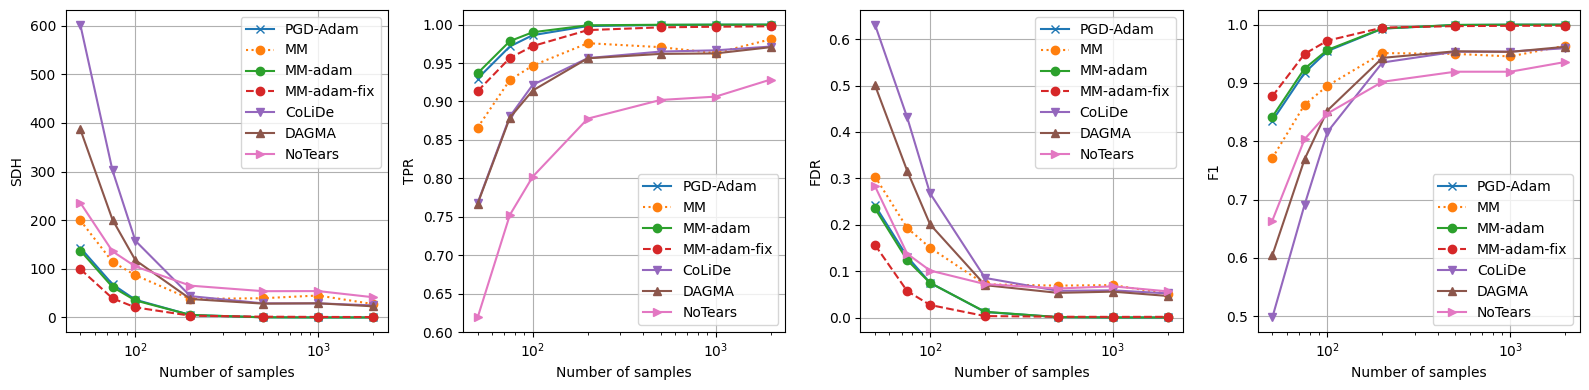

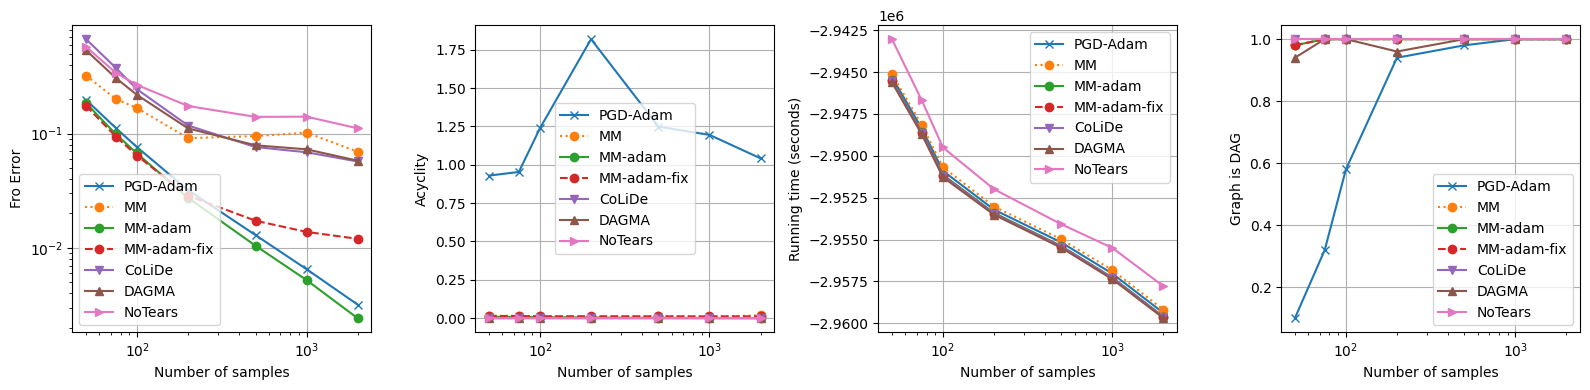

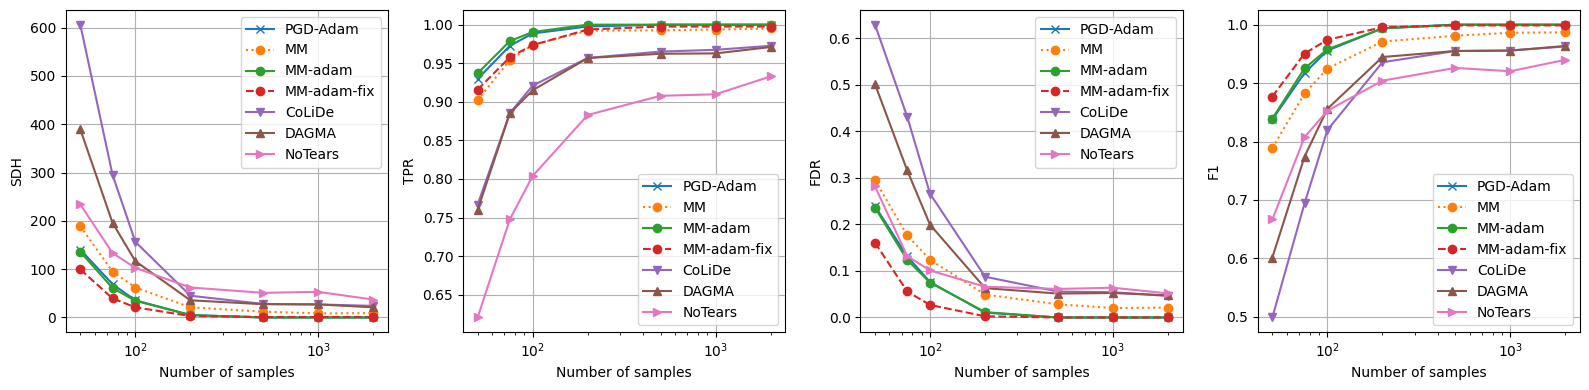

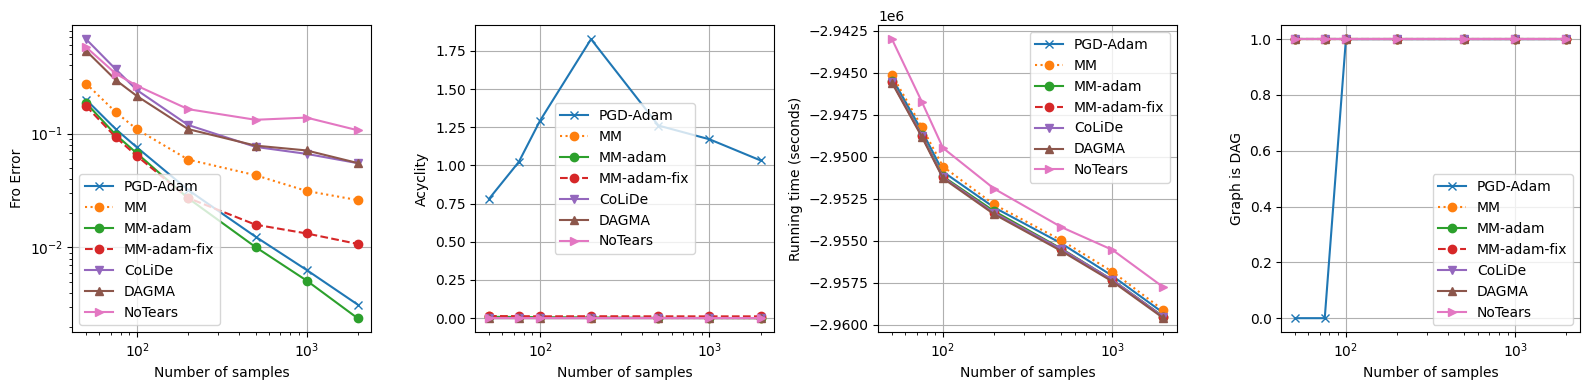

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


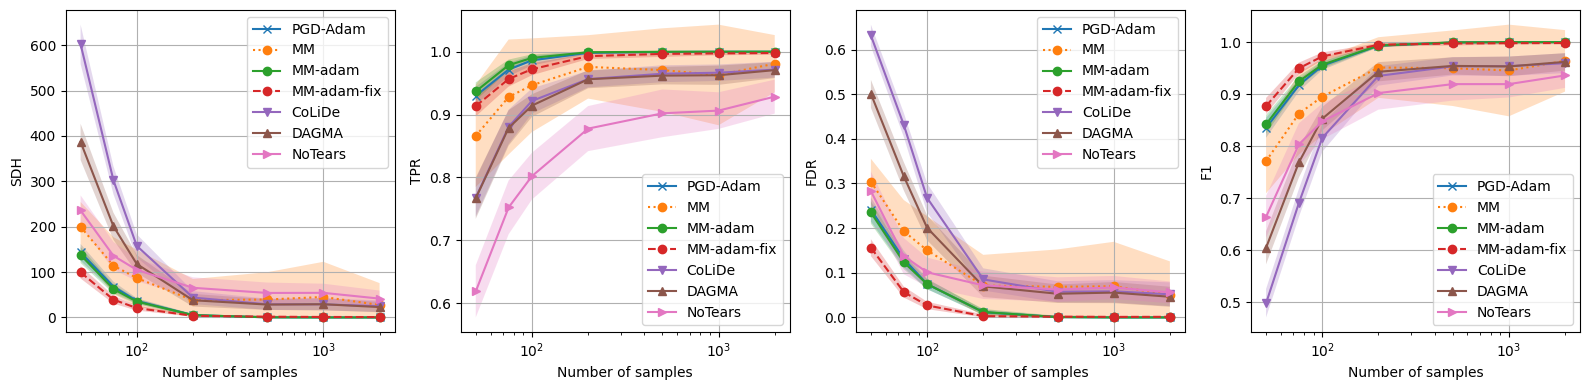

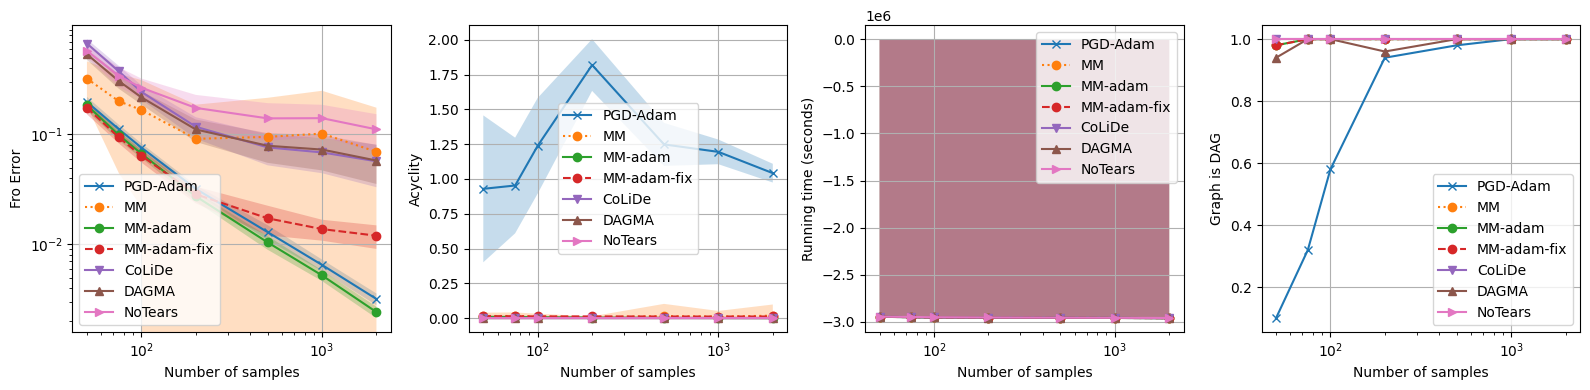

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean', dev=True)

# plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
#                  skip_idx=skip, agg='median', dev=True)


### 50 nodes

In [ ]:
N = 50
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 64
Graph: 1, samples: 50
Graph: 2, samples: 50
Graph: 3, samples: 50
Graph: 4, samples: 50
Graph: 5, samples: 50
Graph: 6, samples: 50
Graph: 7, samples: 50
Graph: 8, samples: 50
Graph: 9, samples: 50
Graph: 10, samples: 50
Graph: 11, samples: 50
Graph: 12, samples: 50
Graph: 13, samples: 50
Graph: 14, samples: 50
Graph: 15, samples: 50
Graph: 16, samples: 50
Graph: 17, samples: 50
Graph: 18, samples: 50
Graph: 19, samples: 50
Graph: 20, samples: 50
Graph: 21, samples: 50
Graph: 22, samples: 50
Graph: 23, samples: 50
Graph: 24, samples: 50
Graph: 25, samples: 50
Graph: 26, samples: 50
Graph: 27, samples: 50
Graph: 28, samples: 50
Graph: 29, samples: 50
Graph: 30, samples: 50
Graph: 31, samples: 50
Graph: 32, samples: 50
Graph: 33, samples: 50
Graph: 34, samples: 50
Graph: 35, samples: 50
Graph: 36, samples: 50
Graph: 37, samples: 50
Graph: 42, samples: 50
Graph: 38, samples: 50
Graph: 41, samples: 50
Graph: 48, samples: 50
Graph: 47, samples: 50
Graph: 39, samples: 50
Gr

  1%|          | 734/130000.0 [00:00<00:35, 3664.17it/s]

		-MM-adam: shd 98.0  -  err: 0.204  -  time: 9.714
		-MM-adam: shd 72.0  -  err: 0.187  -  time: 10.720
		-MM-adam: shd 86.0  -  err: 0.164  -  time: 8.958


  2%|▏         | 2948/130000.0 [00:00<00:34, 3683.46it/s]

		-MM-adam: shd 70.0  -  err: 0.161  -  time: 8.694


  4%|▎         | 4793/130000.0 [00:01<00:33, 3682.79it/s]

		-MM-adam: shd 80.0  -  err: 0.153  -  time: 10.108


  5%|▍         | 5901/130000.0 [00:01<00:33, 3684.92it/s]

		-MM-adam: shd 56.0  -  err: 0.133  -  time: 9.815
		-MM-adam: shd 89.0  -  err: 0.206  -  time: 8.399
		-MM-adam: shd 85.0  -  err: 0.174  -  time: 7.852


  5%|▌         | 7008/130000.0 [00:01<00:33, 3682.02it/s]

		-MM-adam: shd 97.0  -  err: 0.179  -  time: 7.523


  6%|▌         | 8116/130000.0 [00:02<00:33, 3683.90it/s]

		-MM: shd 141.0  -  err: 0.448  -  time: 92.962
		-MM: shd 101.0  -  err: 0.284  -  time: 93.518


  7%|▋         | 9223/130000.0 [00:02<00:32, 3683.39it/s]

		-MM-adam: shd 96.0  -  err: 0.230  -  time: 9.359
		-MM-adam: shd 77.0  -  err: 0.156  -  time: 9.230


  8%|▊         | 10331/130000.0 [00:02<00:32, 3682.78it/s]

		-MM-adam: shd 96.0  -  err: 0.233  -  time: 9.581


 10%|▉         | 12548/130000.0 [00:03<00:31, 3686.22it/s]

		-MM-adam: shd 75.0  -  err: 0.156  -  time: 7.963
		-MM-adam: shd 98.0  -  err: 0.229  -  time: 8.943
		-MM-adam: shd 79.0  -  err: 0.167  -  time: 9.958


 12%|█▏        | 15870/130000.0 [00:04<00:31, 3680.25it/s]

		-MM-adam-fix: shd 146.0  -  err: 0.293  -  time: 9.435
		-MM-adam: shd 85.0  -  err: 0.185  -  time: 10.990


  1%|          | 1239/130000.0 [00:00<00:31, 4121.66it/s]]

		-MM-adam: shd 84.0  -  err: 0.220  -  time: 10.146


  2%|▏         | 2064/130000.0 [00:00<00:31, 4115.79it/s]s]

		-MM-adam: shd 82.0  -  err: 0.190  -  time: 11.242
		-MM-adam: shd 89.0  -  err: 0.186  -  time: 10.722
		-MM-adam: shd 89.0  -  err: 0.199  -  time: 10.133


  3%|▎         | 4118/130000.0 [00:01<00:32, 3925.14it/s]] 

		-MM-adam: shd 79.0  -  err: 0.151  -  time: 11.997
		-MM-adam: shd 93.0  -  err: 0.198  -  time: 10.261


  4%|▍         | 4901/130000.0 [00:01<00:32, 3846.93it/s]]

		-MM-adam: shd 101.0  -  err: 0.230  -  time: 11.895
		-MM-adam: shd 83.0  -  err: 0.183  -  time: 13.138


 19%|█▉        | 24678/130000.0 [00:05<00:23, 4481.86it/s]

		-MM-adam: shd 109.0  -  err: 0.219  -  time: 10.200
		-MM-adam: shd 61.0  -  err: 0.141  -  time: 7.746


  6%|▋         | 8387/130000.0 [00:02<00:31, 3921.94it/s]s]

		-MM-adam-fix: shd 126.0  -  err: 0.296  -  time: 7.426
		-MM-adam: shd 73.0  -  err: 0.176  -  time: 11.164


  1%|          | 1109/130000.0 [00:00<00:34, 3693.66it/s]

		-MM-adam: shd 70.0  -  err: 0.182  -  time: 11.135
		-MM-adam: shd 84.0  -  err: 0.210  -  time: 9.820


  1%|▏         | 1850/130000.0 [00:00<00:34, 3691.92it/s]]

		-MM-adam: shd 105.0  -  err: 0.240  -  time: 13.043
		-MM-adam: shd 70.0  -  err: 0.161  -  time: 11.411
		-MM-adam: shd 70.0  -  err: 0.170  -  time: 13.642
		-MM-adam: shd 112.0  -  err: 0.222  -  time: 9.699


 10%|▉         | 12990/130000.0 [00:03<00:28, 4094.58it/s]

		-MM-adam-fix: shd 165.0  -  err: 0.328  -  time: 9.298
		-MM-adam: shd 89.0  -  err: 0.187  -  time: 8.253


 11%|█         | 13815/130000.0 [00:03<00:28, 4108.72it/s] 

		-MM-adam-fix: shd 125.0  -  err: 0.240  -  time: 8.797
		-MM-adam-fix: shd 158.0  -  err: 0.303  -  time: 10.771
		-MM-adam: shd 90.0  -  err: 0.196  -  time: 10.258


  1%|          | 740/130000.0 [00:00<00:35, 3690.83it/s]]]

		-MM-adam-fix: shd 121.0  -  err: 0.255  -  time: 10.015


  3%|▎         | 3547/130000.0 [00:00<00:32, 3916.10it/s]]

		-MM-adam-fix: shd 158.0  -  err: 0.327  -  time: 9.329
		-MM-adam-fix: shd 122.0  -  err: 0.243  -  time: 9.881


  4%|▍         | 5190/130000.0 [00:01<00:33, 3726.08it/s]]]

		-MM-adam: shd 95.0  -  err: 0.175  -  time: 14.008


  0%|          | 396/130000.0 [00:00<00:32, 3951.71it/s]]]

		-MM-adam-fix: shd 135.0  -  err: 0.241  -  time: 7.949
		-MM-adam-fix: shd 122.0  -  err: 0.243  -  time: 9.838


  6%|▌         | 7681/130000.0 [00:01<00:30, 4007.17it/s]]

		-MM-adam: shd 85.0  -  err: 0.176  -  time: 7.143
		-MM-adam-fix: shd 113.0  -  err: 0.234  -  time: 8.809
		-MM-adam-fix: shd 150.0  -  err: 0.281  -  time: 9.312


  5%|▌         | 6762/130000.0 [00:01<00:32, 3746.43it/s]] 

		-MM-adam: shd 81.0  -  err: 0.207  -  time: 13.893
		-MM-adam-fix: shd 153.0  -  err: 0.306  -  time: 9.781


  8%|▊         | 10017/130000.0 [00:02<00:32, 3704.15it/s]

		-MM-adam-fix: shd 128.0  -  err: 0.274  -  time: 10.307
		-MM-adam-fix: shd 186.0  -  err: 0.375  -  time: 8.936


 11%|█         | 13792/130000.0 [00:03<00:31, 3731.61it/s] 

		-MM-adam-fix: shd 140.0  -  err: 0.321  -  time: 9.666
		-MM-adam-fix: shd 117.0  -  err: 0.222  -  time: 9.943


100%|██████████| 130000/130000.0 [00:11<00:00, 11107.20it/s]
 13%|█▎        | 17395/130000.0 [00:04<00:28, 3943.99it/s]

		-CoLiDe-Paper_regs: shd 107.0  -  err: 0.442  -  time: 11.706
Graph: 44, samples: 100
		-MM-adam-fix: shd 162.0  -  err: 0.340  -  time: 8.177


 14%|█▍        | 18193/130000.0 [00:04<00:28, 3967.62it/s]]

		-MM-adam-fix: shd 139.0  -  err: 0.255  -  time: 10.243
		-MM-adam: shd 101.0  -  err: 0.185  -  time: 9.797
		-MM-adam-fix: shd 148.0  -  err: 0.286  -  time: 9.600


 15%|█▌        | 19786/130000.0 [00:05<00:27, 3948.93it/s]]

		-MM-adam: shd 92.0  -  err: 0.191  -  time: 13.178
		-MM-adam-fix: shd 141.0  -  err: 0.273  -  time: 9.865


 17%|█▋        | 22189/130000.0 [00:05<00:27, 3927.81it/s]]

		-MM-adam-fix: shd 163.0  -  err: 0.346  -  time: 10.193


 12%|█▏        | 15673/130000.0 [00:04<00:29, 3932.03it/s]

		-MM-adam-fix: shd 135.0  -  err: 0.269  -  time: 9.686


 13%|█▎        | 17251/130000.0 [00:04<00:28, 3934.34it/s] 

		-MM-adam-fix: shd 128.0  -  err: 0.255  -  time: 10.066
		-MM-adam-fix: shd 145.0  -  err: 0.322  -  time: 8.865


 16%|█▌        | 20374/130000.0 [00:04<00:10, 10062.44it/s]

		-MM-adam-fix: shd 117.0  -  err: 0.217  -  time: 8.003


 13%|█▎        | 16390/130000.0 [00:04<00:28, 3925.22it/s]]

		-MM-adam-fix: shd 160.0  -  err: 0.396  -  time: 9.712
		-MM-adam-fix: shd 181.0  -  err: 0.384  -  time: 9.258
		-MM-adam-fix: shd 156.0  -  err: 0.354  -  time: 10.171


 16%|█▌        | 20934/130000.0 [00:05<00:27, 3987.92it/s]]

		-MM-adam-fix: shd 139.0  -  err: 0.257  -  time: 10.487


 10%|█         | 13013/130000.0 [00:03<00:31, 3708.62it/s]]

		-MM-adam-fix: shd 152.0  -  err: 0.326  -  time: 10.250


 11%|█▏        | 14749/130000.0 [00:03<00:29, 3935.37it/s] 

		-MM-adam-fix: shd 142.0  -  err: 0.311  -  time: 8.103
		-MM-adam-fix: shd 147.0  -  err: 0.278  -  time: 10.875
		-MM-adam-fix: shd 131.0  -  err: 0.237  -  time: 10.751


 20%|██        | 26165/130000.0 [00:06<00:27, 3736.78it/s]]

		-MM-adam-fix: shd 159.0  -  err: 0.330  -  time: 10.168


  2%|▏         | 2988/130000.0 [00:00<00:34, 3728.15it/s]]]

		-MM-adam-fix: shd 126.0  -  err: 0.289  -  time: 9.864
		-MM-adam-fix: shd 149.0  -  err: 0.294  -  time: 9.627
		-MM-adam-fix: shd 130.0  -  err: 0.253  -  time: 7.017
		-MM-adam-fix: shd 190.0  -  err: 0.330  -  time: 9.610


 34%|███▍      | 43889/130000.0 [00:07<00:08, 10433.68it/s]

		-MM-adam-fix: shd 113.0  -  err: 0.242  -  time: 10.478


  2%|▏         | 3215/130000.0 [00:00<00:35, 3562.07it/s]] 

		-MM-adam-fix: shd 135.0  -  err: 0.297  -  time: 11.980
		-MM-adam-fix: shd 126.0  -  err: 0.259  -  time: 10.456


100%|██████████| 130000/130000.0 [00:13<00:00, 9637.44it/s]
  4%|▎         | 4646/130000.0 [00:01<00:35, 3550.06it/s]] 

		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.438  -  time: 13.490
Graph: 12, samples: 100
		-MM-adam-fix: shd 117.0  -  err: 0.255  -  time: 11.361


  7%|▋         | 8532/130000.0 [00:02<00:34, 3560.16it/s]]]

		-MM-adam-fix: shd 194.0  -  err: 0.335  -  time: 10.416


  8%|▊         | 9944/130000.0 [00:02<00:34, 3491.43it/s]] 

		-MM-adam-fix: shd 124.0  -  err: 0.258  -  time: 11.674


100%|██████████| 130000/130000.0 [00:10<00:00, 12310.96it/s]
  9%|▉         | 11395/130000.0 [00:03<00:32, 3617.91it/s] 

		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.317  -  time: 10.560
Graph: 10, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10661.46it/s]
  5%|▌         | 6723/130000.0 [00:01<00:35, 3513.11it/s]]]

		-MM-adam-fix: shd 155.0  -  err: 0.346  -  time: 9.776
		-CoLiDe-Paper_regs: shd 112.0  -  err: 0.377  -  time: 12.194
Graph: 21, samples: 100
		-CoLiDe-Paper_regs: shd 142.0  -  err: 0.591  -  time: 12.064
Graph: 42, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10781.33it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12200.42it/s]
100%|██████████| 130000/130000.0 [00:13<00:00, 9518.30it/s] 
 40%|███▉      | 51807/130000.0 [00:10<00:17, 4482.38it/s] 

		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.447  -  time: 10.661
Graph: 38, samples: 100
		-CoLiDe-Paper_regs: shd 105.0  -  err: 0.504  -  time: 13.658
Graph: 6, samples: 100


100%|██████████| 130000/130000.0 [00:13<00:00, 9989.12it/s]
  7%|▋         | 9266/130000.0 [00:02<00:33, 3588.12it/s]]]

		-CoLiDe-Paper_regs: shd 119.0  -  err: 0.468  -  time: 13.015
Graph: 26, samples: 100
		-MM-adam-fix: shd 137.0  -  err: 0.279  -  time: 11.816


100%|██████████| 130000/130000.0 [00:11<00:00, 11114.64it/s]
  8%|▊         | 10699/130000.0 [00:03<00:33, 3554.27it/s]]

		-CoLiDe-Paper_regs: shd 90.0  -  err: 0.391  -  time: 11.697
Graph: 20, samples: 100


100%|██████████| 130000/130000.0 [00:13<00:00, 9660.29it/s]
  9%|▉         | 11415/130000.0 [00:03<00:33, 3566.42it/s]

		-CoLiDe-Paper_regs: shd 120.0  -  err: 0.495  -  time: 13.458
Graph: 14, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10656.79it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 10851.97it/s]
 37%|███▋      | 47854/130000.0 [00:09<00:15, 5144.65it/s]]

		-CoLiDe-Paper_regs: shd 134.0  -  err: 0.563  -  time: 12.199
Graph: 1, samples: 100
		-CoLiDe-Paper_regs: shd 111.0  -  err: 0.498  -  time: 11.980
Graph: 3, samples: 100
		-MM-adam-fix: shd 179.0  -  err: 0.310  -  time: 9.989


100%|██████████| 130000/130000.0 [00:13<00:00, 9321.36it/s]  
 16%|█▌        | 20551/130000.0 [00:05<00:30, 3538.79it/s]]

		-MM-adam-fix: shd 183.0  -  err: 0.384  -  time: 9.759
		-CoLiDe-Paper_regs: shd 102.0  -  err: 0.431  -  time: 13.947
Graph: 2, samples: 100


100%|██████████| 130000/130000.0 [00:11<00:00, 11087.93it/s]
  8%|▊         | 10486/130000.0 [00:03<00:34, 3486.45it/s]]

		-CoLiDe-Paper_regs: shd 112.0  -  err: 0.468  -  time: 11.725
Graph: 7, samples: 100


100%|██████████| 130000/130000.0 [00:13<00:00, 9660.00it/s] 
 17%|█▋        | 21464/130000.0 [00:05<00:14, 7336.57it/s] 

		-CoLiDe-Paper_regs: shd 87.0  -  err: 0.389  -  time: 13.458
Graph: 15, samples: 100


100%|██████████| 130000/130000.0 [00:11<00:00, 11187.02it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11359.67it/s]
 19%|█▉        | 24758/130000.0 [00:07<00:30, 3475.94it/s]

		-CoLiDe-Paper_regs: shd 77.0  -  err: 0.360  -  time: 11.623
Graph: 43, samples: 100
		-CoLiDe-Paper_regs: shd 105.0  -  err: 0.436  -  time: 11.446
Graph: 47, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10183.82it/s]
 20%|█▉        | 25978/130000.0 [00:06<00:25, 4039.68it/s]

		-CoLiDe-Paper_regs: shd 90.0  -  err: 0.462  -  time: 12.766
Graph: 19, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10025.54it/s] 
 21%|██▏       | 27788/130000.0 [00:07<00:29, 3473.71it/s]

		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.342  -  time: 12.967
Graph: 9, samples: 100


100%|██████████| 130000/130000.0 [00:13<00:00, 9916.79it/s]
 13%|█▎        | 16660/130000.0 [00:04<00:30, 3689.86it/s]]

		-CoLiDe-Paper_regs: shd 120.0  -  err: 0.426  -  time: 13.110
Graph: 23, samples: 100


100%|██████████| 130000/130000.0 [00:15<00:00, 8438.50it/s]  
100%|██████████| 130000/130000.0 [00:12<00:00, 10448.57it/s]
 55%|█████▌    | 72123/130000.0 [00:13<00:15, 3664.96it/s] 

		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.412  -  time: 15.406
Graph: 24, samples: 100
		-CoLiDe-Paper_regs: shd 112.0  -  err: 0.500  -  time: 12.445
Graph: 49, samples: 100


 19%|█▉        | 25278/130000.0 [00:06<00:28, 3627.40it/s]]

		-PGD: shd 186.0  -  err: 0.724  -  time: 14.611
		-CoLiDe-Paper_regs: shd 131.0  -  err: 0.504  -  time: 11.900
Graph: 33, samples: 100


100%|██████████| 130000/130000.0 [00:11<00:00, 10924.93it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 10911.17it/s]
 32%|███▏      | 41265/130000.0 [00:10<00:24, 3667.97it/s]

		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.336  -  time: 11.915
Graph: 18, samples: 100
		-CoLiDe-Paper_regs: shd 85.0  -  err: 0.369  -  time: 14.106
Graph: 28, samples: 100


100%|██████████| 130000/130000.0 [00:14<00:00, 9216.38it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10201.18it/s]
 36%|███▌      | 46378/130000.0 [00:10<00:14, 5625.31it/s]]

		-CoLiDe-Paper_regs: shd 64.0  -  err: 0.278  -  time: 12.750
Graph: 50, samples: 100
		-CoLiDe-Paper_regs: shd 99.0  -  err: 0.428  -  time: 13.797
Graph: 45, samples: 100


100%|██████████| 130000/130000.0 [00:13<00:00, 9423.17it/s] 
100%|██████████| 130000/130000.0 [00:12<00:00, 10460.22it/s]
 33%|███▎      | 43474/130000.0 [00:11<00:23, 3672.38it/s]

		-CoLiDe-Paper_regs: shd 111.0  -  err: 0.445  -  time: 12.429
Graph: 37, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10116.24it/s]
 16%|█▌        | 20493/130000.0 [00:05<00:29, 3730.02it/s]

		-CoLiDe-Paper_regs: shd 132.0  -  err: 0.548  -  time: 12.852
Graph: 39, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10787.15it/s]
 16%|█▋        | 21300/130000.0 [00:05<00:30, 3572.38it/s] 

		-CoLiDe-Paper_regs: shd 99.0  -  err: 0.407  -  time: 12.052
Graph: 29, samples: 100


100%|██████████| 130000/130000.0 [00:11<00:00, 11556.32it/s]
 55%|█████▌    | 72046/130000.0 [00:15<00:16, 3601.89it/s]]

		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.340  -  time: 11.250
Graph: 13, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10478.91it/s]
 56%|█████▌    | 72764/130000.0 [00:15<00:16, 3528.13it/s]

		-CoLiDe-Paper_regs: shd 108.0  -  err: 0.431  -  time: 12.407
Graph: 41, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10681.07it/s]
 57%|█████▋    | 73473/130000.0 [00:15<00:16, 3514.10it/s]]

		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.411  -  time: 12.172
Graph: 4, samples: 100
		-CoLiDe-Paper_regs: shd 156.0  -  err: 0.571  -  time: 13.478
Graph: 40, samples: 100


100%|██████████| 130000/130000.0 [00:13<00:00, 9646.04it/s] 
100%|██████████| 130000/130000.0 [00:16<00:00, 7989.86it/s] 
100%|██████████| 130000/130000.0 [00:15<00:00, 8140.18it/s]


		-CoLiDe-Paper_regs: shd 119.0  -  err: 0.427  -  time: 16.271
Graph: 17, samples: 100
		-CoLiDe-Paper_regs: shd 90.0  -  err: 0.389  -  time: 15.971
Graph: 34, samples: 100


100%|██████████| 130000/130000.0 [00:13<00:00, 9703.46it/s] 
 22%|██▏       | 28346/130000.0 [00:07<00:27, 3730.85it/s] 

		-CoLiDe-Paper_regs: shd 156.0  -  err: 0.669  -  time: 13.398
Graph: 11, samples: 100
		-CoLiDe-Paper_regs: shd 110.0  -  err: 0.483  -  time: 12.013
Graph: 35, samples: 100
		-CoLiDe-Paper_regs: shd 117.0  -  err: 0.495  -  time: 14.537
Graph: 32, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10822.17it/s]
100%|██████████| 130000/130000.0 [00:14<00:00, 8943.34it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10805.81it/s]
100%|██████████| 130000/130000.0 [00:14<00:00, 9135.42it/s] 
 24%|██▍       | 31709/130000.0 [00:08<00:25, 3784.84it/s] 

		-CoLiDe-Paper_regs: shd 118.0  -  err: 0.499  -  time: 12.031
Graph: 31, samples: 100
		-CoLiDe-Paper_regs: shd 113.0  -  err: 0.481  -  time: 14.231
Graph: 27, samples: 100


 25%|██▍       | 32476/130000.0 [00:08<00:25, 3809.42it/s]

		-PGD-Adam: shd 34.0  -  err: 0.155  -  time: 4.680
		-CoLiDe-Paper_regs: shd 109.0  -  err: 0.483  -  time: 15.344
Graph: 8, samples: 100


100%|██████████| 130000/130000.0 [00:15<00:00, 8472.96it/s]
100%|██████████| 130000/130000.0 [00:15<00:00, 8277.86it/s]
100%|██████████| 130000/130000.0 [00:14<00:00, 9044.55it/s] 
 50%|████▉     | 64666/130000.0 [00:12<00:07, 8899.70it/s] 

		-CoLiDe-Paper_regs: shd 133.0  -  err: 0.512  -  time: 15.705
Graph: 36, samples: 100
		-CoLiDe-Paper_regs: shd 113.0  -  err: 0.464  -  time: 14.376
Graph: 48, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10347.98it/s]
100%|██████████| 130000/130000.0 [00:15<00:00, 8275.94it/s] 


		-CoLiDe-Paper_regs: shd 123.0  -  err: 0.507  -  time: 12.563
Graph: 22, samples: 100
		-CoLiDe-Paper_regs: shd 140.0  -  err: 0.607  -  time: 15.709
Graph: 5, samples: 100
		-CoLiDe-Paper_regs: shd 147.0  -  err: 0.595  -  time: 14.181
Graph: 25, samples: 100


100%|██████████| 130000/130000.0 [00:14<00:00, 9167.85it/s] 
 31%|███       | 40078/130000.0 [00:10<00:09, 9725.41it/s]

		-PGD: shd 174.0  -  err: 0.735  -  time: 14.826


 32%|███▏      | 41051/130000.0 [00:10<00:13, 6579.62it/s]

		-PGD: shd 52.0  -  err: 0.203  -  time: 13.258


 37%|███▋      | 48714/130000.0 [00:11<00:17, 4775.86it/s]

		-PGD: shd 142.0  -  err: 0.559  -  time: 14.558
		-PGD: shd 36.0  -  err: 0.187  -  time: 13.596


100%|██████████| 130000/130000.0 [00:13<00:00, 9956.36it/s] 


		-CoLiDe-Paper_regs: shd 144.0  -  err: 0.599  -  time: 13.059
Graph: 46, samples: 100
		-PGD: shd 86.0  -  err: 0.292  -  time: 14.215
		-PGD: shd 30.0  -  err: 0.121  -  time: 13.372


 37%|███▋      | 48056/130000.0 [00:12<00:21, 3747.99it/s] 

		-PGD: shd 40.0  -  err: 0.157  -  time: 13.483


 38%|███▊      | 49180/130000.0 [00:12<00:21, 3733.34it/s]

		-PGD: shd 105.0  -  err: 0.381  -  time: 13.117
		-PGD: shd 56.0  -  err: 0.163  -  time: 15.109
		-PGD-Adam-fix: shd 88.0  -  err: 0.212  -  time: 4.169


100%|██████████| 130000/130000.0 [00:13<00:00, 9602.21it/s] 
 46%|████▋     | 60167/130000.0 [00:13<00:02, 27649.86it/s]

		-CoLiDe-Paper_regs: shd 112.0  -  err: 0.476  -  time: 13.539
Graph: 30, samples: 100
		-PGD: shd 43.0  -  err: 0.182  -  time: 13.314
		-PGD-Adam: shd 15.0  -  err: 0.075  -  time: 2.669
		-PGD: shd 140.0  -  err: 0.525  -  time: 14.889
		-PGD-Adam: shd 37.0  -  err: 0.173  -  time: 3.466


 48%|████▊     | 62934/130000.0 [00:14<00:07, 9481.48it/s] 

		-PGD-Adam: shd 44.0  -  err: 0.162  -  time: 3.900
		-PGD-Adam: shd 19.0  -  err: 0.097  -  time: 2.495
		-PGD: shd 92.0  -  err: 0.314  -  time: 14.806


 50%|████▉     | 64983/130000.0 [00:14<00:09, 6913.05it/s]

		-PGD: shd 125.0  -  err: 0.490  -  time: 14.915


 51%|█████     | 66529/130000.0 [00:15<00:10, 5870.77it/s]

		-PGD-Adam: shd 5.0  -  err: 0.053  -  time: 3.050
		-PGD-Adam: shd 33.0  -  err: 0.136  -  time: 4.326
		-PGD-Adam: shd 30.0  -  err: 0.122  -  time: 3.848


 52%|█████▏    | 67723/130000.0 [00:15<00:11, 5301.40it/s]

		-PGD: shd 36.0  -  err: 0.164  -  time: 14.862


 53%|█████▎    | 68670/130000.0 [00:15<00:12, 4935.69it/s]

		-PGD: shd 46.0  -  err: 0.175  -  time: 14.686
		-PGD: shd 59.0  -  err: 0.234  -  time: 14.779


100%|██████████| 130000/130000.0 [00:16<00:00, 8017.89it/s] 


		-CoLiDe-Paper_regs: shd 161.0  -  err: 0.626  -  time: 16.214
Graph: 16, samples: 100
		-PGD-Adam: shd 12.0  -  err: 0.073  -  time: 3.449
		-PGD-Adam: shd 20.0  -  err: 0.100  -  time: 3.634
		-PGD: shd 175.0  -  err: 0.791  -  time: 14.938
		-PGD: shd 44.0  -  err: 0.193  -  time: 13.969
		-PGD-Adam: shd 16.0  -  err: 0.109  -  time: 3.511
		-PGD-Adam-fix: shd 63.0  -  err: 0.130  -  time: 2.758
		-PGD-Adam-fix: shd 53.0  -  err: 0.119  -  time: 3.144
		-PGD: shd 54.0  -  err: 0.208  -  time: 14.965
		-PGD-Adam-fix: shd 74.0  -  err: 0.180  -  time: 3.415
		-PGD-Adam: shd 27.0  -  err: 0.114  -  time: 3.121
		-PGD-Adam: shd 23.0  -  err: 0.134  -  time: 2.211
		-PGD-Adam: shd 21.0  -  err: 0.089  -  time: 3.332
		-PGD: shd 96.0  -  err: 0.348  -  time: 13.924
		-PGD-Adam: shd 17.0  -  err: 0.097  -  time: 2.314
		-PGD-Adam-fix: shd 105.0  -  err: 0.210  -  time: 4.026
		-PGD-Adam: shd 37.0  -  err: 0.178  -  time: 2.568
		-PGD: shd 186.0  -  err: 0.755  -  time: 14.748
		-PGD: shd 

  2%|▏         | 2055/130000.0 [00:00<00:31, 4107.94it/s]

		-MM: shd 67.0  -  err: 0.199  -  time: 88.822
		-MM-adam: shd 30.0  -  err: 0.075  -  time: 6.297


  3%|▎         | 3292/130000.0 [00:00<00:30, 4114.38it/s]

		-MM: shd 73.0  -  err: 0.236  -  time: 82.717


  4%|▍         | 5765/130000.0 [00:01<00:30, 4109.04it/s]

		-MM: shd 66.0  -  err: 0.209  -  time: 89.097
		-MM: shd 77.0  -  err: 0.253  -  time: 88.099


  6%|▋         | 8239/130000.0 [00:02<00:29, 4116.85it/s]

		-MM: shd 64.0  -  err: 0.223  -  time: 86.062


  8%|▊         | 10304/130000.0 [00:02<00:29, 4095.40it/s]

		-MM: shd 71.0  -  err: 0.183  -  time: 80.436


 10%|▉         | 12765/130000.0 [00:03<00:28, 4097.63it/s]

		-MM-adam-fix: shd 53.0  -  err: 0.094  -  time: 6.512


 10%|█         | 13589/130000.0 [00:03<00:28, 4106.38it/s]

		-MM: shd 71.0  -  err: 0.244  -  time: 86.851


 11%|█         | 14414/130000.0 [00:03<00:28, 4096.05it/s]

		-MM: shd 82.0  -  err: 0.262  -  time: 85.984


  2%|▏         | 2992/130000.0 [00:00<00:34, 3654.81it/s]]

		-MM-adam: shd 24.0  -  err: 0.065  -  time: 5.972
		-MM-adam: shd 33.0  -  err: 0.095  -  time: 8.892


 13%|█▎        | 16486/130000.0 [00:04<00:27, 4121.06it/s]

		-MM-adam: shd 58.0  -  err: 0.135  -  time: 9.648
		-MM-adam: shd 37.0  -  err: 0.096  -  time: 10.340


  4%|▍         | 5599/130000.0 [00:01<00:33, 3717.38it/s]s]

		-MM: shd 96.0  -  err: 0.300  -  time: 87.256
		-MM: shd 53.0  -  err: 0.187  -  time: 85.042


  5%|▌         | 6770/130000.0 [00:01<00:31, 3869.51it/s]] 

		-MM: shd 66.0  -  err: 0.230  -  time: 86.482


  7%|▋         | 9667/130000.0 [00:02<00:29, 4119.80it/s]]

		-MM-adam: shd 37.0  -  err: 0.113  -  time: 10.442
		-MM-adam: shd 42.0  -  err: 0.114  -  time: 7.322


  8%|▊         | 10497/130000.0 [00:02<00:29, 4106.98it/s]

		-MM: shd 60.0  -  err: 0.228  -  time: 88.242
		-MM-adam: shd 27.0  -  err: 0.068  -  time: 7.108


  9%|▉         | 12123/130000.0 [00:03<00:29, 3937.19it/s]

		-MM: shd 72.0  -  err: 0.228  -  time: 87.611


 10%|▉         | 12923/130000.0 [00:03<00:29, 3963.93it/s]

		-MM-adam: shd 40.0  -  err: 0.087  -  time: 7.957
		-MM-adam: shd 30.0  -  err: 0.096  -  time: 8.144
		-MM-adam: shd 38.0  -  err: 0.073  -  time: 8.197
		-MM-adam: shd 28.0  -  err: 0.091  -  time: 9.570


 13%|█▎        | 16595/130000.0 [00:04<00:28, 4047.78it/s]]

		-MM-adam: shd 37.0  -  err: 0.093  -  time: 10.623
		-MM-adam: shd 29.0  -  err: 0.074  -  time: 7.294
		-MM: shd 65.0  -  err: 0.189  -  time: 92.480
		-MM-adam: shd 27.0  -  err: 0.073  -  time: 8.719


 34%|███▍      | 43912/130000.0 [00:07<00:07, 10948.38it/s]

		-MM-adam: shd 31.0  -  err: 0.084  -  time: 10.111
		-MM-adam-fix: shd 55.0  -  err: 0.101  -  time: 7.028


  1%|          | 1214/130000.0 [00:00<00:32, 3934.39it/s]] 

		-MM: shd 76.0  -  err: 0.235  -  time: 88.464
		-MM-adam: shd 32.0  -  err: 0.079  -  time: 9.213
		-MM-adam: shd 44.0  -  err: 0.125  -  time: 9.578
		-MM-adam: shd 49.0  -  err: 0.119  -  time: 9.764
		-MM: shd 82.0  -  err: 0.248  -  time: 88.876


  2%|▏         | 3240/130000.0 [00:00<00:31, 4046.44it/s]] 

		-MM-adam: shd 23.0  -  err: 0.083  -  time: 9.580


 20%|█▉        | 25434/130000.0 [00:05<00:22, 4581.06it/s]]

		-MM-adam-fix: shd 51.0  -  err: 0.114  -  time: 8.658


 48%|████▊     | 62631/130000.0 [00:09<00:06, 11097.57it/s]

		-MM-adam-fix: shd 44.0  -  err: 0.116  -  time: 10.003
		-MM: shd 117.0  -  err: 0.340  -  time: 91.016
		-MM: shd 84.0  -  err: 0.259  -  time: 91.037


  2%|▏         | 2888/130000.0 [00:00<00:31, 4088.15it/s]s]

		-MM-adam-fix: shd 43.0  -  err: 0.084  -  time: 5.565
		-MM-adam: shd 37.0  -  err: 0.085  -  time: 8.613


  7%|▋         | 8978/130000.0 [00:02<00:29, 4091.21it/s]] 

		-MM-adam-fix: shd 49.0  -  err: 0.098  -  time: 10.154


100%|██████████| 130000/130000.0 [00:10<00:00, 12745.48it/s]
  5%|▌         | 6600/130000.0 [00:01<00:30, 4110.53it/s]]

		-CoLiDe-Paper_regs: shd 78.0  -  err: 0.324  -  time: 10.200
Graph: 42, samples: 150
		-MM-adam: shd 39.0  -  err: 0.111  -  time: 10.365


  3%|▎         | 3315/130000.0 [00:00<00:34, 3631.88it/s]]]

		-MM-adam: shd 27.0  -  err: 0.072  -  time: 10.156


 11%|█         | 14269/130000.0 [00:03<00:28, 4007.76it/s] 

		-MM-adam: shd 36.0  -  err: 0.093  -  time: 9.693


  9%|▉         | 11974/130000.0 [00:02<00:28, 4131.71it/s]

		-MM-adam: shd 30.0  -  err: 0.101  -  time: 10.165


 10%|█         | 13631/130000.0 [00:03<00:28, 4134.45it/s]]

		-MM: shd 72.0  -  err: 0.279  -  time: 91.868
		-MM: shd 53.0  -  err: 0.220  -  time: 93.285
		-MM-adam: shd 49.0  -  err: 0.117  -  time: 8.628


 11%|█         | 14131/130000.0 [00:03<00:28, 4129.94it/s]]

		-MM-adam: shd 37.0  -  err: 0.081  -  time: 10.323
		-MM-adam: shd 50.0  -  err: 0.137  -  time: 6.646
		-MM-adam-fix: shd 60.0  -  err: 0.119  -  time: 8.477


 12%|█▏        | 15799/130000.0 [00:03<00:27, 4114.41it/s] 

		-MM: shd 65.0  -  err: 0.238  -  time: 93.165
		-MM-adam: shd 37.0  -  err: 0.086  -  time: 9.455
		-MM-adam: shd 28.0  -  err: 0.073  -  time: 8.225


 13%|█▎        | 16619/130000.0 [00:04<00:27, 4072.56it/s]]

		-MM-adam: shd 32.0  -  err: 0.076  -  time: 10.497


  4%|▍         | 5394/130000.0 [00:01<00:30, 4138.68it/s]]]

		-MM-adam-fix: shd 93.0  -  err: 0.173  -  time: 9.465
		-MM-adam-fix: shd 45.0  -  err: 0.106  -  time: 7.150
		-MM: shd 80.0  -  err: 0.252  -  time: 93.376


100%|██████████| 130000/130000.0 [00:10<00:00, 12079.94it/s]
  1%|          | 1497/130000.0 [00:00<00:34, 3734.93it/s]] 

		-CoLiDe-Paper_regs: shd 67.0  -  err: 0.292  -  time: 10.762
Graph: 21, samples: 150


  1%|▏         | 1903/130000.0 [00:00<00:33, 3792.19it/s]]

		-MM: shd 92.0  -  err: 0.309  -  time: 89.130
		-MM-adam: shd 66.0  -  err: 0.170  -  time: 9.747


 25%|██▍       | 31937/130000.0 [00:07<00:24, 4044.94it/s] 

		-MM-adam-fix: shd 44.0  -  err: 0.097  -  time: 7.569
		-MM-adam-fix: shd 67.0  -  err: 0.127  -  time: 10.609
		-MM-adam-fix: shd 69.0  -  err: 0.104  -  time: 8.366


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4144.98it/s]]

		-MM-adam-fix: shd 58.0  -  err: 0.099  -  time: 7.961


  1%|          | 1518/130000.0 [00:00<00:34, 3778.63it/s]]]

		-MM-adam-fix: shd 60.0  -  err: 0.138  -  time: 9.816


  3%|▎         | 4079/130000.0 [00:01<00:34, 3698.82it/s]]

		-MM-adam-fix: shd 67.0  -  err: 0.140  -  time: 10.267
		-MM-adam: shd 36.0  -  err: 0.091  -  time: 11.074


  6%|▌         | 7459/130000.0 [00:02<00:32, 3720.71it/s]] 

		-MM-adam: shd 37.0  -  err: 0.109  -  time: 10.666


  0%|          | 407/130000.0 [00:00<00:31, 4067.56it/s]s]]

		-MM-adam-fix: shd 45.0  -  err: 0.096  -  time: 11.394
		-MM-adam-fix: shd 53.0  -  err: 0.108  -  time: 9.276
		-MM-adam-fix: shd 79.0  -  err: 0.132  -  time: 10.092
		-MM: shd 61.0  -  err: 0.178  -  time: 91.636


  7%|▋         | 9466/130000.0 [00:02<00:31, 3776.23it/s]]

		-MM-adam: shd 40.0  -  err: 0.118  -  time: 8.393
		-MM-adam-fix: shd 41.0  -  err: 0.113  -  time: 11.234
		-MM-adam-fix: shd 72.0  -  err: 0.152  -  time: 9.730
		-MM-adam-fix: shd 88.0  -  err: 0.160  -  time: 9.648
		-MM-adam-fix: shd 66.0  -  err: 0.140  -  time: 7.393
		-MM-adam: shd 33.0  -  err: 0.092  -  time: 9.874


  2%|▏         | 3225/130000.0 [00:00<00:35, 3545.55it/s]]]

		-MM-adam-fix: shd 55.0  -  err: 0.116  -  time: 8.677
		-MM-adam-fix: shd 47.0  -  err: 0.110  -  time: 9.814


  3%|▎         | 3957/130000.0 [00:01<00:34, 3601.50it/s]]]

		-MM-adam: shd 58.0  -  err: 0.109  -  time: 9.224
		-MM-adam-fix: shd 60.0  -  err: 0.112  -  time: 11.992
		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.239  -  time: 9.709
Graph: 38, samples: 150


100%|██████████| 130000/130000.0 [00:09<00:00, 13390.51it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 11962.07it/s]
 10%|▉         | 12486/130000.0 [00:03<00:31, 3760.76it/s]

		-MM-adam: shd 27.0  -  err: 0.075  -  time: 11.305
		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.220  -  time: 10.869
Graph: 6, samples: 150
		-MM-adam-fix: shd 61.0  -  err: 0.113  -  time: 11.016


100%|██████████| 130000/130000.0 [00:09<00:00, 13735.77it/s]
 12%|█▏        | 15080/130000.0 [00:04<00:31, 3660.96it/s]]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.200  -  time: 9.465
Graph: 25, samples: 150
		-MM-adam: shd 28.0  -  err: 0.071  -  time: 10.851


 12%|█▏        | 15059/130000.0 [00:03<00:28, 4055.50it/s]]

		-MM-adam-fix: shd 65.0  -  err: 0.155  -  time: 6.696


100%|██████████| 130000/130000.0 [00:10<00:00, 12258.74it/s]
  4%|▍         | 5174/130000.0 [00:01<00:33, 3691.90it/s]] 

		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.358  -  time: 10.605
Graph: 7, samples: 150


  7%|▋         | 9291/130000.0 [00:02<00:32, 3710.83it/s]]]

		-MM-adam: shd 42.0  -  err: 0.116  -  time: 8.023


  8%|▊         | 10035/130000.0 [00:02<00:32, 3710.48it/s]

		-MM-adam-fix: shd 45.0  -  err: 0.105  -  time: 9.680


  9%|▉         | 11522/130000.0 [00:03<00:32, 3694.99it/s]]

		-MM-adam-fix: shd 81.0  -  err: 0.144  -  time: 8.495
		-MM-adam-fix: shd 52.0  -  err: 0.099  -  time: 7.920


  9%|▉         | 12266/130000.0 [00:03<00:31, 3705.60it/s]]

		-MM-adam-fix: shd 62.0  -  err: 0.133  -  time: 9.772


  1%|▏         | 1710/130000.0 [00:00<00:37, 3395.95it/s]]]

		-MM-adam-fix: shd 54.0  -  err: 0.128  -  time: 9.950


100%|██████████| 130000/130000.0 [00:11<00:00, 11034.86it/s]
  2%|▏         | 3098/130000.0 [00:00<00:37, 3421.25it/s]]]

		-CoLiDe-Paper_regs: shd 87.0  -  err: 0.418  -  time: 11.782
Graph: 26, samples: 150


 16%|█▌        | 20346/130000.0 [00:03<00:05, 21747.35it/s]

		-MM-adam: shd 64.0  -  err: 0.137  -  time: 9.574


 21%|██        | 27622/130000.0 [00:06<00:28, 3607.96it/s]]

		-MM-adam: shd 28.0  -  err: 0.071  -  time: 10.425
		-MM-adam-fix: shd 74.0  -  err: 0.115  -  time: 10.281


100%|██████████| 130000/130000.0 [00:10<00:00, 12404.19it/s]
 17%|█▋        | 22269/130000.0 [00:05<00:18, 5741.66it/s]]

		-CoLiDe-Paper_regs: shd 83.0  -  err: 0.401  -  time: 10.481
Graph: 45, samples: 150
		-MM-adam-fix: shd 64.0  -  err: 0.134  -  time: 10.187
		-MM-adam-fix: shd 60.0  -  err: 0.110  -  time: 10.063


 16%|█▌        | 20340/130000.0 [00:05<00:31, 3507.53it/s]]

		-PGD: shd 74.0  -  err: 0.291  -  time: 13.140


  2%|▏         | 2217/130000.0 [00:00<00:34, 3688.81it/s]]]

		-MM-adam-fix: shd 100.0  -  err: 0.213  -  time: 9.379
		-MM-adam: shd 51.0  -  err: 0.107  -  time: 9.980


 17%|█▋        | 22472/130000.0 [00:06<00:30, 3520.90it/s] 

		-MM-adam-fix: shd 63.0  -  err: 0.119  -  time: 8.008


100%|██████████| 130000/130000.0 [00:08<00:00, 15068.09it/s]
  9%|▉         | 12025/130000.0 [00:03<00:33, 3565.28it/s]]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.187  -  time: 8.628
Graph: 34, samples: 150


 11%|█         | 14156/130000.0 [00:04<00:32, 3535.44it/s]]

		-MM-adam: shd 40.0  -  err: 0.104  -  time: 10.708


100%|██████████| 130000/130000.0 [00:09<00:00, 13208.05it/s]
 22%|██▏       | 29124/130000.0 [00:07<00:27, 3706.88it/s] 

		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.199  -  time: 9.843
Graph: 20, samples: 150


100%|██████████| 130000/130000.0 [00:10<00:00, 12285.92it/s]
 13%|█▎        | 16256/130000.0 [00:04<00:33, 3436.12it/s]

		-CoLiDe-Paper_regs: shd 64.0  -  err: 0.356  -  time: 10.582
Graph: 36, samples: 150
		-MM-adam: shd 23.0  -  err: 0.066  -  time: 8.215


 13%|█▎        | 16943/130000.0 [00:04<00:33, 3397.10it/s]]

		-MM-adam-fix: shd 69.0  -  err: 0.137  -  time: 7.991
		-CoLiDe-Paper_regs: shd 64.0  -  err: 0.271  -  time: 10.919
Graph: 32, samples: 150


100%|██████████| 130000/130000.0 [00:10<00:00, 11906.25it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10673.87it/s]
  6%|▌         | 7262/130000.0 [00:02<00:34, 3538.97it/s]] 

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.312  -  time: 12.180
Graph: 43, samples: 150
		-CoLiDe-Paper_regs: shd 99.0  -  err: 0.395  -  time: 12.315
Graph: 12, samples: 150


100%|██████████| 130000/130000.0 [00:12<00:00, 10557.15it/s]
  7%|▋         | 9416/130000.0 [00:02<00:33, 3559.92it/s]]]

		-PGD-Adam: shd 13.0  -  err: 0.081  -  time: 2.933


100%|██████████| 130000/130000.0 [00:09<00:00, 13125.75it/s]
 21%|██        | 27342/130000.0 [00:06<00:25, 4068.78it/s]

		-CoLiDe-Paper_regs: shd 78.0  -  err: 0.318  -  time: 9.905
Graph: 27, samples: 150
		-MM-adam-fix: shd 69.0  -  err: 0.142  -  time: 10.398


100%|██████████| 130000/130000.0 [00:08<00:00, 14825.06it/s]
  6%|▌         | 7162/130000.0 [00:01<00:32, 3759.24it/s]] 

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.153  -  time: 8.769
Graph: 49, samples: 150


 21%|██        | 27375/130000.0 [00:06<00:25, 3990.48it/s] 

		-MM-adam-fix: shd 74.0  -  err: 0.140  -  time: 9.782


100%|██████████| 130000/130000.0 [00:12<00:00, 10738.30it/s]
  0%|          | 362/130000.0 [00:00<00:35, 3613.50it/s]s]]

		-PGD: shd 82.0  -  err: 0.323  -  time: 14.029
		-MM-adam-fix: shd 98.0  -  err: 0.171  -  time: 9.556
		-CoLiDe-Paper_regs: shd 85.0  -  err: 0.381  -  time: 12.107
Graph: 3, samples: 150


100%|██████████| 130000/130000.0 [00:13<00:00, 9850.37it/s] 
100%|██████████| 130000/130000.0 [00:08<00:00, 14462.44it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12962.22it/s]
  7%|▋         | 9420/130000.0 [00:02<00:32, 3752.71it/s]]

		-CoLiDe-Paper_regs: shd 69.0  -  err: 0.299  -  time: 13.198
Graph: 44, samples: 150
		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.273  -  time: 8.990
Graph: 11, samples: 150
		-CoLiDe-Paper_regs: shd 88.0  -  err: 0.393  -  time: 10.030
Graph: 17, samples: 150
		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.313  -  time: 11.019
Graph: 15, samples: 150


100%|██████████| 130000/130000.0 [00:11<00:00, 11798.52it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 11911.98it/s]
 34%|███▍      | 44787/130000.0 [00:07<00:08, 9586.45it/s] 

		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.273  -  time: 10.914
Graph: 23, samples: 150


  5%|▍         | 6076/130000.0 [00:01<00:32, 3789.44it/s]]]

		-MM-adam-fix: shd 48.0  -  err: 0.105  -  time: 10.520
		-MM-adam-fix: shd 61.0  -  err: 0.103  -  time: 10.164


100%|██████████| 130000/130000.0 [00:11<00:00, 11215.22it/s]
  6%|▌         | 8079/130000.0 [00:02<00:33, 3656.73it/s]] 

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.289  -  time: 11.592
Graph: 28, samples: 150


  7%|▋         | 8814/130000.0 [00:02<00:33, 3664.03it/s]]]

		-PGD-Adam-fix: shd 46.0  -  err: 0.107  -  time: 3.166
		-MM-adam-fix: shd 57.0  -  err: 0.132  -  time: 9.630


100%|██████████| 130000/130000.0 [00:11<00:00, 11382.39it/s]
 46%|████▋     | 60346/130000.0 [00:12<00:03, 20847.32it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.159  -  time: 11.422
Graph: 37, samples: 150


100%|██████████| 130000/130000.0 [00:12<00:00, 10438.84it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12437.41it/s]
  5%|▌         | 6511/130000.0 [00:01<00:34, 3528.39it/s]]]

		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.350  -  time: 12.454
Graph: 1, samples: 150
		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.213  -  time: 10.453
Graph: 47, samples: 150


100%|██████████| 130000/130000.0 [00:13<00:00, 9572.95it/s]
  6%|▌         | 7982/130000.0 [00:02<00:34, 3516.09it/s]]

		-PGD-Adam: shd 26.0  -  err: 0.116  -  time: 3.335
		-CoLiDe-Paper_regs: shd 94.0  -  err: 0.451  -  time: 13.581
Graph: 10, samples: 150


100%|██████████| 130000/130000.0 [00:13<00:00, 9471.46it/s] 
 10%|▉         | 12780/130000.0 [00:03<00:33, 3500.46it/s]

		-CoLiDe-Paper_regs: shd 75.0  -  err: 0.349  -  time: 13.726
Graph: 19, samples: 150


 10%|█         | 13484/130000.0 [00:03<00:33, 3490.00it/s]

		-PGD: shd 48.0  -  err: 0.179  -  time: 13.121
		-MM-adam-fix: shd 86.0  -  err: 0.172  -  time: 9.492


100%|██████████| 130000/130000.0 [00:14<00:00, 8894.58it/s] 
  8%|▊         | 10405/130000.0 [00:02<00:31, 3747.08it/s] 

		-CoLiDe-Paper_regs: shd 70.0  -  err: 0.315  -  time: 14.616
Graph: 2, samples: 150


  9%|▊         | 11238/130000.0 [00:03<00:32, 3623.53it/s]s]
 31%|███       | 40000/130000.0 [00:06<00:02, 32074.35it/s]

		-PGD: shd 140.0  -  err: 0.520  -  time: 13.715
		-CoLiDe-Paper_regs: shd 62.0  -  err: 0.323  -  time: 10.809
Graph: 9, samples: 150


100%|██████████| 130000/130000.0 [00:11<00:00, 11142.89it/s]
  8%|▊         | 10024/130000.0 [00:02<00:32, 3652.92it/s]

		-PGD: shd 220.0  -  err: 0.832  -  time: 13.597
		-CoLiDe-Paper_regs: shd 74.0  -  err: 0.312  -  time: 11.667
Graph: 22, samples: 150


100%|██████████| 130000/130000.0 [00:12<00:00, 10788.18it/s]
 35%|███▌      | 46009/130000.0 [00:08<00:12, 6811.18it/s]

		-CoLiDe-Paper_regs: shd 112.0  -  err: 0.499  -  time: 12.051
Graph: 4, samples: 150
		-MM-adam-fix: shd 42.0  -  err: 0.087  -  time: 7.371


 18%|█▊        | 23775/130000.0 [00:05<00:23, 4436.82it/s] 

		-MM-adam-fix: shd 41.0  -  err: 0.086  -  time: 10.719


 48%|████▊     | 62797/130000.0 [00:09<00:06, 10315.23it/s]

		-MM-adam-fix: shd 70.0  -  err: 0.139  -  time: 9.994
		-PGD: shd 85.0  -  err: 0.273  -  time: 14.143
		-CoLiDe-Paper_regs: shd 71.0  -  err: 0.339  -  time: 10.999
Graph: 39, samples: 150


100%|██████████| 130000/130000.0 [00:10<00:00, 11819.37it/s]
100%|██████████| 130000/130000.0 [00:13<00:00, 9494.05it/s] 
  8%|▊         | 10396/130000.0 [00:02<00:32, 3692.60it/s]

		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.294  -  time: 13.693
Graph: 14, samples: 150
		-CoLiDe-Paper_regs: shd 86.0  -  err: 0.362  -  time: 10.840
Graph: 29, samples: 150
		-CoLiDe-Paper_regs: shd 67.0  -  err: 0.333  -  time: 11.705
Graph: 46, samples: 150


100%|██████████| 130000/130000.0 [00:10<00:00, 11993.13it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11106.59it/s]
  7%|▋         | 8659/130000.0 [00:02<00:29, 4088.21it/s]]]

		-PGD-Adam-fix: shd 68.0  -  err: 0.178  -  time: 3.704
		-MM-adam-fix: shd 57.0  -  err: 0.140  -  time: 10.048


 19%|█▉        | 24756/130000.0 [00:05<00:21, 4894.37it/s]]

		-PGD-Adam: shd 18.0  -  err: 0.065  -  time: 3.746


 21%|██        | 26951/130000.0 [00:06<00:25, 4086.38it/s] 

		-PGD: shd 39.0  -  err: 0.173  -  time: 12.968
		-PGD-Adam: shd 35.0  -  err: 0.134  -  time: 3.818


100%|██████████| 130000/130000.0 [00:10<00:00, 12424.04it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10286.53it/s]


		-CoLiDe-Paper_regs: shd 67.0  -  err: 0.297  -  time: 10.464
Graph: 40, samples: 150
		-CoLiDe-Paper_regs: shd 104.0  -  err: 0.429  -  time: 12.639
Graph: 24, samples: 150


 11%|█         | 14367/130000.0 [00:03<00:28, 4027.27it/s]]

		-PGD: shd 19.0  -  err: 0.080  -  time: 14.694


  9%|▉         | 11575/130000.0 [00:03<00:34, 3448.36it/s]]

		-PGD-Adam: shd 29.0  -  err: 0.111  -  time: 3.237
		-PGD-Adam: shd 23.0  -  err: 0.092  -  time: 4.633
		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.254  -  time: 14.674
Graph: 33, samples: 150


100%|██████████| 130000/130000.0 [00:14<00:00, 8859.59it/s] 
 10%|▉         | 12994/130000.0 [00:03<00:33, 3472.48it/s]]

		-PGD: shd 27.0  -  err: 0.109  -  time: 13.266


 10%|█         | 13559/130000.0 [00:03<00:30, 3834.31it/s] 

		-PGD-Adam: shd 18.0  -  err: 0.075  -  time: 2.543


 11%|█         | 14327/130000.0 [00:03<00:30, 3829.70it/s]]

		-PGD-Adam-fix: shd 38.0  -  err: 0.091  -  time: 3.241


100%|██████████| 130000/130000.0 [00:09<00:00, 13193.82it/s]
 14%|█▎        | 17871/130000.0 [00:05<00:32, 3430.17it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.206  -  time: 9.854
Graph: 50, samples: 150


100%|██████████| 130000/130000.0 [00:12<00:00, 10759.98it/s]
 23%|██▎       | 30057/130000.0 [00:07<00:26, 3717.53it/s]

		-PGD-Adam: shd 17.0  -  err: 0.073  -  time: 2.930
		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.256  -  time: 12.083
Graph: 31, samples: 150


 36%|███▌      | 46876/130000.0 [00:11<00:20, 3962.50it/s] 

		-PGD: shd 107.0  -  err: 0.403  -  time: 14.277


 17%|█▋        | 21750/130000.0 [00:06<00:30, 3515.83it/s]]

		-PGD-Adam-fix: shd 66.0  -  err: 0.145  -  time: 3.883
		-PGD: shd 83.0  -  err: 0.265  -  time: 14.946


 17%|█▋        | 22460/130000.0 [00:06<00:30, 3515.41it/s]]

		-PGD: shd 18.0  -  err: 0.091  -  time: 13.001
		-CoLiDe-Paper_regs: shd 97.0  -  err: 0.453  -  time: 12.696
Graph: 41, samples: 150


100%|██████████| 130000/130000.0 [00:12<00:00, 10239.83it/s]
 18%|█▊        | 23183/130000.0 [00:06<00:30, 3502.86it/s]

		-PGD: shd 115.0  -  err: 0.433  -  time: 14.502
		-PGD-Adam-fix: shd 68.0  -  err: 0.152  -  time: 3.425
		-PGD: shd 210.0  -  err: nan  -  time: 14.632


 38%|███▊      | 49585/130000.0 [00:12<00:21, 3773.26it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 19%|█▉        | 24688/130000.0 [00:05<00:25, 4189.74it/s]]

		-PGD: shd 64.0  -  err: 0.260  -  time: 14.941


 20%|█▉        | 25604/130000.0 [00:07<00:30, 3441.59it/s]

		-PGD-Adam: shd 14.0  -  err: 0.080  -  time: 3.695
		-PGD-Adam-fix: shd 41.0  -  err: 0.096  -  time: 2.749
		-PGD: shd 41.0  -  err: 0.188  -  time: 13.204


100%|██████████| 130000/130000.0 [00:12<00:00, 10613.34it/s]
 20%|██        | 26317/130000.0 [00:07<00:30, 3450.00it/s]

		-CoLiDe-Paper_regs: shd 90.0  -  err: 0.391  -  time: 12.249
Graph: 13, samples: 150
		-PGD: shd 39.0  -  err: 0.141  -  time: 13.200


100%|██████████| 130000/130000.0 [00:12<00:00, 10741.63it/s]


		-CoLiDe-Paper_regs: shd 76.0  -  err: 0.368  -  time: 12.103
Graph: 8, samples: 150
		-PGD-Adam-fix: shd 72.0  -  err: 0.142  -  time: 4.731
		-PGD: shd 20.0  -  err: 0.100  -  time: 14.547


 22%|██▏       | 29145/130000.0 [00:08<00:28, 3489.13it/s]]

		-PGD: shd 92.0  -  err: 0.308  -  time: 13.963
		-PGD-Adam-fix: shd 46.0  -  err: 0.108  -  time: 3.025


100%|██████████| 130000/130000.0 [00:09<00:00, 13220.89it/s]
 34%|███▍      | 44274/130000.0 [00:07<00:08, 10412.88it/s]

		-CoLiDe-Paper_regs: shd 68.0  -  err: 0.327  -  time: 9.833
Graph: 16, samples: 150
		-PGD: shd 134.0  -  err: 0.497  -  time: 14.956


 46%|████▌     | 60092/130000.0 [00:09<00:05, 12199.91it/s]

		-PGD: shd 34.0  -  err: 0.147  -  time: 14.838


 50%|████▉     | 64566/130000.0 [00:11<00:07, 8688.45it/s] 

		-PGD-Adam: shd 23.0  -  err: 0.118  -  time: 3.050


 36%|███▋      | 47175/130000.0 [00:08<00:11, 7394.47it/s] 

		-PGD-Adam: shd 24.0  -  err: 0.090  -  time: 3.841
		-PGD: shd 98.0  -  err: 0.345  -  time: 14.775
		-PGD-Adam: shd 16.0  -  err: 0.080  -  time: 3.010
		-PGD-Adam: shd 12.0  -  err: 0.064  -  time: 3.609


100%|██████████| 130000/130000.0 [00:11<00:00, 10938.72it/s]
100%|██████████| 130000/130000.0 [00:15<00:00, 8140.66it/s] 
 46%|████▌     | 60000/130000.0 [00:08<00:04, 15580.77it/s]

		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.328  -  time: 11.885
Graph: 35, samples: 150
		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.219  -  time: 15.970
Graph: 18, samples: 150
		-PGD-Adam: shd 12.0  -  err: 0.064  -  time: 2.607
		-PGD-Adam: shd 31.0  -  err: 0.160  -  time: 2.712
		-PGD-Adam: shd 44.0  -  err: 0.160  -  time: 3.241
		-PGD-Adam-fix: shd 45.0  -  err: 0.107  -  time: 2.960


 50%|████▉     | 64372/130000.0 [00:11<00:08, 7406.60it/s] 

		-PGD-Adam: shd 8.0  -  err: 0.060  -  time: 3.764
		-PGD: shd 198.0  -  err: 0.906  -  time: 14.960
		-PGD-Adam: shd 22.0  -  err: 0.088  -  time: 2.580
		-PGD: shd 19.0  -  err: 0.094  -  time: 14.851


 52%|█████▏    | 67470/130000.0 [00:11<00:10, 5943.88it/s]]

		-PGD-Adam: shd 17.0  -  err: 0.073  -  time: 3.026


100%|██████████| 130000/130000.0 [00:10<00:00, 12065.74it/s]
 54%|█████▎    | 69740/130000.0 [00:12<00:11, 5247.62it/s]

		-CoLiDe-Paper_regs: shd 76.0  -  err: 0.346  -  time: 10.775
Graph: 30, samples: 150
		-PGD: shd 47.0  -  err: 0.163  -  time: 15.034
		-PGD: shd 74.0  -  err: 0.316  -  time: 15.051


 40%|████      | 52299/130000.0 [00:12<00:19, 4004.00it/s]

		-PGD: shd 94.0  -  err: 0.317  -  time: 14.733


100%|██████████| 130000/130000.0 [00:13<00:00, 9993.95it/s] 
 46%|████▋     | 60184/130000.0 [00:12<00:04, 14506.88it/s]

		-CoLiDe-Paper_regs: shd 63.0  -  err: 0.304  -  time: 13.009
Graph: 5, samples: 150
		-PGD-Adam-fix: shd 46.0  -  err: 0.114  -  time: 3.058
		-PGD: shd 89.0  -  err: 0.305  -  time: 14.881
		-PGD-Adam: shd 14.0  -  err: 0.074  -  time: 3.431
		-PGD: shd 44.0  -  err: 0.169  -  time: 14.847
		-PGD-Adam-fix: shd 31.0  -  err: 0.086  -  time: 2.823
		-PGD: shd 80.0  -  err: 0.297  -  time: 14.708
		-PGD-Adam-fix: shd 47.0  -  err: 0.168  -  time: 2.961
		-PGD-Adam: shd 59.0  -  err: 0.213  -  time: 4.303


 48%|████▊     | 62714/130000.0 [00:13<00:08, 8058.21it/s] 

		-PGD: shd 84.0  -  err: 0.270  -  time: 14.427
		-PGD-Adam-fix: shd 56.0  -  err: 0.119  -  time: 3.689
		-PGD-Adam-fix: shd 44.0  -  err: 0.108  -  time: 3.836
		-PGD-Adam-fix: shd 42.0  -  err: 0.100  -  time: 2.821
		-PGD-Adam: shd 34.0  -  err: 0.126  -  time: 3.931
		-PGD: shd 19.0  -  err: 0.101  -  time: 15.076


 50%|████▉     | 64596/130000.0 [00:13<00:10, 6366.82it/s]

		-PGD-Adam-fix: shd 41.0  -  err: 0.101  -  time: 3.978
		-PGD-Adam: shd 18.0  -  err: 0.076  -  time: 3.129


 51%|█████     | 66025/130000.0 [00:14<00:11, 5575.21it/s]

		-PGD: shd 25.0  -  err: 0.116  -  time: 13.230
		-PGD-Adam-fix: shd 54.0  -  err: 0.135  -  time: 3.993
		-PGD-Adam-fix: shd 34.0  -  err: 0.088  -  time: 3.908
		-CoLiDe-Paper_regs: shd 76.0  -  err: 0.370  -  time: 14.408
Graph: 48, samples: 150


100%|██████████| 130000/130000.0 [00:14<00:00, 9023.38it/s] 


		-PGD-Adam: shd 4.0  -  err: 0.039  -  time: 2.600
		-PGD-Adam-fix: shd 49.0  -  err: 0.111  -  time: 3.191
		-PGD: shd 10.0  -  err: 0.073  -  time: 14.661
		-PGD-Adam: shd 33.0  -  err: 0.124  -  time: 2.987
		-PGD-Adam: shd 10.0  -  err: 0.070  -  time: 3.553
		-PGD: shd 167.0  -  err: 0.698  -  time: 14.773
		-PGD: shd 67.0  -  err: 0.261  -  time: 14.679
		-PGD-Adam: shd 29.0  -  err: 0.117  -  time: 5.234
		-PGD-Adam: shd 32.0  -  err: 0.127  -  time: 3.187
		-PGD-Adam-fix: shd 55.0  -  err: 0.144  -  time: 3.476
		-PGD-Adam: shd 27.0  -  err: 0.130  -  time: 2.325
		-PGD-Adam: shd 25.0  -  err: 0.106  -  time: 3.066
		-PGD-Adam: shd 8.0  -  err: 0.049  -  time: 3.515
		-PGD-Adam: shd 14.0  -  err: 0.090  -  time: 2.598
		-PGD-Adam: shd 28.0  -  err: 0.115  -  time: 3.814
		-PGD: shd 79.0  -  err: 0.292  -  time: 14.514
		-PGD: shd 60.0  -  err: 0.187  -  time: 14.709
		-PGD-Adam-fix: shd 40.0  -  err: 0.101  -  time: 3.200
		-PGD-Adam-fix: shd 101.0  -  err: 0.223  -  time: 4.1

  3%|▎         | 3356/130000.0 [00:00<00:34, 3720.85it/s]

		-MM-adam: shd 20.0  -  err: 0.095  -  time: 8.390


  5%|▍         | 6340/130000.0 [00:01<00:33, 3718.40it/s]

		-MM: shd 45.0  -  err: 0.150  -  time: 81.237
		-MM-adam: shd 20.0  -  err: 0.062  -  time: 10.853
		-MM: shd 142.0  -  err: 0.434  -  time: 86.336


  7%|▋         | 9318/130000.0 [00:02<00:32, 3712.27it/s]

		-MM: shd 52.0  -  err: 0.186  -  time: 84.873
		-MM-adam: shd 9.0  -  err: 0.037  -  time: 7.167
		-MM: shd 50.0  -  err: 0.171  -  time: 81.761


  9%|▉         | 11556/130000.0 [00:03<00:31, 3720.69it/s]

		-MM: shd 56.0  -  err: 0.205  -  time: 82.408


 11%|█         | 13792/130000.0 [00:03<00:31, 3719.94it/s]

		-MM-adam: shd 27.0  -  err: 0.082  -  time: 7.635


 17%|█▋        | 21601/130000.0 [00:04<00:13, 8004.64it/s] 

		-MM-adam: shd 37.0  -  err: 0.092  -  time: 9.392


 20%|██        | 26309/130000.0 [00:05<00:24, 4278.35it/s]

		-MM: shd 46.0  -  err: 0.148  -  time: 90.058


 31%|███       | 40153/130000.0 [00:06<00:02, 31032.80it/s]

		-MM: shd 41.0  -  err: 0.163  -  time: 83.150
		-MM: shd 43.0  -  err: 0.155  -  time: 85.487
		-MM-adam: shd 14.0  -  err: 0.056  -  time: 7.954


 34%|███▍      | 44471/130000.0 [00:07<00:08, 9883.49it/s] 

		-MM-adam: shd 20.0  -  err: 0.055  -  time: 9.401
		-MM: shd 39.0  -  err: 0.148  -  time: 83.034
		-MM: shd 74.0  -  err: 0.275  -  time: 86.467


 37%|███▋      | 47605/130000.0 [00:08<00:11, 7140.80it/s]

		-MM-adam: shd 14.0  -  err: 0.042  -  time: 6.827
		-MM: shd 88.0  -  err: 0.253  -  time: 83.690


 46%|████▋     | 60280/130000.0 [00:08<00:05, 12739.38it/s]

		-MM: shd 41.0  -  err: 0.164  -  time: 81.786
		-MM: shd 51.0  -  err: 0.190  -  time: 88.217
		-MM-adam: shd 19.0  -  err: 0.054  -  time: 6.590
		-MM-adam-fix: shd 25.0  -  err: 0.051  -  time: 6.498


  1%|          | 828/130000.0 [00:00<00:31, 4138.06it/s]

		-MM-adam-fix: shd 44.0  -  err: 0.087  -  time: 7.607


100%|██████████| 130000/130000.0 [00:10<00:00, 12399.37it/s]
  4%|▍         | 5804/130000.0 [00:01<00:30, 4135.97it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.215  -  time: 10.485
Graph: 42, samples: 200
		-MM-adam-fix: shd 46.0  -  err: 0.119  -  time: 9.671


  5%|▌         | 6632/130000.0 [00:01<00:29, 4133.74it/s]

		-MM: shd 48.0  -  err: 0.195  -  time: 90.796


  6%|▌         | 7461/130000.0 [00:01<00:29, 4136.87it/s]

		-MM: shd 71.0  -  err: 0.213  -  time: 85.065
		-MM-adam-fix: shd 39.0  -  err: 0.097  -  time: 7.265


  6%|▋         | 8290/130000.0 [00:02<00:29, 4138.39it/s]

		-MM-adam: shd 35.0  -  err: 0.082  -  time: 9.336


  4%|▎         | 4756/130000.0 [00:01<00:34, 3654.31it/s]]

		-MM: shd 51.0  -  err: 0.139  -  time: 84.842
		-MM-adam: shd 15.0  -  err: 0.052  -  time: 6.182


  5%|▍         | 6219/130000.0 [00:01<00:33, 3647.07it/s]]

		-MM: shd 51.0  -  err: 0.175  -  time: 80.740
		-MM-adam: shd 24.0  -  err: 0.080  -  time: 6.142


  6%|▌         | 7682/130000.0 [00:02<00:33, 3652.84it/s]]

		-MM: shd 69.0  -  err: 0.213  -  time: 84.651
		-MM: shd 36.0  -  err: 0.142  -  time: 88.314


 13%|█▎        | 17018/130000.0 [00:04<00:27, 4144.04it/s]

		-MM-adam: shd 21.0  -  err: 0.065  -  time: 10.590


  9%|▉         | 12015/130000.0 [00:03<00:31, 3730.17it/s]]

		-MM: shd 42.0  -  err: 0.161  -  time: 92.673
		-MM: shd 49.0  -  err: 0.172  -  time: 86.138


  8%|▊         | 10976/130000.0 [00:03<00:32, 3649.78it/s] 

		-MM-adam: shd 19.0  -  err: 0.086  -  time: 10.951


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3652.27it/s]

		-MM-adam-fix: shd 54.0  -  err: 0.109  -  time: 9.479


 12%|█▏        | 15382/130000.0 [00:04<00:30, 3731.46it/s]

		-MM: shd 54.0  -  err: 0.179  -  time: 88.615
		-MM-adam: shd 11.0  -  err: 0.035  -  time: 6.624


 19%|█▉        | 24528/130000.0 [00:05<00:26, 4034.50it/s]]

		-MM-adam-fix: shd 34.0  -  err: 0.066  -  time: 6.056
		-MM-adam: shd 20.0  -  err: 0.080  -  time: 7.124


 13%|█▎        | 16827/130000.0 [00:04<00:31, 3644.54it/s] 

		-MM-adam: shd 16.0  -  err: 0.059  -  time: 6.617
		-MM: shd 54.0  -  err: 0.194  -  time: 88.415
		-MM: shd 68.0  -  err: 0.216  -  time: 90.453


  2%|▏         | 2444/130000.0 [00:00<00:31, 4067.09it/s]]

		-MM-adam-fix: shd 23.0  -  err: 0.058  -  time: 7.284
		-MM-adam: shd 22.0  -  err: 0.066  -  time: 6.789


  3%|▎         | 3669/130000.0 [00:00<00:31, 4071.65it/s]]]

		-MM-adam: shd 16.0  -  err: 0.067  -  time: 9.355
		-MM-adam-fix: shd 31.0  -  err: 0.073  -  time: 9.339


  3%|▎         | 4486/130000.0 [00:01<00:30, 4073.68it/s]s]

		-MM: shd 55.0  -  err: 0.156  -  time: 87.781


  4%|▍         | 5301/130000.0 [00:01<00:30, 4063.75it/s]] 

		-MM-adam: shd 14.0  -  err: 0.054  -  time: 6.287


  6%|▋         | 8381/130000.0 [00:02<00:31, 3900.39it/s]]]

		-MM-adam-fix: shd 44.0  -  err: 0.082  -  time: 9.335
		-MM: shd 42.0  -  err: 0.174  -  time: 89.995


 11%|█         | 14379/130000.0 [00:03<00:31, 3667.40it/s] 

		-MM-adam-fix: shd 29.0  -  err: 0.074  -  time: 5.819


100%|██████████| 130000/130000.0 [00:09<00:00, 13793.24it/s]
 26%|██▌       | 33704/130000.0 [00:08<00:25, 3732.42it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.148  -  time: 9.426
Graph: 45, samples: 200
		-MM: shd 39.0  -  err: 0.174  -  time: 84.345
		-MM-adam: shd 13.0  -  err: 0.059  -  time: 5.710


 27%|██▋       | 34452/130000.0 [00:08<00:25, 3725.27it/s]

		-MM-adam-fix: shd 42.0  -  err: 0.101  -  time: 6.132


 27%|██▋       | 35199/130000.0 [00:08<00:25, 3725.58it/s]]

		-MM-adam: shd 27.0  -  err: 0.097  -  time: 8.175


 12%|█▏        | 15787/130000.0 [00:04<00:31, 3679.67it/s]]

		-MM-adam: shd 12.0  -  err: 0.050  -  time: 7.630


  6%|▋         | 8168/130000.0 [00:02<00:32, 3700.86it/s]] 

		-MM: shd 67.0  -  err: 0.203  -  time: 88.895
		-MM-adam: shd 22.0  -  err: 0.068  -  time: 7.465


 10%|▉         | 12941/130000.0 [00:03<00:29, 4035.25it/s] 

		-MM-adam: shd 20.0  -  err: 0.047  -  time: 5.880
		-MM: shd 46.0  -  err: 0.134  -  time: 89.175
		-MM-adam: shd 9.0  -  err: 0.043  -  time: 6.923
		-CoLiDe-Paper_regs: shd 88.0  -  err: 0.414  -  time: 11.202
Graph: 7, samples: 200


100%|██████████| 130000/130000.0 [00:11<00:00, 11605.97it/s]
 19%|█▉        | 24399/130000.0 [00:06<00:28, 3696.13it/s]

		-MM-adam: shd 12.0  -  err: 0.048  -  time: 7.029


 19%|█▉        | 25139/130000.0 [00:06<00:28, 3693.10it/s]

		-MM-adam-fix: shd 55.0  -  err: 0.109  -  time: 9.807
		-MM: shd 147.0  -  err: 0.486  -  time: 92.956


 10%|▉         | 12988/130000.0 [00:03<00:31, 3701.15it/s]]

		-MM-adam-fix: shd 22.0  -  err: 0.048  -  time: 6.756
		-MM-adam: shd 40.0  -  err: 0.110  -  time: 12.791


100%|██████████| 130000/130000.0 [00:11<00:00, 11532.76it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s], 9157.66it/s] 

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.179  -  time: 11.273
Graph: 6, samples: 200
		-MM-adam-fix: shd 42.0  -  err: 0.101  -  time: 7.080
		-MM-adam: shd 27.0  -  err: 0.082  -  time: 9.419


 15%|█▌        | 20119/130000.0 [00:03<00:05, 21664.68it/s]

		-MM-adam-fix: shd 28.0  -  err: 0.073  -  time: 7.207


  0%|          | 374/130000.0 [00:00<00:34, 3739.64it/s]s]]

		-MM-adam-fix: shd 34.0  -  err: 0.074  -  time: 5.865
		-MM-adam-fix: shd 42.0  -  err: 0.086  -  time: 6.990


100%|██████████| 130000/130000.0 [00:12<00:00, 10308.13it/s]
 34%|███▍      | 43884/130000.0 [00:08<00:08, 9849.72it/s] 

		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.293  -  time: 12.612
Graph: 21, samples: 200
		-MM: shd 50.0  -  err: 0.159  -  time: 87.557


  6%|▋         | 8199/130000.0 [00:02<00:31, 3847.30it/s]]]

		-MM-adam: shd 15.0  -  err: 0.062  -  time: 6.779
		-MM: shd 59.0  -  err: 0.203  -  time: 86.268
		-MM-adam-fix: shd 37.0  -  err: 0.116  -  time: 9.722
		-MM: shd 65.0  -  err: 0.191  -  time: 88.466
		-MM-adam-fix: shd 31.0  -  err: 0.075  -  time: 10.437


 31%|███       | 40373/130000.0 [00:07<00:02, 30801.69it/s]

		-MM: shd 121.0  -  err: 0.372  -  time: 88.846


100%|██████████| 130000/130000.0 [00:09<00:00, 14037.32it/s]
  4%|▎         | 4780/130000.0 [00:01<00:34, 3679.15it/s]

		-MM-adam: shd 20.0  -  err: 0.071  -  time: 7.657
		-PGD: shd 176.0  -  err: 0.695  -  time: 14.514
		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.311  -  time: 9.262
Graph: 17, samples: 200
		-MM-adam-fix: shd 30.0  -  err: 0.076  -  time: 6.426


  8%|▊         | 10544/130000.0 [00:02<00:31, 3763.51it/s]]

		-MM: shd 94.0  -  err: 0.287  -  time: 93.500


  8%|▊         | 10621/130000.0 [00:03<00:33, 3530.86it/s]

		-MM: shd 33.0  -  err: 0.144  -  time: 90.024


 14%|█▍        | 18801/130000.0 [00:05<00:30, 3691.80it/s] 

		-MM-adam-fix: shd 34.0  -  err: 0.086  -  time: 9.392


 15%|█▌        | 19541/130000.0 [00:05<00:29, 3691.03it/s] 

		-MM-adam: shd 26.0  -  err: 0.075  -  time: 10.647


 16%|█▌        | 20281/130000.0 [00:05<00:29, 3685.89it/s] 

		-MM-adam-fix: shd 32.0  -  err: 0.064  -  time: 6.031
		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.219  -  time: 12.407
Graph: 38, samples: 200
		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.262  -  time: 11.431
Graph: 34, samples: 200


100%|██████████| 130000/130000.0 [00:12<00:00, 10478.85it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11372.76it/s]
  5%|▍         | 6380/130000.0 [00:01<00:34, 3534.04it/s]]]

		-MM-adam: shd 26.0  -  err: 0.069  -  time: 11.358


  5%|▌         | 7088/130000.0 [00:02<00:34, 3531.92it/s]]

		-MM-adam: shd 17.0  -  err: 0.047  -  time: 6.485


  7%|▋         | 8519/130000.0 [00:02<00:34, 3564.32it/s]]]

		-MM-adam-fix: shd 33.0  -  err: 0.067  -  time: 6.731


100%|██████████| 130000/130000.0 [00:09<00:00, 13347.59it/s]
 16%|█▌        | 21052/130000.0 [00:05<00:16, 6596.64it/s]

		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.265  -  time: 9.740
Graph: 26, samples: 200
		-MM-adam-fix: shd 22.0  -  err: 0.055  -  time: 7.263


100%|██████████| 130000/130000.0 [00:11<00:00, 11342.50it/s]
 16%|█▌        | 20996/130000.0 [00:05<00:16, 6600.21it/s]

		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.262  -  time: 11.462
Graph: 20, samples: 200
		-MM-adam: shd 19.0  -  err: 0.061  -  time: 9.564
		-MM: shd 61.0  -  err: 0.216  -  time: 91.984


100%|██████████| 130000/130000.0 [00:10<00:00, 12686.77it/s]
  5%|▍         | 6381/130000.0 [00:01<00:32, 3749.18it/s]]

		-MM-adam-fix: shd 39.0  -  err: 0.070  -  time: 9.354
		-CoLiDe-Paper_regs: shd 63.0  -  err: 0.339  -  time: 10.248
Graph: 11, samples: 200


 20%|██        | 26248/130000.0 [00:05<00:26, 3969.98it/s]]

		-MM-adam: shd 31.0  -  err: 0.081  -  time: 5.796
		-MM: shd 56.0  -  err: 0.194  -  time: 89.534
		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.162  -  time: 12.415
Graph: 15, samples: 200


100%|██████████| 130000/130000.0 [00:12<00:00, 10471.28it/s] 
  7%|▋         | 9384/130000.0 [00:02<00:32, 3744.32it/s]] 

		-PGD-Adam: shd 27.0  -  err: 0.112  -  time: 4.961
		-MM-adam-fix: shd 72.0  -  err: 0.145  -  time: 8.517


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3744.62it/s]]

		-MM-adam-fix: shd 33.0  -  err: 0.078  -  time: 6.622
		-MM-adam: shd 16.0  -  err: 0.056  -  time: 10.172
		-MM-adam: shd 22.0  -  err: 0.055  -  time: 6.562


  8%|▊         | 10553/130000.0 [00:02<00:31, 3758.00it/s]]

		-MM-adam-fix: shd 41.0  -  err: 0.112  -  time: 11.328


 20%|██        | 26288/130000.0 [00:07<00:26, 3915.35it/s]

		-MM-adam-fix: shd 38.0  -  err: 0.088  -  time: 10.528
		-MM-adam: shd 21.0  -  err: 0.050  -  time: 9.667


 20%|██        | 26242/130000.0 [00:05<00:22, 4648.75it/s]]

		-MM-adam: shd 20.0  -  err: 0.040  -  time: 7.735


 49%|████▉     | 63391/130000.0 [00:09<00:07, 8956.59it/s] 

		-MM: shd 54.0  -  err: 0.224  -  time: 91.189


100%|██████████| 130000/130000.0 [00:10<00:00, 12374.80it/s]
  7%|▋         | 8584/130000.0 [00:02<00:29, 4069.49it/s]]

		-MM: shd 92.0  -  err: 0.314  -  time: 93.078
		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.263  -  time: 10.506
Graph: 1, samples: 200
		-MM-adam-fix: shd 50.0  -  err: 0.106  -  time: 9.728


 24%|██▎       | 30709/130000.0 [00:07<00:26, 3717.12it/s] 

		-MM-adam: shd 11.0  -  err: 0.045  -  time: 6.394


100%|██████████| 130000/130000.0 [00:10<00:00, 12643.18it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12994.37it/s]
  6%|▌         | 7798/130000.0 [00:02<00:34, 3516.71it/s]s]

		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.301  -  time: 10.283
Graph: 32, samples: 200
		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.152  -  time: 10.005
Graph: 46, samples: 200


100%|██████████| 130000/130000.0 [00:09<00:00, 13730.28it/s]


		-PGD: shd 51.0  -  err: 0.193  -  time: 14.401
		-MM-adam-fix: shd 42.0  -  err: 0.093  -  time: 8.200
		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.259  -  time: 9.469
Graph: 44, samples: 200
		-MM: shd 49.0  -  err: 0.174  -  time: 89.172
		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.183  -  time: 10.306
Graph: 43, samples: 200


100%|██████████| 130000/130000.0 [00:10<00:00, 12614.73it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 11940.73it/s]
 13%|█▎        | 16634/130000.0 [00:04<00:30, 3657.51it/s]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.242  -  time: 10.888
Graph: 27, samples: 200


  6%|▌         | 7746/130000.0 [00:02<00:33, 3677.90it/s]]]

		-MM-adam-fix: shd 28.0  -  err: 0.061  -  time: 6.986


 12%|█▏        | 15598/130000.0 [00:04<00:30, 3710.66it/s] 

		-MM-adam: shd 44.0  -  err: 0.111  -  time: 10.771
		-PGD-Adam-fix: shd 115.0  -  err: 0.301  -  time: 4.927


100%|██████████| 130000/130000.0 [00:14<00:00, 9247.51it/s] 


		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.327  -  time: 14.058
Graph: 25, samples: 200
		-MM-adam-fix: shd 41.0  -  err: 0.102  -  time: 5.678
		-PGD: shd 63.0  -  err: 0.246  -  time: 14.536


100%|██████████| 130000/130000.0 [00:11<00:00, 11281.50it/s]
  4%|▍         | 5305/130000.0 [00:01<00:32, 3783.76it/s]]]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.209  -  time: 11.524
Graph: 36, samples: 200
		-MM-adam: shd 25.0  -  err: 0.068  -  time: 9.850


  5%|▍         | 6064/130000.0 [00:01<00:32, 3784.06it/s]] 

		-PGD: shd 33.0  -  err: 0.157  -  time: 13.218


  8%|▊         | 10916/130000.0 [00:02<00:29, 4037.46it/s] 

		-PGD-Adam: shd 24.0  -  err: 0.145  -  time: 2.753


 12%|█▏        | 16224/130000.0 [00:04<00:30, 3680.71it/s]]

		-MM-adam-fix: shd 42.0  -  err: 0.085  -  time: 9.530


100%|██████████| 130000/130000.0 [00:11<00:00, 11152.39it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12532.95it/s]
 20%|█▉        | 25477/130000.0 [00:06<00:26, 3912.43it/s]]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.226  -  time: 11.657
Graph: 37, samples: 200
		-MM-adam-fix: shd 37.0  -  err: 0.073  -  time: 6.547
		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.129  -  time: 10.373
Graph: 22, samples: 200


  9%|▉         | 11750/130000.0 [00:03<00:31, 3782.57it/s]

		-MM-adam-fix: shd 55.0  -  err: 0.118  -  time: 10.829


100%|██████████| 130000/130000.0 [00:11<00:00, 11276.97it/s]
  7%|▋         | 9722/130000.0 [00:02<00:29, 4029.79it/s]]

		-CoLiDe-Paper_regs: shd 82.0  -  err: 0.356  -  time: 11.529
Graph: 12, samples: 200
		-PGD: shd 165.0  -  err: 0.675  -  time: 14.398
		-MM-adam-fix: shd 32.0  -  err: 0.076  -  time: 9.367


100%|██████████| 130000/130000.0 [00:10<00:00, 12702.29it/s]
  2%|▏         | 2584/130000.0 [00:00<00:34, 3684.90it/s]]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.206  -  time: 10.235
Graph: 2, samples: 200
		-MM: shd 96.0  -  err: 0.292  -  time: 92.008


  3%|▎         | 3322/130000.0 [00:00<00:34, 3682.21it/s]]]

		-MM-adam-fix: shd 40.0  -  err: 0.084  -  time: 7.702
		-MM-adam-fix: shd 19.0  -  err: 0.056  -  time: 5.949


  2%|▏         | 2321/130000.0 [00:00<00:33, 3844.52it/s]]]

		-MM-adam: shd 36.0  -  err: 0.096  -  time: 9.928
		-MM-adam: shd 23.0  -  err: 0.080  -  time: 7.169


  1%|▏         | 1740/130000.0 [00:00<00:36, 3466.80it/s]]]

		-PGD-Adam: shd 8.0  -  err: 0.050  -  time: 3.001
		-PGD-Adam-fix: shd 40.0  -  err: 0.157  -  time: 2.811


  6%|▌         | 7213/130000.0 [00:02<00:34, 3576.69it/s]] 

		-MM-adam-fix: shd 33.0  -  err: 0.056  -  time: 7.874
		-PGD: shd 10.0  -  err: 0.052  -  time: 13.858
		-PGD-Adam: shd 8.0  -  err: 0.053  -  time: 3.785


 33%|███▎      | 43474/130000.0 [00:08<00:08, 9762.51it/s] 

		-PGD: shd 12.0  -  err: 0.072  -  time: 9.844


  8%|▊         | 10710/130000.0 [00:03<00:34, 3444.56it/s] 

		-MM-adam: shd 21.0  -  err: 0.057  -  time: 10.298
		-PGD: shd 73.0  -  err: 0.277  -  time: 13.224


100%|██████████| 130000/130000.0 [00:12<00:00, 10645.87it/s]
  9%|▉         | 12169/130000.0 [00:03<00:32, 3632.17it/s]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.172  -  time: 12.212
Graph: 49, samples: 200


100%|██████████| 130000/130000.0 [00:10<00:00, 12847.90it/s]
 13%|█▎        | 16849/130000.0 [00:04<00:27, 4103.21it/s]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.199  -  time: 10.119
Graph: 39, samples: 200
		-PGD-Adam: shd 12.0  -  err: 0.066  -  time: 1.555
		-PGD-Adam: shd 10.0  -  err: 0.076  -  time: 1.439


100%|██████████| 130000/130000.0 [00:11<00:00, 11361.32it/s]
 10%|█         | 13297/130000.0 [00:03<00:31, 3684.31it/s] 

		-CoLiDe-Paper_regs: shd 66.0  -  err: 0.302  -  time: 11.443
Graph: 4, samples: 200


 11%|█         | 14036/130000.0 [00:03<00:31, 3684.35it/s]]

		-MM-adam-fix: shd 40.0  -  err: 0.069  -  time: 9.977
		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.323  -  time: 11.027
Graph: 3, samples: 200


100%|██████████| 130000/130000.0 [00:11<00:00, 11790.39it/s]
 10%|▉         | 12742/130000.0 [00:03<00:31, 3679.24it/s] 

		-MM-adam: shd 30.0  -  err: 0.096  -  time: 9.385
		-PGD: shd 177.0  -  err: 1.295  -  time: 14.763
		-PGD: shd 196.0  -  err: 0.822  -  time: 13.378


 19%|█▉        | 24780/130000.0 [00:05<00:23, 4446.82it/s]]

		-PGD-Adam-fix: shd 15.0  -  err: 0.058  -  time: 3.356


  4%|▎         | 4769/130000.0 [00:01<00:34, 3666.34it/s]]]

		-PGD-Adam-fix: shd 25.0  -  err: 0.084  -  time: 1.569
		-PGD-Adam-fix: shd 25.0  -  err: 0.076  -  time: 1.681


 11%|█         | 13883/130000.0 [00:03<00:31, 3739.90it/s]]

		-PGD-Adam: shd 18.0  -  err: 0.069  -  time: 4.798
		-PGD: shd 15.0  -  err: 0.081  -  time: 14.676


 19%|█▉        | 24690/130000.0 [00:05<00:23, 4486.88it/s]]

		-PGD-Adam-fix: shd 18.0  -  err: 0.068  -  time: 3.917
		-PGD: shd 87.0  -  err: 0.284  -  time: 13.277
		-PGD-Adam: shd 18.0  -  err: 0.073  -  time: 3.093


100%|██████████| 130000/130000.0 [00:12<00:00, 10138.66it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10294.99it/s]
 17%|█▋        | 22672/130000.0 [00:05<00:27, 3887.59it/s]

		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.247  -  time: 12.823
Graph: 10, samples: 200
		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.172  -  time: 12.628
Graph: 24, samples: 200
		-MM-adam: shd 22.0  -  err: 0.066  -  time: 10.268


100%|██████████| 130000/130000.0 [00:10<00:00, 11928.10it/s]


		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.233  -  time: 10.899
Graph: 47, samples: 200
		-MM-adam-fix: shd 76.0  -  err: 0.144  -  time: 9.487


 18%|█▊        | 23339/130000.0 [00:05<00:20, 5238.16it/s]]

		-PGD-Adam: shd 17.0  -  err: 0.078  -  time: 2.926


100%|██████████| 130000/130000.0 [00:12<00:00, 10332.65it/s]
 34%|███▍      | 43947/130000.0 [00:06<00:09, 9229.19it/s] 

		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.223  -  time: 12.582
Graph: 9, samples: 200
		-PGD-Adam: shd 12.0  -  err: 0.065  -  time: 2.341


  3%|▎         | 4047/130000.0 [00:01<00:34, 3667.98it/s]s]

		-MM-adam-fix: shd 43.0  -  err: 0.082  -  time: 9.775


100%|██████████| 130000/130000.0 [00:11<00:00, 11149.82it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12214.62it/s]


		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.244  -  time: 11.660
Graph: 29, samples: 200
		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.236  -  time: 10.644
Graph: 8, samples: 200


 33%|███▎      | 43485/130000.0 [00:08<00:08, 10224.61it/s]

		-PGD: shd 3.0  -  err: 0.035  -  time: 14.083


  6%|▌         | 8092/130000.0 [00:02<00:33, 3668.65it/s]]

		-PGD: shd 127.0  -  err: 0.473  -  time: 13.648
		-PGD-Adam-fix: shd 36.0  -  err: 0.097  -  time: 3.325
		-PGD-Adam: shd 18.0  -  err: 0.081  -  time: 3.435


  4%|▍         | 5506/130000.0 [00:01<00:33, 3667.49it/s]] 

		-PGD: shd 80.0  -  err: 0.291  -  time: 13.845
		-PGD-Adam: shd 44.0  -  err: 0.134  -  time: 4.998


100%|██████████| 130000/130000.0 [00:09<00:00, 14028.12it/s]
 19%|█▉        | 24674/130000.0 [00:06<00:30, 3459.80it/s]

		-PGD: shd 46.0  -  err: 0.175  -  time: 14.149
		-PGD-Adam-fix: shd 57.0  -  err: 0.104  -  time: 4.971
		-CoLiDe-Paper_regs: shd 62.0  -  err: 0.276  -  time: 9.268
Graph: 18, samples: 200
		-PGD-Adam-fix: shd 39.0  -  err: 0.109  -  time: 2.661
		-PGD: shd 36.0  -  err: 0.145  -  time: 14.300
		-MM-adam-fix: shd 62.0  -  err: 0.127  -  time: 9.324
		-PGD-Adam-fix: shd 36.0  -  err: 0.104  -  time: 3.283
		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.285  -  time: 10.826
Graph: 41, samples: 200
		-PGD-Adam: shd 9.0  -  err: 0.045  -  time: 1.629


100%|██████████| 130000/130000.0 [00:10<00:00, 12009.24it/s]
  1%|          | 1508/130000.0 [00:00<00:34, 3765.57it/s]]]

		-MM-adam-fix: shd 28.0  -  err: 0.093  -  time: 9.423
		-MM-adam: shd 16.0  -  err: 0.055  -  time: 10.076


100%|██████████| 130000/130000.0 [00:10<00:00, 12955.77it/s]
  2%|▏         | 2263/130000.0 [00:00<00:33, 3762.22it/s]]]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.206  -  time: 10.035
Graph: 40, samples: 200


 12%|█▏        | 15825/130000.0 [00:04<00:31, 3681.16it/s] 

		-PGD: shd 13.0  -  err: 0.064  -  time: 14.770


100%|██████████| 130000/130000.0 [00:10<00:00, 12787.81it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10271.53it/s] 
 11%|█▏        | 14751/130000.0 [00:04<00:31, 3707.34it/s]

		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.264  -  time: 10.167
Graph: 13, samples: 200
		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.197  -  time: 12.657
Graph: 19, samples: 200


 52%|█████▏    | 68220/130000.0 [00:12<00:12, 5051.65it/s]

		-PGD-Adam: shd 25.0  -  err: 0.078  -  time: 2.725


  6%|▌         | 7951/130000.0 [00:02<00:32, 3787.44it/s]]

		-PGD-Adam-fix: shd 27.0  -  err: 0.076  -  time: 1.865
		-MM-adam-fix: shd 29.0  -  err: 0.072  -  time: 9.825


  7%|▋         | 8709/130000.0 [00:02<00:32, 3784.63it/s]]

		-PGD-Adam: shd 1.0  -  err: 0.026  -  time: 2.278
		-PGD-Adam-fix: shd 28.0  -  err: 0.084  -  time: 3.487
		-PGD: shd 21.0  -  err: 0.110  -  time: 14.882


  7%|▋         | 9467/130000.0 [00:02<00:31, 3783.69it/s]]

		-PGD: shd 129.0  -  err: 0.487  -  time: 14.733
		-CoLiDe-Paper_regs: shd 80.0  -  err: 0.404  -  time: 13.096
Graph: 23, samples: 200


100%|██████████| 130000/130000.0 [00:13<00:00, 9927.53it/s]
  7%|▋         | 9563/130000.0 [00:02<00:31, 3820.73it/s]]

		-PGD-Adam: shd 20.0  -  err: 0.094  -  time: 2.944


100%|██████████| 130000/130000.0 [00:12<00:00, 10003.50it/s]
  3%|▎         | 4086/130000.0 [00:01<00:33, 3709.74it/s]]

		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.268  -  time: 12.996
Graph: 33, samples: 200
		-MM-adam-fix: shd 48.0  -  err: 0.116  -  time: 9.339


  4%|▍         | 5574/130000.0 [00:01<00:33, 3711.36it/s]] 

		-PGD-Adam: shd 18.0  -  err: 0.087  -  time: 2.459


 18%|█▊        | 23728/130000.0 [00:06<00:27, 3912.70it/s]

		-PGD-Adam: shd 42.0  -  err: 0.145  -  time: 4.981


 21%|██▏       | 27780/130000.0 [00:07<00:27, 3688.70it/s]

		-PGD-Adam-fix: shd 80.0  -  err: 0.157  -  time: 5.035
		-PGD: shd 11.0  -  err: 0.070  -  time: 14.702
		-PGD: shd 66.0  -  err: 0.260  -  time: 14.916


 23%|██▎       | 29983/130000.0 [00:07<00:27, 3655.91it/s]]

		-PGD: shd 89.0  -  err: 0.275  -  time: 14.479
		-PGD-Adam-fix: shd 39.0  -  err: 0.092  -  time: 2.955


 21%|██        | 27513/130000.0 [00:07<00:27, 3707.06it/s]

		-PGD: shd 69.0  -  err: 0.288  -  time: 14.486
		-PGD-Adam-fix: shd 18.0  -  err: 0.042  -  time: 2.527


  6%|▋         | 8322/130000.0 [00:02<00:30, 3964.83it/s]] 

		-PGD-Adam: shd 27.0  -  err: 0.125  -  time: 2.738


 10%|█         | 13358/130000.0 [00:03<00:31, 3684.60it/s]]

		-MM-adam-fix: shd 32.0  -  err: 0.081  -  time: 9.748


 11%|█         | 14097/130000.0 [00:03<00:31, 3686.53it/s]]

		-PGD-Adam-fix: shd 40.0  -  err: 0.107  -  time: 3.142


 19%|█▉        | 25081/130000.0 [00:06<00:25, 4050.58it/s]

		-PGD-Adam: shd 26.0  -  err: 0.109  -  time: 2.085


 20%|█▉        | 25899/130000.0 [00:06<00:26, 3928.56it/s]]

		-PGD-Adam-fix: shd 28.0  -  err: 0.100  -  time: 2.843


  3%|▎         | 3338/130000.0 [00:00<00:34, 3706.63it/s]]

		-PGD: shd 22.0  -  err: 0.094  -  time: 13.495
		-PGD-Adam: shd 12.0  -  err: 0.055  -  time: 4.109


 12%|█▏        | 15586/130000.0 [00:04<00:31, 3671.35it/s] 

		-PGD: shd 71.0  -  err: 0.251  -  time: 13.515


  5%|▌         | 6678/130000.0 [00:01<00:33, 3702.18it/s]s]

		-PGD: shd 19.0  -  err: 0.095  -  time: 14.810
		-PGD-Adam-fix: shd 39.0  -  err: 0.125  -  time: 3.756
		-PGD-Adam-fix: shd 40.0  -  err: 0.138  -  time: 2.351
		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.297  -  time: 14.207
Graph: 28, samples: 200
		-PGD: shd 114.0  -  err: 0.466  -  time: 14.716


100%|██████████| 130000/130000.0 [00:14<00:00, 9150.76it/s] 
  6%|▌         | 7420/130000.0 [00:02<00:33, 3702.72it/s]]

		-PGD-Adam: shd 14.0  -  err: 0.095  -  time: 2.961
		-PGD-Adam: shd 28.0  -  err: 0.099  -  time: 3.312


 15%|█▌        | 19632/130000.0 [00:05<00:30, 3666.60it/s]]

		-PGD-Adam-fix: shd 39.0  -  err: 0.123  -  time: 2.209
		-PGD-Adam: shd 6.0  -  err: 0.051  -  time: 4.283


  9%|▉         | 11506/130000.0 [00:03<00:31, 3707.87it/s] 

		-PGD-Adam: shd 33.0  -  err: 0.120  -  time: 2.167


 11%|█▏        | 14846/130000.0 [00:04<00:31, 3704.61it/s] 

		-PGD-Adam: shd 17.0  -  err: 0.074  -  time: 2.256
		-PGD: shd 30.0  -  err: 0.134  -  time: 13.936


100%|██████████| 130000/130000.0 [00:09<00:00, 13472.94it/s]
 20%|█▉        | 25502/130000.0 [00:06<00:28, 3660.43it/s]

		-MM-adam-fix: shd 47.0  -  err: 0.079  -  time: 9.464
		-PGD: shd 10.0  -  err: 0.070  -  time: 13.324
		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.251  -  time: 9.650
Graph: 30, samples: 200


100%|██████████| 130000/130000.0 [00:13<00:00, 9539.33it/s]


		-CoLiDe-Paper_regs: shd 97.0  -  err: 0.433  -  time: 13.629
Graph: 31, samples: 200


 22%|██▏       | 28808/130000.0 [00:07<00:27, 3670.88it/s] 

		-PGD-Adam: shd 18.0  -  err: 0.064  -  time: 3.711
		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.209  -  time: 10.842
Graph: 50, samples: 200
		-PGD: shd 188.0  -  err: 0.937  -  time: 15.120


100%|██████████| 130000/130000.0 [00:10<00:00, 11991.23it/s]
  4%|▎         | 4566/130000.0 [00:01<00:32, 3880.11it/s]]

		-PGD-Adam-fix: shd 46.0  -  err: 0.082  -  time: 4.350
		-PGD-Adam-fix: shd 49.0  -  err: 0.139  -  time: 2.274
		-PGD-Adam: shd 10.0  -  err: 0.042  -  time: 3.539


  5%|▍         | 6148/130000.0 [00:01<00:31, 3895.32it/s]]]

		-PGD-Adam-fix: shd 60.0  -  err: 0.119  -  time: 3.638


 31%|███       | 40147/130000.0 [00:08<00:03, 27696.80it/s]

		-PGD-Adam-fix: shd 25.0  -  err: 0.093  -  time: 4.002
		-CoLiDe-Paper_regs: shd 79.0  -  err: 0.349  -  time: 14.078
Graph: 14, samples: 200


100%|██████████| 130000/130000.0 [00:14<00:00, 9234.86it/s] 
  6%|▌         | 7719/130000.0 [00:02<00:35, 3447.11it/s]]

		-PGD-Adam-fix: shd 25.0  -  err: 0.088  -  time: 2.313
		-PGD: shd 162.0  -  err: 0.660  -  time: 14.881


  8%|▊         | 9925/130000.0 [00:02<00:32, 3669.31it/s]] 

		-PGD: shd 29.0  -  err: 0.132  -  time: 14.377


100%|██████████| 130000/130000.0 [00:10<00:00, 11986.00it/s]
 21%|██▏       | 27876/130000.0 [00:07<00:27, 3692.76it/s]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.245  -  time: 10.847
Graph: 35, samples: 200
		-PGD-Adam-fix: shd 20.0  -  err: 0.074  -  time: 4.531
		-PGD-Adam: shd 5.0  -  err: 0.046  -  time: 3.232


 23%|██▎       | 29724/130000.0 [00:07<00:27, 3686.74it/s]

		-PGD: shd 11.0  -  err: 0.074  -  time: 15.175


 13%|█▎        | 17313/130000.0 [00:04<00:31, 3615.90it/s]]

		-PGD-Adam: shd 7.0  -  err: 0.045  -  time: 4.813
		-PGD-Adam-fix: shd 47.0  -  err: 0.103  -  time: 3.901
		-PGD: shd 61.0  -  err: 0.201  -  time: 14.827


 14%|█▍        | 18404/130000.0 [00:04<00:30, 3627.63it/s] 

		-PGD: shd 48.0  -  err: 0.153  -  time: 14.709


 16%|█▌        | 20224/130000.0 [00:05<00:30, 3624.65it/s]]

		-PGD: shd 78.0  -  err: 0.269  -  time: 14.781


 16%|█▌        | 20956/130000.0 [00:05<00:29, 3638.09it/s]]

		-PGD-Adam: shd 17.0  -  err: 0.079  -  time: 2.925
		-PGD-Adam: shd 37.0  -  err: 0.161  -  time: 4.735


 18%|█▊        | 22781/130000.0 [00:06<00:29, 3641.25it/s] 

		-PGD-Adam-fix: shd 29.0  -  err: 0.063  -  time: 4.943
		-PGD: shd 32.0  -  err: 0.123  -  time: 14.652


 18%|█▊        | 23511/130000.0 [00:06<00:29, 3641.49it/s]

		-PGD-Adam: shd 11.0  -  err: 0.057  -  time: 2.812
		-PGD: shd 121.0  -  err: 0.526  -  time: 14.847


 19%|█▉        | 25340/130000.0 [00:06<00:28, 3633.31it/s] 

		-PGD-Adam-fix: shd 29.0  -  err: 0.072  -  time: 3.581


100%|██████████| 130000/130000.0 [00:13<00:00, 9322.42it/s]
 21%|██        | 26827/130000.0 [00:07<00:28, 3637.30it/s]

		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.341  -  time: 13.946
Graph: 16, samples: 200
		-PGD-Adam: shd 18.0  -  err: 0.074  -  time: 5.130
		-PGD: shd 45.0  -  err: 0.178  -  time: 14.149


100%|██████████| 130000/130000.0 [00:11<00:00, 11107.07it/s]


		-CoLiDe-Paper_regs: shd 71.0  -  err: 0.325  -  time: 11.705
Graph: 5, samples: 200
		-PGD: shd 57.0  -  err: 0.201  -  time: 14.877


 22%|██▏       | 28310/130000.0 [00:07<00:28, 3628.21it/s]

		-PGD-Adam-fix: shd 27.0  -  err: 0.086  -  time: 3.038


 23%|██▎       | 30538/130000.0 [00:08<00:27, 3630.45it/s]

		-PGD-Adam: shd 12.0  -  err: 0.068  -  time: 3.341


 24%|██▍       | 31280/130000.0 [00:08<00:27, 3630.43it/s]

		-PGD-Adam: shd 36.0  -  err: 0.144  -  time: 3.679


 31%|███       | 40021/130000.0 [00:08<00:03, 27089.20it/s]

		-PGD-Adam: shd 8.0  -  err: 0.051  -  time: 2.527
		-PGD-Adam-fix: shd 35.0  -  err: 0.106  -  time: 3.167
		-PGD-Adam-fix: shd 26.0  -  err: 0.072  -  time: 2.875
		-PGD-Adam: shd 29.0  -  err: 0.121  -  time: 3.937


 33%|███▎      | 42729/130000.0 [00:09<00:09, 9386.47it/s] 

		-PGD-Adam: shd 26.0  -  err: 0.144  -  time: 3.421
		-PGD-Adam: shd 31.0  -  err: 0.161  -  time: 2.684


 46%|████▌     | 60000/130000.0 [00:10<00:03, 17695.73it/s]

		-PGD-Adam-fix: shd 59.0  -  err: 0.197  -  time: 4.626


 48%|████▊     | 62890/130000.0 [00:11<00:06, 10888.76it/s]

		-PGD-Adam: shd 32.0  -  err: 0.094  -  time: 3.687
		-PGD-Adam-fix: shd 20.0  -  err: 0.063  -  time: 2.593


 50%|█████     | 65031/130000.0 [00:11<00:07, 8578.57it/s] 

		-PGD-Adam-fix: shd 32.0  -  err: 0.103  -  time: 3.585


 51%|█████▏    | 66651/130000.0 [00:12<00:08, 7336.05it/s]

		-PGD-Adam-fix: shd 56.0  -  err: 0.161  -  time: 3.735


 52%|█████▏    | 67905/130000.0 [00:12<00:09, 6555.94it/s]

		-PGD-Adam-fix: shd 44.0  -  err: 0.104  -  time: 5.249
		-PGD: shd 19.0  -  err: 0.111  -  time: 14.955
		-PGD-Adam-fix: shd 48.0  -  err: 0.180  -  time: 2.633


100%|██████████| 130000/130000.0 [00:12<00:00, 10118.16it/s]


		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.252  -  time: 12.849
Graph: 48, samples: 200
		-PGD-Adam-fix: shd 46.0  -  err: 0.143  -  time: 3.634
		-PGD-Adam-fix: shd 60.0  -  err: 0.131  -  time: 2.724
		-PGD: shd 81.0  -  err: 0.288  -  time: 14.226
		-PGD-Adam-fix: shd 33.0  -  err: 0.107  -  time: 4.773
		-PGD: shd 187.0  -  err: 0.679  -  time: 14.599
		-PGD-Adam: shd 29.0  -  err: 0.130  -  time: 2.664
		-PGD: shd 32.0  -  err: 0.153  -  time: 14.393
		-PGD: shd 29.0  -  err: 0.120  -  time: 14.590
		-PGD-Adam: shd 29.0  -  err: 0.141  -  time: 3.145
		-PGD: shd 67.0  -  err: 0.282  -  time: 14.613
		-PGD-Adam-fix: shd 37.0  -  err: 0.146  -  time: 2.642
		-PGD-Adam: shd 9.0  -  err: 0.069  -  time: 2.564
		-PGD-Adam: shd 8.0  -  err: 0.039  -  time: 2.674
		-PGD-Adam: shd 5.0  -  err: 0.036  -  time: 5.008
		-PGD-Adam-fix: shd 27.0  -  err: 0.086  -  time: 2.689
		-PGD-Adam-fix: shd 41.0  -  err: 0.133  -  time: 3.331
		-PGD-Adam: shd 8.0  -  err: 0.049  -  time: 3.170
		-PGD: shd

  1%|          | 793/130000.0 [00:00<00:32, 3961.74it/s]

		-MM-adam-fix: shd 22.0  -  err: 0.071  -  time: 6.826


  2%|▏         | 2255/130000.0 [00:00<00:34, 3745.81it/s]

		-MM-adam-fix: shd 17.0  -  err: 0.058  -  time: 4.706


  1%|          | 745/130000.0 [00:00<00:34, 3723.73it/s]]

		-MM: shd 47.0  -  err: 0.199  -  time: 84.213


  3%|▎         | 3354/130000.0 [00:00<00:34, 3714.94it/s]

		-MM: shd 39.0  -  err: 0.154  -  time: 84.065


  7%|▋         | 9690/130000.0 [00:02<00:30, 3992.69it/s]

		-MM: shd 58.0  -  err: 0.198  -  time: 85.677
		-MM: shd 42.0  -  err: 0.145  -  time: 78.555
		-MM: shd 37.0  -  err: 0.146  -  time: 88.521


  8%|▊         | 9759/130000.0 [00:02<00:32, 3737.01it/s]]

		-MM-adam: shd 7.0  -  err: 0.044  -  time: 10.375
		-MM: shd 110.0  -  err: 0.323  -  time: 89.455
		-MM-adam: shd 8.0  -  err: 0.041  -  time: 5.138


  9%|▉         | 11633/130000.0 [00:03<00:31, 3742.51it/s]]

		-MM-adam-fix: shd 24.0  -  err: 0.068  -  time: 6.653


  8%|▊         | 10056/130000.0 [00:02<00:32, 3716.10it/s]

		-MM: shd 53.0  -  err: 0.174  -  time: 88.318


 12%|█▏        | 15004/130000.0 [00:04<00:30, 3738.11it/s]]

		-MM-adam-fix: shd 28.0  -  err: 0.067  -  time: 9.276


  4%|▎         | 4696/130000.0 [00:01<00:32, 3910.10it/s]] 

		-MM-adam: shd 26.0  -  err: 0.068  -  time: 9.156
		-MM-adam: shd 10.0  -  err: 0.034  -  time: 6.886


  3%|▎         | 3584/130000.0 [00:01<00:35, 3569.99it/s]] 

		-MM-adam: shd 12.0  -  err: 0.040  -  time: 10.596


  8%|▊         | 9808/130000.0 [00:02<00:30, 3908.31it/s]]]

		-MM: shd 52.0  -  err: 0.153  -  time: 85.468
		-MM: shd 51.0  -  err: 0.190  -  time: 84.970


  8%|▊         | 10386/130000.0 [00:02<00:33, 3571.83it/s]]

		-MM-adam: shd 4.0  -  err: 0.029  -  time: 8.084


  9%|▊         | 11107/130000.0 [00:03<00:33, 3581.48it/s]

		-MM-adam: shd 9.0  -  err: 0.034  -  time: 6.100


 11%|█         | 14342/130000.0 [00:04<00:32, 3558.54it/s]]

		-MM: shd 53.0  -  err: 0.154  -  time: 87.144
		-MM-adam-fix: shd 23.0  -  err: 0.058  -  time: 9.702
		-MM-adam: shd 5.0  -  err: 0.031  -  time: 6.299


 12%|█▏        | 15053/130000.0 [00:04<00:32, 3540.14it/s]

		-MM-adam-fix: shd 20.0  -  err: 0.055  -  time: 5.352
		-MM-adam-fix: shd 17.0  -  err: 0.069  -  time: 9.604
		-MM: shd 34.0  -  err: 0.119  -  time: 85.990


  2%|▏         | 2588/130000.0 [00:00<00:34, 3686.11it/s]]]

		-MM-adam: shd 7.0  -  err: 0.032  -  time: 6.219


100%|██████████| 130000/130000.0 [00:09<00:00, 14266.18it/s]
 18%|█▊        | 23955/130000.0 [00:06<00:27, 3897.35it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.139  -  time: 9.113
Graph: 17, samples: 300


100%|██████████| 130000/130000.0 [00:08<00:00, 14646.85it/s]
 16%|█▌        | 20432/130000.0 [00:05<00:30, 3555.96it/s]

		-MM: shd 42.0  -  err: 0.160  -  time: 89.366
		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.155  -  time: 8.876
Graph: 11, samples: 300


  6%|▌         | 7407/130000.0 [00:02<00:33, 3706.15it/s]]

		-MM-adam: shd 9.0  -  err: 0.030  -  time: 10.052


100%|██████████| 130000/130000.0 [00:10<00:00, 12450.07it/s]


		-MM: shd 34.0  -  err: 0.146  -  time: 82.020
		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.318  -  time: 10.442
Graph: 45, samples: 300
		-MM-adam-fix: shd 13.0  -  err: 0.056  -  time: 7.976


  1%|          | 1470/130000.0 [00:00<00:35, 3662.04it/s]]

		-MM-adam: shd 7.0  -  err: 0.029  -  time: 7.399
		-MM: shd 37.0  -  err: 0.142  -  time: 84.186


 10%|█         | 13355/130000.0 [00:03<00:31, 3705.88it/s]]

		-MM-adam-fix: shd 22.0  -  err: 0.045  -  time: 7.037
		-MM: shd 38.0  -  err: 0.139  -  time: 85.427
		-MM-adam: shd 13.0  -  err: 0.042  -  time: 8.962


  4%|▎         | 4782/130000.0 [00:01<00:34, 3670.97it/s]]

		-MM-adam: shd 25.0  -  err: 0.091  -  time: 9.432


  3%|▎         | 3741/130000.0 [00:01<00:33, 3736.48it/s]]]

		-MM: shd 50.0  -  err: 0.163  -  time: 86.948


 25%|██▍       | 32343/130000.0 [00:08<00:26, 3713.69it/s] 

		-MM-adam: shd 33.0  -  err: 0.073  -  time: 10.249


 14%|█▍        | 18527/130000.0 [00:05<00:30, 3702.48it/s]

		-MM-adam-fix: shd 14.0  -  err: 0.044  -  time: 6.123
		-MM-adam-fix: shd 50.0  -  err: 0.086  -  time: 9.115


  1%|          | 1185/130000.0 [00:00<00:32, 3960.40it/s]]]

		-MM: shd 37.0  -  err: 0.156  -  time: 92.384


100%|██████████| 130000/130000.0 [00:11<00:00, 11288.59it/s]
  4%|▍         | 5539/130000.0 [00:01<00:33, 3687.45it/s]

		-MM-adam-fix: shd 19.0  -  err: 0.055  -  time: 9.702
		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.262  -  time: 11.517
Graph: 15, samples: 300
		-MM-adam-fix: shd 11.0  -  err: 0.038  -  time: 7.856
		-MM-adam: shd 19.0  -  err: 0.037  -  time: 6.997


  1%|          | 715/130000.0 [00:00<00:36, 3570.14it/s]]]

		-MM-adam-fix: shd 12.0  -  err: 0.041  -  time: 6.917


 13%|█▎        | 17288/130000.0 [00:04<00:30, 3664.82it/s]

		-MM-adam: shd 13.0  -  err: 0.035  -  time: 9.626
		-MM-adam-fix: shd 18.0  -  err: 0.042  -  time: 6.643


 13%|█▎        | 16473/130000.0 [00:04<00:30, 3732.98it/s] 

		-MM-adam: shd 16.0  -  err: 0.057  -  time: 9.751
		-MM-adam: shd 7.0  -  err: 0.048  -  time: 6.057


 13%|█▎        | 17221/130000.0 [00:04<00:30, 3728.32it/s]

		-MM: shd 41.0  -  err: 0.154  -  time: 88.021
		-MM-adam: shd 8.0  -  err: 0.037  -  time: 5.568


  6%|▌         | 7464/130000.0 [00:01<00:31, 3901.99it/s]]]

		-MM: shd 52.0  -  err: 0.195  -  time: 84.703


  8%|▊         | 9824/130000.0 [00:02<00:30, 3886.20it/s]] 

		-MM-adam: shd 9.0  -  err: 0.046  -  time: 5.991


100%|██████████| 130000/130000.0 [00:09<00:00, 13920.55it/s]
 48%|████▊     | 62741/130000.0 [00:13<00:07, 9115.24it/s] 

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.209  -  time: 9.339
Graph: 1, samples: 300


 15%|█▌        | 20027/130000.0 [00:04<00:15, 7100.41it/s]

		-MM-adam: shd 10.0  -  err: 0.036  -  time: 6.503
		-MM: shd 34.0  -  err: 0.126  -  time: 87.453


100%|██████████| 130000/130000.0 [00:10<00:00, 12329.34it/s]
 31%|███       | 40364/130000.0 [00:05<00:04, 20826.02it/s]

		-MM-adam: shd 4.0  -  err: 0.032  -  time: 10.137
		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.256  -  time: 10.545
Graph: 34, samples: 300


 36%|███▌      | 46937/130000.0 [00:10<00:15, 5243.99it/s]]

		-MM: shd 104.0  -  err: 0.377  -  time: 89.120


 19%|█▊        | 24260/130000.0 [00:05<00:24, 4261.58it/s]]

		-MM-adam: shd 10.0  -  err: 0.048  -  time: 5.447
		-MM-adam-fix: shd 21.0  -  err: 0.041  -  time: 8.348


100%|██████████| 130000/130000.0 [00:15<00:00, 8473.10it/s]
 37%|███▋      | 47487/130000.0 [00:08<00:11, 7107.00it/s] 

		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.349  -  time: 15.343
Graph: 42, samples: 300
		-MM: shd 51.0  -  err: 0.185  -  time: 85.712


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4320.63it/s]]

		-MM-adam-fix: shd 23.0  -  err: 0.055  -  time: 8.843
		-MM-adam-fix: shd 32.0  -  err: 0.091  -  time: 8.523


100%|██████████| 130000/130000.0 [00:12<00:00, 10237.60it/s]
  5%|▌         | 6614/130000.0 [00:01<00:33, 3671.01it/s]]

		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.232  -  time: 12.699
Graph: 7, samples: 300
		-MM-adam-fix: shd 18.0  -  err: 0.047  -  time: 11.060


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3983.21it/s]]

		-MM-adam-fix: shd 16.0  -  err: 0.047  -  time: 5.691
		-MM-adam-fix: shd 23.0  -  err: 0.063  -  time: 6.148
		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.228  -  time: 11.214
Graph: 6, samples: 300


100%|██████████| 130000/130000.0 [00:11<00:00, 11593.05it/s]
 28%|██▊       | 35906/130000.0 [00:08<00:23, 3951.75it/s]]

		-MM-adam: shd 12.0  -  err: 0.034  -  time: 9.733
		-MM: shd 71.0  -  err: 0.211  -  time: 90.690


100%|██████████| 130000/130000.0 [00:08<00:00, 14530.69it/s]
  1%|▏         | 1896/130000.0 [00:00<00:33, 3780.36it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.175  -  time: 8.947
Graph: 25, samples: 300
		-MM-adam-fix: shd 30.0  -  err: 0.051  -  time: 7.457


  2%|▏         | 2394/130000.0 [00:00<00:32, 3958.75it/s]s]

		-MM: shd 65.0  -  err: 0.206  -  time: 89.188
		-MM-adam-fix: shd 54.0  -  err: 0.091  -  time: 9.430
		-MM-adam: shd 14.0  -  err: 0.053  -  time: 6.471


 11%|█         | 13661/130000.0 [00:03<00:33, 3426.18it/s] 

		-MM: shd 47.0  -  err: 0.150  -  time: 91.994
		-MM: shd 32.0  -  err: 0.144  -  time: 91.113


100%|██████████| 130000/130000.0 [00:12<00:00, 10766.62it/s]
  6%|▋         | 8434/130000.0 [00:02<00:35, 3468.93it/s]]

		-MM-adam-fix: shd 22.0  -  err: 0.059  -  time: 6.273
		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.230  -  time: 12.075
Graph: 26, samples: 300


  7%|▋         | 9088/130000.0 [00:02<00:32, 3765.73it/s]]]

		-PGD: shd 132.0  -  err: 0.476  -  time: 14.726


100%|██████████| 130000/130000.0 [00:09<00:00, 13551.77it/s]
 12%|█▏        | 15890/130000.0 [00:03<00:28, 4056.29it/s]

		-MM: shd 117.0  -  err: 0.367  -  time: 92.464
		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.149  -  time: 9.594
Graph: 27, samples: 300


 48%|████▊     | 62748/130000.0 [00:09<00:06, 10663.03it/s]

		-PGD: shd 38.0  -  err: 0.137  -  time: 14.708


  4%|▍         | 5562/130000.0 [00:01<00:31, 3934.16it/s]]

		-MM-adam-fix: shd 18.0  -  err: 0.066  -  time: 8.950
		-MM-adam-fix: shd 14.0  -  err: 0.055  -  time: 5.633
		-MM-adam: shd 5.0  -  err: 0.033  -  time: 6.790


  1%|          | 1129/130000.0 [00:00<00:34, 3756.16it/s]]

		-MM-adam-fix: shd 31.0  -  err: 0.050  -  time: 9.477
		-MM-adam-fix: shd 26.0  -  err: 0.052  -  time: 6.991


100%|██████████| 130000/130000.0 [00:09<00:00, 13511.23it/s]
 11%|█         | 14307/130000.0 [00:04<00:33, 3440.97it/s]]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.192  -  time: 9.623
Graph: 43, samples: 300
		-PGD: shd 6.0  -  err: 0.040  -  time: 14.504


  9%|▉         | 11753/130000.0 [00:03<00:31, 3777.41it/s]

		-MM: shd 44.0  -  err: 0.163  -  time: 88.321
		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.151  -  time: 10.586
Graph: 22, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12280.99it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11810.26it/s]
 20%|██        | 26184/130000.0 [00:06<00:27, 3742.42it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.119  -  time: 11.008
Graph: 38, samples: 300


100%|██████████| 130000/130000.0 [00:13<00:00, 9723.75it/s] 
 13%|█▎        | 16538/130000.0 [00:04<00:30, 3742.87it/s]

		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.338  -  time: 13.370
Graph: 21, samples: 300


 21%|██▏       | 27627/130000.0 [00:06<00:25, 4030.54it/s]]

		-MM-adam: shd 12.0  -  err: 0.046  -  time: 8.604
		-MM-adam: shd 14.0  -  err: 0.056  -  time: 10.752


  8%|▊         | 10255/130000.0 [00:02<00:32, 3663.61it/s] 

		-MM: shd 41.0  -  err: 0.162  -  time: 87.783
		-PGD-Adam: shd 4.0  -  err: 0.034  -  time: 3.763


 17%|█▋        | 22100/130000.0 [00:05<00:23, 4542.05it/s] 

		-MM-adam: shd 12.0  -  err: 0.052  -  time: 8.321
		-MM: shd 36.0  -  err: 0.135  -  time: 86.575


 10%|▉         | 12736/130000.0 [00:03<00:31, 3747.38it/s]]

		-PGD-Adam: shd 37.0  -  err: 0.133  -  time: 3.753
		-MM: shd 54.0  -  err: 0.159  -  time: 80.829


 11%|█         | 13762/130000.0 [00:03<00:31, 3715.69it/s]]

		-PGD-Adam: shd 10.0  -  err: 0.051  -  time: 3.294
		-MM-adam: shd 14.0  -  err: 0.049  -  time: 6.436


 11%|█         | 14508/130000.0 [00:03<00:31, 3720.53it/s]

		-PGD: shd 30.0  -  err: 0.140  -  time: 13.955
		-MM-adam-fix: shd 14.0  -  err: 0.045  -  time: 10.305


 21%|██        | 26680/130000.0 [00:07<00:27, 3753.00it/s] 

		-MM-adam: shd 17.0  -  err: 0.053  -  time: 6.976


 21%|██        | 27433/130000.0 [00:07<00:27, 3758.18it/s] 

		-MM: shd 43.0  -  err: 0.157  -  time: 89.799
		-MM-adam: shd 18.0  -  err: 0.063  -  time: 6.567


100%|██████████| 130000/130000.0 [00:11<00:00, 11347.17it/s]
 19%|█▊        | 24242/130000.0 [00:05<00:25, 4202.24it/s]

		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.251  -  time: 11.457
Graph: 44, samples: 300
		-MM-adam: shd 13.0  -  err: 0.056  -  time: 7.667


100%|██████████| 130000/130000.0 [00:10<00:00, 12076.50it/s]
 37%|███▋      | 47742/130000.0 [00:08<00:11, 7388.73it/s] 

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.211  -  time: 10.765
Graph: 3, samples: 300
		-PGD-Adam: shd 23.0  -  err: 0.093  -  time: 2.399


 35%|███▍      | 45211/130000.0 [00:06<00:10, 8458.58it/s] 

		-MM-adam-fix: shd 13.0  -  err: 0.043  -  time: 6.542
		-PGD-Adam-fix: shd 43.0  -  err: 0.144  -  time: 3.296
		-MM-adam-fix: shd 21.0  -  err: 0.048  -  time: 9.460


100%|██████████| 130000/130000.0 [00:09<00:00, 13058.63it/s]
 31%|███       | 40189/130000.0 [00:07<00:02, 38499.28it/s]

		-PGD-Adam-fix: shd 25.0  -  err: 0.087  -  time: 3.287
		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.174  -  time: 9.956
Graph: 4, samples: 300


 28%|██▊       | 36096/130000.0 [00:09<00:25, 3743.39it/s] 

		-PGD-Adam-fix: shd 15.0  -  err: 0.061  -  time: 4.261


100%|██████████| 130000/130000.0 [00:10<00:00, 12280.51it/s]
  3%|▎         | 3528/130000.0 [00:01<00:35, 3521.70it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.209  -  time: 10.586
Graph: 8, samples: 300
		-MM-adam: shd 4.0  -  err: 0.034  -  time: 6.994
		-PGD: shd 30.0  -  err: 0.152  -  time: 14.947


100%|██████████| 130000/130000.0 [00:11<00:00, 11302.17it/s]
 11%|█         | 13916/130000.0 [00:04<00:33, 3464.99it/s] 

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.261  -  time: 11.503
Graph: 46, samples: 300
		-MM-adam-fix: shd 20.0  -  err: 0.063  -  time: 10.209


 50%|████▉     | 64566/130000.0 [00:10<00:07, 9268.64it/s] 

		-PGD: shd 18.0  -  err: 0.083  -  time: 14.850
		-MM: shd 32.0  -  err: 0.146  -  time: 90.108


100%|██████████| 130000/130000.0 [00:13<00:00, 9943.39it/s]
 34%|███▍      | 43880/130000.0 [00:11<00:19, 4398.86it/s] 

		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.286  -  time: 13.075
Graph: 32, samples: 300
		-PGD-Adam-fix: shd 26.0  -  err: 0.102  -  time: 2.526


100%|██████████| 130000/130000.0 [00:09<00:00, 13855.22it/s]
  8%|▊         | 10276/130000.0 [00:02<00:33, 3524.66it/s] 

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.192  -  time: 9.383
Graph: 49, samples: 300
		-PGD: shd 27.0  -  err: 0.131  -  time: 14.730
		-MM-adam: shd 25.0  -  err: 0.064  -  time: 10.078


  5%|▌         | 6733/130000.0 [00:01<00:33, 3725.87it/s]]

		-MM: shd 38.0  -  err: 0.135  -  time: 82.583
		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.245  -  time: 11.167
Graph: 24, samples: 300


100%|██████████| 130000/130000.0 [00:11<00:00, 11642.59it/s]
  6%|▌         | 7479/130000.0 [00:02<00:32, 3724.04it/s]]

		-MM-adam-fix: shd 22.0  -  err: 0.061  -  time: 6.077
		-MM: shd 101.0  -  err: 0.273  -  time: 90.457
		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.196  -  time: 12.429
Graph: 12, samples: 300


100%|██████████| 130000/130000.0 [00:12<00:00, 10459.58it/s]
 37%|███▋      | 48717/130000.0 [00:12<00:21, 3765.31it/s] 

		-MM-adam: shd 8.0  -  err: 0.041  -  time: 7.269
		-MM-adam-fix: shd 24.0  -  err: 0.069  -  time: 7.572
		-PGD-Adam: shd 11.0  -  err: 0.062  -  time: 2.554


100%|██████████| 130000/130000.0 [00:10<00:00, 12381.55it/s]
 51%|█████     | 66367/130000.0 [00:10<00:10, 5848.89it/s]

		-MM: shd 56.0  -  err: 0.210  -  time: 88.180
		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.178  -  time: 10.500
Graph: 36, samples: 300
		-PGD: shd 159.0  -  err: 0.684  -  time: 14.515


 50%|█████     | 65609/130000.0 [00:11<00:10, 6128.45it/s]]

		-MM-adam: shd 10.0  -  err: 0.038  -  time: 7.731
		-MM-adam: shd 21.0  -  err: 0.069  -  time: 7.540


 13%|█▎        | 16964/130000.0 [00:04<00:30, 3745.98it/s]

		-PGD-Adam: shd 6.0  -  err: 0.042  -  time: 2.631
		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.320  -  time: 11.194
Graph: 47, samples: 300
		-MM-adam-fix: shd 25.0  -  err: 0.059  -  time: 8.811


100%|██████████| 130000/130000.0 [00:11<00:00, 11613.89it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 10977.53it/s]
 11%|█         | 14566/130000.0 [00:03<00:31, 3719.25it/s]

		-MM-adam-fix: shd 22.0  -  err: 0.055  -  time: 6.997
		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.226  -  time: 11.843
Graph: 2, samples: 300
		-MM-adam-fix: shd 22.0  -  err: 0.061  -  time: 8.728


 12%|█▏        | 15315/130000.0 [00:04<00:30, 3723.78it/s]

		-PGD: shd 130.0  -  err: 0.521  -  time: 14.739
		-MM-adam: shd 14.0  -  err: 0.060  -  time: 7.054
		-PGD: shd 41.0  -  err: 0.152  -  time: 14.606


  3%|▎         | 3533/130000.0 [00:00<00:32, 3909.97it/s]]

		-MM-adam-fix: shd 27.0  -  err: 0.099  -  time: 7.034
		-PGD-Adam: shd 36.0  -  err: 0.150  -  time: 2.846


100%|██████████| 130000/130000.0 [00:15<00:00, 8545.20it/s] 
  4%|▎         | 4788/130000.0 [00:01<00:31, 3960.28it/s]]

		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.219  -  time: 15.214
Graph: 20, samples: 300
		-PGD-Adam-fix: shd 22.0  -  err: 0.075  -  time: 2.751


  4%|▍         | 5647/130000.0 [00:01<00:35, 3540.13it/s]]

		-PGD: shd 193.0  -  err: 0.674  -  time: 14.540


  5%|▍         | 5933/130000.0 [00:01<00:33, 3694.88it/s]]]

		-MM-adam-fix: shd 23.0  -  err: 0.067  -  time: 7.604


  5%|▌         | 6673/130000.0 [00:01<00:33, 3691.99it/s]]

		-PGD-Adam-fix: shd 14.0  -  err: 0.064  -  time: 2.763


 12%|█▏        | 15169/130000.0 [00:04<00:33, 3457.24it/s]]

		-MM-adam-fix: shd 10.0  -  err: 0.043  -  time: 6.656
		-PGD: shd 32.0  -  err: 0.136  -  time: 14.832
		-PGD: shd 49.0  -  err: 0.221  -  time: 13.741


  4%|▍         | 5234/130000.0 [00:01<00:33, 3732.06it/s]s]

		-PGD: shd 41.0  -  err: 0.166  -  time: 14.616
		-PGD-Adam: shd 14.0  -  err: 0.074  -  time: 2.990


 11%|█         | 13875/130000.0 [00:03<00:29, 3904.11it/s] 

		-PGD-Adam: shd 21.0  -  err: 0.083  -  time: 3.367
		-MM-adam: shd 8.0  -  err: 0.034  -  time: 6.545
		-PGD-Adam: shd 13.0  -  err: 0.070  -  time: 4.707
		-PGD: shd 11.0  -  err: 0.080  -  time: 13.440


  4%|▍         | 5536/130000.0 [00:01<00:33, 3680.35it/s]]]

		-PGD: shd 204.0  -  err: 0.889  -  time: 14.726


 20%|█▉        | 25767/130000.0 [00:06<00:26, 3892.19it/s]]

		-PGD-Adam-fix: shd 34.0  -  err: 0.135  -  time: 3.851


100%|██████████| 130000/130000.0 [00:12<00:00, 10443.97it/s]
 20%|█▉        | 25443/130000.0 [00:06<00:26, 3902.89it/s] 

		-CoLiDe-Paper_regs: shd 88.0  -  err: 0.413  -  time: 12.448
Graph: 37, samples: 300


  9%|▉         | 11617/130000.0 [00:03<00:31, 3739.04it/s] 

		-MM-adam: shd 11.0  -  err: 0.039  -  time: 7.056
		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.195  -  time: 10.149
Graph: 13, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12809.90it/s]
 36%|███▌      | 46942/130000.0 [00:10<00:17, 4828.75it/s] 

		-MM-adam-fix: shd 18.0  -  err: 0.051  -  time: 6.872


 17%|█▋        | 22224/130000.0 [00:05<00:27, 3945.92it/s]]

		-PGD-Adam: shd 14.0  -  err: 0.067  -  time: 2.822
		-PGD-Adam: shd 3.0  -  err: 0.027  -  time: 2.895
		-PGD-Adam: shd 27.0  -  err: 0.107  -  time: 2.511


 10%|▉         | 12539/130000.0 [00:03<00:31, 3677.61it/s]

		-PGD-Adam: shd 18.0  -  err: 0.084  -  time: 2.212


 19%|█▊        | 24362/130000.0 [00:05<00:24, 4323.29it/s] 

		-PGD-Adam: shd 9.0  -  err: 0.034  -  time: 4.616


100%|██████████| 130000/130000.0 [00:10<00:00, 12717.14it/s]
 16%|█▌        | 20231/130000.0 [00:04<00:08, 12713.66it/s]

		-MM-adam: shd 12.0  -  err: 0.058  -  time: 7.562
		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.152  -  time: 10.223
Graph: 29, samples: 300
		-PGD-Adam-fix: shd 18.0  -  err: 0.082  -  time: 3.168


 23%|██▎       | 30102/130000.0 [00:07<00:25, 3971.07it/s]]

		-MM-adam-fix: shd 37.0  -  err: 0.081  -  time: 7.726
		-PGD-Adam-fix: shd 24.0  -  err: 0.090  -  time: 3.689
		-MM-adam-fix: shd 22.0  -  err: 0.069  -  time: 6.937
		-MM-adam: shd 9.0  -  err: 0.035  -  time: 8.981
		-MM-adam-fix: shd 36.0  -  err: 0.077  -  time: 9.516


100%|██████████| 130000/130000.0 [00:13<00:00, 9919.67it/s] 


		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.363  -  time: 13.106
Graph: 39, samples: 300
		-PGD-Adam-fix: shd 24.0  -  err: 0.099  -  time: 2.261


 33%|███▎      | 42897/130000.0 [00:08<00:08, 9871.88it/s] 

		-PGD-Adam-fix: shd 35.0  -  err: 0.115  -  time: 2.641
		-PGD-Adam-fix: shd 20.0  -  err: 0.076  -  time: 4.903


 40%|███▉      | 51364/130000.0 [00:10<00:17, 4622.32it/s]]

		-PGD: shd 110.0  -  err: 0.435  -  time: 14.111
		-PGD-Adam-fix: shd 20.0  -  err: 0.080  -  time: 3.172
		-PGD-Adam-fix: shd 7.0  -  err: 0.041  -  time: 3.200


100%|██████████| 130000/130000.0 [00:10<00:00, 12290.42it/s]
  5%|▍         | 6442/130000.0 [00:01<00:35, 3518.50it/s]]

		-PGD-Adam: shd 33.0  -  err: 0.100  -  time: 4.965
		-MM-adam-fix: shd 14.0  -  err: 0.049  -  time: 9.761
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.167  -  time: 10.578
Graph: 33, samples: 300
		-PGD: shd 136.0  -  err: 0.459  -  time: 13.641
		-PGD: shd 36.0  -  err: 0.148  -  time: 13.290


  7%|▋         | 8703/130000.0 [00:02<00:32, 3777.40it/s]] 

		-PGD: shd 165.0  -  err: 0.687  -  time: 15.095


 38%|███▊      | 49859/130000.0 [00:09<00:15, 5142.74it/s] 

		-MM-adam-fix: shd 13.0  -  err: 0.043  -  time: 6.748


 46%|████▌     | 60000/130000.0 [00:10<00:04, 14058.58it/s]

		-PGD: shd 74.0  -  err: 0.252  -  time: 13.490


100%|██████████| 130000/130000.0 [00:12<00:00, 10013.74it/s]
  6%|▋         | 8150/130000.0 [00:02<00:32, 3694.73it/s]]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.248  -  time: 12.983
Graph: 18, samples: 300
		-PGD-Adam-fix: shd 25.0  -  err: 0.050  -  time: 4.993
		-PGD: shd 55.0  -  err: 0.242  -  time: 15.134


100%|██████████| 130000/130000.0 [00:11<00:00, 11132.15it/s]
 52%|█████▏    | 67012/130000.0 [00:12<00:08, 7180.73it/s] 

		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.218  -  time: 11.679
Graph: 23, samples: 300
		-PGD-Adam: shd 11.0  -  err: 0.055  -  time: 2.599


  5%|▍         | 6356/130000.0 [00:01<00:33, 3731.80it/s]] 

		-PGD: shd 76.0  -  err: 0.276  -  time: 13.768
		-MM-adam-fix: shd 26.0  -  err: 0.053  -  time: 7.050


100%|██████████| 130000/130000.0 [00:11<00:00, 10900.86it/s]
  5%|▌         | 7103/130000.0 [00:01<00:32, 3725.47it/s]]

		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.327  -  time: 11.926
Graph: 19, samples: 300
		-PGD: shd 174.0  -  err: 0.742  -  time: 14.572


100%|██████████| 130000/130000.0 [00:12<00:00, 10275.96it/s]
  6%|▌         | 7852/130000.0 [00:02<00:32, 3731.66it/s]]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.263  -  time: 12.651
Graph: 10, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12938.96it/s]
  7%|▋         | 9350/130000.0 [00:02<00:32, 3737.68it/s]]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.134  -  time: 10.048
Graph: 28, samples: 300
		-PGD-Adam: shd 12.0  -  err: 0.044  -  time: 3.931
		-PGD: shd 46.0  -  err: 0.164  -  time: 14.441


100%|██████████| 130000/130000.0 [00:12<00:00, 10329.21it/s]
  8%|▊         | 10098/130000.0 [00:02<00:32, 3726.01it/s] 

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.206  -  time: 12.586
Graph: 40, samples: 300


  4%|▍         | 5198/130000.0 [00:01<00:33, 3694.19it/s]]]

		-PGD-Adam: shd 19.0  -  err: 0.082  -  time: 4.347
		-PGD: shd 16.0  -  err: 0.065  -  time: 14.678


100%|██████████| 130000/130000.0 [00:11<00:00, 11032.13it/s]
 18%|█▊        | 22965/130000.0 [00:06<00:28, 3736.03it/s]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.150  -  time: 11.784
Graph: 41, samples: 300


 15%|█▍        | 18998/130000.0 [00:05<00:29, 3729.64it/s]]

		-PGD-Adam-fix: shd 51.0  -  err: 0.116  -  time: 4.995


  7%|▋         | 9259/130000.0 [00:02<00:32, 3679.48it/s]]]

		-PGD-Adam: shd 13.0  -  err: 0.067  -  time: 3.795


 21%|██        | 27081/130000.0 [00:07<00:27, 3728.29it/s]]

		-PGD-Adam: shd 36.0  -  err: 0.107  -  time: 5.285
		-PGD-Adam-fix: shd 14.0  -  err: 0.062  -  time: 2.880
		-PGD: shd 41.0  -  err: 0.171  -  time: 15.019


 21%|██▏       | 27829/130000.0 [00:07<00:27, 3729.74it/s] 

		-PGD-Adam: shd 14.0  -  err: 0.047  -  time: 3.095
		-PGD: shd 29.0  -  err: 0.104  -  time: 13.886
		-PGD: shd 34.0  -  err: 0.155  -  time: 15.113


 10%|█         | 13325/130000.0 [00:03<00:31, 3692.58it/s]]

		-PGD-Adam: shd 6.0  -  err: 0.035  -  time: 4.297


 11%|█▏        | 14803/130000.0 [00:04<00:31, 3681.80it/s]]

		-PGD-Adam: shd 7.0  -  err: 0.036  -  time: 2.372
		-PGD-Adam: shd 12.0  -  err: 0.046  -  time: 3.238


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3676.93it/s] 

		-PGD-Adam-fix: shd 23.0  -  err: 0.074  -  time: 3.898
		-MM-adam-fix: shd 31.0  -  err: 0.054  -  time: 9.274


  1%|          | 739/130000.0 [00:00<00:34, 3694.89it/s]/s]

		-PGD-Adam: shd 46.0  -  err: 0.185  -  time: 4.627


  2%|▏         | 2591/130000.0 [00:00<00:34, 3697.05it/s]]]

		-PGD-Adam: shd 17.0  -  err: 0.076  -  time: 2.638
		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.203  -  time: 10.074
Graph: 30, samples: 300
		-MM-adam-fix: shd 31.0  -  err: 0.098  -  time: 10.970


100%|██████████| 130000/130000.0 [00:10<00:00, 12905.11it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12263.58it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10320.00it/s]
  1%|▏         | 1795/130000.0 [00:00<00:36, 3488.92it/s]

		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.221  -  time: 10.601
Graph: 16, samples: 300
		-PGD-Adam-fix: shd 32.0  -  err: 0.096  -  time: 4.480
		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.195  -  time: 12.598
Graph: 50, samples: 300


  5%|▍         | 5927/130000.0 [00:01<00:33, 3709.18it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.015  -  time: 2.917
		-PGD-Adam-fix: shd 23.0  -  err: 0.068  -  time: 3.263


  5%|▌         | 6671/130000.0 [00:01<00:33, 3711.13it/s]]]

		-PGD-Adam: shd 23.0  -  err: 0.092  -  time: 3.074
		-PGD-Adam-fix: shd 19.0  -  err: 0.080  -  time: 4.002


 21%|██        | 26903/130000.0 [00:06<00:28, 3665.89it/s]]

		-PGD-Adam-fix: shd 10.0  -  err: 0.050  -  time: 2.506


  6%|▌         | 7825/130000.0 [00:02<00:35, 3474.67it/s]]]

		-PGD-Adam-fix: shd 28.0  -  err: 0.083  -  time: 3.496


100%|██████████| 130000/130000.0 [00:12<00:00, 10373.41it/s]
  9%|▉         | 12259/130000.0 [00:03<00:31, 3717.44it/s]

		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.298  -  time: 12.533
Graph: 9, samples: 300
		-PGD: shd 178.0  -  err: 0.728  -  time: 14.824
		-PGD: shd 3.0  -  err: 0.035  -  time: 15.213
		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.163  -  time: 11.032
Graph: 14, samples: 300


100%|██████████| 130000/130000.0 [00:11<00:00, 11784.84it/s]
 10%|█         | 13004/130000.0 [00:03<00:31, 3719.50it/s]

		-PGD-Adam-fix: shd 48.0  -  err: 0.125  -  time: 5.460
		-PGD-Adam-fix: shd 22.0  -  err: 0.087  -  time: 2.829
		-PGD-Adam-fix: shd 9.0  -  err: 0.047  -  time: 4.685


 11%|█▏        | 14869/130000.0 [00:04<00:30, 3719.99it/s] 

		-PGD-Adam-fix: shd 16.0  -  err: 0.045  -  time: 2.563


100%|██████████| 130000/130000.0 [00:10<00:00, 12078.58it/s]


		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.243  -  time: 10.764
Graph: 35, samples: 300
		-PGD: shd 114.0  -  err: 0.475  -  time: 14.750


 11%|█▏        | 14737/130000.0 [00:04<00:31, 3672.82it/s]]

		-PGD-Adam-fix: shd 29.0  -  err: 0.111  -  time: 3.199


 15%|█▍        | 19338/130000.0 [00:05<00:29, 3708.80it/s]

		-PGD-Adam-fix: shd 56.0  -  err: 0.196  -  time: 4.912


 18%|█▊        | 22986/130000.0 [00:05<00:17, 6171.10it/s] 

		-PGD: shd 2.0  -  err: 0.026  -  time: 14.517
		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.166  -  time: 10.754
Graph: 48, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12089.25it/s]
 19%|█▉        | 24535/130000.0 [00:06<00:28, 3697.97it/s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 3.180
		-PGD: shd 31.0  -  err: 0.131  -  time: 14.241


 22%|██▏       | 28991/130000.0 [00:07<00:27, 3710.05it/s]]

		-PGD-Adam: shd 4.0  -  err: 0.030  -  time: 1.778


 31%|███       | 40217/130000.0 [00:08<00:02, 30635.51it/s]

		-PGD-Adam: shd 21.0  -  err: 0.082  -  time: 4.926


 34%|███▍      | 44600/130000.0 [00:07<00:08, 9797.27it/s] 

		-PGD-Adam: shd 19.0  -  err: 0.075  -  time: 4.237


 33%|███▎      | 43285/130000.0 [00:09<00:09, 9630.11it/s] 

		-PGD: shd 230.0  -  err: 1.258  -  time: 14.595
		-PGD: shd 68.0  -  err: 0.248  -  time: 14.271
		-PGD-Adam: shd 22.0  -  err: 0.075  -  time: 2.685
		-PGD: shd 82.0  -  err: 0.272  -  time: 13.855
		-PGD: shd 70.0  -  err: 0.264  -  time: 13.657
		-PGD-Adam-fix: shd 20.0  -  err: 0.081  -  time: 3.280
		-PGD-Adam-fix: shd 10.0  -  err: 0.044  -  time: 2.034


 37%|███▋      | 48533/130000.0 [00:10<00:15, 5324.46it/s] 

		-PGD: shd 13.0  -  err: 0.081  -  time: 14.642


 46%|████▌     | 60000/130000.0 [00:11<00:04, 15134.03it/s]

		-PGD: shd 24.0  -  err: 0.132  -  time: 14.750
		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.242  -  time: 10.475
Graph: 5, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12411.40it/s]


		-PGD: shd 18.0  -  err: 0.104  -  time: 14.501


 49%|████▊     | 63166/130000.0 [00:11<00:07, 8738.22it/s] 

		-PGD-Adam-fix: shd 34.0  -  err: 0.092  -  time: 3.051
		-PGD-Adam: shd 19.0  -  err: 0.077  -  time: 3.051


 50%|█████     | 65493/130000.0 [00:12<00:09, 6877.78it/s]

		-PGD-Adam: shd 3.0  -  err: 0.024  -  time: 3.376
		-PGD-Adam: shd 17.0  -  err: 0.070  -  time: 3.602


 52%|█████▏    | 67233/130000.0 [00:13<00:10, 5973.43it/s]

		-PGD-Adam-fix: shd 39.0  -  err: 0.111  -  time: 4.904
		-CoLiDe-Paper_regs: shd 86.0  -  err: 0.336  -  time: 13.233
Graph: 31, samples: 300
		-PGD-Adam-fix: shd 32.0  -  err: 0.096  -  time: 4.445


100%|██████████| 130000/130000.0 [00:13<00:00, 9824.66it/s] 


		-PGD-Adam: shd 16.0  -  err: 0.058  -  time: 2.690
		-PGD-Adam: shd 17.0  -  err: 0.092  -  time: 2.296
		-PGD-Adam: shd 18.0  -  err: 0.069  -  time: 2.414
		-PGD-Adam: shd 110.0  -  err: 0.290  -  time: 4.902
		-PGD: shd 199.0  -  err: 0.887  -  time: 13.616
		-PGD: shd 37.0  -  err: 0.126  -  time: 14.574
		-PGD-Adam-fix: shd 24.0  -  err: 0.081  -  time: 3.254
		-PGD-Adam-fix: shd 21.0  -  err: 0.104  -  time: 2.671
		-PGD: shd 67.0  -  err: 0.265  -  time: 14.837
		-PGD-Adam-fix: shd 13.0  -  err: 0.044  -  time: 3.579
		-PGD-Adam-fix: shd 25.0  -  err: 0.072  -  time: 2.946
		-PGD-Adam-fix: shd 22.0  -  err: 0.070  -  time: 2.521
		-PGD-Adam-fix: shd 27.0  -  err: 0.072  -  time: 3.785
		-PGD-Adam: shd 18.0  -  err: 0.083  -  time: 2.553
		-PGD: shd 32.0  -  err: 0.161  -  time: 14.497
		-PGD: shd 146.0  -  err: 0.721  -  time: 14.661
		-PGD: shd 41.0  -  err: 0.158  -  time: 14.514
		-PGD-Adam-fix: shd 134.0  -  err: 0.309  -  time: 4.996
		-PGD-Adam: shd 18.0  -  err: 0.062  

  4%|▍         | 5667/130000.0 [00:01<00:21, 5656.66it/s]

		-MM: shd 37.0  -  err: 0.160  -  time: 87.680
		-MM-adam-fix: shd 10.0  -  err: 0.031  -  time: 10.166


  3%|▎         | 4190/130000.0 [00:01<00:33, 3804.27it/s]]

		-MM: shd 24.0  -  err: 0.109  -  time: 81.208


  6%|▋         | 8382/130000.0 [00:02<00:31, 3804.29it/s]s]

		-MM-adam: shd 6.0  -  err: 0.034  -  time: 9.444


  9%|▉         | 11431/130000.0 [00:03<00:31, 3804.46it/s] 

		-MM: shd 37.0  -  err: 0.145  -  time: 77.222


 10%|▉         | 12956/130000.0 [00:03<00:30, 3805.46it/s]]

		-MM-adam: shd 11.0  -  err: 0.040  -  time: 7.230


 46%|████▌     | 60000/130000.0 [00:05<00:02, 24441.37it/s]

		-MM-adam-fix: shd 9.0  -  err: 0.050  -  time: 6.123


  1%|          | 1509/130000.0 [00:00<00:34, 3765.61it/s]

		-MM-adam: shd 3.0  -  err: 0.027  -  time: 5.976


  3%|▎         | 3396/130000.0 [00:00<00:33, 3764.12it/s]]]

		-MM-adam: shd 12.0  -  err: 0.063  -  time: 7.113


100%|██████████| 130000/130000.0 [00:06<00:00, 19720.30it/s]
 19%|█▉        | 25234/130000.0 [00:05<00:22, 4753.75it/s]

		-MM: shd 34.0  -  err: 0.136  -  time: 77.939
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.142  -  time: 6.593
Graph: 34, samples: 500


  5%|▍         | 6419/130000.0 [00:01<00:32, 3771.17it/s]]

		-MM: shd 30.0  -  err: 0.128  -  time: 90.408
		-MM: shd 55.0  -  err: 0.190  -  time: 74.687


 12%|█▏        | 15136/130000.0 [00:04<00:30, 3791.12it/s]]

		-MM-adam: shd 9.0  -  err: 0.044  -  time: 5.169
		-MM: shd 75.0  -  err: 0.297  -  time: 88.552


 14%|█▍        | 18177/130000.0 [00:04<00:29, 3794.58it/s]]

		-MM: shd 55.0  -  err: 0.202  -  time: 90.586
		-MM: shd 31.0  -  err: 0.111  -  time: 77.394


 15%|█▍        | 19318/130000.0 [00:05<00:29, 3792.91it/s]

		-MM-adam-fix: shd 14.0  -  err: 0.048  -  time: 5.636
		-MM-adam-fix: shd 6.0  -  err: 0.035  -  time: 4.709


  2%|▏         | 2303/130000.0 [00:00<00:22, 5699.72it/s]] 

		-MM: shd 42.0  -  err: 0.156  -  time: 89.560
		-MM: shd 57.0  -  err: 0.187  -  time: 80.368


100%|██████████| 130000/130000.0 [00:09<00:00, 13299.76it/s]
 17%|█▋        | 21976/130000.0 [00:05<00:28, 3789.71it/s]

		-MM-adam: shd 8.0  -  err: 0.031  -  time: 9.842
		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.176  -  time: 9.775
Graph: 45, samples: 500


 20%|█▉        | 25394/130000.0 [00:06<00:27, 3789.34it/s]

		-MM: shd 50.0  -  err: 0.179  -  time: 91.353
		-MM-adam: shd 9.0  -  err: 0.040  -  time: 9.874


  0%|          | 377/130000.0 [00:00<00:34, 3767.06it/s]/s]

		-MM-adam-fix: shd 16.0  -  err: 0.069  -  time: 6.074


  1%|▏         | 1895/130000.0 [00:00<00:33, 3786.36it/s]]

		-MM: shd 61.0  -  err: 0.146  -  time: 89.268


 12%|█▏        | 15165/130000.0 [00:02<00:19, 5820.40it/s]

		-MM-adam-fix: shd 11.0  -  err: 0.043  -  time: 9.342
		-MM-adam: shd 1.0  -  err: 0.019  -  time: 6.281


 12%|█▏        | 15702/130000.0 [00:02<00:19, 5793.78it/s]]

		-MM-adam: shd 3.0  -  err: 0.024  -  time: 6.119


  7%|▋         | 9495/130000.0 [00:02<00:31, 3791.79it/s]s]

		-MM: shd 154.0  -  err: 0.513  -  time: 88.400
		-MM: shd 30.0  -  err: 0.131  -  time: 82.225
		-MM-adam: shd 3.0  -  err: 0.020  -  time: 7.735


  7%|▋         | 9168/130000.0 [00:02<00:34, 3547.39it/s]]]

		-MM: shd 47.0  -  err: 0.142  -  time: 85.253
		-MM: shd 49.0  -  err: 0.169  -  time: 83.688
		-MM-adam: shd 4.0  -  err: 0.029  -  time: 6.101


  9%|▉         | 12044/130000.0 [00:03<00:33, 3514.43it/s]]

		-MM-adam: shd 4.0  -  err: 0.022  -  time: 6.028
		-MM-adam-fix: shd 10.0  -  err: 0.048  -  time: 6.956


100%|██████████| 130000/130000.0 [00:06<00:00, 20904.30it/s]
  1%|▏         | 1871/130000.0 [00:00<00:34, 3740.06it/s]] 

		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.173  -  time: 6.219
Graph: 11, samples: 500
		-MM: shd 39.0  -  err: 0.158  -  time: 82.966


 12%|█▏        | 15250/130000.0 [00:04<00:32, 3510.29it/s]]

		-MM-adam: shd 4.0  -  err: 0.020  -  time: 6.834


100%|██████████| 130000/130000.0 [00:06<00:00, 19095.75it/s]
  3%|▎         | 4493/130000.0 [00:01<00:33, 3739.08it/s]]

		-MM: shd 51.0  -  err: 0.153  -  time: 86.572
		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.147  -  time: 6.808
Graph: 21, samples: 500


 15%|█▌        | 20010/130000.0 [00:04<00:08, 12460.18it/s]

		-MM: shd 92.0  -  err: 0.294  -  time: 85.132
		-MM-adam-fix: shd 12.0  -  err: 0.032  -  time: 6.533


100%|██████████| 130000/130000.0 [00:12<00:00, 10491.94it/s] 
  5%|▍         | 5993/130000.0 [00:01<00:33, 3743.63it/s]

		-PGD: shd 76.0  -  err: 0.248  -  time: 10.895
		-MM-adam: shd 18.0  -  err: 0.048  -  time: 6.901
		-MM-adam: shd 2.0  -  err: 0.018  -  time: 7.091
		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.159  -  time: 12.391
Graph: 15, samples: 500


  3%|▎         | 3782/130000.0 [00:01<00:33, 3776.27it/s]]]

		-MM-adam: shd 9.0  -  err: 0.036  -  time: 6.428
		-MM: shd 28.0  -  err: 0.135  -  time: 87.937


  9%|▊         | 11238/130000.0 [00:03<00:31, 3735.17it/s]]

		-MM-adam-fix: shd 7.0  -  err: 0.031  -  time: 5.936


  5%|▍         | 5919/130000.0 [00:01<00:21, 5889.07it/s]]]

		-MM-adam: shd 7.0  -  err: 0.046  -  time: 5.232


  9%|▊         | 11347/130000.0 [00:03<00:31, 3763.68it/s]

		-MM-adam: shd 1.0  -  err: 0.017  -  time: 4.997


  9%|▊         | 11242/130000.0 [00:01<00:20, 5915.61it/s]]

		-PGD-Adam: shd 8.0  -  err: 0.027  -  time: 3.119
		-MM-adam: shd 2.0  -  err: 0.021  -  time: 3.646


 16%|█▌        | 20387/130000.0 [00:02<00:05, 20839.20it/s]

		-MM-adam: shd 5.0  -  err: 0.022  -  time: 9.036


 13%|█▎        | 16631/130000.0 [00:04<00:30, 3769.73it/s]

		-MM-adam: shd 15.0  -  err: 0.043  -  time: 6.657
		-MM-adam-fix: shd 6.0  -  err: 0.029  -  time: 5.996
		-MM: shd 76.0  -  err: 0.270  -  time: 88.118
		-PGD: shd 79.0  -  err: 0.278  -  time: 11.094


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4204.19it/s]]

		-MM-adam-fix: shd 7.0  -  err: 0.029  -  time: 7.510
		-MM: shd 42.0  -  err: 0.130  -  time: 77.912


100%|██████████| 130000/130000.0 [00:10<00:00, 12636.74it/s]
  3%|▎         | 3471/130000.0 [00:00<00:22, 5679.46it/s]s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.194  -  time: 10.288
Graph: 25, samples: 500
		-MM-adam-fix: shd 13.0  -  err: 0.046  -  time: 10.493


  2%|▏         | 2628/130000.0 [00:00<00:33, 3750.14it/s]] 

		-MM-adam: shd 7.0  -  err: 0.042  -  time: 8.559
		-MM: shd 40.0  -  err: 0.139  -  time: 82.061


 20%|█▉        | 25403/130000.0 [00:05<00:24, 4225.74it/s]

		-MM-adam: shd 11.0  -  err: 0.041  -  time: 5.984


 35%|███▍      | 44861/130000.0 [00:04<00:06, 13334.04it/s]

		-MM-adam: shd 6.0  -  err: 0.039  -  time: 7.122


  0%|          | 0/130000.0 [00:00<?, ?it/s]4102.92it/s]]]]

		-MM-adam-fix: shd 6.0  -  err: 0.027  -  time: 6.998
		-PGD-Adam-fix: shd 10.0  -  err: 0.036  -  time: 3.303
		-MM-adam-fix: shd 10.0  -  err: 0.033  -  time: 11.138


  1%|          | 718/130000.0 [00:00<00:36, 3516.33it/s]]s]

		-MM-adam-fix: shd 22.0  -  err: 0.059  -  time: 6.615
		-MM-adam-fix: shd 4.0  -  err: 0.029  -  time: 3.592


  1%|▏         | 1712/130000.0 [00:00<00:22, 5704.64it/s]]]

		-MM-adam-fix: shd 4.0  -  err: 0.026  -  time: 6.974
		-MM-adam-fix: shd 12.0  -  err: 0.038  -  time: 9.270
		-MM-adam-fix: shd 12.0  -  err: 0.043  -  time: 6.361
		-MM-adam-fix: shd 4.0  -  err: 0.022  -  time: 4.467


100%|██████████| 130000/130000.0 [00:12<00:00, 10581.62it/s]
 10%|█         | 13338/130000.0 [00:02<00:19, 5996.78it/s]

		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.285  -  time: 12.286
Graph: 17, samples: 500
		-MM: shd 32.0  -  err: 0.171  -  time: 83.136


 11%|█         | 14539/130000.0 [00:02<00:19, 5995.30it/s]]

		-MM: shd 38.0  -  err: 0.143  -  time: 80.266


 11%|█         | 14321/130000.0 [00:03<00:30, 3757.51it/s] 

		-PGD-Adam: shd 12.0  -  err: 0.049  -  time: 3.774
		-MM-adam-fix: shd 8.0  -  err: 0.052  -  time: 6.083


  8%|▊         | 10737/130000.0 [00:02<00:29, 4101.59it/s]]

		-MM-adam: shd 6.0  -  err: 0.032  -  time: 8.022
		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.198  -  time: 7.608
Graph: 47, samples: 500


100%|██████████| 130000/130000.0 [00:07<00:00, 17088.64it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12219.33it/s]
  9%|▉         | 11564/130000.0 [00:02<00:28, 4108.98it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.127  -  time: 10.639
Graph: 8, samples: 500


 10%|▉         | 12508/130000.0 [00:03<00:31, 3744.58it/s]s]
  9%|▉         | 11502/130000.0 [00:03<00:31, 3809.46it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.221  -  time: 10.102
Graph: 1, samples: 500


 22%|██▏       | 28937/130000.0 [00:04<00:14, 6769.53it/s]]

		-MM-adam-fix: shd 22.0  -  err: 0.052  -  time: 6.356


  4%|▎         | 4564/130000.0 [00:00<00:21, 5724.84it/s]]]

		-MM-adam-fix: shd 19.0  -  err: 0.033  -  time: 7.270


  4%|▍         | 5706/130000.0 [00:01<00:21, 5685.72it/s]] 

		-PGD-Adam-fix: shd 12.0  -  err: 0.050  -  time: 3.287
		-PGD: shd 111.0  -  err: 0.493  -  time: 11.462
		-PGD: shd 77.0  -  err: 0.256  -  time: 12.757


  5%|▌         | 6844/130000.0 [00:01<00:21, 5679.14it/s]]]

		-MM-adam-fix: shd 24.0  -  err: 0.068  -  time: 6.088


100%|██████████| 130000/130000.0 [00:07<00:00, 16662.53it/s]
  4%|▍         | 4916/130000.0 [00:01<00:30, 4086.09it/s]] 

		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.314  -  time: 7.802
Graph: 6, samples: 500


 18%|█▊        | 22980/130000.0 [00:06<00:25, 4120.59it/s]]

		-MM: shd 31.0  -  err: 0.105  -  time: 91.532


 22%|██▏       | 28859/130000.0 [00:06<00:24, 4065.84it/s] 

		-MM-adam-fix: shd 9.0  -  err: 0.048  -  time: 6.750
		-PGD: shd 34.0  -  err: 0.125  -  time: 13.336


100%|██████████| 130000/130000.0 [00:08<00:00, 15636.01it/s]
 22%|██▏       | 28165/130000.0 [00:06<00:25, 3976.24it/s] 

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.138  -  time: 8.315
Graph: 22, samples: 500
		-MM-adam: shd 13.0  -  err: 0.041  -  time: 8.950


100%|██████████| 130000/130000.0 [00:07<00:00, 17368.47it/s]
 11%|█         | 14033/130000.0 [00:02<00:20, 5578.38it/s] 

		-MM: shd 38.0  -  err: 0.134  -  time: 86.359
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.143  -  time: 7.485
Graph: 36, samples: 500


 12%|█▏        | 15188/130000.0 [00:02<00:20, 5685.25it/s]]

		-MM: shd 30.0  -  err: 0.116  -  time: 93.565


100%|██████████| 130000/130000.0 [00:10<00:00, 12721.97it/s]
 10%|█         | 13458/130000.0 [00:03<00:33, 3454.81it/s]

		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.238  -  time: 10.219
Graph: 42, samples: 500
		-MM-adam-fix: shd 26.0  -  err: 0.072  -  time: 9.362
		-MM-adam: shd 2.0  -  err: 0.021  -  time: 10.181


 10%|▉         | 12793/130000.0 [00:02<00:20, 5719.26it/s]

		-MM-adam: shd 6.0  -  err: 0.035  -  time: 7.398
		-PGD-Adam: shd 17.0  -  err: 0.056  -  time: 3.359
		-MM: shd 36.0  -  err: 0.153  -  time: 77.745
		-MM: shd 32.0  -  err: 0.139  -  time: 87.652


  1%|          | 1511/130000.0 [00:00<00:34, 3768.75it/s]]]

		-PGD-Adam: shd 14.0  -  err: 0.057  -  time: 2.228
		-MM: shd 41.0  -  err: 0.157  -  time: 87.614
		-MM: shd 76.0  -  err: 0.272  -  time: 79.708


 25%|██▍       | 32320/130000.0 [00:08<00:26, 3737.16it/s]]

		-PGD-Adam: shd 29.0  -  err: 0.112  -  time: 4.003
		-MM-adam: shd 14.0  -  err: 0.064  -  time: 10.129


100%|██████████| 130000/130000.0 [00:08<00:00, 14583.72it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 14232.20it/s]
 46%|████▌     | 60000/130000.0 [00:05<00:03, 21587.07it/s]

		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.294  -  time: 8.915
Graph: 12, samples: 500
		-MM-adam: shd 2.0  -  err: 0.018  -  time: 8.505
		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.218  -  time: 9.135
Graph: 43, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 12664.53it/s]
  6%|▌         | 7180/130000.0 [00:01<00:32, 3769.56it/s]] 

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.142  -  time: 10.266
Graph: 20, samples: 500
		-MM: shd 38.0  -  err: 0.195  -  time: 89.540


100%|██████████| 130000/130000.0 [00:10<00:00, 12307.13it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14525.21it/s]
 35%|███▌      | 45789/130000.0 [00:10<00:14, 5808.16it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.233  -  time: 10.564
Graph: 24, samples: 500
		-MM: shd 115.0  -  err: 0.323  -  time: 92.997
		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.254  -  time: 8.950
Graph: 46, samples: 500


100%|██████████| 130000/130000.0 [00:11<00:00, 11708.88it/s]
 21%|██        | 26697/130000.0 [00:06<00:18, 5456.04it/s]]

		-CoLiDe-Paper_regs: shd 69.0  -  err: 0.311  -  time: 11.103
Graph: 3, samples: 500
		-PGD-Adam-fix: shd 20.0  -  err: 0.067  -  time: 2.391
		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.231  -  time: 7.063
Graph: 4, samples: 500
		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.257  -  time: 10.751
Graph: 27, samples: 500


100%|██████████| 130000/130000.0 [00:07<00:00, 18406.44it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12092.37it/s]
 11%|█         | 13981/130000.0 [00:03<00:30, 3770.17it/s]]

		-PGD-Adam-fix: shd 19.0  -  err: 0.064  -  time: 3.487


 12%|█▏        | 15492/130000.0 [00:04<00:30, 3770.02it/s] 

		-MM: shd 40.0  -  err: 0.160  -  time: 81.925
		-PGD: shd 33.0  -  err: 0.126  -  time: 14.083
		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.168  -  time: 6.231
Graph: 2, samples: 500
		-MM-adam: shd 1.0  -  err: 0.019  -  time: 6.585


100%|██████████| 130000/130000.0 [00:06<00:00, 20865.49it/s]
 36%|███▌      | 46287/130000.0 [00:07<00:12, 6766.62it/s]]

		-PGD: shd 67.0  -  err: 0.288  -  time: 9.235
		-PGD: shd 49.0  -  err: 0.193  -  time: 11.948


 42%|████▏     | 54938/130000.0 [00:12<00:19, 3782.30it/s] 

		-MM-adam: shd 8.0  -  err: 0.032  -  time: 4.591
		-MM-adam-fix: shd 9.0  -  err: 0.039  -  time: 10.984


  1%|          | 752/130000.0 [00:00<00:34, 3754.94it/s]s]

		-PGD: shd 0.0  -  err: 0.016  -  time: 10.864
		-MM-adam-fix: shd 21.0  -  err: 0.055  -  time: 6.604
		-PGD-Adam-fix: shd 52.0  -  err: 0.151  -  time: 4.488


 16%|█▌        | 20406/130000.0 [00:05<00:29, 3771.76it/s]]

		-MM-adam: shd 1.0  -  err: 0.022  -  time: 5.694
		-MM: shd 42.0  -  err: 0.134  -  time: 88.475


 18%|█▊        | 23808/130000.0 [00:06<00:28, 3772.04it/s]]

		-PGD-Adam: shd 45.0  -  err: 0.136  -  time: 1.853
		-MM-adam-fix: shd 13.0  -  err: 0.045  -  time: 6.182


100%|██████████| 130000/130000.0 [00:09<00:00, 13752.92it/s]
  1%|          | 1138/130000.0 [00:00<00:22, 5688.89it/s]]

		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.243  -  time: 9.453
Graph: 44, samples: 500


  7%|▋         | 9093/130000.0 [00:01<00:21, 5714.27it/s]] 

		-MM-adam: shd 7.0  -  err: 0.038  -  time: 6.301
		-MM-adam: shd 5.0  -  err: 0.022  -  time: 6.438
		-PGD-Adam: shd 9.0  -  err: 0.040  -  time: 2.620
		-MM: shd 224.0  -  err: 0.827  -  time: 91.466


100%|██████████| 130000/130000.0 [00:11<00:00, 11506.06it/s]
  7%|▋         | 8582/130000.0 [00:01<00:21, 5690.29it/s]]

		-CoLiDe-Paper_regs: shd 84.0  -  err: 0.346  -  time: 11.299
Graph: 26, samples: 500
		-PGD-Adam: shd 2.0  -  err: 0.018  -  time: 2.682
		-PGD-Adam: shd 36.0  -  err: 0.110  -  time: 3.221
		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.218  -  time: 15.709
Graph: 7, samples: 500


100%|██████████| 130000/130000.0 [00:15<00:00, 8276.15it/s]
 14%|█▎        | 17701/130000.0 [00:03<00:19, 5712.83it/s]

		-PGD: shd 0.0  -  err: 0.010  -  time: 13.842
		-PGD-Adam-fix: shd 46.0  -  err: 0.141  -  time: 1.956
		-MM-adam-fix: shd 7.0  -  err: 0.025  -  time: 6.983


 25%|██▌       | 32867/130000.0 [00:08<00:25, 3769.22it/s]

		-MM-adam: shd 12.0  -  err: 0.049  -  time: 4.506
		-MM: shd 47.0  -  err: 0.193  -  time: 85.096
		-MM-adam-fix: shd 20.0  -  err: 0.073  -  time: 7.715
		-MM-adam: shd 2.0  -  err: 0.028  -  time: 6.767


 26%|██▋       | 34379/130000.0 [00:09<00:25, 3768.22it/s]]

		-PGD: shd 2.0  -  err: 0.036  -  time: 11.584


  0%|          | 374/130000.0 [00:00<00:34, 3739.68it/s]s] 

		-PGD: shd 17.0  -  err: 0.090  -  time: 10.085
		-MM-adam: shd 4.0  -  err: 0.032  -  time: 10.219
		-MM-adam-fix: shd 5.0  -  err: 0.028  -  time: 9.565
		-PGD-Adam-fix: shd 10.0  -  err: 0.047  -  time: 2.971


  5%|▌         | 6880/130000.0 [00:01<00:32, 3800.61it/s]] 

		-MM-adam-fix: shd 8.0  -  err: 0.027  -  time: 5.726
		-MM-adam: shd 7.0  -  err: 0.049  -  time: 9.584


  2%|▏         | 2368/130000.0 [00:00<00:21, 5926.37it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 2.005


  3%|▎         | 3554/130000.0 [00:00<00:21, 5842.59it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.020  -  time: 2.756
		-MM: shd 38.0  -  err: 0.168  -  time: 90.037


  7%|▋         | 9076/130000.0 [00:02<00:32, 3773.56it/s]]]

		-PGD-Adam: shd 12.0  -  err: 0.059  -  time: 1.437
		-PGD-Adam-fix: shd 40.0  -  err: 0.119  -  time: 3.358


  5%|▌         | 6787/130000.0 [00:01<00:32, 3783.39it/s]]]

		-MM-adam-fix: shd 7.0  -  err: 0.030  -  time: 6.023
		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 2.577


  2%|▏         | 2248/130000.0 [00:00<00:34, 3740.64it/s]] 

		-MM-adam: shd 23.0  -  err: 0.063  -  time: 9.484
		-MM-adam: shd 3.0  -  err: 0.029  -  time: 6.622


 12%|█▏        | 15634/130000.0 [00:04<00:30, 3797.07it/s] 

		-PGD-Adam-fix: shd 8.0  -  err: 0.043  -  time: 2.062


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3744.35it/s]]

		-PGD: shd 2.0  -  err: 0.033  -  time: 14.505
		-PGD: shd 84.0  -  err: 0.275  -  time: 10.609
		-MM-adam-fix: shd 10.0  -  err: 0.043  -  time: 6.357


  1%|          | 757/130000.0 [00:00<00:34, 3780.38it/s]s] 

		-MM: shd 33.0  -  err: 0.126  -  time: 93.075
		-PGD: shd 136.0  -  err: 0.502  -  time: 10.283
		-PGD-Adam-fix: shd 13.0  -  err: 0.068  -  time: 2.213
		-PGD: shd 30.0  -  err: 0.124  -  time: 13.335


 11%|█▏        | 14751/130000.0 [00:03<00:30, 3785.92it/s]]

		-MM-adam-fix: shd 15.0  -  err: 0.059  -  time: 4.838


100%|██████████| 130000/130000.0 [00:07<00:00, 17539.96it/s]
  7%|▋         | 8625/130000.0 [00:02<00:32, 3743.64it/s]]]

		-CoLiDe-Paper_regs: shd 64.0  -  err: 0.333  -  time: 7.412
Graph: 29, samples: 500
		-MM-adam-fix: shd 10.0  -  err: 0.031  -  time: 7.059


 48%|████▊     | 62643/130000.0 [00:08<00:05, 11782.54it/s]

		-MM-adam-fix: shd 12.0  -  err: 0.038  -  time: 9.113


  3%|▎         | 4170/130000.0 [00:01<00:33, 3787.91it/s]] 

		-PGD: shd 13.0  -  err: 0.075  -  time: 12.403
		-PGD-Adam-fix: shd 2.0  -  err: 0.013  -  time: 2.763


100%|██████████| 130000/130000.0 [00:09<00:00, 13049.38it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12754.85it/s]
 11%|█         | 14269/130000.0 [00:03<00:30, 3761.73it/s]

		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.282  -  time: 9.963
Graph: 49, samples: 500
		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.216  -  time: 10.193
Graph: 32, samples: 500
		-PGD-Adam: shd 9.0  -  err: 0.036  -  time: 1.940
		-MM: shd 50.0  -  err: 0.179  -  time: 88.292
		-PGD-Adam: shd 17.0  -  err: 0.103  -  time: 2.316


 12%|█▏        | 15022/130000.0 [00:04<00:30, 3756.49it/s] 

		-PGD-Adam: shd 14.0  -  err: 0.063  -  time: 2.424
		-MM-adam-fix: shd 5.0  -  err: 0.035  -  time: 6.702


100%|██████████| 130000/130000.0 [00:15<00:00, 8291.51it/s]
  1%|          | 1500/130000.0 [00:00<00:34, 3749.25it/s]]]

		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.241  -  time: 15.679
Graph: 38, samples: 500
		-PGD: shd 25.0  -  err: 0.100  -  time: 9.239
		-PGD-Adam: shd 24.0  -  err: 0.086  -  time: 2.611
		-PGD: shd 74.0  -  err: 0.257  -  time: 14.423


  9%|▉         | 12154/130000.0 [00:03<00:31, 3780.27it/s]]

		-PGD-Adam: shd 12.0  -  err: 0.051  -  time: 2.050


  8%|▊         | 10096/130000.0 [00:02<00:32, 3733.31it/s]]

		-MM: shd 35.0  -  err: 0.149  -  time: 86.718
		-PGD: shd 29.0  -  err: 0.138  -  time: 15.265


  4%|▍         | 5639/130000.0 [00:01<00:33, 3752.34it/s]] 

		-PGD: shd 24.0  -  err: 0.138  -  time: 12.529
		-PGD: shd 25.0  -  err: 0.098  -  time: 14.431


  5%|▌         | 7143/130000.0 [00:01<00:32, 3748.29it/s]] 

		-PGD: shd 166.0  -  err: 0.665  -  time: 14.257
		-PGD-Adam-fix: shd 10.0  -  err: 0.040  -  time: 2.029


 12%|█▏        | 14959/130000.0 [00:04<00:30, 3734.28it/s]]

		-PGD-Adam-fix: shd 25.0  -  err: 0.120  -  time: 2.387
		-PGD-Adam-fix: shd 21.0  -  err: 0.084  -  time: 2.423


 15%|█▌        | 20050/130000.0 [00:04<00:06, 15730.44it/s]

		-PGD-Adam: shd 14.0  -  err: 0.058  -  time: 2.264
		-PGD: shd 75.0  -  err: 0.249  -  time: 15.277


 52%|█████▏    | 67675/130000.0 [00:08<00:11, 5505.83it/s]]

		-MM-adam: shd 9.0  -  err: 0.038  -  time: 9.597
		-PGD-Adam: shd 8.0  -  err: 0.039  -  time: 2.510


100%|██████████| 130000/130000.0 [00:08<00:00, 15129.10it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14489.63it/s]
 35%|███▍      | 44978/130000.0 [00:07<00:08, 9887.46it/s] 

		-PGD-Adam-fix: shd 27.0  -  err: 0.094  -  time: 2.648
		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.187  -  time: 8.593
Graph: 37, samples: 500
		-MM-adam-fix: shd 5.0  -  err: 0.035  -  time: 6.528
		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.173  -  time: 8.973
Graph: 19, samples: 500


  1%|▏         | 1728/130000.0 [00:00<00:21, 5866.73it/s]]]

		-MM-adam-fix: shd 15.0  -  err: 0.044  -  time: 9.215
		-MM-adam-fix: shd 31.0  -  err: 0.074  -  time: 7.030
		-MM-adam: shd 3.0  -  err: 0.029  -  time: 8.226


100%|██████████| 130000/130000.0 [00:10<00:00, 11836.03it/s]
  2%|▏         | 2647/130000.0 [00:00<00:33, 3779.34it/s]]

		-MM-adam: shd 8.0  -  err: 0.029  -  time: 6.206
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.140  -  time: 10.984
Graph: 10, samples: 500
		-PGD-Adam: shd 34.0  -  err: 0.110  -  time: 2.873
		-MM-adam-fix: shd 22.0  -  err: 0.073  -  time: 9.344


  1%|          | 1130/130000.0 [00:00<00:34, 3755.43it/s]s]

		-MM-adam: shd 3.0  -  err: 0.028  -  time: 4.284
		-MM-adam: shd 14.0  -  err: 0.056  -  time: 12.899


  5%|▍         | 5880/130000.0 [00:01<00:21, 5888.15it/s]]]

		-PGD-Adam-fix: shd 13.0  -  err: 0.058  -  time: 3.574
		-PGD-Adam: shd 17.0  -  err: 0.070  -  time: 3.176
		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.211  -  time: 8.560
Graph: 39, samples: 500
		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.201  -  time: 11.403
Graph: 33, samples: 500


100%|██████████| 130000/130000.0 [00:08<00:00, 15187.93it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11401.45it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18135.79it/s]
  8%|▊         | 10638/130000.0 [00:01<00:20, 5918.84it/s]]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.218  -  time: 7.169
Graph: 35, samples: 500
		-PGD-Adam: shd 8.0  -  err: 0.032  -  time: 3.707


100%|██████████| 130000/130000.0 [00:07<00:00, 16344.81it/s]
 36%|███▌      | 46574/130000.0 [00:07<00:08, 10109.70it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.145  -  time: 7.954
Graph: 41, samples: 500


  8%|▊         | 10596/130000.0 [00:02<00:31, 3777.53it/s]]

		-PGD-Adam-fix: shd 9.0  -  err: 0.031  -  time: 3.437


  7%|▋         | 9063/130000.0 [00:02<00:32, 3767.25it/s]]]

		-PGD-Adam: shd 19.0  -  err: 0.087  -  time: 3.754


100%|██████████| 130000/130000.0 [00:08<00:00, 15475.03it/s]
 15%|█▌        | 19733/130000.0 [00:03<00:18, 6076.35it/s]

		-PGD-Adam: shd 8.0  -  err: 0.038  -  time: 4.900
		-PGD: shd 7.0  -  err: 0.031  -  time: 14.379
		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.149  -  time: 8.401
Graph: 28, samples: 500
		-PGD-Adam-fix: shd 26.0  -  err: 0.104  -  time: 2.306
		-PGD: shd 129.0  -  err: 0.463  -  time: 14.385
		-PGD-Adam-fix: shd 9.0  -  err: 0.049  -  time: 3.988


100%|██████████| 130000/130000.0 [00:08<00:00, 14867.96it/s]
 11%|█▏        | 14756/130000.0 [00:03<00:30, 3772.32it/s]

		-PGD-Adam-fix: shd 38.0  -  err: 0.119  -  time: 3.216
		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.113  -  time: 8.744
Graph: 48, samples: 500


 21%|██▏       | 27639/130000.0 [00:04<00:16, 6068.14it/s] 

		-MM-adam: shd 12.0  -  err: 0.050  -  time: 6.947
		-PGD-Adam: shd 6.0  -  err: 0.024  -  time: 1.446


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3767.72it/s]]

		-PGD-Adam-fix: shd 14.0  -  err: 0.043  -  time: 3.556
		-MM-adam-fix: shd 5.0  -  err: 0.035  -  time: 4.714


  3%|▎         | 3402/130000.0 [00:00<00:33, 3772.93it/s]s]

		-PGD: shd 109.0  -  err: 0.445  -  time: 9.901


100%|██████████| 130000/130000.0 [00:09<00:00, 13186.62it/s]
 19%|█▉        | 24570/130000.0 [00:06<00:18, 5650.89it/s] 

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.135  -  time: 9.859
Graph: 40, samples: 500
		-PGD-Adam-fix: shd 6.0  -  err: 0.031  -  time: 1.714


100%|██████████| 130000/130000.0 [00:07<00:00, 17663.31it/s]
  5%|▌         | 6806/130000.0 [00:01<00:32, 3776.11it/s]]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.125  -  time: 7.360
Graph: 30, samples: 500


  6%|▌         | 7563/130000.0 [00:02<00:32, 3775.30it/s]]

		-PGD-Adam: shd 25.0  -  err: 0.071  -  time: 3.848
		-MM-adam-fix: shd 12.0  -  err: 0.038  -  time: 6.918


  0%|          | 577/130000.0 [00:00<00:22, 5761.08it/s]]s]

		-MM-adam-fix: shd 8.0  -  err: 0.037  -  time: 7.417


  2%|▏         | 2646/130000.0 [00:00<00:33, 3775.18it/s]] 

		-PGD-Adam-fix: shd 20.0  -  err: 0.095  -  time: 4.994


100%|██████████| 130000/130000.0 [00:08<00:00, 15927.54it/s]
  3%|▎         | 3403/130000.0 [00:00<00:33, 3777.03it/s]

		-PGD-Adam-fix: shd 36.0  -  err: 0.092  -  time: 4.891
		-CoLiDe-Paper_regs: shd 98.0  -  err: 0.432  -  time: 8.163
Graph: 13, samples: 500


  3%|▎         | 4160/130000.0 [00:01<00:33, 3777.55it/s]]]

		-PGD: shd 113.0  -  err: 0.471  -  time: 13.553


  4%|▍         | 5674/130000.0 [00:01<00:32, 3782.05it/s]]]

		-MM-adam-fix: shd 17.0  -  err: 0.047  -  time: 9.421


 16%|█▌        | 20405/130000.0 [00:02<00:05, 20698.31it/s]

		-PGD-Adam: shd 17.0  -  err: 0.059  -  time: 3.956
		-PGD: shd 81.0  -  err: 0.250  -  time: 13.864


100%|██████████| 130000/130000.0 [00:10<00:00, 12250.50it/s]
 10%|▉         | 12498/130000.0 [00:03<00:31, 3780.47it/s]]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.211  -  time: 10.612
Graph: 23, samples: 500


 11%|█         | 14014/130000.0 [00:03<00:30, 3779.59it/s] 

		-PGD: shd 121.0  -  err: 0.468  -  time: 9.830
		-PGD-Adam-fix: shd 30.0  -  err: 0.081  -  time: 3.803


 20%|██        | 26478/130000.0 [00:03<00:14, 7335.93it/s] 

		-PGD: shd 27.0  -  err: 0.157  -  time: 14.355


  0%|          | 375/130000.0 [00:00<00:34, 3749.36it/s]s]]

		-MM-adam-fix: shd 18.0  -  err: 0.059  -  time: 7.088


  1%|          | 1128/130000.0 [00:00<00:34, 3753.32it/s]]]

		-PGD: shd 32.0  -  err: 0.140  -  time: 10.279
		-CoLiDe-Paper_regs: shd 64.0  -  err: 0.267  -  time: 11.566
Graph: 16, samples: 500


100%|██████████| 130000/130000.0 [00:11<00:00, 11240.71it/s]
 12%|█▏        | 15183/130000.0 [00:04<00:30, 3791.66it/s]]

		-PGD: shd 71.0  -  err: 0.262  -  time: 12.830


  4%|▍         | 4890/130000.0 [00:01<00:33, 3752.43it/s]]]

		-PGD: shd 40.0  -  err: 0.182  -  time: 9.048


 13%|█▎        | 17083/130000.0 [00:04<00:29, 3788.91it/s]

		-PGD: shd 116.0  -  err: 0.394  -  time: 13.466
		-PGD-Adam: shd 31.0  -  err: 0.072  -  time: 4.921


  5%|▌         | 6770/130000.0 [00:01<00:32, 3753.05it/s]]]

		-PGD-Adam: shd 11.0  -  err: 0.042  -  time: 3.196
		-PGD-Adam: shd 33.0  -  err: 0.133  -  time: 1.481
		-PGD-Adam: shd 31.0  -  err: 0.097  -  time: 2.559


  6%|▌         | 7522/130000.0 [00:02<00:32, 3751.03it/s]]]

		-MM-adam-fix: shd 24.0  -  err: 0.068  -  time: 12.845
		-PGD-Adam: shd 4.0  -  err: 0.023  -  time: 2.570


  1%|          | 760/130000.0 [00:00<00:34, 3799.65it/s]]]

		-PGD-Adam-fix: shd 18.0  -  err: 0.067  -  time: 3.816


100%|██████████| 130000/130000.0 [00:06<00:00, 19256.73it/s]
  2%|▏         | 2285/130000.0 [00:00<00:33, 3806.15it/s]]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.179  -  time: 6.752
Graph: 14, samples: 500


  3%|▎         | 3812/130000.0 [00:01<00:33, 3811.07it/s]]

		-PGD: shd 17.0  -  err: 0.087  -  time: 14.232
		-PGD: shd 11.0  -  err: 0.065  -  time: 12.653


 19%|█▊        | 24307/130000.0 [00:06<00:27, 3800.37it/s]]

		-PGD-Adam-fix: shd 34.0  -  err: 0.140  -  time: 1.550
		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.220  -  time: 9.804
Graph: 5, samples: 500


100%|██████████| 130000/130000.0 [00:09<00:00, 13261.02it/s]
  6%|▌         | 7249/130000.0 [00:01<00:32, 3812.71it/s]] 

		-PGD: shd 37.0  -  err: 0.122  -  time: 14.337
		-PGD-Adam: shd 18.0  -  err: 0.085  -  time: 2.708


 13%|█▎        | 16554/130000.0 [00:04<00:30, 3756.92it/s]

		-PGD-Adam-fix: shd 15.0  -  err: 0.051  -  time: 2.647
		-PGD: shd 123.0  -  err: 0.429  -  time: 9.050


  8%|▊         | 10690/130000.0 [00:02<00:31, 3819.85it/s]]

		-PGD-Adam-fix: shd 6.0  -  err: 0.031  -  time: 2.755


  9%|▉         | 11454/130000.0 [00:03<00:31, 3817.40it/s]

		-PGD-Adam: shd 11.0  -  err: 0.044  -  time: 3.568


 15%|█▌        | 19943/130000.0 [00:05<00:29, 3757.38it/s]

		-PGD-Adam-fix: shd 32.0  -  err: 0.101  -  time: 3.455
		-PGD-Adam-fix: shd 37.0  -  err: 0.084  -  time: 3.668
		-PGD-Adam: shd 25.0  -  err: 0.055  -  time: 4.518
		-PGD-Adam: shd 14.0  -  err: 0.074  -  time: 2.429


 11%|█         | 14143/130000.0 [00:03<00:30, 3818.72it/s]]

		-PGD: shd 7.0  -  err: 0.055  -  time: 9.061
		-PGD: shd 81.0  -  err: 0.323  -  time: 14.138
		-PGD-Adam: shd 18.0  -  err: 0.058  -  time: 2.648


 20%|█▉        | 25975/130000.0 [00:06<00:27, 3764.34it/s]]

		-PGD-Adam-fix: shd 22.0  -  err: 0.089  -  time: 2.857
		-PGD-Adam: shd 30.0  -  err: 0.123  -  time: 3.063
		-PGD: shd 4.0  -  err: 0.029  -  time: 12.164


100%|██████████| 130000/130000.0 [00:11<00:00, 11136.15it/s]
 21%|██▏       | 27860/130000.0 [00:07<00:27, 3762.15it/s]

		-PGD-Adam: shd 23.0  -  err: 0.087  -  time: 1.697
		-PGD-Adam: shd 2.0  -  err: 0.020  -  time: 2.865
		-CoLiDe-Paper_regs: shd 70.0  -  err: 0.328  -  time: 11.674
Graph: 50, samples: 500


 16%|█▋        | 21439/130000.0 [00:05<00:28, 3836.54it/s]]

		-PGD-Adam-fix: shd 20.0  -  err: 0.067  -  time: 1.914


 18%|█▊        | 23360/130000.0 [00:06<00:27, 3835.34it/s] 

		-PGD-Adam-fix: shd 17.0  -  err: 0.078  -  time: 2.551
		-PGD-Adam: shd 8.0  -  err: 0.046  -  time: 1.304


100%|██████████| 130000/130000.0 [00:11<00:00, 10946.39it/s]
 20%|██        | 26434/130000.0 [00:06<00:27, 3831.54it/s]

		-PGD-Adam-fix: shd 15.0  -  err: 0.056  -  time: 3.762
		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.253  -  time: 11.877
Graph: 9, samples: 500


 21%|██        | 27586/130000.0 [00:07<00:26, 3832.02it/s]

		-PGD-Adam-fix: shd 35.0  -  err: 0.117  -  time: 1.788


 22%|██▏       | 28354/130000.0 [00:07<00:26, 3829.45it/s] 

		-PGD-Adam: shd 11.0  -  err: 0.043  -  time: 3.586
		-PGD-Adam-fix: shd 8.0  -  err: 0.051  -  time: 1.370


 22%|██▏       | 29120/130000.0 [00:07<00:26, 3820.64it/s]]

		-PGD: shd 72.0  -  err: 0.241  -  time: 9.299
		-PGD-Adam-fix: shd 28.0  -  err: 0.072  -  time: 4.522


 24%|██▍       | 31427/130000.0 [00:08<00:25, 3830.38it/s]

		-PGD-Adam-fix: shd 58.0  -  err: 0.173  -  time: 3.307


100%|██████████| 130000/130000.0 [00:11<00:00, 11350.31it/s]
 28%|██▊       | 36418/130000.0 [00:09<00:24, 3832.52it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.165  -  time: 11.454
Graph: 31, samples: 500
		-PGD-Adam-fix: shd 5.0  -  err: 0.031  -  time: 4.116


 29%|██▉       | 38338/130000.0 [00:10<00:23, 3831.44it/s]

		-PGD-Adam: shd 12.0  -  err: 0.061  -  time: 2.292


 32%|███▏      | 41204/130000.0 [00:10<00:17, 5116.82it/s]

		-PGD: shd 199.0  -  err: 0.850  -  time: 13.581


 34%|███▍      | 44138/130000.0 [00:11<00:15, 5706.09it/s]

		-PGD-Adam-fix: shd 22.0  -  err: 0.088  -  time: 3.832


 38%|███▊      | 48765/130000.0 [00:12<00:20, 3887.44it/s]

		-PGD-Adam-fix: shd 13.0  -  err: 0.071  -  time: 2.353


 46%|████▌     | 60000/130000.0 [00:13<00:04, 17408.42it/s]

		-PGD: shd 55.0  -  err: 0.227  -  time: 13.092


 51%|█████     | 65674/130000.0 [00:15<00:13, 4819.13it/s] 

		-PGD-Adam: shd 18.0  -  err: 0.057  -  time: 4.783


 53%|█████▎    | 68636/130000.0 [00:15<00:15, 4015.23it/s]

		-PGD: shd 34.0  -  err: 0.161  -  time: 14.354


100%|██████████| 130000/130000.0 [00:18<00:00, 7201.66it/s]


		-CoLiDe-Paper_regs: shd 75.0  -  err: 0.340  -  time: 18.052
Graph: 18, samples: 500
		-PGD-Adam: shd 10.0  -  err: 0.035  -  time: 4.513
		-PGD-Adam: shd 36.0  -  err: 0.144  -  time: 3.295
		-PGD: shd 87.0  -  err: 0.305  -  time: 14.272
		-PGD-Adam-fix: shd 50.0  -  err: 0.121  -  time: 4.480
		-PGD: shd 75.0  -  err: 0.238  -  time: 14.327
		-PGD-Adam-fix: shd 23.0  -  err: 0.081  -  time: 3.158
		-PGD-Adam-fix: shd 36.0  -  err: 0.144  -  time: 2.922
		-PGD-Adam: shd 18.0  -  err: 0.080  -  time: 3.056
		-PGD-Adam: shd 15.0  -  err: 0.052  -  time: 2.118
		-PGD: shd 172.0  -  err: 0.653  -  time: 14.345
		-PGD-Adam-fix: shd 19.0  -  err: 0.084  -  time: 2.211
		-PGD-Adam-fix: shd 18.0  -  err: 0.061  -  time: 3.067
		-PGD-Adam: shd 9.0  -  err: 0.038  -  time: 4.945
		-PGD: shd 6.0  -  err: 0.035  -  time: 14.084
		-MM: shd 42.0  -  err: 0.146  -  time: 57.911
		-PGD-Adam-fix: shd 15.0  -  err: 0.061  -  time: 4.938
		-PGD-Adam: shd 9.0  -  err: 0.039  -  time: 2.232
		-PGD-Adam

  5%|▍         | 6111/130000.0 [00:01<00:32, 3810.84it/s]

		-MM-adam: shd 0.0  -  err: 0.010  -  time: 7.263
		-MM: shd 34.0  -  err: 0.124  -  time: 67.979


  6%|▋         | 8403/130000.0 [00:02<00:31, 3812.25it/s]

		-MM-adam: shd 4.0  -  err: 0.022  -  time: 6.005


  7%|▋         | 9549/130000.0 [00:02<00:31, 3810.85it/s]

		-MM: shd 58.0  -  err: 0.230  -  time: 80.542
		-MM-adam: shd 2.0  -  err: 0.016  -  time: 7.573


  8%|▊         | 10695/130000.0 [00:02<00:31, 3811.81it/s]

		-MM-adam: shd 6.0  -  err: 0.028  -  time: 10.072
		-MM: shd 42.0  -  err: 0.134  -  time: 82.348


 13%|█▎        | 17189/130000.0 [00:04<00:29, 3811.22it/s]

		-MM: shd 58.0  -  err: 0.242  -  time: 69.333


 14%|█▍        | 18336/130000.0 [00:04<00:29, 3812.45it/s]

		-MM: shd 23.0  -  err: 0.097  -  time: 77.644


 18%|█▊        | 23303/130000.0 [00:06<00:28, 3810.26it/s]

		-MM: shd 40.0  -  err: 0.163  -  time: 76.143


 31%|███       | 40267/130000.0 [00:07<00:02, 39735.61it/s]

		-MM: shd 17.0  -  err: 0.097  -  time: 65.785
		-MM: shd 47.0  -  err: 0.148  -  time: 73.465
		-MM-adam-fix: shd 5.0  -  err: 0.027  -  time: 5.919
		-MM-adam: shd 3.0  -  err: 0.016  -  time: 6.165


  8%|▊         | 9901/130000.0 [00:01<00:20, 5844.15it/s]] 

		-MM-adam: shd 5.0  -  err: 0.022  -  time: 7.012
		-MM: shd 56.0  -  err: 0.198  -  time: 81.951


 46%|████▌     | 60000/130000.0 [00:09<00:05, 13040.89it/s]

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 3.924
		-MM-adam: shd 2.0  -  err: 0.022  -  time: 5.186


 11%|█         | 13987/130000.0 [00:02<00:20, 5785.78it/s]

		-MM-adam-fix: shd 9.0  -  err: 0.033  -  time: 7.529


  1%|          | 1541/130000.0 [00:00<00:33, 3849.31it/s]]

		-MM: shd 35.0  -  err: 0.100  -  time: 81.572


100%|██████████| 130000/130000.0 [00:11<00:00, 11002.94it/s]
  5%|▌         | 6951/130000.0 [00:01<00:31, 3855.90it/s]]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.202  -  time: 11.816
Graph: 1, samples: 1000
		-MM-adam-fix: shd 2.0  -  err: 0.015  -  time: 10.179


  4%|▎         | 4748/130000.0 [00:00<00:21, 5926.76it/s]s]

		-MM: shd 32.0  -  err: 0.144  -  time: 73.602
		-MM-adam: shd 21.0  -  err: 0.078  -  time: 10.118
		-MM: shd 34.0  -  err: 0.123  -  time: 73.640


  8%|▊         | 10427/130000.0 [00:02<00:31, 3854.22it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.022  -  time: 10.224
		-MM: shd 22.0  -  err: 0.100  -  time: 81.841


  2%|▏         | 2228/130000.0 [00:00<00:34, 3708.21it/s]]]

		-MM-adam: shd 0.0  -  err: 0.010  -  time: 5.650


 11%|█▏        | 14678/130000.0 [00:03<00:29, 3857.28it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.016  -  time: 3.939
		-MM-adam: shd 1.0  -  err: 0.011  -  time: 3.399
		-MM-adam-fix: shd 3.0  -  err: 0.020  -  time: 5.904


  5%|▍         | 6321/130000.0 [00:01<00:33, 3709.66it/s]]]

		-MM-adam: shd 5.0  -  err: 0.023  -  time: 9.869
		-MM-adam-fix: shd 2.0  -  err: 0.025  -  time: 4.435


100%|██████████| 130000/130000.0 [00:06<00:00, 19411.40it/s]
  2%|▏         | 2276/130000.0 [00:00<00:22, 5726.83it/s]]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.206  -  time: 6.698
Graph: 45, samples: 1000


  7%|▋         | 9292/130000.0 [00:01<00:20, 5782.63it/s]]

		-MM: shd 29.0  -  err: 0.106  -  time: 74.520
		-MM-adam: shd 14.0  -  err: 0.054  -  time: 7.698


  9%|▉         | 11904/130000.0 [00:03<00:31, 3712.57it/s]]

		-MM-adam: shd 10.0  -  err: 0.042  -  time: 5.960


  9%|▊         | 11051/130000.0 [00:01<00:20, 5867.24it/s]]

		-MM-adam-fix: shd 8.0  -  err: 0.028  -  time: 6.527
		-MM: shd 42.0  -  err: 0.138  -  time: 63.887


 18%|█▊        | 23848/130000.0 [00:04<00:21, 4867.20it/s]]

		-MM: shd 46.0  -  err: 0.185  -  time: 62.839
		-MM: shd 36.0  -  err: 0.117  -  time: 73.487


 11%|█         | 14113/130000.0 [00:03<00:30, 3805.70it/s] 

		-MM: shd 33.0  -  err: 0.117  -  time: 81.081


 19%|█▉        | 24784/130000.0 [00:04<00:18, 5672.91it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.014  -  time: 4.068


  7%|▋         | 8817/130000.0 [00:02<00:31, 3804.22it/s]s]

		-MM: shd 50.0  -  err: 0.194  -  time: 71.859


  5%|▌         | 7001/130000.0 [00:01<00:21, 5790.05it/s]] 

		-MM-adam: shd 8.0  -  err: 0.037  -  time: 6.649
		-MM: shd 37.0  -  err: 0.139  -  time: 62.177


  9%|▉         | 12248/130000.0 [00:03<00:30, 3806.93it/s]]

		-MM-adam: shd 0.0  -  err: 0.009  -  time: 6.567
		-MM-adam: shd 0.0  -  err: 0.014  -  time: 6.721
		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 6.098


100%|██████████| 130000/130000.0 [00:08<00:00, 16038.56it/s]
 23%|██▎       | 29252/130000.0 [00:07<00:27, 3709.26it/s]]

		-MM-adam: shd 4.0  -  err: 0.025  -  time: 4.613
		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.145  -  time: 8.106
Graph: 25, samples: 1000


  2%|▏         | 3010/130000.0 [00:00<00:33, 3758.70it/s]]]

		-MM-adam-fix: shd 13.0  -  err: 0.048  -  time: 4.448
		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.231  -  time: 10.138
Graph: 21, samples: 1000


100%|██████████| 130000/130000.0 [00:10<00:00, 12823.87it/s]
  3%|▎         | 3763/130000.0 [00:01<00:33, 3759.55it/s]]]

		-MM: shd 41.0  -  err: 0.148  -  time: 81.138


100%|██████████| 130000/130000.0 [00:06<00:00, 20336.84it/s]
  3%|▎         | 3957/130000.0 [00:00<00:22, 5547.61it/s]] 

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.131  -  time: 6.393
Graph: 47, samples: 1000
		-MM: shd 47.0  -  err: 0.156  -  time: 71.494


 26%|██▌       | 34076/130000.0 [00:08<00:25, 3702.42it/s] 

		-MM-adam: shd 0.0  -  err: 0.014  -  time: 3.752
		-MM-adam: shd 0.0  -  err: 0.012  -  time: 4.651


 46%|████▌     | 60030/130000.0 [00:07<00:03, 19454.82it/s]

		-MM: shd 27.0  -  err: 0.099  -  time: 87.111


100%|██████████| 130000/130000.0 [00:08<00:00, 15694.23it/s]
  9%|▉         | 11494/130000.0 [00:02<00:20, 5832.37it/s]]

		-MM-adam-fix: shd 35.0  -  err: 0.113  -  time: 9.472
		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.109  -  time: 8.284
Graph: 36, samples: 1000


 11%|█         | 13830/130000.0 [00:02<00:20, 5795.93it/s] 

		-MM-adam: shd 8.0  -  err: 0.029  -  time: 6.168


 34%|███▎      | 43722/130000.0 [00:10<00:19, 4520.41it/s]]

		-MM-adam-fix: shd 15.0  -  err: 0.058  -  time: 7.702


100%|██████████| 130000/130000.0 [00:05<00:00, 22758.03it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 13354.76it/s]
  5%|▍         | 6332/130000.0 [00:01<00:35, 3441.25it/s]s]

		-MM: shd 36.0  -  err: 0.147  -  time: 68.749
		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.077  -  time: 5.713
Graph: 8, samples: 1000
		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.180  -  time: 9.735
Graph: 42, samples: 1000
		-PGD: shd 25.0  -  err: 0.113  -  time: 9.076


 36%|███▌      | 46731/130000.0 [00:08<00:09, 8651.77it/s] 

		-MM-adam-fix: shd 6.0  -  err: 0.029  -  time: 9.955
		-MM-adam-fix: shd 9.0  -  err: 0.030  -  time: 4.422


 23%|██▎       | 29738/130000.0 [00:04<00:16, 5950.38it/s]]

		-MM: shd 32.0  -  err: 0.118  -  time: 86.532


  0%|          | 580/130000.0 [00:00<00:22, 5796.69it/s]]]]

		-MM-adam-fix: shd 1.0  -  err: 0.018  -  time: 3.705


  7%|▋         | 8470/130000.0 [00:02<00:34, 3521.87it/s]s]

		-MM-adam: shd 7.0  -  err: 0.027  -  time: 8.478


  7%|▋         | 9202/130000.0 [00:02<00:34, 3533.07it/s]s]

		-PGD-Adam: shd 23.0  -  err: 0.080  -  time: 1.859
		-MM-adam: shd 2.0  -  err: 0.018  -  time: 5.228


  8%|▊         | 9920/130000.0 [00:02<00:34, 3520.20it/s]s]

		-MM-adam-fix: shd 11.0  -  err: 0.053  -  time: 6.803
		-PGD: shd 61.0  -  err: 0.218  -  time: 14.318
		-MM-adam-fix: shd 2.0  -  err: 0.017  -  time: 4.658


  8%|▊         | 10623/130000.0 [00:02<00:34, 3477.54it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.012  -  time: 6.815
		-MM: shd 27.0  -  err: 0.151  -  time: 70.935
		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.133  -  time: 9.991
Graph: 11, samples: 1000


100%|██████████| 130000/130000.0 [00:09<00:00, 13012.16it/s]
 10%|▉         | 12765/130000.0 [00:03<00:33, 3475.46it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.019  -  time: 7.263


 10%|█         | 13460/130000.0 [00:03<00:33, 3459.42it/s]]

		-MM-adam: shd 13.0  -  err: 0.052  -  time: 6.031
		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.194  -  time: 14.407
Graph: 34, samples: 1000


100%|██████████| 130000/130000.0 [00:14<00:00, 9023.61it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18407.76it/s]
  8%|▊         | 10948/130000.0 [00:03<00:34, 3478.66it/s] 

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.168  -  time: 7.063
Graph: 17, samples: 1000


 12%|█▏        | 16227/130000.0 [00:02<00:19, 5729.55it/s]]

		-PGD-Adam-fix: shd 23.0  -  err: 0.078  -  time: 2.003
		-MM-adam: shd 16.0  -  err: 0.051  -  time: 9.238
		-MM: shd 26.0  -  err: 0.103  -  time: 69.141
		-MM-adam: shd 1.0  -  err: 0.011  -  time: 6.317


100%|██████████| 130000/130000.0 [00:08<00:00, 14583.27it/s]
 10%|█         | 13157/130000.0 [00:02<00:20, 5663.40it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.115  -  time: 8.915
Graph: 26, samples: 1000


 12%|█▏        | 15418/130000.0 [00:02<00:20, 5575.16it/s] 

		-MM-adam-fix: shd 11.0  -  err: 0.037  -  time: 6.091


  8%|▊         | 10903/130000.0 [00:02<00:31, 3754.90it/s]]

		-MM-adam: shd 16.0  -  err: 0.042  -  time: 9.667


  9%|▉         | 11773/130000.0 [00:03<00:31, 3792.19it/s]]

		-PGD: shd 28.0  -  err: 0.115  -  time: 9.614
		-MM: shd 35.0  -  err: 0.120  -  time: 73.609
		-PGD-Adam: shd 9.0  -  err: 0.028  -  time: 3.642


 12%|█▏        | 15335/130000.0 [00:04<00:30, 3814.17it/s]

		-PGD: shd 30.0  -  err: 0.135  -  time: 9.068


 17%|█▋        | 22632/130000.0 [00:04<00:11, 9256.85it/s] 

		-MM-adam: shd 7.0  -  err: 0.030  -  time: 6.617
		-MM: shd 35.0  -  err: 0.120  -  time: 59.776


 11%|█         | 14313/130000.0 [00:02<00:20, 5666.27it/s]]

		-MM: shd 41.0  -  err: 0.190  -  time: 70.591
		-MM-adam: shd 0.0  -  err: 0.010  -  time: 6.510


 14%|█▎        | 17752/130000.0 [00:03<00:19, 5677.99it/s]]

		-PGD-Adam: shd 17.0  -  err: 0.065  -  time: 1.823


 17%|█▋        | 22686/130000.0 [00:05<00:21, 5006.51it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.015  -  time: 4.110


 17%|█▋        | 22498/130000.0 [00:03<00:13, 7825.61it/s]]

		-PGD: shd 9.0  -  err: 0.038  -  time: 10.150
		-PGD-Adam: shd 32.0  -  err: 0.153  -  time: 2.772
		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.224  -  time: 7.366
Graph: 20, samples: 1000


100%|██████████| 130000/130000.0 [00:07<00:00, 17649.78it/s]
  3%|▎         | 3575/130000.0 [00:00<00:21, 5958.13it/s]]]

		-MM-adam-fix: shd 6.0  -  err: 0.024  -  time: 6.854


100%|██████████| 130000/130000.0 [00:06<00:00, 18877.01it/s]
  6%|▌         | 7155/130000.0 [00:01<00:20, 5961.73it/s]]]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.191  -  time: 6.887
Graph: 48, samples: 1000


  5%|▌         | 6523/130000.0 [00:01<00:20, 5917.87it/s]s]

		-PGD-Adam-fix: shd 9.0  -  err: 0.032  -  time: 3.760
		-MM: shd 97.0  -  err: 0.310  -  time: 89.981


  9%|▊         | 11334/130000.0 [00:01<00:19, 5958.70it/s]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 7.555
		-PGD-Adam-fix: shd 18.0  -  err: 0.068  -  time: 1.985
		-PGD-Adam: shd 13.0  -  err: 0.052  -  time: 1.556


 49%|████▉     | 63477/130000.0 [00:12<00:07, 9117.51it/s] 

		-PGD: shd 114.0  -  err: 0.424  -  time: 10.397
		-MM-adam-fix: shd 8.0  -  err: 0.032  -  time: 8.784


100%|██████████| 130000/130000.0 [00:10<00:00, 12918.90it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15609.14it/s]
  1%|▏         | 1639/130000.0 [00:00<00:29, 4383.79it/s]]

		-MM: shd 37.0  -  err: 0.178  -  time: 82.416
		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.236  -  time: 10.063
Graph: 46, samples: 1000
		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.076  -  time: 8.329
Graph: 6, samples: 1000
		-PGD: shd 38.0  -  err: 0.148  -  time: 14.267


100%|██████████| 130000/130000.0 [00:11<00:00, 11150.46it/s]
 11%|█         | 14020/130000.0 [00:02<00:20, 5645.69it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.134  -  time: 11.660
Graph: 24, samples: 1000
		-MM: shd 32.0  -  err: 0.134  -  time: 73.334


100%|██████████| 130000/130000.0 [00:13<00:00, 9631.67it/s] 


		-PGD-Adam-fix: shd 13.0  -  err: 0.054  -  time: 1.616
		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.170  -  time: 13.498
Graph: 15, samples: 1000
		-MM-adam-fix: shd 11.0  -  err: 0.047  -  time: 8.626
		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.278  -  time: 11.405
Graph: 4, samples: 1000
		-PGD-Adam-fix: shd 32.0  -  err: 0.154  -  time: 3.304


100%|██████████| 130000/130000.0 [00:11<00:00, 11399.13it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 13017.52it/s]
  2%|▏         | 2279/130000.0 [00:00<00:22, 5617.97it/s]]

		-MM-adam: shd 4.0  -  err: 0.025  -  time: 8.123
		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.111  -  time: 9.987
Graph: 2, samples: 1000


100%|██████████| 130000/130000.0 [00:07<00:00, 16741.75it/s]
  7%|▋         | 8957/130000.0 [00:02<00:32, 3743.18it/s]]

		-MM-adam: shd 9.0  -  err: 0.029  -  time: 5.986
		-MM: shd 37.0  -  err: 0.123  -  time: 84.792
		-MM: shd 23.0  -  err: 0.105  -  time: 80.132
		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.234  -  time: 7.766
Graph: 29, samples: 1000
		-PGD-Adam: shd 8.0  -  err: 0.018  -  time: 2.397
		-PGD: shd 168.0  -  err: 0.668  -  time: 9.232


  5%|▍         | 6299/130000.0 [00:01<00:21, 5710.65it/s]]]

		-MM: shd 44.0  -  err: 0.223  -  time: 86.073
		-PGD: shd 31.0  -  err: 0.120  -  time: 10.584


  8%|▊         | 10835/130000.0 [00:02<00:31, 3749.85it/s]

		-MM-adam-fix: shd 27.0  -  err: 0.071  -  time: 9.281
		-MM-adam-fix: shd 8.0  -  err: 0.035  -  time: 6.778
		-MM-adam: shd 0.0  -  err: 0.015  -  time: 6.080


100%|██████████| 130000/130000.0 [00:10<00:00, 11993.87it/s]
 10%|█         | 13346/130000.0 [00:03<00:26, 4471.15it/s]]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.269  -  time: 10.840
Graph: 43, samples: 1000


 11%|█         | 14495/130000.0 [00:03<00:22, 5114.99it/s]

		-MM: shd 141.0  -  err: 0.431  -  time: 68.810
		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 6.669
		-PGD: shd 80.0  -  err: 0.259  -  time: 14.194


  3%|▎         | 4258/130000.0 [00:01<00:36, 3458.13it/s]]]

		-PGD-Adam: shd 35.0  -  err: 0.111  -  time: 3.467
		-MM: shd 18.0  -  err: 0.108  -  time: 81.476


  3%|▎         | 4109/130000.0 [00:01<00:33, 3730.74it/s]] 

		-MM-adam-fix: shd 19.0  -  err: 0.050  -  time: 9.797


 46%|████▋     | 60132/130000.0 [00:06<00:04, 16079.30it/s]

		-MM-adam: shd 5.0  -  err: 0.019  -  time: 9.609
		-PGD-Adam: shd 21.0  -  err: 0.079  -  time: 2.732


 31%|███       | 40469/130000.0 [00:05<00:02, 39901.21it/s]

		-PGD-Adam: shd 17.0  -  err: 0.064  -  time: 2.801
		-PGD-Adam-fix: shd 5.0  -  err: 0.016  -  time: 3.232


100%|██████████| 130000/130000.0 [00:08<00:00, 15117.86it/s]
 20%|█▉        | 25955/130000.0 [00:04<00:17, 5855.48it/s]

		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.105  -  time: 8.600
Graph: 22, samples: 1000


100%|██████████| 130000/130000.0 [00:08<00:00, 15422.21it/s]
 11%|█▏        | 14877/130000.0 [00:03<00:30, 3803.86it/s]]

		-MM-adam-fix: shd 3.0  -  err: 0.019  -  time: 7.057
		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.189  -  time: 8.430
Graph: 12, samples: 1000


 49%|████▊     | 63153/130000.0 [00:07<00:04, 14491.25it/s]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 4.980
		-PGD-Adam-fix: shd 37.0  -  err: 0.111  -  time: 3.595
		-PGD-Adam: shd 9.0  -  err: 0.028  -  time: 3.810
		-MM-adam: shd 2.0  -  err: 0.019  -  time: 7.331


 14%|█▍        | 17953/130000.0 [00:04<00:29, 3795.84it/s] 

		-MM: shd 37.0  -  err: 0.162  -  time: 70.651
		-PGD: shd 58.0  -  err: 0.259  -  time: 9.616
		-PGD-Adam-fix: shd 21.0  -  err: 0.083  -  time: 2.813
		-MM-adam: shd 0.0  -  err: 0.010  -  time: 3.837
		-PGD: shd 160.0  -  err: 0.690  -  time: 9.106


  4%|▍         | 4878/130000.0 [00:01<00:36, 3469.49it/s]]]

		-PGD: shd 5.0  -  err: 0.019  -  time: 15.073


100%|██████████| 130000/130000.0 [00:08<00:00, 15355.48it/s]
 16%|█▌        | 20615/130000.0 [00:05<00:28, 3793.50it/s]

		-PGD-Adam-fix: shd 23.0  -  err: 0.079  -  time: 2.985
		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.146  -  time: 8.467
Graph: 3, samples: 1000
		-MM: shd 40.0  -  err: 0.171  -  time: 90.145
		-PGD: shd 17.0  -  err: 0.065  -  time: 14.380


 16%|█▋        | 21375/130000.0 [00:05<00:28, 3790.02it/s]]

		-MM-adam: shd 8.0  -  err: 0.027  -  time: 6.483


  7%|▋         | 9412/130000.0 [00:02<00:34, 3476.17it/s]]]

		-MM-adam: shd 2.0  -  err: 0.017  -  time: 6.948


 19%|█▉        | 24789/130000.0 [00:06<00:27, 3788.88it/s] 

		-MM-adam: shd 6.0  -  err: 0.030  -  time: 8.803
		-MM-adam: shd 3.0  -  err: 0.020  -  time: 10.198


 18%|█▊        | 23449/130000.0 [00:05<00:20, 5271.23it/s] 

		-PGD-Adam: shd 11.0  -  err: 0.040  -  time: 2.180
		-PGD-Adam: shd 14.0  -  err: 0.043  -  time: 2.151


 10%|█         | 13314/130000.0 [00:03<00:33, 3509.69it/s]]

		-MM-adam-fix: shd 10.0  -  err: 0.037  -  time: 8.233
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.165  -  time: 9.064
Graph: 49, samples: 1000
		-MM: shd 39.0  -  err: 0.121  -  time: 87.343


100%|██████████| 130000/130000.0 [00:09<00:00, 14343.27it/s]
 20%|██        | 26618/130000.0 [00:06<00:25, 4030.53it/s] 

		-PGD-Adam: shd 17.0  -  err: 0.050  -  time: 2.176


 21%|██        | 27434/130000.0 [00:06<00:26, 3912.63it/s]]

		-MM-adam: shd 2.0  -  err: 0.018  -  time: 7.514
		-MM-adam-fix: shd 5.0  -  err: 0.031  -  time: 9.401
		-PGD-Adam: shd 36.0  -  err: 0.107  -  time: 3.204


  1%|          | 1536/130000.0 [00:00<00:33, 3841.10it/s]s]

		-PGD: shd 31.0  -  err: 0.130  -  time: 9.754


  5%|▌         | 6557/130000.0 [00:01<00:30, 4094.44it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 3.907
		-MM-adam-fix: shd 3.0  -  err: 0.022  -  time: 9.076


  6%|▌         | 7379/130000.0 [00:01<00:29, 4099.48it/s]s]

		-PGD: shd 130.0  -  err: 0.513  -  time: 9.779


  4%|▎         | 4615/130000.0 [00:00<00:21, 5763.49it/s]] 

		-MM-adam-fix: shd 1.0  -  err: 0.016  -  time: 5.047
		-PGD-Adam-fix: shd 14.0  -  err: 0.045  -  time: 2.340
		-PGD-Adam-fix: shd 7.0  -  err: 0.026  -  time: 4.949
		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.100  -  time: 9.734
Graph: 41, samples: 1000


100%|██████████| 130000/130000.0 [00:09<00:00, 13356.28it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 14060.24it/s]
  6%|▌         | 7321/130000.0 [00:01<00:31, 3849.62it/s]]

		-CoLiDe-Paper_regs: shd 63.0  -  err: 0.320  -  time: 9.247
Graph: 44, samples: 1000


 49%|████▊     | 63174/130000.0 [00:08<00:04, 14431.74it/s]

		-PGD-Adam-fix: shd 17.0  -  err: 0.052  -  time: 2.295
		-PGD-Adam-fix: shd 12.0  -  err: 0.043  -  time: 3.241


  5%|▍         | 6305/130000.0 [00:01<00:33, 3701.39it/s]]

		-PGD-Adam: shd 19.0  -  err: 0.055  -  time: 2.037


100%|██████████| 130000/130000.0 [00:09<00:00, 13826.57it/s]
 10%|█         | 13215/130000.0 [00:02<00:20, 5686.34it/s]

		-MM-adam-fix: shd 7.0  -  err: 0.026  -  time: 8.927
		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.205  -  time: 9.403
Graph: 19, samples: 1000


 12%|█▏        | 15517/130000.0 [00:02<00:20, 5706.47it/s]]

		-PGD-Adam-fix: shd 37.0  -  err: 0.122  -  time: 3.172
		-PGD: shd 8.0  -  err: 0.046  -  time: 14.189


100%|██████████| 130000/130000.0 [00:07<00:00, 16295.28it/s]
 11%|█         | 13879/130000.0 [00:03<00:30, 3843.77it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.205  -  time: 7.978
Graph: 10, samples: 1000
		-PGD: shd 115.0  -  err: 0.442  -  time: 14.333


100%|██████████| 130000/130000.0 [00:12<00:00, 10710.87it/s]


		-CoLiDe-Paper_regs: shd 69.0  -  err: 0.279  -  time: 12.138
Graph: 7, samples: 1000


  5%|▌         | 6786/130000.0 [00:01<00:32, 3748.50it/s]]

		-MM-adam-fix: shd 11.0  -  err: 0.032  -  time: 7.037
		-PGD-Adam: shd 12.0  -  err: 0.043  -  time: 1.417
		-PGD: shd 26.0  -  err: 0.109  -  time: 15.184


 12%|█▏        | 15583/130000.0 [00:04<00:30, 3698.99it/s]]

		-PGD-Adam: shd 10.0  -  err: 0.043  -  time: 4.102


  2%|▏         | 2624/130000.0 [00:00<00:34, 3743.58it/s]s]

		-PGD: shd 3.0  -  err: 0.024  -  time: 15.055


 18%|█▊        | 23171/130000.0 [00:05<00:22, 4717.27it/s]

		-PGD: shd 103.0  -  err: 0.410  -  time: 15.190
		-PGD-Adam-fix: shd 19.0  -  err: 0.058  -  time: 3.213


  9%|▉         | 11664/130000.0 [00:03<00:31, 3749.08it/s]]

		-MM-adam-fix: shd 6.0  -  err: 0.035  -  time: 7.545


  5%|▌         | 6756/130000.0 [00:01<00:32, 3751.22it/s]] 

		-PGD-Adam-fix: shd 12.0  -  err: 0.047  -  time: 1.500
		-MM-adam: shd 8.0  -  err: 0.040  -  time: 9.703


  6%|▌         | 7508/130000.0 [00:02<00:32, 3750.13it/s]]]

		-MM-adam: shd 5.0  -  err: 0.021  -  time: 9.217
		-PGD: shd 13.0  -  err: 0.054  -  time: 14.423


 12%|█▏        | 15326/130000.0 [00:04<00:32, 3559.63it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.023  -  time: 10.380
		-MM-adam-fix: shd 7.0  -  err: 0.025  -  time: 8.378


 13%|█▎        | 16764/130000.0 [00:04<00:32, 3473.48it/s]]

		-PGD-Adam: shd 23.0  -  err: 0.056  -  time: 3.790
		-MM-adam-fix: shd 3.0  -  err: 0.021  -  time: 9.282


 13%|█▎        | 17489/130000.0 [00:04<00:32, 3499.95it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.024  -  time: 7.571


  7%|▋         | 8769/130000.0 [00:02<00:33, 3631.27it/s]] 

		-PGD-Adam: shd 14.0  -  err: 0.042  -  time: 3.481


  5%|▌         | 6810/130000.0 [00:01<00:32, 3776.88it/s]]]

		-PGD-Adam: shd 6.0  -  err: 0.020  -  time: 3.166


100%|██████████| 130000/130000.0 [00:08<00:00, 16105.18it/s]
  4%|▍         | 5753/130000.0 [00:01<00:32, 3826.98it/s]] 

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.153  -  time: 8.072
Graph: 40, samples: 1000
		-PGD: shd 37.0  -  err: 0.151  -  time: 11.473


  5%|▌         | 6519/130000.0 [00:01<00:32, 3824.50it/s]]

		-PGD-Adam: shd 14.0  -  err: 0.046  -  time: 2.422
		-PGD-Adam-fix: shd 15.0  -  err: 0.054  -  time: 4.108
		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.148  -  time: 9.923
Graph: 14, samples: 1000


100%|██████████| 130000/130000.0 [00:09<00:00, 13101.30it/s]
  6%|▌         | 8107/130000.0 [00:01<00:30, 3972.39it/s]]

		-PGD-Adam: shd 17.0  -  err: 0.044  -  time: 3.688


 10%|▉         | 12484/130000.0 [00:03<00:31, 3776.66it/s]]

		-MM-adam: shd 5.0  -  err: 0.024  -  time: 10.641
		-PGD: shd 179.0  -  err: 0.906  -  time: 14.892


 12%|█▏        | 15580/130000.0 [00:04<00:32, 3567.96it/s]

		-PGD: shd 12.0  -  err: 0.054  -  time: 14.698
		-MM: shd 32.0  -  err: 0.128  -  time: 79.993


 10%|█         | 13032/130000.0 [00:03<00:30, 3826.26it/s]]

		-PGD-Adam-fix: shd 8.0  -  err: 0.029  -  time: 2.233
		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.190  -  time: 9.995
Graph: 28, samples: 1000


100%|██████████| 130000/130000.0 [00:09<00:00, 13007.41it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 13563.22it/s]
 11%|█         | 13801/130000.0 [00:03<00:30, 3831.18it/s]

		-PGD: shd 75.0  -  err: 0.257  -  time: 11.536
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.173  -  time: 9.585
Graph: 35, samples: 1000


100%|██████████| 130000/130000.0 [00:11<00:00, 11600.21it/s]
 13%|█▎        | 16699/130000.0 [00:03<00:27, 4084.40it/s]

		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.250  -  time: 11.208
Graph: 30, samples: 1000
		-PGD-Adam-fix: shd 24.0  -  err: 0.061  -  time: 4.006


 14%|█▍        | 17960/130000.0 [00:04<00:29, 3820.37it/s] 

		-PGD-Adam: shd 19.0  -  err: 0.064  -  time: 2.662
		-PGD-Adam-fix: shd 14.0  -  err: 0.048  -  time: 2.665


 15%|█▍        | 18913/130000.0 [00:05<00:29, 3777.45it/s]

		-PGD-Adam-fix: shd 29.0  -  err: 0.088  -  time: 3.547


 15%|█▌        | 20022/130000.0 [00:04<00:11, 9806.03it/s]]

		-MM: shd 53.0  -  err: 0.207  -  time: 83.195


 16%|█▋        | 21202/130000.0 [00:04<00:26, 4083.69it/s]]

		-PGD: shd 68.0  -  err: 0.260  -  time: 9.015
		-MM: shd 77.0  -  err: 0.234  -  time: 75.084


 18%|█▊        | 23837/130000.0 [00:06<00:28, 3785.98it/s] 

		-PGD-Adam-fix: shd 17.0  -  err: 0.047  -  time: 3.776
		-PGD-Adam: shd 16.0  -  err: 0.048  -  time: 2.766
		-PGD-Adam: shd 28.0  -  err: 0.093  -  time: 2.211
		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.227  -  time: 8.627
Graph: 32, samples: 1000


100%|██████████| 130000/130000.0 [00:08<00:00, 15070.46it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11678.25it/s]
 21%|██        | 27249/130000.0 [00:07<00:27, 3782.11it/s]]

		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.169  -  time: 11.132
Graph: 37, samples: 1000


 22%|██▏       | 29044/130000.0 [00:07<00:26, 3806.48it/s]

		-MM-adam-fix: shd 9.0  -  err: 0.044  -  time: 7.962
		-PGD-Adam-fix: shd 20.0  -  err: 0.068  -  time: 2.842


 24%|██▍       | 31416/130000.0 [00:08<00:26, 3783.69it/s]]

		-PGD-Adam: shd 22.0  -  err: 0.054  -  time: 2.483
		-PGD: shd 64.0  -  err: 0.236  -  time: 12.111
		-PGD-Adam: shd 26.0  -  err: 0.081  -  time: 5.010


  4%|▍         | 4928/130000.0 [00:01<00:33, 3788.33it/s]]]

		-PGD-Adam-fix: shd 30.0  -  err: 0.094  -  time: 2.328


  4%|▍         | 5686/130000.0 [00:01<00:32, 3785.98it/s]] 

		-MM-adam-fix: shd 5.0  -  err: 0.025  -  time: 9.221
		-PGD: shd 25.0  -  err: 0.070  -  time: 14.326


 27%|██▋       | 34827/130000.0 [00:09<00:25, 3779.91it/s] 

		-PGD-Adam-fix: shd 16.0  -  err: 0.052  -  time: 2.889


  1%|▏         | 1899/130000.0 [00:00<00:33, 3791.09it/s]s]

		-PGD: shd 131.0  -  err: 0.452  -  time: 14.495


  7%|▋         | 9097/130000.0 [00:02<00:31, 3780.59it/s]] 

		-MM-adam: shd 4.0  -  err: 0.026  -  time: 6.259


100%|██████████| 130000/130000.0 [00:10<00:00, 11963.08it/s]
  8%|▊         | 9855/130000.0 [00:02<00:31, 3779.73it/s]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.204  -  time: 10.867
Graph: 16, samples: 1000


  5%|▍         | 6085/130000.0 [00:01<00:32, 3799.98it/s]] 

		-PGD-Adam: shd 34.0  -  err: 0.092  -  time: 1.470


100%|██████████| 130000/130000.0 [00:10<00:00, 12740.05it/s]
 10%|▉         | 12507/130000.0 [00:03<00:31, 3783.53it/s]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.185  -  time: 10.205
Graph: 13, samples: 1000


  6%|▌         | 7990/130000.0 [00:02<00:32, 3798.91it/s]]

		-PGD-Adam-fix: shd 17.0  -  err: 0.047  -  time: 2.786


  7%|▋         | 8751/130000.0 [00:02<00:31, 3795.98it/s]]]

		-PGD-Adam: shd 10.0  -  err: 0.035  -  time: 2.987


 39%|███▉      | 50504/130000.0 [00:10<00:20, 3893.20it/s]

		-PGD: shd 23.0  -  err: 0.104  -  time: 14.659


  0%|          | 345/130000.0 [00:00<00:37, 3446.30it/s]s]]

		-MM-adam-fix: shd 10.0  -  err: 0.030  -  time: 9.464
		-MM-adam: shd 0.0  -  err: 0.011  -  time: 7.701


 43%|████▎     | 55426/130000.0 [00:12<00:20, 3727.44it/s] 

		-PGD-Adam-fix: shd 35.0  -  err: 0.095  -  time: 2.466


 13%|█▎        | 16372/130000.0 [00:04<00:29, 3808.67it/s]

		-PGD-Adam-fix: shd 28.0  -  err: 0.084  -  time: 4.919


100%|██████████| 130000/130000.0 [00:13<00:00, 9436.13it/s] 
 50%|█████     | 65593/130000.0 [00:13<00:13, 4841.42it/s] 

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.194  -  time: 13.778
Graph: 38, samples: 1000


 47%|████▋     | 60827/130000.0 [00:13<00:12, 5417.51it/s]

		-PGD-Adam: shd 20.0  -  err: 0.039  -  time: 4.540
		-PGD: shd 20.0  -  err: 0.100  -  time: 12.093
		-MM-adam: shd 0.0  -  err: 0.013  -  time: 8.289
		-PGD-Adam: shd 25.0  -  err: 0.102  -  time: 2.443


  5%|▍         | 5990/130000.0 [00:01<00:34, 3567.31it/s]]]

		-PGD-Adam-fix: shd 18.0  -  err: 0.060  -  time: 3.108


100%|██████████| 130000/130000.0 [00:14<00:00, 8911.83it/s]


		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.426  -  time: 14.588
Graph: 27, samples: 1000


  6%|▌         | 7842/130000.0 [00:02<00:33, 3696.22it/s]]

		-PGD: shd 72.0  -  err: 0.250  -  time: 12.580


 51%|█████▏    | 66735/130000.0 [00:15<00:16, 3740.83it/s] 

		-PGD: shd 28.0  -  err: 0.123  -  time: 9.305


 10%|▉         | 12780/130000.0 [00:03<00:30, 3798.39it/s]]

		-MM: shd 27.0  -  err: 0.100  -  time: 82.336


100%|██████████| 130000/130000.0 [00:15<00:00, 8142.30it/s]
 11%|█▏        | 14682/130000.0 [00:04<00:30, 3798.26it/s]

		-PGD-Adam-fix: shd 25.0  -  err: 0.104  -  time: 2.508
		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.229  -  time: 15.967
Graph: 23, samples: 1000
		-PGD-Adam: shd 20.0  -  err: 0.072  -  time: 1.819


 12%|█▏        | 15825/130000.0 [00:04<00:30, 3804.63it/s]

		-PGD-Adam: shd 16.0  -  err: 0.061  -  time: 2.897


100%|██████████| 130000/130000.0 [00:09<00:00, 13092.36it/s]
 14%|█▎        | 17731/130000.0 [00:04<00:29, 3804.96it/s]

		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.274  -  time: 9.930
Graph: 5, samples: 1000
		-PGD-Adam-fix: shd 22.0  -  err: 0.045  -  time: 3.548


 36%|███▌      | 46212/130000.0 [00:08<00:11, 7210.93it/s] 

		-PGD: shd 22.0  -  err: 0.093  -  time: 13.451


 17%|█▋        | 22565/130000.0 [00:05<00:21, 5019.71it/s]]

		-PGD-Adam: shd 25.0  -  err: 0.088  -  time: 2.466
		-PGD: shd 121.0  -  err: 0.450  -  time: 14.133
		-MM-adam-fix: shd 7.0  -  err: 0.031  -  time: 8.552


  1%|          | 1513/130000.0 [00:00<00:33, 3779.34it/s]s]

		-PGD-Adam-fix: shd 24.0  -  err: 0.085  -  time: 1.891
		-PGD: shd 113.0  -  err: 0.440  -  time: 14.774


100%|██████████| 130000/130000.0 [00:11<00:00, 11695.72it/s]
  6%|▌         | 7211/130000.0 [00:01<00:32, 3791.29it/s]

		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.216  -  time: 11.116
Graph: 39, samples: 1000
		-PGD-Adam-fix: shd 13.0  -  err: 0.048  -  time: 3.177


  7%|▋         | 9491/130000.0 [00:02<00:31, 3791.52it/s]s]

		-PGD-Adam-fix: shd 25.0  -  err: 0.088  -  time: 2.538


  8%|▊         | 10631/130000.0 [00:02<00:31, 3788.34it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.016  -  time: 8.160
		-MM-adam: shd 0.0  -  err: 0.011  -  time: 4.926


 10%|▉         | 12529/130000.0 [00:03<00:30, 3790.53it/s]]

		-PGD-Adam: shd 11.0  -  err: 0.044  -  time: 3.627


  4%|▎         | 4722/130000.0 [00:00<00:21, 5894.08it/s]]

		-PGD: shd 75.0  -  err: 0.249  -  time: 14.642


  7%|▋         | 8884/130000.0 [00:01<00:20, 5898.06it/s]]]

		-PGD-Adam: shd 25.0  -  err: 0.086  -  time: 4.207


100%|██████████| 130000/130000.0 [00:10<00:00, 12796.25it/s]
 14%|█▎        | 17845/130000.0 [00:04<00:29, 3790.54it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.193  -  time: 10.160
Graph: 33, samples: 1000


 10%|█         | 13005/130000.0 [00:02<00:19, 5879.77it/s]

		-PGD-Adam: shd 12.0  -  err: 0.049  -  time: 4.452


 16%|█▌        | 20154/130000.0 [00:02<00:07, 14820.52it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.019  -  time: 9.716


  1%|          | 1498/130000.0 [00:00<00:34, 3737.97it/s]]

		-PGD: shd 73.0  -  err: 0.241  -  time: 13.324


 18%|█▊        | 23922/130000.0 [00:06<00:28, 3783.85it/s] 

		-PGD: shd 20.0  -  err: 0.097  -  time: 14.531


 21%|██        | 27193/130000.0 [00:07<00:20, 5121.47it/s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.062  -  time: 3.691


 31%|███       | 40320/130000.0 [00:07<00:02, 41361.59it/s]

		-PGD-Adam: shd 11.0  -  err: 0.048  -  time: 3.762


  8%|▊         | 10110/130000.0 [00:02<00:32, 3744.66it/s]]

		-PGD: shd 24.0  -  err: 0.126  -  time: 8.970
		-PGD-Adam: shd 22.0  -  err: 0.080  -  time: 2.022


  9%|▉         | 11986/130000.0 [00:03<00:31, 3746.82it/s]]

		-PGD-Adam-fix: shd 26.0  -  err: 0.086  -  time: 4.618
		-MM-adam-fix: shd 1.0  -  err: 0.015  -  time: 5.865


100%|██████████| 130000/130000.0 [00:09<00:00, 13533.12it/s]
 12%|█▏        | 15739/130000.0 [00:04<00:30, 3744.33it/s]

		-PGD-Adam-fix: shd 13.0  -  err: 0.046  -  time: 4.591
		-PGD-Adam: shd 23.0  -  err: 0.067  -  time: 1.514
		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.201  -  time: 9.607
Graph: 9, samples: 1000
		-PGD-Adam: shd 6.0  -  err: 0.027  -  time: 3.978


100%|██████████| 130000/130000.0 [00:07<00:00, 18158.81it/s]
  4%|▎         | 4623/130000.0 [00:01<00:32, 3851.20it/s]]

		-PGD: shd 21.0  -  err: 0.096  -  time: 14.315
		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.233  -  time: 7.160
Graph: 50, samples: 1000


  6%|▌         | 7328/130000.0 [00:01<00:31, 3853.59it/s]]

		-PGD-Adam-fix: shd 25.0  -  err: 0.096  -  time: 2.449


 16%|█▌        | 20240/130000.0 [00:05<00:29, 3741.61it/s]

		-PGD: shd 90.0  -  err: 0.239  -  time: 14.611
		-PGD: shd 27.0  -  err: 0.122  -  time: 9.229
		-PGD-Adam-fix: shd 11.0  -  err: 0.052  -  time: 3.874


 17%|█▋        | 22115/130000.0 [00:05<00:28, 3743.05it/s]

		-PGD-Adam-fix: shd 24.0  -  err: 0.070  -  time: 1.643


 12%|█▏        | 15812/130000.0 [00:04<00:29, 3852.03it/s]

		-PGD-Adam: shd 11.0  -  err: 0.043  -  time: 1.747
		-PGD: shd 72.0  -  err: 0.283  -  time: 14.459
		-PGD-Adam: shd 9.0  -  err: 0.039  -  time: 3.188


 24%|██▍       | 31091/130000.0 [00:08<00:26, 3716.08it/s]

		-PGD-Adam-fix: shd 6.0  -  err: 0.031  -  time: 4.165


 19%|█▉        | 24654/130000.0 [00:05<00:25, 4192.39it/s]]

		-PGD-Adam-fix: shd 12.0  -  err: 0.045  -  time: 1.830
		-PGD-Adam: shd 3.0  -  err: 0.012  -  time: 3.717


 31%|███       | 40095/130000.0 [00:06<00:02, 39994.81it/s]

		-PGD-Adam: shd 30.0  -  err: 0.081  -  time: 2.695


 46%|████▌     | 60064/130000.0 [00:10<00:03, 21080.31it/s]

		-PGD-Adam-fix: shd 5.0  -  err: 0.028  -  time: 3.364
		-MM: shd 37.0  -  err: 0.115  -  time: 53.615


100%|██████████| 130000/130000.0 [00:12<00:00, 10532.22it/s]


		-CoLiDe-Paper_regs: shd 70.0  -  err: 0.274  -  time: 12.344
Graph: 31, samples: 1000


 50%|████▉     | 64394/130000.0 [00:09<00:07, 9263.94it/s] 

		-PGD-Adam-fix: shd 30.0  -  err: 0.083  -  time: 3.389
		-PGD: shd 183.0  -  err: 0.653  -  time: 9.381
		-PGD-Adam-fix: shd 6.0  -  err: 0.031  -  time: 4.378
		-PGD: shd 234.0  -  err: 1.435  -  time: 14.607
		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.146  -  time: 10.432
Graph: 18, samples: 1000


100%|██████████| 130000/130000.0 [00:10<00:00, 12462.69it/s]


		-MM-adam: shd 5.0  -  err: 0.020  -  time: 6.022
		-PGD-Adam: shd 28.0  -  err: 0.067  -  time: 4.316
		-PGD-Adam: shd 194.0  -  err: 0.809  -  time: 4.875
		-PGD: shd 40.0  -  err: 0.139  -  time: 14.317
		-PGD-Adam-fix: shd 27.0  -  err: 0.069  -  time: 3.463
		-PGD-Adam: shd 23.0  -  err: 0.066  -  time: 2.938
		-PGD: shd 69.0  -  err: 0.247  -  time: 9.980
		-MM-adam-fix: shd 5.0  -  err: 0.022  -  time: 6.059
		-PGD-Adam-fix: shd 197.0  -  err: 0.817  -  time: 4.879


  6%|▌         | 7566/130000.0 [00:01<00:21, 5813.14it/s]

		-PGD-Adam-fix: shd 23.0  -  err: 0.068  -  time: 2.759


  7%|▋         | 9315/130000.0 [00:01<00:20, 5813.58it/s]

		-PGD-Adam: shd 0.0  -  err: 0.005  -  time: 2.373


 17%|█▋        | 22689/130000.0 [00:03<00:18, 5789.43it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 2.441
		-MM: shd 21.0  -  err: 0.131  -  time: 67.667


 21%|██        | 26753/130000.0 [00:04<00:17, 5768.28it/s]

		-PGD: shd 75.0  -  err: 0.271  -  time: 14.185


 22%|██▏       | 29059/130000.0 [00:05<00:17, 5633.55it/s]

		-MM: shd 27.0  -  err: 0.111  -  time: 64.614


100%|██████████| 130000/130000.0 [00:07<00:00, 17070.28it/s]


		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.124  -  time: 7.616
Graph: 1, samples: 2000
		-PGD-Adam: shd 8.0  -  err: 0.041  -  time: 3.998
		-MM-adam: shd 0.0  -  err: 0.006  -  time: 4.723
		-MM: shd 32.0  -  err: 0.125  -  time: 72.596
		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 3.230


  4%|▍         | 5256/130000.0 [00:00<00:21, 5822.13it/s]

		-MM: shd 81.0  -  err: 0.306  -  time: 63.300
		-PGD-Adam-fix: shd 17.0  -  err: 0.068  -  time: 4.055


  6%|▌         | 7313/130000.0 [00:01<00:28, 4231.04it/s]

		-MM: shd 25.0  -  err: 0.116  -  time: 78.817


  9%|▉         | 12040/130000.0 [00:02<00:31, 3800.22it/s]

		-MM-adam: shd 7.0  -  err: 0.027  -  time: 9.383


 15%|█▌        | 20082/130000.0 [00:03<00:05, 18754.92it/s]

		-MM: shd 27.0  -  err: 0.113  -  time: 87.300


 18%|█▊        | 23388/130000.0 [00:04<00:16, 6547.06it/s] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 7.306
		-MM: shd 28.0  -  err: 0.118  -  time: 64.098


 31%|███       | 40000/130000.0 [00:04<00:03, 24745.11it/s]

		-PGD: shd 83.0  -  err: 0.247  -  time: 9.229


 34%|███▍      | 44148/130000.0 [00:05<00:08, 10696.18it/s]

		-MM: shd 40.0  -  err: 0.139  -  time: 69.878


 46%|████▌     | 60000/130000.0 [00:06<00:04, 14785.06it/s]

		-MM-adam: shd 1.0  -  err: 0.011  -  time: 5.480
		-MM: shd 41.0  -  err: 0.135  -  time: 71.635


 48%|████▊     | 62742/130000.0 [00:07<00:06, 10896.36it/s]

		-PGD-Adam: shd 9.0  -  err: 0.030  -  time: 2.678
		-MM: shd 34.0  -  err: 0.132  -  time: 67.863


100%|██████████| 130000/130000.0 [00:08<00:00, 15810.74it/s]


		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.070  -  time: 8.223
Graph: 36, samples: 2000
		-MM-adam: shd 2.0  -  err: 0.011  -  time: 3.523
		-MM-adam: shd 22.0  -  err: 0.065  -  time: 9.185
		-MM-adam: shd 0.0  -  err: 0.006  -  time: 6.252
		-MM-adam-fix: shd 7.0  -  err: 0.029  -  time: 8.192


  1%|          | 754/130000.0 [00:00<00:34, 3764.34it/s]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 6.446
		-MM: shd 84.0  -  err: 0.297  -  time: 80.279


  3%|▎         | 4155/130000.0 [00:01<00:33, 3767.67it/s]

		-PGD-Adam-fix: shd 10.0  -  err: 0.045  -  time: 4.293


  5%|▍         | 6420/130000.0 [00:01<00:32, 3767.66it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.008  -  time: 8.098


  2%|▏         | 2394/130000.0 [00:00<00:21, 5979.99it/s]

		-MM: shd 44.0  -  err: 0.164  -  time: 82.390


  8%|▊         | 9817/130000.0 [00:02<00:31, 3770.70it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.013  -  time: 6.459


  5%|▌         | 6641/130000.0 [00:01<00:31, 3892.11it/s]]

		-MM-adam: shd 2.0  -  err: 0.015  -  time: 6.670


  8%|▊         | 10094/130000.0 [00:02<00:31, 3800.51it/s]

		-MM-adam-fix: shd 6.0  -  err: 0.022  -  time: 5.227
		-MM: shd 27.0  -  err: 0.123  -  time: 83.479


  8%|▊         | 10737/130000.0 [00:02<00:31, 3767.41it/s] 

		-MM: shd 33.0  -  err: 0.135  -  time: 66.101


 14%|█▍        | 18065/130000.0 [00:04<00:29, 3788.47it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.008  -  time: 5.999
		-MM-adam: shd 2.0  -  err: 0.011  -  time: 9.444


 15%|█▌        | 19585/130000.0 [00:04<00:29, 3787.47it/s]

		-MM-adam: shd 6.0  -  err: 0.031  -  time: 6.158


 13%|█▎        | 17151/130000.0 [00:04<00:30, 3760.13it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.008  -  time: 7.473


  1%|▏         | 1915/130000.0 [00:00<00:33, 3832.40it/s]]

		-MM: shd 23.0  -  err: 0.105  -  time: 82.365


 34%|███▍      | 44197/130000.0 [00:07<00:08, 10121.37it/s]

		-MM-adam-fix: shd 20.0  -  err: 0.066  -  time: 8.557


 19%|█▉        | 25271/130000.0 [00:06<00:27, 3779.31it/s]]

		-MM-adam: shd 2.0  -  err: 0.012  -  time: 5.935


  6%|▋         | 8424/130000.0 [00:02<00:31, 3815.44it/s]] 

		-MM: shd 43.0  -  err: 0.162  -  time: 71.188


 10%|█         | 13294/130000.0 [00:03<00:30, 3770.35it/s] 

		-MM: shd 29.0  -  err: 0.115  -  time: 74.317
		-MM-adam: shd 0.0  -  err: 0.006  -  time: 4.561


 11%|█         | 14050/130000.0 [00:03<00:30, 3771.43it/s]

		-MM-adam-fix: shd 2.0  -  err: 0.017  -  time: 6.744


100%|██████████| 130000/130000.0 [00:10<00:00, 12216.72it/s]
 13%|█▎        | 17320/130000.0 [00:03<00:19, 5753.60it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 3.484
		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.262  -  time: 10.642
Graph: 8, samples: 2000


  3%|▎         | 4146/130000.0 [00:01<00:33, 3764.55it/s]]]

		-PGD: shd 114.0  -  err: 0.446  -  time: 13.486
		-MM: shd 43.0  -  err: 0.161  -  time: 67.703


100%|██████████| 130000/130000.0 [00:09<00:00, 13694.32it/s]
 46%|████▌     | 60000/130000.0 [00:08<00:04, 15241.89it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.218  -  time: 9.494
Graph: 25, samples: 2000
		-MM-adam: shd 0.0  -  err: 0.005  -  time: 7.114
		-MM: shd 28.0  -  err: 0.119  -  time: 71.966


 17%|█▋        | 22533/130000.0 [00:03<00:18, 5728.10it/s] 

		-MM: shd 29.0  -  err: 0.136  -  time: 85.982
		-MM: shd 44.0  -  err: 0.155  -  time: 75.234


 20%|█▉        | 25417/130000.0 [00:04<00:18, 5727.20it/s]]

		-MM: shd 29.0  -  err: 0.147  -  time: 61.173


 23%|██▎       | 29447/130000.0 [00:05<00:17, 5763.30it/s]]

		-MM-adam-fix: shd 6.0  -  err: 0.033  -  time: 6.150


 10%|▉         | 12834/130000.0 [00:03<00:31, 3770.47it/s]]

		-MM: shd 40.0  -  err: 0.173  -  time: 80.576
		-MM: shd 33.0  -  err: 0.151  -  time: 64.293


100%|██████████| 130000/130000.0 [00:07<00:00, 17384.16it/s]


		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.095  -  time: 7.479
Graph: 46, samples: 2000
		-MM-adam: shd 3.0  -  err: 0.014  -  time: 4.266


100%|██████████| 130000/130000.0 [00:11<00:00, 11468.52it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s], 24525.92it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.155  -  time: 11.336
Graph: 47, samples: 2000
		-PGD-Adam: shd 6.0  -  err: 0.026  -  time: 3.190
		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 3.512


 17%|█▋        | 21972/130000.0 [00:04<00:12, 8569.60it/s] 

		-MM-adam-fix: shd 2.0  -  err: 0.015  -  time: 6.286


100%|██████████| 130000/130000.0 [00:10<00:00, 11945.77it/s]
 19%|█▉        | 24508/130000.0 [00:05<00:18, 5643.35it/s]]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.158  -  time: 10.883
Graph: 26, samples: 2000
		-MM-adam: shd 7.0  -  err: 0.038  -  time: 6.068


  9%|▉         | 11651/130000.0 [00:02<00:31, 3767.84it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.009  -  time: 5.790
		-MM-adam-fix: shd 2.0  -  err: 0.013  -  time: 9.045


100%|██████████| 130000/130000.0 [00:07<00:00, 16516.93it/s]
 21%|██        | 26765/130000.0 [00:05<00:22, 4575.65it/s]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.255  -  time: 7.871
Graph: 48, samples: 2000


  9%|▊         | 11240/130000.0 [00:01<00:20, 5916.97it/s]]

		-MM: shd 36.0  -  err: 0.134  -  time: 80.895


 10%|█         | 13624/130000.0 [00:02<00:19, 5940.44it/s]]

		-MM-adam: shd 7.0  -  err: 0.040  -  time: 4.270


  0%|          | 381/130000.0 [00:00<00:34, 3801.75it/s]s]]

		-MM: shd 18.0  -  err: 0.087  -  time: 83.008
		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 5.888
		-PGD-Adam-fix: shd 6.0  -  err: 0.029  -  time: 3.136


  9%|▉         | 11863/130000.0 [00:03<00:30, 3825.00it/s] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 5.982
		-MM-adam: shd 0.0  -  err: 0.005  -  time: 6.560


100%|██████████| 130000/130000.0 [00:11<00:00, 11527.63it/s]
 16%|█▌        | 20940/130000.0 [00:05<00:30, 3590.82it/s]]

		-MM-adam: shd 8.0  -  err: 0.025  -  time: 6.294
		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.254  -  time: 11.278
Graph: 45, samples: 2000
		-MM-adam-fix: shd 3.0  -  err: 0.016  -  time: 4.354


 31%|███       | 40078/130000.0 [00:07<00:02, 33414.97it/s]

		-MM-adam-fix: shd 7.0  -  err: 0.040  -  time: 5.541
		-MM-adam-fix: shd 7.0  -  err: 0.042  -  time: 4.232
		-MM-adam: shd 5.0  -  err: 0.025  -  time: 9.110


100%|██████████| 130000/130000.0 [00:10<00:00, 11937.50it/s]
  2%|▏         | 2384/130000.0 [00:00<00:21, 5961.49it/s]s]

		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.259  -  time: 10.891
Graph: 42, samples: 2000


  6%|▌         | 8096/130000.0 [00:01<00:30, 3974.56it/s]] 

		-MM: shd 50.0  -  err: 0.177  -  time: 75.242
		-MM-adam: shd 0.0  -  err: 0.005  -  time: 6.225


100%|██████████| 130000/130000.0 [00:08<00:00, 15321.99it/s]
 21%|██▏       | 27801/130000.0 [00:05<00:25, 4071.94it/s]

		-MM-adam: shd 3.0  -  err: 0.021  -  time: 9.442
		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.181  -  time: 8.485
Graph: 34, samples: 2000
		-MM: shd 76.0  -  err: 0.285  -  time: 79.222


  8%|▊         | 10392/130000.0 [00:02<00:32, 3667.81it/s]]

		-MM-adam: shd 2.0  -  err: 0.012  -  time: 5.674
		-PGD: shd 21.0  -  err: 0.090  -  time: 9.236


  9%|▊         | 11125/130000.0 [00:02<00:32, 3645.55it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 5.635


 34%|███▍      | 44170/130000.0 [00:05<00:05, 14591.90it/s]

		-MM: shd 40.0  -  err: 0.139  -  time: 88.732
		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 6.213
		-PGD: shd 10.0  -  err: 0.041  -  time: 9.644


  3%|▎         | 3457/130000.0 [00:00<00:21, 5760.60it/s]] 

		-MM-adam: shd 18.0  -  err: 0.063  -  time: 10.539


100%|██████████| 130000/130000.0 [00:08<00:00, 15094.55it/s]
  2%|▏         | 2303/130000.0 [00:00<00:33, 3830.62it/s]]]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.123  -  time: 8.613
Graph: 2, samples: 2000
		-PGD: shd 98.0  -  err: 0.473  -  time: 12.770
		-MM-adam-fix: shd 8.0  -  err: 0.027  -  time: 6.085


  2%|▏         | 3071/130000.0 [00:00<00:33, 3833.93it/s]]]

		-MM: shd 53.0  -  err: 0.129  -  time: 76.577


  4%|▍         | 5382/130000.0 [00:01<00:32, 3841.59it/s]]]

		-PGD-Adam: shd 12.0  -  err: 0.030  -  time: 1.352
		-PGD: shd 56.0  -  err: 0.238  -  time: 10.142
		-PGD: shd 5.0  -  err: 0.037  -  time: 14.500


 18%|█▊        | 22941/130000.0 [00:04<00:13, 8178.22it/s] 

		-PGD-Adam: shd 22.0  -  err: 0.070  -  time: 2.268
		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.230  -  time: 10.939
Graph: 21, samples: 2000


100%|██████████| 130000/130000.0 [00:10<00:00, 11885.24it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 17404.35it/s]
 20%|█▉        | 25468/130000.0 [00:05<00:15, 6557.16it/s] 

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.196  -  time: 7.470
Graph: 24, samples: 2000
		-MM: shd 30.0  -  err: 0.150  -  time: 66.008


  8%|▊         | 10379/130000.0 [00:02<00:31, 3828.63it/s]]

		-MM: shd 34.0  -  err: 0.126  -  time: 68.946
		-MM: shd 23.0  -  err: 0.116  -  time: 66.642
		-CoLiDe-Paper_regs: shd 63.0  -  err: 0.309  -  time: 13.621
Graph: 17, samples: 2000


100%|██████████| 130000/130000.0 [00:13<00:00, 9544.89it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21124.62it/s]
 12%|█▏        | 15453/130000.0 [00:02<00:20, 5680.91it/s] 

		-MM: shd 38.0  -  err: 0.137  -  time: 85.420
		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.102  -  time: 6.155
Graph: 3, samples: 2000
		-PGD-Adam: shd 16.0  -  err: 0.069  -  time: 2.692


100%|██████████| 130000/130000.0 [00:11<00:00, 11341.39it/s]
 10%|█         | 13068/130000.0 [00:03<00:30, 3832.93it/s]

		-CoLiDe-Paper_regs: shd 78.0  -  err: 0.360  -  time: 11.463
Graph: 49, samples: 2000
		-PGD-Adam-fix: shd 12.0  -  err: 0.032  -  time: 2.053
		-MM-adam: shd 4.0  -  err: 0.021  -  time: 5.018


 16%|█▌        | 20451/130000.0 [00:03<00:12, 8691.99it/s]]

		-PGD-Adam: shd 21.0  -  err: 0.066  -  time: 2.426
		-PGD-Adam-fix: shd 22.0  -  err: 0.071  -  time: 2.308
		-MM: shd 27.0  -  err: 0.131  -  time: 83.096
		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.224  -  time: 10.429
Graph: 11, samples: 2000


100%|██████████| 130000/130000.0 [00:10<00:00, 12466.85it/s]
 18%|█▊        | 22820/130000.0 [00:03<00:16, 6551.80it/s]]

		-PGD-Adam: shd 6.0  -  err: 0.027  -  time: 2.651
		-MM: shd 25.0  -  err: 0.104  -  time: 72.439


 48%|████▊     | 62870/130000.0 [00:07<00:06, 10730.17it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 6.188
		-MM-adam-fix: shd 2.0  -  err: 0.014  -  time: 5.732


  1%|          | 1130/130000.0 [00:00<00:34, 3755.88it/s]]]

		-MM-adam: shd 8.0  -  err: 0.020  -  time: 6.079


  2%|▏         | 3022/130000.0 [00:00<00:33, 3763.22it/s]] 

		-MM-adam-fix: shd 5.0  -  err: 0.027  -  time: 8.545


  1%|          | 1142/130000.0 [00:00<00:33, 3801.82it/s]]

		-PGD: shd 56.0  -  err: 0.217  -  time: 13.919


100%|██████████| 130000/130000.0 [00:09<00:00, 13970.94it/s]
  4%|▍         | 5265/130000.0 [00:01<00:33, 3747.57it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.138  -  time: 9.306
Graph: 32, samples: 2000
		-PGD-Adam-fix: shd 17.0  -  err: 0.072  -  time: 3.229
		-PGD-Adam-fix: shd 21.0  -  err: 0.068  -  time: 2.520


  4%|▍         | 5337/130000.0 [00:01<00:32, 3808.18it/s]s]

		-PGD-Adam-fix: shd 6.0  -  err: 0.029  -  time: 2.714


  9%|▉         | 12044/130000.0 [00:03<00:31, 3764.46it/s] 

		-MM-adam: shd 1.0  -  err: 0.009  -  time: 5.815
		-MM-adam: shd 0.0  -  err: 0.007  -  time: 7.363


 10%|█         | 13227/130000.0 [00:03<00:30, 3775.90it/s] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 4.257
		-MM-adam: shd 0.0  -  err: 0.006  -  time: 4.105
		-MM-adam-fix: shd 3.0  -  err: 0.023  -  time: 9.429


  0%|          | 377/130000.0 [00:00<00:34, 3767.03it/s]/s]

		-MM-adam-fix: shd 18.0  -  err: 0.065  -  time: 8.534
		-PGD: shd 24.0  -  err: 0.091  -  time: 14.303


 53%|█████▎    | 68640/130000.0 [00:08<00:08, 6904.30it/s]]

		-MM-adam: shd 0.0  -  err: 0.007  -  time: 6.191
		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.214  -  time: 8.605
Graph: 4, samples: 2000


100%|██████████| 130000/130000.0 [00:08<00:00, 15109.46it/s]
  2%|▏         | 2649/130000.0 [00:00<00:33, 3773.77it/s]] 

		-MM-adam: shd 3.0  -  err: 0.013  -  time: 9.345


  0%|          | 0/130000.0 [00:00<?, ?it/s], 9076.75it/s] 

		-PGD-Adam: shd 23.0  -  err: 0.067  -  time: 3.714
		-MM-adam-fix: shd 4.0  -  err: 0.023  -  time: 6.271


  4%|▍         | 5651/130000.0 [00:01<00:34, 3561.93it/s]]]

		-MM: shd 21.0  -  err: 0.103  -  time: 83.184


100%|██████████| 130000/130000.0 [00:10<00:00, 11928.91it/s]
  2%|▏         | 3038/130000.0 [00:00<00:33, 3765.96it/s]]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.106  -  time: 10.899
Graph: 41, samples: 2000


  8%|▊         | 9947/130000.0 [00:02<00:34, 3496.90it/s]] 

		-PGD: shd 71.0  -  err: 0.289  -  time: 10.696
		-MM-adam-fix: shd 8.0  -  err: 0.022  -  time: 6.123


100%|██████████| 130000/130000.0 [00:11<00:00, 11324.16it/s]
  8%|▊         | 10597/130000.0 [00:02<00:31, 3778.48it/s]

		-PGD-Adam: shd 35.0  -  err: 0.096  -  time: 2.633
		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.070  -  time: 11.481
Graph: 12, samples: 2000
		-PGD: shd 34.0  -  err: 0.132  -  time: 14.377


  3%|▎         | 4549/130000.0 [00:00<00:22, 5668.77it/s]]]

		-PGD: shd 46.0  -  err: 0.185  -  time: 9.265
		-MM-adam: shd 4.0  -  err: 0.018  -  time: 9.372


 11%|█▏        | 14762/130000.0 [00:03<00:30, 3775.75it/s]]

		-MM-adam: shd 0.0  -  err: 0.007  -  time: 9.391


 10%|█         | 13376/130000.0 [00:03<00:21, 5529.27it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 4.635


100%|██████████| 130000/130000.0 [00:08<00:00, 15552.59it/s]
  8%|▊         | 10789/130000.0 [00:01<00:21, 5626.40it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.092  -  time: 8.360
Graph: 43, samples: 2000
		-PGD-Adam-fix: shd 24.0  -  err: 0.068  -  time: 3.787


  9%|▉         | 11933/130000.0 [00:02<00:20, 5660.46it/s]]

		-PGD: shd 115.0  -  err: 0.479  -  time: 14.399


100%|██████████| 130000/130000.0 [00:08<00:00, 14780.59it/s]
 11%|█         | 14238/130000.0 [00:02<00:23, 4999.47it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.129  -  time: 8.796
Graph: 15, samples: 2000
		-MM-adam-fix: shd 2.0  -  err: 0.011  -  time: 5.820


 37%|███▋      | 48030/130000.0 [00:08<00:11, 7155.83it/s] 

		-PGD-Adam-fix: shd 37.0  -  err: 0.098  -  time: 2.701
		-PGD-Adam: shd 33.0  -  err: 0.083  -  time: 3.118
		-MM-adam-fix: shd 0.0  -  err: 0.008  -  time: 6.029


  1%|          | 754/130000.0 [00:00<00:34, 3766.32it/s]s]

		-PGD-Adam: shd 31.0  -  err: 0.103  -  time: 2.373


 14%|█▍        | 18848/130000.0 [00:03<00:29, 3807.81it/s]]

		-MM: shd 42.0  -  err: 0.126  -  time: 76.122
		-MM-adam-fix: shd 0.0  -  err: 0.010  -  time: 6.225
		-PGD-Adam: shd 6.0  -  err: 0.027  -  time: 3.611


  4%|▍         | 5640/130000.0 [00:01<00:33, 3758.13it/s]]]

		-PGD: shd 161.0  -  err: 1.227  -  time: 11.989
		-PGD: shd 7.0  -  err: 0.021  -  time: 13.568


  8%|▊         | 9991/130000.0 [00:02<00:32, 3659.41it/s]] 

		-MM: shd 33.0  -  err: 0.140  -  time: 81.204


  5%|▍         | 6414/130000.0 [00:01<00:32, 3763.48it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.010  -  time: 7.834


 19%|█▊        | 24173/130000.0 [00:05<00:22, 4761.44it/s]]

		-PGD: shd 105.0  -  err: 0.447  -  time: 14.382
		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.139  -  time: 6.609
Graph: 7, samples: 2000
		-PGD-Adam: shd 17.0  -  err: 0.062  -  time: 1.364


100%|██████████| 130000/130000.0 [00:06<00:00, 19671.51it/s]
 34%|███▎      | 43831/130000.0 [00:08<00:08, 10378.68it/s]

		-PGD-Adam-fix: shd 31.0  -  err: 0.103  -  time: 2.363


 10%|▉         | 12773/130000.0 [00:03<00:31, 3746.16it/s] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 7.216
		-PGD-Adam: shd 15.0  -  err: 0.046  -  time: 1.969
		-MM-adam-fix: shd 3.0  -  err: 0.016  -  time: 8.096
		-PGD: shd 184.0  -  err: 0.913  -  time: 14.223
		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.196  -  time: 11.752
Graph: 20, samples: 2000


100%|██████████| 130000/130000.0 [00:11<00:00, 11062.32it/s]
 46%|████▌     | 60000/130000.0 [00:09<00:03, 19683.34it/s]

		-PGD-Adam: shd 20.0  -  err: 0.062  -  time: 3.988
		-MM: shd 38.0  -  err: 0.162  -  time: 81.810
		-PGD: shd 1.0  -  err: 0.011  -  time: 13.519
		-PGD-Adam-fix: shd 33.0  -  err: 0.086  -  time: 3.316


 23%|██▎       | 30544/130000.0 [00:06<00:26, 3774.31it/s]]

		-MM: shd 46.0  -  err: 0.150  -  time: 63.030
		-PGD-Adam-fix: shd 17.0  -  err: 0.061  -  time: 1.526


 12%|█▏        | 15794/130000.0 [00:02<00:19, 5785.57it/s] 

		-MM: shd 28.0  -  err: 0.119  -  time: 78.989


  5%|▍         | 6001/130000.0 [00:01<00:33, 3744.33it/s]]]

		-PGD-Adam-fix: shd 6.0  -  err: 0.028  -  time: 3.672


  6%|▌         | 7877/130000.0 [00:02<00:32, 3743.74it/s]] 

		-PGD-Adam: shd 4.0  -  err: 0.012  -  time: 1.732
		-PGD-Adam-fix: shd 15.0  -  err: 0.048  -  time: 2.110


100%|██████████| 130000/130000.0 [00:10<00:00, 11958.49it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s], 5309.88it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.082  -  time: 10.872
Graph: 14, samples: 2000
		-MM-adam-fix: shd 0.0  -  err: 0.009  -  time: 7.242


100%|██████████| 130000/130000.0 [00:11<00:00, 11457.37it/s]
 21%|██▏       | 27902/130000.0 [00:06<00:25, 4046.94it/s]

		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.214  -  time: 11.347
Graph: 29, samples: 2000
		-PGD: shd 117.0  -  err: 0.479  -  time: 10.787


  9%|▉         | 12000/130000.0 [00:03<00:31, 3738.88it/s]]

		-PGD: shd 58.0  -  err: 0.233  -  time: 14.142
		-PGD-Adam-fix: shd 20.0  -  err: 0.064  -  time: 3.128
		-PGD-Adam: shd 14.0  -  err: 0.057  -  time: 4.236


  5%|▌         | 6651/130000.0 [00:01<00:20, 6038.17it/s]]]

		-PGD-Adam: shd 35.0  -  err: 0.147  -  time: 3.374


  7%|▋         | 9067/130000.0 [00:01<00:20, 5995.69it/s]]]

		-PGD-Adam-fix: shd 4.0  -  err: 0.014  -  time: 1.902


  9%|▉         | 11476/130000.0 [00:01<00:19, 5994.69it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.020  -  time: 9.317


100%|██████████| 130000/130000.0 [00:11<00:00, 11660.77it/s]


		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.307  -  time: 11.149
Graph: 22, samples: 2000


100%|██████████| 130000/130000.0 [00:09<00:00, 14318.65it/s]
 50%|████▉     | 64711/130000.0 [00:09<00:07, 8885.57it/s] 

		-MM-adam: shd 12.0  -  err: 0.044  -  time: 4.257
		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.103  -  time: 9.080
Graph: 5, samples: 2000


  5%|▍         | 6395/130000.0 [00:01<00:32, 3753.88it/s]] 

		-MM-adam: shd 3.0  -  err: 0.019  -  time: 5.074


100%|██████████| 130000/130000.0 [00:07<00:00, 17886.29it/s]
 53%|█████▎    | 68736/130000.0 [00:08<00:07, 7918.65it/s]

		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.253  -  time: 7.269
Graph: 44, samples: 2000
		-MM-adam: shd 17.0  -  err: 0.059  -  time: 5.956


100%|██████████| 130000/130000.0 [00:08<00:00, 15496.94it/s]
  6%|▋         | 8275/130000.0 [00:02<00:32, 3751.14it/s]]

		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.443  -  time: 8.390
Graph: 35, samples: 2000
		-MM-adam-fix: shd 0.0  -  err: 0.008  -  time: 6.256


100%|██████████| 130000/130000.0 [00:10<00:00, 12023.44it/s]
  7%|▋         | 9027/130000.0 [00:02<00:32, 3749.28it/s]s]

		-PGD-Adam: shd 15.0  -  err: 0.048  -  time: 3.946
		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.213  -  time: 10.813
Graph: 30, samples: 2000
		-PGD-Adam-fix: shd 45.0  -  err: 0.161  -  time: 3.233


  5%|▍         | 5882/130000.0 [00:01<00:24, 5082.01it/s]]]

		-PGD: shd 40.0  -  err: 0.152  -  time: 14.366
		-MM: shd 35.0  -  err: 0.168  -  time: 80.982
		-PGD-Adam-fix: shd 20.0  -  err: 0.077  -  time: 4.213
		-PGD-Adam: shd 2.0  -  err: 0.012  -  time: 4.492


 11%|█         | 13920/130000.0 [00:03<00:30, 3748.27it/s]

		-MM-adam: shd 6.0  -  err: 0.023  -  time: 10.123
		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.255  -  time: 10.848
Graph: 19, samples: 2000
		-MM-adam: shd 5.0  -  err: 0.034  -  time: 9.443


100%|██████████| 130000/130000.0 [00:10<00:00, 11985.26it/s]
 13%|█▎        | 16548/130000.0 [00:04<00:30, 3746.73it/s]]

		-PGD: shd 188.0  -  err: 0.875  -  time: 14.231


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4840.79it/s]]

		-MM-adam-fix: shd 12.0  -  err: 0.045  -  time: 4.269


100%|██████████| 130000/130000.0 [00:08<00:00, 16221.48it/s]
 31%|███       | 40146/130000.0 [00:06<00:02, 37784.33it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.204  -  time: 8.015
Graph: 10, samples: 2000
		-PGD: shd 83.0  -  err: 0.288  -  time: 14.553
		-PGD: shd 29.0  -  err: 0.121  -  time: 10.493


 50%|█████     | 65182/130000.0 [00:10<00:08, 7622.97it/s]

		-PGD-Adam: shd 16.0  -  err: 0.057  -  time: 3.197
		-PGD: shd 5.0  -  err: 0.028  -  time: 14.387


  5%|▌         | 6944/130000.0 [00:01<00:21, 5754.44it/s]s]

		-MM: shd 29.0  -  err: 0.112  -  time: 86.867
		-MM-adam-fix: shd 3.0  -  err: 0.021  -  time: 5.278


  1%|          | 1139/130000.0 [00:00<00:22, 5692.10it/s]]

		-MM: shd 36.0  -  err: 0.134  -  time: 70.886
		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.280  -  time: 11.239
Graph: 6, samples: 2000


100%|██████████| 130000/130000.0 [00:11<00:00, 11567.80it/s]
  2%|▏         | 2281/130000.0 [00:00<00:22, 5640.76it/s]s]

		-PGD-Adam-fix: shd 15.0  -  err: 0.051  -  time: 4.980
		-MM: shd 51.0  -  err: 0.143  -  time: 84.947


  4%|▍         | 5131/130000.0 [00:00<00:21, 5676.84it/s]]]

		-PGD-Adam-fix: shd 16.0  -  err: 0.052  -  time: 4.084
		-PGD: shd 111.0  -  err: 0.446  -  time: 12.819


 12%|█▏        | 15004/130000.0 [00:02<00:20, 5732.33it/s]]

		-MM-adam-fix: shd 17.0  -  err: 0.062  -  time: 6.199


  2%|▏         | 2613/130000.0 [00:00<00:34, 3730.19it/s]]]

		-PGD-Adam: shd 10.0  -  err: 0.050  -  time: 2.085
		-PGD-Adam: shd 4.0  -  err: 0.018  -  time: 2.473


 18%|█▊        | 23999/130000.0 [00:03<00:13, 7591.34it/s] 

		-PGD-Adam: shd 44.0  -  err: 0.105  -  time: 4.913
		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.253  -  time: 9.375
Graph: 37, samples: 2000


100%|██████████| 130000/130000.0 [00:09<00:00, 13868.41it/s]
 14%|█▎        | 17700/130000.0 [00:03<00:19, 5731.60it/s] 

		-PGD-Adam-fix: shd 15.0  -  err: 0.051  -  time: 3.299
		-PGD: shd 39.0  -  err: 0.154  -  time: 11.647


100%|██████████| 130000/130000.0 [00:08<00:00, 15979.47it/s]
  6%|▌         | 7479/130000.0 [00:02<00:32, 3740.87it/s]]

		-PGD-Adam: shd 9.0  -  err: 0.039  -  time: 3.794
		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.185  -  time: 8.136
Graph: 40, samples: 2000


  8%|▊         | 10107/130000.0 [00:02<00:31, 3748.41it/s]]

		-PGD-Adam-fix: shd 10.0  -  err: 0.050  -  time: 2.147


  9%|▉         | 11612/130000.0 [00:03<00:31, 3750.84it/s]]

		-MM-adam: shd 3.0  -  err: 0.015  -  time: 7.774


 10%|▉         | 12365/130000.0 [00:03<00:31, 3748.97it/s]]

		-PGD: shd 83.0  -  err: 0.254  -  time: 9.402
		-PGD-Adam: shd 6.0  -  err: 0.025  -  time: 3.804


 10%|█         | 13493/130000.0 [00:03<00:31, 3751.97it/s]

		-MM: shd 41.0  -  err: 0.159  -  time: 81.376


 16%|█▌        | 20243/130000.0 [00:03<00:05, 21707.48it/s]

		-PGD-Adam-fix: shd 4.0  -  err: 0.020  -  time: 3.226


 35%|███▍      | 45249/130000.0 [00:05<00:05, 14224.49it/s]

		-PGD: shd 68.0  -  err: 0.247  -  time: 11.284
		-PGD-Adam: shd 31.0  -  err: 0.106  -  time: 2.359
		-PGD: shd 37.0  -  err: 0.133  -  time: 14.412


100%|██████████| 130000/130000.0 [00:07<00:00, 17603.36it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s]

		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.247  -  time: 7.386
Graph: 39, samples: 2000
		-MM-adam-fix: shd 6.0  -  err: 0.025  -  time: 9.385
		-MM-adam-fix: shd 6.0  -  err: 0.036  -  time: 9.392


  2%|▏         | 2251/130000.0 [00:00<00:34, 3743.79it/s]s]

		-PGD-Adam: shd 22.0  -  err: 0.067  -  time: 2.278
		-PGD-Adam-fix: shd 13.0  -  err: 0.043  -  time: 3.698


100%|██████████| 130000/130000.0 [00:07<00:00, 17870.99it/s]
  3%|▎         | 4127/130000.0 [00:01<00:33, 3742.41it/s]

		-PGD-Adam-fix: shd 70.0  -  err: 0.168  -  time: 4.937
		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.126  -  time: 7.275
Graph: 50, samples: 2000
		-MM-adam: shd 3.0  -  err: 0.012  -  time: 6.719


  5%|▍         | 6118/130000.0 [00:01<00:32, 3814.00it/s]s]

		-PGD: shd 80.0  -  err: 0.283  -  time: 12.084
		-PGD-Adam: shd 42.0  -  err: 0.154  -  time: 2.244
		-PGD-Adam-fix: shd 35.0  -  err: 0.137  -  time: 2.355
		-PGD-Adam-fix: shd 6.0  -  err: 0.027  -  time: 3.150


  6%|▌         | 8028/130000.0 [00:02<00:31, 3813.90it/s]] 

		-MM-adam: shd 0.0  -  err: 0.007  -  time: 8.137


  7%|▋         | 9379/130000.0 [00:02<00:32, 3750.30it/s]s]

		-PGD: shd 36.0  -  err: 0.133  -  time: 13.757


  8%|▊         | 10880/130000.0 [00:02<00:31, 3740.85it/s]

		-PGD: shd 165.0  -  err: 0.690  -  time: 14.379
		-MM-adam: shd 5.0  -  err: 0.021  -  time: 9.250


  9%|▉         | 12241/130000.0 [00:03<00:30, 3810.29it/s]

		-PGD-Adam-fix: shd 23.0  -  err: 0.069  -  time: 2.356
		-PGD-Adam: shd 13.0  -  err: 0.043  -  time: 3.633


100%|██████████| 130000/130000.0 [00:08<00:00, 15209.91it/s]
 11%|█         | 14242/130000.0 [00:03<00:31, 3723.91it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.143  -  time: 8.548
Graph: 16, samples: 2000


 12%|█▏        | 15683/130000.0 [00:04<00:29, 3819.53it/s]

		-PGD-Adam-fix: shd 37.0  -  err: 0.132  -  time: 2.551


 13%|█▎        | 16853/130000.0 [00:04<00:30, 3718.86it/s]]

		-PGD: shd 60.0  -  err: 0.232  -  time: 13.843


 17%|█▋        | 22499/130000.0 [00:05<00:18, 5919.26it/s] 

		-PGD-Adam: shd 19.0  -  err: 0.066  -  time: 3.783
		-PGD-Adam: shd 16.0  -  err: 0.038  -  time: 2.863


 19%|█▉        | 25304/130000.0 [00:05<00:21, 4770.04it/s]

		-PGD: shd 130.0  -  err: 0.450  -  time: 9.217
		-PGD: shd 162.0  -  err: 0.631  -  time: 12.448


 20%|█▉        | 25587/130000.0 [00:06<00:24, 4192.31it/s]]

		-MM-adam: shd 18.0  -  err: 0.045  -  time: 7.577
		-PGD-Adam-fix: shd 14.0  -  err: 0.045  -  time: 3.256


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3873.03it/s]

		-MM-adam-fix: shd 3.0  -  err: 0.017  -  time: 8.461
		-PGD: shd 29.0  -  err: 0.120  -  time: 12.703


  4%|▎         | 4755/130000.0 [00:00<00:21, 5958.36it/s]s]

		-PGD-Adam: shd 22.0  -  err: 0.077  -  time: 4.531
		-MM-adam-fix: shd 3.0  -  err: 0.014  -  time: 6.353


  8%|▊         | 10714/130000.0 [00:01<00:20, 5926.19it/s]]

		-PGD-Adam-fix: shd 16.0  -  err: 0.041  -  time: 2.982
		-PGD-Adam: shd 16.0  -  err: 0.049  -  time: 2.763
		-PGD-Adam: shd 11.0  -  err: 0.026  -  time: 3.977


 11%|█         | 13664/130000.0 [00:02<00:20, 5808.52it/s]

		-PGD-Adam: shd 9.0  -  err: 0.023  -  time: 3.233


  5%|▍         | 6137/130000.0 [00:01<00:32, 3830.39it/s]] 

		-PGD-Adam-fix: shd 16.0  -  err: 0.049  -  time: 3.838


  8%|▊         | 9976/130000.0 [00:02<00:31, 3831.97it/s]] 

		-PGD-Adam: shd 24.0  -  err: 0.074  -  time: 3.312
		-PGD: shd 109.0  -  err: 0.444  -  time: 9.133


  9%|▉         | 11896/130000.0 [00:03<00:30, 3831.69it/s] 

		-MM: shd 241.0  -  err: 0.917  -  time: 91.139


100%|██████████| 130000/130000.0 [00:10<00:00, 12122.05it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12112.80it/s]
 10%|▉         | 12664/130000.0 [00:03<00:30, 3831.02it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.132  -  time: 10.725
Graph: 13, samples: 2000
		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.130  -  time: 10.733
Graph: 28, samples: 2000
		-MM-adam-fix: shd 0.0  -  err: 0.009  -  time: 8.633


  4%|▎         | 4707/130000.0 [00:00<00:21, 5841.37it/s]s]

		-MM: shd 45.0  -  err: 0.163  -  time: 79.591
		-PGD-Adam-fix: shd 16.0  -  err: 0.047  -  time: 3.149
		-PGD: shd 61.0  -  err: 0.218  -  time: 14.500


  5%|▍         | 5874/130000.0 [00:01<00:21, 5797.38it/s]

		-PGD-Adam-fix: shd 9.0  -  err: 0.025  -  time: 3.124
		-PGD-Adam-fix: shd 22.0  -  err: 0.077  -  time: 4.642


  6%|▌         | 7605/130000.0 [00:01<00:21, 5715.72it/s]s]

		-PGD-Adam-fix: shd 16.0  -  err: 0.033  -  time: 3.664
		-MM-adam-fix: shd 5.0  -  err: 0.022  -  time: 9.257


  8%|▊         | 10518/130000.0 [00:01<00:20, 5781.35it/s] 

		-PGD-Adam: shd 14.0  -  err: 0.052  -  time: 2.227


  2%|▏         | 3013/130000.0 [00:00<00:33, 3764.91it/s]]]

		-PGD: shd 69.0  -  err: 0.250  -  time: 13.022


 13%|█▎        | 16958/130000.0 [00:02<00:19, 5837.85it/s] 

		-PGD-Adam-fix: shd 24.0  -  err: 0.077  -  time: 3.435


 16%|█▌        | 21091/130000.0 [00:03<00:18, 5846.42it/s]

		-MM-adam-fix: shd 18.0  -  err: 0.047  -  time: 8.142
		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.175  -  time: 7.902
Graph: 23, samples: 2000


100%|██████████| 130000/130000.0 [00:07<00:00, 16451.87it/s]
 19%|█▉        | 24610/130000.0 [00:04<00:18, 5816.77it/s]]

		-PGD-Adam-fix: shd 13.0  -  err: 0.053  -  time: 2.385


  9%|▊         | 11365/130000.0 [00:03<00:31, 3795.52it/s]

		-PGD-Adam: shd 20.0  -  err: 0.057  -  time: 3.518


  5%|▍         | 6401/130000.0 [00:01<00:32, 3763.84it/s]] 

		-PGD-Adam: shd 23.0  -  err: 0.091  -  time: 2.954


 12%|█▏        | 15692/130000.0 [00:03<00:22, 5084.39it/s] 

		-PGD: shd 24.0  -  err: 0.096  -  time: 14.471
		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.366  -  time: 10.742
Graph: 27, samples: 2000
		-PGD-Adam-fix: shd 24.0  -  err: 0.095  -  time: 2.343


100%|██████████| 130000/130000.0 [00:10<00:00, 12103.30it/s]
 36%|███▌      | 47014/130000.0 [00:07<00:15, 5191.69it/s]

		-PGD-Adam-fix: shd 20.0  -  err: 0.059  -  time: 3.412


 37%|███▋      | 48630/130000.0 [00:08<00:17, 4684.33it/s]]

		-MM-adam: shd 2.0  -  err: 0.012  -  time: 7.666


100%|██████████| 130000/130000.0 [00:09<00:00, 13512.11it/s]
 21%|██▏       | 27919/130000.0 [00:06<00:19, 5113.50it/s] 

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.173  -  time: 9.622
Graph: 31, samples: 2000


 22%|██▏       | 28934/130000.0 [00:06<00:20, 4839.69it/s]

		-PGD-Adam: shd 4.0  -  err: 0.012  -  time: 2.514


100%|██████████| 130000/130000.0 [00:10<00:00, 12787.60it/s]


		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.141  -  time: 10.167
Graph: 38, samples: 2000


 36%|███▌      | 46498/130000.0 [00:08<00:11, 7482.65it/s] 

		-MM-adam: shd 23.0  -  err: 0.062  -  time: 12.376


 48%|████▊     | 62662/130000.0 [00:09<00:05, 12183.12it/s]

		-PGD: shd 26.0  -  err: 0.128  -  time: 12.839


100%|██████████| 130000/130000.0 [00:09<00:00, 13161.24it/s]


		-PGD-Adam-fix: shd 1.0  -  err: 0.008  -  time: 3.525
		-CoLiDe-Paper_regs: shd 80.0  -  err: 0.329  -  time: 9.878
Graph: 9, samples: 2000
		-PGD: shd 65.0  -  err: 0.218  -  time: 14.034
		-MM: shd 39.0  -  err: 0.128  -  time: 82.645
		-PGD-Adam: shd 18.0  -  err: 0.064  -  time: 2.228
		-MM-adam-fix: shd 2.0  -  err: 0.016  -  time: 7.515


  4%|▍         | 5475/130000.0 [00:01<00:33, 3757.11it/s]

		-PGD-Adam: shd 8.0  -  err: 0.032  -  time: 3.106


  5%|▌         | 6619/130000.0 [00:01<00:33, 3711.80it/s]

		-PGD-Adam-fix: shd 18.0  -  err: 0.066  -  time: 2.521


  6%|▌         | 7770/130000.0 [00:02<00:32, 3790.91it/s]

		-PGD: shd 46.0  -  err: 0.173  -  time: 14.303


  8%|▊         | 10812/130000.0 [00:02<00:32, 3673.72it/s]

		-MM: shd 32.0  -  err: 0.121  -  time: 70.404


 12%|█▏        | 16061/130000.0 [00:04<00:30, 3753.89it/s]

		-PGD-Adam-fix: shd 8.0  -  err: 0.035  -  time: 3.098


 16%|█▌        | 20378/130000.0 [00:04<00:11, 9820.36it/s]

		-PGD: shd 71.0  -  err: 0.268  -  time: 13.318


 18%|█▊        | 22829/130000.0 [00:05<00:19, 5362.38it/s]

		-PGD: shd 2.0  -  err: 0.030  -  time: 11.856
		-PGD-Adam: shd 36.0  -  err: 0.111  -  time: 3.532


 31%|███       | 40504/130000.0 [00:07<00:02, 34422.09it/s]

		-MM-adam-fix: shd 24.0  -  err: 0.067  -  time: 11.049


  2%|▏         | 3055/130000.0 [00:00<00:33, 3780.85it/s]s]

		-PGD-Adam: shd 7.0  -  err: 0.023  -  time: 2.452


  3%|▎         | 3818/130000.0 [00:01<00:33, 3793.78it/s]] 

		-PGD-Adam: shd 32.0  -  err: 0.092  -  time: 3.325
		-MM-adam: shd 5.0  -  err: 0.025  -  time: 9.383


  4%|▍         | 4964/130000.0 [00:01<00:32, 3804.56it/s]

		-PGD-Adam-fix: shd 37.0  -  err: 0.112  -  time: 2.829
		-PGD: shd 80.0  -  err: 0.259  -  time: 12.844


  6%|▌         | 8019/130000.0 [00:02<00:32, 3717.80it/s]s]

		-PGD: shd 69.0  -  err: 0.222  -  time: 11.724


  7%|▋         | 9163/130000.0 [00:02<00:32, 3775.07it/s]

		-MM: shd 21.0  -  err: 0.126  -  time: 64.460


100%|██████████| 130000/130000.0 [00:09<00:00, 13169.32it/s]
  8%|▊         | 9918/130000.0 [00:02<00:32, 3677.63it/s]

		-CoLiDe-Paper_regs: shd 71.0  -  err: 0.268  -  time: 9.872
Graph: 18, samples: 2000


 10%|█         | 13421/130000.0 [00:03<00:32, 3632.70it/s]

		-PGD-Adam-fix: shd 7.0  -  err: 0.025  -  time: 2.749


 12%|█▏        | 15675/130000.0 [00:04<00:25, 4548.74it/s]

		-MM-adam: shd 0.0  -  err: 0.004  -  time: 8.361
		-PGD-Adam: shd 7.0  -  err: 0.022  -  time: 2.663
		-PGD-Adam-fix: shd 34.0  -  err: 0.097  -  time: 3.014


 15%|█▍        | 19050/130000.0 [00:04<00:23, 4754.55it/s]

		-PGD-Adam: shd 16.0  -  err: 0.046  -  time: 2.782


 25%|██▍       | 32208/130000.0 [00:07<00:26, 3646.94it/s]

		-PGD-Adam-fix: shd 7.0  -  err: 0.025  -  time: 3.710
		-PGD-Adam-fix: shd 16.0  -  err: 0.049  -  time: 2.897


 29%|██▉       | 37889/130000.0 [00:09<00:24, 3803.30it/s]

		-MM-adam: shd 0.0  -  err: 0.003  -  time: 6.894


  0%|          | 0/130000.0 [00:00<?, ?it/s], 5049.65it/s]

		-MM: shd 24.0  -  err: 0.108  -  time: 71.860
		-MM-adam-fix: shd 5.0  -  err: 0.026  -  time: 9.305


  5%|▌         | 6833/130000.0 [00:01<00:32, 3761.21it/s]]

		-MM: shd 24.0  -  err: 0.094  -  time: 76.674
		-MM: shd 36.0  -  err: 0.145  -  time: 74.340


  8%|▊         | 10229/130000.0 [00:02<00:33, 3629.28it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 9.078


 10%|█         | 13272/130000.0 [00:03<00:31, 3727.04it/s] 

		-PGD: shd 34.0  -  err: 0.119  -  time: 13.840


 53%|█████▎    | 68957/130000.0 [00:16<00:16, 3797.20it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 7.534
		-MM-adam: shd 0.0  -  err: 0.003  -  time: 6.644


100%|██████████| 130000/130000.0 [00:18<00:00, 7158.59it/s]
  5%|▌         | 6558/130000.0 [00:01<00:30, 4036.29it/s]]

		-CoLiDe-Paper_regs: shd 101.0  -  err: 0.411  -  time: 18.161
Graph: 33, samples: 2000


  7%|▋         | 9170/130000.0 [00:01<00:24, 5020.84it/s]] 

		-MM: shd 40.0  -  err: 0.108  -  time: 83.720
		-MM-adam: shd 4.0  -  err: 0.021  -  time: 6.478


 10%|▉         | 12775/130000.0 [00:02<00:23, 4964.09it/s]]

		-PGD-Adam: shd 23.0  -  err: 0.058  -  time: 3.067


 48%|████▊     | 62627/130000.0 [00:09<00:05, 13318.99it/s]

		-MM: shd 36.0  -  err: 0.138  -  time: 69.379


 17%|█▋        | 22365/130000.0 [00:04<00:15, 6787.49it/s]]

		-MM: shd 42.0  -  err: 0.156  -  time: 75.322
		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.251  -  time: 10.738


100%|██████████| 130000/130000.0 [00:10<00:00, 12108.25it/s]
 19%|█▉        | 24394/130000.0 [00:04<00:22, 4758.75it/s]]

		-MM: shd 21.0  -  err: 0.112  -  time: 76.681


 31%|███       | 40047/130000.0 [00:05<00:02, 38935.92it/s]

		-MM-adam: shd 0.0  -  err: 0.003  -  time: 10.152


 50%|████▉     | 64738/130000.0 [00:09<00:06, 9456.10it/s] 

		-PGD-Adam-fix: shd 22.0  -  err: 0.059  -  time: 3.338


 34%|███▍      | 44167/130000.0 [00:06<00:07, 11135.07it/s]

		-MM: shd 15.0  -  err: 0.100  -  time: 72.501


 53%|█████▎    | 68454/130000.0 [00:10<00:08, 7241.08it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 6.716


100%|██████████| 130000/130000.0 [00:11<00:00, 11562.61it/s]
  2%|▏         | 2277/130000.0 [00:00<00:33, 3762.52it/s]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.192  -  time: 11.244
		-MM-adam: shd 0.0  -  err: 0.003  -  time: 5.751


  3%|▎         | 4174/130000.0 [00:01<00:33, 3791.47it/s]s]

		-MM-adam: shd 5.0  -  err: 0.021  -  time: 5.085


100%|██████████| 130000/130000.0 [00:09<00:00, 14283.34it/s]
  7%|▋         | 8743/130000.0 [00:02<00:32, 3787.63it/s]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.175  -  time: 9.103
		-MM: shd 47.0  -  err: 0.177  -  time: 77.783


  9%|▊         | 11066/130000.0 [00:02<00:25, 4698.42it/s]

		-MM: shd 15.0  -  err: 0.091  -  time: 73.741
		-MM-adam: shd 15.0  -  err: 0.033  -  time: 5.468


 10%|▉         | 12978/130000.0 [00:03<00:28, 4141.76it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.022  -  time: 8.342


  1%|          | 1471/130000.0 [00:00<00:35, 3626.09it/s]]

		-MM: shd 39.0  -  err: 0.181  -  time: 75.266


  7%|▋         | 8485/130000.0 [00:01<00:23, 5150.55it/s]]

		-MM-adam: shd 0.0  -  err: 0.003  -  time: 5.394
		-MM: shd 34.0  -  err: 0.161  -  time: 79.865


  0%|          | 0/130000.0 [00:00<?, ?it/s], 5091.42it/s]

		-MM: shd 46.0  -  err: 0.154  -  time: 73.716
		-MM-adam-fix: shd 5.0  -  err: 0.022  -  time: 5.273


  0%|          | 0/130000.0 [00:00<?, ?it/s] 5186.11it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 5.898
		-MM-adam: shd 0.0  -  err: 0.003  -  time: 4.061


  2%|▏         | 2665/130000.0 [00:00<00:33, 3795.72it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 8.667


  5%|▌         | 6797/130000.0 [00:01<00:28, 4339.37it/s]]]

		-MM-adam: shd 0.0  -  err: 0.003  -  time: 9.846


  5%|▌         | 7000/130000.0 [00:01<00:24, 5003.84it/s]]]

		-PGD: shd 76.0  -  err: 0.234  -  time: 13.656


  6%|▌         | 8051/130000.0 [00:01<00:23, 5133.60it/s]]

		-MM-adam-fix: shd 15.0  -  err: 0.034  -  time: 5.671


  5%|▍         | 6366/130000.0 [00:01<00:32, 3833.58it/s]]

		-MM-adam: shd 5.0  -  err: 0.017  -  time: 6.434


  9%|▉         | 12069/130000.0 [00:02<00:25, 4705.79it/s]]

		-MM: shd 30.0  -  err: 0.120  -  time: 72.354
		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.099  -  time: 9.365
		-MM: shd 24.0  -  err: 0.143  -  time: 83.445


100%|██████████| 130000/130000.0 [00:09<00:00, 13883.19it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s], 17137.52it/s]

		-PGD-Adam: shd 25.0  -  err: 0.067  -  time: 2.450
		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 5.533


  8%|▊         | 10870/130000.0 [00:02<00:29, 4087.31it/s]

		-MM: shd 51.0  -  err: 0.190  -  time: 74.323


  4%|▎         | 4637/130000.0 [00:00<00:23, 5265.78it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 4.655


100%|██████████| 130000/130000.0 [00:09<00:00, 13974.01it/s]
 17%|█▋        | 21526/130000.0 [00:04<00:14, 7611.12it/s] 

		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.297  -  time: 9.304


 20%|█▉        | 25485/130000.0 [00:05<00:20, 5164.49it/s] 

		-MM-adam: shd 17.0  -  err: 0.050  -  time: 9.842


 10%|▉         | 12494/130000.0 [00:02<00:22, 5278.83it/s]]

		-PGD-Adam-fix: shd 25.0  -  err: 0.068  -  time: 3.250
		-MM-adam: shd 0.0  -  err: 0.003  -  time: 4.585


 21%|██        | 27031/130000.0 [00:05<00:23, 4389.68it/s]]

		-MM-adam-fix: shd 14.0  -  err: 0.036  -  time: 5.316
		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.078  -  time: 7.591
		-MM: shd 47.0  -  err: 0.159  -  time: 68.920


100%|██████████| 130000/130000.0 [00:07<00:00, 17128.66it/s]
 19%|█▉        | 24780/130000.0 [00:04<00:14, 7312.88it/s] 

		-MM-adam: shd 0.0  -  err: 0.003  -  time: 5.524
		-MM-adam: shd 19.0  -  err: 0.062  -  time: 8.490


 18%|█▊        | 23676/130000.0 [00:03<00:12, 8817.17it/s] 

		-MM-adam: shd 10.0  -  err: 0.021  -  time: 9.803
		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.173  -  time: 8.844


100%|██████████| 130000/130000.0 [00:08<00:00, 14701.82it/s]
 38%|███▊      | 49405/130000.0 [00:08<00:13, 6185.53it/s]]

		-MM: shd 30.0  -  err: 0.123  -  time: 74.384
		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 8.073


  7%|▋         | 9665/130000.0 [00:01<00:22, 5276.04it/s]

		-MM: shd 19.0  -  err: 0.106  -  time: 75.786


  4%|▍         | 5766/130000.0 [00:01<00:33, 3759.77it/s]s]

		-MM-adam: shd 15.0  -  err: 0.053  -  time: 6.436
		-MM: shd 116.0  -  err: 0.396  -  time: 85.818


100%|██████████| 130000/130000.0 [00:10<00:00, 12084.59it/s]
  6%|▌         | 8066/130000.0 [00:02<00:37, 3294.06it/s]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.179  -  time: 10.759


 48%|████▊     | 62840/130000.0 [00:07<00:08, 8180.66it/s] 

		-MM: shd 26.0  -  err: 0.123  -  time: 74.365


100%|██████████| 130000/130000.0 [00:07<00:00, 18234.94it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12653.40it/s]
  8%|▊         | 10396/130000.0 [00:02<00:36, 3271.89it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.141  -  time: 7.130
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.155  -  time: 10.275
		-MM: shd 46.0  -  err: 0.166  -  time: 74.782


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4062.80it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 5.081


 22%|██▏       | 28133/130000.0 [00:05<00:29, 3441.31it/s]

		-MM: shd 37.0  -  err: 0.141  -  time: 80.342


100%|██████████| 130000/130000.0 [00:09<00:00, 13220.99it/s]
 13%|█▎        | 16651/130000.0 [00:04<00:35, 3158.91it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.074  -  time: 9.834


 14%|█▍        | 18065/130000.0 [00:05<00:36, 3037.74it/s]

		-MM-adam: shd 15.0  -  err: 0.039  -  time: 6.853


  8%|▊         | 9753/130000.0 [00:03<00:46, 2559.41it/s]] 

		-MM: shd 34.0  -  err: 0.147  -  time: 76.338
		-MM-adam: shd 0.0  -  err: 0.003  -  time: 6.824


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3123.02it/s]]

		-MM-adam: shd 2.0  -  err: 0.009  -  time: 7.440
		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 8.525


  2%|▏         | 3189/130000.0 [00:00<00:25, 5014.81it/s]] 

		-MM-adam-fix: shd 18.0  -  err: 0.063  -  time: 6.630
		-MM-adam-fix: shd 17.0  -  err: 0.051  -  time: 10.499


  6%|▌         | 7396/130000.0 [00:01<00:24, 4960.08it/s]]]

		-MM-adam-fix: shd 19.0  -  err: 0.063  -  time: 9.791
		-MM-adam-fix: shd 10.0  -  err: 0.022  -  time: 9.660


100%|██████████| 130000/130000.0 [00:11<00:00, 11414.78it/s]
  3%|▎         | 4409/130000.0 [00:00<00:26, 4753.61it/s]s]

		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.238  -  time: 11.390
		-MM-adam: shd 0.0  -  err: 0.003  -  time: 6.869


 10%|█         | 13532/130000.0 [00:03<00:28, 4121.51it/s]]

		-MM-adam: shd 1.0  -  err: 0.011  -  time: 6.748


 11%|█         | 14570/130000.0 [00:03<00:25, 4533.25it/s]

		-MM: shd 82.0  -  err: 0.312  -  time: 83.070


  9%|▉         | 12250/130000.0 [00:02<00:23, 5072.98it/s]]

		-MM: shd 42.0  -  err: 0.137  -  time: 73.556
		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.136  -  time: 8.451


100%|██████████| 130000/130000.0 [00:08<00:00, 15385.18it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11054.23it/s]


		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.156  -  time: 11.761
		-MM: shd 40.0  -  err: 0.168  -  time: 76.303
		-MM-adam: shd 10.0  -  err: 0.035  -  time: 10.198


 17%|█▋        | 21998/130000.0 [00:04<00:11, 9127.01it/s] 

		-MM: shd 37.0  -  err: 0.152  -  time: 84.826
		-MM-adam-fix: shd 17.0  -  err: 0.049  -  time: 6.952


 12%|█▏        | 15340/130000.0 [00:03<00:32, 3481.07it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 5.346
		-MM-adam: shd 5.0  -  err: 0.020  -  time: 9.786


  1%|          | 1534/130000.0 [00:00<00:33, 3848.01it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.010  -  time: 5.202


 19%|█▊        | 24359/130000.0 [00:05<00:25, 4093.59it/s]]

		-MM: shd 42.0  -  err: 0.139  -  time: 80.283


 19%|█▉        | 24983/130000.0 [00:04<00:17, 5987.15it/s] 

		-MM: shd 47.0  -  err: 0.154  -  time: 78.551


  9%|▉         | 11755/130000.0 [00:02<00:22, 5194.28it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 5.075


  9%|▉         | 11640/130000.0 [00:03<00:29, 3948.52it/s] 

		-MM-adam-fix: shd 9.0  -  err: 0.031  -  time: 4.967


  4%|▎         | 4568/130000.0 [00:01<00:33, 3699.68it/s]]]

		-MM-adam: shd 19.0  -  err: 0.075  -  time: 9.771


100%|██████████| 130000/130000.0 [00:09<00:00, 13708.43it/s]
 17%|█▋        | 21806/130000.0 [00:05<00:22, 4825.49it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.187  -  time: 9.484
		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.299  -  time: 8.946


100%|██████████| 130000/130000.0 [00:08<00:00, 14534.42it/s]
 11%|█▏        | 14768/130000.0 [00:03<00:21, 5295.10it/s]]

		-MM-adam: shd 1.0  -  err: 0.007  -  time: 4.886
		-MM: shd 31.0  -  err: 0.126  -  time: 79.531


100%|██████████| 130000/130000.0 [00:10<00:00, 12071.54it/s]


		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.200  -  time: 10.770
		-MM: shd 32.0  -  err: 0.128  -  time: 79.863
		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.328  -  time: 10.178
		-MM-adam: shd 0.0  -  err: 0.004  -  time: 7.735


100%|██████████| 130000/130000.0 [00:10<00:00, 12773.80it/s]
 49%|████▉     | 63473/130000.0 [00:09<00:06, 10020.23it/s]

		-MM-adam: shd 0.0  -  err: 0.004  -  time: 5.218


100%|██████████| 130000/130000.0 [00:10<00:00, 12175.08it/s]
 14%|█▍        | 18348/130000.0 [00:04<00:23, 4715.33it/s]]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.181  -  time: 10.679
		-MM-adam: shd 5.0  -  err: 0.017  -  time: 8.018
		-MM-adam-fix: shd 10.0  -  err: 0.037  -  time: 7.692


 15%|█▍        | 19310/130000.0 [00:04<00:24, 4600.53it/s]

		-MM: shd 40.0  -  err: 0.155  -  time: 78.405


  4%|▍         | 5628/130000.0 [00:01<00:27, 4489.39it/s]]]

		-MM-adam: shd 9.0  -  err: 0.042  -  time: 8.595
		-MM: shd 32.0  -  err: 0.105  -  time: 75.698


  5%|▌         | 6619/130000.0 [00:01<00:27, 4544.82it/s]]

		-MM-adam: shd 4.0  -  err: 0.018  -  time: 9.172


  0%|          | 387/130000.0 [00:00<00:33, 3860.79it/s]]] 

		-MM: shd 34.0  -  err: 0.129  -  time: 81.379
		-MM-adam-fix: shd 5.0  -  err: 0.021  -  time: 9.038


100%|██████████| 130000/130000.0 [00:09<00:00, 13298.90it/s]
 46%|████▌     | 60042/130000.0 [00:07<00:04, 17071.37it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.142  -  time: 9.776


100%|██████████| 130000/130000.0 [00:10<00:00, 12786.25it/s]
  4%|▎         | 4675/130000.0 [00:01<00:28, 4422.20it/s]]

		-MM: shd 72.0  -  err: 0.271  -  time: 83.876
		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.072  -  time: 10.169


100%|██████████| 130000/130000.0 [00:10<00:00, 12788.81it/s]
 11%|█         | 14266/130000.0 [00:03<00:25, 4564.15it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.125  -  time: 10.166


 12%|█▏        | 15961/130000.0 [00:03<00:28, 3970.04it/s]]

		-MM: shd 30.0  -  err: 0.136  -  time: 68.336


100%|██████████| 130000/130000.0 [00:08<00:00, 15258.68it/s]
 13%|█▎        | 16795/130000.0 [00:03<00:28, 3910.22it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.083  -  time: 8.521


 35%|███▍      | 45326/130000.0 [00:08<00:10, 8275.96it/s] 

		-MM-adam-fix: shd 1.0  -  err: 0.009  -  time: 5.756


  2%|▏         | 2377/130000.0 [00:00<00:33, 3810.22it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 5.727


  2%|▏         | 3246/130000.0 [00:00<00:31, 4041.89it/s]s]

		-MM: shd 36.0  -  err: 0.142  -  time: 79.746


  0%|          | 269/130000.0 [00:00<00:48, 2685.37it/s]]] 

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 7.675
		-MM-adam-fix: shd 19.0  -  err: 0.076  -  time: 9.401


100%|██████████| 130000/130000.0 [00:11<00:00, 11753.44it/s]
  2%|▏         | 1997/130000.0 [00:00<00:30, 4235.43it/s]]

		-CoLiDe-Paper_regs: shd 74.0  -  err: 0.368  -  time: 11.062


  3%|▎         | 3877/130000.0 [00:00<00:29, 4292.86it/s]]]

		-MM-adam: shd 3.0  -  err: 0.008  -  time: 8.621
		-MM-adam: shd 7.0  -  err: 0.024  -  time: 8.762
		-MM-adam: shd 9.0  -  err: 0.047  -  time: 7.302


 12%|█▏        | 16249/130000.0 [00:03<00:24, 4716.16it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.019  -  time: 6.235


  1%|          | 1479/130000.0 [00:00<00:33, 3832.26it/s]]]

		-MM-adam: shd 5.0  -  err: 0.023  -  time: 6.157


  0%|          | 505/130000.0 [00:00<00:25, 5044.81it/s]s] 

		-MM-adam-fix: shd 5.0  -  err: 0.018  -  time: 8.746
		-MM-adam: shd 1.0  -  err: 0.007  -  time: 7.775


 18%|█▊        | 23489/130000.0 [00:05<00:21, 5007.09it/s] 

		-MM-adam: shd 0.0  -  err: 0.003  -  time: 5.595


 19%|█▉        | 24507/130000.0 [00:05<00:20, 5050.63it/s]]

		-MM-adam-fix: shd 9.0  -  err: 0.044  -  time: 8.360


  7%|▋         | 8725/130000.0 [00:01<00:25, 4809.87it/s]] 

		-MM: shd 25.0  -  err: 0.103  -  time: 79.363
		-MM-adam: shd 9.0  -  err: 0.030  -  time: 7.892


 51%|█████▏    | 66653/130000.0 [00:10<00:08, 7408.42it/s] 

		-MM-adam: shd 0.0  -  err: 0.004  -  time: 5.854


100%|██████████| 130000/130000.0 [00:09<00:00, 13619.52it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11438.34it/s]
  7%|▋         | 8729/130000.0 [00:01<00:24, 4890.43it/s]

		-CoLiDe-Paper_regs: shd 67.0  -  err: 0.327  -  time: 9.546
		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.265  -  time: 11.366


100%|██████████| 130000/130000.0 [00:09<00:00, 13869.92it/s]


		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.166  -  time: 9.375
		-MM: shd 25.0  -  err: 0.107  -  time: 75.695
		-MM-adam-fix: shd 5.0  -  err: 0.024  -  time: 5.686


 39%|███▉      | 50966/130000.0 [00:09<00:19, 4112.62it/s]]

		-MM-adam-fix: shd 7.0  -  err: 0.026  -  time: 6.713


 34%|███▍      | 43878/130000.0 [00:08<00:12, 7054.09it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 5.624


  5%|▌         | 7087/130000.0 [00:01<00:25, 4861.71it/s]]]

		-MM-adam-fix: shd 3.0  -  err: 0.010  -  time: 8.101
		-MM-adam-fix: shd 9.0  -  err: 0.048  -  time: 7.988


  4%|▍         | 5683/130000.0 [00:01<00:23, 5238.44it/s]]]

		-MM-adam: shd 3.0  -  err: 0.013  -  time: 5.431
		-MM-adam-fix: shd 8.0  -  err: 0.028  -  time: 5.242


100%|██████████| 130000/130000.0 [00:08<00:00, 15303.59it/s]
  8%|▊         | 10903/130000.0 [00:02<00:23, 5089.48it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.126  -  time: 8.496
		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.179  -  time: 11.557


100%|██████████| 130000/130000.0 [00:11<00:00, 11249.21it/s]
  3%|▎         | 3988/130000.0 [00:00<00:27, 4626.66it/s]]]

		-MM-adam-fix: shd 1.0  -  err: 0.008  -  time: 8.003
		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.228  -  time: 10.516


100%|██████████| 130000/130000.0 [00:10<00:00, 12363.03it/s]
  8%|▊         | 10230/130000.0 [00:02<00:23, 5163.49it/s] 

		-MM-adam-fix: shd 9.0  -  err: 0.031  -  time: 7.547


100%|██████████| 130000/130000.0 [00:09<00:00, 13108.09it/s]
  2%|▏         | 2744/130000.0 [00:00<00:28, 4542.68it/s]] 

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.199  -  time: 9.919


100%|██████████| 130000/130000.0 [00:12<00:00, 10266.66it/s]
 22%|██▏       | 28433/130000.0 [00:05<00:23, 4301.53it/s]]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.199  -  time: 12.664


100%|██████████| 130000/130000.0 [00:10<00:00, 12377.98it/s]
 16%|█▌        | 20466/130000.0 [00:03<00:06, 17362.57it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.200  -  time: 10.504


 19%|█▊        | 24190/130000.0 [00:04<00:22, 4668.10it/s]]

		-MM-adam: shd 6.0  -  err: 0.022  -  time: 6.619


 20%|█▉        | 25608/130000.0 [00:04<00:16, 6290.44it/s]]

		-MM-adam-fix: shd 3.0  -  err: 0.014  -  time: 5.121


 10%|█         | 13522/130000.0 [00:03<00:28, 4093.53it/s]]

		-MM: shd 36.0  -  err: 0.153  -  time: 76.441


 23%|██▎       | 29676/130000.0 [00:06<00:20, 5007.53it/s]]

		-MM: shd 53.0  -  err: 0.188  -  time: 79.546


100%|██████████| 130000/130000.0 [00:07<00:00, 18091.91it/s]


		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.074  -  time: 7.187


100%|██████████| 130000/130000.0 [00:08<00:00, 14502.16it/s]
 16%|█▌        | 20271/130000.0 [00:04<00:14, 7668.36it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.115  -  time: 8.965


  6%|▋         | 8147/130000.0 [00:01<00:29, 4119.94it/s]] 

		-MM: shd 36.0  -  err: 0.120  -  time: 74.395


100%|██████████| 130000/130000.0 [00:07<00:00, 16977.95it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 13276.93it/s]


		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.143  -  time: 7.658
		-MM: shd 22.0  -  err: 0.093  -  time: 79.415
		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.114  -  time: 9.793


100%|██████████| 130000/130000.0 [00:08<00:00, 15164.82it/s]
 11%|█         | 13747/130000.0 [00:02<00:22, 5222.21it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.198  -  time: 8.574


100%|██████████| 130000/130000.0 [00:07<00:00, 17332.39it/s]
 31%|███       | 40079/130000.0 [00:06<00:02, 37149.24it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.147  -  time: 7.501


100%|██████████| 130000/130000.0 [00:09<00:00, 13875.22it/s]
 17%|█▋        | 22304/130000.0 [00:03<00:10, 9978.79it/s] 

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.187  -  time: 9.371


  0%|          | 439/130000.0 [00:00<00:29, 4388.32it/s]s] 

		-MM-adam-fix: shd 6.0  -  err: 0.024  -  time: 5.882


  3%|▎         | 3472/130000.0 [00:00<00:26, 4822.72it/s]]]

		-MM-adam: shd 5.0  -  err: 0.017  -  time: 5.149


 26%|██▌       | 33348/130000.0 [00:06<00:26, 3616.64it/s]]

		-MM: shd 52.0  -  err: 0.166  -  time: 78.424


100%|██████████| 130000/130000.0 [00:09<00:00, 13027.52it/s]


		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.150  -  time: 9.980


 11%|█         | 14160/130000.0 [00:02<00:22, 5098.51it/s]

		-MM-adam: shd 0.0  -  err: 0.003  -  time: 5.019
		-MM-adam: shd 7.0  -  err: 0.026  -  time: 7.581
		-MM-adam: shd 0.0  -  err: 0.004  -  time: 5.954


100%|██████████| 130000/130000.0 [00:09<00:00, 14087.16it/s]
 17%|█▋        | 22236/130000.0 [00:04<00:17, 6240.56it/s]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.174  -  time: 9.229


 23%|██▎       | 29569/130000.0 [00:05<00:19, 5165.82it/s]

		-MM-adam-fix: shd 5.0  -  err: 0.018  -  time: 5.014


  4%|▍         | 5179/130000.0 [00:00<00:23, 5263.58it/s]s]

		-MM-adam: shd 6.0  -  err: 0.017  -  time: 5.802


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4636.52it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.004  -  time: 4.901


  2%|▏         | 3045/130000.0 [00:00<00:25, 4998.41it/s]]]

		-MM-adam-fix: shd 9.0  -  err: 0.022  -  time: 5.310


100%|██████████| 130000/130000.0 [00:08<00:00, 14729.44it/s]
  5%|▌         | 6618/130000.0 [00:01<00:24, 5102.44it/s]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.178  -  time: 8.827


  0%|          | 0/130000.0 [00:00<?, ?it/s], 5355.85it/s]]

		-MM-adam-fix: shd 7.0  -  err: 0.027  -  time: 7.898


 50%|████▉     | 64611/130000.0 [00:08<00:06, 9618.12it/s] 

		-MM: shd 38.0  -  err: 0.115  -  time: 75.988


100%|██████████| 130000/130000.0 [00:08<00:00, 15977.28it/s]
 13%|█▎        | 17206/130000.0 [00:03<00:21, 5209.13it/s]]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.183  -  time: 8.138


100%|██████████| 130000/130000.0 [00:06<00:00, 18990.16it/s]
 46%|████▌     | 60000/130000.0 [00:06<00:02, 24301.93it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.113  -  time: 6.847
		-MM-adam-fix: shd 6.0  -  err: 0.019  -  time: 7.812


100%|██████████| 130000/130000.0 [00:07<00:00, 16851.00it/s]
  5%|▌         | 6734/130000.0 [00:01<00:24, 5077.07it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.181  -  time: 7.716


100%|██████████| 130000/130000.0 [00:08<00:00, 15733.05it/s]


		-CoLiDe-Paper_regs: shd 67.0  -  err: 0.327  -  time: 8.264


 19%|█▊        | 24058/130000.0 [00:04<00:20, 5258.91it/s]

		-MM-adam: shd 2.0  -  err: 0.010  -  time: 5.563
		-MM: shd 43.0  -  err: 0.133  -  time: 66.995


100%|██████████| 130000/130000.0 [00:08<00:00, 14709.35it/s]


		-CoLiDe-Paper_regs: shd 61.0  -  err: 0.219  -  time: 8.839
		-MM-adam-fix: shd 2.0  -  err: 0.011  -  time: 5.200


  7%|▋         | 9133/130000.0 [00:01<00:22, 5309.66it/s]

		-MM-adam: shd 3.0  -  err: 0.013  -  time: 6.791


100%|██████████| 130000/130000.0 [00:08<00:00, 15864.05it/s]


		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.134  -  time: 8.196
		-MM-adam-fix: shd 3.0  -  err: 0.014  -  time: 6.642


 52%|█████▏    | 67368/130000.0 [00:08<00:09, 6478.52it/s] 

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.115  -  time: 8.922
----- Solved in 1.09e+03 seconds -----


100%|██████████| 130000/130000.0 [00:08<00:00, 14573.47it/s]


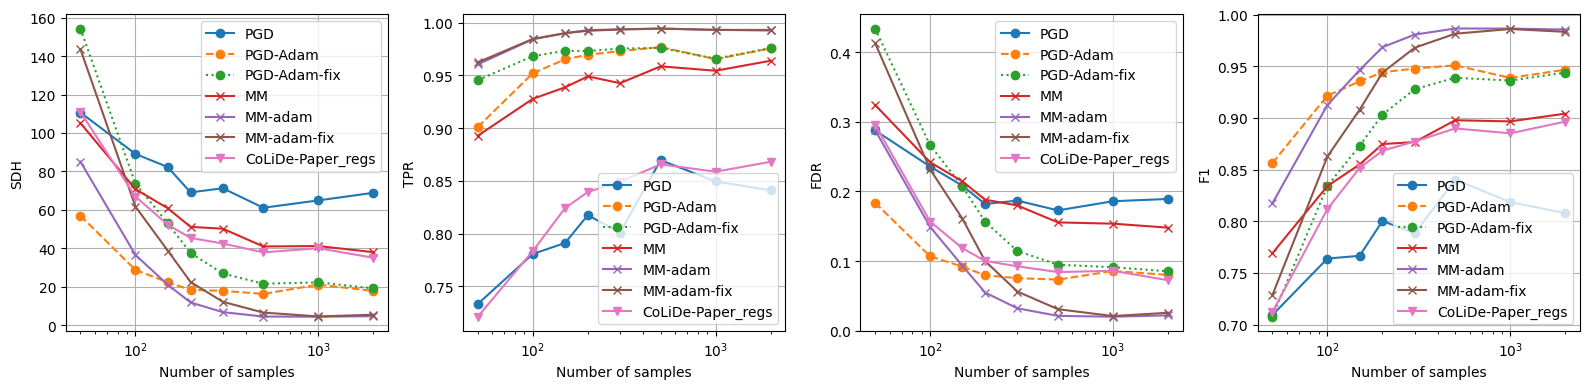

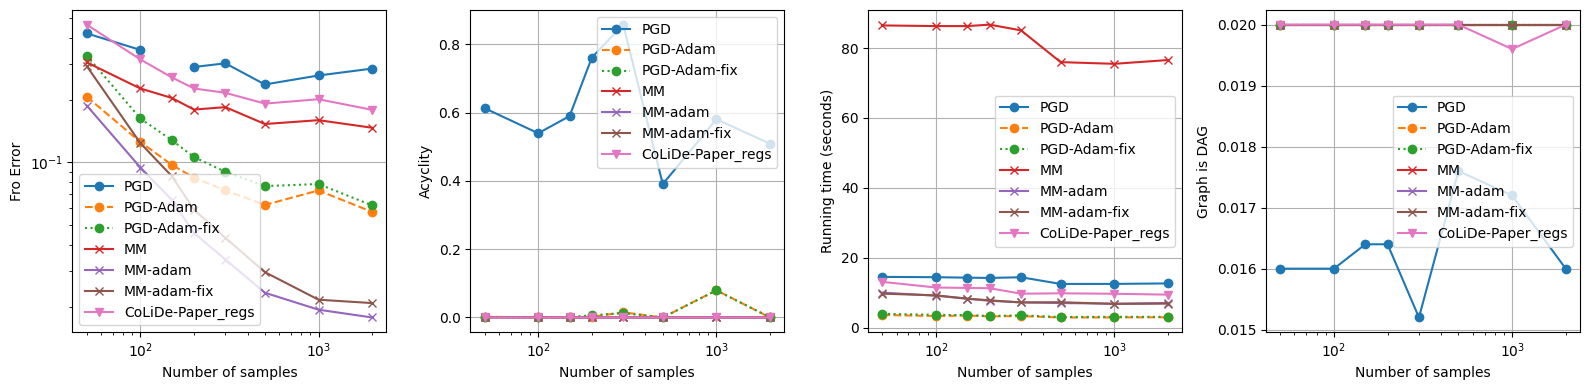

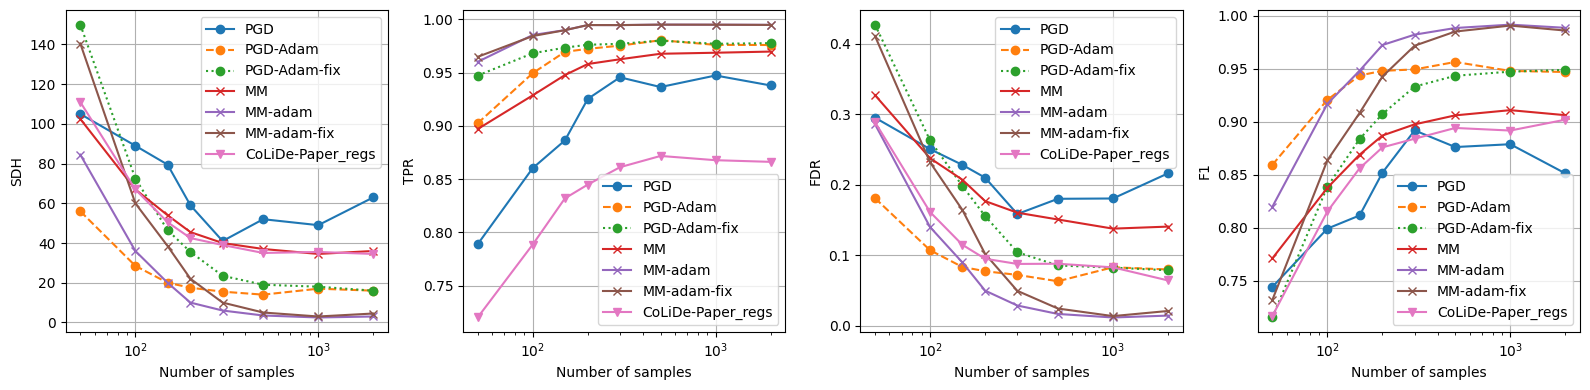

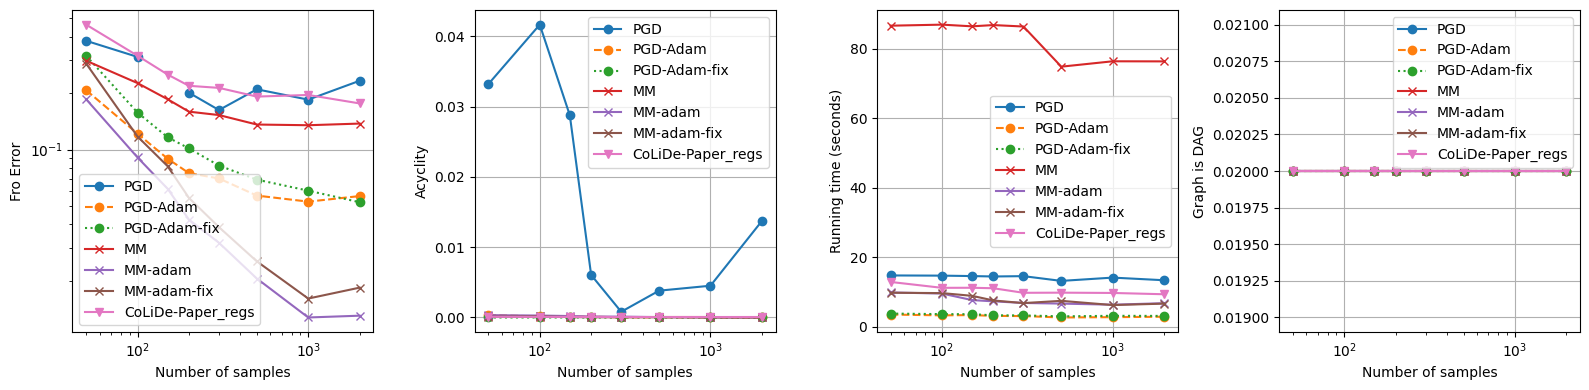

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


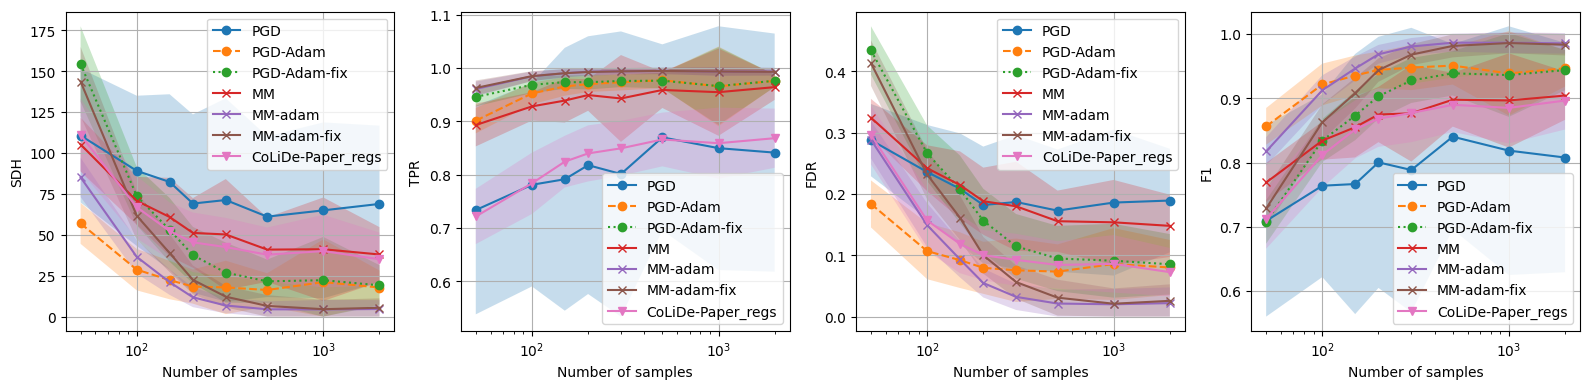

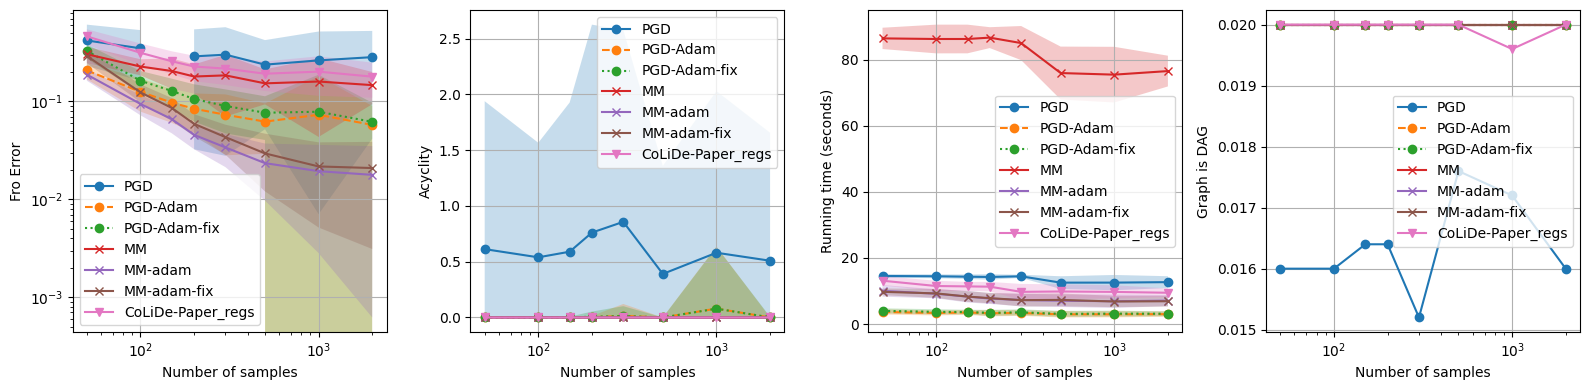

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean', dev=True)

# plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
#                  skip_idx=skip, agg='median', dev=True)


### 2N Edges 

In [ ]:
N = 100
thr = .2
verb = False
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 64
Graph: 1, samples: 50
Graph: 2, samples: 50
Graph: 3, samples: 50
Graph: 4, samples: 50
Graph: 5, samples: 50
Graph: 6, samples: 50
Graph: 7, samples: 50
Graph: 8, samples: 50
Graph: 9, samples: 50
Graph: 10, samples: 50
Graph: 11, samples: 50
Graph: 12, samples: 50
Graph: 13, samples: 50
Graph: 14, samples: 50
Graph: 15, samples: 50
Graph: 16, samples: 50
Graph: 17, samples: 50
Graph: 18, samples: 50
Graph: 19, samples: 50
Graph: 20, samples: 50
Graph: 21, samples: 50
Graph: 22, samples: 50
Graph: 23, samples: 50
Graph: 24, samples: 50
Graph: 25, samples: 50
Graph: 26, samples: 50
Graph: 27, samples: 50
Graph: 28, samples: 50
Graph: 29, samples: 50
Graph: 30, samples: 50
Graph: 31, samples: 50
Graph: 32, samples: 50
Graph: 33, samples: 50
Graph: 34, samples: 50
Graph: 35, samples: 50
Graph: 36, samples: 50
Graph: 37, samples: 50
Graph: 38, samples: 50
Graph: 39, samples: 50
Graph: 40, samples: 50
Graph: 41, samples: 50
Graph: 42, samples: 50
Graph: 43, samples: 50
Gr

  1%|▏         | 1686/130000.0 [00:01<01:35, 1339.55it/s]

		-MM-adam: shd 320.0  -  err: 0.492  -  time: 31.952


  0%|          | 140/130000.0 [00:00<01:33, 1396.22it/s]]

		-MM-adam-fix: shd 351.0  -  err: 0.439  -  time: 40.321
		-MM-adam-fix: shd 317.0  -  err: 0.439  -  time: 30.968


  0%|          | 405/130000.0 [00:00<01:47, 1208.64it/s] 

		-MM-adam: shd 290.0  -  err: 0.542  -  time: 38.066
		-MM-adam: shd 352.0  -  err: 0.492  -  time: 30.221
		-MM-adam-fix: shd 336.0  -  err: 0.471  -  time: 31.671


  0%|          | 468/130000.0 [00:00<01:51, 1164.90it/s]]

		-MM-adam: shd 299.0  -  err: 0.380  -  time: 39.520


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1453.54it/s]

		-MM-adam: shd 370.0  -  err: 0.532  -  time: 51.329
		-MM-adam-fix: shd 277.0  -  err: 0.408  -  time: 40.748
		-MM-adam: shd 318.0  -  err: 0.414  -  time: 29.819


  0%|          | 240/130000.0 [00:00<02:18, 936.08it/s] ]

		-MM: shd 371.0  -  err: 0.546  -  time: 180.896


  2%|▏         | 2443/130000.0 [00:01<01:28, 1434.25it/s]

		-MM-adam: shd 324.0  -  err: 0.470  -  time: 48.202


  6%|▌         | 7350/130000.0 [00:06<01:57, 1042.12it/s]

		-MM-adam-fix: shd 327.0  -  err: 0.487  -  time: 31.888


  1%|          | 1162/130000.0 [00:00<01:30, 1420.76it/s]

		-MM-adam-fix: shd 307.0  -  err: 0.489  -  time: 28.247


  4%|▍         | 5419/130000.0 [00:03<01:24, 1478.32it/s]

		-MM-adam: shd 282.0  -  err: 0.389  -  time: 35.499


  7%|▋         | 9234/130000.0 [00:07<01:49, 1106.35it/s]

		-MM-adam-fix: shd 289.0  -  err: 0.413  -  time: 32.659


  8%|▊         | 9916/130000.0 [00:08<01:49, 1093.40it/s]

		-MM-adam: shd 262.0  -  err: 0.406  -  time: 40.005


  5%|▌         | 7114/130000.0 [00:06<01:52, 1096.03it/s]]

		-MM-adam-fix: shd 397.0  -  err: 0.451  -  time: 19.542


  0%|          | 144/130000.0 [00:00<01:30, 1437.43it/s]]]

		-MM-adam-fix: shd 464.0  -  err: 0.618  -  time: 32.648
		-MM-adam-fix: shd 331.0  -  err: 0.451  -  time: 31.542


  0%|          | 313/130000.0 [00:00<01:58, 1092.67it/s]]]

		-MM-adam: shd 304.0  -  err: 0.454  -  time: 33.191


  8%|▊         | 10724/130000.0 [00:09<01:35, 1247.99it/s]

		-MM-adam: shd 277.0  -  err: 0.418  -  time: 29.682


  6%|▌         | 7742/130000.0 [00:06<01:20, 1516.12it/s]]

		-MM-adam-fix: shd 308.0  -  err: 0.432  -  time: 39.621


 10%|▉         | 12488/130000.0 [00:10<01:27, 1339.08it/s]

		-MM-adam: shd 313.0  -  err: 0.397  -  time: 38.529
		-MM-adam-fix: shd 345.0  -  err: 0.495  -  time: 42.526


  7%|▋         | 8591/130000.0 [00:07<01:48, 1118.57it/s]]

		-MM-adam: shd 360.0  -  err: 0.482  -  time: 39.383


  5%|▌         | 6756/130000.0 [00:05<01:52, 1100.17it/s]]

		-MM-adam: shd 243.0  -  err: 0.378  -  time: 37.480


  7%|▋         | 8888/130000.0 [00:07<01:55, 1046.72it/s]]

		-MM-adam: shd 304.0  -  err: 0.445  -  time: 29.385


  7%|▋         | 8816/130000.0 [00:07<01:43, 1166.35it/s]]

		-MM-adam: shd 345.0  -  err: 0.410  -  time: 33.305


  6%|▌         | 7693/130000.0 [00:06<01:19, 1537.26it/s]]

		-MM-adam: shd 313.0  -  err: 0.478  -  time: 37.419
		-MM-adam: shd 378.0  -  err: 0.478  -  time: 45.960


 11%|█▏        | 14706/130000.0 [00:12<01:27, 1313.28it/s]

		-MM-adam: shd 374.0  -  err: 0.537  -  time: 30.903


 16%|█▋        | 21387/130000.0 [00:18<01:47, 1008.63it/s]

		-MM-adam: shd 279.0  -  err: 0.397  -  time: 38.453


 14%|█▎        | 17615/130000.0 [00:14<01:31, 1234.47it/s]

		-MM-adam-fix: shd 459.0  -  err: 0.558  -  time: 27.821
		-MM-adam-fix: shd 381.0  -  err: 0.487  -  time: 31.386


 12%|█▏        | 15718/130000.0 [00:13<01:15, 1506.98it/s]

		-MM: shd 271.0  -  err: 0.460  -  time: 198.174
		-MM-adam-fix: shd 348.0  -  err: 0.508  -  time: 27.343


  2%|▏         | 2531/130000.0 [00:02<01:51, 1145.38it/s]]

		-MM-adam: shd 373.0  -  err: 0.480  -  time: 37.104


  0%|          | 110/130000.0 [00:00<01:58, 1095.61it/s]s]

		-MM-adam-fix: shd 320.0  -  err: 0.455  -  time: 35.081


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1040.33it/s]]

		-MM-adam-fix: shd 471.0  -  err: 0.559  -  time: 29.372


 16%|█▋        | 21414/130000.0 [00:18<01:45, 1029.30it/s]

		-MM: shd 332.0  -  err: 0.480  -  time: 204.972


 17%|█▋        | 22558/130000.0 [00:19<01:34, 1134.27it/s] 

		-MM-adam: shd 417.0  -  err: 0.529  -  time: 29.439


  7%|▋         | 9074/130000.0 [00:08<01:59, 1010.05it/s] ]

		-MM-adam-fix: shd 304.0  -  err: 0.443  -  time: 40.444


 19%|█▊        | 24261/130000.0 [00:20<01:37, 1084.70it/s]]

		-MM-adam-fix: shd 389.0  -  err: 0.537  -  time: 26.607


 17%|█▋        | 21602/130000.0 [00:19<01:38, 1102.04it/s]

		-MM-adam: shd 374.0  -  err: 0.543  -  time: 35.160
		-MM-adam-fix: shd 324.0  -  err: 0.417  -  time: 27.199


  2%|▏         | 2375/130000.0 [00:01<01:32, 1379.30it/s]] 

		-MM-adam-fix: shd 371.0  -  err: 0.533  -  time: 39.449


 22%|██▏       | 28012/130000.0 [00:22<01:30, 1123.16it/s] 

		-MM-adam-fix: shd 525.0  -  err: 0.686  -  time: 48.343
		-MM-adam-fix: shd 351.0  -  err: 0.496  -  time: 37.230


  0%|          | 408/130000.0 [00:00<01:57, 1106.00it/s]s]

		-MM-adam-fix: shd 451.0  -  err: 0.581  -  time: 35.301


  2%|▏         | 2231/130000.0 [00:01<01:32, 1375.50it/s]] 

		-MM-adam-fix: shd 409.0  -  err: 0.521  -  time: 37.098
		-MM-adam-fix: shd 333.0  -  err: 0.509  -  time: 32.336


  9%|▉         | 12304/130000.0 [00:10<01:57, 999.30it/s]  

		-MM-adam-fix: shd 377.0  -  err: 0.513  -  time: 30.528


  0%|          | 151/130000.0 [00:00<01:26, 1503.47it/s]s]]

		-MM-adam-fix: shd 304.0  -  err: 0.401  -  time: 28.476


 11%|█         | 13915/130000.0 [00:12<01:43, 1125.75it/s]]

		-MM-adam: shd 409.0  -  err: 0.555  -  time: 31.800


  3%|▎         | 4000/130000.0 [00:03<02:00, 1047.56it/s]] 

		-MM-adam-fix: shd 334.0  -  err: 0.433  -  time: 23.795


  1%|          | 1146/130000.0 [00:01<02:00, 1068.93it/s]]]

		-MM-adam-fix: shd 349.0  -  err: 0.513  -  time: 18.764


 11%|█         | 13751/130000.0 [00:11<01:43, 1119.32it/s] 

		-MM-adam-fix: shd 300.0  -  err: 0.539  -  time: 38.663


100%|██████████| 130000/130000.0 [00:39<00:00, 3285.06it/s]
 11%|█         | 13932/130000.0 [00:11<01:41, 1146.15it/s]

		-CoLiDe-Paper_regs: shd 581.0  -  err: 0.819  -  time: 39.574
Graph: 42, samples: 75


100%|██████████| 130000/130000.0 [00:40<00:00, 3220.96it/s]
100%|██████████| 130000/130000.0 [00:43<00:00, 2959.10it/s]


		-CoLiDe-Paper_regs: shd 608.0  -  err: 0.922  -  time: 40.361
Graph: 19, samples: 75
		-CoLiDe-Paper_regs: shd 562.0  -  err: 0.691  -  time: 43.933
Graph: 13, samples: 75


100%|██████████| 130000/130000.0 [00:40<00:00, 3224.48it/s]
 38%|███▊      | 49766/130000.0 [00:34<01:09, 1147.37it/s]

		-CoLiDe-Paper_regs: shd 584.0  -  err: 0.778  -  time: 40.317
Graph: 44, samples: 75
		-MM-adam-fix: shd 258.0  -  err: 0.405  -  time: 29.437
		-MM-adam-fix: shd 324.0  -  err: 0.480  -  time: 34.751


 14%|█▍        | 18119/130000.0 [00:15<01:47, 1036.76it/s]

		-MM-adam-fix: shd 309.0  -  err: 0.397  -  time: 42.161


 13%|█▎        | 16729/130000.0 [00:14<01:21, 1389.03it/s]]

		-PGD: shd 190.0  -  err: 0.309  -  time: 5.651
		-MM-adam-fix: shd 269.0  -  err: 0.419  -  time: 39.806


100%|██████████| 130000/130000.0 [00:45<00:00, 2858.81it/s]
 13%|█▎        | 16587/130000.0 [00:15<01:42, 1110.47it/s]

		-CoLiDe-Paper_regs: shd 572.0  -  err: 0.808  -  time: 45.475
Graph: 41, samples: 75
		-CoLiDe-Paper_regs: shd 547.0  -  err: 0.787  -  time: 42.499
Graph: 48, samples: 75


100%|██████████| 130000/130000.0 [00:42<00:00, 3058.97it/s]
100%|██████████| 130000/130000.0 [00:42<00:00, 3026.48it/s]
 50%|████▉     | 64784/130000.0 [00:37<00:27, 2366.04it/s]

		-MM-adam-fix: shd 389.0  -  err: 0.546  -  time: 29.248
		-CoLiDe-Paper_regs: shd 565.0  -  err: 0.757  -  time: 42.955
Graph: 43, samples: 75


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1095.78it/s]] 

		-MM-adam-fix: shd 339.0  -  err: 0.483  -  time: 45.706


 53%|█████▎    | 69102/130000.0 [00:42<00:44, 1364.51it/s]

		-MM-adam-fix: shd 376.0  -  err: 0.501  -  time: 37.144


100%|██████████| 130000/130000.0 [00:43<00:00, 2978.07it/s] 
 16%|█▌        | 20662/130000.0 [00:17<01:12, 1517.22it/s]

		-CoLiDe-Paper_regs: shd 578.0  -  err: 0.763  -  time: 43.653
Graph: 1, samples: 75
		-MM-adam-fix: shd 313.0  -  err: 0.462  -  time: 35.856


 18%|█▊        | 23091/130000.0 [00:20<01:14, 1427.52it/s]

		-MM-adam-fix: shd 302.0  -  err: 0.414  -  time: 30.688


 52%|█████▏    | 67569/130000.0 [00:39<00:37, 1644.98it/s]

		-MM-adam-fix: shd 290.0  -  err: 0.420  -  time: 39.808
		-PGD-Adam: shd 190.0  -  err: 0.307  -  time: 3.831
		-CoLiDe-Paper_regs: shd 565.0  -  err: 0.736  -  time: 42.953
Graph: 31, samples: 75


100%|██████████| 130000/130000.0 [00:42<00:00, 3026.62it/s]
100%|██████████| 130000/130000.0 [00:42<00:00, 3054.41it/s] 
 16%|█▌        | 20678/130000.0 [00:18<01:49, 1000.55it/s]

		-CoLiDe-Paper_regs: shd 608.0  -  err: 0.853  -  time: 42.562
Graph: 2, samples: 75


 52%|█████▏    | 67921/130000.0 [00:43<00:46, 1334.65it/s] 

		-PGD: shd 138.0  -  err: 0.224  -  time: 9.472


  8%|▊         | 10518/130000.0 [00:08<01:46, 1117.97it/s]]

		-PGD: shd 167.0  -  err: 0.292  -  time: 9.800


  8%|▊         | 10827/130000.0 [00:10<01:58, 1009.19it/s]]

		-MM-adam-fix: shd 369.0  -  err: 0.434  -  time: 38.531


100%|██████████| 130000/130000.0 [00:43<00:00, 3019.87it/s]  
  5%|▍         | 6016/130000.0 [00:04<01:48, 1141.32it/s]]

		-CoLiDe-Paper_regs: shd 542.0  -  err: 0.695  -  time: 43.049
Graph: 32, samples: 75


 17%|█▋        | 21528/130000.0 [00:19<01:44, 1042.62it/s] 

		-PGD-Adam-fix: shd 257.0  -  err: 0.372  -  time: 4.487


  5%|▍         | 6224/130000.0 [00:05<01:59, 1037.89it/s]]

		-PGD: shd 157.0  -  err: 0.305  -  time: 8.340


100%|██████████| 130000/130000.0 [00:43<00:00, 2970.82it/s] 
  5%|▌         | 6660/130000.0 [00:06<01:57, 1049.41it/s]]

		-CoLiDe-Paper_regs: shd 562.0  -  err: 0.733  -  time: 43.760
Graph: 14, samples: 75


100%|██████████| 130000/130000.0 [00:47<00:00, 2718.88it/s]
  6%|▋         | 8409/130000.0 [00:06<02:01, 999.87it/s] ]

		-CoLiDe-Paper_regs: shd 597.0  -  err: 0.813  -  time: 47.814
Graph: 9, samples: 75


  6%|▌         | 8017/130000.0 [00:06<01:49, 1117.93it/s]]]

		-PGD: shd 187.0  -  err: 0.321  -  time: 9.341
		-PGD-Adam: shd 173.0  -  err: 0.288  -  time: 3.601


 18%|█▊        | 22822/130000.0 [00:20<01:37, 1096.67it/s] 

		-PGD-Adam: shd 145.0  -  err: 0.237  -  time: 5.219


 21%|██▏       | 27658/130000.0 [00:25<01:28, 1149.96it/s]

		-MM-adam-fix: shd 438.0  -  err: 0.551  -  time: 29.692


 14%|█▎        | 17570/130000.0 [00:14<01:38, 1145.57it/s]]

		-PGD: shd 171.0  -  err: 0.253  -  time: 10.168
		-MM-adam-fix: shd 414.0  -  err: 0.515  -  time: 40.353


 15%|█▍        | 19144/130000.0 [00:16<01:34, 1170.16it/s] 

		-PGD: shd 173.0  -  err: 0.272  -  time: 8.310


 51%|█████     | 66308/130000.0 [00:38<00:35, 1794.09it/s] 

		-PGD-Adam-fix: shd 227.0  -  err: 0.345  -  time: 3.688


 10%|▉         | 12678/130000.0 [00:10<01:18, 1495.28it/s] 

		-PGD-Adam-fix: shd 199.0  -  err: 0.273  -  time: 3.910


 22%|██▏       | 29030/130000.0 [00:26<01:23, 1212.44it/s] 

		-PGD-Adam: shd 184.0  -  err: 0.304  -  time: 5.399
		-PGD-Adam: shd 161.0  -  err: 0.303  -  time: 6.527


100%|██████████| 130000/130000.0 [00:41<00:00, 3170.33it/s]
 12%|█▏        | 15166/130000.0 [00:13<01:42, 1118.41it/s]

		-CoLiDe-Paper_regs: shd 603.0  -  err: 0.838  -  time: 41.006
Graph: 21, samples: 75


100%|██████████| 130000/130000.0 [00:42<00:00, 3045.61it/s]  
 11%|█         | 13983/130000.0 [00:12<01:26, 1348.95it/s]]

		-CoLiDe-Paper_regs: shd 578.0  -  err: 0.753  -  time: 42.685
Graph: 5, samples: 75


 11%|█         | 14606/130000.0 [00:12<01:18, 1462.31it/s] 

		-PGD-Adam: shd 175.0  -  err: 0.258  -  time: 4.714


 54%|█████▍    | 70670/130000.0 [00:43<00:50, 1166.74it/s]

		-PGD-Adam: shd 174.0  -  err: 0.272  -  time: 4.552


100%|██████████| 130000/130000.0 [00:41<00:00, 3101.98it/s]
 13%|█▎        | 17479/130000.0 [00:15<01:39, 1131.40it/s]]

		-CoLiDe-Paper_regs: shd 558.0  -  err: 0.746  -  time: 41.910
Graph: 15, samples: 75


 14%|█▍        | 17931/130000.0 [00:15<01:46, 1056.78it/s]

		-MM-adam: shd 350.0  -  err: 0.475  -  time: 38.492
		-CoLiDe-Paper_regs: shd 584.0  -  err: 0.769  -  time: 45.026
Graph: 12, samples: 75


100%|██████████| 130000/130000.0 [00:45<00:00, 2887.28it/s]
 52%|█████▏    | 67145/130000.0 [00:37<00:38, 1626.49it/s] 

		-PGD-Adam-fix: shd 237.0  -  err: 0.297  -  time: 3.188


 51%|█████     | 66601/130000.0 [00:37<01:02, 1022.07it/s]]

		-MM-adam-fix: shd 410.0  -  err: 0.509  -  time: 44.745


 51%|█████▏    | 66827/130000.0 [00:37<00:59, 1069.79it/s]]

		-PGD-Adam-fix: shd 218.0  -  err: 0.345  -  time: 5.501


 52%|█████▏    | 67275/130000.0 [00:39<00:54, 1140.56it/s] 

		-PGD: shd 132.0  -  err: 0.246  -  time: 18.165


 48%|████▊     | 62932/130000.0 [00:36<00:28, 2330.04it/s]]

		-MM-adam-fix: shd 425.0  -  err: 0.551  -  time: 33.720
		-PGD-Adam-fix: shd 254.0  -  err: 0.359  -  time: 6.669


 40%|███▉      | 51780/130000.0 [00:38<01:03, 1226.23it/s]

		-MM-adam-fix: shd 391.0  -  err: 0.562  -  time: 39.189
		-PGD: shd 153.0  -  err: 0.241  -  time: 15.234


100%|██████████| 130000/130000.0 [00:38<00:00, 3350.48it/s]
  3%|▎         | 3841/130000.0 [00:02<01:31, 1375.50it/s]] 

		-CoLiDe-Paper_regs: shd 560.0  -  err: 0.792  -  time: 38.801
Graph: 23, samples: 75


 10%|▉         | 12841/130000.0 [00:11<01:56, 1004.28it/s]]

		-PGD: shd 222.0  -  err: 0.326  -  time: 7.517


100%|██████████| 130000/130000.0 [00:40<00:00, 3215.01it/s]
100%|██████████| 130000/130000.0 [00:44<00:00, 2937.10it/s]
 10%|█         | 13295/130000.0 [00:11<01:46, 1096.82it/s]

		-PGD-Adam-fix: shd 241.0  -  err: 0.314  -  time: 6.512
		-CoLiDe-Paper_regs: shd 518.0  -  err: 0.583  -  time: 40.436
Graph: 17, samples: 75
		-CoLiDe-Paper_regs: shd 541.0  -  err: 0.683  -  time: 44.262
Graph: 47, samples: 75


100%|██████████| 130000/130000.0 [00:42<00:00, 3056.32it/s]
100%|██████████| 130000/130000.0 [00:43<00:00, 2992.00it/s]
 51%|█████     | 66544/130000.0 [00:39<00:57, 1096.62it/s]

		-CoLiDe-Paper_regs: shd 562.0  -  err: 0.797  -  time: 42.535
Graph: 33, samples: 75
		-CoLiDe-Paper_regs: shd 584.0  -  err: 0.729  -  time: 43.450
Graph: 18, samples: 75


 17%|█▋        | 22042/130000.0 [00:19<01:36, 1119.44it/s] 

		-PGD-Adam: shd 135.0  -  err: 0.264  -  time: 4.503


 13%|█▎        | 16484/130000.0 [00:14<01:39, 1137.18it/s]]

		-PGD-Adam: shd 154.0  -  err: 0.240  -  time: 4.169
		-CoLiDe-Paper_regs: shd 542.0  -  err: 0.676  -  time: 41.486
Graph: 45, samples: 75


100%|██████████| 130000/130000.0 [00:41<00:00, 3133.75it/s] 
100%|██████████| 130000/130000.0 [00:41<00:00, 3120.87it/s]  
 22%|██▏       | 28221/130000.0 [00:24<01:16, 1324.76it/s]]

		-CoLiDe-Paper_regs: shd 532.0  -  err: 0.719  -  time: 41.656
Graph: 40, samples: 75
		-CoLiDe-Paper_regs: shd 554.0  -  err: 0.811  -  time: 42.006
Graph: 46, samples: 75


100%|██████████| 130000/130000.0 [00:42<00:00, 3094.84it/s]
100%|██████████| 130000/130000.0 [00:44<00:00, 2931.02it/s]
 19%|█▊        | 24068/130000.0 [00:21<01:33, 1136.14it/s]

		-CoLiDe-Paper_regs: shd 560.0  -  err: 0.684  -  time: 44.354
Graph: 25, samples: 75
		-CoLiDe-Paper_regs: shd 542.0  -  err: 0.779  -  time: 43.670
Graph: 16, samples: 75


100%|██████████| 130000/130000.0 [00:43<00:00, 2976.91it/s]
100%|██████████| 130000/130000.0 [00:40<00:00, 3192.89it/s]
 52%|█████▏    | 67908/130000.0 [00:43<00:34, 1785.03it/s]]

		-CoLiDe-Paper_regs: shd 501.0  -  err: 0.649  -  time: 40.716
Graph: 22, samples: 75


 19%|█▉        | 25000/130000.0 [00:22<01:35, 1100.31it/s] 

		-PGD-Adam: shd 233.0  -  err: 0.338  -  time: 5.356


 20%|█▉        | 25464/130000.0 [00:22<01:31, 1142.39it/s]

		-PGD-Adam-fix: shd 183.0  -  err: 0.314  -  time: 3.090


 35%|███▍      | 45333/130000.0 [00:26<00:23, 3647.81it/s]]

		-MM-adam: shd 283.0  -  err: 0.452  -  time: 55.176


  7%|▋         | 9225/130000.0 [00:08<01:43, 1164.60it/s]] 

		-PGD-Adam-fix: shd 210.0  -  err: 0.277  -  time: 3.833


100%|██████████| 130000/130000.0 [00:42<00:00, 3081.88it/s] 
 55%|█████▍    | 71470/130000.0 [00:46<00:51, 1134.24it/s]

		-CoLiDe-Paper_regs: shd 576.0  -  err: 0.757  -  time: 42.183
Graph: 29, samples: 75
		-PGD-Adam-fix: shd 318.0  -  err: 0.431  -  time: 2.735


100%|██████████| 130000/130000.0 [00:48<00:00, 2681.11it/s]
 53%|█████▎    | 68799/130000.0 [00:42<00:53, 1145.21it/s]

		-CoLiDe-Paper_regs: shd 609.0  -  err: 0.845  -  time: 48.488
Graph: 28, samples: 75


100%|██████████| 130000/130000.0 [00:43<00:00, 2962.38it/s]
100%|██████████| 130000/130000.0 [00:40<00:00, 3198.73it/s] 


		-CoLiDe-Paper_regs: shd 551.0  -  err: 0.714  -  time: 43.884
Graph: 3, samples: 75
		-CoLiDe-Paper_regs: shd 540.0  -  err: 0.765  -  time: 40.642
Graph: 7, samples: 75


 11%|█         | 13809/130000.0 [00:12<01:40, 1154.56it/s]

		-PGD: shd 230.0  -  err: 0.307  -  time: 25.399


 36%|███▋      | 47324/130000.0 [00:33<00:49, 1686.70it/s]

		-PGD: shd 185.0  -  err: 0.278  -  time: 9.713
		-PGD: shd 166.0  -  err: 0.229  -  time: 7.076
		-PGD: shd 169.0  -  err: 0.316  -  time: 9.909


 52%|█████▏    | 67840/130000.0 [00:38<00:34, 1797.55it/s]

		-PGD: shd 278.0  -  err: 0.537  -  time: 39.489


100%|██████████| 130000/130000.0 [00:38<00:00, 3347.24it/s]
 52%|█████▏    | 68208/130000.0 [00:39<00:33, 1817.49it/s]

		-CoLiDe-Paper_regs: shd 569.0  -  err: 0.784  -  time: 38.839
Graph: 50, samples: 75


100%|██████████| 130000/130000.0 [00:39<00:00, 3333.20it/s]
100%|██████████| 130000/130000.0 [00:40<00:00, 3248.58it/s]


		-CoLiDe-Paper_regs: shd 533.0  -  err: 0.690  -  time: 39.002
Graph: 8, samples: 75
		-CoLiDe-Paper_regs: shd 584.0  -  err: 0.686  -  time: 40.018
Graph: 37, samples: 75
		-PGD: shd 127.0  -  err: 0.231  -  time: 3.574


 13%|█▎        | 16554/130000.0 [00:14<01:39, 1139.52it/s]]

		-PGD-Adam: shd 172.0  -  err: 0.333  -  time: 1.854


 17%|█▋        | 21535/130000.0 [00:18<01:34, 1153.74it/s] 

		-PGD: shd 167.0  -  err: 0.258  -  time: 11.562
		-PGD: shd 133.0  -  err: 0.224  -  time: 7.142


 48%|████▊     | 62720/130000.0 [00:37<00:17, 3915.92it/s] 

		-PGD-Adam: shd 227.0  -  err: 0.307  -  time: 3.976


 49%|████▉     | 63984/130000.0 [00:36<00:30, 2187.63it/s] 

		-PGD-Adam: shd 184.0  -  err: 0.279  -  time: 4.823
		-PGD-Adam: shd 171.0  -  err: 0.254  -  time: 4.813
		-PGD-Adam: shd 127.0  -  err: 0.229  -  time: 3.227


 16%|█▌        | 20549/130000.0 [00:18<01:37, 1123.40it/s]

		-PGD-Adam: shd 215.0  -  err: 0.295  -  time: 5.254


 51%|█████     | 66480/130000.0 [00:39<00:58, 1084.62it/s] 

		-PGD-Adam-fix: shd 229.0  -  err: 0.384  -  time: 4.909


100%|██████████| 130000/130000.0 [00:38<00:00, 3342.41it/s]
 51%|█████▏    | 66711/130000.0 [00:39<00:56, 1118.47it/s]

		-CoLiDe-Paper_regs: shd 580.0  -  err: 0.837  -  time: 38.895
Graph: 11, samples: 75
		-PGD-Adam: shd 132.0  -  err: 0.226  -  time: 3.759


 20%|██        | 26494/130000.0 [00:22<01:30, 1149.93it/s]]

		-PGD-Adam-fix: shd 166.0  -  err: 0.264  -  time: 2.806
		-PGD-Adam-fix: shd 313.0  -  err: 0.363  -  time: 4.179


100%|██████████| 130000/130000.0 [00:40<00:00, 3196.96it/s]
 18%|█▊        | 23880/130000.0 [00:20<01:32, 1148.30it/s]

		-CoLiDe-Paper_regs: shd 603.0  -  err: 0.805  -  time: 40.664
Graph: 10, samples: 75
		-PGD-Adam: shd 175.0  -  err: 0.246  -  time: 4.990


100%|██████████| 130000/130000.0 [00:43<00:00, 2970.38it/s]
 21%|██▏       | 27769/130000.0 [00:23<01:28, 1152.44it/s]

		-CoLiDe-Paper_regs: shd 531.0  -  err: 0.669  -  time: 43.766
Graph: 34, samples: 75


100%|██████████| 130000/130000.0 [00:40<00:00, 3194.81it/s]
 38%|███▊      | 49102/130000.0 [00:32<00:44, 1817.30it/s]

		-PGD-Adam-fix: shd 295.0  -  err: 0.350  -  time: 3.760
		-CoLiDe-Paper_regs: shd 570.0  -  err: 0.829  -  time: 40.692
Graph: 39, samples: 75


 51%|█████     | 66574/130000.0 [00:41<00:48, 1303.88it/s] 

		-PGD-Adam-fix: shd 275.0  -  err: 0.346  -  time: 5.153
		-PGD: shd 144.0  -  err: 0.207  -  time: 8.356
		-PGD-Adam-fix: shd 190.0  -  err: 0.266  -  time: 2.651


 20%|██        | 26296/130000.0 [00:23<01:31, 1131.94it/s]

		-PGD-Adam-fix: shd 233.0  -  err: 0.296  -  time: 5.738


100%|██████████| 130000/130000.0 [00:44<00:00, 2932.35it/s]


		-CoLiDe-Paper_regs: shd 574.0  -  err: 0.830  -  time: 44.334
Graph: 26, samples: 75


 53%|█████▎    | 68469/130000.0 [00:43<00:54, 1135.91it/s]

		-PGD: shd 199.0  -  err: 0.270  -  time: 12.510


100%|██████████| 130000/130000.0 [00:44<00:00, 2944.29it/s]


		-PGD: shd 577.0  -  err: 1.511  -  time: 43.207
		-CoLiDe-Paper_regs: shd 566.0  -  err: 0.736  -  time: 44.154
Graph: 4, samples: 75


 52%|█████▏    | 67355/130000.0 [00:40<00:47, 1322.50it/s] 

		-PGD: shd 155.0  -  err: 0.243  -  time: 19.325


 53%|█████▎    | 68782/130000.0 [00:37<00:42, 1451.31it/s]]

		-PGD-Adam-fix: shd 237.0  -  err: 0.314  -  time: 4.808


100%|██████████| 130000/130000.0 [00:42<00:00, 3085.35it/s]
 53%|█████▎    | 69331/130000.0 [00:38<00:46, 1314.43it/s]

		-CoLiDe-Paper_regs: shd 580.0  -  err: 0.745  -  time: 42.135
Graph: 27, samples: 75


100%|██████████| 130000/130000.0 [00:38<00:00, 3355.30it/s]
 56%|█████▌    | 72857/130000.0 [00:45<00:50, 1138.32it/s]

		-CoLiDe-Paper_regs: shd 626.0  -  err: 0.783  -  time: 38.745
Graph: 49, samples: 75


 56%|█████▋    | 73314/130000.0 [00:46<00:49, 1138.17it/s]

		-PGD: shd 192.0  -  err: 0.286  -  time: 14.346


 51%|█████     | 66332/130000.0 [00:38<00:54, 1166.35it/s]

		-PGD-Adam: shd 202.0  -  err: 0.285  -  time: 3.760


 57%|█████▋    | 74341/130000.0 [00:46<00:49, 1135.64it/s]

		-PGD-Adam: shd 144.0  -  err: 0.206  -  time: 5.764


100%|██████████| 130000/130000.0 [00:47<00:00, 2732.89it/s]
 52%|█████▏    | 67386/130000.0 [00:39<00:53, 1166.32it/s]

		-CoLiDe-Paper_regs: shd 584.0  -  err: 0.731  -  time: 47.569
Graph: 38, samples: 75


 52%|█████▏    | 67033/130000.0 [00:29<00:27, 2251.70it/s]

		-PGD: shd 564.0  -  err: 1.566  -  time: 42.112


 52%|█████▏    | 67458/130000.0 [00:30<00:29, 2085.08it/s]

		-PGD-Adam: shd 157.0  -  err: 0.245  -  time: 4.509


 53%|█████▎    | 68435/130000.0 [00:40<00:53, 1156.17it/s]

		-PGD: shd 220.0  -  err: 0.290  -  time: 10.177
		-PGD: shd 174.0  -  err: 0.285  -  time: 8.172


 53%|█████▎    | 69131/130000.0 [00:41<00:52, 1152.42it/s]

		-PGD-Adam: shd 203.0  -  err: 0.316  -  time: 5.892
		-PGD: shd 146.0  -  err: 0.306  -  time: 9.256
		-MM-adam-fix: shd 366.0  -  err: 0.485  -  time: 34.733


 55%|█████▍    | 70871/130000.0 [00:42<00:51, 1154.53it/s]

		-PGD: shd 198.0  -  err: 0.295  -  time: 10.980
		-PGD-Adam-fix: shd 277.0  -  err: 0.356  -  time: 3.954


100%|██████████| 130000/130000.0 [00:42<00:00, 3044.78it/s]
100%|██████████| 130000/130000.0 [00:32<00:00, 3962.82it/s]
  1%|▏         | 1699/130000.0 [00:01<01:55, 1114.96it/s]]

		-CoLiDe-Paper_regs: shd 589.0  -  err: 0.777  -  time: 32.806
Graph: 6, samples: 75
		-CoLiDe-Paper_regs: shd 543.0  -  err: 0.703  -  time: 42.697
Graph: 35, samples: 75
		-PGD-Adam-fix: shd 195.0  -  err: 0.254  -  time: 4.116


  2%|▏         | 2371/130000.0 [00:02<01:54, 1115.99it/s]]

		-PGD: shd 190.0  -  err: 0.461  -  time: 38.966


  2%|▏         | 2707/130000.0 [00:02<01:54, 1115.90it/s]]

		-PGD-Adam: shd 159.0  -  err: 0.259  -  time: 3.761


  3%|▎         | 4499/130000.0 [00:04<01:53, 1110.62it/s]]

		-PGD-Adam: shd 189.0  -  err: 0.290  -  time: 7.213


  4%|▍         | 4957/130000.0 [00:04<01:50, 1133.00it/s]]

		-PGD-Adam: shd 156.0  -  err: 0.326  -  time: 4.314
		-PGD-Adam: shd 220.0  -  err: 0.292  -  time: 5.201


  4%|▍         | 5642/130000.0 [00:05<01:49, 1138.04it/s]]

		-PGD-Adam-fix: shd 224.0  -  err: 0.309  -  time: 6.269
		-PGD: shd 164.0  -  err: 0.299  -  time: 6.776
		-PGD-Adam: shd 170.0  -  err: 0.288  -  time: 5.857


 52%|█████▏    | 67462/130000.0 [00:38<00:55, 1126.18it/s]

		-PGD-Adam: shd 195.0  -  err: 0.283  -  time: 4.303
		-PGD-Adam-fix: shd 255.0  -  err: 0.358  -  time: 5.578


 53%|█████▎    | 69380/130000.0 [00:39<00:54, 1113.39it/s]

		-PGD: shd 151.0  -  err: 0.280  -  time: 5.553


  7%|▋         | 8840/130000.0 [00:07<01:46, 1136.52it/s]]

		-PGD-Adam-fix: shd 206.0  -  err: 0.300  -  time: 5.622


 54%|█████▍    | 70608/130000.0 [00:41<00:53, 1104.98it/s]

		-PGD-Adam: shd 168.0  -  err: 0.234  -  time: 6.300
		-PGD: shd 261.0  -  err: 0.715  -  time: 42.840


 51%|█████     | 66020/130000.0 [00:39<00:42, 1502.85it/s]

		-PGD-Adam: shd 170.0  -  err: 0.305  -  time: 3.849
		-PGD: shd 167.0  -  err: 0.602  -  time: 39.006


100%|██████████| 130000/130000.0 [00:42<00:00, 3073.66it/s]


		-CoLiDe-Paper_regs: shd 534.0  -  err: 0.747  -  time: 42.296
Graph: 30, samples: 75
		-PGD-Adam-fix: shd 216.0  -  err: 0.380  -  time: 5.446
		-PGD: shd 301.0  -  err: 0.957  -  time: 44.903
		-PGD: shd 259.0  -  err: 0.328  -  time: 13.521


  9%|▉         | 12025/130000.0 [00:10<01:44, 1126.32it/s]

		-PGD-Adam-fix: shd 260.0  -  err: 0.352  -  time: 6.732
		-PGD-Adam-fix: shd 250.0  -  err: 0.341  -  time: 5.540


 10%|█         | 13163/130000.0 [00:11<01:43, 1129.39it/s]

		-PGD-Adam-fix: shd 275.0  -  err: 0.353  -  time: 6.023
		-PGD-Adam: shd 147.0  -  err: 0.265  -  time: 4.630


 53%|█████▎    | 69439/130000.0 [00:42<00:55, 1090.35it/s]

		-PGD-Adam-fix: shd 317.0  -  err: 0.368  -  time: 7.488
		-PGD-Adam: shd 173.0  -  err: 0.270  -  time: 3.827


  0%|          | 113/130000.0 [00:00<01:55, 1126.13it/s]s]

		-MM-adam-fix: shd 305.0  -  err: 0.473  -  time: 36.381


100%|██████████| 130000/130000.0 [00:44<00:00, 2941.15it/s]
 12%|█▏        | 15301/130000.0 [00:13<01:44, 1101.09it/s]

		-PGD-Adam-fix: shd 215.0  -  err: 0.351  -  time: 4.553
		-CoLiDe-Paper_regs: shd 517.0  -  err: 0.652  -  time: 44.201
Graph: 36, samples: 75


 12%|█▏        | 15523/130000.0 [00:13<01:44, 1100.67it/s]

		-PGD: shd 326.0  -  err: 0.884  -  time: 43.042
		-PGD-Adam: shd 155.0  -  err: 0.246  -  time: 4.153
		-PGD-Adam: shd 146.0  -  err: 0.249  -  time: 4.911


 12%|█▏        | 16187/130000.0 [00:14<01:44, 1090.46it/s]

		-PGD: shd 149.0  -  err: 0.240  -  time: 12.864


  1%|▏         | 1791/130000.0 [00:01<01:55, 1105.78it/s]]

		-PGD-Adam-fix: shd 216.0  -  err: 0.293  -  time: 6.510


  2%|▏         | 2346/130000.0 [00:02<01:55, 1103.40it/s]]

		-PGD: shd 271.0  -  err: 0.652  -  time: 44.511
		-PGD-Adam: shd 253.0  -  err: 0.321  -  time: 5.570


  3%|▎         | 3577/130000.0 [00:03<01:53, 1117.33it/s]]

		-PGD-Adam-fix: shd 235.0  -  err: 0.315  -  time: 4.177


 14%|█▍        | 18726/130000.0 [00:16<01:41, 1098.36it/s]

		-PGD: shd 232.0  -  err: 0.631  -  time: 41.511


 15%|█▌        | 19606/130000.0 [00:17<01:41, 1092.48it/s]

		-PGD-Adam-fix: shd 206.0  -  err: 0.307  -  time: 5.837


  4%|▍         | 5464/130000.0 [00:04<01:53, 1096.81it/s]]

		-PGD: shd 304.0  -  err: 0.903  -  time: 34.657
		-PGD-Adam-fix: shd 213.0  -  err: 0.301  -  time: 4.382


 17%|█▋        | 21476/130000.0 [00:19<01:39, 1091.30it/s]

		-PGD-Adam-fix: shd 190.0  -  err: 0.269  -  time: 5.254
		-PGD: shd 646.0  -  err: 1.697  -  time: 45.004
		-PGD: shd 628.0  -  err: 1.619  -  time: 45.181


 17%|█▋        | 22355/130000.0 [00:20<01:38, 1090.66it/s]

		-PGD-Adam: shd 158.0  -  err: 0.261  -  time: 5.697


  6%|▋         | 8438/130000.0 [00:07<01:51, 1093.97it/s]]

		-PGD: shd 180.0  -  err: 0.254  -  time: 28.156
		-PGD: shd 161.0  -  err: 0.230  -  time: 25.209
		-PGD-Adam-fix: shd 350.0  -  err: 0.407  -  time: 5.594


 18%|█▊        | 23786/130000.0 [00:21<01:37, 1094.40it/s]

		-PGD-Adam: shd 176.0  -  err: 0.297  -  time: 4.579
		-PGD-Adam: shd 205.0  -  err: 0.248  -  time: 7.500


  7%|▋         | 9430/130000.0 [00:08<01:49, 1096.26it/s]]

		-PGD-Adam: shd 177.0  -  err: 0.311  -  time: 3.641
		-PGD-Adam: shd 173.0  -  err: 0.227  -  time: 6.643


  9%|▉         | 11643/130000.0 [00:10<01:47, 1099.63it/s]

		-PGD-Adam: shd 176.0  -  err: 0.264  -  time: 4.577
		-PGD-Adam-fix: shd 192.0  -  err: 0.303  -  time: 4.014


 10%|█         | 13305/130000.0 [00:12<01:45, 1104.36it/s]

		-PGD: shd 564.0  -  err: 1.680  -  time: 44.103


 23%|██▎       | 29397/130000.0 [00:26<01:31, 1093.95it/s]

		-PGD-Adam-fix: shd 239.0  -  err: 0.354  -  time: 4.523


 11%|█▏        | 14859/130000.0 [00:13<01:43, 1107.25it/s]

		-PGD-Adam: shd 162.0  -  err: 0.276  -  time: 7.284


 23%|██▎       | 30498/130000.0 [00:27<01:30, 1097.70it/s]

		-PGD-Adam-fix: shd 238.0  -  err: 0.350  -  time: 6.246


 12%|█▏        | 15970/130000.0 [00:14<01:42, 1107.10it/s]

		-PGD-Adam: shd 161.0  -  err: 0.232  -  time: 6.734
		-PGD-Adam-fix: shd 295.0  -  err: 0.316  -  time: 6.526


 13%|█▎        | 16636/130000.0 [00:15<01:42, 1103.04it/s]]

		-PGD-Adam: shd 180.0  -  err: 0.255  -  time: 7.562


 13%|█▎        | 16858/130000.0 [00:15<01:42, 1102.22it/s]

		-PGD-Adam-fix: shd 237.0  -  err: 0.280  -  time: 6.821


 13%|█▎        | 17410/130000.0 [00:15<01:42, 1097.88it/s]

		-PGD-Adam-fix: shd 259.0  -  err: 0.326  -  time: 5.038


 14%|█▍        | 18625/130000.0 [00:16<01:41, 1100.16it/s]

		-PGD-Adam: shd 148.0  -  err: 0.221  -  time: 4.725


 17%|█▋        | 22281/130000.0 [00:20<01:38, 1095.40it/s] 

		-PGD-Adam-fix: shd 228.0  -  err: 0.294  -  time: 5.836


 19%|█▉        | 24820/130000.0 [00:22<01:35, 1099.60it/s]

		-PGD-Adam-fix: shd 209.0  -  err: 0.319  -  time: 9.101


 19%|█▉        | 25150/130000.0 [00:22<01:35, 1094.59it/s]

		-PGD-Adam-fix: shd 207.0  -  err: 0.277  -  time: 6.012


 20%|█▉        | 25921/130000.0 [00:23<01:34, 1097.35it/s]

		-PGD-Adam-fix: shd 241.0  -  err: 0.313  -  time: 8.437


 22%|██▏       | 28236/130000.0 [00:25<01:33, 1093.03it/s]

		-PGD: shd 283.0  -  err: 0.915  -  time: 44.752


100%|██████████| 130000/130000.0 [00:43<00:00, 2995.29it/s]


		-CoLiDe-Paper_regs: shd 519.0  -  err: 0.668  -  time: 43.402
Graph: 24, samples: 75
		-PGD-Adam: shd 144.0  -  err: 0.205  -  time: 4.928


 37%|███▋      | 48017/130000.0 [00:35<00:52, 1569.64it/s] 

		-PGD-Adam-fix: shd 194.0  -  err: 0.240  -  time: 5.277


 48%|████▊     | 62846/130000.0 [00:40<00:20, 3322.81it/s] 

		-PGD: shd 347.0  -  err: 0.983  -  time: 44.905


 50%|████▉     | 64845/130000.0 [00:42<00:28, 2259.35it/s]

		-PGD: shd 216.0  -  err: 0.679  -  time: 43.621


 53%|█████▎    | 69396/130000.0 [00:46<00:44, 1362.96it/s]

		-PGD-Adam: shd 148.0  -  err: 0.246  -  time: 5.655


100%|██████████| 130000/130000.0 [00:47<00:00, 2746.49it/s] 


		-CoLiDe-Paper_regs: shd 564.0  -  err: 0.745  -  time: 47.334
Graph: 20, samples: 75
		-PGD-Adam: shd 138.0  -  err: 0.216  -  time: 3.983
		-PGD-Adam-fix: shd 199.0  -  err: 0.265  -  time: 3.847
		-PGD: shd 175.0  -  err: 0.308  -  time: 21.825
		-PGD-Adam-fix: shd 216.0  -  err: 0.290  -  time: 5.714
		-PGD: shd 168.0  -  err: 0.295  -  time: 6.967
		-PGD-Adam: shd 168.0  -  err: 0.299  -  time: 4.423
		-PGD-Adam: shd 184.0  -  err: 0.329  -  time: 9.116
		-PGD-Adam-fix: shd 214.0  -  err: 0.343  -  time: 4.420
		-PGD-Adam-fix: shd 226.0  -  err: 0.356  -  time: 6.228
		-MM: shd 208.0  -  err: 0.307  -  time: 132.042
		-MM: shd 159.0  -  err: 0.284  -  time: 144.748
		-MM: shd 188.0  -  err: 0.351  -  time: 144.461
		-MM: shd 215.0  -  err: 0.376  -  time: 151.782
		-MM: shd 208.0  -  err: 0.372  -  time: 158.288
		-MM-adam: shd 216.0  -  err: 0.296  -  time: 21.628
		-MM: shd 173.0  -  err: 0.277  -  time: 143.569
		-MM: shd 218.0  -  err: 0.392  -  time: 152.306
		-MM: shd 196.0

  2%|▏         | 2572/130000.0 [00:02<01:44, 1214.52it/s]

		-MM-adam: shd 172.0  -  err: 0.261  -  time: 40.297
		-MM-adam: shd 197.0  -  err: 0.280  -  time: 25.214


  3%|▎         | 3427/130000.0 [00:02<01:44, 1214.36it/s]

		-MM-adam: shd 310.0  -  err: 0.397  -  time: 18.433


  3%|▎         | 4174/130000.0 [00:03<01:41, 1239.79it/s]

		-MM: shd 191.0  -  err: 0.360  -  time: 158.850


  4%|▍         | 5681/130000.0 [00:04<01:39, 1247.20it/s]

		-MM: shd 193.0  -  err: 0.327  -  time: 153.548


  6%|▌         | 7529/130000.0 [00:06<01:40, 1213.89it/s]

		-MM: shd 184.0  -  err: 0.273  -  time: 145.181


 15%|█▌        | 20117/130000.0 [00:07<00:03, 34149.75it/s]

		-MM: shd 176.0  -  err: 0.272  -  time: 150.988


 18%|█▊        | 23532/130000.0 [00:10<00:27, 3819.75it/s] 

		-MM-adam: shd 222.0  -  err: 0.282  -  time: 24.675
		-MM-adam: shd 215.0  -  err: 0.274  -  time: 29.861
		-MM: shd 194.0  -  err: 0.325  -  time: 142.671


 20%|█▉        | 25960/130000.0 [00:12<00:40, 2565.29it/s]

		-MM-adam: shd 223.0  -  err: 0.361  -  time: 35.264
		-MM: shd 200.0  -  err: 0.299  -  time: 140.360


 31%|███       | 40000/130000.0 [00:13<00:15, 5791.13it/s]

		-MM: shd 229.0  -  err: 0.339  -  time: 155.971
		-MM-adam: shd 177.0  -  err: 0.248  -  time: 28.069


 33%|███▎      | 42954/130000.0 [00:15<00:25, 3405.56it/s]

		-MM: shd 223.0  -  err: 0.323  -  time: 148.945


  0%|          | 0/130000.0 [00:00<?, ?it/s], 2587.35it/s]

		-MM: shd 245.0  -  err: 0.341  -  time: 149.044
		-MM-adam-fix: shd 247.0  -  err: 0.380  -  time: 29.624


 35%|███▍      | 45030/130000.0 [00:17<00:35, 2362.40it/s]

		-MM: shd 226.0  -  err: 0.345  -  time: 155.777


  1%|▏         | 1763/130000.0 [00:01<01:56, 1097.37it/s]]

		-MM-adam: shd 277.0  -  err: 0.343  -  time: 27.237


  4%|▍         | 5064/130000.0 [00:04<01:54, 1090.94it/s]s]

		-MM: shd 185.0  -  err: 0.333  -  time: 157.825


  5%|▌         | 7068/130000.0 [00:06<01:41, 1215.52it/s]

		-MM: shd 180.0  -  err: 0.392  -  time: 157.585


  6%|▌         | 7558/130000.0 [00:06<01:40, 1213.92it/s]

		-MM: shd 187.0  -  err: 0.298  -  time: 149.538


  6%|▌         | 7801/130000.0 [00:06<01:41, 1208.72it/s]] 

		-MM: shd 196.0  -  err: 0.278  -  time: 153.316
		-MM: shd 208.0  -  err: 0.334  -  time: 156.584
		-MM-adam: shd 160.0  -  err: 0.268  -  time: 27.997


  6%|▋         | 8410/130000.0 [00:07<01:40, 1211.78it/s]

		-MM: shd 207.0  -  err: 0.312  -  time: 139.598


  7%|▋         | 8777/130000.0 [00:07<01:39, 1214.60it/s]

		-MM-adam: shd 215.0  -  err: 0.297  -  time: 18.595


  0%|          | 109/130000.0 [00:00<01:59, 1083.79it/s]s]]

		-MM-adam-fix: shd 244.0  -  err: 0.373  -  time: 32.158


100%|██████████| 130000/130000.0 [00:26<00:00, 4828.87it/s]
  1%|          | 1526/130000.0 [00:01<01:58, 1087.77it/s]

		-CoLiDe-Paper_regs: shd 267.0  -  err: 0.432  -  time: 26.922
Graph: 43, samples: 100
		-MM-adam: shd 241.0  -  err: 0.332  -  time: 27.043
		-MM: shd 201.0  -  err: 0.333  -  time: 145.003


  1%|▏         | 1855/130000.0 [00:01<01:57, 1088.64it/s]

		-MM: shd 172.0  -  err: 0.287  -  time: 152.446


  3%|▎         | 4255/130000.0 [00:03<01:55, 1084.48it/s]] 

		-MM: shd 218.0  -  err: 0.334  -  time: 146.236


  4%|▍         | 5237/130000.0 [00:04<01:54, 1085.04it/s]]

		-MM-adam-fix: shd 213.0  -  err: 0.284  -  time: 28.481


  5%|▍         | 6110/130000.0 [00:05<01:54, 1081.51it/s]]

		-MM-adam: shd 222.0  -  err: 0.304  -  time: 18.647
		-MM: shd 180.0  -  err: 0.312  -  time: 151.281


  1%|          | 1342/130000.0 [00:01<01:56, 1108.66it/s]

		-MM: shd 180.0  -  err: 0.299  -  time: 158.340
		-MM: shd 195.0  -  err: 0.315  -  time: 165.339


  5%|▌         | 6874/130000.0 [00:06<01:53, 1082.04it/s]]

		-MM-adam-fix: shd 223.0  -  err: 0.356  -  time: 35.454


  6%|▌         | 7311/130000.0 [00:06<01:52, 1085.76it/s]

		-MM-adam: shd 220.0  -  err: 0.372  -  time: 28.947


  2%|▏         | 2348/130000.0 [00:02<01:55, 1108.75it/s]

		-MM: shd 208.0  -  err: 0.270  -  time: 148.119


  3%|▎         | 3461/130000.0 [00:03<01:54, 1109.00it/s]]

		-MM: shd 282.0  -  err: 0.374  -  time: 156.941


  3%|▎         | 4131/130000.0 [00:03<02:00, 1045.11it/s]]]

		-MM-adam: shd 155.0  -  err: 0.290  -  time: 39.529


  5%|▍         | 6248/130000.0 [00:05<01:52, 1104.21it/s]]

		-MM-adam: shd 183.0  -  err: 0.246  -  time: 27.632


  5%|▌         | 6913/130000.0 [00:06<01:53, 1088.77it/s]]

		-MM-adam: shd 281.0  -  err: 0.358  -  time: 36.435


  5%|▍         | 5965/130000.0 [00:05<01:53, 1096.36it/s]]

		-MM-adam-fix: shd 235.0  -  err: 0.292  -  time: 26.580


  7%|▋         | 9011/130000.0 [00:08<01:50, 1096.57it/s]] 

		-MM-adam-fix: shd 303.0  -  err: 0.360  -  time: 20.103


  6%|▋         | 8392/130000.0 [00:07<01:51, 1087.37it/s]

		-MM: shd 184.0  -  err: 0.314  -  time: 147.932


  7%|▋         | 8830/130000.0 [00:07<01:51, 1086.95it/s]]

		-MM-adam-fix: shd 189.0  -  err: 0.258  -  time: 25.903
		-MM: shd 200.0  -  err: 0.285  -  time: 147.265


 15%|█▌        | 20048/130000.0 [00:08<00:03, 33891.24it/s]

		-MM-adam-fix: shd 191.0  -  err: 0.280  -  time: 38.229


  2%|▏         | 2531/130000.0 [00:02<01:56, 1094.58it/s]s]

		-MM-adam-fix: shd 309.0  -  err: 0.386  -  time: 38.024


  4%|▎         | 4616/130000.0 [00:04<01:54, 1097.08it/s]] 

		-MM-adam-fix: shd 249.0  -  err: 0.371  -  time: 29.285


  4%|▎         | 4838/130000.0 [00:04<01:53, 1101.08it/s]

		-MM-adam: shd 202.0  -  err: 0.334  -  time: 29.717


  4%|▍         | 5504/130000.0 [00:05<01:52, 1104.34it/s]]

		-MM-adam: shd 234.0  -  err: 0.314  -  time: 18.442


  1%|          | 1568/130000.0 [00:01<01:55, 1115.47it/s]

		-MM: shd 167.0  -  err: 0.261  -  time: 150.772


  3%|▎         | 3418/130000.0 [00:03<01:55, 1093.22it/s]] 

		-MM-adam: shd 266.0  -  err: 0.312  -  time: 30.821
		-MM: shd 195.0  -  err: 0.304  -  time: 154.777


  3%|▎         | 4084/130000.0 [00:03<01:54, 1102.77it/s]]

		-MM-adam: shd 259.0  -  err: 0.366  -  time: 20.544


  3%|▎         | 4527/130000.0 [00:04<01:54, 1097.90it/s]]

		-MM-adam: shd 221.0  -  err: 0.303  -  time: 40.355
		-CoLiDe-Paper_regs: shd 236.0  -  err: 0.435  -  time: 28.078
Graph: 44, samples: 100


100%|██████████| 130000/130000.0 [00:28<00:00, 4630.12it/s] 
 20%|█▉        | 25866/130000.0 [00:13<00:45, 2266.93it/s]

		-MM-adam: shd 234.0  -  err: 0.330  -  time: 28.423


  5%|▍         | 6395/130000.0 [00:05<01:50, 1117.12it/s]]

		-MM-adam: shd 297.0  -  err: 0.356  -  time: 30.326


  7%|▋         | 8613/130000.0 [00:07<01:50, 1098.52it/s]]]

		-MM-adam: shd 184.0  -  err: 0.282  -  time: 21.158


  7%|▋         | 9309/130000.0 [00:08<01:48, 1115.92it/s]s]

		-MM-adam: shd 197.0  -  err: 0.278  -  time: 25.953


 18%|█▊        | 23169/130000.0 [00:10<00:27, 3816.02it/s] 

		-MM-adam-fix: shd 167.0  -  err: 0.275  -  time: 26.883


  0%|          | 500/130000.0 [00:00<01:44, 1243.92it/s]s] 

		-MM-adam: shd 324.0  -  err: 0.387  -  time: 17.600


  1%|          | 1501/130000.0 [00:01<01:43, 1242.49it/s]] 

		-MM-adam-fix: shd 252.0  -  err: 0.341  -  time: 40.089


  1%|          | 725/130000.0 [00:00<01:47, 1199.44it/s]]]

		-MM-adam: shd 233.0  -  err: 0.338  -  time: 36.954
		-MM-adam: shd 217.0  -  err: 0.277  -  time: 19.906


 35%|███▍      | 45067/130000.0 [00:23<01:09, 1218.04it/s] 

		-MM-adam: shd 198.0  -  err: 0.372  -  time: 30.658


  3%|▎         | 4121/130000.0 [00:03<01:41, 1243.35it/s]]

		-MM-adam: shd 187.0  -  err: 0.282  -  time: 32.569


  3%|▎         | 3271/130000.0 [00:02<01:45, 1199.43it/s]]

		-MM-adam: shd 249.0  -  err: 0.323  -  time: 30.098


100%|██████████| 130000/130000.0 [00:29<00:00, 4415.11it/s] 
  4%|▍         | 5246/130000.0 [00:04<01:40, 1245.49it/s]]

		-MM: shd 184.0  -  err: 0.250  -  time: 150.170
		-CoLiDe-Paper_regs: shd 224.0  -  err: 0.417  -  time: 29.445
Graph: 42, samples: 100


 36%|███▌      | 46704/130000.0 [00:24<01:19, 1053.19it/s]

		-MM-adam-fix: shd 269.0  -  err: 0.343  -  time: 28.203


  4%|▍         | 5107/130000.0 [00:04<01:42, 1214.47it/s]]

		-PGD: shd 61.0  -  err: 0.148  -  time: 11.234
		-MM: shd 174.0  -  err: 0.264  -  time: 135.496


  4%|▍         | 5351/130000.0 [00:04<01:42, 1215.55it/s]]

		-MM-adam: shd 218.0  -  err: 0.339  -  time: 29.279


  1%|          | 1551/130000.0 [00:01<01:57, 1096.28it/s]]

		-MM-adam-fix: shd 316.0  -  err: 0.362  -  time: 20.049


  0%|          | 217/130000.0 [00:00<01:59, 1083.87it/s]]s]

		-MM-adam-fix: shd 212.0  -  err: 0.288  -  time: 32.226


  6%|▋         | 8401/130000.0 [00:06<01:40, 1209.13it/s]]]

		-MM-adam-fix: shd 234.0  -  err: 0.378  -  time: 26.480


  7%|▋         | 9132/130000.0 [00:07<01:40, 1205.67it/s]]]

		-MM-adam: shd 205.0  -  err: 0.294  -  time: 29.892


  4%|▎         | 4647/130000.0 [00:04<01:55, 1080.69it/s]] 

		-PGD-Adam: shd 63.0  -  err: 0.154  -  time: 4.763


  2%|▏         | 3236/130000.0 [00:02<01:42, 1233.78it/s]]

		-MM-adam-fix: shd 250.0  -  err: 0.326  -  time: 18.997


  3%|▎         | 3484/130000.0 [00:02<01:42, 1236.17it/s]]

		-MM-adam: shd 191.0  -  err: 0.320  -  time: 29.853


  3%|▎         | 4478/130000.0 [00:03<01:41, 1237.09it/s]] 

		-MM-adam: shd 181.0  -  err: 0.302  -  time: 31.179


100%|██████████| 130000/130000.0 [00:31<00:00, 4154.85it/s]
100%|██████████| 130000/130000.0 [00:32<00:00, 3962.58it/s] 
  7%|▋         | 8802/130000.0 [00:08<01:52, 1080.53it/s]

		-CoLiDe-Paper_regs: shd 262.0  -  err: 0.494  -  time: 31.289
Graph: 41, samples: 100
		-CoLiDe-Paper_regs: shd 250.0  -  err: 0.426  -  time: 32.808
Graph: 32, samples: 100


  7%|▋         | 9021/130000.0 [00:08<01:51, 1083.63it/s]]

		-MM-adam: shd 223.0  -  err: 0.331  -  time: 31.591


 36%|███▌      | 46415/130000.0 [00:22<00:39, 2123.33it/s] 

		-MM-adam-fix: shd 285.0  -  err: 0.380  -  time: 19.527


  3%|▎         | 4004/130000.0 [00:03<01:54, 1101.78it/s]]]

		-MM-adam-fix: shd 189.0  -  err: 0.245  -  time: 28.797


100%|██████████| 130000/130000.0 [00:25<00:00, 5017.20it/s] 
  8%|▊         | 9804/130000.0 [00:09<01:49, 1099.13it/s]

		-PGD-Adam-fix: shd 82.0  -  err: 0.176  -  time: 4.601
		-MM-adam-fix: shd 291.0  -  err: 0.366  -  time: 21.704
		-CoLiDe-Paper_regs: shd 257.0  -  err: 0.433  -  time: 25.912
Graph: 29, samples: 100


 15%|█▌        | 20079/130000.0 [00:07<00:03, 34057.40it/s]

		-MM: shd 251.0  -  err: 0.298  -  time: 182.543


  1%|          | 1440/130000.0 [00:01<01:47, 1193.29it/s]]

		-MM-adam-fix: shd 177.0  -  err: 0.311  -  time: 30.945


100%|██████████| 130000/130000.0 [00:30<00:00, 4313.65it/s] 
  2%|▏         | 2971/130000.0 [00:02<01:55, 1095.85it/s]]

		-CoLiDe-Paper_regs: shd 257.0  -  err: 0.381  -  time: 30.138
Graph: 25, samples: 100
		-PGD: shd 183.0  -  err: 0.679  -  time: 40.574


  2%|▏         | 3191/130000.0 [00:02<01:55, 1094.81it/s]]

		-MM-adam: shd 212.0  -  err: 0.334  -  time: 28.245
		-MM-adam-fix: shd 231.0  -  err: 0.302  -  time: 36.574


  6%|▋         | 8306/130000.0 [00:07<01:50, 1097.78it/s]] 

		-MM-adam-fix: shd 344.0  -  err: 0.408  -  time: 17.554


  7%|▋         | 8747/130000.0 [00:07<01:50, 1097.83it/s]] 

		-MM-adam: shd 226.0  -  err: 0.302  -  time: 29.280


  1%|          | 1200/130000.0 [00:01<01:49, 1174.83it/s]] 

		-MM-adam-fix: shd 216.0  -  err: 0.346  -  time: 28.147


100%|██████████| 130000/130000.0 [00:32<00:00, 4054.87it/s] 
  2%|▏         | 2183/130000.0 [00:01<01:44, 1220.83it/s]]

		-CoLiDe-Paper_regs: shd 247.0  -  err: 0.399  -  time: 32.061
Graph: 13, samples: 100


100%|██████████| 130000/130000.0 [00:31<00:00, 4184.28it/s]
 51%|█████     | 66382/130000.0 [00:29<00:48, 1323.31it/s]

		-CoLiDe-Paper_regs: shd 260.0  -  err: 0.413  -  time: 31.070
Graph: 19, samples: 100
		-PGD-Adam: shd 99.0  -  err: 0.261  -  time: 3.819


100%|██████████| 130000/130000.0 [00:31<00:00, 4101.36it/s]
  4%|▍         | 5338/130000.0 [00:04<01:52, 1105.60it/s]]

		-CoLiDe-Paper_regs: shd 228.0  -  err: 0.413  -  time: 31.698
Graph: 21, samples: 100


100%|██████████| 130000/130000.0 [00:31<00:00, 4140.50it/s]
  4%|▍         | 5782/130000.0 [00:05<01:52, 1104.81it/s]]

		-CoLiDe-Paper_regs: shd 224.0  -  err: 0.419  -  time: 31.398
Graph: 48, samples: 100


  6%|▌         | 7548/130000.0 [00:06<01:51, 1100.24it/s]]]

		-MM-adam: shd 177.0  -  err: 0.256  -  time: 18.228


  4%|▍         | 5690/130000.0 [00:05<01:50, 1125.50it/s]]]

		-MM-adam-fix: shd 265.0  -  err: 0.338  -  time: 20.421


  0%|          | 555/130000.0 [00:00<01:56, 1106.86it/s]]] 

		-PGD: shd 94.0  -  err: 0.195  -  time: 12.073
		-MM-adam-fix: shd 237.0  -  err: 0.326  -  time: 30.586


  7%|▋         | 9180/130000.0 [00:08<01:52, 1077.35it/s]]

		-PGD-Adam-fix: shd 133.0  -  err: 0.300  -  time: 4.660


  1%|          | 1012/130000.0 [00:00<01:55, 1115.84it/s]] 

		-MM-adam-fix: shd 264.0  -  err: 0.356  -  time: 30.761


 34%|███▍      | 44080/130000.0 [00:19<00:37, 2263.02it/s]

		-MM-adam-fix: shd 322.0  -  err: 0.377  -  time: 29.507
		-PGD: shd 90.0  -  err: 0.211  -  time: 5.548


  7%|▋         | 8716/130000.0 [00:07<01:47, 1124.52it/s]] 

		-MM-adam: shd 193.0  -  err: 0.257  -  time: 34.925


  2%|▏         | 2295/130000.0 [00:02<01:57, 1090.21it/s]]]

		-MM-adam-fix: shd 215.0  -  err: 0.296  -  time: 29.058


  4%|▎         | 4664/130000.0 [00:04<01:54, 1097.61it/s]]]

		-MM-adam: shd 190.0  -  err: 0.280  -  time: 34.926
		-CoLiDe-Paper_regs: shd 260.0  -  err: 0.449  -  time: 28.262
Graph: 28, samples: 100


100%|██████████| 130000/130000.0 [00:28<00:00, 4600.02it/s] 
  4%|▍         | 5107/130000.0 [00:04<01:53, 1100.71it/s]]

		-PGD: shd 83.0  -  err: 0.204  -  time: 6.565
		-PGD-Adam: shd 94.0  -  err: 0.195  -  time: 4.097


 37%|███▋      | 48355/130000.0 [00:20<01:02, 1302.58it/s] 

		-PGD-Adam: shd 82.0  -  err: 0.204  -  time: 2.863
		-MM-adam-fix: shd 264.0  -  err: 0.351  -  time: 27.289


  2%|▏         | 2042/130000.0 [00:01<01:57, 1086.13it/s]]]

		-MM: shd 182.0  -  err: 0.329  -  time: 149.224
		-MM-adam: shd 173.0  -  err: 0.221  -  time: 26.541


100%|██████████| 130000/130000.0 [00:29<00:00, 4371.98it/s] 
  3%|▎         | 3485/130000.0 [00:03<01:53, 1113.84it/s]]

		-CoLiDe-Paper_regs: shd 262.0  -  err: 0.427  -  time: 29.736
Graph: 2, samples: 100


  5%|▌         | 6711/130000.0 [00:06<01:52, 1094.50it/s]]

		-MM-adam-fix: shd 227.0  -  err: 0.267  -  time: 29.855


  8%|▊         | 9884/130000.0 [00:08<01:48, 1105.01it/s]] 

		-PGD-Adam: shd 81.0  -  err: 0.201  -  time: 4.264


  8%|▊         | 10106/130000.0 [00:09<01:48, 1105.24it/s] 

		-PGD-Adam-fix: shd 121.0  -  err: 0.222  -  time: 4.447


  2%|▏         | 2310/130000.0 [00:02<01:56, 1097.09it/s]]

		-PGD-Adam-fix: shd 104.0  -  err: 0.228  -  time: 4.719


100%|██████████| 130000/130000.0 [00:30<00:00, 4326.65it/s] 
  5%|▍         | 6101/130000.0 [00:05<01:53, 1095.20it/s]]

		-CoLiDe-Paper_regs: shd 241.0  -  err: 0.395  -  time: 30.047
Graph: 18, samples: 100


  6%|▌         | 7853/130000.0 [00:07<01:49, 1113.09it/s]]]

		-PGD: shd 83.0  -  err: 0.194  -  time: 22.399
		-CoLiDe-Paper_regs: shd 245.0  -  err: 0.389  -  time: 29.166
Graph: 14, samples: 100


100%|██████████| 130000/130000.0 [00:29<00:00, 4457.32it/s] 
 15%|█▌        | 20099/130000.0 [00:11<00:05, 21968.39it/s]

		-MM-adam-fix: shd 191.0  -  err: 0.278  -  time: 38.036


100%|██████████| 130000/130000.0 [00:28<00:00, 4577.63it/s]
 22%|██▏       | 29238/130000.0 [00:18<01:22, 1214.96it/s]

		-MM-adam-fix: shd 242.0  -  err: 0.352  -  time: 30.778
		-CoLiDe-Paper_regs: shd 238.0  -  err: 0.411  -  time: 28.400
Graph: 33, samples: 100


 35%|███▌      | 45742/130000.0 [00:19<00:42, 1977.13it/s] 

		-PGD: shd 95.0  -  err: 0.178  -  time: 17.051


100%|██████████| 130000/130000.0 [00:31<00:00, 4104.91it/s] 
  1%|          | 1533/130000.0 [00:01<02:01, 1057.57it/s]s]

		-CoLiDe-Paper_regs: shd 243.0  -  err: 0.404  -  time: 31.670
Graph: 16, samples: 100


  2%|▏         | 2385/130000.0 [00:02<02:01, 1049.50it/s]] 

		-MM-adam-fix: shd 205.0  -  err: 0.372  -  time: 35.516
		-PGD-Adam-fix: shd 123.0  -  err: 0.230  -  time: 5.674


  2%|▏         | 2594/130000.0 [00:02<02:05, 1013.56it/s]]

		-PGD: shd 73.0  -  err: 0.213  -  time: 7.791


  2%|▏         | 2801/130000.0 [00:02<02:07, 997.53it/s]s]

		-MM: shd 178.0  -  err: 0.282  -  time: 168.134


  2%|▏         | 3205/130000.0 [00:03<02:07, 991.26it/s]s]

		-MM-adam-fix: shd 204.0  -  err: 0.296  -  time: 36.147


  3%|▎         | 4358/130000.0 [00:04<01:56, 1079.62it/s]] 

		-MM: shd 209.0  -  err: 0.365  -  time: 154.177


 50%|████▉     | 64401/130000.0 [00:25<00:24, 2676.19it/s] 

		-MM-adam-fix: shd 208.0  -  err: 0.318  -  time: 29.233


  2%|▏         | 2209/130000.0 [00:02<01:56, 1093.20it/s]] 

		-PGD-Adam: shd 79.0  -  err: 0.178  -  time: 5.501
		-MM-adam-fix: shd 189.0  -  err: 0.309  -  time: 28.869


100%|██████████| 130000/130000.0 [00:26<00:00, 4899.13it/s] 
  8%|▊         | 10044/130000.0 [00:09<01:50, 1089.07it/s]

		-CoLiDe-Paper_regs: shd 253.0  -  err: 0.409  -  time: 26.536
Graph: 8, samples: 100


100%|██████████| 130000/130000.0 [00:31<00:00, 4130.25it/s] 
  1%|▏         | 1848/130000.0 [00:01<01:58, 1079.21it/s]]

		-CoLiDe-Paper_regs: shd 237.0  -  err: 0.359  -  time: 31.476
Graph: 5, samples: 100


  3%|▎         | 3334/130000.0 [00:03<01:54, 1105.62it/s]]]

		-PGD-Adam: shd 100.0  -  err: 0.185  -  time: 6.094


 54%|█████▍    | 70716/130000.0 [00:30<00:37, 1592.98it/s] 

		-PGD-Adam: shd 74.0  -  err: 0.223  -  time: 4.577


100%|██████████| 130000/130000.0 [00:30<00:00, 4265.71it/s] 
  6%|▌         | 7862/130000.0 [00:07<01:56, 1050.69it/s]]

		-MM-adam-fix: shd 237.0  -  err: 0.346  -  time: 30.978
		-CoLiDe-Paper_regs: shd 217.0  -  err: 0.383  -  time: 30.476
Graph: 10, samples: 100


  4%|▍         | 5140/130000.0 [00:04<01:52, 1110.67it/s]]

		-MM-adam-fix: shd 254.0  -  err: 0.318  -  time: 25.537


100%|██████████| 130000/130000.0 [00:29<00:00, 4389.31it/s] 
  4%|▍         | 5588/130000.0 [00:05<01:51, 1113.63it/s]

		-CoLiDe-Paper_regs: shd 217.0  -  err: 0.384  -  time: 29.618
Graph: 3, samples: 100
		-MM-adam-fix: shd 230.0  -  err: 0.348  -  time: 27.636


  7%|▋         | 9476/130000.0 [00:08<01:59, 1012.44it/s]]

		-PGD: shd 82.0  -  err: 0.175  -  time: 8.234
		-PGD-Adam-fix: shd 107.0  -  err: 0.202  -  time: 4.289


100%|██████████| 130000/130000.0 [00:29<00:00, 4393.05it/s] 
  8%|▊         | 10302/130000.0 [00:09<01:56, 1030.23it/s]

		-CoLiDe-Paper_regs: shd 238.0  -  err: 0.410  -  time: 29.593
Graph: 1, samples: 100


  6%|▋         | 8289/130000.0 [00:07<01:50, 1104.09it/s]]

		-MM-adam-fix: shd 225.0  -  err: 0.314  -  time: 37.451


100%|██████████| 130000/130000.0 [00:27<00:00, 4777.92it/s] 
  7%|▋         | 8516/130000.0 [00:07<01:49, 1114.20it/s]]

		-CoLiDe-Paper_regs: shd 228.0  -  err: 0.430  -  time: 27.209
Graph: 38, samples: 100


  6%|▌         | 7462/130000.0 [00:06<01:50, 1112.97it/s]]

		-MM-adam: shd 284.0  -  err: 0.354  -  time: 31.306


 37%|███▋      | 47481/130000.0 [00:21<01:16, 1078.40it/s] 

		-PGD-Adam-fix: shd 103.0  -  err: 0.247  -  time: 4.168
		-PGD-Adam-fix: shd 138.0  -  err: 0.222  -  time: 4.701


100%|██████████| 130000/130000.0 [00:31<00:00, 4138.89it/s]
 10%|▉         | 12633/130000.0 [00:11<01:52, 1046.10it/s]

		-CoLiDe-Paper_regs: shd 256.0  -  err: 0.371  -  time: 31.410
Graph: 12, samples: 100


 11%|█         | 13984/130000.0 [00:13<01:47, 1077.47it/s]]

		-PGD: shd 58.0  -  err: 0.159  -  time: 8.186


 46%|████▌     | 60000/130000.0 [00:20<00:16, 4364.12it/s]]

		-PGD-Adam: shd 83.0  -  err: 0.181  -  time: 4.736


  5%|▍         | 5966/130000.0 [00:05<01:53, 1092.17it/s]]]

		-PGD: shd 402.0  -  err: 1.734  -  time: 45.514


  6%|▌         | 8000/130000.0 [00:07<01:50, 1106.44it/s]] 

		-PGD-Adam-fix: shd 109.0  -  err: 0.209  -  time: 3.719
		-PGD: shd 86.0  -  err: 0.205  -  time: 9.556


  8%|▊         | 10556/130000.0 [00:09<01:47, 1109.52it/s]

		-PGD-Adam: shd 81.0  -  err: 0.159  -  time: 3.589


100%|██████████| 130000/130000.0 [00:35<00:00, 3653.64it/s] 
  8%|▊         | 10778/130000.0 [00:09<01:47, 1107.03it/s]

		-CoLiDe-Paper_regs: shd 241.0  -  err: 0.443  -  time: 35.582
Graph: 49, samples: 100


100%|██████████| 130000/130000.0 [00:29<00:00, 4408.21it/s] 
  9%|▊         | 11223/130000.0 [00:10<01:47, 1105.94it/s]

		-PGD-Adam: shd 63.0  -  err: 0.167  -  time: 5.071
		-CoLiDe-Paper_regs: shd 204.0  -  err: 0.344  -  time: 29.491
Graph: 45, samples: 100


 10%|▉         | 12783/130000.0 [00:11<01:45, 1106.99it/s] 

		-MM-adam-fix: shd 190.0  -  err: 0.263  -  time: 31.641
		-CoLiDe-Paper_regs: shd 240.0  -  err: 0.408  -  time: 29.747
Graph: 11, samples: 100
		-CoLiDe-Paper_regs: shd 238.0  -  err: 0.434  -  time: 26.724
Graph: 50, samples: 100


100%|██████████| 130000/130000.0 [00:29<00:00, 4370.33it/s] 
100%|██████████| 130000/130000.0 [00:26<00:00, 4864.72it/s]  
  1%|          | 767/130000.0 [00:00<01:58, 1088.35it/s]s] 

		-PGD: shd 90.0  -  err: 0.194  -  time: 11.683


  2%|▏         | 2187/130000.0 [00:02<01:57, 1086.34it/s]]]

		-PGD: shd 83.0  -  err: 0.146  -  time: 22.747
		-PGD: shd 47.0  -  err: 0.134  -  time: 11.995
		-PGD-Adam-fix: shd 135.0  -  err: 0.196  -  time: 4.075


100%|██████████| 130000/130000.0 [00:29<00:00, 4357.16it/s] 
 21%|██        | 27185/130000.0 [00:18<01:12, 1409.51it/s]

		-CoLiDe-Paper_regs: shd 255.0  -  err: 0.433  -  time: 29.837
Graph: 23, samples: 100
		-PGD-Adam: shd 82.0  -  err: 0.200  -  time: 4.581


100%|██████████| 130000/130000.0 [00:32<00:00, 4005.58it/s] 
  2%|▏         | 2954/130000.0 [00:02<01:56, 1089.04it/s]]

		-CoLiDe-Paper_regs: shd 281.0  -  err: 0.495  -  time: 32.455
Graph: 31, samples: 100
		-PGD: shd 224.0  -  err: 0.862  -  time: 43.180


 21%|██▏       | 27894/130000.0 [00:18<01:19, 1285.23it/s] 

		-MM-adam-fix: shd 194.0  -  err: 0.240  -  time: 27.588


100%|██████████| 130000/130000.0 [00:34<00:00, 3770.42it/s]
  0%|          | 438/130000.0 [00:00<01:58, 1092.40it/s]]]

		-CoLiDe-Paper_regs: shd 212.0  -  err: 0.327  -  time: 34.480
Graph: 40, samples: 100
		-PGD-Adam-fix: shd 87.0  -  err: 0.203  -  time: 4.755


  4%|▍         | 5259/130000.0 [00:04<01:54, 1091.42it/s]] 

		-PGD-Adam: shd 90.0  -  err: 0.193  -  time: 4.111


 36%|███▋      | 47375/130000.0 [00:22<01:10, 1178.83it/s]

		-PGD: shd 69.0  -  err: 0.178  -  time: 5.310


 37%|███▋      | 48287/130000.0 [00:21<01:14, 1097.54it/s] 

		-PGD-Adam-fix: shd 128.0  -  err: 0.229  -  time: 4.075


 37%|███▋      | 48732/130000.0 [00:22<01:13, 1104.82it/s]

		-PGD: shd 184.0  -  err: 0.777  -  time: 45.559
		-PGD-Adam: shd 81.0  -  err: 0.146  -  time: 5.189


 38%|███▊      | 48955/130000.0 [00:22<01:13, 1106.68it/s]]

		-PGD-Adam: shd 58.0  -  err: 0.153  -  time: 4.356


 21%|██        | 27238/130000.0 [00:18<01:11, 1430.06it/s]]

		-MM-adam: shd 210.0  -  err: 0.370  -  time: 32.144
		-PGD-Adam: shd 47.0  -  err: 0.134  -  time: 5.427


  7%|▋         | 8995/130000.0 [00:08<01:50, 1091.35it/s]]]

		-PGD: shd 103.0  -  err: 0.410  -  time: 41.912


 34%|███▍      | 43928/130000.0 [00:20<00:29, 2947.35it/s]]

		-PGD: shd 74.0  -  err: 0.206  -  time: 6.042


  6%|▌         | 7578/130000.0 [00:06<02:03, 991.50it/s] ]

		-PGD-Adam-fix: shd 119.0  -  err: 0.221  -  time: 5.090


100%|██████████| 130000/130000.0 [00:34<00:00, 3817.50it/s]
 50%|█████     | 65523/130000.0 [00:29<00:31, 2058.92it/s] 

		-CoLiDe-Paper_regs: shd 266.0  -  err: 0.449  -  time: 34.055
Graph: 17, samples: 100
		-PGD: shd 68.0  -  err: 0.174  -  time: 10.134


  6%|▋         | 8311/130000.0 [00:07<01:55, 1057.76it/s]] 

		-PGD-Adam-fix: shd 108.0  -  err: 0.171  -  time: 3.491


  7%|▋         | 8641/130000.0 [00:07<01:52, 1082.87it/s]]

		-PGD-Adam: shd 68.0  -  err: 0.183  -  time: 5.339


 51%|█████▏    | 66730/130000.0 [00:30<00:39, 1592.57it/s] 

		-MM-adam: shd 207.0  -  err: 0.308  -  time: 27.710


100%|██████████| 130000/130000.0 [00:30<00:00, 4231.67it/s]
 36%|███▌      | 46602/130000.0 [00:23<00:42, 1946.74it/s]

		-CoLiDe-Paper_regs: shd 228.0  -  err: 0.395  -  time: 30.722
Graph: 37, samples: 100
		-PGD: shd 69.0  -  err: 0.166  -  time: 9.443
		-PGD-Adam: shd 101.0  -  err: 0.261  -  time: 4.982


  8%|▊         | 10070/130000.0 [00:09<01:52, 1070.25it/s] 

		-PGD-Adam-fix: shd 63.0  -  err: 0.152  -  time: 4.756


  8%|▊         | 10840/130000.0 [00:10<01:49, 1091.01it/s]

		-PGD-Adam: shd 68.0  -  err: 0.181  -  time: 4.870
		-MM-adam-fix: shd 215.0  -  err: 0.296  -  time: 40.266


 35%|███▍      | 44987/130000.0 [00:22<00:44, 1899.64it/s]]

		-PGD-Adam: shd 77.0  -  err: 0.218  -  time: 3.991


 36%|███▌      | 46458/130000.0 [00:24<00:35, 2373.59it/s]

		-PGD-Adam-fix: shd 85.0  -  err: 0.181  -  time: 6.507


  1%|          | 1558/130000.0 [00:01<01:56, 1099.39it/s]]

		-MM-adam-fix: shd 206.0  -  err: 0.276  -  time: 43.080


  2%|▏         | 2002/130000.0 [00:01<01:56, 1098.23it/s]]

		-MM-adam: shd 228.0  -  err: 0.373  -  time: 30.547
		-PGD-Adam: shd 69.0  -  err: 0.177  -  time: 4.770


100%|██████████| 130000/130000.0 [00:32<00:00, 4059.23it/s] 


		-CoLiDe-Paper_regs: shd 249.0  -  err: 0.465  -  time: 32.027
Graph: 34, samples: 100


 49%|████▉     | 63832/130000.0 [00:26<00:26, 2513.43it/s]

		-PGD-Adam: shd 70.0  -  err: 0.166  -  time: 3.714


100%|██████████| 130000/130000.0 [00:35<00:00, 3680.06it/s]
 37%|███▋      | 47782/130000.0 [00:25<01:14, 1109.30it/s]

		-CoLiDe-Paper_regs: shd 273.0  -  err: 0.463  -  time: 35.327
Graph: 15, samples: 100
		-CoLiDe-Paper_regs: shd 248.0  -  err: 0.424  -  time: 30.717
Graph: 6, samples: 100


100%|██████████| 130000/130000.0 [00:30<00:00, 4232.34it/s] 
 38%|███▊      | 49706/130000.0 [00:27<00:44, 1789.08it/s]

		-PGD-Adam-fix: shd 99.0  -  err: 0.223  -  time: 5.542
		-PGD-Adam-fix: shd 126.0  -  err: 0.290  -  time: 4.612


100%|██████████| 130000/130000.0 [00:32<00:00, 3987.77it/s]
  4%|▎         | 4574/130000.0 [00:04<01:53, 1104.24it/s]]

		-CoLiDe-Paper_regs: shd 254.0  -  err: 0.486  -  time: 32.601
Graph: 35, samples: 100
		-PGD-Adam-fix: shd 88.0  -  err: 0.201  -  time: 4.372


  4%|▍         | 5022/130000.0 [00:04<01:52, 1111.51it/s]]

		-PGD: shd 206.0  -  err: 0.627  -  time: 44.650
		-PGD: shd 74.0  -  err: 0.189  -  time: 7.404


100%|██████████| 130000/130000.0 [00:34<00:00, 3775.56it/s]


		-PGD-Adam-fix: shd 113.0  -  err: 0.245  -  time: 5.091
		-CoLiDe-Paper_regs: shd 294.0  -  err: 0.553  -  time: 34.433
Graph: 9, samples: 100


100%|██████████| 130000/130000.0 [00:31<00:00, 4105.38it/s]
 53%|█████▎    | 68900/130000.0 [00:32<00:43, 1412.12it/s]

		-CoLiDe-Paper_regs: shd 265.0  -  err: 0.455  -  time: 31.667
Graph: 26, samples: 100


  7%|▋         | 8537/130000.0 [00:07<01:47, 1127.45it/s]]

		-PGD-Adam-fix: shd 96.0  -  err: 0.191  -  time: 5.067


  6%|▌         | 7366/130000.0 [00:06<01:49, 1122.08it/s]]

		-PGD-Adam-fix: shd 105.0  -  err: 0.211  -  time: 5.868


100%|██████████| 130000/130000.0 [00:33<00:00, 3931.61it/s]
  6%|▌         | 7592/130000.0 [00:06<01:49, 1119.75it/s]

		-CoLiDe-Paper_regs: shd 252.0  -  err: 0.416  -  time: 33.066
Graph: 39, samples: 100


  6%|▌         | 8042/130000.0 [00:07<01:49, 1118.26it/s]] 

		-PGD-Adam: shd 76.0  -  err: 0.196  -  time: 4.073


 34%|███▎      | 43763/130000.0 [00:19<00:33, 2564.47it/s]

		-PGD-Adam: shd 115.0  -  err: 0.212  -  time: 4.406


 35%|███▍      | 45000/130000.0 [00:20<00:46, 1832.15it/s]

		-MM-adam-fix: shd 301.0  -  err: 0.340  -  time: 31.740


 35%|███▍      | 45185/130000.0 [00:20<00:49, 1721.42it/s]

		-PGD: shd 71.0  -  err: 0.153  -  time: 8.099


  8%|▊         | 10738/130000.0 [00:09<01:46, 1118.30it/s]]

		-PGD: shd 164.0  -  err: 0.692  -  time: 44.463


100%|██████████| 130000/130000.0 [00:34<00:00, 3781.30it/s] 
 36%|███▌      | 46988/130000.0 [00:22<01:15, 1096.90it/s]

		-CoLiDe-Paper_regs: shd 256.0  -  err: 0.484  -  time: 34.381
Graph: 22, samples: 100


  2%|▏         | 2626/130000.0 [00:02<01:57, 1079.59it/s]]

		-PGD-Adam-fix: shd 99.0  -  err: 0.211  -  time: 3.688


 11%|█         | 13764/130000.0 [00:12<01:44, 1115.73it/s] 

		-PGD: shd 214.0  -  err: 0.646  -  time: 44.443


100%|██████████| 130000/130000.0 [00:37<00:00, 3422.43it/s]
 11%|█         | 13988/130000.0 [00:12<01:44, 1115.27it/s]

		-PGD: shd 92.0  -  err: 0.197  -  time: 5.759
		-CoLiDe-Paper_regs: shd 327.0  -  err: 0.642  -  time: 37.986
Graph: 46, samples: 100


 38%|███▊      | 49497/130000.0 [00:24<01:14, 1076.70it/s]

		-PGD-Adam: shd 71.0  -  err: 0.153  -  time: 4.056


  4%|▍         | 4932/130000.0 [00:04<01:53, 1097.57it/s]]

		-PGD-Adam-fix: shd 150.0  -  err: 0.245  -  time: 5.486


 12%|█▏        | 14998/130000.0 [00:13<01:42, 1116.77it/s]

		-MM-adam-fix: shd 232.0  -  err: 0.394  -  time: 20.563


 39%|███▉      | 50929/130000.0 [00:25<01:13, 1073.67it/s]]

		-PGD-Adam: shd 56.0  -  err: 0.135  -  time: 4.442


 18%|█▊        | 23711/130000.0 [00:16<00:56, 1867.35it/s] 

		-PGD-Adam-fix: shd 89.0  -  err: 0.174  -  time: 3.964


  7%|▋         | 9406/130000.0 [00:08<01:51, 1085.34it/s]] 

		-PGD-Adam: shd 61.0  -  err: 0.141  -  time: 4.950
		-PGD: shd 266.0  -  err: 1.259  -  time: 45.171


  3%|▎         | 4457/130000.0 [00:04<01:53, 1104.19it/s]]

		-PGD-Adam: shd 93.0  -  err: 0.199  -  time: 4.920


100%|██████████| 130000/130000.0 [00:33<00:00, 3937.33it/s]
 33%|███▎      | 43420/130000.0 [00:20<00:31, 2785.68it/s]

		-CoLiDe-Paper_regs: shd 232.0  -  err: 0.415  -  time: 33.018
Graph: 36, samples: 100
		-PGD-Adam-fix: shd 83.0  -  err: 0.158  -  time: 4.621


 21%|██▏       | 27884/130000.0 [00:20<01:31, 1119.61it/s]]

		-PGD: shd 70.0  -  err: 0.171  -  time: 7.883
		-PGD: shd 282.0  -  err: 1.399  -  time: 44.248


 36%|███▌      | 46834/130000.0 [00:23<01:11, 1170.12it/s]]

		-PGD-Adam-fix: shd 81.0  -  err: 0.160  -  time: 4.227


100%|██████████| 130000/130000.0 [00:33<00:00, 3891.67it/s] 


		-CoLiDe-Paper_regs: shd 249.0  -  err: 0.410  -  time: 33.405
Graph: 4, samples: 100
		-PGD-Adam: shd 86.0  -  err: 0.166  -  time: 4.743


 37%|███▋      | 47630/130000.0 [00:23<01:12, 1130.99it/s] 

		-PGD: shd 69.0  -  err: 0.180  -  time: 16.501


 37%|███▋      | 47969/130000.0 [00:24<01:12, 1128.87it/s]

		-PGD: shd 280.0  -  err: 0.980  -  time: 44.075


 46%|████▌     | 60082/130000.0 [00:24<00:01, 36859.99it/s]

		-PGD-Adam-fix: shd 123.0  -  err: 0.226  -  time: 5.361


 34%|███▎      | 43809/130000.0 [00:24<00:24, 3494.73it/s] 

		-MM-adam-fix: shd 228.0  -  err: 0.318  -  time: 27.660


  1%|          | 783/130000.0 [00:00<01:56, 1111.11it/s]s] 

		-PGD: shd 72.0  -  err: 0.168  -  time: 14.692


  1%|          | 1007/130000.0 [00:00<01:56, 1109.89it/s]

		-PGD-Adam: shd 75.0  -  err: 0.180  -  time: 4.931


  1%|▏         | 1679/130000.0 [00:01<01:55, 1114.35it/s]] 

		-PGD-Adam: shd 75.0  -  err: 0.191  -  time: 5.330


  2%|▏         | 3027/130000.0 [00:02<01:53, 1116.81it/s]]

		-PGD: shd 401.0  -  err: 1.003  -  time: 43.371
		-PGD-Adam: shd 56.0  -  err: 0.159  -  time: 4.646


  3%|▎         | 3363/130000.0 [00:03<01:53, 1117.99it/s]

		-PGD-Adam: shd 60.0  -  err: 0.150  -  time: 5.192


 33%|███▎      | 42456/130000.0 [00:19<00:24, 3505.44it/s]

		-PGD: shd 246.0  -  err: 0.836  -  time: 43.694


 51%|█████     | 66376/130000.0 [00:29<00:26, 2358.46it/s]

		-PGD-Adam: shd 73.0  -  err: 0.167  -  time: 3.010


  4%|▍         | 5616/130000.0 [00:05<01:51, 1116.41it/s]]

		-PGD-Adam-fix: shd 110.0  -  err: 0.192  -  time: 7.455


 35%|███▍      | 45059/130000.0 [00:21<00:45, 1882.78it/s]

		-MM-adam-fix: shd 245.0  -  err: 0.401  -  time: 29.660


  5%|▌         | 6624/130000.0 [00:05<01:50, 1113.80it/s]]

		-PGD-Adam-fix: shd 109.0  -  err: 0.207  -  time: 4.885


  6%|▌         | 7630/130000.0 [00:06<01:50, 1109.22it/s]]

		-PGD-Adam-fix: shd 90.0  -  err: 0.208  -  time: 5.354
		-PGD-Adam: shd 79.0  -  err: 0.154  -  time: 4.250


100%|██████████| 130000/130000.0 [00:32<00:00, 3944.64it/s] 
  6%|▌         | 7854/130000.0 [00:07<01:49, 1110.83it/s]]

		-CoLiDe-Paper_regs: shd 227.0  -  err: 0.329  -  time: 32.957
Graph: 27, samples: 100


  3%|▎         | 3279/130000.0 [00:02<01:45, 1206.79it/s]]

		-PGD-Adam-fix: shd 103.0  -  err: 0.205  -  time: 4.516


 37%|███▋      | 48683/130000.0 [00:24<01:07, 1211.73it/s]

		-PGD-Adam-fix: shd 80.0  -  err: 0.195  -  time: 5.905
		-PGD-Adam: shd 77.0  -  err: 0.157  -  time: 5.305


  8%|▊         | 9994/130000.0 [00:08<01:46, 1126.06it/s]]

		-PGD-Adam-fix: shd 85.0  -  err: 0.173  -  time: 5.933


  8%|▊         | 10448/130000.0 [00:09<01:45, 1128.69it/s]]

		-PGD: shd 68.0  -  err: 0.166  -  time: 11.948


  9%|▉         | 11581/130000.0 [00:10<01:44, 1129.70it/s]]

		-PGD: shd 204.0  -  err: 0.752  -  time: 46.752


 52%|█████▏    | 67950/130000.0 [00:37<00:55, 1109.61it/s] 

		-PGD-Adam-fix: shd 99.0  -  err: 0.178  -  time: 6.285


100%|██████████| 130000/130000.0 [00:38<00:00, 3359.03it/s]
  8%|▊         | 10494/130000.0 [00:08<01:38, 1210.81it/s] 

		-CoLiDe-Paper_regs: shd 249.0  -  err: 0.428  -  time: 38.703
Graph: 7, samples: 100
		-PGD-Adam: shd 79.0  -  err: 0.165  -  time: 4.011


  8%|▊         | 10742/130000.0 [00:08<01:37, 1223.22it/s]

		-PGD-Adam-fix: shd 96.0  -  err: 0.179  -  time: 5.842


 15%|█▌        | 20109/130000.0 [00:09<00:03, 27982.97it/s]

		-PGD-Adam: shd 71.0  -  err: 0.161  -  time: 5.504
		-CoLiDe-Paper_regs: shd 260.0  -  err: 0.431  -  time: 30.830
Graph: 47, samples: 100


100%|██████████| 130000/130000.0 [00:30<00:00, 4216.83it/s] 
100%|██████████| 130000/130000.0 [00:26<00:00, 4846.95it/s] 


		-CoLiDe-Paper_regs: shd 261.0  -  err: 0.479  -  time: 26.822
Graph: 20, samples: 100


 21%|██        | 27461/130000.0 [00:19<01:24, 1218.63it/s] 

		-PGD-Adam-fix: shd 106.0  -  err: 0.192  -  time: 4.715


 22%|██▏       | 27955/130000.0 [00:19<01:28, 1152.18it/s]

		-PGD: shd 353.0  -  err: 1.547  -  time: 46.745


 22%|██▏       | 28639/130000.0 [00:20<01:30, 1122.01it/s]

		-PGD-Adam-fix: shd 91.0  -  err: 0.191  -  time: 5.301


 21%|██        | 27400/130000.0 [00:15<00:55, 1862.39it/s]]

		-PGD: shd 110.0  -  err: 0.396  -  time: 44.483


 22%|██▏       | 28167/130000.0 [00:15<00:58, 1728.75it/s]

		-PGD: shd 164.0  -  err: 0.646  -  time: 44.909


 31%|███       | 40000/130000.0 [00:16<00:12, 7083.13it/s]

		-PGD-Adam: shd 63.0  -  err: 0.178  -  time: 2.196
		-PGD-Adam: shd 70.0  -  err: 0.160  -  time: 3.996


 32%|███▏      | 41876/130000.0 [00:18<00:21, 4017.27it/s] 

		-PGD: shd 277.0  -  err: 0.781  -  time: 45.747


 33%|███▎      | 43226/130000.0 [00:19<00:28, 3036.68it/s]

		-PGD: shd 196.0  -  err: 0.723  -  time: 45.270


 35%|███▌      | 45905/130000.0 [00:25<00:35, 2336.08it/s]

		-PGD-Adam: shd 82.0  -  err: 0.183  -  time: 4.357


 36%|███▌      | 46901/130000.0 [00:22<00:53, 1558.15it/s]

		-PGD-Adam-fix: shd 86.0  -  err: 0.194  -  time: 4.219


 48%|████▊     | 61992/130000.0 [00:29<00:19, 3513.63it/s]]

		-PGD-Adam: shd 79.0  -  err: 0.172  -  time: 5.797
		-PGD-Adam: shd 78.0  -  err: 0.166  -  time: 5.242
		-PGD-Adam-fix: shd 96.0  -  err: 0.195  -  time: 6.881
		-PGD-Adam-fix: shd 101.0  -  err: 0.213  -  time: 4.330


 52%|█████▏    | 67527/130000.0 [00:34<00:45, 1380.16it/s] 

		-PGD-Adam-fix: shd 100.0  -  err: 0.190  -  time: 4.336


 53%|█████▎    | 68506/130000.0 [00:35<00:53, 1145.76it/s]

		-PGD-Adam-fix: shd 101.0  -  err: 0.189  -  time: 5.426


100%|██████████| 130000/130000.0 [00:29<00:00, 4350.08it/s] 


		-CoLiDe-Paper_regs: shd 259.0  -  err: 0.448  -  time: 29.885
Graph: 24, samples: 100


100%|██████████| 130000/130000.0 [00:36<00:00, 3555.29it/s]


		-CoLiDe-Paper_regs: shd 223.0  -  err: 0.360  -  time: 36.566
Graph: 30, samples: 100
		-PGD: shd 253.0  -  err: 0.852  -  time: 45.115
		-PGD-Adam: shd 77.0  -  err: 0.157  -  time: 5.616
		-PGD: shd 89.0  -  err: 0.202  -  time: 11.501
		-PGD-Adam-fix: shd 103.0  -  err: 0.182  -  time: 4.768
		-PGD: shd 312.0  -  err: 1.207  -  time: 45.578
		-PGD-Adam: shd 88.0  -  err: 0.212  -  time: 4.966
		-PGD-Adam-fix: shd 127.0  -  err: 0.239  -  time: 4.412
		-PGD-Adam: shd 66.0  -  err: 0.143  -  time: 4.890
		-PGD: shd 668.0  -  err: 1.596  -  time: 43.439
		-PGD: shd 365.0  -  err: 1.323  -  time: 45.322
		-PGD: shd 190.0  -  err: 0.879  -  time: 44.799
		-PGD-Adam-fix: shd 80.0  -  err: 0.161  -  time: 4.339
		-PGD-Adam: shd 69.0  -  err: 0.164  -  time: 5.213
		-PGD-Adam: shd 95.0  -  err: 0.186  -  time: 4.881
		-PGD-Adam: shd 78.0  -  err: 0.195  -  time: 5.618
		-MM: shd 101.0  -  err: 0.247  -  time: 128.785
		-PGD-Adam-fix: shd 96.0  -  err: 0.189  -  time: 5.412
		-PGD-Adam-fix

  3%|▎         | 3296/130000.0 [00:02<01:45, 1206.65it/s]

		-MM: shd 108.0  -  err: 0.177  -  time: 135.227


  4%|▍         | 5123/130000.0 [00:04<01:42, 1213.32it/s]

		-MM: shd 94.0  -  err: 0.225  -  time: 126.112


  5%|▌         | 6709/130000.0 [00:05<01:41, 1212.59it/s]

		-MM-adam: shd 123.0  -  err: 0.237  -  time: 36.989


  6%|▌         | 7441/130000.0 [00:06<01:40, 1213.63it/s]

		-MM-adam: shd 118.0  -  err: 0.292  -  time: 35.717


 15%|█▌        | 20052/130000.0 [00:06<00:02, 36874.95it/s]

		-MM: shd 85.0  -  err: 0.210  -  time: 132.194
		-MM: shd 104.0  -  err: 0.256  -  time: 133.366
		-MM: shd 81.0  -  err: 0.184  -  time: 138.257
		-MM-adam: shd 117.0  -  err: 0.230  -  time: 19.050
		-MM: shd 98.0  -  err: 0.251  -  time: 136.144


 31%|███       | 40000/130000.0 [00:11<00:16, 5602.27it/s] 

		-MM-adam: shd 130.0  -  err: 0.249  -  time: 16.497


 34%|███▎      | 43561/130000.0 [00:15<00:28, 3076.79it/s]

		-MM-adam-fix: shd 120.0  -  err: 0.250  -  time: 19.993


  0%|          | 570/130000.0 [00:00<01:54, 1126.82it/s]s]

		-MM-adam: shd 65.0  -  err: 0.182  -  time: 18.562


  1%|▏         | 1821/130000.0 [00:01<01:53, 1132.50it/s]]

		-MM: shd 99.0  -  err: 0.210  -  time: 150.710


  2%|▏         | 2391/130000.0 [00:02<01:52, 1135.33it/s]]

		-MM-adam: shd 120.0  -  err: 0.182  -  time: 26.131


  3%|▎         | 3417/130000.0 [00:03<01:51, 1132.86it/s]]

		-MM: shd 105.0  -  err: 0.286  -  time: 145.336


  4%|▎         | 4671/130000.0 [00:04<01:50, 1134.13it/s]

		-MM-adam: shd 97.0  -  err: 0.165  -  time: 17.363
		-MM: shd 95.0  -  err: 0.269  -  time: 171.125


  5%|▌         | 6610/130000.0 [00:05<01:48, 1132.87it/s]]

		-MM: shd 130.0  -  err: 0.240  -  time: 137.138
		-MM: shd 77.0  -  err: 0.183  -  time: 144.187


  6%|▌         | 8091/130000.0 [00:07<01:48, 1125.32it/s]]

		-MM-adam: shd 126.0  -  err: 0.216  -  time: 24.904
		-MM-adam: shd 101.0  -  err: 0.192  -  time: 28.045


100%|██████████| 130000/130000.0 [00:23<00:00, 5470.11it/s] 
  7%|▋         | 8886/130000.0 [00:07<01:47, 1126.80it/s]

		-CoLiDe-Paper_regs: shd 88.0  -  err: 0.244  -  time: 23.766
Graph: 19, samples: 150


 15%|█▌        | 20000/130000.0 [00:07<00:03, 33766.44it/s]

		-MM: shd 78.0  -  err: 0.170  -  time: 131.503
		-MM-adam: shd 90.0  -  err: 0.195  -  time: 18.567
		-MM: shd 91.0  -  err: 0.200  -  time: 137.695
		-MM-adam: shd 84.0  -  err: 0.186  -  time: 28.234


 18%|█▊        | 23350/130000.0 [00:10<00:30, 3525.44it/s] 

		-MM-adam: shd 101.0  -  err: 0.248  -  time: 18.574
		-MM-adam-fix: shd 95.0  -  err: 0.189  -  time: 30.414


  0%|          | 0/130000.0 [00:00<?, ?it/s]1101.93it/s]

		-MM-adam-fix: shd 127.0  -  err: 0.237  -  time: 18.956


  0%|          | 122/130000.0 [00:00<01:46, 1219.13it/s]]]

		-MM-adam-fix: shd 134.0  -  err: 0.256  -  time: 16.604


  3%|▎         | 3979/130000.0 [00:03<01:54, 1096.04it/s]

		-MM: shd 94.0  -  err: 0.222  -  time: 148.588


  4%|▎         | 4675/130000.0 [00:04<01:52, 1110.25it/s]]

		-MM: shd 73.0  -  err: 0.193  -  time: 127.812
		-MM: shd 72.0  -  err: 0.171  -  time: 142.278


  0%|          | 112/130000.0 [00:00<01:56, 1117.58it/s]]

		-MM-adam-fix: shd 123.0  -  err: 0.233  -  time: 27.485
		-MM-adam: shd 102.0  -  err: 0.205  -  time: 28.908


  5%|▍         | 6290/130000.0 [00:05<01:53, 1094.09it/s]

		-MM: shd 106.0  -  err: 0.220  -  time: 138.760


  5%|▍         | 6124/130000.0 [00:05<01:51, 1108.27it/s]]

		-MM: shd 94.0  -  err: 0.215  -  time: 129.510


  3%|▎         | 3374/130000.0 [00:03<01:53, 1119.12it/s]s]

		-MM-adam: shd 114.0  -  err: 0.235  -  time: 18.171


  3%|▎         | 3938/130000.0 [00:03<01:52, 1120.35it/s]]

		-MM-adam-fix: shd 63.0  -  err: 0.151  -  time: 19.741


  4%|▎         | 4612/130000.0 [00:04<01:52, 1116.87it/s]]]

		-MM: shd 100.0  -  err: 0.190  -  time: 136.042


  4%|▍         | 5511/130000.0 [00:04<01:51, 1119.31it/s]]

		-MM-adam-fix: shd 109.0  -  err: 0.171  -  time: 17.642


  0%|          | 112/130000.0 [00:00<01:56, 1115.33it/s]s]

		-MM-adam-fix: shd 128.0  -  err: 0.297  -  time: 32.079


  1%|          | 1016/130000.0 [00:00<01:55, 1119.62it/s]] 

		-MM-adam: shd 90.0  -  err: 0.208  -  time: 29.463


  3%|▎         | 3931/130000.0 [00:03<01:43, 1214.50it/s]] 

		-MM: shd 93.0  -  err: 0.231  -  time: 136.550


  2%|▏         | 2302/130000.0 [00:02<01:56, 1093.31it/s]

		-MM-adam: shd 137.0  -  err: 0.233  -  time: 18.211


  2%|▏         | 2742/130000.0 [00:02<01:56, 1092.15it/s]

		-MM: shd 94.0  -  err: 0.228  -  time: 138.348


  5%|▌         | 6758/130000.0 [00:05<01:41, 1217.75it/s]] 

		-MM-adam-fix: shd 152.0  -  err: 0.256  -  time: 18.532


  6%|▋         | 8239/130000.0 [00:06<01:39, 1224.92it/s]]

		-MM-adam: shd 86.0  -  err: 0.177  -  time: 16.873
		-MM: shd 81.0  -  err: 0.202  -  time: 138.123


  2%|▏         | 1981/130000.0 [00:01<01:56, 1096.56it/s]

		-PGD: shd 36.0  -  err: 0.120  -  time: 19.634


  6%|▌         | 7422/130000.0 [00:06<01:53, 1083.44it/s]] 

		-MM-adam-fix: shd 135.0  -  err: 0.197  -  time: 26.619
		-MM-adam-fix: shd 91.0  -  err: 0.197  -  time: 17.830
		-MM-adam: shd 77.0  -  err: 0.168  -  time: 35.807


  6%|▋         | 8301/130000.0 [00:07<01:59, 1016.50it/s]]

		-MM-adam-fix: shd 114.0  -  err: 0.263  -  time: 17.998


 52%|█████▏    | 67333/130000.0 [00:29<00:37, 1690.58it/s]

		-MM-adam: shd 90.0  -  err: 0.192  -  time: 23.824


100%|██████████| 130000/130000.0 [00:30<00:00, 4278.59it/s] 
  7%|▋         | 9149/130000.0 [00:08<01:53, 1064.45it/s]

		-CoLiDe-Paper_regs: shd 93.0  -  err: 0.253  -  time: 30.385
Graph: 48, samples: 150


  2%|▏         | 2978/130000.0 [00:02<02:00, 1058.46it/s]]]

		-MM: shd 94.0  -  err: 0.185  -  time: 136.743
		-MM-adam: shd 113.0  -  err: 0.275  -  time: 28.553


  2%|▏         | 2816/130000.0 [00:02<01:54, 1108.60it/s]]

		-PGD-Adam: shd 37.0  -  err: 0.123  -  time: 4.445


  4%|▍         | 5097/130000.0 [00:04<01:51, 1115.45it/s]]]

		-MM-adam-fix: shd 108.0  -  err: 0.198  -  time: 26.076


  7%|▋         | 8798/130000.0 [00:08<01:50, 1098.00it/s]]]

		-MM: shd 85.0  -  err: 0.215  -  time: 125.803
		-MM-adam: shd 78.0  -  err: 0.155  -  time: 17.202


  4%|▍         | 5594/130000.0 [00:05<01:52, 1108.42it/s]] 

		-MM-adam: shd 70.0  -  err: 0.153  -  time: 26.017


  5%|▌         | 6704/130000.0 [00:06<01:51, 1102.89it/s]] 

		-MM: shd 82.0  -  err: 0.189  -  time: 135.237


  7%|▋         | 8738/130000.0 [00:07<01:41, 1196.26it/s]]

		-PGD-Adam-fix: shd 45.0  -  err: 0.141  -  time: 4.091


 52%|█████▏    | 67762/130000.0 [00:23<00:57, 1090.31it/s]]

		-MM-adam: shd 121.0  -  err: 0.219  -  time: 19.237


 53%|█████▎    | 68963/130000.0 [00:24<00:56, 1088.62it/s] 

		-MM-adam: shd 103.0  -  err: 0.185  -  time: 16.513
		-CoLiDe-Paper_regs: shd 97.0  -  err: 0.265  -  time: 24.435
Graph: 10, samples: 150


100%|██████████| 130000/130000.0 [00:24<00:00, 5320.51it/s]
 18%|█▊        | 23996/130000.0 [00:10<00:32, 3263.83it/s] 

		-MM: shd 84.0  -  err: 0.176  -  time: 145.652


  6%|▌         | 7509/130000.0 [00:06<01:41, 1209.79it/s]] 

		-MM-adam-fix: shd 89.0  -  err: 0.191  -  time: 30.281


100%|██████████| 130000/130000.0 [00:29<00:00, 4469.74it/s] 
  7%|▋         | 8850/130000.0 [00:07<01:39, 1213.32it/s]]

		-CoLiDe-Paper_regs: shd 95.0  -  err: 0.250  -  time: 29.085
Graph: 44, samples: 150


100%|██████████| 130000/130000.0 [00:28<00:00, 4515.62it/s]
  1%|▏         | 1872/130000.0 [00:01<01:56, 1097.06it/s]

		-CoLiDe-Paper_regs: shd 99.0  -  err: 0.264  -  time: 28.790
Graph: 33, samples: 150


  2%|▏         | 2093/130000.0 [00:01<01:56, 1095.59it/s]]

		-MM-adam-fix: shd 148.0  -  err: 0.242  -  time: 17.421


100%|██████████| 130000/130000.0 [00:26<00:00, 4831.96it/s] 
  4%|▍         | 4956/130000.0 [00:04<01:54, 1096.63it/s]]

		-CoLiDe-Paper_regs: shd 103.0  -  err: 0.277  -  time: 26.905
Graph: 32, samples: 150


  4%|▍         | 5401/130000.0 [00:04<01:52, 1103.02it/s]]

		-MM-adam: shd 97.0  -  err: 0.259  -  time: 40.069


  3%|▎         | 3743/130000.0 [00:03<01:55, 1091.23it/s]]

		-MM-adam: shd 95.0  -  err: 0.223  -  time: 29.756
		-MM-adam-fix: shd 108.0  -  err: 0.211  -  time: 27.908


  3%|▎         | 4405/130000.0 [00:04<01:55, 1087.66it/s]] 

		-MM-adam-fix: shd 90.0  -  err: 0.185  -  time: 16.618


 34%|███▍      | 44401/130000.0 [00:17<00:33, 2529.90it/s]]

		-MM-adam: shd 68.0  -  err: 0.159  -  time: 30.480


 37%|███▋      | 47699/130000.0 [00:21<01:10, 1165.93it/s]

		-MM-adam-fix: shd 119.0  -  err: 0.218  -  time: 27.411


  3%|▎         | 3290/130000.0 [00:02<01:45, 1204.78it/s]]

		-MM-adam: shd 96.0  -  err: 0.214  -  time: 29.813


  7%|▋         | 9253/130000.0 [00:08<01:51, 1086.87it/s]]

		-MM-adam: shd 86.0  -  err: 0.190  -  time: 20.812


  1%|          | 1227/130000.0 [00:01<01:55, 1112.12it/s]]

		-MM: shd 94.0  -  err: 0.192  -  time: 149.170


  4%|▎         | 4646/130000.0 [00:03<01:43, 1209.39it/s]]]

		-MM-adam: shd 96.0  -  err: 0.183  -  time: 17.675
		-MM: shd 93.0  -  err: 0.200  -  time: 138.660


100%|██████████| 130000/130000.0 [00:29<00:00, 4482.02it/s] 
  4%|▍         | 4891/130000.0 [00:04<01:43, 1213.51it/s]]

		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.279  -  time: 29.006
Graph: 1, samples: 150


  6%|▌         | 8008/130000.0 [00:06<01:42, 1194.19it/s]] 

		-MM-adam: shd 85.0  -  err: 0.198  -  time: 18.028
		-MM-adam-fix: shd 90.0  -  err: 0.178  -  time: 24.771


 35%|███▍      | 45206/130000.0 [00:18<00:42, 1996.79it/s]

		-MM: shd 97.0  -  err: 0.230  -  time: 141.344
		-MM-adam-fix: shd 95.0  -  err: 0.219  -  time: 28.762
		-MM: shd 83.0  -  err: 0.194  -  time: 137.574


100%|██████████| 130000/130000.0 [00:29<00:00, 4358.55it/s] 
 51%|█████     | 65893/130000.0 [00:30<00:28, 2268.93it/s]

		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.293  -  time: 29.827
Graph: 43, samples: 150


  0%|          | 452/130000.0 [00:00<01:54, 1127.26it/s]]] 

		-MM: shd 92.0  -  err: 0.227  -  time: 137.034
		-MM-adam-fix: shd 85.0  -  err: 0.161  -  time: 18.624


  5%|▍         | 6185/130000.0 [00:05<01:54, 1082.59it/s]]]

		-MM-adam: shd 84.0  -  err: 0.195  -  time: 29.467
		-MM-adam-fix: shd 135.0  -  err: 0.300  -  time: 21.618


  8%|▊         | 10145/130000.0 [00:08<01:39, 1203.45it/s]

		-MM-adam: shd 101.0  -  err: 0.200  -  time: 29.455


100%|██████████| 130000/130000.0 [00:32<00:00, 4039.35it/s] 
  1%|          | 1277/130000.0 [00:01<01:52, 1142.65it/s]] 

		-CoLiDe-Paper_regs: shd 110.0  -  err: 0.244  -  time: 32.184
Graph: 18, samples: 150


  3%|▎         | 4173/130000.0 [00:03<01:52, 1117.81it/s]]]

		-MM: shd 93.0  -  err: 0.195  -  time: 125.847


100%|██████████| 130000/130000.0 [00:27<00:00, 4780.65it/s] 
  3%|▎         | 3879/130000.0 [00:03<01:57, 1070.78it/s]]

		-CoLiDe-Paper_regs: shd 94.0  -  err: 0.209  -  time: 27.194
Graph: 42, samples: 150


100%|██████████| 130000/130000.0 [00:28<00:00, 4642.65it/s]
 51%|█████     | 65847/130000.0 [00:27<00:28, 2218.21it/s]

		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.279  -  time: 28.002
Graph: 8, samples: 150


  4%|▍         | 5269/130000.0 [00:04<01:47, 1159.85it/s]

		-MM-adam-fix: shd 97.0  -  err: 0.203  -  time: 27.496
		-MM-adam-fix: shd 130.0  -  err: 0.227  -  time: 20.860


100%|██████████| 130000/130000.0 [00:32<00:00, 3959.80it/s] 
  1%|▏         | 1684/130000.0 [00:01<01:54, 1116.98it/s]] 

		-CoLiDe-Paper_regs: shd 106.0  -  err: 0.284  -  time: 32.831
Graph: 13, samples: 150


100%|██████████| 130000/130000.0 [00:30<00:00, 4290.09it/s] 


		-CoLiDe-Paper_regs: shd 85.0  -  err: 0.273  -  time: 30.303
Graph: 40, samples: 150


 36%|███▌      | 46193/130000.0 [00:21<01:10, 1180.77it/s]

		-MM-adam-fix: shd 78.0  -  err: 0.161  -  time: 26.138


  8%|▊         | 9896/130000.0 [00:08<01:42, 1170.86it/s]]

		-PGD: shd 27.0  -  err: 0.133  -  time: 9.538


100%|██████████| 130000/130000.0 [00:29<00:00, 4428.70it/s]
 35%|███▍      | 45322/130000.0 [00:21<00:58, 1449.75it/s]

		-CoLiDe-Paper_regs: shd 114.0  -  err: 0.275  -  time: 29.355
Graph: 41, samples: 150


  3%|▎         | 3278/130000.0 [00:02<01:41, 1249.74it/s]]]

		-MM-adam: shd 92.0  -  err: 0.167  -  time: 24.446


  4%|▍         | 5822/130000.0 [00:04<01:36, 1287.15it/s]]]

		-PGD-Adam: shd 27.0  -  err: 0.133  -  time: 3.694


  0%|          | 110/130000.0 [00:00<01:58, 1097.91it/s]]] 

		-MM-adam-fix: shd 102.0  -  err: 0.190  -  time: 17.521


 36%|███▌      | 46208/130000.0 [00:20<00:59, 1408.50it/s] 

		-MM: shd 113.0  -  err: 0.238  -  time: 129.913


  1%|          | 1560/130000.0 [00:01<01:56, 1099.95it/s]]

		-MM-adam-fix: shd 116.0  -  err: 0.211  -  time: 30.365


100%|██████████| 130000/130000.0 [00:29<00:00, 4437.33it/s] 
 37%|███▋      | 47579/130000.0 [00:21<01:15, 1093.31it/s]

		-CoLiDe-Paper_regs: shd 112.0  -  err: 0.279  -  time: 29.298
Graph: 21, samples: 150


  1%|          | 1404/130000.0 [00:01<01:59, 1074.21it/s]]]

		-PGD-Adam-fix: shd 31.0  -  err: 0.147  -  time: 3.880


 35%|███▌      | 46135/130000.0 [00:19<00:43, 1930.31it/s]]

		-MM-adam-fix: shd 92.0  -  err: 0.214  -  time: 19.039


100%|██████████| 130000/130000.0 [00:25<00:00, 5004.42it/s] 
 32%|███▏      | 42119/130000.0 [00:13<00:20, 4278.02it/s]

		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.249  -  time: 25.978
Graph: 11, samples: 150


100%|██████████| 130000/130000.0 [00:30<00:00, 4309.33it/s] 
 36%|███▌      | 47122/130000.0 [00:19<00:53, 1550.52it/s]]

		-CoLiDe-Paper_regs: shd 102.0  -  err: 0.253  -  time: 30.168
Graph: 28, samples: 150
		-MM-adam-fix: shd 107.0  -  err: 0.279  -  time: 27.357


100%|██████████| 130000/130000.0 [00:26<00:00, 4886.45it/s] 
  1%|          | 1603/130000.0 [00:01<01:53, 1128.05it/s]]

		-CoLiDe-Paper_regs: shd 103.0  -  err: 0.261  -  time: 26.605
Graph: 29, samples: 150
		-MM-adam: shd 97.0  -  err: 0.178  -  time: 16.572


  2%|▏         | 2945/130000.0 [00:02<02:04, 1020.01it/s]]]

		-MM-adam: shd 105.0  -  err: 0.206  -  time: 20.819


 35%|███▍      | 45005/130000.0 [00:21<00:46, 1819.83it/s] 

		-MM-adam: shd 80.0  -  err: 0.187  -  time: 38.479


  3%|▎         | 4111/130000.0 [00:03<01:53, 1113.85it/s]]

		-MM-adam-fix: shd 109.0  -  err: 0.239  -  time: 29.548


  7%|▋         | 9660/130000.0 [00:08<01:39, 1209.36it/s]]

		-MM-adam: shd 101.0  -  err: 0.193  -  time: 26.406
		-MM-adam-fix: shd 81.0  -  err: 0.175  -  time: 26.883


  0%|          | 443/130000.0 [00:00<01:57, 1099.87it/s]s]

		-MM-adam-fix: shd 101.0  -  err: 0.226  -  time: 27.422


  1%|          | 1390/130000.0 [00:01<01:51, 1150.95it/s]] 

		-PGD: shd 280.0  -  err: 0.989  -  time: 45.135


  7%|▋         | 8687/130000.0 [00:08<01:51, 1084.19it/s]] 

		-MM-adam-fix: shd 76.0  -  err: 0.180  -  time: 29.024


  4%|▍         | 5358/130000.0 [00:04<01:55, 1074.93it/s]]]

		-MM-adam: shd 85.0  -  err: 0.177  -  time: 27.330
		-PGD: shd 19.0  -  err: 0.100  -  time: 5.493


100%|██████████| 130000/130000.0 [00:25<00:00, 5013.61it/s]
  5%|▌         | 6655/130000.0 [00:05<01:54, 1077.32it/s]]

		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.239  -  time: 25.930
Graph: 34, samples: 150
		-PGD: shd 28.0  -  err: 0.102  -  time: 5.737
		-MM-adam: shd 94.0  -  err: 0.207  -  time: 26.025


  2%|▏         | 2774/130000.0 [00:02<01:55, 1103.17it/s]]]

		-PGD-Adam: shd 21.0  -  err: 0.093  -  time: 2.880


100%|██████████| 130000/130000.0 [00:32<00:00, 4039.43it/s] 
  4%|▍         | 4883/130000.0 [00:04<01:53, 1104.69it/s]] 

		-CoLiDe-Paper_regs: shd 114.0  -  err: 0.302  -  time: 32.184
Graph: 3, samples: 150
		-CoLiDe-Paper_regs: shd 102.0  -  err: 0.297  -  time: 27.716
Graph: 50, samples: 150


100%|██████████| 130000/130000.0 [00:27<00:00, 4690.65it/s] 
  4%|▍         | 5327/130000.0 [00:04<01:53, 1103.25it/s]]]

		-MM-adam-fix: shd 96.0  -  err: 0.212  -  time: 26.902


100%|██████████| 130000/130000.0 [00:23<00:00, 5582.44it/s] 
  6%|▌         | 7429/130000.0 [00:06<01:45, 1160.34it/s]]

		-PGD-Adam: shd 18.0  -  err: 0.101  -  time: 4.108
		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.284  -  time: 23.288
Graph: 39, samples: 150


  6%|▌         | 7658/130000.0 [00:06<01:51, 1101.04it/s]] 

		-PGD-Adam-fix: shd 25.0  -  err: 0.105  -  time: 3.485


  5%|▌         | 7066/130000.0 [00:06<01:52, 1096.10it/s]]

		-PGD: shd 151.0  -  err: 0.646  -  time: 41.158
		-PGD-Adam: shd 28.0  -  err: 0.103  -  time: 4.794


100%|██████████| 130000/130000.0 [00:30<00:00, 4230.90it/s] 


		-MM-adam: shd 107.0  -  err: 0.205  -  time: 31.017
		-CoLiDe-Paper_regs: shd 104.0  -  err: 0.253  -  time: 30.727
Graph: 14, samples: 150
		-PGD: shd 344.0  -  err: 1.062  -  time: 45.340


  4%|▎         | 4775/130000.0 [00:03<01:42, 1220.39it/s]]]

		-MM-adam-fix: shd 109.0  -  err: 0.208  -  time: 29.839


  7%|▋         | 8942/130000.0 [00:08<01:51, 1083.03it/s]]]

		-PGD-Adam-fix: shd 23.0  -  err: 0.114  -  time: 3.534
		-CoLiDe-Paper_regs: shd 80.0  -  err: 0.204  -  time: 27.127
Graph: 23, samples: 150


100%|██████████| 130000/130000.0 [00:27<00:00, 4792.50it/s] 
100%|██████████| 130000/130000.0 [00:32<00:00, 4032.06it/s] 
  5%|▌         | 6867/130000.0 [00:05<01:40, 1224.30it/s]]

		-CoLiDe-Paper_regs: shd 107.0  -  err: 0.333  -  time: 32.242
Graph: 25, samples: 150


  2%|▏         | 2649/130000.0 [00:02<01:53, 1122.85it/s]

		-PGD: shd 440.0  -  err: 1.309  -  time: 45.256


  6%|▋         | 8221/130000.0 [00:06<01:39, 1221.45it/s]] 

		-PGD-Adam: shd 19.0  -  err: 0.103  -  time: 3.351


  7%|▋         | 8467/130000.0 [00:06<01:39, 1223.10it/s]] 

		-PGD-Adam: shd 37.0  -  err: 0.124  -  time: 4.385
		-PGD-Adam-fix: shd 38.0  -  err: 0.117  -  time: 4.319


100%|██████████| 130000/130000.0 [00:27<00:00, 4770.77it/s] 
  4%|▍         | 4961/130000.0 [00:04<01:48, 1157.50it/s]

		-PGD: shd 158.0  -  err: 0.681  -  time: 43.993
		-MM: shd 76.0  -  err: 0.177  -  time: 145.928
		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.253  -  time: 27.250
Graph: 16, samples: 150


  4%|▍         | 5797/130000.0 [00:05<01:43, 1194.54it/s]]

		-MM-adam-fix: shd 101.0  -  err: 0.175  -  time: 25.165


  1%|          | 880/130000.0 [00:00<01:57, 1096.02it/s]/s]

		-MM: shd 108.0  -  err: 0.227  -  time: 138.871
		-PGD: shd 36.0  -  err: 0.122  -  time: 11.717
		-MM: shd 88.0  -  err: 0.207  -  time: 140.432


  1%|          | 1431/130000.0 [00:01<01:57, 1095.81it/s]]

		-PGD-Adam-fix: shd 30.0  -  err: 0.118  -  time: 3.167


 18%|█▊        | 23498/130000.0 [00:10<00:28, 3741.65it/s] 

		-PGD: shd 17.0  -  err: 0.103  -  time: 9.416


  3%|▎         | 3313/130000.0 [00:03<01:54, 1102.34it/s]]

		-PGD-Adam: shd 25.0  -  err: 0.072  -  time: 3.520
		-PGD-Adam: shd 24.0  -  err: 0.109  -  time: 5.550


  8%|▊         | 9758/130000.0 [00:08<01:40, 1194.31it/s]]

		-PGD-Adam-fix: shd 41.0  -  err: 0.139  -  time: 5.208


  5%|▍         | 5977/130000.0 [00:05<01:52, 1104.08it/s]]]

		-MM: shd 89.0  -  err: 0.216  -  time: 143.621
		-PGD-Adam: shd 36.0  -  err: 0.128  -  time: 4.673


100%|██████████| 130000/130000.0 [00:26<00:00, 4971.82it/s]
 51%|█████     | 65916/130000.0 [00:27<00:26, 2459.53it/s]

		-CoLiDe-Paper_regs: shd 103.0  -  err: 0.293  -  time: 26.149
Graph: 5, samples: 150


  5%|▌         | 6529/130000.0 [00:05<01:52, 1098.05it/s]]

		-PGD: shd 153.0  -  err: 0.503  -  time: 45.023


  6%|▌         | 7191/130000.0 [00:06<01:52, 1096.06it/s]] 

		-PGD-Adam: shd 17.0  -  err: 0.103  -  time: 5.016
		-PGD-Adam-fix: shd 32.0  -  err: 0.083  -  time: 3.756


 52%|█████▏    | 67651/130000.0 [00:29<00:30, 2044.73it/s]]

		-PGD-Adam-fix: shd 34.0  -  err: 0.126  -  time: 4.231


100%|██████████| 130000/130000.0 [00:29<00:00, 4423.28it/s] 
 46%|████▌     | 60000/130000.0 [00:20<00:16, 4226.01it/s]

		-CoLiDe-Paper_regs: shd 76.0  -  err: 0.202  -  time: 29.391
Graph: 45, samples: 150


 35%|███▍      | 44953/130000.0 [00:17<00:36, 2318.76it/s]]

		-MM-adam: shd 118.0  -  err: 0.224  -  time: 29.702


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1552.59it/s]]

		-MM-adam-fix: shd 106.0  -  err: 0.182  -  time: 26.476
		-PGD-Adam-fix: shd 52.0  -  err: 0.141  -  time: 4.531


 51%|█████     | 65935/130000.0 [00:28<00:27, 2318.76it/s]

		-PGD-Adam: shd 24.0  -  err: 0.092  -  time: 4.637


 37%|███▋      | 47667/130000.0 [00:19<01:05, 1262.79it/s] 

		-PGD: shd 291.0  -  err: 1.758  -  time: 45.238


  1%|          | 1312/130000.0 [00:01<01:59, 1078.86it/s]]]

		-PGD-Adam-fix: shd 22.0  -  err: 0.117  -  time: 4.725


100%|██████████| 130000/130000.0 [00:30<00:00, 4290.35it/s] 
100%|██████████| 130000/130000.0 [00:29<00:00, 4416.00it/s]


		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.296  -  time: 30.301
Graph: 15, samples: 150
		-PGD: shd 303.0  -  err: 1.362  -  time: 45.198
		-CoLiDe-Paper_regs: shd 80.0  -  err: 0.259  -  time: 29.439
Graph: 2, samples: 150


 33%|███▎      | 43182/130000.0 [00:17<00:31, 2746.97it/s]

		-PGD: shd 387.0  -  err: 1.247  -  time: 44.740


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1059.35it/s]]

		-MM-adam-fix: shd 108.0  -  err: 0.200  -  time: 27.539


100%|██████████| 130000/130000.0 [00:26<00:00, 4870.39it/s] 
 34%|███▍      | 44754/130000.0 [00:19<00:44, 1934.93it/s]

		-CoLiDe-Paper_regs: shd 103.0  -  err: 0.232  -  time: 26.693
Graph: 12, samples: 150


100%|██████████| 130000/130000.0 [00:27<00:00, 4671.13it/s] 
100%|██████████| 130000/130000.0 [00:28<00:00, 4558.65it/s] 
 35%|███▍      | 44972/130000.0 [00:19<00:46, 1812.52it/s]

		-CoLiDe-Paper_regs: shd 122.0  -  err: 0.275  -  time: 27.831
Graph: 22, samples: 150
		-CoLiDe-Paper_regs: shd 103.0  -  err: 0.264  -  time: 28.518
Graph: 17, samples: 150


  1%|          | 985/130000.0 [00:00<01:58, 1090.20it/s]]]

		-PGD-Adam: shd 30.0  -  err: 0.097  -  time: 3.927


100%|██████████| 130000/130000.0 [00:28<00:00, 4512.49it/s] 
  4%|▍         | 5430/130000.0 [00:05<01:52, 1102.98it/s]

		-PGD-Adam-fix: shd 32.0  -  err: 0.106  -  time: 4.460
		-MM-adam-fix: shd 102.0  -  err: 0.205  -  time: 20.561
		-CoLiDe-Paper_regs: shd 99.0  -  err: 0.271  -  time: 28.810
Graph: 26, samples: 150


  0%|          | 114/130000.0 [00:00<01:54, 1135.95it/s]]]

		-MM-adam-fix: shd 103.0  -  err: 0.188  -  time: 30.764
		-PGD: shd 85.0  -  err: 0.322  -  time: 45.353


  0%|          | 339/130000.0 [00:00<01:58, 1098.51it/s] ]

		-MM-adam-fix: shd 87.0  -  err: 0.193  -  time: 30.275


  2%|▏         | 2414/130000.0 [00:02<01:57, 1090.35it/s]]

		-MM-adam-fix: shd 91.0  -  err: 0.184  -  time: 28.041


  6%|▌         | 7173/130000.0 [00:06<01:52, 1090.83it/s]]]

		-PGD-Adam: shd 34.0  -  err: 0.103  -  time: 4.096


  6%|▌         | 7614/130000.0 [00:07<01:51, 1097.11it/s]]

		-PGD: shd 201.0  -  err: 0.715  -  time: 43.010


  2%|▏         | 2885/130000.0 [00:02<01:57, 1077.69it/s]]

		-PGD-Adam: shd 24.0  -  err: 0.101  -  time: 5.096
		-PGD: shd 788.0  -  err: 1.597  -  time: 46.911


  3%|▎         | 3335/130000.0 [00:03<01:53, 1113.31it/s]

		-PGD-Adam: shd 23.0  -  err: 0.097  -  time: 2.990


  3%|▎         | 3758/130000.0 [00:03<01:43, 1221.47it/s]]

		-PGD-Adam-fix: shd 41.0  -  err: 0.112  -  time: 4.270


100%|██████████| 130000/130000.0 [00:28<00:00, 4621.30it/s] 
  3%|▎         | 4205/130000.0 [00:03<01:54, 1095.77it/s]]

		-CoLiDe-Paper_regs: shd 90.0  -  err: 0.237  -  time: 28.131
Graph: 38, samples: 150
		-MM-adam: shd 80.0  -  err: 0.178  -  time: 20.188


  8%|▊         | 10797/130000.0 [00:10<01:49, 1091.49it/s] 

		-PGD: shd 27.0  -  err: 0.105  -  time: 12.591
		-MM-adam-fix: shd 100.0  -  err: 0.211  -  time: 30.822


  4%|▍         | 5301/130000.0 [00:04<01:59, 1041.65it/s]]]

		-PGD-Adam: shd 29.0  -  err: 0.082  -  time: 3.180
		-PGD-Adam-fix: shd 44.0  -  err: 0.119  -  time: 3.900


  2%|▏         | 2200/130000.0 [00:02<01:56, 1092.73it/s]]]

		-PGD-Adam-fix: shd 37.0  -  err: 0.111  -  time: 3.742


  6%|▌         | 7441/130000.0 [00:06<01:52, 1091.94it/s]s]

		-PGD-Adam-fix: shd 32.0  -  err: 0.115  -  time: 4.395
		-PGD: shd 33.0  -  err: 0.109  -  time: 7.406


  8%|▊         | 9911/130000.0 [00:09<01:49, 1096.94it/s]

		-PGD: shd 117.0  -  err: 0.656  -  time: 42.397
		-MM: shd 77.0  -  err: 0.192  -  time: 142.784


100%|██████████| 130000/130000.0 [00:27<00:00, 4645.06it/s] 
  7%|▋         | 8515/130000.0 [00:07<01:39, 1220.63it/s]

		-CoLiDe-Paper_regs: shd 97.0  -  err: 0.255  -  time: 27.988
Graph: 46, samples: 150
		-PGD-Adam: shd 33.0  -  err: 0.120  -  time: 4.981


  3%|▎         | 4071/130000.0 [00:03<01:54, 1095.05it/s]s]

		-PGD-Adam-fix: shd 35.0  -  err: 0.094  -  time: 3.321


  4%|▍         | 4954/130000.0 [00:04<01:53, 1098.29it/s]]]

		-PGD-Adam: shd 25.0  -  err: 0.105  -  time: 4.652


  5%|▍         | 6384/130000.0 [00:05<01:52, 1095.21it/s]] 

		-PGD-Adam: shd 22.0  -  err: 0.100  -  time: 3.217


  5%|▌         | 6823/130000.0 [00:06<01:58, 1042.69it/s]] 

		-PGD-Adam: shd 33.0  -  err: 0.109  -  time: 3.925


  6%|▌         | 8017/130000.0 [00:07<01:52, 1086.72it/s]] 

		-MM-adam: shd 90.0  -  err: 0.178  -  time: 26.584


 19%|█▉        | 24825/130000.0 [00:14<00:46, 2279.31it/s]

		-PGD-Adam-fix: shd 43.0  -  err: 0.134  -  time: 4.974


  7%|▋         | 9004/130000.0 [00:08<01:51, 1085.82it/s]]

		-MM-adam-fix: shd 129.0  -  err: 0.238  -  time: 19.734
		-PGD-Adam-fix: shd 37.0  -  err: 0.121  -  time: 3.718


 20%|█▉        | 25864/130000.0 [00:13<00:45, 2296.65it/s]

		-PGD: shd 19.0  -  err: 0.088  -  time: 14.878
		-CoLiDe-Paper_regs: shd 94.0  -  err: 0.263  -  time: 29.207
Graph: 49, samples: 150


100%|██████████| 130000/130000.0 [00:29<00:00, 4451.06it/s] 
 34%|███▍      | 44754/130000.0 [00:20<00:43, 1973.51it/s]

		-PGD: shd 332.0  -  err: 1.423  -  time: 46.858
		-MM-adam: shd 113.0  -  err: 0.203  -  time: 29.149


 35%|███▍      | 45155/130000.0 [00:20<00:49, 1719.46it/s]]

		-PGD-Adam-fix: shd 31.0  -  err: 0.119  -  time: 4.542
		-PGD-Adam-fix: shd 46.0  -  err: 0.124  -  time: 4.122


  4%|▍         | 5659/130000.0 [00:05<01:52, 1105.65it/s]] 

		-PGD-Adam: shd 19.0  -  err: 0.082  -  time: 3.472
		-PGD: shd 29.0  -  err: 0.127  -  time: 10.514


  5%|▍         | 6103/130000.0 [00:05<01:52, 1105.34it/s]]

		-PGD-Adam: shd 16.0  -  err: 0.086  -  time: 4.865


 37%|███▋      | 47805/130000.0 [00:19<00:56, 1460.66it/s]

		-MM-adam: shd 88.0  -  err: 0.208  -  time: 29.288


 36%|███▌      | 46582/130000.0 [00:20<01:02, 1335.73it/s] 

		-PGD: shd 265.0  -  err: 1.168  -  time: 44.877


 36%|███▌      | 46371/130000.0 [00:20<00:44, 1864.57it/s]

		-PGD: shd 611.0  -  err: 1.596  -  time: 45.172
		-PGD-Adam-fix: shd 22.0  -  err: 0.091  -  time: 3.022


 36%|███▌      | 46592/130000.0 [00:23<01:16, 1096.03it/s]]

		-PGD: shd 187.0  -  err: 0.782  -  time: 42.352


100%|██████████| 130000/130000.0 [00:27<00:00, 4695.45it/s] 


		-PGD-Adam: shd 28.0  -  err: 0.122  -  time: 4.075
		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.236  -  time: 27.687
Graph: 36, samples: 150


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1093.25it/s] 

		-MM-adam-fix: shd 85.0  -  err: 0.183  -  time: 19.631
		-PGD-Adam-fix: shd 28.0  -  err: 0.097  -  time: 5.253


  1%|          | 670/130000.0 [00:00<02:00, 1074.28it/s]s] 

		-PGD: shd 152.0  -  err: 0.687  -  time: 43.936


  1%|          | 893/130000.0 [00:00<01:59, 1084.47it/s]s] 

		-PGD-Adam: shd 26.0  -  err: 0.085  -  time: 4.175


 46%|████▌     | 60104/130000.0 [00:26<00:02, 30923.45it/s]

		-PGD-Adam: shd 25.0  -  err: 0.097  -  time: 3.319


 34%|███▍      | 44641/130000.0 [00:20<00:44, 1904.73it/s] 

		-PGD-Adam: shd 21.0  -  err: 0.091  -  time: 4.487


100%|██████████| 130000/130000.0 [00:26<00:00, 4962.04it/s] 


		-CoLiDe-Paper_regs: shd 88.0  -  err: 0.244  -  time: 26.200
Graph: 9, samples: 150
		-PGD: shd 387.0  -  err: 1.563  -  time: 44.657


 20%|█▉        | 25880/130000.0 [00:13<00:45, 2311.71it/s]

		-PGD: shd 575.0  -  err: 1.636  -  time: 42.479


100%|██████████| 130000/130000.0 [00:27<00:00, 4775.56it/s] 
100%|██████████| 130000/130000.0 [00:26<00:00, 4858.60it/s] 


		-CoLiDe-Paper_regs: shd 86.0  -  err: 0.232  -  time: 27.223
Graph: 35, samples: 150
		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.229  -  time: 26.758
Graph: 37, samples: 150


 37%|███▋      | 47618/130000.0 [00:23<01:15, 1088.11it/s] 

		-PGD-Adam-fix: shd 40.0  -  err: 0.140  -  time: 5.932
		-PGD-Adam-fix: shd 33.0  -  err: 0.111  -  time: 3.445


  4%|▍         | 5672/130000.0 [00:05<01:49, 1135.38it/s]]]

		-PGD-Adam-fix: shd 38.0  -  err: 0.099  -  time: 4.413


100%|██████████| 130000/130000.0 [00:29<00:00, 4452.35it/s] 
  5%|▍         | 6243/130000.0 [00:05<01:49, 1134.82it/s]

		-PGD-Adam: shd 31.0  -  err: 0.094  -  time: 3.426
		-CoLiDe-Paper_regs: shd 109.0  -  err: 0.251  -  time: 29.199
Graph: 4, samples: 150
		-PGD-Adam: shd 21.0  -  err: 0.101  -  time: 5.296


  5%|▌         | 6930/130000.0 [00:06<01:48, 1137.09it/s]]

		-PGD-Adam-fix: shd 27.0  -  err: 0.103  -  time: 4.844


  6%|▋         | 8416/130000.0 [00:07<01:46, 1137.86it/s]]

		-PGD-Adam: shd 23.0  -  err: 0.099  -  time: 4.755


100%|██████████| 130000/130000.0 [00:34<00:00, 3751.36it/s]


		-CoLiDe-Paper_regs: shd 106.0  -  err: 0.268  -  time: 34.655
Graph: 31, samples: 150
		-PGD-Adam-fix: shd 46.0  -  err: 0.119  -  time: 4.070
		-PGD-Adam-fix: shd 28.0  -  err: 0.115  -  time: 4.436
		-MM-adam: shd 78.0  -  err: 0.208  -  time: 26.765
		-PGD: shd 100.0  -  err: 0.518  -  time: 44.102


100%|██████████| 130000/130000.0 [00:30<00:00, 4298.55it/s] 


		-CoLiDe-Paper_regs: shd 104.0  -  err: 0.243  -  time: 30.244
Graph: 6, samples: 150


 18%|█▊        | 23122/130000.0 [00:11<00:30, 3498.71it/s] 

		-PGD-Adam: shd 21.0  -  err: 0.097  -  time: 1.835


 48%|████▊     | 62902/130000.0 [00:24<00:23, 2887.48it/s]

		-PGD-Adam-fix: shd 31.0  -  err: 0.113  -  time: 6.040


 19%|█▉        | 25334/130000.0 [00:13<00:44, 2358.59it/s]

		-PGD: shd 34.0  -  err: 0.127  -  time: 11.788


 50%|████▉     | 64967/130000.0 [00:26<00:27, 2387.87it/s]

		-MM-adam-fix: shd 122.0  -  err: 0.215  -  time: 25.553
		-MM-adam-fix: shd 92.0  -  err: 0.185  -  time: 28.096


  1%|          | 904/130000.0 [00:00<01:54, 1125.32it/s]s]

		-PGD: shd 403.0  -  err: 1.508  -  time: 43.512


  1%|▏         | 1921/130000.0 [00:01<01:53, 1124.94it/s]]

		-PGD: shd 453.0  -  err: 1.551  -  time: 44.630
		-CoLiDe-Paper_regs: shd 88.0  -  err: 0.251  -  time: 28.863
Graph: 30, samples: 150


100%|██████████| 130000/130000.0 [00:28<00:00, 4504.11it/s] 
  2%|▏         | 2147/130000.0 [00:01<01:53, 1122.01it/s]

		-PGD-Adam-fix: shd 27.0  -  err: 0.107  -  time: 5.836


  2%|▏         | 2684/130000.0 [00:02<01:54, 1115.42it/s]

		-PGD: shd 269.0  -  err: 0.964  -  time: 43.646


  3%|▎         | 3837/130000.0 [00:03<01:52, 1117.95it/s]]

		-PGD-Adam: shd 33.0  -  err: 0.131  -  time: 5.672


  3%|▎         | 4399/130000.0 [00:03<01:52, 1120.47it/s]

		-PGD: shd 452.0  -  err: 1.808  -  time: 44.844


  5%|▍         | 5935/130000.0 [00:05<01:51, 1115.28it/s]

		-PGD: shd 240.0  -  err: 1.058  -  time: 41.426


  5%|▌         | 6607/130000.0 [00:05<01:50, 1115.66it/s]]

		-PGD-Adam: shd 22.0  -  err: 0.085  -  time: 4.518
		-PGD: shd 24.0  -  err: 0.105  -  time: 16.850


  5%|▌         | 7056/130000.0 [00:06<01:50, 1109.88it/s]

		-PGD-Adam: shd 24.0  -  err: 0.096  -  time: 5.773


  0%|          | 110/130000.0 [00:00<01:59, 1089.90it/s]]

		-MM-adam-fix: shd 96.0  -  err: 0.221  -  time: 27.992


 15%|█▌        | 20109/130000.0 [00:08<00:03, 33928.89it/s]

		-PGD-Adam: shd 20.0  -  err: 0.096  -  time: 4.247


  1%|          | 1429/130000.0 [00:01<01:57, 1090.79it/s]

		-PGD-Adam: shd 18.0  -  err: 0.073  -  time: 5.890


  2%|▏         | 1979/130000.0 [00:01<01:57, 1091.60it/s]

		-PGD-Adam-fix: shd 44.0  -  err: 0.146  -  time: 5.676


  8%|▊         | 10390/130000.0 [00:09<01:48, 1104.41it/s]

		-PGD-Adam: shd 30.0  -  err: 0.119  -  time: 4.040


  3%|▎         | 4392/130000.0 [00:04<01:55, 1086.71it/s]] 

		-PGD-Adam: shd 23.0  -  err: 0.106  -  time: 4.793


  4%|▍         | 4937/130000.0 [00:04<01:55, 1084.23it/s]]

		-PGD-Adam-fix: shd 26.0  -  err: 0.098  -  time: 5.614


  4%|▍         | 5483/130000.0 [00:05<01:54, 1084.28it/s]]

		-PGD-Adam-fix: shd 44.0  -  err: 0.112  -  time: 5.763
		-PGD-Adam-fix: shd 23.0  -  err: 0.083  -  time: 3.868


  5%|▍         | 6247/130000.0 [00:05<01:54, 1084.25it/s]] 

		-PGD-Adam-fix: shd 24.0  -  err: 0.110  -  time: 4.822


  5%|▌         | 6901/130000.0 [00:06<01:53, 1085.97it/s]]

		-PGD-Adam-fix: shd 39.0  -  err: 0.134  -  time: 4.141


100%|██████████| 130000/130000.0 [00:31<00:00, 4175.20it/s]


		-CoLiDe-Paper_regs: shd 106.0  -  err: 0.272  -  time: 31.137
Graph: 27, samples: 150
		-PGD-Adam-fix: shd 30.0  -  err: 0.122  -  time: 4.234


 34%|███▍      | 44832/130000.0 [00:18<00:38, 2218.09it/s] 

		-PGD: shd 86.0  -  err: 0.391  -  time: 45.101


 36%|███▌      | 46908/130000.0 [00:21<01:13, 1131.61it/s]]

		-MM: shd 47.0  -  err: 0.167  -  time: 129.528


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1112.50it/s]

		-PGD-Adam: shd 21.0  -  err: 0.101  -  time: 3.887
		-MM-adam-fix: shd 87.0  -  err: 0.213  -  time: 28.767


  3%|▎         | 4458/130000.0 [00:03<01:50, 1136.75it/s]] 

		-PGD-Adam-fix: shd 28.0  -  err: 0.116  -  time: 4.051


  4%|▍         | 5028/130000.0 [00:04<01:50, 1133.57it/s]]

		-PGD: shd 415.0  -  err: 1.220  -  time: 45.137


100%|██████████| 130000/130000.0 [00:28<00:00, 4573.45it/s] 
  5%|▌         | 6515/130000.0 [00:05<01:48, 1141.99it/s]

		-CoLiDe-Paper_regs: shd 124.0  -  err: 0.271  -  time: 28.426
Graph: 7, samples: 150


 51%|█████     | 65823/130000.0 [00:28<00:28, 2285.61it/s]

		-PGD: shd 313.0  -  err: 1.598  -  time: 41.663


100%|██████████| 130000/130000.0 [00:30<00:00, 4238.37it/s] 
 50%|█████     | 65020/130000.0 [00:23<00:27, 2386.67it/s]

		-CoLiDe-Paper_regs: shd 107.0  -  err: 0.247  -  time: 30.673
Graph: 47, samples: 150
		-PGD-Adam: shd 22.0  -  err: 0.107  -  time: 3.789
		-PGD: shd 20.0  -  err: 0.097  -  time: 16.387


 52%|█████▏    | 67181/130000.0 [00:25<00:41, 1530.17it/s]

		-PGD: shd 317.0  -  err: 1.400  -  time: 45.428


 18%|█▊        | 23704/130000.0 [00:10<00:29, 3585.46it/s] 

		-PGD-Adam: shd 18.0  -  err: 0.077  -  time: 4.171


100%|██████████| 130000/130000.0 [00:26<00:00, 4982.20it/s]


		-CoLiDe-Paper_regs: shd 82.0  -  err: 0.243  -  time: 26.094
Graph: 20, samples: 150
		-PGD-Adam-fix: shd 34.0  -  err: 0.120  -  time: 4.209


 20%|██        | 26320/130000.0 [00:12<00:43, 2400.46it/s]

		-PGD: shd 170.0  -  err: 0.651  -  time: 42.823
		-PGD-Adam: shd 20.0  -  err: 0.098  -  time: 5.150


 31%|███       | 40000/130000.0 [00:14<00:19, 4532.74it/s]

		-PGD-Adam: shd 19.0  -  err: 0.091  -  time: 4.896
		-PGD-Adam-fix: shd 27.0  -  err: 0.093  -  time: 5.183


 33%|███▎      | 42729/130000.0 [00:16<00:29, 2972.36it/s]

		-PGD-Adam: shd 30.0  -  err: 0.101  -  time: 3.539


 34%|███▎      | 43564/130000.0 [00:17<00:33, 2611.39it/s]

		-PGD: shd 174.0  -  err: 0.674  -  time: 45.230


 35%|███▍      | 45297/130000.0 [00:18<00:44, 1888.33it/s]

		-PGD-Adam-fix: shd 36.0  -  err: 0.119  -  time: 5.269


 35%|███▌      | 46060/130000.0 [00:19<00:55, 1519.87it/s]

		-PGD-Adam-fix: shd 28.0  -  err: 0.103  -  time: 4.795


 37%|███▋      | 47862/130000.0 [00:20<01:12, 1138.60it/s]

		-PGD-Adam-fix: shd 44.0  -  err: 0.116  -  time: 4.384


 46%|████▌     | 60089/130000.0 [00:21<00:01, 36769.30it/s]

		-PGD-Adam: shd 22.0  -  err: 0.096  -  time: 3.865
		-PGD: shd 16.0  -  err: 0.085  -  time: 11.383
		-PGD: shd 171.0  -  err: 0.716  -  time: 44.429
		-MM: shd 26.0  -  err: 0.146  -  time: 121.180


 49%|████▉     | 63784/130000.0 [00:24<00:18, 3538.63it/s] 

		-PGD-Adam-fix: shd 32.0  -  err: 0.109  -  time: 3.700
		-MM-adam: shd 50.0  -  err: 0.155  -  time: 26.797
		-PGD-Adam: shd 17.0  -  err: 0.086  -  time: 4.247


 51%|█████     | 66405/130000.0 [00:26<00:26, 2370.65it/s]

		-PGD-Adam: shd 35.0  -  err: 0.098  -  time: 3.826


100%|██████████| 130000/130000.0 [00:29<00:00, 4353.56it/s] 


		-CoLiDe-Paper_regs: shd 107.0  -  err: 0.300  -  time: 29.861
Graph: 24, samples: 150
		-PGD-Adam-fix: shd 22.0  -  err: 0.096  -  time: 4.247
		-PGD-Adam-fix: shd 39.0  -  err: 0.111  -  time: 5.159
		-MM: shd 30.0  -  err: 0.139  -  time: 119.768
		-MM: shd 23.0  -  err: 0.109  -  time: 127.107
		-MM: shd 40.0  -  err: 0.105  -  time: 114.828
		-MM-adam: shd 31.0  -  err: 0.155  -  time: 19.868
		-MM: shd 36.0  -  err: 0.140  -  time: 124.944
		-PGD: shd 179.0  -  err: 0.749  -  time: 44.241
		-MM: shd 37.0  -  err: 0.131  -  time: 123.190
		-MM: shd 50.0  -  err: 0.151  -  time: 120.311
		-MM-adam-fix: shd 51.0  -  err: 0.159  -  time: 26.640
		-PGD: shd 531.0  -  err: 1.620  -  time: 44.201


  1%|          | 888/130000.0 [00:00<01:56, 1105.86it/s]

		-MM-adam: shd 24.0  -  err: 0.111  -  time: 15.791


  1%|▏         | 1665/130000.0 [00:01<01:56, 1106.05it/s]

		-PGD-Adam: shd 29.0  -  err: 0.096  -  time: 3.603


  3%|▎         | 4340/130000.0 [00:03<01:53, 1110.99it/s]

		-PGD-Adam: shd 29.0  -  err: 0.086  -  time: 3.749


  4%|▍         | 4897/130000.0 [00:04<01:53, 1106.98it/s]

		-MM: shd 45.0  -  err: 0.156  -  time: 131.424


  5%|▍         | 6121/130000.0 [00:05<01:52, 1103.72it/s]

		-MM-adam: shd 25.0  -  err: 0.098  -  time: 15.334


  5%|▌         | 6789/130000.0 [00:06<01:51, 1107.94it/s]

		-PGD-Adam-fix: shd 44.0  -  err: 0.110  -  time: 4.681


 15%|█▌        | 20014/130000.0 [00:07<00:02, 36892.30it/s]

		-PGD-Adam-fix: shd 40.0  -  err: 0.099  -  time: 3.669
		-MM-adam: shd 40.0  -  err: 0.135  -  time: 16.611
		-MM: shd 33.0  -  err: 0.118  -  time: 126.029


 18%|█▊        | 23714/130000.0 [00:10<00:30, 3481.62it/s] 

		-MM-adam-fix: shd 32.0  -  err: 0.158  -  time: 20.066


  1%|          | 1376/130000.0 [00:01<01:52, 1138.50it/s]

		-MM: shd 39.0  -  err: 0.134  -  time: 141.794


  3%|▎         | 4002/130000.0 [00:03<01:50, 1136.54it/s]]

		-MM-adam: shd 31.0  -  err: 0.079  -  time: 23.925
		-MM-adam: shd 33.0  -  err: 0.126  -  time: 15.141


  4%|▍         | 5600/130000.0 [00:04<01:49, 1138.05it/s]]

		-MM: shd 25.0  -  err: 0.135  -  time: 135.289


  5%|▍         | 6171/130000.0 [00:05<01:48, 1136.97it/s]]

		-MM-adam: shd 50.0  -  err: 0.153  -  time: 16.826


  5%|▌         | 6513/130000.0 [00:05<01:48, 1138.22it/s]

		-MM: shd 36.0  -  err: 0.118  -  time: 123.870
		-MM-adam-fix: shd 25.0  -  err: 0.115  -  time: 16.428


  2%|▏         | 2205/130000.0 [00:02<01:56, 1096.08it/s]]]

		-MM: shd 46.0  -  err: 0.143  -  time: 119.034


  3%|▎         | 3971/130000.0 [00:03<01:54, 1097.62it/s]s]

		-MM-adam: shd 38.0  -  err: 0.120  -  time: 16.418


  4%|▍         | 5300/130000.0 [00:04<01:53, 1098.51it/s]] 

		-MM: shd 32.0  -  err: 0.121  -  time: 129.952


  5%|▍         | 5852/130000.0 [00:05<01:52, 1099.38it/s]

		-PGD: shd 343.0  -  err: 1.682  -  time: 44.543


 31%|███       | 40000/130000.0 [00:11<00:15, 5883.45it/s]

		-MM: shd 22.0  -  err: 0.100  -  time: 116.696


 49%|████▉     | 63736/130000.0 [00:23<00:21, 3065.53it/s]

		-MM: shd 34.0  -  err: 0.120  -  time: 125.138


  6%|▌         | 7516/130000.0 [00:06<01:51, 1100.70it/s]

		-MM: shd 47.0  -  err: 0.139  -  time: 135.530


100%|██████████| 130000/130000.0 [00:25<00:00, 5162.62it/s] 
  7%|▋         | 8842/130000.0 [00:08<01:50, 1097.81it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.139  -  time: 25.182
Graph: 19, samples: 200


 15%|█▌        | 20061/130000.0 [00:08<00:03, 33946.14it/s]

		-MM-adam-fix: shd 42.0  -  err: 0.138  -  time: 16.671


  1%|          | 1017/130000.0 [00:00<01:54, 1123.38it/s]]

		-MM-adam: shd 33.0  -  err: 0.120  -  time: 16.324


  2%|▏         | 2261/130000.0 [00:02<01:53, 1127.69it/s]]

		-MM: shd 47.0  -  err: 0.130  -  time: 138.021
		-PGD-Adam: shd 36.0  -  err: 0.101  -  time: 5.892


  3%|▎         | 3845/130000.0 [00:03<01:51, 1126.69it/s]] 

		-MM: shd 37.0  -  err: 0.122  -  time: 137.777


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1123.94it/s]]

		-MM: shd 29.0  -  err: 0.113  -  time: 121.006
		-MM-adam-fix: shd 26.0  -  err: 0.106  -  time: 24.371
		-MM-adam: shd 37.0  -  err: 0.133  -  time: 17.316


  1%|          | 875/130000.0 [00:00<01:58, 1087.22it/s]]]

		-MM: shd 22.0  -  err: 0.117  -  time: 130.451


  0%|          | 110/130000.0 [00:00<01:58, 1095.40it/s]]s]

		-MM-adam-fix: shd 57.0  -  err: 0.158  -  time: 15.977


  1%|▏         | 1874/130000.0 [00:01<01:56, 1096.72it/s]] 

		-PGD-Adam-fix: shd 53.0  -  err: 0.120  -  time: 6.101


  5%|▍         | 6450/130000.0 [00:05<01:53, 1091.71it/s]]

		-MM: shd 36.0  -  err: 0.113  -  time: 122.410


  4%|▎         | 4632/130000.0 [00:04<01:54, 1092.64it/s]s]

		-MM: shd 36.0  -  err: 0.109  -  time: 122.959
		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.118  -  time: 25.688
Graph: 43, samples: 200


100%|██████████| 130000/130000.0 [00:25<00:00, 5060.93it/s] 
  5%|▌         | 7054/130000.0 [00:06<01:52, 1094.29it/s]]

		-MM: shd 28.0  -  err: 0.125  -  time: 120.142


  6%|▌         | 7715/130000.0 [00:07<01:51, 1097.15it/s]]

		-MM-adam-fix: shd 36.0  -  err: 0.082  -  time: 24.725


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1077.93it/s]] 

		-MM-adam-fix: shd 33.0  -  err: 0.122  -  time: 26.052


  0%|          | 490/130000.0 [00:00<01:46, 1217.57it/s]]

		-MM-adam: shd 46.0  -  err: 0.126  -  time: 22.325
		-MM-adam: shd 30.0  -  err: 0.088  -  time: 24.411


100%|██████████| 130000/130000.0 [00:24<00:00, 5277.11it/s] 
  2%|▏         | 2511/130000.0 [00:02<01:57, 1087.04it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.118  -  time: 24.636
Graph: 11, samples: 200


  1%|          | 1592/130000.0 [00:01<01:45, 1218.68it/s]]

		-MM: shd 32.0  -  err: 0.156  -  time: 129.281


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1214.37it/s]]

		-MM-adam-fix: shd 34.0  -  err: 0.124  -  time: 16.210


  2%|▏         | 2941/130000.0 [00:02<01:44, 1210.39it/s]] 

		-MM: shd 43.0  -  err: 0.141  -  time: 145.805
		-MM-adam: shd 41.0  -  err: 0.113  -  time: 15.409


  2%|▏         | 3185/130000.0 [00:02<01:44, 1213.07it/s]

		-MM-adam: shd 29.0  -  err: 0.138  -  time: 27.555


  5%|▍         | 6217/130000.0 [00:05<01:41, 1214.86it/s]]]

		-MM-adam: shd 26.0  -  err: 0.102  -  time: 16.506


  4%|▎         | 4658/130000.0 [00:04<01:53, 1105.43it/s]]

		-MM-adam: shd 31.0  -  err: 0.108  -  time: 25.352


  0%|          | 123/130000.0 [00:00<01:45, 1229.97it/s]]]]

		-MM-adam: shd 28.0  -  err: 0.119  -  time: 18.338
		-MM-adam-fix: shd 40.0  -  err: 0.148  -  time: 28.036


 35%|███▍      | 45061/130000.0 [00:16<00:30, 2742.28it/s]

		-MM-adam: shd 28.0  -  err: 0.104  -  time: 26.499


100%|██████████| 130000/130000.0 [00:23<00:00, 5459.20it/s] 
  1%|          | 1334/130000.0 [00:01<01:47, 1194.56it/s]]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.120  -  time: 23.814
Graph: 29, samples: 200
		-MM-adam: shd 42.0  -  err: 0.112  -  time: 25.935


 36%|███▌      | 46470/130000.0 [00:21<01:16, 1095.15it/s]

		-MM-adam: shd 30.0  -  err: 0.113  -  time: 27.991


 36%|███▌      | 46689/130000.0 [00:21<01:16, 1093.03it/s] 

		-MM: shd 32.0  -  err: 0.132  -  time: 129.069


 37%|███▋      | 47555/130000.0 [00:22<01:18, 1056.17it/s] 

		-MM: shd 39.0  -  err: 0.143  -  time: 118.194


  9%|▉         | 11431/130000.0 [00:10<01:47, 1101.81it/s]

		-MM: shd 32.0  -  err: 0.119  -  time: 138.157


  4%|▍         | 5804/130000.0 [00:04<01:43, 1195.77it/s]]]

		-MM: shd 32.0  -  err: 0.125  -  time: 126.630


  5%|▍         | 6286/130000.0 [00:05<01:43, 1199.58it/s]]

		-MM-adam: shd 31.0  -  err: 0.138  -  time: 15.001


  6%|▌         | 7608/130000.0 [00:06<01:42, 1191.83it/s]]

		-MM-adam: shd 40.0  -  err: 0.115  -  time: 19.433
		-MM-adam: shd 33.0  -  err: 0.103  -  time: 25.755


100%|██████████| 130000/130000.0 [00:22<00:00, 5714.28it/s] 
 34%|███▎      | 43568/130000.0 [00:14<00:24, 3577.15it/s]]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.128  -  time: 22.751
Graph: 34, samples: 200


  0%|          | 111/130000.0 [00:00<01:57, 1104.27it/s]s]

		-MM-adam-fix: shd 32.0  -  err: 0.127  -  time: 26.160


  3%|▎         | 4145/130000.0 [00:03<01:59, 1052.84it/s]] 

		-MM: shd 33.0  -  err: 0.115  -  time: 123.163


100%|██████████| 130000/130000.0 [00:30<00:00, 4267.54it/s] 


		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.116  -  time: 30.464
Graph: 48, samples: 200


 49%|████▉     | 63893/130000.0 [00:20<00:25, 2638.27it/s]]

		-MM-adam: shd 35.0  -  err: 0.117  -  time: 17.582


  4%|▍         | 5808/130000.0 [00:05<01:52, 1105.11it/s]]]

		-MM-adam: shd 37.0  -  err: 0.144  -  time: 19.007


  5%|▌         | 6799/130000.0 [00:06<01:53, 1086.54it/s]]

		-PGD: shd 9.0  -  err: 0.081  -  time: 12.285


 15%|█▌        | 20020/130000.0 [00:06<00:02, 39682.89it/s]

		-MM-adam: shd 56.0  -  err: 0.137  -  time: 25.512


  0%|          | 110/130000.0 [00:00<01:58, 1092.08it/s]s]

		-MM-adam-fix: shd 31.0  -  err: 0.105  -  time: 16.930


100%|██████████| 130000/130000.0 [00:23<00:00, 5519.07it/s]
 33%|███▎      | 42767/130000.0 [00:15<00:28, 3042.42it/s]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.155  -  time: 23.556
Graph: 44, samples: 200
		-MM: shd 23.0  -  err: 0.099  -  time: 127.303
		-MM-adam-fix: shd 51.0  -  err: 0.130  -  time: 23.221


  0%|          | 488/130000.0 [00:00<01:47, 1209.99it/s]]

		-MM: shd 39.0  -  err: 0.141  -  time: 126.580


  0%|          | 0/130000.0 [00:00<?, ?it/s]1206.37it/s]]

		-MM-adam-fix: shd 36.0  -  err: 0.131  -  time: 18.161
		-MM: shd 39.0  -  err: 0.114  -  time: 128.338


  2%|▏         | 2636/130000.0 [00:02<01:56, 1088.89it/s]]

		-MM: shd 35.0  -  err: 0.136  -  time: 125.268


 35%|███▌      | 45917/130000.0 [00:23<00:37, 2227.93it/s] 

		-MM-adam-fix: shd 33.0  -  err: 0.108  -  time: 25.062


  2%|▏         | 2554/130000.0 [00:02<01:45, 1210.51it/s]]

		-MM-adam-fix: shd 32.0  -  err: 0.128  -  time: 18.018


100%|██████████| 130000/130000.0 [00:27<00:00, 4741.95it/s]
  0%|          | 605/130000.0 [00:00<01:47, 1202.86it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.097  -  time: 27.416
Graph: 32, samples: 200
		-MM-adam-fix: shd 44.0  -  err: 0.119  -  time: 23.616


  4%|▍         | 4945/130000.0 [00:04<01:54, 1095.46it/s]s]

		-PGD-Adam: shd 3.0  -  err: 0.070  -  time: 5.276


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1095.08it/s]]

		-PGD: shd 260.0  -  err: 0.959  -  time: 42.822
		-MM-adam-fix: shd 34.0  -  err: 0.119  -  time: 16.915


  4%|▍         | 5107/130000.0 [00:04<01:44, 1197.10it/s]]

		-MM-adam: shd 49.0  -  err: 0.157  -  time: 16.816


  4%|▎         | 4809/130000.0 [00:04<01:49, 1138.44it/s]

		-MM-adam: shd 36.0  -  err: 0.138  -  time: 18.223


  6%|▌         | 7696/130000.0 [00:07<01:51, 1094.87it/s]]

		-MM-adam-fix: shd 34.0  -  err: 0.141  -  time: 16.034


  3%|▎         | 4356/130000.0 [00:04<01:56, 1077.97it/s]]

		-MM-adam-fix: shd 31.0  -  err: 0.142  -  time: 27.274


  4%|▍         | 5047/130000.0 [00:04<01:46, 1169.07it/s]]

		-MM-adam: shd 30.0  -  err: 0.104  -  time: 18.038


  4%|▍         | 5518/130000.0 [00:04<01:46, 1172.75it/s]]]

		-PGD-Adam: shd 13.0  -  err: 0.068  -  time: 3.662
		-PGD-Adam-fix: shd 11.0  -  err: 0.090  -  time: 4.195


  5%|▍         | 6433/130000.0 [00:05<01:53, 1093.30it/s]s]

		-MM-adam: shd 31.0  -  err: 0.122  -  time: 18.479


  5%|▍         | 6467/130000.0 [00:05<01:45, 1173.83it/s]]

		-MM-adam-fix: shd 48.0  -  err: 0.120  -  time: 22.560


 18%|█▊        | 23799/130000.0 [00:10<00:30, 3430.00it/s] 

		-MM-adam-fix: shd 25.0  -  err: 0.097  -  time: 25.705
		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.106  -  time: 31.881
Graph: 1, samples: 200


100%|██████████| 130000/130000.0 [00:31<00:00, 4077.79it/s]
100%|██████████| 130000/130000.0 [00:26<00:00, 4894.48it/s] 
  5%|▍         | 6412/130000.0 [00:05<01:43, 1191.14it/s]]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.116  -  time: 26.561
Graph: 33, samples: 200


  3%|▎         | 4512/130000.0 [00:03<01:45, 1184.47it/s]] 

		-PGD-Adam-fix: shd 18.0  -  err: 0.077  -  time: 4.528


  5%|▌         | 6629/130000.0 [00:05<01:45, 1171.13it/s]] 

		-MM-adam-fix: shd 46.0  -  err: 0.116  -  time: 15.572


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1192.16it/s]] 

		-MM-adam-fix: shd 38.0  -  err: 0.148  -  time: 18.009


  1%|▏         | 1775/130000.0 [00:01<01:56, 1103.20it/s]] 

		-MM-adam: shd 23.0  -  err: 0.083  -  time: 16.362


  2%|▏         | 1997/130000.0 [00:01<01:56, 1102.08it/s]s]

		-MM: shd 41.0  -  err: 0.138  -  time: 120.894


100%|██████████| 130000/130000.0 [00:25<00:00, 5066.13it/s] 
  3%|▎         | 4290/130000.0 [00:03<01:53, 1106.04it/s]] 

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.164  -  time: 25.662
Graph: 10, samples: 200
		-PGD: shd 336.0  -  err: 1.165  -  time: 44.686


  2%|▏         | 2993/130000.0 [00:02<01:55, 1101.36it/s]]

		-MM: shd 34.0  -  err: 0.116  -  time: 113.467
		-MM-adam: shd 43.0  -  err: 0.124  -  time: 16.590
		-MM-adam-fix: shd 36.0  -  err: 0.108  -  time: 26.980


 37%|███▋      | 47495/130000.0 [00:20<00:54, 1512.99it/s]]

		-MM: shd 27.0  -  err: 0.117  -  time: 131.498


 37%|███▋      | 47901/130000.0 [00:20<01:03, 1284.04it/s] 

		-MM-adam-fix: shd 38.0  -  err: 0.123  -  time: 28.672


  5%|▍         | 5987/130000.0 [00:05<01:52, 1100.53it/s]]

		-PGD: shd 487.0  -  err: 1.789  -  time: 42.889
		-MM: shd 51.0  -  err: 0.138  -  time: 166.299


  6%|▌         | 7535/130000.0 [00:06<01:51, 1098.34it/s]] 

		-MM-adam-fix: shd 50.0  -  err: 0.160  -  time: 17.102


  6%|▌         | 7755/130000.0 [00:07<01:51, 1095.90it/s]]

		-MM-adam: shd 26.0  -  err: 0.093  -  time: 26.464


  3%|▎         | 3574/130000.0 [00:03<01:57, 1079.15it/s]]]

		-PGD-Adam: shd 8.0  -  err: 0.070  -  time: 5.317


100%|██████████| 130000/130000.0 [00:22<00:00, 5735.10it/s] 
  3%|▎         | 4008/130000.0 [00:03<01:57, 1076.44it/s]]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.118  -  time: 22.668
Graph: 26, samples: 200


  2%|▏         | 2508/130000.0 [00:02<01:52, 1133.43it/s]]]

		-PGD-Adam: shd 4.0  -  err: 0.051  -  time: 3.525


  2%|▏         | 2736/130000.0 [00:02<01:52, 1132.21it/s]]

		-MM-adam-fix: shd 44.0  -  err: 0.134  -  time: 27.429
		-MM-adam-fix: shd 38.0  -  err: 0.141  -  time: 18.958


100%|██████████| 130000/130000.0 [00:23<00:00, 5482.01it/s] 
  6%|▌         | 7632/130000.0 [00:06<01:50, 1102.68it/s]s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.113  -  time: 23.715
Graph: 8, samples: 200


  6%|▌         | 8076/130000.0 [00:07<01:50, 1102.31it/s]]

		-MM-adam-fix: shd 31.0  -  err: 0.106  -  time: 18.174


100%|██████████| 130000/130000.0 [00:22<00:00, 5656.43it/s] 
  7%|▋         | 8520/130000.0 [00:07<01:50, 1102.01it/s]]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.111  -  time: 22.984
Graph: 21, samples: 200


  1%|▏         | 1844/130000.0 [00:01<02:00, 1062.05it/s]] 

		-MM-adam-fix: shd 35.0  -  err: 0.133  -  time: 17.971


100%|██████████| 130000/130000.0 [00:22<00:00, 5699.64it/s]
  2%|▏         | 2709/130000.0 [00:02<02:01, 1049.75it/s]

		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.129  -  time: 22.809
Graph: 45, samples: 200


  2%|▏         | 2088/130000.0 [00:01<01:57, 1091.75it/s]]]

		-PGD-Adam-fix: shd 7.0  -  err: 0.058  -  time: 3.700


100%|██████████| 130000/130000.0 [00:29<00:00, 4479.18it/s]


		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.130  -  time: 29.024
Graph: 12, samples: 200


  2%|▏         | 2947/130000.0 [00:02<02:05, 1008.51it/s]] 

		-PGD-Adam-fix: shd 11.0  -  err: 0.081  -  time: 5.650


  4%|▎         | 4850/130000.0 [00:04<01:56, 1078.33it/s]]

		-MM-adam: shd 28.0  -  err: 0.114  -  time: 27.422


100%|██████████| 130000/130000.0 [00:26<00:00, 4932.45it/s] 
  4%|▍         | 5521/130000.0 [00:05<01:57, 1058.06it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.121  -  time: 26.357
Graph: 42, samples: 200


100%|██████████| 130000/130000.0 [00:27<00:00, 4783.46it/s] 
  4%|▎         | 4741/130000.0 [00:04<01:56, 1073.91it/s]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.136  -  time: 27.178
Graph: 41, samples: 200


  5%|▍         | 6271/130000.0 [00:05<01:51, 1112.17it/s]]

		-MM-adam: shd 34.0  -  err: 0.128  -  time: 28.989


  5%|▍         | 6363/130000.0 [00:05<01:55, 1075.07it/s]] 

		-MM: shd 38.0  -  err: 0.118  -  time: 131.955


  6%|▌         | 7991/130000.0 [00:07<01:55, 1060.67it/s]]]

		-MM: shd 26.0  -  err: 0.113  -  time: 117.723


100%|██████████| 130000/130000.0 [00:25<00:00, 5098.07it/s]
  7%|▋         | 9049/130000.0 [00:08<01:41, 1195.82it/s]]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.137  -  time: 25.501
Graph: 39, samples: 200


  6%|▋         | 8405/130000.0 [00:07<01:54, 1062.30it/s]]

		-MM: shd 44.0  -  err: 0.144  -  time: 130.483
		-MM-adam-fix: shd 50.0  -  err: 0.128  -  time: 15.014


  0%|          | 323/130000.0 [00:00<02:11, 987.59it/s] ]]

		-MM-adam: shd 33.0  -  err: 0.132  -  time: 16.089


100%|██████████| 130000/130000.0 [00:28<00:00, 4589.97it/s] 


		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.117  -  time: 28.323
Graph: 23, samples: 200


100%|██████████| 130000/130000.0 [00:26<00:00, 4915.33it/s] 
 49%|████▉     | 64047/130000.0 [00:24<00:19, 3464.76it/s] 

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.167  -  time: 26.449
Graph: 18, samples: 200


  2%|▏         | 2122/130000.0 [00:02<02:04, 1026.32it/s]

		-PGD: shd 10.0  -  err: 0.060  -  time: 9.524


  3%|▎         | 3411/130000.0 [00:03<02:01, 1044.52it/s]]

		-PGD: shd 191.0  -  err: 0.800  -  time: 44.940


100%|██████████| 130000/130000.0 [00:22<00:00, 5714.15it/s]


		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.097  -  time: 22.752
Graph: 3, samples: 200
		-MM: shd 32.0  -  err: 0.120  -  time: 128.150


100%|██████████| 130000/130000.0 [00:26<00:00, 4845.39it/s] 
 50%|████▉     | 64601/130000.0 [00:22<00:21, 3108.74it/s]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.116  -  time: 26.831
Graph: 28, samples: 200


  4%|▍         | 4916/130000.0 [00:04<01:59, 1046.90it/s]]

		-MM: shd 32.0  -  err: 0.123  -  time: 134.722


  5%|▍         | 5886/130000.0 [00:05<01:57, 1060.67it/s]]

		-PGD: shd 4.0  -  err: 0.060  -  time: 10.552
		-PGD: shd 195.0  -  err: 0.775  -  time: 42.693


100%|██████████| 130000/130000.0 [00:23<00:00, 5510.42it/s] 
 35%|███▍      | 45420/130000.0 [00:17<00:34, 2432.67it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.123  -  time: 23.593
Graph: 46, samples: 200


 35%|███▌      | 45921/130000.0 [00:21<00:45, 1830.09it/s]]

		-PGD-Adam: shd 3.0  -  err: 0.060  -  time: 3.469


  6%|▌         | 7625/130000.0 [00:07<01:54, 1064.46it/s]]

		-PGD-Adam: shd 10.0  -  err: 0.060  -  time: 5.176
		-MM: shd 44.0  -  err: 0.147  -  time: 124.492


 31%|███       | 40038/130000.0 [00:15<00:14, 6027.19it/s]]

		-MM-adam-fix: shd 23.0  -  err: 0.084  -  time: 24.041


  1%|          | 1400/130000.0 [00:01<02:01, 1061.49it/s]]

		-PGD-Adam: shd 8.0  -  err: 0.075  -  time: 3.395
		-PGD-Adam: shd 4.0  -  err: 0.060  -  time: 3.545


 49%|████▉     | 64144/130000.0 [00:23<00:21, 3054.14it/s] 

		-MM-adam: shd 39.0  -  err: 0.110  -  time: 25.128
		-PGD: shd 204.0  -  err: 0.854  -  time: 42.807


 51%|█████     | 65754/130000.0 [00:22<00:52, 1229.85it/s] 

		-PGD-Adam-fix: shd 7.0  -  err: 0.069  -  time: 4.715


100%|██████████| 130000/130000.0 [00:22<00:00, 5678.92it/s]
  3%|▎         | 4348/130000.0 [00:04<01:55, 1090.10it/s]]]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.118  -  time: 22.893
Graph: 9, samples: 200
		-MM-adam: shd 36.0  -  err: 0.128  -  time: 25.828


  4%|▍         | 5005/130000.0 [00:04<01:55, 1079.04it/s]]

		-PGD-Adam-fix: shd 11.0  -  err: 0.083  -  time: 3.377
		-PGD-Adam-fix: shd 17.0  -  err: 0.068  -  time: 5.155


100%|██████████| 130000/130000.0 [00:26<00:00, 4913.10it/s] 


		-PGD-Adam-fix: shd 4.0  -  err: 0.068  -  time: 3.867
		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.150  -  time: 26.461
Graph: 14, samples: 200
		-MM-adam: shd 48.0  -  err: 0.124  -  time: 25.471


100%|██████████| 130000/130000.0 [00:29<00:00, 4456.97it/s]
 37%|███▋      | 48473/130000.0 [00:22<01:07, 1204.76it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.104  -  time: 29.169
Graph: 13, samples: 200


  6%|▌         | 7423/130000.0 [00:06<01:53, 1081.27it/s]s]

		-PGD: shd 504.0  -  err: 1.564  -  time: 44.862
		-PGD-Adam: shd 9.0  -  err: 0.065  -  time: 4.507


  6%|▌         | 7642/130000.0 [00:07<01:52, 1083.27it/s]

		-MM-adam: shd 33.0  -  err: 0.100  -  time: 16.988


  6%|▌         | 8079/130000.0 [00:07<01:53, 1076.05it/s]]

		-MM: shd 29.0  -  err: 0.134  -  time: 174.797


  0%|          | 114/130000.0 [00:00<01:54, 1132.61it/s]s] 

		-MM-adam-fix: shd 28.0  -  err: 0.096  -  time: 28.007


  1%|          | 1357/130000.0 [00:01<01:55, 1116.90it/s]] 

		-MM-adam-fix: shd 38.0  -  err: 0.136  -  time: 18.011


  0%|          | 440/130000.0 [00:00<01:57, 1099.51it/s]s]

		-PGD-Adam: shd 7.0  -  err: 0.070  -  time: 3.696


100%|██████████| 130000/130000.0 [00:26<00:00, 4815.43it/s] 


		-MM-adam: shd 36.0  -  err: 0.133  -  time: 19.195
		-PGD-Adam-fix: shd 12.0  -  err: 0.074  -  time: 4.512
		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.143  -  time: 26.997
Graph: 50, samples: 200


100%|██████████| 130000/130000.0 [00:28<00:00, 4494.88it/s] 
 50%|█████     | 65514/130000.0 [00:27<00:29, 2213.30it/s]

		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.225  -  time: 28.923
Graph: 40, samples: 200


  2%|▏         | 2529/130000.0 [00:02<01:58, 1079.04it/s]]

		-PGD: shd 224.0  -  err: 1.337  -  time: 42.135


100%|██████████| 130000/130000.0 [00:27<00:00, 4654.73it/s] 
  2%|▏         | 2973/130000.0 [00:02<01:55, 1098.24it/s]]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.140  -  time: 27.929
Graph: 5, samples: 200


  4%|▎         | 4801/130000.0 [00:04<01:54, 1095.90it/s]]]

		-PGD: shd 171.0  -  err: 0.687  -  time: 43.814


100%|██████████| 130000/130000.0 [00:30<00:00, 4263.54it/s] 
  3%|▎         | 3971/130000.0 [00:03<01:54, 1104.19it/s]

		-MM-adam-fix: shd 31.0  -  err: 0.119  -  time: 25.946
		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.122  -  time: 30.492
Graph: 16, samples: 200
		-MM-adam: shd 29.0  -  err: 0.102  -  time: 17.074


  4%|▍         | 5353/130000.0 [00:04<01:53, 1097.33it/s]

		-PGD-Adam-fix: shd 9.0  -  err: 0.078  -  time: 3.580


  0%|          | 577/130000.0 [00:00<01:50, 1170.03it/s]]]

		-MM-adam-fix: shd 40.0  -  err: 0.141  -  time: 25.393


  2%|▏         | 2183/130000.0 [00:02<01:58, 1081.03it/s]]

		-MM-adam: shd 23.0  -  err: 0.096  -  time: 25.517
		-MM: shd 39.0  -  err: 0.109  -  time: 114.120
		-PGD-Adam: shd 10.0  -  err: 0.076  -  time: 4.034


  3%|▎         | 3492/130000.0 [00:03<01:56, 1085.43it/s]] 

		-PGD-Adam: shd 6.0  -  err: 0.079  -  time: 3.839


100%|██████████| 130000/130000.0 [00:27<00:00, 4774.57it/s]
  5%|▍         | 6254/130000.0 [00:05<01:53, 1086.74it/s]

		-MM-adam-fix: shd 46.0  -  err: 0.158  -  time: 15.171
		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.117  -  time: 27.229
Graph: 2, samples: 200


  5%|▌         | 6691/130000.0 [00:05<01:53, 1090.46it/s]]

		-PGD-Adam-fix: shd 7.0  -  err: 0.090  -  time: 2.095


  5%|▌         | 7060/130000.0 [00:06<01:54, 1075.43it/s]s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.087  -  time: 4.367


  6%|▌         | 7736/130000.0 [00:07<01:48, 1128.51it/s]] 

		-PGD: shd 273.0  -  err: 0.903  -  time: 45.051
		-MM-adam: shd 34.0  -  err: 0.112  -  time: 25.784


  0%|          | 103/130000.0 [00:00<02:06, 1027.56it/s]]] 

		-MM-adam-fix: shd 44.0  -  err: 0.120  -  time: 21.411


  5%|▌         | 6543/130000.0 [00:05<01:44, 1179.29it/s]] 

		-MM-adam-fix: shd 34.0  -  err: 0.103  -  time: 17.601
		-PGD: shd 331.0  -  err: 1.382  -  time: 42.602


  5%|▌         | 7020/130000.0 [00:05<01:43, 1184.94it/s]]

		-MM-adam: shd 33.0  -  err: 0.104  -  time: 25.509
		-PGD: shd 11.0  -  err: 0.066  -  time: 11.269


  1%|▏         | 1665/130000.0 [00:01<01:56, 1100.60it/s]] 

		-PGD-Adam: shd 7.0  -  err: 0.064  -  time: 4.627


100%|██████████| 130000/130000.0 [00:26<00:00, 4918.74it/s] 
  1%|▏         | 1887/130000.0 [00:01<01:56, 1100.96it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.118  -  time: 26.430
Graph: 22, samples: 200


 31%|███       | 40000/130000.0 [00:13<00:13, 6652.99it/s]]

		-MM-adam: shd 31.0  -  err: 0.121  -  time: 20.330


 35%|███▍      | 44861/130000.0 [00:18<00:28, 2936.86it/s]

		-PGD: shd 144.0  -  err: 0.641  -  time: 44.548


  4%|▎         | 4768/130000.0 [00:04<01:53, 1100.36it/s]]

		-PGD-Adam: shd 11.0  -  err: 0.066  -  time: 3.759
		-PGD-Adam: shd 6.0  -  err: 0.065  -  time: 4.074


  4%|▍         | 4989/130000.0 [00:04<01:53, 1097.21it/s]

		-PGD-Adam-fix: shd 10.0  -  err: 0.073  -  time: 3.087


 46%|████▌     | 60000/130000.0 [00:20<00:16, 4345.19it/s] 

		-PGD: shd 140.0  -  err: 0.666  -  time: 44.543


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1096.68it/s]]

		-MM-adam-fix: shd 42.0  -  err: 0.137  -  time: 19.655
		-MM-adam-fix: shd 29.0  -  err: 0.105  -  time: 17.051


 36%|███▌      | 46971/130000.0 [00:17<00:41, 2016.40it/s]

		-PGD-Adam-fix: shd 16.0  -  err: 0.075  -  time: 2.701


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1096.97it/s]]]

		-PGD: shd 261.0  -  err: 1.309  -  time: 44.661
		-MM-adam-fix: shd 50.0  -  err: 0.128  -  time: 27.920


  1%|          | 662/130000.0 [00:00<01:57, 1100.34it/s]]]

		-PGD-Adam-fix: shd 9.0  -  err: 0.075  -  time: 4.642


  1%|          | 884/130000.0 [00:00<01:57, 1101.91it/s]]] 

		-PGD: shd 394.0  -  err: 1.248  -  time: 45.183
		-PGD-Adam: shd 6.0  -  err: 0.073  -  time: 3.461
		-MM-adam: shd 41.0  -  err: 0.101  -  time: 17.419


  1%|          | 1548/130000.0 [00:01<01:56, 1099.25it/s]]

		-MM-adam-fix: shd 27.0  -  err: 0.105  -  time: 18.090
		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.114  -  time: 25.292
Graph: 15, samples: 200


100%|██████████| 130000/130000.0 [00:25<00:00, 5140.17it/s] 
100%|██████████| 130000/130000.0 [00:24<00:00, 5242.37it/s] 


		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.148  -  time: 24.799
Graph: 36, samples: 200


  2%|▏         | 2073/130000.0 [00:01<01:58, 1083.57it/s]] 

		-PGD: shd 440.0  -  err: 1.685  -  time: 44.875
		-PGD: shd 89.0  -  err: 0.374  -  time: 43.001


  2%|▏         | 2510/130000.0 [00:02<01:58, 1078.95it/s]]

		-PGD: shd 425.0  -  err: 1.243  -  time: 42.706


  4%|▍         | 4974/130000.0 [00:04<01:53, 1096.75it/s]] 

		-PGD-Adam: shd 3.0  -  err: 0.057  -  time: 4.454
		-PGD-Adam-fix: shd 10.0  -  err: 0.082  -  time: 3.820


  5%|▍         | 5856/130000.0 [00:05<01:53, 1098.40it/s]]

		-PGD-Adam: shd 11.0  -  err: 0.071  -  time: 4.449


  6%|▋         | 8405/130000.0 [00:07<01:50, 1103.52it/s]]

		-PGD: shd 324.0  -  err: 1.671  -  time: 43.017


  6%|▌         | 7181/130000.0 [00:06<01:51, 1096.88it/s]]

		-PGD-Adam: shd 5.0  -  err: 0.063  -  time: 3.237
		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.158  -  time: 25.291
Graph: 38, samples: 200


100%|██████████| 130000/130000.0 [00:25<00:00, 5140.25it/s] 
  7%|▋         | 9748/130000.0 [00:09<01:47, 1113.76it/s]]

		-PGD-Adam: shd 11.0  -  err: 0.083  -  time: 3.434
		-PGD-Adam: shd 9.0  -  err: 0.058  -  time: 3.874


100%|██████████| 130000/130000.0 [00:27<00:00, 4648.92it/s] 
  6%|▌         | 8041/130000.0 [00:07<01:53, 1077.95it/s]]

		-PGD-Adam-fix: shd 6.0  -  err: 0.065  -  time: 4.246
		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.143  -  time: 27.964
Graph: 4, samples: 200


  6%|▋         | 8258/130000.0 [00:07<01:52, 1079.50it/s]s]

		-PGD-Adam: shd 9.0  -  err: 0.064  -  time: 3.320


 15%|█▌        | 20021/130000.0 [00:08<00:03, 33889.02it/s]

		-PGD: shd 288.0  -  err: 1.000  -  time: 46.197
		-PGD-Adam-fix: shd 14.0  -  err: 0.080  -  time: 4.605
		-PGD: shd 354.0  -  err: 1.286  -  time: 45.053
		-PGD-Adam: shd 6.0  -  err: 0.067  -  time: 14.609
		-PGD-Adam-fix: shd 10.0  -  err: 0.071  -  time: 3.574


 51%|█████     | 66595/130000.0 [00:24<00:31, 2004.70it/s] 

		-PGD-Adam-fix: shd 10.0  -  err: 0.065  -  time: 4.203
		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.104  -  time: 25.162
Graph: 49, samples: 200


100%|██████████| 130000/130000.0 [00:25<00:00, 5166.78it/s] 
 31%|███       | 40000/130000.0 [00:13<00:14, 6176.34it/s] 

		-PGD-Adam-fix: shd 14.0  -  err: 0.094  -  time: 5.021


 50%|█████     | 65288/130000.0 [00:22<00:37, 1714.79it/s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.072  -  time: 3.697


 46%|████▌     | 60000/130000.0 [00:21<00:16, 4216.72it/s] 

		-PGD: shd 7.0  -  err: 0.067  -  time: 10.859


 20%|█▉        | 25843/130000.0 [00:13<00:45, 2281.86it/s]

		-MM-adam-fix: shd 30.0  -  err: 0.120  -  time: 18.665


  0%|          | 0/130000.0 [00:00<?, ?it/s]1021.28it/s]s]

		-MM-adam-fix: shd 39.0  -  err: 0.116  -  time: 25.898
		-MM: shd 43.0  -  err: 0.130  -  time: 146.772


 52%|█████▏    | 67562/130000.0 [00:24<00:57, 1091.26it/s]

		-PGD-Adam: shd 9.0  -  err: 0.082  -  time: 4.749
		-PGD-Adam-fix: shd 11.0  -  err: 0.077  -  time: 4.570
		-PGD-Adam: shd 12.0  -  err: 0.064  -  time: 4.983


 52%|█████▏    | 67782/130000.0 [00:24<00:56, 1094.42it/s]

		-PGD: shd 96.0  -  err: 0.490  -  time: 44.195


100%|██████████| 130000/130000.0 [00:24<00:00, 5263.84it/s]


		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.161  -  time: 24.698
Graph: 31, samples: 200


  3%|▎         | 3751/130000.0 [00:03<02:01, 1036.91it/s]]

		-PGD-Adam: shd 7.0  -  err: 0.067  -  time: 4.270


  3%|▎         | 3985/130000.0 [00:03<01:54, 1102.26it/s]]

		-PGD: shd 425.0  -  err: 1.330  -  time: 45.845
		-PGD: shd 87.0  -  err: 0.376  -  time: 44.834


  4%|▎         | 4653/130000.0 [00:04<01:53, 1105.82it/s]]

		-MM-adam-fix: shd 44.0  -  err: 0.105  -  time: 17.657


  4%|▍         | 4875/130000.0 [00:04<01:53, 1106.50it/s]

		-PGD-Adam-fix: shd 10.0  -  err: 0.093  -  time: 4.191
		-PGD-Adam: shd 10.0  -  err: 0.069  -  time: 3.951
		-MM-adam-fix: shd 34.0  -  err: 0.108  -  time: 26.992


100%|██████████| 130000/130000.0 [00:27<00:00, 4712.59it/s] 
  0%|          | 220/130000.0 [00:00<01:58, 1099.44it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.106  -  time: 27.587
Graph: 37, samples: 200


  1%|          | 884/130000.0 [00:00<01:57, 1101.84it/s]]]

		-PGD-Adam-fix: shd 14.0  -  err: 0.073  -  time: 5.126


  2%|▏         | 2531/130000.0 [00:02<01:58, 1071.54it/s]]]

		-PGD-Adam: shd 9.0  -  err: 0.077  -  time: 2.850
		-PGD-Adam-fix: shd 10.0  -  err: 0.075  -  time: 3.750


  3%|▎         | 4530/130000.0 [00:04<01:53, 1101.74it/s]s]

		-PGD-Adam-fix: shd 14.0  -  err: 0.078  -  time: 3.782


  3%|▎         | 4549/130000.0 [00:04<01:53, 1105.74it/s]]

		-PGD-Adam: shd 10.0  -  err: 0.071  -  time: 5.008


  4%|▍         | 5312/130000.0 [00:04<01:54, 1090.17it/s]]

		-PGD: shd 146.0  -  err: 0.650  -  time: 45.082


  5%|▍         | 6441/130000.0 [00:05<01:51, 1106.66it/s]] 

		-PGD: shd 85.0  -  err: 0.346  -  time: 45.016
		-PGD-Adam-fix: shd 12.0  -  err: 0.087  -  time: 4.076


100%|██████████| 130000/130000.0 [00:27<00:00, 4730.83it/s]
  5%|▌         | 7108/130000.0 [00:06<01:51, 1102.96it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.110  -  time: 27.480
Graph: 35, samples: 200
		-PGD: shd 369.0  -  err: 1.269  -  time: 46.339


100%|██████████| 130000/130000.0 [00:25<00:00, 5041.59it/s] 
  7%|▋         | 9000/130000.0 [00:08<01:49, 1103.99it/s]

		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.121  -  time: 25.786
Graph: 20, samples: 200
		-PGD-Adam: shd 11.0  -  err: 0.074  -  time: 3.834


100%|██████████| 130000/130000.0 [00:30<00:00, 4322.60it/s] 
 15%|█▌        | 20006/130000.0 [00:09<00:03, 30967.83it/s]

		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.147  -  time: 30.075
Graph: 27, samples: 200


 52%|█████▏    | 67785/130000.0 [00:28<00:35, 1730.12it/s]

		-PGD-Adam: shd 9.0  -  err: 0.078  -  time: 3.689
		-PGD-Adam-fix: shd 16.0  -  err: 0.083  -  time: 5.572


 53%|█████▎    | 68325/130000.0 [00:28<00:38, 1615.13it/s]

		-PGD-Adam: shd 4.0  -  err: 0.060  -  time: 3.666


 32%|███▏      | 42005/130000.0 [00:15<00:22, 3866.59it/s]

		-PGD: shd 660.0  -  err: 1.663  -  time: 43.214


 33%|███▎      | 43438/130000.0 [00:17<00:28, 3050.33it/s] 

		-PGD-Adam-fix: shd 15.0  -  err: 0.090  -  time: 2.206


 54%|█████▍    | 70780/130000.0 [00:31<00:53, 1104.62it/s] 

		-PGD-Adam-fix: shd 15.0  -  err: 0.083  -  time: 3.826


100%|██████████| 130000/130000.0 [00:31<00:00, 4129.36it/s]


		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.143  -  time: 31.483
Graph: 25, samples: 200


 31%|███       | 40000/130000.0 [00:13<00:14, 6293.32it/s]

		-PGD: shd 4.0  -  err: 0.071  -  time: 7.187


 35%|███▍      | 45461/130000.0 [00:18<00:29, 2835.22it/s]

		-PGD-Adam-fix: shd 6.0  -  err: 0.069  -  time: 3.671
		-PGD-Adam: shd 5.0  -  err: 0.058  -  time: 3.550


 46%|████▌     | 60000/130000.0 [00:19<00:13, 5219.83it/s]

		-PGD: shd 8.0  -  err: 0.066  -  time: 6.268


 34%|███▍      | 44134/130000.0 [00:17<00:29, 2901.50it/s]]

		-PGD-Adam-fix: shd 10.0  -  err: 0.067  -  time: 3.540


 49%|████▉     | 63572/130000.0 [00:22<00:19, 3345.13it/s]

		-MM: shd 52.0  -  err: 0.137  -  time: 140.815


 35%|███▍      | 45370/130000.0 [00:18<00:36, 2315.06it/s]

		-PGD-Adam: shd 8.0  -  err: 0.066  -  time: 4.226
		-PGD-Adam: shd 3.0  -  err: 0.066  -  time: 5.089


 36%|███▌      | 46557/130000.0 [00:19<00:47, 1742.29it/s] 

		-MM-adam: shd 42.0  -  err: 0.110  -  time: 23.807


 36%|███▌      | 46900/130000.0 [00:19<00:53, 1560.35it/s]

		-PGD: shd 154.0  -  err: 0.665  -  time: 45.469
		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.099  -  time: 24.468
Graph: 6, samples: 200


100%|██████████| 130000/130000.0 [00:24<00:00, 5313.15it/s] 
 46%|████▌     | 60012/130000.0 [00:19<00:03, 19525.94it/s]

		-PGD-Adam-fix: shd 4.0  -  err: 0.074  -  time: 1.992


 51%|█████     | 66405/130000.0 [00:27<00:27, 2288.29it/s]

		-PGD-Adam-fix: shd 10.0  -  err: 0.075  -  time: 3.309
		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.122  -  time: 27.672
Graph: 17, samples: 200


100%|██████████| 130000/130000.0 [00:27<00:00, 4698.09it/s] 
 49%|████▉     | 64208/130000.0 [00:23<00:23, 2831.59it/s]

		-PGD-Adam: shd 2.0  -  err: 0.056  -  time: 3.631


100%|██████████| 130000/130000.0 [00:26<00:00, 4990.19it/s] 


		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.134  -  time: 26.052
Graph: 47, samples: 200


100%|██████████| 130000/130000.0 [00:26<00:00, 4981.81it/s] 


		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.163  -  time: 26.096
Graph: 30, samples: 200
		-PGD: shd 200.0  -  err: 0.910  -  time: 43.765
		-PGD-Adam-fix: shd 4.0  -  err: 0.064  -  time: 3.613
		-PGD-Adam: shd 7.0  -  err: 0.067  -  time: 3.683
		-PGD: shd 659.0  -  err: 1.675  -  time: 44.986
		-PGD-Adam-fix: shd 11.0  -  err: 0.077  -  time: 3.803
		-MM-adam: shd 54.0  -  err: 0.122  -  time: 16.058
		-PGD: shd 256.0  -  err: 0.945  -  time: 45.041
		-PGD-Adam: shd 7.0  -  err: 0.062  -  time: 4.229
		-PGD: shd 104.0  -  err: 0.495  -  time: 44.799
		-PGD-Adam: shd 11.0  -  err: 0.081  -  time: 3.843
		-PGD: shd 441.0  -  err: 1.265  -  time: 44.698
		-MM: shd 20.0  -  err: 0.088  -  time: 122.714
		-PGD-Adam: shd 13.0  -  err: 0.082  -  time: 4.731
		-PGD-Adam-fix: shd 11.0  -  err: 0.071  -  time: 5.236
		-PGD: shd 227.0  -  err: 1.276  -  time: 42.611
		-PGD-Adam-fix: shd 14.0  -  err: 0.090  -  time: 4.559
		-MM-adam-fix: shd 46.0  -  err: 0.114  -  time: 24.487
		-PGD-Adam: shd 

  2%|▏         | 2037/130000.0 [00:01<01:47, 1189.59it/s]

		-PGD-Adam-fix: shd 16.0  -  err: 0.093  -  time: 3.844


  2%|▏         | 2997/130000.0 [00:02<01:46, 1187.59it/s]

		-PGD-Adam: shd 8.0  -  err: 0.065  -  time: 3.495


  4%|▎         | 4669/130000.0 [00:03<01:45, 1184.98it/s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.070  -  time: 3.797


  6%|▌         | 7192/130000.0 [00:06<01:42, 1200.76it/s]

		-MM-adam-fix: shd 54.0  -  err: 0.127  -  time: 15.770
		-PGD-Adam-fix: shd 9.0  -  err: 0.074  -  time: 3.490


  3%|▎         | 3901/130000.0 [00:03<01:50, 1140.17it/s]s]

		-PGD: shd 188.0  -  err: 0.732  -  time: 44.361


  4%|▍         | 5163/130000.0 [00:04<01:49, 1138.20it/s]] 

		-MM: shd 16.0  -  err: 0.089  -  time: 119.519


  4%|▍         | 5393/130000.0 [00:04<01:49, 1139.22it/s]

		-MM: shd 18.0  -  err: 0.090  -  time: 118.959


  6%|▌         | 7217/130000.0 [00:06<01:48, 1132.46it/s]

		-PGD: shd 209.0  -  err: 0.880  -  time: 43.639


  7%|▋         | 9269/130000.0 [00:08<01:46, 1131.96it/s]]

		-PGD-Adam: shd 10.0  -  err: 0.058  -  time: 4.728


 18%|█▊        | 23173/130000.0 [00:11<00:30, 3511.70it/s] 

		-PGD-Adam-fix: shd 13.0  -  err: 0.066  -  time: 3.628


 46%|████▌     | 60000/130000.0 [00:18<00:14, 4694.41it/s]

		-PGD-Adam: shd 5.0  -  err: 0.071  -  time: 6.588


 31%|███       | 40000/130000.0 [00:13<00:13, 6567.11it/s]

		-PGD: shd 417.0  -  err: 1.463  -  time: 43.727


 33%|███▎      | 43200/130000.0 [00:15<00:24, 3510.36it/s]

		-PGD: shd 689.0  -  err: 1.802  -  time: 43.842


 34%|███▍      | 44171/130000.0 [00:16<00:28, 2969.43it/s]

		-MM-adam: shd 18.0  -  err: 0.073  -  time: 24.934
		-PGD-Adam-fix: shd 6.0  -  err: 0.082  -  time: 4.042


 35%|███▍      | 44885/130000.0 [00:17<00:32, 2615.37it/s]

		-PGD-Adam: shd 9.0  -  err: 0.080  -  time: 3.741


100%|██████████| 130000/130000.0 [00:24<00:00, 5391.44it/s] 
 35%|███▌      | 45827/130000.0 [00:18<00:38, 2169.78it/s]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.141  -  time: 24.113
Graph: 7, samples: 200


 37%|███▋      | 47755/130000.0 [00:19<01:06, 1244.53it/s]

		-PGD: shd 159.0  -  err: 0.912  -  time: 44.178
		-PGD-Adam: shd 9.0  -  err: 0.062  -  time: 3.806


 38%|███▊      | 48793/130000.0 [00:20<01:11, 1140.79it/s]

		-PGD: shd 545.0  -  err: 1.414  -  time: 44.371


 46%|████▌     | 60020/130000.0 [00:21<00:02, 33780.43it/s]

		-PGD-Adam-fix: shd 16.0  -  err: 0.091  -  time: 4.251
		-PGD-Adam: shd 10.0  -  err: 0.061  -  time: 3.440


 49%|████▉     | 63424/130000.0 [00:24<00:18, 3519.01it/s] 

		-PGD-Adam-fix: shd 10.0  -  err: 0.061  -  time: 4.209
		-MM: shd 15.0  -  err: 0.085  -  time: 115.465
		-PGD-Adam: shd 12.0  -  err: 0.068  -  time: 4.369
		-MM: shd 21.0  -  err: 0.083  -  time: 122.794
		-MM: shd 16.0  -  err: 0.098  -  time: 122.930
		-MM: shd 9.0  -  err: 0.073  -  time: 124.097


 51%|█████     | 65841/130000.0 [00:26<00:27, 2362.65it/s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.068  -  time: 3.454


 52%|█████▏    | 67567/130000.0 [00:27<00:31, 1956.31it/s]

		-MM-adam: shd 16.0  -  err: 0.083  -  time: 23.165


100%|██████████| 130000/130000.0 [00:28<00:00, 4620.78it/s] 


		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.168  -  time: 28.135
Graph: 24, samples: 200
		-MM-adam: shd 9.0  -  err: 0.060  -  time: 24.471
		-PGD-Adam-fix: shd 15.0  -  err: 0.076  -  time: 4.001
		-MM: shd 7.0  -  err: 0.071  -  time: 132.147
		-MM: shd 25.0  -  err: 0.122  -  time: 171.392
		-MM: shd 17.0  -  err: 0.078  -  time: 106.952
		-MM-adam: shd 12.0  -  err: 0.075  -  time: 16.268
		-MM-adam-fix: shd 20.0  -  err: 0.076  -  time: 24.759


  1%|          | 1026/130000.0 [00:00<01:54, 1130.31it/s]

		-MM-adam: shd 14.0  -  err: 0.066  -  time: 16.978


  1%|▏         | 1938/130000.0 [00:01<01:52, 1134.35it/s]

		-MM-adam: shd 20.0  -  err: 0.102  -  time: 17.526


  2%|▏         | 2508/130000.0 [00:02<01:52, 1133.61it/s]

		-MM-adam: shd 15.0  -  err: 0.092  -  time: 18.297


  3%|▎         | 3648/130000.0 [00:03<01:51, 1130.63it/s]

		-MM: shd 13.0  -  err: 0.090  -  time: 125.894


  4%|▍         | 5242/130000.0 [00:04<01:50, 1129.19it/s]

		-MM-adam-fix: shd 10.0  -  err: 0.066  -  time: 17.288


  2%|▏         | 2159/130000.0 [00:01<01:52, 1135.54it/s]

		-MM: shd 19.0  -  err: 0.109  -  time: 135.790


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1126.30it/s]s]

		-MM-adam-fix: shd 17.0  -  err: 0.086  -  time: 21.335


  3%|▎         | 4448/130000.0 [00:03<01:50, 1136.76it/s]] 

		-MM-adam: shd 4.0  -  err: 0.065  -  time: 17.782


  4%|▍         | 4904/130000.0 [00:04<01:49, 1137.84it/s]

		-MM: shd 27.0  -  err: 0.110  -  time: 121.781


  5%|▌         | 6729/130000.0 [00:05<01:48, 1138.00it/s]s]

		-MM: shd 9.0  -  err: 0.074  -  time: 127.743


  6%|▌         | 7643/130000.0 [00:06<01:47, 1137.89it/s]]

		-MM-adam: shd 16.0  -  err: 0.109  -  time: 19.674


 18%|█▊        | 23479/130000.0 [00:11<00:30, 3542.66it/s] 

		-MM: shd 13.0  -  err: 0.095  -  time: 121.989


  0%|          | 113/130000.0 [00:00<01:55, 1125.55it/s]s]

		-MM-adam-fix: shd 12.0  -  err: 0.078  -  time: 16.770


  1%|          | 1363/130000.0 [00:01<01:53, 1134.34it/s]]

		-MM: shd 12.0  -  err: 0.078  -  time: 119.314


  2%|▏         | 2161/130000.0 [00:01<01:53, 1129.28it/s]] 

		-PGD: shd 215.0  -  err: 0.863  -  time: 41.735


  2%|▏         | 2389/130000.0 [00:02<01:52, 1130.96it/s]

		-MM-adam: shd 15.0  -  err: 0.072  -  time: 23.418
		-MM: shd 20.0  -  err: 0.112  -  time: 117.172


 47%|████▋     | 61351/130000.0 [00:18<00:14, 4814.50it/s]

		-MM: shd 9.0  -  err: 0.073  -  time: 119.373
		-MM-adam: shd 12.0  -  err: 0.088  -  time: 15.519


 49%|████▊     | 63052/130000.0 [00:20<00:20, 3226.81it/s]

		-MM: shd 10.0  -  err: 0.087  -  time: 120.455


  3%|▎         | 4536/130000.0 [00:04<01:52, 1117.04it/s]

		-MM-adam-fix: shd 15.0  -  err: 0.095  -  time: 18.120


  1%|          | 1144/130000.0 [00:01<01:53, 1137.69it/s]]

		-PGD-Adam: shd 9.0  -  err: 0.075  -  time: 3.033


100%|██████████| 130000/130000.0 [00:22<00:00, 5692.63it/s]
  2%|▏         | 2751/130000.0 [00:02<01:51, 1140.68it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.130  -  time: 22.838
Graph: 19, samples: 300


  0%|          | 103/130000.0 [00:00<02:06, 1024.38it/s]]]

		-MM-adam-fix: shd 26.0  -  err: 0.102  -  time: 22.903


  3%|▎         | 4474/130000.0 [00:03<01:50, 1138.46it/s]]

		-MM: shd 12.0  -  err: 0.081  -  time: 120.006


  2%|▏         | 2180/130000.0 [00:02<01:59, 1070.86it/s]s]

		-PGD-Adam-fix: shd 11.0  -  err: 0.090  -  time: 4.461
		-MM: shd 18.0  -  err: 0.080  -  time: 125.161


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1140.88it/s]]

		-MM-adam-fix: shd 8.0  -  err: 0.068  -  time: 25.292


  1%|          | 1486/130000.0 [00:01<01:44, 1230.79it/s]] 

		-MM: shd 11.0  -  err: 0.091  -  time: 152.043


  7%|▋         | 9302/130000.0 [00:08<01:46, 1138.12it/s]]

		-MM: shd 10.0  -  err: 0.094  -  time: 117.965


100%|██████████| 130000/130000.0 [00:22<00:00, 5905.58it/s] 
  2%|▏         | 3218/130000.0 [00:02<01:43, 1222.91it/s]

		-MM-adam: shd 16.0  -  err: 0.094  -  time: 23.021
		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.083  -  time: 22.014
Graph: 43, samples: 300


  6%|▌         | 7698/130000.0 [00:07<01:49, 1119.77it/s]]

		-MM-adam: shd 12.0  -  err: 0.075  -  time: 17.290


100%|██████████| 130000/130000.0 [00:26<00:00, 4904.76it/s] 
  6%|▋         | 8149/130000.0 [00:07<01:48, 1120.36it/s]

		-MM: shd 12.0  -  err: 0.097  -  time: 122.654
		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.070  -  time: 26.506
Graph: 11, samples: 300
		-PGD: shd 816.0  -  err: 1.698  -  time: 44.724


  5%|▍         | 6072/130000.0 [00:04<01:40, 1233.79it/s]

		-MM-adam: shd 14.0  -  err: 0.097  -  time: 13.138


 46%|████▌     | 60000/130000.0 [00:17<00:10, 6595.23it/s]]

		-MM-adam-fix: shd 15.0  -  err: 0.112  -  time: 19.963
		-MM-adam-fix: shd 13.0  -  err: 0.091  -  time: 15.394


  0%|          | 115/130000.0 [00:00<01:53, 1145.96it/s]]]]

		-MM-adam-fix: shd 20.0  -  err: 0.081  -  time: 16.761


  1%|▏         | 1710/130000.0 [00:01<01:53, 1131.32it/s]]

		-MM-adam: shd 8.0  -  err: 0.069  -  time: 15.342
		-MM-adam: shd 13.0  -  err: 0.078  -  time: 16.799


  1%|▏         | 1938/130000.0 [00:01<01:53, 1131.09it/s]] 

		-MM: shd 13.0  -  err: 0.094  -  time: 115.438


  2%|▏         | 2171/130000.0 [00:01<01:52, 1136.43it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.066  -  time: 24.437


  2%|▏         | 2399/130000.0 [00:02<01:52, 1137.26it/s]]

		-PGD-Adam: shd 10.0  -  err: 0.073  -  time: 4.922


  2%|▏         | 2857/130000.0 [00:02<01:51, 1138.44it/s]]

		-MM-adam: shd 12.0  -  err: 0.090  -  time: 20.457


  3%|▎         | 3541/130000.0 [00:03<01:51, 1134.14it/s]] 

		-MM-adam: shd 7.0  -  err: 0.070  -  time: 25.237


  2%|▏         | 2765/130000.0 [00:02<01:50, 1150.52it/s]]

		-MM: shd 15.0  -  err: 0.098  -  time: 123.248


100%|██████████| 130000/130000.0 [00:21<00:00, 6053.24it/s] 
  3%|▎         | 4332/130000.0 [00:03<01:51, 1130.94it/s]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.132  -  time: 21.477
Graph: 44, samples: 300


  4%|▍         | 4958/130000.0 [00:04<01:49, 1144.80it/s]]

		-MM: shd 14.0  -  err: 0.084  -  time: 127.190


  4%|▍         | 5418/130000.0 [00:04<01:48, 1144.11it/s]]

		-MM-adam: shd 12.0  -  err: 0.087  -  time: 15.808
		-MM: shd 14.0  -  err: 0.080  -  time: 121.952


 35%|███▌      | 45828/130000.0 [00:18<00:38, 2189.48it/s]]

		-MM-adam: shd 5.0  -  err: 0.061  -  time: 24.568


  7%|▋         | 9479/130000.0 [00:08<01:46, 1136.81it/s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.082  -  time: 6.404


100%|██████████| 130000/130000.0 [00:22<00:00, 5705.87it/s] 
  7%|▋         | 9489/130000.0 [00:07<01:07, 1777.74it/s]s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.066  -  time: 22.784
Graph: 48, samples: 300


 18%|█▊        | 23784/130000.0 [00:10<00:29, 3568.72it/s] 

		-MM-adam: shd 10.0  -  err: 0.073  -  time: 16.392


 18%|█▊        | 23140/130000.0 [00:11<00:29, 3567.27it/s] 

		-MM: shd 17.0  -  err: 0.095  -  time: 123.976


 31%|███       | 40000/130000.0 [00:11<00:15, 5904.45it/s]

		-MM-adam-fix: shd 14.0  -  err: 0.099  -  time: 14.958


  0%|          | 339/130000.0 [00:00<01:55, 1120.43it/s]s] 

		-MM-adam: shd 9.0  -  err: 0.091  -  time: 19.045


  1%|          | 1363/130000.0 [00:01<01:52, 1141.18it/s]]

		-MM-adam: shd 9.0  -  err: 0.085  -  time: 16.814


100%|██████████| 130000/130000.0 [00:21<00:00, 5920.01it/s] 
  2%|▏         | 2398/130000.0 [00:02<01:51, 1144.41it/s]]

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.081  -  time: 21.960
Graph: 34, samples: 300


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1140.97it/s]]

		-MM-adam-fix: shd 15.0  -  err: 0.102  -  time: 19.751


100%|██████████| 130000/130000.0 [00:26<00:00, 4893.69it/s] 


		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.144  -  time: 26.566
Graph: 21, samples: 300
		-MM: shd 18.0  -  err: 0.087  -  time: 148.245
		-MM: shd 20.0  -  err: 0.090  -  time: 124.432


 35%|███▍      | 45043/130000.0 [00:15<00:31, 2733.55it/s]

		-MM-adam: shd 10.0  -  err: 0.062  -  time: 24.889


  5%|▍         | 6357/130000.0 [00:05<01:10, 1743.12it/s]] 

		-MM-adam-fix: shd 9.0  -  err: 0.071  -  time: 16.223


 36%|███▋      | 47369/130000.0 [00:17<00:43, 1917.37it/s]

		-MM-adam: shd 18.0  -  err: 0.107  -  time: 17.248


  4%|▍         | 4996/130000.0 [00:02<01:13, 1708.36it/s]]]

		-MM: shd 14.0  -  err: 0.083  -  time: 145.109


100%|██████████| 130000/130000.0 [00:19<00:00, 6723.26it/s]
  5%|▍         | 6032/130000.0 [00:03<01:12, 1699.05it/s]

		-MM: shd 18.0  -  err: 0.103  -  time: 119.626
		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.074  -  time: 19.337
Graph: 12, samples: 300


  0%|          | 0/130000.0 [00:00<?, ?it/s], 2209.73it/s]

		-MM-adam-fix: shd 13.0  -  err: 0.089  -  time: 15.941


  0%|          | 462/130000.0 [00:00<01:52, 1148.37it/s]]s]

		-MM: shd 15.0  -  err: 0.086  -  time: 113.985


  1%|          | 694/130000.0 [00:00<01:52, 1149.73it/s]/s]

		-MM-adam: shd 12.0  -  err: 0.083  -  time: 18.974


  0%|          | 0/130000.0 [00:00<?, ?it/s]1148.28it/s]s] 

		-MM-adam-fix: shd 12.0  -  err: 0.079  -  time: 21.274


  1%|          | 1269/130000.0 [00:01<01:52, 1144.81it/s]

		-MM-adam: shd 14.0  -  err: 0.085  -  time: 16.973
		-MM-adam-fix: shd 11.0  -  err: 0.071  -  time: 26.360


  2%|▏         | 2590/130000.0 [00:01<01:11, 1777.77it/s]]]

		-MM: shd 16.0  -  err: 0.094  -  time: 127.627


  1%|          | 1611/130000.0 [00:01<01:52, 1145.71it/s]]

		-MM-adam-fix: shd 14.0  -  err: 0.092  -  time: 21.869
		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.125  -  time: 24.535
Graph: 29, samples: 300


100%|██████████| 130000/130000.0 [00:24<00:00, 5298.83it/s] 
  1%|▏         | 1756/130000.0 [00:01<01:50, 1165.57it/s]] 

		-MM: shd 9.0  -  err: 0.088  -  time: 130.641


100%|██████████| 130000/130000.0 [00:25<00:00, 5159.85it/s] 
  4%|▍         | 5350/130000.0 [00:04<01:42, 1219.04it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.102  -  time: 25.195
Graph: 16, samples: 300


  3%|▎         | 3746/130000.0 [00:03<01:48, 1162.43it/s]]

		-PGD: shd 589.0  -  err: 1.480  -  time: 38.782


100%|██████████| 130000/130000.0 [00:28<00:00, 4532.63it/s] 
  5%|▌         | 6689/130000.0 [00:05<01:46, 1154.53it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.114  -  time: 28.682
Graph: 33, samples: 300
		-MM-adam-fix: shd 10.0  -  err: 0.072  -  time: 25.762


  5%|▌         | 6672/130000.0 [00:05<01:46, 1162.09it/s]s]

		-PGD-Adam: shd 0.0  -  err: 0.043  -  time: 2.569


  0%|          | 116/130000.0 [00:00<01:52, 1157.72it/s]s]]

		-MM-adam-fix: shd 9.0  -  err: 0.088  -  time: 16.648


  2%|▏         | 2358/130000.0 [00:02<01:49, 1161.99it/s]]

		-MM-adam-fix: shd 7.0  -  err: 0.089  -  time: 17.680


  2%|▏         | 3061/130000.0 [00:02<01:49, 1161.32it/s]]

		-MM-adam: shd 14.0  -  err: 0.079  -  time: 25.973
		-MM: shd 18.0  -  err: 0.079  -  time: 114.887


  2%|▏         | 2084/130000.0 [00:01<01:52, 1139.02it/s]s]

		-MM-adam-fix: shd 6.0  -  err: 0.063  -  time: 24.294


  4%|▎         | 4598/130000.0 [00:03<01:46, 1176.66it/s]]

		-MM-adam-fix: shd 9.0  -  err: 0.074  -  time: 21.923
		-PGD-Adam-fix: shd 2.0  -  err: 0.049  -  time: 2.599


 36%|███▋      | 47132/130000.0 [00:18<00:45, 1809.58it/s] 

		-PGD: shd 3.0  -  err: 0.050  -  time: 8.681


  3%|▎         | 3711/130000.0 [00:03<01:52, 1118.39it/s]]

		-MM-adam-fix: shd 23.0  -  err: 0.119  -  time: 14.853


  2%|▏         | 3075/130000.0 [00:01<01:10, 1807.47it/s]] 

		-MM-adam: shd 6.0  -  err: 0.065  -  time: 22.016


 38%|███▊      | 48766/130000.0 [00:19<01:08, 1193.46it/s]

		-PGD: shd 29.0  -  err: 0.200  -  time: 39.254


100%|██████████| 130000/130000.0 [00:22<00:00, 5827.33it/s]
  3%|▎         | 4519/130000.0 [00:02<01:10, 1784.53it/s]s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.078  -  time: 22.310
Graph: 18, samples: 300
		-MM: shd 18.0  -  err: 0.094  -  time: 148.535


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1791.05it/s]]

		-MM-adam-fix: shd 17.0  -  err: 0.087  -  time: 12.636


100%|██████████| 130000/130000.0 [00:18<00:00, 6983.54it/s] 
  4%|▎         | 4776/130000.0 [00:04<01:47, 1169.66it/s]]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.093  -  time: 18.616
Graph: 23, samples: 300


  4%|▍         | 5478/130000.0 [00:04<01:47, 1162.91it/s]]]

		-MM: shd 18.0  -  err: 0.102  -  time: 119.181


  5%|▍         | 5946/130000.0 [00:05<01:46, 1163.30it/s]]

		-MM-adam: shd 11.0  -  err: 0.070  -  time: 20.940
		-PGD-Adam: shd 2.0  -  err: 0.051  -  time: 2.818
		-MM-adam: shd 8.0  -  err: 0.063  -  time: 21.190


 49%|████▉     | 63525/130000.0 [00:23<00:18, 3507.73it/s] 

		-PGD: shd 1.0  -  err: 0.048  -  time: 3.076


  3%|▎         | 3842/130000.0 [00:03<01:48, 1158.14it/s]]]

		-MM: shd 12.0  -  err: 0.082  -  time: 114.555


  3%|▎         | 4074/130000.0 [00:03<01:49, 1154.75it/s]]

		-PGD-Adam: shd 3.0  -  err: 0.050  -  time: 5.912


 35%|███▌      | 46007/130000.0 [00:16<00:34, 2453.75it/s] 

		-MM-adam-fix: shd 10.0  -  err: 0.064  -  time: 22.797


100%|██████████| 130000/130000.0 [00:25<00:00, 5132.59it/s]
  1%|          | 1156/130000.0 [00:01<01:52, 1149.03it/s]] 

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.112  -  time: 25.329
Graph: 32, samples: 300


  1%|          | 1388/130000.0 [00:01<01:51, 1150.47it/s]] 

		-PGD: shd 491.0  -  err: 1.445  -  time: 43.793


  1%|▏         | 1852/130000.0 [00:01<01:51, 1150.82it/s]s]

		-PGD-Adam-fix: shd 3.0  -  err: 0.058  -  time: 3.527
		-PGD-Adam: shd 1.0  -  err: 0.049  -  time: 2.990


 31%|███       | 40000/130000.0 [00:10<00:12, 7140.72it/s]

		-MM-adam: shd 27.0  -  err: 0.118  -  time: 20.929


100%|██████████| 130000/130000.0 [00:20<00:00, 6318.11it/s] 
  6%|▌         | 7906/130000.0 [00:06<01:45, 1152.57it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.092  -  time: 20.577
Graph: 8, samples: 300


  6%|▋         | 8370/130000.0 [00:07<01:45, 1152.86it/s]]

		-MM-adam: shd 10.0  -  err: 0.104  -  time: 17.043


  3%|▎         | 4284/130000.0 [00:03<01:49, 1150.75it/s]] 

		-MM-adam: shd 2.0  -  err: 0.060  -  time: 22.114


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1150.18it/s]] 

		-MM-adam-fix: shd 13.0  -  err: 0.085  -  time: 20.984
		-PGD: shd 1.0  -  err: 0.049  -  time: 7.257


  7%|▋         | 9650/130000.0 [00:08<01:43, 1162.32it/s]]

		-PGD: shd 269.0  -  err: 1.065  -  time: 34.750
		-PGD-Adam-fix: shd 1.0  -  err: 0.055  -  time: 2.781
		-PGD-Adam-fix: shd 4.0  -  err: 0.057  -  time: 4.767


  2%|▏         | 2658/130000.0 [00:01<01:10, 1808.75it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.047  -  time: 4.277
		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.050  -  time: 22.400
Graph: 41, samples: 300


100%|██████████| 130000/130000.0 [00:22<00:00, 5803.80it/s] 
  6%|▌         | 8040/130000.0 [00:06<01:10, 1735.06it/s]]

		-PGD: shd 93.0  -  err: 0.428  -  time: 42.403
		-PGD-Adam: shd 1.0  -  err: 0.043  -  time: 2.375


100%|██████████| 130000/130000.0 [00:23<00:00, 5504.82it/s]
 34%|███▍      | 43887/130000.0 [00:17<00:31, 2700.97it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.080  -  time: 23.617
Graph: 10, samples: 300


100%|██████████| 130000/130000.0 [00:22<00:00, 5671.17it/s] 
  5%|▍         | 5960/130000.0 [00:03<01:45, 1172.07it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.085  -  time: 22.924
Graph: 45, samples: 300
		-PGD-Adam: shd 3.0  -  err: 0.061  -  time: 3.882


 35%|███▍      | 45372/130000.0 [00:19<00:46, 1819.03it/s]

		-MM-adam: shd 12.0  -  err: 0.081  -  time: 12.829


  6%|▌         | 7667/130000.0 [00:04<01:10, 1739.90it/s]]

		-PGD-Adam-fix: shd 2.0  -  err: 0.049  -  time: 2.124


 15%|█▌        | 20010/130000.0 [00:05<00:02, 37599.82it/s]

		-MM-adam: shd 12.0  -  err: 0.067  -  time: 17.313


 35%|███▍      | 45031/130000.0 [00:15<00:31, 2729.21it/s] 

		-PGD-Adam-fix: shd 1.0  -  err: 0.054  -  time: 4.512
		-PGD-Adam-fix: shd 3.0  -  err: 0.066  -  time: 2.188
		-PGD-Adam: shd 2.0  -  err: 0.049  -  time: 3.605
		-MM-adam: shd 14.0  -  err: 0.077  -  time: 27.619


 46%|████▌     | 60000/130000.0 [00:18<00:06, 10070.72it/s]

		-PGD: shd 241.0  -  err: 0.958  -  time: 35.849


 32%|███▏      | 41799/130000.0 [00:15<00:20, 4286.64it/s] 

		-MM-adam: shd 11.0  -  err: 0.077  -  time: 27.058


100%|██████████| 130000/130000.0 [00:21<00:00, 6187.82it/s] 
100%|██████████| 130000/130000.0 [00:19<00:00, 6813.64it/s] 
 50%|████▉     | 64388/130000.0 [00:23<00:16, 4012.08it/s] 

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.073  -  time: 21.010
Graph: 1, samples: 300
		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.074  -  time: 19.080
Graph: 36, samples: 300
		-PGD: shd 1.0  -  err: 0.047  -  time: 5.355
		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.114  -  time: 23.421
Graph: 26, samples: 300


100%|██████████| 130000/130000.0 [00:23<00:00, 5550.76it/s] 


		-MM: shd 14.0  -  err: 0.091  -  time: 132.139


 32%|███▏      | 41775/130000.0 [00:13<00:18, 4643.87it/s] 

		-PGD-Adam-fix: shd 3.0  -  err: 0.056  -  time: 3.428


 33%|███▎      | 43059/130000.0 [00:14<00:21, 4027.78it/s]

		-PGD-Adam: shd 2.0  -  err: 0.056  -  time: 2.985


 35%|███▍      | 45249/130000.0 [00:18<00:36, 2303.06it/s]

		-MM-adam: shd 11.0  -  err: 0.085  -  time: 17.144


 35%|███▌      | 45649/130000.0 [00:18<00:39, 2121.81it/s]

		-MM: shd 15.0  -  err: 0.078  -  time: 132.117


 49%|████▉     | 63566/130000.0 [00:21<00:19, 3386.63it/s] 

		-MM: shd 25.0  -  err: 0.097  -  time: 119.026


 36%|███▌      | 47076/130000.0 [00:19<00:57, 1436.65it/s] 

		-PGD-Adam: shd 1.0  -  err: 0.046  -  time: 3.419


 51%|█████▏    | 66708/130000.0 [00:23<00:33, 1891.60it/s]

		-MM-adam-fix: shd 6.0  -  err: 0.067  -  time: 21.771


  0%|          | 114/130000.0 [00:00<01:54, 1135.96it/s]s]]

		-MM-adam-fix: shd 17.0  -  err: 0.082  -  time: 24.963
		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.118  -  time: 24.195
Graph: 42, samples: 300


100%|██████████| 130000/130000.0 [00:24<00:00, 5373.16it/s] 
100%|██████████| 130000/130000.0 [00:22<00:00, 5700.34it/s] 
  1%|          | 702/130000.0 [00:00<01:50, 1168.17it/s]/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.068  -  time: 22.807
Graph: 5, samples: 300


100%|██████████| 130000/130000.0 [00:26<00:00, 4931.73it/s] 
  1%|          | 936/130000.0 [00:00<01:50, 1166.53it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.076  -  time: 26.361
Graph: 46, samples: 300


  1%|          | 1404/130000.0 [00:01<01:50, 1165.90it/s]]

		-MM-adam-fix: shd 11.0  -  err: 0.106  -  time: 14.254


  2%|▏         | 2106/130000.0 [00:01<01:49, 1164.44it/s]]

		-PGD-Adam-fix: shd 3.0  -  err: 0.064  -  time: 4.283


  1%|          | 1407/130000.0 [00:01<01:50, 1166.52it/s]

		-MM-adam-fix: shd 23.0  -  err: 0.103  -  time: 16.951


  1%|▏         | 1641/130000.0 [00:01<01:50, 1165.49it/s]]

		-MM-adam: shd 8.0  -  err: 0.070  -  time: 19.671


  2%|▏         | 2572/130000.0 [00:02<01:50, 1152.41it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.054  -  time: 3.755


  3%|▎         | 3272/130000.0 [00:02<01:49, 1158.93it/s]] 

		-PGD: shd 163.0  -  err: 0.695  -  time: 43.719


100%|██████████| 130000/130000.0 [00:17<00:00, 7224.48it/s]
  3%|▎         | 3883/130000.0 [00:03<01:47, 1174.17it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.094  -  time: 17.995
Graph: 14, samples: 300


  4%|▎         | 4592/130000.0 [00:03<01:46, 1174.79it/s]]

		-PGD: shd 163.0  -  err: 1.101  -  time: 40.898


100%|██████████| 130000/130000.0 [00:26<00:00, 4859.50it/s] 
  6%|▌         | 7367/130000.0 [00:06<01:45, 1159.50it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.076  -  time: 26.752
Graph: 13, samples: 300


100%|██████████| 130000/130000.0 [00:23<00:00, 5610.50it/s] 
  6%|▌         | 7604/130000.0 [00:06<01:45, 1155.70it/s]

		-PGD-Adam: shd 1.0  -  err: 0.050  -  time: 2.744
		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.114  -  time: 23.172
Graph: 39, samples: 300


  0%|          | 117/130000.0 [00:00<01:51, 1161.48it/s]]s]

		-MM-adam-fix: shd 13.0  -  err: 0.073  -  time: 26.203


  0%|          | 351/130000.0 [00:00<01:51, 1161.18it/s]/s]

		-MM: shd 17.0  -  err: 0.117  -  time: 122.668
		-MM-adam-fix: shd 11.0  -  err: 0.065  -  time: 26.447
		-PGD: shd 234.0  -  err: 0.856  -  time: 35.271


  0%|          | 581/130000.0 [00:00<01:53, 1135.47it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.043  -  time: 2.346
		-MM-adam: shd 21.0  -  err: 0.112  -  time: 12.200


  2%|▏         | 2414/130000.0 [00:02<01:55, 1106.87it/s]s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.057  -  time: 3.318


  3%|▎         | 3510/130000.0 [00:03<01:48, 1162.97it/s]] 

		-MM-adam-fix: shd 17.0  -  err: 0.090  -  time: 18.541


  3%|▎         | 3744/130000.0 [00:03<01:48, 1161.48it/s]] 

		-PGD-Adam-fix: shd 1.0  -  err: 0.049  -  time: 2.359
		-MM: shd 13.0  -  err: 0.089  -  time: 120.812


  3%|▎         | 3793/130000.0 [00:03<01:56, 1087.14it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.050  -  time: 3.399


  3%|▎         | 4485/130000.0 [00:04<01:53, 1109.52it/s]

		-PGD: shd 1.0  -  err: 0.055  -  time: 22.732


  3%|▎         | 3522/130000.0 [00:03<01:47, 1173.73it/s]] 

		-MM: shd 15.0  -  err: 0.079  -  time: 115.998


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1169.51it/s]

		-MM-adam-fix: shd 5.0  -  err: 0.062  -  time: 26.415


  6%|▌         | 7857/130000.0 [00:06<01:44, 1170.37it/s]]

		-PGD: shd 203.0  -  err: 0.849  -  time: 43.728


  0%|          | 116/130000.0 [00:00<01:52, 1157.68it/s]/s]

		-MM-adam-fix: shd 11.0  -  err: 0.088  -  time: 16.439


  0%|          | 348/130000.0 [00:00<01:52, 1152.49it/s]]

		-PGD-Adam-fix: shd 5.0  -  err: 0.057  -  time: 3.219


  1%|          | 812/130000.0 [00:00<01:52, 1153.21it/s]s]

		-MM-adam: shd 14.0  -  err: 0.079  -  time: 15.836


 20%|█▉        | 25828/130000.0 [00:13<00:45, 2289.51it/s]]

		-MM-adam-fix: shd 10.0  -  err: 0.075  -  time: 20.181


  1%|          | 1276/130000.0 [00:01<01:51, 1151.52it/s]

		-MM-adam-fix: shd 13.0  -  err: 0.069  -  time: 22.802


  5%|▌         | 6692/130000.0 [00:05<01:45, 1166.09it/s]]

		-MM: shd 15.0  -  err: 0.085  -  time: 120.916


 18%|█▊        | 23823/130000.0 [00:09<00:19, 5382.94it/s] 

		-PGD-Adam: shd 1.0  -  err: 0.055  -  time: 4.512


  4%|▎         | 4805/130000.0 [00:04<01:48, 1154.49it/s]]]

		-MM-adam-fix: shd 13.0  -  err: 0.085  -  time: 15.293


100%|██████████| 130000/130000.0 [00:18<00:00, 7213.92it/s] 
  4%|▍         | 5635/130000.0 [00:03<01:08, 1825.78it/s]s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.085  -  time: 18.022
Graph: 9, samples: 300


  5%|▌         | 6649/130000.0 [00:05<01:46, 1161.05it/s]] 

		-MM-adam-fix: shd 15.0  -  err: 0.079  -  time: 25.482


  5%|▍         | 6491/130000.0 [00:05<01:47, 1147.46it/s]s]

		-PGD-Adam: shd 3.0  -  err: 0.052  -  time: 5.747


  1%|▏         | 1850/130000.0 [00:01<01:09, 1831.79it/s]]

		-MM: shd 19.0  -  err: 0.067  -  time: 127.681


  4%|▍         | 5524/130000.0 [00:03<01:10, 1761.01it/s]] 

		-MM-adam: shd 12.0  -  err: 0.072  -  time: 22.586


  4%|▍         | 4979/130000.0 [00:02<01:08, 1814.47it/s]] 

		-PGD-Adam-fix: shd 2.0  -  err: 0.064  -  time: 5.441


  0%|          | 186/130000.0 [00:00<01:09, 1857.53it/s]s] 

		-MM-adam-fix: shd 21.0  -  err: 0.115  -  time: 16.293
		-PGD-Adam-fix: shd 7.0  -  err: 0.061  -  time: 4.981


100%|██████████| 130000/130000.0 [00:23<00:00, 5418.27it/s] 
100%|██████████| 130000/130000.0 [00:17<00:00, 7409.11it/s]
 33%|███▎      | 42845/130000.0 [00:09<00:15, 5493.50it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.138  -  time: 23.994
Graph: 35, samples: 300
		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.082  -  time: 17.547
Graph: 2, samples: 300


  1%|          | 915/130000.0 [00:00<01:26, 1497.88it/s]s]

		-MM-adam: shd 13.0  -  err: 0.100  -  time: 17.448


 18%|█▊        | 23031/130000.0 [00:07<00:20, 5281.51it/s] 

		-PGD: shd 834.0  -  err: 1.726  -  time: 29.920


  1%|▏         | 1725/130000.0 [00:01<01:47, 1198.28it/s]] 

		-PGD: shd 279.0  -  err: 1.298  -  time: 39.615


100%|██████████| 130000/130000.0 [00:26<00:00, 4855.45it/s] 
 46%|████▌     | 60000/130000.0 [00:11<00:08, 8437.90it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.072  -  time: 26.775
Graph: 40, samples: 300
		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.137  -  time: 24.767
Graph: 28, samples: 300


100%|██████████| 130000/130000.0 [00:24<00:00, 5249.10it/s] 
  3%|▎         | 4201/130000.0 [00:03<01:47, 1173.11it/s]] 

		-PGD-Adam: shd 1.0  -  err: 0.036  -  time: 2.488


  4%|▎         | 4791/130000.0 [00:03<01:47, 1160.61it/s]]]

		-PGD: shd 463.0  -  err: 1.458  -  time: 44.272


  4%|▍         | 5143/130000.0 [00:04<01:47, 1166.84it/s]]

		-MM-adam: shd 15.0  -  err: 0.074  -  time: 15.580


100%|██████████| 130000/130000.0 [00:14<00:00, 9009.23it/s] 
  5%|▍         | 6087/130000.0 [00:05<01:46, 1165.04it/s]] 

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.056  -  time: 14.430
Graph: 20, samples: 300


 36%|███▌      | 46926/130000.0 [00:10<00:22, 3761.11it/s]

		-PGD-Adam: shd 5.0  -  err: 0.049  -  time: 4.105


  5%|▌         | 6906/130000.0 [00:05<01:45, 1164.73it/s]s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.041  -  time: 2.290


100%|██████████| 130000/130000.0 [00:23<00:00, 5483.97it/s] 
 36%|███▋      | 47367/130000.0 [00:17<00:37, 2216.93it/s]

		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.155  -  time: 23.706
Graph: 3, samples: 300
		-PGD: shd 573.0  -  err: 1.541  -  time: 36.126


  7%|▋         | 8908/130000.0 [00:07<01:43, 1173.34it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.036  -  time: 3.407


100%|██████████| 130000/130000.0 [00:14<00:00, 9094.85it/s] 
 36%|███▌      | 46679/130000.0 [00:18<00:53, 1566.08it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.066  -  time: 14.294
Graph: 15, samples: 300


100%|██████████| 130000/130000.0 [00:24<00:00, 5381.48it/s] 


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.090  -  time: 24.158
Graph: 50, samples: 300
		-MM-adam: shd 19.0  -  err: 0.095  -  time: 23.825


 18%|█▊        | 23402/130000.0 [00:09<00:25, 4255.17it/s] 

		-MM-adam: shd 16.0  -  err: 0.074  -  time: 15.131
		-PGD: shd 142.0  -  err: 0.577  -  time: 44.147
		-PGD-Adam-fix: shd 6.0  -  err: 0.057  -  time: 5.340


 48%|████▊     | 62878/130000.0 [00:22<00:21, 3172.94it/s]

		-PGD: shd 523.0  -  err: 1.477  -  time: 30.368


 49%|████▉     | 64263/130000.0 [00:18<00:22, 2897.22it/s]

		-MM: shd 14.0  -  err: 0.103  -  time: 100.636


 49%|████▉     | 63514/130000.0 [00:21<00:19, 3407.70it/s] 

		-PGD-Adam-fix: shd 1.0  -  err: 0.041  -  time: 4.632


100%|██████████| 130000/130000.0 [00:19<00:00, 6714.08it/s] 


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.083  -  time: 19.363
Graph: 37, samples: 300
		-PGD-Adam: shd 1.0  -  err: 0.045  -  time: 5.417


 32%|███▏      | 41877/130000.0 [00:13<00:16, 5378.83it/s] 

		-PGD: shd 309.0  -  err: 0.981  -  time: 41.686
		-PGD-Adam: shd 0.0  -  err: 0.041  -  time: 2.762
		-PGD-Adam: shd 2.0  -  err: 0.042  -  time: 2.555


100%|██████████| 130000/130000.0 [00:24<00:00, 5321.51it/s] 


		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.152  -  time: 24.430
Graph: 4, samples: 300


100%|██████████| 130000/130000.0 [00:25<00:00, 5063.41it/s] 


		-MM-adam-fix: shd 12.0  -  err: 0.063  -  time: 24.232
		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.080  -  time: 25.675
Graph: 22, samples: 300


  1%|          | 1293/130000.0 [00:01<01:50, 1167.22it/s]s]

		-PGD: shd 177.0  -  err: 0.827  -  time: 39.719


  1%|          | 1527/130000.0 [00:01<01:50, 1166.35it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.046  -  time: 2.301


100%|██████████| 130000/130000.0 [00:25<00:00, 5138.45it/s] 
  2%|▏         | 2112/130000.0 [00:01<01:49, 1163.75it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.099  -  time: 25.300
Graph: 38, samples: 300
		-PGD-Adam-fix: shd 2.0  -  err: 0.048  -  time: 2.668
		-PGD-Adam-fix: shd 2.0  -  err: 0.052  -  time: 3.979


  2%|▏         | 2931/130000.0 [00:02<01:49, 1163.73it/s]] 

		-PGD: shd 241.0  -  err: 0.952  -  time: 35.252


  3%|▎         | 3867/130000.0 [00:03<01:48, 1166.35it/s]]

		-PGD-Adam: shd 4.0  -  err: 0.054  -  time: 4.451
		-MM-adam-fix: shd 13.0  -  err: 0.102  -  time: 17.258
		-MM-adam: shd 11.0  -  err: 0.069  -  time: 26.740


100%|██████████| 130000/130000.0 [00:18<00:00, 6957.83it/s] 
  1%|          | 1189/130000.0 [00:01<01:48, 1182.46it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.072  -  time: 18.685
Graph: 49, samples: 300


  5%|▍         | 5856/130000.0 [00:05<01:46, 1166.07it/s]

		-PGD-Adam: shd 0.0  -  err: 0.048  -  time: 3.917


  2%|▏         | 2260/130000.0 [00:01<01:48, 1180.12it/s]

		-PGD: shd 242.0  -  err: 0.943  -  time: 43.856


  0%|          | 118/130000.0 [00:00<01:50, 1179.03it/s]]

		-MM-adam-fix: shd 13.0  -  err: 0.069  -  time: 23.880


  0%|          | 185/130000.0 [00:00<01:10, 1848.14it/s]]

		-MM-adam-fix: shd 17.0  -  err: 0.075  -  time: 16.755
		-PGD-Adam: shd 1.0  -  err: 0.043  -  time: 4.120


  4%|▎         | 4751/130000.0 [00:04<01:46, 1177.91it/s]

		-PGD-Adam-fix: shd 4.0  -  err: 0.056  -  time: 4.272
		-PGD: shd 214.0  -  err: 1.128  -  time: 45.999


  4%|▍         | 5224/130000.0 [00:04<01:46, 1174.04it/s]

		-MM-adam: shd 10.0  -  err: 0.081  -  time: 10.609


  7%|▋         | 9611/130000.0 [00:08<01:42, 1172.65it/s]

		-PGD-Adam: shd 0.0  -  err: 0.043  -  time: 2.846


  3%|▎         | 4453/130000.0 [00:02<01:08, 1845.83it/s]s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.055  -  time: 3.925


  5%|▌         | 6998/130000.0 [00:05<01:44, 1178.72it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.049  -  time: 2.778


  6%|▌         | 7956/130000.0 [00:04<01:06, 1830.46it/s]

		-PGD-Adam: shd 1.0  -  err: 0.045  -  time: 3.195


  7%|▋         | 9255/130000.0 [00:07<01:42, 1178.43it/s]

		-MM-adam-fix: shd 17.0  -  err: 0.076  -  time: 15.108


  8%|▊         | 9965/130000.0 [00:08<01:41, 1178.23it/s]s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.049  -  time: 3.717


  1%|          | 943/130000.0 [00:00<01:50, 1171.51it/s]/s]

		-PGD: shd 230.0  -  err: 0.901  -  time: 44.535


  4%|▍         | 4955/130000.0 [00:04<01:46, 1174.98it/s]] 

		-PGD: shd 144.0  -  err: 0.712  -  time: 36.315


  4%|▍         | 5191/130000.0 [00:04<01:46, 1171.29it/s]

		-PGD: shd 224.0  -  err: 1.296  -  time: 27.822
		-PGD-Adam: shd 0.0  -  err: 0.043  -  time: 3.639


  5%|▍         | 6486/130000.0 [00:05<01:45, 1169.90it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.051  -  time: 6.019


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1169.54it/s]]]

		-MM-adam-fix: shd 10.0  -  err: 0.084  -  time: 10.554
		-PGD-Adam: shd 0.0  -  err: 0.036  -  time: 2.677


  1%|▏         | 1693/130000.0 [00:00<01:08, 1877.74it/s]s]

		-PGD-Adam: shd 2.0  -  err: 0.041  -  time: 3.558
		-MM: shd 6.0  -  err: 0.066  -  time: 81.674


  2%|▏         | 2069/130000.0 [00:01<01:08, 1871.45it/s]] 

		-PGD-Adam-fix: shd 1.0  -  err: 0.049  -  time: 3.651
		-PGD: shd 399.0  -  err: 1.559  -  time: 33.641


 36%|███▌      | 46985/130000.0 [00:19<00:48, 1716.80it/s]

		-MM-adam-fix: shd 21.0  -  err: 0.098  -  time: 24.117


  3%|▎         | 4499/130000.0 [00:02<01:08, 1844.95it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.041  -  time: 2.305


100%|██████████| 130000/130000.0 [00:15<00:00, 8499.28it/s] 
  2%|▏         | 2529/130000.0 [00:02<01:51, 1144.24it/s]]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.071  -  time: 15.296
Graph: 30, samples: 300


  3%|▎         | 3334/130000.0 [00:02<01:50, 1142.73it/s]] 

		-PGD-Adam-fix: shd 3.0  -  err: 0.046  -  time: 3.406


  6%|▋         | 8218/130000.0 [00:04<01:05, 1871.38it/s]

		-PGD: shd 75.0  -  err: 0.311  -  time: 32.186


 31%|███       | 40000/130000.0 [00:12<00:12, 6948.96it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.046  -  time: 4.333


  6%|▌         | 7359/130000.0 [00:06<01:47, 1145.21it/s]s]

		-PGD: shd 201.0  -  err: 1.312  -  time: 28.059


100%|██████████| 130000/130000.0 [00:26<00:00, 4924.22it/s] 
  6%|▌         | 7934/130000.0 [00:06<01:46, 1146.62it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.116  -  time: 26.401
Graph: 27, samples: 300
		-MM: shd 14.0  -  err: 0.087  -  time: 113.269


  6%|▋         | 8164/130000.0 [00:07<01:46, 1142.41it/s]

		-PGD-Adam: shd 0.0  -  err: 0.047  -  time: 4.095


  7%|▋         | 8739/130000.0 [00:07<01:45, 1144.03it/s]] 

		-PGD: shd 384.0  -  err: 1.439  -  time: 27.590


  7%|▋         | 9314/130000.0 [00:08<01:45, 1144.14it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.052  -  time: 3.778


100%|██████████| 130000/130000.0 [00:24<00:00, 5288.33it/s] 
  7%|▋         | 9659/130000.0 [00:08<01:44, 1146.41it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.067  -  time: 24.583
Graph: 25, samples: 300


100%|██████████| 130000/130000.0 [00:22<00:00, 5674.87it/s] 


		-PGD-Adam-fix: shd 1.0  -  err: 0.054  -  time: 1.600
		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.056  -  time: 22.909
Graph: 31, samples: 300
		-MM-adam: shd 4.0  -  err: 0.054  -  time: 9.423


 35%|███▍      | 45441/130000.0 [00:10<00:19, 4436.73it/s]

		-PGD-Adam: shd 1.0  -  err: 0.050  -  time: 2.678


 36%|███▌      | 46392/130000.0 [00:10<00:21, 3901.20it/s]

		-PGD: shd 308.0  -  err: 1.136  -  time: 43.610
		-PGD-Adam: shd 0.0  -  err: 0.045  -  time: 2.349


 37%|███▋      | 48496/130000.0 [00:12<00:28, 2817.69it/s]

		-MM-adam-fix: shd 13.0  -  err: 0.070  -  time: 26.736


  1%|          | 1180/130000.0 [00:01<01:49, 1176.27it/s]] 

		-PGD-Adam-fix: shd 3.0  -  err: 0.058  -  time: 2.631


  1%|▏         | 1892/130000.0 [00:01<01:48, 1177.07it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.052  -  time: 2.325
		-PGD: shd 299.0  -  err: 1.120  -  time: 44.277


  2%|▏         | 2601/130000.0 [00:02<01:48, 1177.13it/s]] 

		-MM: shd 6.0  -  err: 0.072  -  time: 86.451


100%|██████████| 130000/130000.0 [00:15<00:00, 8619.25it/s] 
  3%|▎         | 3666/130000.0 [00:03<01:47, 1179.50it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.070  -  time: 15.083
Graph: 7, samples: 300
		-PGD-Adam: shd 3.0  -  err: 0.044  -  time: 3.931


 51%|█████     | 65778/130000.0 [00:22<00:22, 2832.87it/s]

		-PGD: shd 0.0  -  err: 0.048  -  time: 6.102


  4%|▍         | 5208/130000.0 [00:04<01:45, 1179.97it/s]]

		-PGD: shd 165.0  -  err: 0.814  -  time: 40.375


100%|██████████| 130000/130000.0 [00:23<00:00, 5426.06it/s] 


		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.109  -  time: 23.959
Graph: 17, samples: 300


  6%|▌         | 7700/130000.0 [00:06<01:43, 1178.44it/s]]

		-MM: shd 2.0  -  err: 0.057  -  time: 83.493


  6%|▌         | 8055/130000.0 [00:06<01:43, 1176.96it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.038  -  time: 4.998


 35%|███▍      | 45395/130000.0 [00:17<00:35, 2382.87it/s]

		-PGD-Adam-fix: shd 4.0  -  err: 0.051  -  time: 3.753


  7%|▋         | 8886/130000.0 [00:07<01:42, 1179.96it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.047  -  time: 3.794


 36%|███▌      | 46948/130000.0 [00:19<00:51, 1604.63it/s]

		-PGD-Adam: shd 1.0  -  err: 0.042  -  time: 3.907
		-PGD: shd 456.0  -  err: 1.303  -  time: 46.308


  0%|          | 187/130000.0 [00:00<01:09, 1869.56it/s]/s]

		-MM-adam-fix: shd 4.0  -  err: 0.055  -  time: 10.313
		-PGD: shd 339.0  -  err: 1.174  -  time: 38.853
		-PGD: shd 942.0  -  err: 1.604  -  time: 43.647


  4%|▍         | 5057/130000.0 [00:02<01:06, 1878.66it/s]] 

		-PGD-Adam: shd 1.0  -  err: 0.040  -  time: 2.430


  5%|▌         | 6562/130000.0 [00:03<01:06, 1859.71it/s]] 

		-MM-adam: shd 4.0  -  err: 0.063  -  time: 10.166


  6%|▌         | 7688/130000.0 [00:04<01:05, 1873.16it/s]

		-PGD-Adam: shd 0.0  -  err: 0.046  -  time: 4.029


  6%|▋         | 8251/130000.0 [00:04<01:05, 1861.18it/s]]

		-PGD-Adam-fix: shd 2.0  -  err: 0.042  -  time: 6.190
		-PGD-Adam-fix: shd 2.0  -  err: 0.048  -  time: 4.617


  7%|▋         | 8814/130000.0 [00:04<01:04, 1866.83it/s]

		-PGD-Adam: shd 1.0  -  err: 0.044  -  time: 4.458
		-MM-adam: shd 12.0  -  err: 0.074  -  time: 17.186


 31%|███       | 40000/130000.0 [00:13<00:13, 6585.98it/s]]

		-PGD-Adam-fix: shd 2.0  -  err: 0.045  -  time: 2.557
		-PGD-Adam-fix: shd 2.0  -  err: 0.055  -  time: 6.666


100%|██████████| 130000/130000.0 [00:25<00:00, 5145.12it/s]


		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.168  -  time: 25.268
Graph: 6, samples: 300
		-PGD: shd 272.0  -  err: 0.981  -  time: 40.646


 18%|█▊        | 23486/130000.0 [00:06<00:19, 5545.97it/s] 

		-PGD-Adam-fix: shd 2.0  -  err: 0.053  -  time: 3.430


 33%|███▎      | 43345/130000.0 [00:16<00:25, 3357.89it/s]

		-MM-adam: shd 1.0  -  err: 0.048  -  time: 10.155


 20%|█▉        | 25983/130000.0 [00:08<00:27, 3800.07it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.051  -  time: 3.575


 34%|███▍      | 44359/130000.0 [00:17<00:30, 2836.18it/s]

		-PGD-Adam: shd 3.0  -  err: 0.056  -  time: 2.769
		-PGD: shd 258.0  -  err: 1.406  -  time: 46.275


 34%|███▍      | 44617/130000.0 [00:11<00:20, 4142.11it/s]]

		-PGD-Adam-fix: shd 5.0  -  err: 0.065  -  time: 2.585


 46%|████▋     | 60164/130000.0 [00:12<00:04, 15452.96it/s]

		-PGD-Adam: shd 0.0  -  err: 0.039  -  time: 3.547
		-MM: shd 4.0  -  err: 0.060  -  time: 103.480
		-PGD-Adam-fix: shd 0.0  -  err: 0.044  -  time: 1.595


100%|██████████| 130000/130000.0 [00:15<00:00, 8368.66it/s] 


		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.049  -  time: 15.535
Graph: 19, samples: 500


100%|██████████| 130000/130000.0 [00:25<00:00, 5107.36it/s]


		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.108  -  time: 25.454
Graph: 47, samples: 300
		-MM-adam-fix: shd 4.0  -  err: 0.065  -  time: 14.414


  2%|▏         | 2119/130000.0 [00:01<01:48, 1173.33it/s]

		-PGD: shd 29.0  -  err: 0.132  -  time: 36.829
		-MM-adam-fix: shd 4.0  -  err: 0.055  -  time: 11.839


  2%|▏         | 2939/130000.0 [00:02<01:47, 1179.69it/s]

		-PGD-Adam: shd 0.0  -  err: 0.050  -  time: 2.484
		-PGD: shd 485.0  -  err: 1.485  -  time: 32.684


  4%|▍         | 5305/130000.0 [00:04<01:46, 1169.10it/s]

		-PGD: shd 484.0  -  err: 1.506  -  time: 27.917


  3%|▎         | 3530/130000.0 [00:03<01:47, 1178.29it/s]

		-MM-adam: shd 3.0  -  err: 0.055  -  time: 9.523
		-MM: shd 4.0  -  err: 0.058  -  time: 107.326


  3%|▎         | 4358/130000.0 [00:03<01:46, 1178.66it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.057  -  time: 1.307


  5%|▍         | 6250/130000.0 [00:05<01:45, 1177.99it/s]s]

		-PGD-Adam: shd 3.0  -  err: 0.049  -  time: 2.568


  5%|▌         | 6760/130000.0 [00:05<01:19, 1552.80it/s]

		-PGD-Adam: shd 1.0  -  err: 0.046  -  time: 3.039


 19%|█▊        | 24057/130000.0 [00:09<00:28, 3655.24it/s] 

		-PGD-Adam-fix: shd 4.0  -  err: 0.057  -  time: 2.683


  0%|          | 0/130000.0 [00:00<?, ?it/s], 5440.90it/s] 

		-MM-adam-fix: shd 13.0  -  err: 0.081  -  time: 23.192


  1%|          | 1315/130000.0 [00:00<01:08, 1872.75it/s]

		-PGD-Adam-fix: shd 5.0  -  err: 0.052  -  time: 3.218


  2%|▏         | 2821/130000.0 [00:01<01:07, 1874.41it/s]]

		-PGD: shd 182.0  -  err: 0.807  -  time: 41.922


  3%|▎         | 4318/130000.0 [00:02<01:07, 1854.01it/s]]

		-MM: shd 8.0  -  err: 0.074  -  time: 120.489


  4%|▍         | 5062/130000.0 [00:02<01:08, 1834.14it/s]

		-MM: shd 3.0  -  err: 0.066  -  time: 106.892


 35%|███▌      | 45906/130000.0 [00:16<00:34, 2451.98it/s] 

		-MM-adam-fix: shd 3.0  -  err: 0.057  -  time: 11.643
		-MM-adam: shd 2.0  -  err: 0.056  -  time: 11.643


100%|██████████| 130000/130000.0 [00:15<00:00, 8581.76it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.033  -  time: 15.149
Graph: 48, samples: 500


  2%|▏         | 2011/130000.0 [00:01<01:11, 1786.26it/s]]

		-PGD-Adam: shd 1.0  -  err: 0.044  -  time: 6.075


  5%|▌         | 6734/130000.0 [00:03<01:07, 1834.90it/s]]]

		-MM: shd 3.0  -  err: 0.061  -  time: 119.005
		-MM: shd 13.0  -  err: 0.101  -  time: 122.775


 35%|███▍      | 44928/130000.0 [00:11<00:29, 2885.01it/s] 

		-PGD: shd 226.0  -  err: 0.919  -  time: 43.697
		-MM: shd 5.0  -  err: 0.069  -  time: 108.111
		-PGD-Adam-fix: shd 3.0  -  err: 0.049  -  time: 4.801


 36%|███▌      | 46224/130000.0 [00:12<00:39, 2122.78it/s]

		-MM: shd 9.0  -  err: 0.078  -  time: 104.489


 36%|███▌      | 47070/130000.0 [00:13<00:50, 1636.89it/s]

		-MM-adam: shd 11.0  -  err: 0.083  -  time: 10.963


100%|██████████| 130000/130000.0 [00:24<00:00, 5412.70it/s] 


		-MM: shd 2.0  -  err: 0.061  -  time: 116.886
		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.040  -  time: 24.018
Graph: 43, samples: 500


 46%|████▌     | 60000/130000.0 [00:14<00:02, 31464.91it/s]

		-MM-adam: shd 6.0  -  err: 0.074  -  time: 13.563


 31%|███       | 40000/130000.0 [00:09<00:15, 5739.24it/s]

		-PGD-Adam: shd 1.0  -  err: 0.041  -  time: 4.109


 32%|███▏      | 42127/130000.0 [00:11<00:21, 4015.44it/s] 

		-MM-adam: shd 5.0  -  err: 0.065  -  time: 8.689


 51%|█████     | 66317/130000.0 [00:19<00:26, 2445.25it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.047  -  time: 3.927


  0%|          | 119/130000.0 [00:00<01:49, 1184.22it/s]s]

		-MM-adam-fix: shd 2.0  -  err: 0.058  -  time: 14.513
		-MM-adam: shd 2.0  -  err: 0.061  -  time: 9.016


 46%|████▌     | 60000/130000.0 [00:14<00:09, 7006.65it/s]

		-MM: shd 10.0  -  err: 0.074  -  time: 86.911


100%|██████████| 130000/130000.0 [00:22<00:00, 5866.58it/s] 
  1%|          | 1428/130000.0 [00:01<01:48, 1183.92it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.105  -  time: 22.160
Graph: 24, samples: 300
		-PGD: shd 214.0  -  err: 1.051  -  time: 44.274


  3%|▎         | 3808/130000.0 [00:03<01:46, 1183.91it/s]]

		-PGD: shd 366.0  -  err: 1.344  -  time: 36.576
		-MM: shd 2.0  -  err: 0.046  -  time: 70.520


  3%|▎         | 4403/130000.0 [00:03<01:46, 1183.25it/s]]

		-MM-adam-fix: shd 11.0  -  err: 0.085  -  time: 11.025


 51%|█████     | 65801/130000.0 [00:19<00:38, 1688.51it/s]

		-MM: shd 6.0  -  err: 0.065  -  time: 121.733


  3%|▎         | 4280/130000.0 [00:02<01:07, 1849.47it/s]]

		-MM-adam: shd 4.0  -  err: 0.065  -  time: 16.552
		-PGD-Adam: shd 4.0  -  err: 0.043  -  time: 4.701


100%|██████████| 130000/130000.0 [00:20<00:00, 6209.73it/s]
  4%|▍         | 5024/130000.0 [00:02<01:08, 1813.46it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.041  -  time: 20.936
Graph: 29, samples: 500
		-MM-adam-fix: shd 6.0  -  err: 0.067  -  time: 8.720
		-PGD-Adam: shd 0.0  -  err: 0.023  -  time: 3.412


  7%|▋         | 8687/130000.0 [00:07<01:42, 1182.60it/s]

		-MM-adam: shd 6.0  -  err: 0.060  -  time: 15.257


  2%|▏         | 2214/130000.0 [00:01<01:09, 1834.81it/s]s]

		-MM-adam: shd 1.0  -  err: 0.052  -  time: 14.574


  3%|▎         | 4239/130000.0 [00:02<01:08, 1830.92it/s]

		-PGD-Adam-fix: shd 4.0  -  err: 0.049  -  time: 2.804


  6%|▌         | 7898/130000.0 [00:04<01:07, 1804.93it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.026  -  time: 4.310


  7%|▋         | 8985/130000.0 [00:04<01:08, 1768.69it/s]

		-PGD: shd 164.0  -  err: 1.238  -  time: 43.604


  0%|          | 0/130000.0 [00:00<?, ?it/s], 6609.30it/s] 

		-MM-adam-fix: shd 4.0  -  err: 0.063  -  time: 11.992


  1%|▏         | 1888/130000.0 [00:01<01:48, 1177.01it/s]] 

		-PGD: shd 477.0  -  err: 1.614  -  time: 27.734


  3%|▎         | 4135/130000.0 [00:02<01:08, 1828.80it/s]s]

		-PGD-Adam: shd 3.0  -  err: 0.048  -  time: 3.359


  5%|▍         | 5997/130000.0 [00:03<01:07, 1842.48it/s]] 

		-MM: shd 8.0  -  err: 0.088  -  time: 121.160


  5%|▌         | 6923/130000.0 [00:04<01:06, 1840.57it/s]]

		-MM: shd 10.0  -  err: 0.073  -  time: 102.219


100%|██████████| 130000/130000.0 [00:12<00:00, 10024.34it/s]


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.035  -  time: 12.969
Graph: 34, samples: 500
		-PGD-Adam: shd 0.0  -  err: 0.024  -  time: 3.128


 35%|███▍      | 45323/130000.0 [00:10<00:19, 4385.33it/s]

		-MM: shd 4.0  -  err: 0.050  -  time: 113.854
		-MM-adam-fix: shd 4.0  -  err: 0.060  -  time: 22.748


  1%|          | 944/130000.0 [00:00<01:49, 1177.29it/s]s]

		-PGD-Adam-fix: shd 3.0  -  err: 0.054  -  time: 3.484
		-MM-adam-fix: shd 7.0  -  err: 0.064  -  time: 11.131


  1%|          | 1535/130000.0 [00:01<01:49, 1178.08it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.028  -  time: 2.766


  2%|▏         | 2008/130000.0 [00:01<01:48, 1176.04it/s]]

		-MM-adam: shd 7.0  -  err: 0.067  -  time: 14.779


  3%|▎         | 4264/130000.0 [00:03<01:46, 1180.70it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.054  -  time: 14.462


  0%|          | 118/130000.0 [00:00<01:50, 1178.11it/s]]] 

		-MM-adam-fix: shd 4.0  -  err: 0.067  -  time: 16.521


  0%|          | 591/130000.0 [00:00<01:50, 1170.73it/s]s]

		-MM: shd 5.0  -  err: 0.058  -  time: 108.891


  5%|▍         | 6282/130000.0 [00:05<01:44, 1178.78it/s]s]

		-MM-adam: shd 7.0  -  err: 0.059  -  time: 23.341
		-MM-adam: shd 0.0  -  err: 0.038  -  time: 20.461


100%|██████████| 130000/130000.0 [00:24<00:00, 5299.50it/s] 


		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.074  -  time: 24.531
Graph: 11, samples: 500


100%|██████████| 130000/130000.0 [00:18<00:00, 7006.63it/s] 
  2%|▏         | 3206/130000.0 [00:02<01:47, 1179.75it/s]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.071  -  time: 18.555
Graph: 44, samples: 500


  3%|▎         | 3877/130000.0 [00:03<01:46, 1184.68it/s]

		-MM: shd 0.0  -  err: 0.056  -  time: 81.311


100%|██████████| 130000/130000.0 [00:14<00:00, 9118.06it/s] 
  4%|▍         | 5067/130000.0 [00:04<01:45, 1183.80it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.033  -  time: 14.258
Graph: 21, samples: 500


  5%|▍         | 6177/130000.0 [00:05<01:44, 1183.12it/s]] 

		-MM: shd 11.0  -  err: 0.075  -  time: 129.740


  6%|▌         | 7248/130000.0 [00:06<01:43, 1184.55it/s]s]

		-MM-adam: shd 2.0  -  err: 0.062  -  time: 12.574
		-MM: shd 10.0  -  err: 0.066  -  time: 120.209


  6%|▋         | 8319/130000.0 [00:07<01:43, 1181.17it/s]]

		-PGD: shd 1.0  -  err: 0.027  -  time: 4.823


  7%|▋         | 8794/130000.0 [00:07<01:42, 1179.69it/s]

		-MM: shd 2.0  -  err: 0.056  -  time: 105.867


 19%|█▊        | 24110/130000.0 [00:09<00:28, 3704.10it/s] 

		-MM: shd 3.0  -  err: 0.061  -  time: 110.516


 34%|███▍      | 44452/130000.0 [00:13<00:25, 3385.41it/s]

		-MM: shd 5.0  -  err: 0.054  -  time: 123.043


 35%|███▍      | 45099/130000.0 [00:15<00:30, 2792.20it/s] 

		-PGD-Adam: shd 1.0  -  err: 0.027  -  time: 3.716


 34%|███▍      | 44505/130000.0 [00:13<00:25, 3390.87it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.030  -  time: 3.344


 47%|████▋     | 61208/130000.0 [00:18<00:15, 4568.23it/s]

		-MM: shd 1.0  -  err: 0.055  -  time: 105.460
		-PGD: shd 169.0  -  err: 1.077  -  time: 43.913
		-MM-adam: shd 2.0  -  err: 0.048  -  time: 20.640


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3120.61it/s]

		-MM-adam-fix: shd 7.0  -  err: 0.069  -  time: 17.691


  1%|▏         | 1666/130000.0 [00:00<01:09, 1837.61it/s]]

		-MM-adam-fix: shd 3.0  -  err: 0.064  -  time: 10.220


100%|██████████| 130000/130000.0 [00:22<00:00, 5892.84it/s] 
 50%|████▉     | 64989/130000.0 [00:21<00:43, 1503.93it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.053  -  time: 22.062
Graph: 18, samples: 500


  3%|▎         | 4423/130000.0 [00:02<01:09, 1814.87it/s]]

		-PGD: shd 782.0  -  err: 1.672  -  time: 39.076
		-PGD-Adam: shd 1.0  -  err: 0.028  -  time: 3.425


100%|██████████| 130000/130000.0 [00:22<00:00, 5871.59it/s]
  4%|▍         | 5160/130000.0 [00:02<01:08, 1824.14it/s]]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.045  -  time: 22.142
Graph: 33, samples: 500


  4%|▎         | 4767/130000.0 [00:02<01:09, 1797.27it/s]]

		-MM-adam: shd 2.0  -  err: 0.054  -  time: 15.846


  4%|▍         | 5507/130000.0 [00:03<01:07, 1834.61it/s]]

		-PGD: shd 754.0  -  err: 1.766  -  time: 35.245
		-MM-adam: shd 6.0  -  err: 0.059  -  time: 14.185
		-MM-adam: shd 4.0  -  err: 0.046  -  time: 24.523


100%|██████████| 130000/130000.0 [00:20<00:00, 6393.21it/s] 
 37%|███▋      | 47606/130000.0 [00:20<01:08, 1196.74it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.035  -  time: 20.335
Graph: 10, samples: 500
		-MM-adam: shd 9.0  -  err: 0.084  -  time: 11.072


  7%|▋         | 9587/130000.0 [00:05<01:22, 1461.48it/s]]

		-PGD-Adam: shd 4.0  -  err: 0.048  -  time: 2.851


 38%|███▊      | 49610/130000.0 [00:21<01:08, 1167.75it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.032  -  time: 3.603
		-MM-adam: shd 6.0  -  err: 0.054  -  time: 15.358


 46%|████▌     | 60080/130000.0 [00:22<00:02, 31044.35it/s]

		-PGD-Adam: shd 0.0  -  err: 0.027  -  time: 2.769


  8%|▊         | 10678/130000.0 [00:05<01:08, 1736.57it/s]

		-MM: shd 9.0  -  err: 0.054  -  time: 89.424


  9%|▊         | 11291/130000.0 [00:06<01:33, 1276.40it/s]

		-MM: shd 12.0  -  err: 0.086  -  time: 125.681


  9%|▉         | 11791/130000.0 [00:06<01:39, 1191.51it/s]

		-MM-adam: shd 2.0  -  err: 0.045  -  time: 22.737


 15%|█▌        | 20027/130000.0 [00:07<00:04, 23836.42it/s]

		-PGD-Adam-fix: shd 4.0  -  err: 0.054  -  time: 2.974
		-MM-adam-fix: shd 0.0  -  err: 0.039  -  time: 22.422


  0%|          | 595/130000.0 [00:00<01:49, 1184.96it/s]s] 

		-MM: shd 2.0  -  err: 0.056  -  time: 106.922
		-MM-adam-fix: shd 7.0  -  err: 0.060  -  time: 23.205


  0%|          | 355/130000.0 [00:00<01:49, 1180.48it/s]s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.031  -  time: 2.682
		-MM: shd 4.0  -  err: 0.050  -  time: 112.627
		-PGD: shd 55.0  -  err: 0.254  -  time: 30.544


  2%|▏         | 2137/130000.0 [00:01<01:48, 1179.39it/s]] 

		-MM-adam: shd 1.0  -  err: 0.046  -  time: 18.217


  2%|▏         | 2374/130000.0 [00:02<01:48, 1179.82it/s]

		-MM: shd 21.0  -  err: 0.090  -  time: 126.847
		-MM: shd 7.0  -  err: 0.064  -  time: 119.553


  4%|▎         | 4741/130000.0 [00:04<01:46, 1179.23it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.027  -  time: 2.947
		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.055  -  time: 28.003
Graph: 23, samples: 500


100%|██████████| 130000/130000.0 [00:28<00:00, 4642.52it/s] 
 33%|███▎      | 43135/130000.0 [00:12<00:23, 3635.39it/s]

		-MM: shd 4.0  -  err: 0.062  -  time: 107.035


  4%|▍         | 5806/130000.0 [00:04<01:45, 1177.86it/s]

		-MM: shd 1.0  -  err: 0.057  -  time: 110.655


  5%|▍         | 6397/130000.0 [00:05<01:45, 1176.65it/s]]

		-MM-adam-fix: shd 10.0  -  err: 0.071  -  time: 9.910


  5%|▌         | 6879/130000.0 [00:05<01:44, 1176.19it/s]]]

		-MM-adam-fix: shd 1.0  -  err: 0.055  -  time: 9.989


  1%|          | 1451/130000.0 [00:00<01:11, 1810.52it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.031  -  time: 3.037


  3%|▎         | 3604/130000.0 [00:02<01:09, 1808.49it/s]

		-PGD: shd 24.0  -  err: 0.181  -  time: 27.363


  3%|▎         | 4005/130000.0 [00:02<01:09, 1823.27it/s]] 

		-MM-adam-fix: shd 2.0  -  err: 0.050  -  time: 17.727
		-MM-adam: shd 1.0  -  err: 0.039  -  time: 22.314


  1%|          | 1040/130000.0 [00:00<01:52, 1144.42it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.028  -  time: 1.837


  2%|▏         | 2192/130000.0 [00:01<01:55, 1108.44it/s]s]

		-MM: shd 7.0  -  err: 0.075  -  time: 82.082


  2%|▏         | 2649/130000.0 [00:02<01:52, 1135.64it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.055  -  time: 15.781


  0%|          | 118/130000.0 [00:00<01:50, 1173.01it/s]s]]

		-MM-adam-fix: shd 8.0  -  err: 0.062  -  time: 13.390
		-PGD-Adam-fix: shd 1.0  -  err: 0.032  -  time: 1.994


  3%|▎         | 3793/130000.0 [00:03<01:50, 1142.50it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.047  -  time: 16.229


100%|██████████| 130000/130000.0 [00:20<00:00, 6203.16it/s] 
 49%|████▉     | 63759/130000.0 [00:20<00:15, 4186.07it/s] 

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.041  -  time: 20.958
Graph: 12, samples: 500


  3%|▎         | 3713/130000.0 [00:03<01:49, 1155.67it/s]]]

		-MM: shd 7.0  -  err: 0.056  -  time: 110.763
		-MM-adam: shd 6.0  -  err: 0.065  -  time: 14.897


  5%|▍         | 6460/130000.0 [00:05<01:46, 1155.31it/s]]

		-MM-adam: shd 2.0  -  err: 0.047  -  time: 23.439


100%|██████████| 130000/130000.0 [00:22<00:00, 5894.56it/s] 
 34%|███▍      | 44499/130000.0 [00:14<00:25, 3364.82it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.036  -  time: 22.055
Graph: 41, samples: 500


  4%|▍         | 5223/130000.0 [00:04<01:47, 1157.48it/s]] 

		-PGD: shd 0.0  -  err: 0.024  -  time: 2.686


  5%|▍         | 5922/130000.0 [00:05<01:46, 1159.97it/s]]]

		-MM-adam-fix: shd 1.0  -  err: 0.048  -  time: 14.237


  5%|▌         | 6615/130000.0 [00:05<01:50, 1117.83it/s]]]

		-MM-adam: shd 5.0  -  err: 0.056  -  time: 14.214
		-MM: shd 1.0  -  err: 0.058  -  time: 104.489


  5%|▌         | 7086/130000.0 [00:06<01:44, 1174.61it/s]]

		-MM-adam: shd 4.0  -  err: 0.049  -  time: 18.609


  6%|▌         | 7322/130000.0 [00:06<01:44, 1175.33it/s]]

		-MM-adam: shd 2.0  -  err: 0.050  -  time: 16.891


  2%|▏         | 3096/130000.0 [00:02<01:51, 1136.45it/s]s]

		-MM-adam: shd 0.0  -  err: 0.052  -  time: 13.627


  3%|▎         | 3321/130000.0 [00:02<01:57, 1075.52it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.024  -  time: 3.582
		-MM-adam: shd 3.0  -  err: 0.050  -  time: 17.022


100%|██████████| 130000/130000.0 [00:12<00:00, 10072.58it/s]


		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.028  -  time: 12.907
Graph: 42, samples: 500


  3%|▎         | 4456/130000.0 [00:04<01:56, 1082.14it/s]]

		-MM-adam: shd 4.0  -  err: 0.059  -  time: 15.664


100%|██████████| 130000/130000.0 [00:20<00:00, 6374.53it/s] 
  4%|▍         | 4909/130000.0 [00:04<01:51, 1117.60it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.024  -  time: 20.395
Graph: 28, samples: 500


  5%|▍         | 6301/130000.0 [00:05<01:47, 1156.06it/s]] 

		-MM-adam-fix: shd 2.0  -  err: 0.047  -  time: 22.036


100%|██████████| 130000/130000.0 [00:22<00:00, 5868.18it/s]
  6%|▌         | 7698/130000.0 [00:06<01:45, 1158.29it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.044  -  time: 22.154
Graph: 45, samples: 500


  2%|▏         | 2342/130000.0 [00:02<01:49, 1166.33it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.027  -  time: 4.478


 46%|████▌     | 60000/130000.0 [00:11<00:09, 7579.66it/s]

		-MM: shd 5.0  -  err: 0.057  -  time: 113.813


  3%|▎         | 3513/130000.0 [00:03<01:48, 1168.37it/s]]

		-MM-adam: shd 1.0  -  err: 0.061  -  time: 13.957


100%|██████████| 130000/130000.0 [00:19<00:00, 6625.71it/s] 
  3%|▎         | 4335/130000.0 [00:03<01:47, 1172.30it/s]]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.065  -  time: 19.621
Graph: 16, samples: 500
		-PGD: shd 417.0  -  err: 1.123  -  time: 46.370


  4%|▍         | 5435/130000.0 [00:04<01:11, 1740.28it/s]]

		-MM-adam: shd 3.0  -  err: 0.044  -  time: 24.723
		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.049  -  time: 14.099
Graph: 1, samples: 500


100%|██████████| 130000/130000.0 [00:14<00:00, 9220.81it/s] 
  4%|▍         | 5803/130000.0 [00:04<01:09, 1790.22it/s]

		-MM: shd 11.0  -  err: 0.087  -  time: 116.882


 35%|███▌      | 45993/130000.0 [00:16<00:32, 2548.38it/s]]

		-MM: shd 6.0  -  err: 0.061  -  time: 116.789
		-MM: shd 7.0  -  err: 0.067  -  time: 108.512


  0%|          | 117/130000.0 [00:00<01:51, 1161.73it/s]s]

		-MM-adam-fix: shd 6.0  -  err: 0.067  -  time: 14.034
		-PGD-Adam: shd 0.0  -  err: 0.025  -  time: 2.683


  1%|          | 1053/130000.0 [00:00<01:51, 1160.17it/s]] 

		-MM-adam: shd 4.0  -  err: 0.049  -  time: 14.901


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1158.41it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.041  -  time: 21.568


  2%|▏         | 3034/130000.0 [00:02<01:49, 1158.08it/s]] 

		-MM-adam: shd 1.0  -  err: 0.051  -  time: 13.926


  1%|          | 826/130000.0 [00:00<01:49, 1176.72it/s]s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.028  -  time: 3.043


100%|██████████| 130000/130000.0 [00:22<00:00, 5748.08it/s] 
  3%|▎         | 3849/130000.0 [00:03<01:48, 1159.21it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.043  -  time: 22.617
Graph: 36, samples: 500
		-MM-adam-fix: shd 0.0  -  err: 0.054  -  time: 12.587


 51%|█████     | 65893/130000.0 [00:20<00:38, 1658.15it/s]

		-MM-adam-fix: shd 2.0  -  err: 0.048  -  time: 17.523
		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.066  -  time: 21.019
Graph: 4, samples: 500
		-MM-adam-fix: shd 3.0  -  err: 0.053  -  time: 15.331


100%|██████████| 130000/130000.0 [00:21<00:00, 6185.19it/s]
  1%|          | 1286/130000.0 [00:01<01:50, 1162.46it/s]]

		-MM: shd 6.0  -  err: 0.066  -  time: 116.012


100%|██████████| 130000/130000.0 [00:22<00:00, 5856.11it/s] 
  3%|▎         | 3777/130000.0 [00:03<01:47, 1175.02it/s]]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.049  -  time: 22.200
Graph: 8, samples: 500


  6%|▌         | 7216/130000.0 [00:06<01:46, 1153.40it/s]

		-MM: shd 9.0  -  err: 0.064  -  time: 101.659


  6%|▌         | 7192/130000.0 [00:03<01:07, 1826.27it/s]]]

		-MM-adam-fix: shd 8.0  -  err: 0.067  -  time: 16.379


  5%|▌         | 6963/130000.0 [00:05<01:44, 1173.68it/s]s]

		-MM-adam-fix: shd 4.0  -  err: 0.061  -  time: 16.273


  6%|▌         | 7900/130000.0 [00:06<01:44, 1164.47it/s]]

		-PGD: shd 129.0  -  err: 0.633  -  time: 43.501
		-PGD: shd 232.0  -  err: 1.555  -  time: 42.729


 50%|█████     | 65626/130000.0 [00:21<00:29, 2170.96it/s] 

		-MM-adam: shd 0.0  -  err: 0.043  -  time: 9.987


  3%|▎         | 3292/130000.0 [00:02<01:48, 1168.60it/s]]]

		-MM-adam-fix: shd 2.0  -  err: 0.051  -  time: 20.715


100%|██████████| 130000/130000.0 [00:22<00:00, 5793.90it/s]
  3%|▎         | 3527/130000.0 [00:03<01:48, 1169.69it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.071  -  time: 22.438
Graph: 5, samples: 500
		-MM-adam-fix: shd 1.0  -  err: 0.063  -  time: 14.176


  4%|▍         | 5250/130000.0 [00:04<01:47, 1160.70it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.028  -  time: 3.246


  4%|▎         | 4837/130000.0 [00:02<01:07, 1847.73it/s]s]

		-MM-adam: shd 3.0  -  err: 0.058  -  time: 13.488


100%|██████████| 130000/130000.0 [00:19<00:00, 6672.36it/s]
  2%|▏         | 2824/130000.0 [00:02<01:48, 1170.04it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.027  -  time: 19.484
Graph: 14, samples: 500


  5%|▍         | 6303/130000.0 [00:05<01:46, 1161.73it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.050  -  time: 24.270
		-PGD-Adam: shd 0.0  -  err: 0.024  -  time: 4.450


  4%|▎         | 4817/130000.0 [00:04<01:47, 1167.61it/s]]]

		-PGD: shd 239.0  -  err: 1.288  -  time: 46.344


  4%|▍         | 5285/130000.0 [00:04<01:46, 1166.06it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.050  -  time: 14.084
		-MM-adam-fix: shd 4.0  -  err: 0.046  -  time: 17.382


  1%|          | 927/130000.0 [00:00<01:51, 1155.63it/s]]s]

		-MM: shd 5.0  -  err: 0.056  -  time: 130.801
		-PGD-Adam-fix: shd 0.0  -  err: 0.032  -  time: 3.596


  1%|          | 1395/130000.0 [00:01<01:50, 1163.66it/s]]

		-MM-adam: shd 4.0  -  err: 0.055  -  time: 10.140


  2%|▏         | 2565/130000.0 [00:02<01:49, 1158.77it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.028  -  time: 3.566


  3%|▎         | 4349/130000.0 [00:03<01:47, 1173.89it/s]] 

		-MM-adam: shd 5.0  -  err: 0.049  -  time: 23.053


  4%|▎         | 4585/130000.0 [00:03<01:46, 1175.03it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.027  -  time: 4.464


  4%|▍         | 5057/130000.0 [00:04<01:46, 1168.98it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.044  -  time: 9.874


  4%|▍         | 5711/130000.0 [00:04<01:47, 1158.12it/s]]]

		-MM-adam: shd 2.0  -  err: 0.045  -  time: 21.710


  5%|▍         | 5883/130000.0 [00:05<01:45, 1175.08it/s]]

		-PGD: shd 470.0  -  err: 1.484  -  time: 43.840


100%|██████████| 130000/130000.0 [00:21<00:00, 5968.89it/s]
  6%|▌         | 7891/130000.0 [00:06<01:43, 1178.34it/s]]

		-PGD: shd 462.0  -  err: 1.609  -  time: 30.344
		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.068  -  time: 21.780
Graph: 26, samples: 500


100%|██████████| 130000/130000.0 [00:19<00:00, 6804.75it/s] 
  4%|▎         | 4828/130000.0 [00:03<01:37, 1279.45it/s]]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.031  -  time: 19.105
Graph: 20, samples: 500
		-PGD-Adam-fix: shd 0.0  -  err: 0.031  -  time: 3.390


100%|██████████| 130000/130000.0 [00:19<00:00, 6660.48it/s]
  5%|▍         | 5928/130000.0 [00:04<01:45, 1175.89it/s]s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.042  -  time: 19.519
Graph: 46, samples: 500


 47%|████▋     | 61458/130000.0 [00:14<00:14, 4888.89it/s]

		-PGD-Adam: shd 0.0  -  err: 0.020  -  time: 4.095
		-MM: shd 9.0  -  err: 0.058  -  time: 118.709


  6%|▌         | 7703/130000.0 [00:05<01:44, 1170.50it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.020  -  time: 3.234


100%|██████████| 130000/130000.0 [00:22<00:00, 5892.63it/s]
 49%|████▉     | 64169/130000.0 [00:15<00:17, 3827.39it/s] 

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.050  -  time: 22.062
Graph: 39, samples: 500


 51%|█████     | 65824/130000.0 [00:16<00:26, 2410.16it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.052  -  time: 24.107
		-PGD: shd 171.0  -  err: 0.684  -  time: 40.194
		-MM-adam: shd 3.0  -  err: 0.057  -  time: 22.611


100%|██████████| 130000/130000.0 [00:16<00:00, 7925.93it/s]
  0%|          | 351/130000.0 [00:00<01:51, 1161.68it/s]s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.051  -  time: 16.403
Graph: 30, samples: 500


 51%|█████     | 65813/130000.0 [00:17<00:40, 1574.61it/s]

		-MM-adam-fix: shd 3.0  -  err: 0.060  -  time: 15.124


100%|██████████| 130000/130000.0 [00:18<00:00, 7212.63it/s]
  1%|▏         | 1754/130000.0 [00:01<01:50, 1163.66it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.022  -  time: 3.219
		-MM: shd 11.0  -  err: 0.052  -  time: 82.762
		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.057  -  time: 18.025
Graph: 2, samples: 500


  2%|▏         | 1988/130000.0 [00:01<01:50, 1162.26it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.023  -  time: 4.312
		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.033  -  time: 26.224
Graph: 32, samples: 500
		-PGD: shd 739.0  -  err: 1.657  -  time: 36.185


100%|██████████| 130000/130000.0 [00:26<00:00, 4957.45it/s] 
 18%|█▊        | 23513/130000.0 [00:09<00:29, 3601.53it/s] 

		-MM: shd 6.0  -  err: 0.064  -  time: 111.663


  1%|          | 1402/130000.0 [00:01<01:56, 1100.73it/s]

		-PGD: shd 29.0  -  err: 0.166  -  time: 34.140


 50%|█████     | 65097/130000.0 [00:22<00:21, 2953.26it/s]

		-PGD-Adam: shd 0.0  -  err: 0.022  -  time: 3.047


  2%|▏         | 3161/130000.0 [00:02<01:49, 1163.14it/s]]

		-PGD: shd 228.0  -  err: 1.164  -  time: 32.668


100%|██████████| 130000/130000.0 [00:23<00:00, 5430.12it/s] 
  3%|▎         | 4101/130000.0 [00:03<01:48, 1159.86it/s]

		-PGD-Adam: shd 0.0  -  err: 0.027  -  time: 2.341
		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.069  -  time: 23.941
Graph: 13, samples: 500


 48%|████▊     | 62009/130000.0 [00:18<00:17, 3840.40it/s]

		-PGD-Adam: shd 0.0  -  err: 0.024  -  time: 3.650
		-PGD-Adam: shd 0.0  -  err: 0.026  -  time: 1.781


100%|██████████| 130000/130000.0 [00:24<00:00, 5285.70it/s] 
  5%|▌         | 7124/130000.0 [00:06<01:45, 1160.97it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.057  -  time: 24.595
Graph: 37, samples: 500
		-PGD-Adam-fix: shd 0.0  -  err: 0.024  -  time: 3.049


  6%|▌         | 7358/130000.0 [00:06<01:45, 1162.24it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.030  -  time: 1.774


  6%|▌         | 7941/130000.0 [00:06<01:46, 1142.82it/s]]

		-MM-adam-fix: shd 3.0  -  err: 0.056  -  time: 17.351


  6%|▌         | 7636/130000.0 [00:06<01:44, 1170.17it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.030  -  time: 2.160


  1%|▏         | 1765/130000.0 [00:01<01:49, 1170.09it/s]]

		-MM-adam-fix: shd 5.0  -  err: 0.051  -  time: 16.284
		-MM-adam-fix: shd 9.0  -  err: 0.069  -  time: 15.445


  0%|          | 150/130000.0 [00:00<01:26, 1499.40it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.028  -  time: 3.023


100%|██████████| 130000/130000.0 [00:22<00:00, 5807.49it/s] 
  1%|          | 829/130000.0 [00:00<01:16, 1689.80it/s]]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.046  -  time: 22.386
Graph: 40, samples: 500


 50%|█████     | 65465/130000.0 [00:22<00:42, 1515.96it/s]]

		-PGD: shd 240.0  -  err: 0.895  -  time: 39.926


100%|██████████| 130000/130000.0 [00:22<00:00, 5817.03it/s]
 38%|███▊      | 48981/130000.0 [00:18<01:01, 1325.49it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.121  -  time: 22.349
Graph: 9, samples: 500
		-MM-adam: shd 1.0  -  err: 0.047  -  time: 21.724
		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.035  -  time: 22.628
Graph: 35, samples: 500


100%|██████████| 130000/130000.0 [00:22<00:00, 5745.37it/s]
  4%|▍         | 5678/130000.0 [00:04<01:45, 1178.62it/s]s]

		-MM: shd 5.0  -  err: 0.055  -  time: 105.203


 19%|█▉        | 24836/130000.0 [00:13<00:43, 2405.19it/s] 

		-MM-adam: shd 10.0  -  err: 0.041  -  time: 12.302


 15%|█▌        | 20067/130000.0 [00:07<00:03, 33955.32it/s]

		-PGD-Adam: shd 0.0  -  err: 0.035  -  time: 4.271


 19%|█▊        | 24141/130000.0 [00:06<00:19, 5536.77it/s] 

		-MM-adam: shd 4.0  -  err: 0.050  -  time: 17.403


100%|██████████| 130000/130000.0 [00:24<00:00, 5397.70it/s] 


		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.033  -  time: 24.085
Graph: 38, samples: 500
		-PGD: shd 326.0  -  err: 1.466  -  time: 40.414
		-MM-adam: shd 2.0  -  err: 0.048  -  time: 15.271


 19%|█▊        | 24107/130000.0 [00:09<00:28, 3668.38it/s] 

		-PGD: shd 362.0  -  err: 1.247  -  time: 40.762


 31%|███       | 40000/130000.0 [00:11<00:12, 6982.73it/s]

		-MM: shd 10.0  -  err: 0.059  -  time: 75.839
		-PGD-Adam-fix: shd 0.0  -  err: 0.040  -  time: 4.497


  0%|          | 119/130000.0 [00:00<01:49, 1181.20it/s]s]

		-MM-adam-fix: shd 7.0  -  err: 0.072  -  time: 19.122


 34%|███▍      | 44109/130000.0 [00:20<00:42, 2027.59it/s]

		-PGD-Adam: shd 0.0  -  err: 0.022  -  time: 3.035
		-PGD-Adam: shd 0.0  -  err: 0.028  -  time: 2.179


  1%|          | 1186/130000.0 [00:01<01:49, 1176.52it/s]]

		-PGD: shd 421.0  -  err: 1.543  -  time: 36.473


  2%|▏         | 2843/130000.0 [00:02<01:47, 1180.42it/s]]

		-PGD: shd 616.0  -  err: 1.563  -  time: 35.247


 46%|████▌     | 60000/130000.0 [00:20<00:17, 4057.77it/s]]

		-PGD: shd 0.0  -  err: 0.028  -  time: 5.027


 50%|█████     | 65091/130000.0 [00:13<00:17, 3651.22it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.032  -  time: 2.314


 51%|█████     | 65887/130000.0 [00:14<00:20, 3090.77it/s]

		-PGD: shd 140.0  -  err: 0.541  -  time: 43.998


  4%|▍         | 4899/130000.0 [00:04<01:35, 1312.11it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.025  -  time: 3.402
		-MM: shd 6.0  -  err: 0.069  -  time: 106.071


100%|██████████| 130000/130000.0 [00:15<00:00, 8396.32it/s]
  5%|▍         | 6151/130000.0 [00:04<01:09, 1775.13it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.062  -  time: 15.484
Graph: 15, samples: 500


  6%|▌         | 7427/130000.0 [00:05<01:07, 1822.71it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.022  -  time: 4.463


100%|██████████| 130000/130000.0 [00:24<00:00, 5354.55it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.039  -  time: 24.279
Graph: 25, samples: 500


 37%|███▋      | 47454/130000.0 [00:17<00:42, 1933.62it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.034  -  time: 4.112
		-PGD-Adam: shd 0.0  -  err: 0.025  -  time: 3.253
		-MM-adam-fix: shd 4.0  -  err: 0.052  -  time: 11.265


  0%|          | 317/130000.0 [00:00<01:53, 1137.93it/s]/s]

		-PGD-Adam: shd 5.0  -  err: 0.034  -  time: 4.889
		-MM-adam-fix: shd 10.0  -  err: 0.042  -  time: 12.813


  1%|          | 1051/130000.0 [00:00<01:30, 1423.92it/s]] 

		-MM: shd 3.0  -  err: 0.038  -  time: 116.777


100%|██████████| 130000/130000.0 [00:20<00:00, 6378.59it/s] 
  1%|          | 1579/130000.0 [00:01<01:46, 1204.60it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.039  -  time: 20.381
Graph: 7, samples: 500


100%|██████████| 130000/130000.0 [00:27<00:00, 4703.77it/s] 
  2%|▏         | 2055/130000.0 [00:01<01:50, 1159.59it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.028  -  time: 27.638
Graph: 3, samples: 500
		-PGD-Adam-fix: shd 0.0  -  err: 0.025  -  time: 3.010


  1%|▏         | 1787/130000.0 [00:01<01:52, 1144.26it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.038  -  time: 1.994


  2%|▏         | 2494/130000.0 [00:02<01:48, 1173.20it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.028  -  time: 2.716


  4%|▍         | 5200/130000.0 [00:04<01:46, 1166.44it/s]] 

		-MM: shd 1.0  -  err: 0.032  -  time: 95.344


  4%|▍         | 5437/130000.0 [00:04<01:46, 1170.85it/s]

		-MM: shd 6.0  -  err: 0.071  -  time: 133.005
		-MM-adam: shd 10.0  -  err: 0.061  -  time: 12.392


100%|██████████| 130000/130000.0 [00:23<00:00, 5620.63it/s] 
  5%|▍         | 5876/130000.0 [00:04<01:30, 1377.39it/s]

		-PGD: shd 0.0  -  err: 0.027  -  time: 5.951
		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.044  -  time: 23.130
Graph: 22, samples: 500


  5%|▍         | 6347/130000.0 [00:05<01:22, 1501.06it/s]

		-PGD: shd 277.0  -  err: 1.165  -  time: 36.122


  5%|▌         | 6655/130000.0 [00:05<01:23, 1479.16it/s]]

		-PGD-Adam-fix: shd 5.0  -  err: 0.037  -  time: 5.582


  7%|▋         | 8620/130000.0 [00:06<01:44, 1157.58it/s]]

		-PGD: shd 503.0  -  err: 1.768  -  time: 36.253


 36%|███▌      | 46545/130000.0 [00:14<00:28, 2883.88it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.048  -  time: 22.714


 36%|███▌      | 47048/130000.0 [00:14<00:33, 2509.67it/s]]

		-MM-adam-fix: shd 3.0  -  err: 0.049  -  time: 16.735


 46%|████▌     | 60000/130000.0 [00:15<00:05, 11954.40it/s]

		-PGD-Adam: shd 0.0  -  err: 0.027  -  time: 3.217


  2%|▏         | 1971/130000.0 [00:01<02:00, 1061.90it/s]

		-PGD-Adam: shd 0.0  -  err: 0.025  -  time: 3.569
		-PGD: shd 47.0  -  err: 0.281  -  time: 35.091


  3%|▎         | 3252/130000.0 [00:02<01:50, 1147.01it/s]] 

		-PGD: shd 179.0  -  err: 1.063  -  time: 37.365
		-PGD-Adam: shd 0.0  -  err: 0.025  -  time: 3.566


  3%|▎         | 3492/130000.0 [00:03<01:48, 1170.60it/s]] 

		-MM-adam: shd 5.0  -  err: 0.052  -  time: 23.561


  3%|▎         | 3722/130000.0 [00:03<01:55, 1093.29it/s]

		-MM: shd 3.0  -  err: 0.042  -  time: 84.546


  4%|▍         | 5760/130000.0 [00:04<01:19, 1571.00it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.027  -  time: 2.815
		-PGD-Adam-fix: shd 0.0  -  err: 0.031  -  time: 3.627


  4%|▍         | 5521/130000.0 [00:04<01:47, 1154.68it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.029  -  time: 3.207
		-PGD: shd 308.0  -  err: 1.604  -  time: 43.685


 31%|███       | 40000/130000.0 [00:12<00:15, 5659.10it/s]

		-PGD: shd 418.0  -  err: 1.377  -  time: 36.869


100%|██████████| 130000/130000.0 [00:20<00:00, 6327.68it/s] 


		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.056  -  time: 20.546
Graph: 49, samples: 500
		-PGD-Adam: shd 0.0  -  err: 0.024  -  time: 3.331


  6%|▌         | 7489/130000.0 [00:06<01:49, 1121.56it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.028  -  time: 3.824


 33%|███▎      | 42820/130000.0 [00:15<00:25, 3449.08it/s]

		-MM-adam: shd 0.0  -  err: 0.025  -  time: 14.559


  7%|▋         | 9406/130000.0 [00:07<01:41, 1189.73it/s]]

		-MM: shd 3.0  -  err: 0.037  -  time: 85.247


  8%|▊         | 9884/130000.0 [00:08<01:48, 1107.83it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.030  -  time: 4.086


  8%|▊         | 10347/130000.0 [00:08<01:56, 1024.58it/s]

		-PGD-Adam: shd 2.0  -  err: 0.026  -  time: 3.958


  8%|▊         | 10794/130000.0 [00:09<01:52, 1063.70it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.024  -  time: 4.319
		-PGD-Adam-fix: shd 0.0  -  err: 0.028  -  time: 3.392


 31%|███       | 40000/130000.0 [00:10<00:12, 7355.91it/s]]

		-MM-adam: shd 4.0  -  err: 0.060  -  time: 20.563


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1607.11it/s]

		-MM-adam-fix: shd 10.0  -  err: 0.062  -  time: 13.086


100%|██████████| 130000/130000.0 [00:19<00:00, 6841.83it/s] 
  1%|          | 1408/130000.0 [00:01<01:50, 1163.42it/s]s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.017  -  time: 19.002
Graph: 48, samples: 1000


  1%|▏         | 1647/130000.0 [00:01<01:50, 1163.38it/s]] 

		-PGD: shd 268.0  -  err: 1.818  -  time: 44.272


  2%|▏         | 2465/130000.0 [00:02<01:49, 1162.01it/s]]

		-MM: shd 15.0  -  err: 0.081  -  time: 100.302
		-MM-adam: shd 2.0  -  err: 0.034  -  time: 15.721


  2%|▏         | 2932/130000.0 [00:02<01:49, 1160.71it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.027  -  time: 3.744


 19%|█▉        | 24820/130000.0 [00:13<00:39, 2639.38it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.029  -  time: 4.346
		-PGD: shd 415.0  -  err: 1.414  -  time: 42.400


  3%|▎         | 4503/130000.0 [00:03<01:35, 1313.14it/s]] 

		-PGD: shd 316.0  -  err: 1.330  -  time: 41.948


  4%|▍         | 5099/130000.0 [00:04<01:30, 1386.51it/s]]

		-PGD-Adam: shd 1.0  -  err: 0.025  -  time: 2.930


  5%|▍         | 6477/130000.0 [00:05<01:22, 1493.39it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.049  -  time: 12.909


  5%|▌         | 7074/130000.0 [00:05<01:27, 1404.24it/s]

		-PGD: shd 187.0  -  err: 0.963  -  time: 40.988
		-PGD: shd 806.0  -  err: 1.759  -  time: 39.337


100%|██████████| 130000/130000.0 [00:25<00:00, 5167.26it/s] 
  7%|▋         | 9082/130000.0 [00:07<01:19, 1529.94it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.046  -  time: 25.159
Graph: 31, samples: 500


  2%|▏         | 2792/130000.0 [00:02<01:49, 1163.53it/s]

		-PGD-Adam: shd 1.0  -  err: 0.029  -  time: 3.582
		-PGD-Adam: shd 0.0  -  err: 0.023  -  time: 4.697


  3%|▎         | 3256/130000.0 [00:02<01:50, 1143.76it/s]]

		-PGD: shd 272.0  -  err: 1.037  -  time: 41.335


  3%|▎         | 3486/130000.0 [00:02<01:53, 1114.69it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.030  -  time: 2.405
		-PGD-Adam-fix: shd 1.0  -  err: 0.028  -  time: 3.956


  9%|▊         | 11314/130000.0 [00:08<01:41, 1171.18it/s]

		-MM-adam: shd 2.0  -  err: 0.036  -  time: 16.458
		-MM-adam: shd 4.0  -  err: 0.053  -  time: 22.174


 10%|▉         | 12850/130000.0 [00:10<01:43, 1133.59it/s]

		-PGD-Adam: shd 0.0  -  err: 0.028  -  time: 4.609
		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.086  -  time: 21.176
Graph: 50, samples: 500


100%|██████████| 130000/130000.0 [00:21<00:00, 6139.33it/s] 
 11%|█         | 14024/130000.0 [00:11<01:41, 1146.94it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.033  -  time: 3.787


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1161.37it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.026  -  time: 14.585
		-PGD-Adam: shd 0.0  -  err: 0.027  -  time: 3.715


100%|██████████| 130000/130000.0 [00:21<00:00, 5912.07it/s] 
  0%|          | 301/130000.0 [00:00<01:40, 1296.98it/s]s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.057  -  time: 21.990
Graph: 27, samples: 500


  1%|          | 1258/130000.0 [00:01<01:51, 1151.63it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.027  -  time: 5.072
		-PGD-Adam-fix: shd 0.0  -  err: 0.027  -  time: 4.501


  1%|▏         | 1728/130000.0 [00:01<01:50, 1163.35it/s]]]

		-MM-adam: shd 0.0  -  err: 0.031  -  time: 15.428


  3%|▎         | 3366/130000.0 [00:02<01:51, 1131.16it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.031  -  time: 4.177


  3%|▎         | 3718/130000.0 [00:03<01:49, 1155.98it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.058  -  time: 15.112


  0%|          | 468/130000.0 [00:00<01:55, 1120.24it/s]]]

		-MM-adam-fix: shd 2.0  -  err: 0.035  -  time: 12.934
		-PGD-Adam-fix: shd 0.0  -  err: 0.031  -  time: 3.747


  1%|          | 929/130000.0 [00:00<02:01, 1059.43it/s]]]

		-MM-adam: shd 0.0  -  err: 0.029  -  time: 13.394


  4%|▍         | 5448/130000.0 [00:04<01:48, 1147.80it/s]]]

		-MM: shd 8.0  -  err: 0.078  -  time: 118.712


  5%|▍         | 6445/130000.0 [00:05<01:49, 1133.48it/s]s]

		-PGD: shd 561.0  -  err: 1.559  -  time: 41.149


 35%|███▌      | 45718/130000.0 [00:17<00:37, 2246.68it/s] 

		-PGD: shd 220.0  -  err: 0.823  -  time: 40.018


 46%|████▋     | 60142/130000.0 [00:19<00:02, 33125.81it/s]

		-PGD-Adam: shd 0.0  -  err: 0.024  -  time: 3.598
		-PGD: shd 194.0  -  err: 0.870  -  time: 41.126


 33%|███▎      | 42284/130000.0 [00:13<00:19, 4481.39it/s]

		-MM-adam-fix: shd 2.0  -  err: 0.037  -  time: 15.929


  1%|          | 1312/130000.0 [00:01<01:53, 1132.39it/s]]

		-PGD-Adam: shd 1.0  -  err: 0.026  -  time: 2.898


  2%|▏         | 2262/130000.0 [00:01<01:29, 1420.59it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.032  -  time: 13.540


100%|██████████| 130000/130000.0 [00:26<00:00, 4838.79it/s] 
  1%|          | 948/130000.0 [00:00<01:22, 1563.05it/s]]] 

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.040  -  time: 26.867
Graph: 43, samples: 1000


  1%|          | 1261/130000.0 [00:00<01:23, 1545.60it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.024  -  time: 2.721


  3%|▎         | 3953/130000.0 [00:02<01:25, 1471.34it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.027  -  time: 3.222


  4%|▍         | 5058/130000.0 [00:03<01:19, 1562.62it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.030  -  time: 12.832


100%|██████████| 130000/130000.0 [00:23<00:00, 5491.19it/s] 
 46%|████▌     | 60000/130000.0 [00:14<00:08, 7895.88it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.032  -  time: 23.675
Graph: 6, samples: 500


  5%|▍         | 6105/130000.0 [00:04<01:34, 1307.87it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.029  -  time: 3.391


  0%|          | 117/130000.0 [00:00<01:51, 1168.19it/s]]

		-MM-adam-fix: shd 4.0  -  err: 0.055  -  time: 20.730
		-PGD: shd 476.0  -  err: 1.509  -  time: 42.644


  0%|          | 607/130000.0 [00:00<01:45, 1229.90it/s]]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.028  -  time: 3.037


  4%|▍         | 5771/130000.0 [00:04<01:46, 1167.46it/s]]

		-MM: shd 4.0  -  err: 0.040  -  time: 106.576


  3%|▎         | 4162/130000.0 [00:03<01:46, 1178.34it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.022  -  time: 3.381


100%|██████████| 130000/130000.0 [00:18<00:00, 6939.93it/s]
  5%|▍         | 6492/130000.0 [00:05<01:28, 1391.60it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.041  -  time: 18.734
Graph: 11, samples: 1000


100%|██████████| 130000/130000.0 [00:19<00:00, 6663.04it/s] 
  4%|▍         | 5553/130000.0 [00:04<01:36, 1289.82it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.059  -  time: 19.512
Graph: 47, samples: 500


100%|██████████| 130000/130000.0 [00:23<00:00, 5558.00it/s]
  6%|▋         | 8200/130000.0 [00:06<01:20, 1515.36it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.018  -  time: 23.391
Graph: 19, samples: 1000


  6%|▌         | 7262/130000.0 [00:06<01:37, 1257.94it/s]s]

		-PGD: shd 270.0  -  err: 1.666  -  time: 40.337


 15%|█▌        | 20049/130000.0 [00:06<00:03, 35971.25it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.025  -  time: 3.205


 18%|█▊        | 23568/130000.0 [00:10<00:28, 3774.99it/s] 

		-PGD-Adam: shd 1.0  -  err: 0.024  -  time: 2.916


 31%|███       | 40000/130000.0 [00:10<00:11, 7901.56it/s] 

		-PGD: shd 253.0  -  err: 1.639  -  time: 39.286


 48%|████▊     | 62583/130000.0 [00:16<00:15, 4434.44it/s]

		-PGD: shd 0.0  -  err: 0.026  -  time: 6.755
		-PGD-Adam-fix: shd 1.0  -  err: 0.027  -  time: 2.552


 36%|███▌      | 46630/130000.0 [00:15<00:33, 2464.54it/s]

		-MM-adam: shd 5.0  -  err: 0.054  -  time: 22.369


100%|██████████| 130000/130000.0 [00:17<00:00, 7351.37it/s] 
 36%|███▋      | 47331/130000.0 [00:16<00:37, 2176.38it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.016  -  time: 17.685
Graph: 34, samples: 1000


 46%|████▌     | 60000/130000.0 [00:16<00:09, 7654.76it/s]

		-MM-adam: shd 4.0  -  err: 0.035  -  time: 12.959


 35%|███▌      | 45510/130000.0 [00:14<00:26, 3156.46it/s]

		-PGD-Adam: shd 0.0  -  err: 0.026  -  time: 3.254


 33%|███▎      | 42661/130000.0 [00:16<00:25, 3379.27it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 4.193


 46%|████▌     | 60074/130000.0 [00:19<00:10, 6589.75it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.029  -  time: 3.599


100%|██████████| 130000/130000.0 [00:21<00:00, 5922.60it/s] 
 49%|████▉     | 63930/130000.0 [00:18<00:22, 2885.58it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.028  -  time: 21.951
Graph: 21, samples: 1000


 50%|████▉     | 64377/130000.0 [00:19<00:25, 2566.40it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 4.331
		-PGD: shd 451.0  -  err: 1.368  -  time: 42.302
		-MM: shd 6.0  -  err: 0.044  -  time: 117.349


 51%|█████     | 65901/130000.0 [00:20<00:41, 1537.38it/s]

		-PGD: shd 229.0  -  err: 0.836  -  time: 39.901


100%|██████████| 130000/130000.0 [00:22<00:00, 5815.23it/s]


		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.081  -  time: 22.356
Graph: 17, samples: 500
		-PGD: shd 514.0  -  err: 1.545  -  time: 40.612


100%|██████████| 130000/130000.0 [00:24<00:00, 5354.99it/s] 


		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.031  -  time: 24.277
Graph: 29, samples: 1000
		-PGD-Adam: shd 0.0  -  err: 0.025  -  time: 3.925
		-PGD-Adam: shd 0.0  -  err: 0.028  -  time: 4.150
		-PGD-Adam: shd 0.0  -  err: 0.022  -  time: 2.715
		-PGD-Adam-fix: shd 0.0  -  err: 0.028  -  time: 3.739
		-MM: shd 1.0  -  err: 0.036  -  time: 111.439
		-MM-adam-fix: shd 5.0  -  err: 0.057  -  time: 16.075


  0%|          | 214/130000.0 [00:00<03:15, 665.41it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.036  -  time: 14.378
		-PGD-Adam-fix: shd 0.0  -  err: 0.032  -  time: 3.966


  1%|          | 1034/130000.0 [00:01<02:35, 828.52it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.024  -  time: 4.258


  2%|▏         | 3228/130000.0 [00:03<02:19, 910.41it/s] 

		-MM: shd 2.0  -  err: 0.044  -  time: 116.622


  3%|▎         | 4347/130000.0 [00:04<01:56, 1075.35it/s]

		-MM: shd 9.0  -  err: 0.051  -  time: 100.719


  4%|▍         | 5367/130000.0 [00:05<01:47, 1161.16it/s]

		-MM: shd 5.0  -  err: 0.038  -  time: 106.523


  5%|▍         | 6288/130000.0 [00:06<01:50, 1120.96it/s]s]

		-MM-adam: shd 5.0  -  err: 0.038  -  time: 15.326


 15%|█▌        | 20029/130000.0 [00:08<00:03, 35847.60it/s]

		-MM: shd 1.0  -  err: 0.036  -  time: 116.551
		-PGD: shd 330.0  -  err: 1.351  -  time: 39.189


 31%|███       | 40000/130000.0 [00:10<00:13, 6814.73it/s] 

		-PGD: shd 991.0  -  err: 1.849  -  time: 42.692
		-PGD-Adam: shd 0.0  -  err: 0.026  -  time: 2.004


 35%|███▍      | 45070/130000.0 [00:14<00:25, 3336.63it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.030  -  time: 3.229
		-MM: shd 10.0  -  err: 0.049  -  time: 111.776


 34%|███▍      | 44724/130000.0 [00:16<00:29, 2892.85it/s]

		-PGD-Adam: shd 0.0  -  err: 0.010  -  time: 5.553


 38%|███▊      | 49083/130000.0 [00:18<00:40, 2005.95it/s]

		-MM-adam: shd 0.0  -  err: 0.029  -  time: 13.952
		-MM-adam: shd 2.0  -  err: 0.039  -  time: 15.281


 38%|███▊      | 49904/130000.0 [00:18<00:41, 1915.78it/s]]

		-MM: shd 0.0  -  err: 0.032  -  time: 113.012


 46%|████▌     | 60000/130000.0 [00:19<00:05, 12929.62it/s]

		-PGD: shd 280.0  -  err: 1.139  -  time: 44.219
		-PGD: shd 404.0  -  err: 1.464  -  time: 43.923


 48%|████▊     | 62080/130000.0 [00:21<00:17, 3868.33it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 4.733


100%|██████████| 130000/130000.0 [00:22<00:00, 5845.83it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.018  -  time: 22.239
Graph: 12, samples: 1000
		-MM: shd 4.0  -  err: 0.041  -  time: 123.317
		-MM-adam: shd 0.0  -  err: 0.026  -  time: 23.389
		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 2.847
		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 2.210


100%|██████████| 130000/130000.0 [00:24<00:00, 5205.10it/s] 


		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.046  -  time: 24.976
Graph: 24, samples: 500
		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 2.668
		-PGD-Adam-fix: shd 1.0  -  err: 0.020  -  time: 3.152
		-MM-adam: shd 0.0  -  err: 0.021  -  time: 22.203
		-MM-adam-fix: shd 0.0  -  err: 0.027  -  time: 21.225
		-PGD: shd 124.0  -  err: 0.707  -  time: 43.365


  2%|▏         | 2211/130000.0 [00:02<02:08, 997.73it/s] 

		-MM: shd 2.0  -  err: 0.045  -  time: 113.264


  2%|▎         | 3250/130000.0 [00:02<01:34, 1342.33it/s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 2.676


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1171.11it/s]

		-MM-adam-fix: shd 2.0  -  err: 0.040  -  time: 12.930


  4%|▎         | 4727/130000.0 [00:04<01:55, 1084.91it/s]

		-MM-adam: shd 0.0  -  err: 0.029  -  time: 22.066


  4%|▍         | 5411/130000.0 [00:04<01:58, 1049.74it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.030  -  time: 13.815


  5%|▍         | 6122/130000.0 [00:05<01:46, 1162.31it/s]

		-MM: shd 4.0  -  err: 0.044  -  time: 127.877
		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 2.837


  1%|▏         | 1640/130000.0 [00:01<01:50, 1166.21it/s]

		-MM-adam: shd 0.0  -  err: 0.026  -  time: 14.747


  2%|▏         | 2110/130000.0 [00:01<02:09, 990.59it/s]]s]

		-PGD: shd 251.0  -  err: 1.288  -  time: 44.039


  5%|▍         | 6411/130000.0 [00:05<01:52, 1094.08it/s]

		-PGD: shd 442.0  -  err: 1.665  -  time: 42.628


  5%|▌         | 6641/130000.0 [00:05<01:52, 1099.23it/s]] 

		-MM: shd 0.0  -  err: 0.029  -  time: 116.539


  5%|▌         | 7115/130000.0 [00:06<01:46, 1158.90it/s]

		-MM-adam: shd 1.0  -  err: 0.027  -  time: 22.273


  5%|▌         | 6977/130000.0 [00:06<01:44, 1174.52it/s]]

		-MM: shd 1.0  -  err: 0.030  -  time: 113.326


 15%|█▌        | 20042/130000.0 [00:07<00:03, 35972.10it/s]

		-PGD: shd 67.0  -  err: 0.323  -  time: 44.854
		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 4.672
		-PGD-Adam: shd 0.0  -  err: 0.019  -  time: 2.063
		-MM: shd 12.0  -  err: 0.068  -  time: 114.478


 33%|███▎      | 42661/130000.0 [00:12<00:19, 4471.20it/s]

		-MM: shd 1.0  -  err: 0.035  -  time: 115.205


 19%|█▊        | 24108/130000.0 [00:09<00:28, 3763.82it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 3.386


 46%|████▌     | 60044/130000.0 [00:15<00:09, 7118.38it/s]

		-PGD-Adam: shd 2.0  -  err: 0.039  -  time: 4.500
		-MM-adam: shd 1.0  -  err: 0.043  -  time: 13.636
		-MM-adam: shd 1.0  -  err: 0.024  -  time: 21.008
		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 4.572


  0%|          | 119/130000.0 [00:00<01:49, 1189.96it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.027  -  time: 22.415


  2%|▏         | 2159/130000.0 [00:02<01:52, 1134.05it/s]]

		-MM-adam: shd 0.0  -  err: 0.029  -  time: 13.897


  2%|▏         | 2675/130000.0 [00:02<01:47, 1180.29it/s]]

		-MM: shd 0.0  -  err: 0.035  -  time: 111.796
		-PGD-Adam-fix: shd 2.0  -  err: 0.044  -  time: 4.306
		-MM: shd 5.0  -  err: 0.044  -  time: 109.886


100%|██████████| 130000/130000.0 [00:20<00:00, 6330.66it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.026  -  time: 20.536
Graph: 44, samples: 1000


  3%|▎         | 3710/130000.0 [00:03<01:57, 1075.59it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.027  -  time: 14.676


  3%|▎         | 4046/130000.0 [00:03<02:04, 1013.48it/s]]

		-MM: shd 10.0  -  err: 0.058  -  time: 119.318


  4%|▍         | 4966/130000.0 [00:04<01:53, 1098.30it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.026  -  time: 21.927


 49%|████▉     | 63580/130000.0 [00:19<00:20, 3190.74it/s]]

		-MM: shd 8.0  -  err: 0.053  -  time: 107.539


  4%|▍         | 5043/130000.0 [00:04<01:59, 1049.35it/s]]]

		-MM: shd 1.0  -  err: 0.035  -  time: 113.307


100%|██████████| 130000/130000.0 [00:20<00:00, 6213.40it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.018  -  time: 20.924
Graph: 45, samples: 1000


  4%|▍         | 5731/130000.0 [00:05<01:33, 1332.93it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.030  -  time: 21.702
		-MM-adam: shd 3.0  -  err: 0.040  -  time: 13.714


100%|██████████| 130000/130000.0 [00:23<00:00, 5493.54it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.023  -  time: 23.665
Graph: 33, samples: 1000


  6%|▌         | 7488/130000.0 [00:06<01:47, 1135.02it/s]] 

		-MM: shd 6.0  -  err: 0.040  -  time: 120.161


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1118.43it/s]s]

		-MM-adam-fix: shd 1.0  -  err: 0.045  -  time: 13.821


  4%|▍         | 5776/130000.0 [00:05<01:58, 1046.98it/s]]

		-MM: shd 4.0  -  err: 0.041  -  time: 114.242


  3%|▎         | 3627/130000.0 [00:02<01:27, 1451.57it/s]] 

		-MM-adam-fix: shd 1.0  -  err: 0.028  -  time: 22.243
		-MM-adam: shd 0.0  -  err: 0.023  -  time: 21.478


  3%|▎         | 4069/130000.0 [00:03<01:48, 1158.51it/s]]

		-MM-adam: shd 0.0  -  err: 0.023  -  time: 23.060


  1%|          | 1453/130000.0 [00:01<01:53, 1134.15it/s]s]

		-MM-adam: shd 0.0  -  err: 0.027  -  time: 19.629


 46%|████▌     | 60108/130000.0 [00:17<00:06, 11414.11it/s]

		-MM-adam: shd 0.0  -  err: 0.029  -  time: 15.246


  3%|▎         | 3555/130000.0 [00:03<02:00, 1047.97it/s]

		-MM: shd 10.0  -  err: 0.074  -  time: 143.211


  3%|▎         | 3787/130000.0 [00:03<02:01, 1038.60it/s]

		-MM-adam: shd 0.0  -  err: 0.027  -  time: 15.621


  3%|▎         | 4494/130000.0 [00:04<02:12, 947.93it/s] 

		-MM: shd 2.0  -  err: 0.037  -  time: 109.413


  4%|▍         | 4954/130000.0 [00:04<01:53, 1101.18it/s]] 

		-PGD: shd 305.0  -  err: 1.628  -  time: 41.892


 15%|█▌        | 20079/130000.0 [00:07<00:03, 32304.25it/s]

		-MM: shd 2.0  -  err: 0.045  -  time: 123.915
		-MM-adam-fix: shd 1.0  -  err: 0.025  -  time: 21.027


  5%|▌         | 6506/130000.0 [00:05<01:57, 1047.10it/s]]

		-MM-adam: shd 3.0  -  err: 0.036  -  time: 13.717


100%|██████████| 130000/130000.0 [00:21<00:00, 6122.06it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.025  -  time: 21.236
Graph: 18, samples: 1000
		-MM: shd 7.0  -  err: 0.052  -  time: 110.083


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1163.98it/s]]]

		-MM-adam-fix: shd 3.0  -  err: 0.041  -  time: 13.704
		-PGD: shd 233.0  -  err: 1.380  -  time: 42.675


  3%|▎         | 4352/130000.0 [00:03<01:46, 1183.10it/s]] 

		-MM-adam-fix: shd 0.0  -  err: 0.029  -  time: 21.460


  4%|▍         | 5067/130000.0 [00:04<01:48, 1146.92it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 4.723


  2%|▏         | 3245/130000.0 [00:02<01:50, 1144.05it/s]] 

		-MM-adam: shd 9.0  -  err: 0.055  -  time: 22.116


100%|██████████| 130000/130000.0 [00:22<00:00, 5853.29it/s] 
  4%|▍         | 5388/130000.0 [00:04<01:32, 1348.93it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.037  -  time: 22.211
Graph: 42, samples: 1000


100%|██████████| 130000/130000.0 [00:23<00:00, 5448.33it/s] 
  4%|▎         | 4658/130000.0 [00:03<01:46, 1171.47it/s]

		-PGD-Adam: shd 1.0  -  err: 0.026  -  time: 4.779
		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 3.264
		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.023  -  time: 23.862
Graph: 28, samples: 1000


  5%|▍         | 6070/130000.0 [00:05<01:47, 1149.20it/s]]]

		-MM: shd 10.0  -  err: 0.060  -  time: 119.276


 50%|████▉     | 64452/130000.0 [00:21<00:30, 2175.19it/s]]

		-MM-adam: shd 0.0  -  err: 0.029  -  time: 22.088
		-MM: shd 3.0  -  err: 0.037  -  time: 122.210


 50%|█████     | 65168/130000.0 [00:22<00:37, 1749.34it/s] 

		-MM: shd 1.0  -  err: 0.035  -  time: 118.475


 18%|█▊        | 24011/130000.0 [00:09<00:28, 3679.75it/s] 

		-PGD-Adam-fix: shd 1.0  -  err: 0.030  -  time: 4.220


  0%|          | 118/130000.0 [00:00<01:50, 1171.70it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.030  -  time: 14.495


  1%|          | 815/130000.0 [00:00<01:55, 1119.90it/s]s]

		-MM-adam: shd 0.0  -  err: 0.027  -  time: 21.858
		-MM-adam-fix: shd 0.0  -  err: 0.028  -  time: 14.739


100%|██████████| 130000/130000.0 [00:25<00:00, 5119.31it/s]
  1%|▏         | 1858/130000.0 [00:01<02:15, 944.14it/s]]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.056  -  time: 25.395
Graph: 10, samples: 1000


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1051.28it/s]

		-MM-adam-fix: shd 3.0  -  err: 0.037  -  time: 13.771


100%|██████████| 130000/130000.0 [00:23<00:00, 5649.02it/s] 
  1%|          | 968/130000.0 [00:00<01:41, 1268.58it/s]]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.061  -  time: 23.015
Graph: 16, samples: 1000


  3%|▎         | 3880/130000.0 [00:03<01:32, 1365.54it/s]]

		-MM-adam: shd 0.0  -  err: 0.025  -  time: 22.193
		-MM-adam-fix: shd 0.0  -  err: 0.024  -  time: 20.959


100%|██████████| 130000/130000.0 [00:21<00:00, 5999.39it/s] 
  4%|▍         | 5025/130000.0 [00:04<01:27, 1425.59it/s]

		-MM-adam: shd 1.0  -  err: 0.035  -  time: 15.122
		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.041  -  time: 21.670
Graph: 41, samples: 1000


  4%|▎         | 4852/130000.0 [00:03<02:02, 1020.47it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.024  -  time: 22.947


  0%|          | 119/130000.0 [00:00<01:49, 1183.08it/s]]]

		-MM-adam-fix: shd 2.0  -  err: 0.033  -  time: 22.851


  0%|          | 585/130000.0 [00:00<02:05, 1035.24it/s]]

		-MM-adam: shd 0.0  -  err: 0.030  -  time: 21.251


  5%|▌         | 7038/130000.0 [00:05<01:41, 1214.96it/s]]

		-MM-adam: shd 0.0  -  err: 0.025  -  time: 21.316


  4%|▍         | 5531/130000.0 [00:04<01:54, 1091.43it/s]]

		-MM: shd 7.0  -  err: 0.040  -  time: 135.438


  8%|▊         | 9828/130000.0 [00:08<01:22, 1464.01it/s]]]

		-MM-adam: shd 0.0  -  err: 0.026  -  time: 21.802


 50%|████▉     | 64600/130000.0 [00:20<00:29, 2223.39it/s]]

		-MM: shd 2.0  -  err: 0.034  -  time: 116.745
		-MM: shd 0.0  -  err: 0.032  -  time: 116.012


100%|██████████| 130000/130000.0 [00:24<00:00, 5400.76it/s] 


		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.082  -  time: 24.072
Graph: 23, samples: 1000


100%|██████████| 130000/130000.0 [00:21<00:00, 5965.23it/s]
  5%|▍         | 6029/130000.0 [00:05<02:00, 1032.39it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.027  -  time: 21.794
Graph: 38, samples: 1000
		-MM-adam: shd 1.0  -  err: 0.031  -  time: 14.029


  6%|▌         | 7349/130000.0 [00:06<01:50, 1114.64it/s]] 

		-MM-adam: shd 3.0  -  err: 0.033  -  time: 16.175


100%|██████████| 130000/130000.0 [00:23<00:00, 5447.19it/s] 
 31%|███       | 40000/130000.0 [00:12<00:16, 5504.00it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.022  -  time: 23.866
Graph: 1, samples: 1000


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1065.11it/s]]

		-MM-adam-fix: shd 9.0  -  err: 0.055  -  time: 21.665
		-PGD: shd 353.0  -  err: 1.570  -  time: 44.492


  8%|▊         | 9904/130000.0 [00:08<01:48, 1109.91it/s]

		-MM: shd 5.0  -  err: 0.041  -  time: 123.408


  1%|▏         | 1711/130000.0 [00:01<01:55, 1114.08it/s]] 

		-MM: shd 7.0  -  err: 0.043  -  time: 110.806


  2%|▏         | 2265/130000.0 [00:01<01:34, 1352.67it/s]]

		-MM-adam: shd 0.0  -  err: 0.030  -  time: 18.711


 36%|███▌      | 46519/130000.0 [00:19<00:49, 1694.35it/s] 

		-PGD: shd 149.0  -  err: 0.983  -  time: 43.422


 36%|███▋      | 47298/130000.0 [00:20<01:00, 1363.54it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.031  -  time: 15.693
		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 4.541


 38%|███▊      | 48867/130000.0 [00:21<00:52, 1549.15it/s]]

		-PGD: shd 292.0  -  err: 1.258  -  time: 42.979


  0%|          | 0/130000.0 [00:00<?, ?it/s], 5460.75it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 2.242
		-MM-adam-fix: shd 0.0  -  err: 0.030  -  time: 23.976


  3%|▎         | 4144/130000.0 [00:03<01:43, 1218.59it/s]]]

		-MM: shd 6.0  -  err: 0.048  -  time: 110.757
		-MM-adam: shd 6.0  -  err: 0.047  -  time: 15.056


  4%|▎         | 4854/130000.0 [00:04<01:50, 1131.34it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 2.858


100%|██████████| 130000/130000.0 [00:22<00:00, 5848.16it/s] 
  0%|          | 152/130000.0 [00:00<01:25, 1515.23it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.025  -  time: 21.008
		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.016  -  time: 22.230
Graph: 26, samples: 1000


  1%|          | 776/130000.0 [00:00<01:36, 1340.23it/s]s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 5.023
		-MM-adam-fix: shd 1.0  -  err: 0.033  -  time: 24.414


100%|██████████| 130000/130000.0 [00:24<00:00, 5215.71it/s] 
  1%|▏         | 1650/130000.0 [00:01<01:48, 1179.24it/s]s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.039  -  time: 24.926
Graph: 46, samples: 1000
		-MM-adam: shd 0.0  -  err: 0.026  -  time: 14.953


  1%|          | 1174/130000.0 [00:01<01:56, 1102.63it/s]]

		-MM: shd 2.0  -  err: 0.031  -  time: 125.232
		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 4.574


100%|██████████| 130000/130000.0 [00:26<00:00, 4884.53it/s] 
  2%|▏         | 2634/130000.0 [00:02<01:53, 1121.13it/s]]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.052  -  time: 26.616
Graph: 25, samples: 1000


  5%|▍         | 6005/130000.0 [00:05<01:35, 1302.13it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 3.039


100%|██████████| 130000/130000.0 [00:23<00:00, 5513.74it/s] 
  3%|▎         | 3676/130000.0 [00:02<01:27, 1442.31it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.028  -  time: 23.579
Graph: 5, samples: 1000


100%|██████████| 130000/130000.0 [00:21<00:00, 5993.94it/s]


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.037  -  time: 21.690
Graph: 36, samples: 1000


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1401.47it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.031  -  time: 21.398


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3330.25it/s] 

		-MM-adam-fix: shd 3.0  -  err: 0.034  -  time: 16.493


  4%|▍         | 4936/130000.0 [00:04<01:50, 1129.31it/s]]

		-MM: shd 6.0  -  err: 0.052  -  time: 106.489


  4%|▍         | 5405/130000.0 [00:04<01:48, 1144.96it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.026  -  time: 22.218
		-MM-adam-fix: shd 0.0  -  err: 0.027  -  time: 21.184


  3%|▎         | 4023/130000.0 [00:03<01:49, 1153.90it/s]] 

		-PGD: shd 646.0  -  err: 1.767  -  time: 42.726
		-MM-adam-fix: shd 0.0  -  err: 0.031  -  time: 14.856


  0%|          | 116/130000.0 [00:00<01:52, 1158.01it/s]]s]

		-MM-adam-fix: shd 1.0  -  err: 0.032  -  time: 21.131
		-MM-adam: shd 1.0  -  err: 0.027  -  time: 22.577


100%|██████████| 130000/130000.0 [00:27<00:00, 4793.85it/s] 
  5%|▌         | 6507/130000.0 [00:05<01:32, 1337.16it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.078  -  time: 27.119
Graph: 8, samples: 1000


  3%|▎         | 4494/130000.0 [00:04<01:46, 1181.96it/s]

		-PGD-Adam: shd 0.0  -  err: 0.019  -  time: 2.381


  4%|▍         | 5198/130000.0 [00:04<01:33, 1341.84it/s]]

		-MM: shd 5.0  -  err: 0.027  -  time: 121.090
		-MM: shd 6.0  -  err: 0.044  -  time: 110.894


  5%|▍         | 6399/130000.0 [00:05<02:03, 1004.34it/s]] 

		-MM-adam: shd 0.0  -  err: 0.026  -  time: 19.975


100%|██████████| 130000/130000.0 [00:21<00:00, 6160.50it/s] 
  3%|▎         | 3934/130000.0 [00:03<01:59, 1051.40it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.038  -  time: 21.103
Graph: 14, samples: 1000


  7%|▋         | 8665/130000.0 [00:07<01:43, 1174.67it/s]]]

		-PGD: shd 393.0  -  err: 1.391  -  time: 42.994
		-PGD: shd 212.0  -  err: 1.564  -  time: 42.446


  7%|▋         | 8905/130000.0 [00:07<01:41, 1187.82it/s]]

		-MM-adam: shd 3.0  -  err: 0.039  -  time: 14.534


  7%|▋         | 9131/130000.0 [00:08<01:58, 1020.43it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 3.951


  0%|          | 118/130000.0 [00:00<01:50, 1176.11it/s]]]

		-MM-adam-fix: shd 6.0  -  err: 0.047  -  time: 15.254
		-MM: shd 4.0  -  err: 0.047  -  time: 117.251


  1%|▏         | 1860/130000.0 [00:01<01:51, 1144.42it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.010  -  time: 2.612


 10%|▉         | 12472/130000.0 [00:10<01:42, 1141.26it/s]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 3.359


 10%|▉         | 12928/130000.0 [00:11<01:57, 998.30it/s] ]

		-MM-adam-fix: shd 0.0  -  err: 0.027  -  time: 15.433


  1%|          | 724/130000.0 [00:00<02:21, 914.90it/s] ]] 

		-MM-adam: shd 8.0  -  err: 0.042  -  time: 25.369


  4%|▎         | 4724/130000.0 [00:04<01:53, 1100.87it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 2.713
		-MM-adam: shd 0.0  -  err: 0.031  -  time: 13.601


100%|██████████| 130000/130000.0 [00:23<00:00, 5536.70it/s]
  4%|▍         | 5441/130000.0 [00:04<01:53, 1095.71it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.024  -  time: 23.481
Graph: 40, samples: 1000


  2%|▏         | 2938/130000.0 [00:02<01:53, 1118.95it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 3.072


100%|██████████| 130000/130000.0 [00:22<00:00, 5795.00it/s] 


		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.014  -  time: 22.434
Graph: 30, samples: 1000


  6%|▌         | 7802/130000.0 [00:06<01:47, 1136.85it/s]]

		-PGD: shd 386.0  -  err: 1.463  -  time: 42.400


 15%|█▌        | 20026/130000.0 [00:07<00:03, 36466.58it/s]

		-PGD: shd 415.0  -  err: 1.414  -  time: 44.119


 34%|███▍      | 43885/130000.0 [00:14<00:27, 3158.66it/s] 

		-PGD: shd 539.0  -  err: 1.653  -  time: 42.503


100%|██████████| 130000/130000.0 [00:22<00:00, 5708.37it/s] 


		-MM-adam: shd 0.0  -  err: 0.024  -  time: 21.597
		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.029  -  time: 22.775
Graph: 20, samples: 1000


 36%|███▋      | 47204/130000.0 [00:19<01:05, 1273.10it/s] 

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 14.429


 36%|███▌      | 46804/130000.0 [00:19<00:50, 1644.97it/s]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 3.749
		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.049  -  time: 25.075
Graph: 32, samples: 1000


100%|██████████| 130000/130000.0 [00:25<00:00, 5184.59it/s] 
 46%|████▌     | 60048/130000.0 [00:20<00:01, 35365.73it/s]

		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 4.297
		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 2.970
		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.062  -  time: 21.437
Graph: 4, samples: 1000


100%|██████████| 130000/130000.0 [00:21<00:00, 6064.71it/s] 
 46%|████▌     | 60000/130000.0 [00:21<00:16, 4311.18it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 2.664
		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 3.261
		-MM: shd 0.0  -  err: 0.034  -  time: 114.936
		-MM-adam: shd 2.0  -  err: 0.036  -  time: 14.128
		-MM-adam-fix: shd 3.0  -  err: 0.040  -  time: 15.067


  0%|          | 632/130000.0 [00:00<01:51, 1163.38it/s]s] 

		-PGD: shd 258.0  -  err: 1.480  -  time: 42.039


  1%|          | 917/130000.0 [00:00<01:42, 1259.16it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 3.994


  1%|▏         | 1760/130000.0 [00:01<01:51, 1153.68it/s]] 

		-MM-adam-fix: shd 1.0  -  err: 0.028  -  time: 21.037
		-MM-adam: shd 0.0  -  err: 0.023  -  time: 19.617


100%|██████████| 130000/130000.0 [00:25<00:00, 5087.13it/s] 
  2%|▏         | 2226/130000.0 [00:01<01:53, 1130.20it/s]]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.041  -  time: 25.556
Graph: 9, samples: 1000


100%|██████████| 130000/130000.0 [00:23<00:00, 5525.73it/s] 
  2%|▏         | 2922/130000.0 [00:02<01:52, 1128.77it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.026  -  time: 23.528
Graph: 35, samples: 1000


  2%|▏         | 2085/130000.0 [00:01<01:33, 1375.17it/s]]

		-PGD: shd 116.0  -  err: 0.845  -  time: 44.171


100%|██████████| 130000/130000.0 [00:26<00:00, 4905.48it/s] 
  2%|▏         | 2856/130000.0 [00:02<01:23, 1517.52it/s]

		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.135  -  time: 26.502
Graph: 13, samples: 1000


  4%|▎         | 4690/130000.0 [00:04<01:50, 1134.49it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.032  -  time: 13.822


  4%|▍         | 5406/130000.0 [00:04<01:47, 1159.31it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 4.229


100%|██████████| 130000/130000.0 [00:25<00:00, 5161.40it/s] 
  5%|▍         | 5962/130000.0 [00:05<01:59, 1040.06it/s]

		-PGD: shd 461.0  -  err: 1.420  -  time: 43.093
		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.022  -  time: 25.188
Graph: 37, samples: 1000


100%|██████████| 130000/130000.0 [00:28<00:00, 4616.15it/s] 
  1%|▏         | 1729/130000.0 [00:01<01:43, 1244.68it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.023  -  time: 28.163
Graph: 39, samples: 1000


  5%|▌         | 6542/130000.0 [00:05<01:47, 1143.18it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.027  -  time: 23.064


  2%|▏         | 2421/130000.0 [00:02<01:59, 1065.40it/s]

		-MM: shd 2.0  -  err: 0.028  -  time: 110.445
		-PGD-Adam: shd 0.0  -  err: 0.015  -  time: 3.134


  4%|▎         | 4556/130000.0 [00:04<02:03, 1015.75it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 2.896


  5%|▍         | 5859/130000.0 [00:05<01:46, 1160.34it/s]s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 4.339


  3%|▎         | 3977/130000.0 [00:03<01:54, 1103.38it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.017  -  time: 3.218
		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.017  -  time: 21.322
Graph: 3, samples: 1000


100%|██████████| 130000/130000.0 [00:21<00:00, 6097.22it/s] 
  5%|▍         | 6339/130000.0 [00:05<01:53, 1091.67it/s]

		-MM-adam-fix: shd 7.0  -  err: 0.039  -  time: 20.672
		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.079  -  time: 24.173
Graph: 2, samples: 1000


100%|██████████| 130000/130000.0 [00:24<00:00, 5378.07it/s] 
  0%|          | 116/130000.0 [00:00<01:52, 1157.50it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 14.062


  0%|          | 577/130000.0 [00:00<01:54, 1128.26it/s]]s]

		-MM: shd 0.0  -  err: 0.019  -  time: 107.603


  1%|          | 1159/130000.0 [00:01<01:51, 1156.64it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 2.955
		-MM: shd 0.0  -  err: 0.015  -  time: 119.777


  4%|▎         | 4697/130000.0 [00:03<01:41, 1237.09it/s]] 

		-MM-adam: shd 0.0  -  err: 0.029  -  time: 13.614


  6%|▌         | 7473/130000.0 [00:06<01:44, 1175.73it/s]] 

		-MM-adam-fix: shd 0.0  -  err: 0.025  -  time: 20.958


  6%|▌         | 7605/130000.0 [00:06<01:36, 1269.34it/s]]]

		-PGD: shd 454.0  -  err: 1.536  -  time: 45.001
		-PGD: shd 126.0  -  err: 0.637  -  time: 43.866


  1%|▏         | 1869/130000.0 [00:01<01:29, 1430.70it/s]

		-PGD: shd 371.0  -  err: 1.866  -  time: 42.819
		-MM: shd 3.0  -  err: 0.024  -  time: 121.939


  2%|▏         | 2956/130000.0 [00:02<01:49, 1155.15it/s]s]

		-PGD: shd 189.0  -  err: 1.410  -  time: 44.402


 33%|███▎      | 42328/130000.0 [00:12<00:20, 4295.02it/s]

		-PGD: shd 201.0  -  err: 1.417  -  time: 43.465


  3%|▎         | 3895/130000.0 [00:03<01:33, 1349.10it/s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 2.308


  3%|▎         | 4191/130000.0 [00:03<01:30, 1384.34it/s]]

		-PGD-Adam: shd 3.0  -  err: 0.022  -  time: 2.485


  4%|▎         | 4746/130000.0 [00:03<01:43, 1211.23it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.018  -  time: 2.545


  5%|▍         | 6117/130000.0 [00:04<01:31, 1350.22it/s]]

		-MM-adam: shd 0.0  -  err: 0.015  -  time: 14.497


  0%|          | 0/130000.0 [00:00<?, ?it/s], 2660.91it/s] 

		-MM-adam-fix: shd 2.0  -  err: 0.036  -  time: 21.358


100%|██████████| 130000/130000.0 [00:21<00:00, 5926.47it/s] 
 46%|████▌     | 60000/130000.0 [00:16<00:11, 6015.85it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.023  -  time: 20.286
		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.015  -  time: 21.936
Graph: 47, samples: 1000
		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 3.799
		-PGD-Adam-fix: shd 3.0  -  err: 0.024  -  time: 2.805


  1%|          | 948/130000.0 [00:00<01:56, 1106.24it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 3.059
		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 3.679


  2%|▏         | 2238/130000.0 [00:01<01:52, 1137.97it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 3.483


  2%|▏         | 2479/130000.0 [00:02<01:49, 1166.53it/s]]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 12.206
		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.033  -  time: 19.656
Graph: 50, samples: 1000


100%|██████████| 130000/130000.0 [00:19<00:00, 6614.10it/s] 
  2%|▏         | 2946/130000.0 [00:02<02:15, 936.78it/s] ]

		-MM-adam: shd 0.0  -  err: 0.015  -  time: 13.160


  2%|▏         | 2686/130000.0 [00:02<02:00, 1060.77it/s]]

		-MM: shd 0.0  -  err: 0.016  -  time: 110.802


  3%|▎         | 3531/130000.0 [00:03<01:52, 1121.21it/s]

		-PGD: shd 281.0  -  err: 1.246  -  time: 43.624


100%|██████████| 130000/130000.0 [00:23<00:00, 5538.19it/s] 
  3%|▎         | 3990/130000.0 [00:03<02:05, 1004.16it/s]] 

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.052  -  time: 23.474
Graph: 7, samples: 1000


  3%|▎         | 4428/130000.0 [00:04<02:00, 1044.28it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 3.179
		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 3.466


  4%|▍         | 5502/130000.0 [00:04<01:57, 1059.83it/s]]

		-MM: shd 0.0  -  err: 0.017  -  time: 114.123


  5%|▌         | 6528/130000.0 [00:05<01:44, 1180.60it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 2.629


 51%|█████▏    | 66833/130000.0 [00:21<01:01, 1021.43it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.030  -  time: 13.878


 52%|█████▏    | 67064/130000.0 [00:22<00:58, 1081.41it/s]

		-PGD: shd 568.0  -  err: 1.755  -  time: 44.211


100%|██████████| 130000/130000.0 [00:22<00:00, 5669.34it/s]
  6%|▌         | 7903/130000.0 [00:07<01:40, 1211.43it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.074  -  time: 22.932
Graph: 15, samples: 1000


  3%|▎         | 3493/130000.0 [00:02<01:50, 1145.80it/s]]]

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 12.914


  3%|▎         | 4245/130000.0 [00:03<01:44, 1198.14it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 3.855


  0%|          | 120/130000.0 [00:00<01:48, 1191.87it/s]s] 

		-MM-adam-fix: shd 0.0  -  err: 0.016  -  time: 11.494
		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 4.617


100%|██████████| 130000/130000.0 [00:23<00:00, 5435.58it/s] 


		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.052  -  time: 23.918
Graph: 49, samples: 1000


 47%|████▋     | 61673/130000.0 [00:18<00:15, 4355.25it/s]

		-PGD: shd 193.0  -  err: 0.883  -  time: 42.800


100%|██████████| 130000/130000.0 [00:25<00:00, 5163.33it/s] 
  8%|▊         | 9830/130000.0 [00:08<01:21, 1471.39it/s]]

		-PGD: shd 313.0  -  err: 1.204  -  time: 44.875
		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.093  -  time: 25.179


  3%|▎         | 3902/130000.0 [00:03<01:50, 1137.44it/s]

		-MM: shd 2.0  -  err: 0.050  -  time: 118.293


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1124.75it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 12.076


  4%|▎         | 4843/130000.0 [00:04<01:57, 1068.74it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 12.990
		-MM-adam: shd 1.0  -  err: 0.016  -  time: 12.463


  4%|▍         | 5073/130000.0 [00:04<02:00, 1033.78it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 4.504
		-PGD-Adam: shd 0.0  -  err: 0.015  -  time: 2.869


  1%|          | 1426/130000.0 [00:01<01:31, 1400.47it/s]]

		-PGD: shd 3.0  -  err: 0.064  -  time: 41.023


  5%|▍         | 6471/130000.0 [00:05<01:53, 1092.25it/s]]

		-PGD: shd 226.0  -  err: 1.128  -  time: 42.988


  5%|▌         | 6693/130000.0 [00:06<01:54, 1078.99it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 2.904


100%|██████████| 130000/130000.0 [00:23<00:00, 5643.34it/s]  
  6%|▌         | 7371/130000.0 [00:06<01:54, 1067.14it/s]]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.013  -  time: 23.037
Graph: 22, samples: 1000
		-MM-adam: shd 0.0  -  err: 0.012  -  time: 12.434


  3%|▎         | 3799/130000.0 [00:03<01:52, 1122.12it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 2.845


  4%|▎         | 4593/130000.0 [00:04<01:34, 1325.18it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.015  -  time: 2.828
		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 2.312


  4%|▍         | 5264/130000.0 [00:04<01:54, 1092.20it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 3.147


  6%|▌         | 7460/130000.0 [00:05<01:31, 1337.38it/s]

		-PGD: shd 380.0  -  err: 1.710  -  time: 44.839


 33%|███▎      | 43530/130000.0 [00:16<00:26, 3272.64it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.017  -  time: 3.156
		-PGD: shd 223.0  -  err: 1.902  -  time: 41.325


 15%|█▌        | 20051/130000.0 [00:07<00:03, 32871.15it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 3.095


 50%|█████     | 65639/130000.0 [00:23<00:31, 2019.39it/s] 

		-PGD: shd 428.0  -  err: 1.720  -  time: 41.938


 51%|█████     | 66096/130000.0 [00:24<00:36, 1768.10it/s]

		-PGD: shd 171.0  -  err: 1.108  -  time: 44.047


 51%|█████▏    | 66719/130000.0 [00:24<00:43, 1455.62it/s]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 2.547


100%|██████████| 130000/130000.0 [00:25<00:00, 5054.49it/s]


		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.070  -  time: 25.721
Graph: 27, samples: 1000


 46%|████▌     | 60056/130000.0 [00:20<00:03, 20282.91it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 5.963


100%|██████████| 130000/130000.0 [00:27<00:00, 4785.28it/s]
 34%|███▍      | 44743/130000.0 [00:16<00:27, 3060.97it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.040  -  time: 27.168
Graph: 31, samples: 1000
		-MM-adam-fix: shd 1.0  -  err: 0.016  -  time: 11.911
		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 2.743


  0%|          | 414/130000.0 [00:00<02:00, 1071.77it/s]s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 3.227


  1%|          | 1008/130000.0 [00:00<01:53, 1138.10it/s]]

		-MM-adam: shd 4.0  -  err: 0.050  -  time: 13.670
		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 3.084
		-PGD: shd 282.0  -  err: 1.172  -  time: 44.000
		-PGD: shd 141.0  -  err: 0.835  -  time: 44.205


  1%|          | 1587/130000.0 [00:01<01:54, 1125.79it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 11.066


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3175.07it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 20.091


  1%|          | 1286/130000.0 [00:01<01:59, 1076.09it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 2.988


100%|██████████| 130000/130000.0 [00:24<00:00, 5327.84it/s] 
  3%|▎         | 3875/130000.0 [00:03<01:47, 1170.97it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.025  -  time: 24.404
Graph: 6, samples: 1000
		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 3.086


  2%|▏         | 1998/130000.0 [00:01<02:02, 1043.33it/s]]

		-PGD: shd 206.0  -  err: 2.000  -  time: 42.463
		-PGD: shd 168.0  -  err: 0.735  -  time: 42.278


  2%|▏         | 2682/130000.0 [00:02<01:52, 1127.79it/s]]

		-PGD: shd 0.0  -  err: 0.014  -  time: 4.740


  4%|▎         | 4705/130000.0 [00:04<01:47, 1169.15it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 3.131


  3%|▎         | 3285/130000.0 [00:02<01:27, 1445.27it/s]]

		-PGD: shd 0.0  -  err: 0.015  -  time: 4.508


  3%|▎         | 3910/130000.0 [00:03<01:22, 1521.94it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 3.986


100%|██████████| 130000/130000.0 [00:21<00:00, 6020.63it/s]


		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 5.969
		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.020  -  time: 21.594


  4%|▍         | 5479/130000.0 [00:04<01:32, 1339.71it/s]s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 2.453


100%|██████████| 130000/130000.0 [00:18<00:00, 6880.09it/s] 
  4%|▍         | 5773/130000.0 [00:04<01:35, 1294.14it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.026  -  time: 18.897


  5%|▍         | 6090/130000.0 [00:04<01:26, 1429.06it/s]

		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 2.810


  6%|▌         | 7171/130000.0 [00:05<01:39, 1236.15it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 3.134


  8%|▊         | 9769/130000.0 [00:08<01:38, 1219.27it/s]

		-PGD-Adam: shd 0.0  -  err: 0.015  -  time: 3.755
		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 2.259


  8%|▊         | 10017/130000.0 [00:08<01:42, 1174.76it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 4.967


  8%|▊         | 10978/130000.0 [00:09<01:45, 1124.73it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 4.231


  9%|▊         | 11211/130000.0 [00:09<01:45, 1125.92it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 3.039


 10%|▉         | 12380/130000.0 [00:10<01:55, 1014.73it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.017  -  time: 2.454
		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.027  -  time: 22.821


100%|██████████| 130000/130000.0 [00:22<00:00, 5697.01it/s] 
 15%|█▌        | 20045/130000.0 [00:11<00:05, 19376.47it/s]

		-MM: shd 3.0  -  err: 0.024  -  time: 118.466
		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 3.635


 17%|█▋        | 21998/130000.0 [00:13<00:28, 3772.89it/s] 

		-MM: shd 2.0  -  err: 0.037  -  time: 115.735


 18%|█▊        | 23404/130000.0 [00:14<00:41, 2570.48it/s]

		-PGD: shd 286.0  -  err: 1.319  -  time: 41.672
		-MM-adam-fix: shd 4.0  -  err: 0.052  -  time: 14.408


  2%|▏         | 2331/130000.0 [00:02<01:56, 1093.89it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 2.343


 35%|███▍      | 45375/130000.0 [00:15<00:28, 2978.24it/s]

		-PGD: shd 240.0  -  err: 1.312  -  time: 42.502


  2%|▏         | 3237/130000.0 [00:03<02:00, 1049.30it/s]] 

		-PGD: shd 188.0  -  err: 1.537  -  time: 42.052


  4%|▍         | 5065/130000.0 [00:04<01:51, 1118.09it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 2.630


  4%|▍         | 5751/130000.0 [00:05<02:07, 975.48it/s] ]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 2.968


100%|██████████| 130000/130000.0 [00:20<00:00, 6299.70it/s] 
 46%|████▌     | 60030/130000.0 [00:22<00:06, 11198.17it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.010  -  time: 20.638


 49%|████▉     | 64131/130000.0 [00:20<00:21, 3065.30it/s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 4.439
		-PGD: shd 266.0  -  err: 1.191  -  time: 42.997
		-MM-adam: shd 0.0  -  err: 0.014  -  time: 11.438


 50%|█████     | 65370/130000.0 [00:21<00:25, 2564.37it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 3.059


 19%|█▊        | 24335/130000.0 [00:09<00:27, 3884.21it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 1.894
		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.010  -  time: 22.948


100%|██████████| 130000/130000.0 [00:22<00:00, 5665.38it/s]
 49%|████▉     | 64141/130000.0 [00:25<00:19, 3433.17it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 2.730


100%|██████████| 130000/130000.0 [00:26<00:00, 4974.95it/s] 


		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.019  -  time: 26.134
		-PGD: shd 217.0  -  err: 1.385  -  time: 41.807


 33%|███▎      | 43108/130000.0 [00:11<00:18, 4756.75it/s]

		-MM-adam: shd 1.0  -  err: 0.029  -  time: 14.682
		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 2.805


 46%|████▌     | 60000/130000.0 [00:14<00:10, 6969.45it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 2.474


 50%|████▉     | 64479/130000.0 [00:17<00:19, 3369.94it/s]

		-PGD: shd 142.0  -  err: 0.702  -  time: 42.212
		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 3.362


 50%|█████     | 65248/130000.0 [00:17<00:20, 3085.19it/s]

		-MM: shd 9.0  -  err: 0.040  -  time: 109.688


100%|██████████| 130000/130000.0 [00:19<00:00, 6729.86it/s]


		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.071  -  time: 19.318
Graph: 17, samples: 1000
		-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 11.342


  1%|          | 715/130000.0 [00:00<01:48, 1193.15it/s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 2.727


  3%|▎         | 3862/130000.0 [00:03<01:51, 1133.86it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 2.807


  0%|          | 167/130000.0 [00:00<01:17, 1667.91it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.035  -  time: 13.073


  2%|▏         | 2447/130000.0 [00:01<01:35, 1329.85it/s]

		-MM: shd 0.0  -  err: 0.020  -  time: 117.516


  3%|▎         | 3835/130000.0 [00:02<02:09, 974.23it/s] s]

		-PGD: shd 276.0  -  err: 1.133  -  time: 40.787


  5%|▌         | 6876/130000.0 [00:05<01:50, 1115.89it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 2.504


  6%|▌         | 7353/130000.0 [00:05<01:27, 1402.50it/s]

		-MM-adam: shd 3.0  -  err: 0.018  -  time: 13.620


  7%|▋         | 9661/130000.0 [00:07<01:19, 1511.00it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 2.144


  8%|▊         | 10257/130000.0 [00:07<01:24, 1421.66it/s]

		-MM: shd 0.0  -  err: 0.018  -  time: 124.199


 15%|█▌        | 20051/130000.0 [00:08<00:04, 26679.76it/s]

		-MM: shd 0.0  -  err: 0.016  -  time: 108.541


 19%|█▉        | 24890/130000.0 [00:12<00:38, 2736.66it/s] 

		-MM-adam: shd 0.0  -  err: 0.014  -  time: 10.424
		-MM: shd 0.0  -  err: 0.017  -  time: 116.796


 49%|████▊     | 63263/130000.0 [00:19<00:19, 3451.25it/s]

		-MM: shd 0.0  -  err: 0.017  -  time: 111.944


 52%|█████▏    | 66993/130000.0 [00:22<00:45, 1377.25it/s]

		-MM: shd 0.0  -  err: 0.016  -  time: 105.926


100%|██████████| 130000/130000.0 [00:23<00:00, 5635.98it/s]
 34%|███▍      | 44462/130000.0 [00:16<00:32, 2618.85it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.017  -  time: 23.068


 37%|███▋      | 47467/130000.0 [00:19<01:01, 1349.96it/s]

		-MM-adam: shd 0.0  -  err: 0.015  -  time: 11.258


  0%|          | 84/130000.0 [00:00<02:35, 835.56it/s]it/s]

		-MM-adam-fix: shd 3.0  -  err: 0.019  -  time: 13.874


  3%|▎         | 3754/130000.0 [00:03<01:53, 1108.61it/s]] 

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 10.701


  4%|▍         | 5105/130000.0 [00:04<01:40, 1241.18it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 11.803


 51%|█████     | 66370/130000.0 [00:24<00:24, 2649.67it/s]

		-MM: shd 4.0  -  err: 0.028  -  time: 114.547


100%|██████████| 130000/130000.0 [00:26<00:00, 4995.61it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.028  -  time: 26.024
Graph: 24, samples: 1000


  7%|▋         | 9369/130000.0 [00:08<01:48, 1109.12it/s]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 11.953


  4%|▍         | 5580/130000.0 [00:04<01:24, 1475.97it/s]]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 19.803


  5%|▌         | 6502/130000.0 [00:05<01:33, 1314.15it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 10.102


  3%|▎         | 3346/130000.0 [00:02<01:49, 1155.56it/s]s]

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 18.386


  4%|▎         | 4719/130000.0 [00:03<01:38, 1274.14it/s]s]

		-PGD: shd 255.0  -  err: 1.387  -  time: 39.162


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1099.14it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 10.857


  1%|          | 825/130000.0 [00:00<01:59, 1080.65it/s]]

		-MM: shd 13.0  -  err: 0.052  -  time: 113.061


  6%|▌         | 7769/130000.0 [00:06<01:49, 1118.12it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 2.969


  3%|▎         | 3310/130000.0 [00:02<01:57, 1074.89it/s]]]

		-MM: shd 6.0  -  err: 0.038  -  time: 117.033


  4%|▎         | 4794/130000.0 [00:04<01:43, 1205.64it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 2.511


  5%|▍         | 6027/130000.0 [00:05<01:53, 1089.55it/s]] 

		-MM: shd 2.0  -  err: 0.024  -  time: 119.677


  0%|          | 116/130000.0 [00:00<01:52, 1155.62it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 12.153


  8%|▊         | 9878/130000.0 [00:08<01:24, 1417.11it/s]]]

		-MM: shd 0.0  -  err: 0.016  -  time: 106.845


  0%|          | 146/130000.0 [00:00<01:29, 1451.12it/s]]] 

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 12.805


100%|██████████| 130000/130000.0 [00:25<00:00, 5194.01it/s] 
  5%|▍         | 6393/130000.0 [00:04<01:20, 1536.32it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.027  -  time: 25.030
		-MM-adam: shd 2.0  -  err: 0.017  -  time: 20.016


  6%|▌         | 7976/130000.0 [00:06<01:56, 1045.77it/s]] 

		-MM-adam: shd 2.0  -  err: 0.021  -  time: 11.465
		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 17.495


  7%|▋         | 8692/130000.0 [00:06<01:46, 1135.79it/s]

		-MM: shd 7.0  -  err: 0.047  -  time: 114.330


  1%|▏         | 1824/130000.0 [00:01<01:58, 1079.66it/s]]]

		-MM: shd 14.0  -  err: 0.046  -  time: 114.119


100%|██████████| 130000/130000.0 [00:24<00:00, 5225.87it/s] 
  4%|▍         | 5354/130000.0 [00:04<01:45, 1180.04it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.011  -  time: 24.877
		-MM-adam: shd 0.0  -  err: 0.016  -  time: 12.185


  4%|▎         | 4586/130000.0 [00:03<01:47, 1166.12it/s]] 

		-MM: shd 6.0  -  err: 0.023  -  time: 114.108


 51%|█████     | 66022/130000.0 [00:21<00:27, 2359.82it/s]

		-MM: shd 0.0  -  err: 0.018  -  time: 109.116


100%|██████████| 130000/130000.0 [00:21<00:00, 5988.94it/s]
  5%|▍         | 5860/130000.0 [00:04<01:44, 1188.02it/s]

		-MM: shd 9.0  -  err: 0.040  -  time: 139.804
		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.016  -  time: 21.708
		-MM-adam: shd 3.0  -  err: 0.023  -  time: 11.911


 34%|███▍      | 44655/130000.0 [00:14<00:27, 3080.44it/s] 

		-MM: shd 13.0  -  err: 0.045  -  time: 108.011


 46%|████▌     | 60000/130000.0 [00:16<00:09, 7293.78it/s]

		-MM: shd 1.0  -  err: 0.018  -  time: 105.148


100%|██████████| 130000/130000.0 [00:24<00:00, 5333.95it/s] 
 48%|████▊     | 62859/130000.0 [00:18<00:18, 3610.15it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.012  -  time: 24.374


 49%|████▉     | 63379/130000.0 [00:18<00:20, 3225.64it/s]

		-MM-adam: shd 4.0  -  err: 0.029  -  time: 12.397


 50%|████▉     | 64387/130000.0 [00:19<00:26, 2470.21it/s]

		-MM: shd 1.0  -  err: 0.019  -  time: 127.314


100%|██████████| 130000/130000.0 [00:20<00:00, 6249.99it/s]


		-MM-adam: shd 0.0  -  err: 0.012  -  time: 18.164
		-MM-adam-fix: shd 0.0  -  err: 0.016  -  time: 11.652
		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.014  -  time: 20.802


  2%|▏         | 2710/130000.0 [00:01<01:24, 1511.08it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.017  -  time: 17.667


 38%|███▊      | 49109/130000.0 [00:18<01:02, 1295.23it/s]

		-MM-adam-fix: shd 3.0  -  err: 0.024  -  time: 11.627


  1%|          | 832/130000.0 [00:00<01:20, 1602.65it/s]]]

		-MM-adam: shd 0.0  -  err: 0.015  -  time: 12.217


 38%|███▊      | 49918/130000.0 [00:18<01:00, 1321.24it/s]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 15.733


  3%|▎         | 4525/130000.0 [00:02<01:19, 1584.79it/s]]

		-MM: shd 0.0  -  err: 0.020  -  time: 109.598


  2%|▏         | 2654/130000.0 [00:01<01:53, 1122.94it/s]]

		-MM-adam-fix: shd 13.0  -  err: 0.046  -  time: 18.437


  1%|          | 1525/130000.0 [00:01<01:44, 1225.54it/s]]]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 10.414


  4%|▍         | 5455/130000.0 [00:03<01:48, 1152.32it/s]s]

		-PGD: shd 154.0  -  err: 1.158  -  time: 40.170


  5%|▍         | 6172/130000.0 [00:04<01:48, 1139.68it/s]] 

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 17.550


  6%|▌         | 7633/130000.0 [00:05<01:32, 1321.46it/s]]

		-MM: shd 0.0  -  err: 0.020  -  time: 105.451


  6%|▋         | 8449/130000.0 [00:06<01:40, 1206.44it/s]] 

		-MM: shd 2.0  -  err: 0.025  -  time: 118.117


  7%|▋         | 8692/130000.0 [00:06<01:41, 1192.66it/s]] 

		-MM: shd 3.0  -  err: 0.024  -  time: 114.076


100%|██████████| 130000/130000.0 [00:24<00:00, 5261.90it/s]
  6%|▋         | 8301/130000.0 [00:06<01:44, 1166.83it/s]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.067  -  time: 24.708
		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 2.910


  6%|▌         | 7414/130000.0 [00:05<01:44, 1172.13it/s]]]

		-MM-adam-fix: shd 4.0  -  err: 0.030  -  time: 10.973


  1%|          | 722/130000.0 [00:00<01:52, 1151.21it/s]]]

		-MM: shd 6.0  -  err: 0.031  -  time: 110.796
		-MM-adam: shd 0.0  -  err: 0.013  -  time: 20.437


100%|██████████| 130000/130000.0 [00:24<00:00, 5242.15it/s] 
  1%|          | 1266/130000.0 [00:01<01:34, 1357.40it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.015  -  time: 24.801
		-MM-adam: shd 0.0  -  err: 0.014  -  time: 11.426


  1%|          | 1600/130000.0 [00:01<01:24, 1517.29it/s]s]

		-MM: shd 1.0  -  err: 0.025  -  time: 109.345


  1%|▏         | 1897/130000.0 [00:01<01:39, 1285.18it/s]s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 2.378


  2%|▏         | 2889/130000.0 [00:02<01:46, 1188.90it/s]] 

		-MM: shd 0.0  -  err: 0.017  -  time: 105.188


  4%|▍         | 5755/130000.0 [00:04<01:15, 1644.92it/s]] 

		-MM-adam: shd 0.0  -  err: 0.016  -  time: 10.452


 46%|████▌     | 60000/130000.0 [00:13<00:09, 7387.49it/s]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 18.561


 19%|█▉        | 24446/130000.0 [00:10<00:35, 3004.25it/s]]

		-MM: shd 2.0  -  err: 0.024  -  time: 111.031
		-MM: shd 5.0  -  err: 0.027  -  time: 104.233
		-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 12.119


  0%|          | 532/130000.0 [00:00<01:35, 1355.20it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 9.951


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1529.13it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 16.816


  4%|▎         | 4834/130000.0 [00:03<01:41, 1233.49it/s]] 

		-MM-adam: shd 0.0  -  err: 0.014  -  time: 10.594


100%|██████████| 130000/130000.0 [00:17<00:00, 7232.85it/s] 
  4%|▍         | 5085/130000.0 [00:03<01:43, 1210.74it/s]]

		-MM: shd 2.0  -  err: 0.025  -  time: 112.460
		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.016  -  time: 17.976


  5%|▍         | 5881/130000.0 [00:03<01:18, 1571.59it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 16.132


  3%|▎         | 4075/130000.0 [00:02<01:19, 1585.16it/s]]

		-MM: shd 6.0  -  err: 0.044  -  time: 110.470


  4%|▍         | 5021/130000.0 [00:03<01:45, 1187.51it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 9.785


  5%|▍         | 5926/130000.0 [00:04<01:45, 1177.88it/s]]

		-MM-adam: shd 5.0  -  err: 0.027  -  time: 10.272


  0%|          | 0/130000.0 [00:00<?, ?it/s], 33846.71it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 11.530


  2%|▏         | 3204/130000.0 [00:02<01:24, 1502.06it/s]] 

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 10.804


100%|██████████| 130000/130000.0 [00:20<00:00, 6232.69it/s] 
 50%|█████     | 65488/130000.0 [00:21<00:18, 3442.51it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.017  -  time: 20.859


100%|██████████| 130000/130000.0 [00:21<00:00, 6020.81it/s] 
  5%|▍         | 6478/130000.0 [00:04<01:22, 1503.67it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.021  -  time: 21.593


  0%|          | 159/130000.0 [00:00<01:21, 1584.51it/s] ] 

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 17.745


  5%|▌         | 6568/130000.0 [00:04<01:39, 1244.87it/s]] 

		-MM-adam: shd 0.0  -  err: 0.014  -  time: 10.385


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1200.21it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.017  -  time: 11.991
		-MM-adam: shd 0.0  -  err: 0.011  -  time: 17.550


100%|██████████| 130000/130000.0 [00:22<00:00, 5838.80it/s]
  2%|▏         | 2011/130000.0 [00:01<01:45, 1207.57it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.015  -  time: 22.266
		-MM-adam: shd 0.0  -  err: 0.011  -  time: 16.150
		-MM-adam: shd 3.0  -  err: 0.024  -  time: 18.473


100%|██████████| 130000/130000.0 [00:17<00:00, 7589.26it/s] 
  4%|▍         | 5686/130000.0 [00:04<01:45, 1176.59it/s]]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.007  -  time: 17.131


  2%|▏         | 1996/130000.0 [00:01<01:28, 1444.48it/s]]]

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 12.384


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1321.12it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 10.725


  4%|▍         | 5424/130000.0 [00:03<01:22, 1518.17it/s]] 

		-MM: shd 9.0  -  err: 0.038  -  time: 106.272


  2%|▏         | 2490/130000.0 [00:01<01:48, 1171.30it/s]]]

		-MM-adam: shd 4.0  -  err: 0.033  -  time: 10.886
		-MM: shd 0.0  -  err: 0.017  -  time: 111.988


  3%|▎         | 4096/130000.0 [00:03<02:11, 958.57it/s] ]]

		-MM: shd 0.0  -  err: 0.018  -  time: 104.677


  4%|▎         | 4727/130000.0 [00:03<01:43, 1215.19it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 18.190


  1%|          | 822/130000.0 [00:00<01:21, 1589.99it/s]]

		-MM-adam-fix: shd 5.0  -  err: 0.027  -  time: 11.844


  1%|          | 656/130000.0 [00:00<01:36, 1341.76it/s]s] 

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 10.515


  2%|▏         | 2733/130000.0 [00:02<01:27, 1451.89it/s]] 

		-MM: shd 9.0  -  err: 0.038  -  time: 113.070


 51%|█████▏    | 66851/130000.0 [00:21<00:22, 2774.47it/s]]

		-MM: shd 6.0  -  err: 0.033  -  time: 128.048


100%|██████████| 130000/130000.0 [00:21<00:00, 6158.88it/s]
 35%|███▍      | 44926/130000.0 [00:17<00:33, 2576.05it/s]

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.048  -  time: 21.109


100%|██████████| 130000/130000.0 [00:20<00:00, 6195.73it/s] 
  4%|▍         | 5170/130000.0 [00:03<01:23, 1491.15it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.017  -  time: 20.984


100%|██████████| 130000/130000.0 [00:19<00:00, 6682.60it/s]
  4%|▎         | 4752/130000.0 [00:03<01:21, 1536.68it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.014  -  time: 19.455
		-MM-adam: shd 2.0  -  err: 0.019  -  time: 18.448


 35%|███▍      | 45139/130000.0 [00:16<00:42, 2014.91it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 11.679


 34%|███▍      | 44258/130000.0 [00:12<00:26, 3241.07it/s] 

		-MM: shd 0.0  -  err: 0.017  -  time: 101.817


  0%|          | 121/130000.0 [00:00<01:47, 1209.18it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 11.997


100%|██████████| 130000/130000.0 [00:20<00:00, 6427.33it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.010  -  time: 20.228


100%|██████████| 130000/130000.0 [00:18<00:00, 6861.49it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.015  -  time: 18.948


  2%|▏         | 3182/130000.0 [00:02<01:47, 1179.36it/s]s]

		-MM-adam: shd 1.0  -  err: 0.018  -  time: 12.257
		-MM: shd 13.0  -  err: 0.044  -  time: 133.635
		-MM-adam-fix: shd 4.0  -  err: 0.033  -  time: 11.302


100%|██████████| 130000/130000.0 [00:23<00:00, 5554.15it/s] 
  3%|▎         | 4463/130000.0 [00:03<01:27, 1427.07it/s]] 

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.038  -  time: 23.407


  4%|▎         | 4751/130000.0 [00:03<01:33, 1341.48it/s]

		-MM: shd 2.0  -  err: 0.027  -  time: 111.621
		-MM-adam: shd 0.0  -  err: 0.014  -  time: 11.116


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1424.27it/s]] 

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 12.734
		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 16.983


  4%|▎         | 4613/130000.0 [00:03<01:47, 1171.69it/s]] 

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 19.547


100%|██████████| 130000/130000.0 [00:20<00:00, 6219.91it/s] 
  4%|▍         | 4894/130000.0 [00:03<01:35, 1305.02it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.040  -  time: 20.902


  8%|▊         | 10294/130000.0 [00:08<01:18, 1528.99it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.020  -  time: 10.462


100%|██████████| 130000/130000.0 [00:21<00:00, 5937.56it/s] 
 34%|███▍      | 44774/130000.0 [00:14<00:23, 3599.26it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.005  -  time: 21.896
		-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 21.264


100%|██████████| 130000/130000.0 [00:19<00:00, 6797.04it/s]
  0%|          | 163/130000.0 [00:00<01:19, 1627.39it/s]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 12.016
		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.005  -  time: 19.127


  2%|▏         | 2222/130000.0 [00:01<01:31, 1398.77it/s]]

		-MM-adam: shd 11.0  -  err: 0.044  -  time: 13.564


  2%|▏         | 2700/130000.0 [00:01<01:20, 1584.08it/s]] 

		-MM-adam: shd 1.0  -  err: 0.019  -  time: 10.932


100%|██████████| 130000/130000.0 [00:17<00:00, 7326.31it/s] 
 15%|█▌        | 20050/130000.0 [00:05<00:02, 36872.96it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.005  -  time: 17.746


100%|██████████| 130000/130000.0 [00:19<00:00, 6753.17it/s] 
  5%|▍         | 6100/130000.0 [00:04<01:27, 1418.82it/s]]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.010  -  time: 19.252


 37%|███▋      | 47474/130000.0 [00:16<00:36, 2267.22it/s]]

		-MM-adam: shd 0.0  -  err: 0.015  -  time: 11.106


  0%|          | 161/130000.0 [00:00<01:20, 1604.41it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 10.267


  0%|          | 93/130000.0 [00:00<02:19, 928.36it/s]s]s]

		-MM-adam-fix: shd 1.0  -  err: 0.018  -  time: 11.822


100%|██████████| 130000/130000.0 [00:22<00:00, 5656.94it/s] 
 40%|███▉      | 51707/130000.0 [00:19<01:10, 1112.50it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.015  -  time: 22.982


100%|██████████| 130000/130000.0 [00:15<00:00, 8361.34it/s] 
  4%|▍         | 5523/130000.0 [00:04<01:42, 1213.20it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.010  -  time: 15.549


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1574.78it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 11.186


 49%|████▉     | 64115/130000.0 [00:20<00:15, 4135.06it/s] 

		-MM-adam-fix: shd 11.0  -  err: 0.044  -  time: 10.700
		-MM-adam-fix: shd 1.0  -  err: 0.020  -  time: 10.141


100%|██████████| 130000/130000.0 [00:23<00:00, 5626.67it/s] 
  1%|▏         | 1833/130000.0 [00:01<01:21, 1563.62it/s]]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.005  -  time: 23.106
		-MM-adam: shd 0.0  -  err: 0.013  -  time: 17.256
		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.046  -  time: 21.044


100%|██████████| 130000/130000.0 [00:21<00:00, 6177.99it/s] 
  2%|▏         | 2942/130000.0 [00:01<01:08, 1866.03it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 17.502
		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.025  -  time: 17.392


100%|██████████| 130000/130000.0 [00:17<00:00, 7475.27it/s] 
  1%|          | 1600/130000.0 [00:00<01:09, 1844.01it/s]] 

		-MM: shd 5.0  -  err: 0.031  -  time: 114.227


  4%|▍         | 5039/130000.0 [00:02<01:01, 2024.04it/s]] 

		-MM-adam-fix: shd 1.0  -  err: 0.020  -  time: 10.429


100%|██████████| 130000/130000.0 [00:16<00:00, 8015.35it/s]
  7%|▋         | 8900/130000.0 [00:04<00:57, 2091.43it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.012  -  time: 16.220


100%|██████████| 130000/130000.0 [00:18<00:00, 6917.91it/s] 
  2%|▏         | 2250/130000.0 [00:01<01:02, 2046.17it/s]]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.028  -  time: 18.793


100%|██████████| 130000/130000.0 [00:17<00:00, 7445.48it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.025  -  time: 17.462


100%|██████████| 130000/130000.0 [00:15<00:00, 8484.75it/s] 
 35%|███▌      | 45815/130000.0 [00:09<00:18, 4625.46it/s] 

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.026  -  time: 15.323


100%|██████████| 130000/130000.0 [00:15<00:00, 8135.28it/s] 


		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.005  -  time: 15.981


 36%|███▌      | 46445/130000.0 [00:10<00:21, 3852.53it/s]]

		-MM-adam: shd 0.0  -  err: 0.014  -  time: 8.431


100%|██████████| 130000/130000.0 [00:11<00:00, 10900.62it/s]
 49%|████▊     | 63256/130000.0 [00:10<00:11, 5817.53it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.024  -  time: 11.927


  0%|          | 0/130000.0 [00:00<?, ?it/s], 11531.51it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 12.379


100%|██████████| 130000/130000.0 [00:12<00:00, 10695.29it/s]
  1%|          | 1054/130000.0 [00:00<01:01, 2102.23it/s]] 

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.014  -  time: 12.156


100%|██████████| 130000/130000.0 [00:15<00:00, 8432.43it/s] 
 51%|█████     | 65710/130000.0 [00:14<00:15, 4203.13it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.013  -  time: 15.418


100%|██████████| 130000/130000.0 [00:16<00:00, 8105.85it/s] 
  5%|▌         | 6597/130000.0 [00:03<00:57, 2141.37it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.070  -  time: 16.039


100%|██████████| 130000/130000.0 [00:12<00:00, 10370.33it/s]
  5%|▌         | 7027/130000.0 [00:03<00:57, 2137.94it/s]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.057  -  time: 12.537


  6%|▌         | 7672/130000.0 [00:03<00:57, 2140.34it/s]

		-MM: shd 7.0  -  err: 0.030  -  time: 98.462


 16%|█▌        | 20177/130000.0 [00:04<00:03, 35054.10it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 8.241


100%|██████████| 130000/130000.0 [00:12<00:00, 10272.65it/s]


		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.036  -  time: 12.656


 36%|███▌      | 46366/130000.0 [00:09<00:19, 4223.18it/s] 

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 11.655


100%|██████████| 130000/130000.0 [00:12<00:00, 10553.34it/s]


		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.005  -  time: 12.319
		-MM: shd 5.0  -  err: 0.029  -  time: 83.544
		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 11.634


  5%|▌         | 6538/130000.0 [00:03<00:59, 2090.17it/s]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 7.730


 36%|███▋      | 47294/130000.0 [00:10<00:23, 3470.95it/s] 

		-MM-adam-fix: shd 4.0  -  err: 0.026  -  time: 7.883


100%|██████████| 130000/130000.0 [00:16<00:00, 7984.22it/s] 
 31%|███       | 40000/130000.0 [00:05<00:06, 13210.55it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.045  -  time: 16.283


 49%|████▉     | 63489/130000.0 [00:10<00:10, 6082.95it/s] 

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.005  -  time: 10.660
----- Solved in 2.03e+03 seconds -----


100%|██████████| 130000/130000.0 [00:10<00:00, 12196.03it/s]


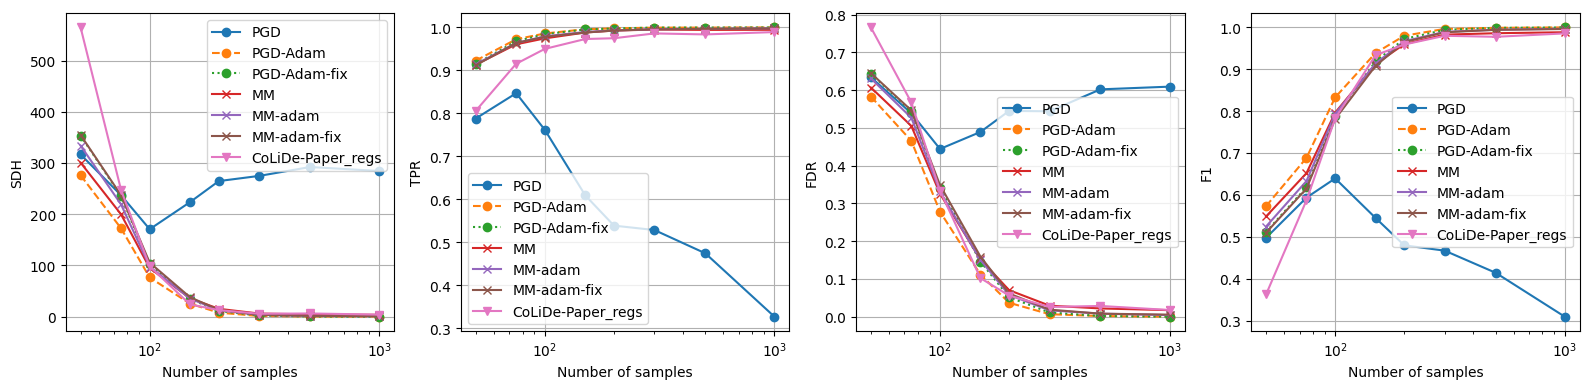

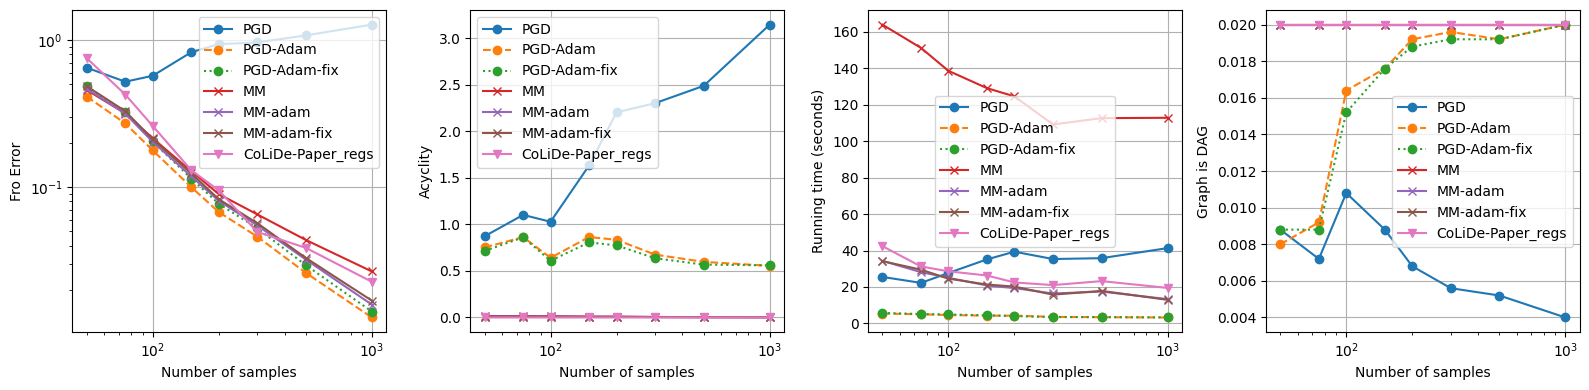

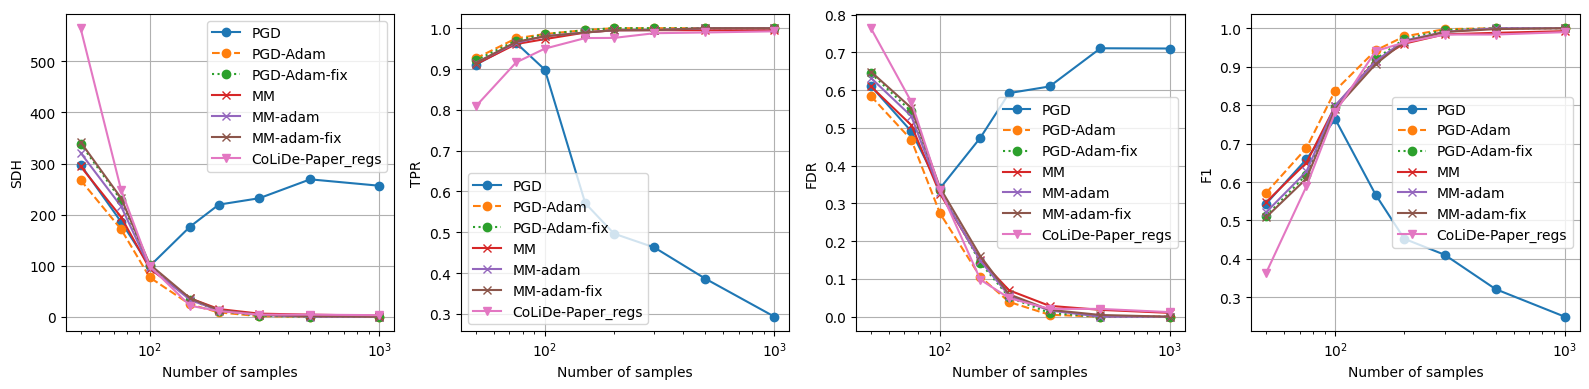

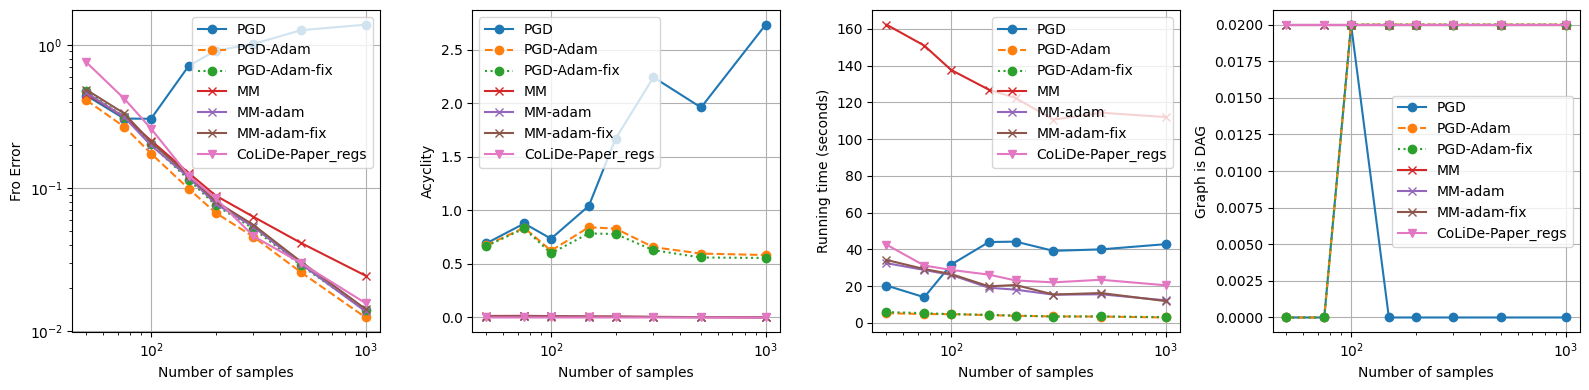

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


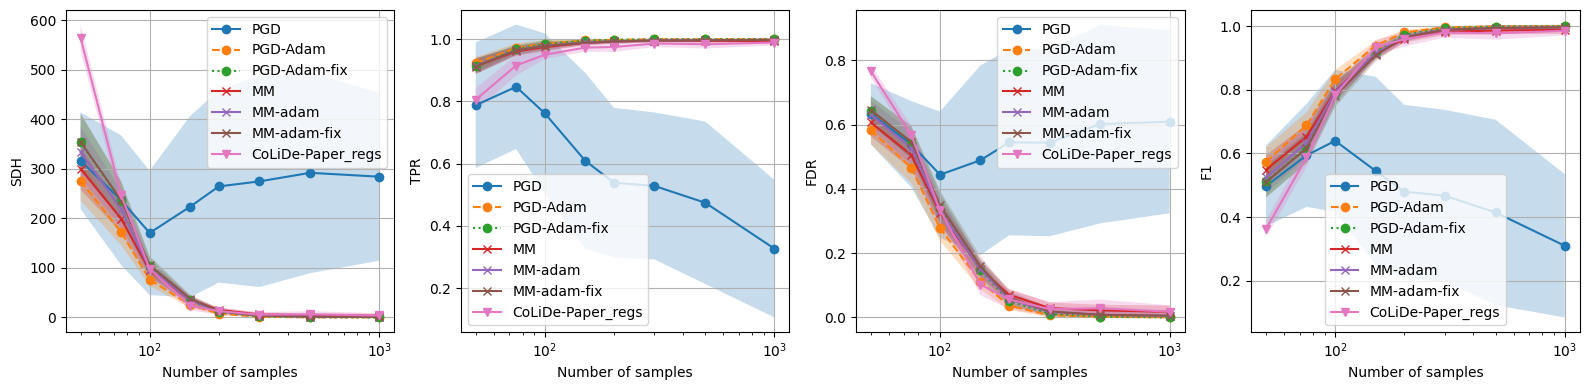

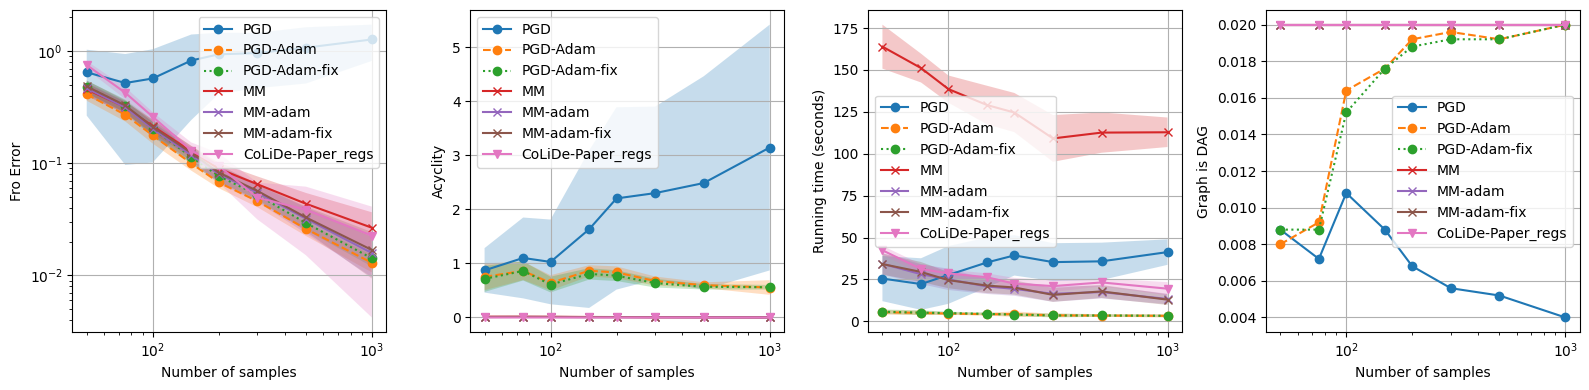

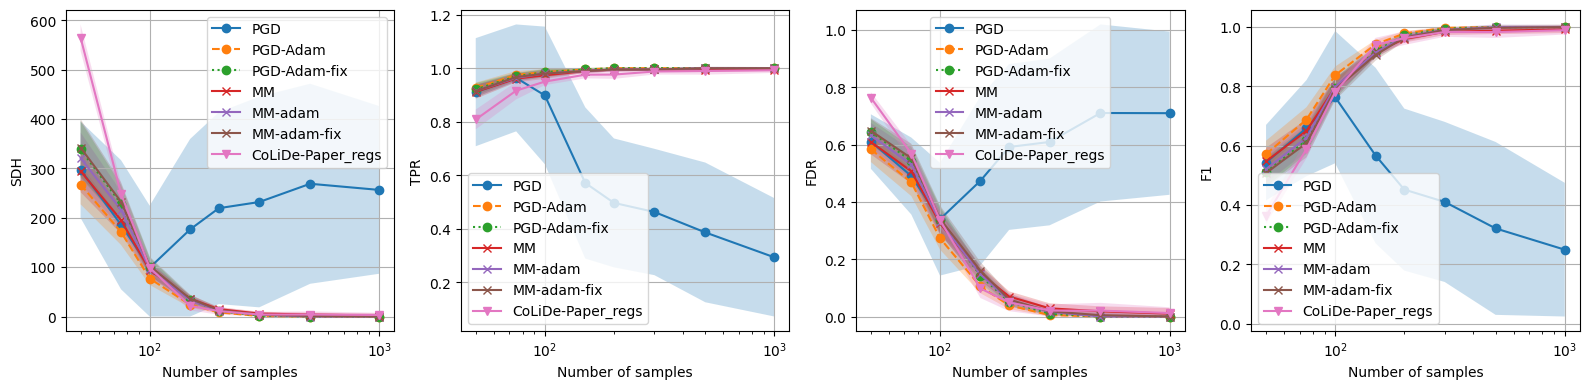

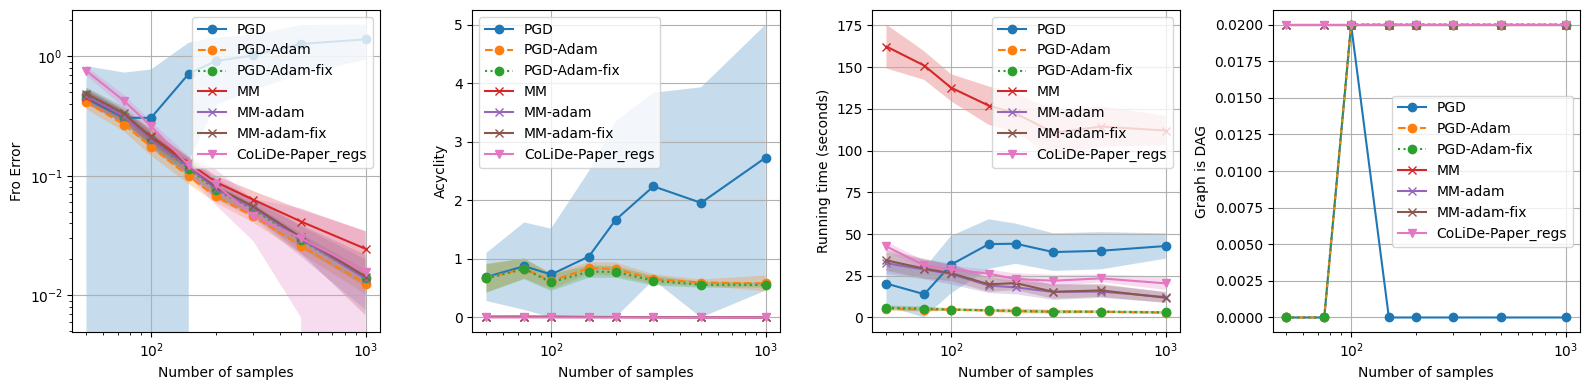

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean', dev=True)

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median', dev=True)


## 4N Edges - Standarized data

In [ ]:
n_dags = 50
N_samples = [ 50, 75, 100, 200, 500, 1000, 2000]

# DEFINE EXPERIMENTS
Exps = [
  # Proj Grad Desc  
  {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': 1e-1, 'max_iters': 20000,
   'opt_type': 'adam', 'tol': 1e-5}, 'adapt_lamb': True, 'standarize': True, 'fmt': 'x-', 'leg': 'PGD-Adam'},

  # Method of multipliers
  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 40000, 'iters_out': 10, 'beta': 2}, 'adapt_lamb': True, 'standarize': True,
   'fmt': 'o:', 'leg': 'MM'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'adapt_lamb': True, 'standarize': True,
   'fmt': 'o-', 'leg': 'MM-adam'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'adapt_lamb': False, 'standarize': True,
   'fmt': 'o--', 'leg': 'MM-adam-fix'},

  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': True, 'fmt': 'v-', 'leg': 'CoLiDe'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': True, 'fmt': '^-', 'leg': 'DAGMA'},

  {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1}, 'standarize': False, 'leg': 'NoTears'},

]

In [ ]:
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)

CPUs employed: 64


Graph: 4, samples: 50
Graph: 2, samples: 50
Graph: 15, samples: 50
Graph: 12, samples: 50
Graph: 16, samples: 50
Graph: 1, samples: 50
Graph: 5, samples: 50
Graph: 21, samples: 50
Graph: 17, samples: 50
Graph: 18, samples: 50
Graph: 10, samples: 50
Graph: 20, samples: 50
Graph: 3, samples: 50
Graph: 24, samples: 50
Graph: 14, samples: 50
Graph: 11, samples: 50
Graph: 13, samples: 50
Graph: 7, samples: 50
Graph: 8, samples: 50
Graph: 19, samples: 50
Graph: 26, samples: 50
Graph: 23, samples: 50
Graph: 27, samples: 50
Graph: 28, samples: 50
Graph: 32, samples: 50
Graph: 38, samples: 50
Graph: 42, samples: 50
Graph: 35, samples: 50
Graph: 36, samples: 50
Graph: 31, samples: 50
Graph: 34, samples: 50
Graph: 37, samples: 50
Graph: 33, samples: 50
Graph: 22, samples: 50
Graph: 29, samples: 50
Graph: 43, samples: 50
Graph: 25, samples: 50
Graph: 30, samples: 50
Graph: 44, samples: 50
Graph: 9, samples: 50
Graph: 41, samples: 50
Graph: 39, samples: 50
Graph: 40, samples: 50
Graph: 6, samples: 

/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 392.0  -  err: nan  -  time: 44.202
		-PGD: shd 309.0  -  err: 0.305  -  time: 44.450
		-PGD: shd 437.0  -  err: 1.023  -  time: 44.531
		-PGD: shd 431.0  -  err: 1.948  -  time: 44.610
		-PGD: shd 390.0  -  err: 0.932  -  time: 44.578
		-PGD: shd 234.0  -  err: 0.456  -  time: 44.923
		-PGD: shd 224.0  -  err: 0.450  -  time: 45.217
		-PGD: shd 416.0  -  err: 0.999  -  time: 45.021
		-PGD: shd 279.0  -  err: 0.627  -  time: 45.393
		-PGD: shd 239.0  -  err: 0.474  -  time: 45.569
		-PGD: shd 345.0  -  err: 0.632  -  time: 45.611
		-PGD: shd 268.0  -  err: 0.366  -  time: 45.644
		-PGD: shd 263.0  -  err: 0.350  -  time: 45.560
		-PGD: shd 265.0  -  err: 0.607  -  time: 45.981
		-PGD: shd 381.0  -  err: 0.854  -  time: 45.797
		-PGD: shd 416.0  -  err: nan  -  time: 45.929


/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 390.0  -  err: 0.802  -  time: 46.169


/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 389.0  -  err: nan  -  time: 46.430
		-PGD: shd 351.0  -  err: 0.876  -  time: 46.369
		-PGD: shd 293.0  -  err: 0.384  -  time: 46.412
		-PGD: shd 403.0  -  err: 1.007  -  time: 46.415
		-PGD: shd 359.0  -  err: 0.317  -  time: 46.633
		-PGD: shd 205.0  -  err: 0.415  -  time: 46.596
		-PGD: shd 356.0  -  err: 0.818  -  time: 46.822
		-PGD: shd 439.0  -  err: 0.984  -  time: 46.830
		-PGD: shd 411.0  -  err: 0.909  -  time: 46.893
		-PGD: shd 435.0  -  err: 1.067  -  time: 46.870
		-PGD: shd 352.0  -  err: 0.841  -  time: 47.074
		-PGD: shd 251.0  -  err: 0.609  -  time: 47.069
		-PGD: shd 264.0  -  err: 0.330  -  time: 47.232
		-PGD: shd 387.0  -  err: 0.883  -  time: 47.218
		-PGD: shd 270.0  -  err: 0.363  -  time: 47.409
		-PGD: shd 365.0  -  err: 0.778  -  time: 47.644
		-PGD: shd 232.0  -  err: 0.452  -  time: 47.679
		-PGD-Adam: shd 354.0  -  err: 0.361  -  time: 9.822
		-PGD-Adam: shd 380.0  -  err: 0.322  -  time: 11.045
		-PGD-Adam: shd 367.0  -  err: 0.352  -  t

  0%|          | 351/130000.0 [00:00<01:51, 1159.46it/s]

		-MM-adam: shd 410.0  -  err: 0.398  -  time: 50.094


  1%|          | 1287/130000.0 [00:01<01:50, 1160.19it/s]

		-MM: shd 349.0  -  err: 0.310  -  time: 231.139


  1%|▏         | 1753/130000.0 [00:01<01:50, 1156.59it/s]

		-MM-adam: shd 454.0  -  err: 0.445  -  time: 36.226


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1161.58it/s]

		-MM-adam-fix: shd 580.0  -  err: 0.734  -  time: 29.718


  4%|▍         | 5136/130000.0 [00:04<01:47, 1158.32it/s]

		-MM-adam-fix: shd 586.0  -  err: 0.788  -  time: 36.745


  2%|▏         | 2556/130000.0 [00:01<01:35, 1338.07it/s]

		-MM: shd 345.0  -  err: 0.333  -  time: 234.744


  7%|▋         | 8518/130000.0 [00:07<01:44, 1158.48it/s]

		-MM-adam-fix: shd 510.0  -  err: 0.546  -  time: 29.491


  7%|▋         | 9211/130000.0 [00:07<01:46, 1138.75it/s]

		-MM-adam-fix: shd 492.0  -  err: 0.530  -  time: 38.784
		-MM: shd 331.0  -  err: 0.317  -  time: 228.052


  8%|▊         | 10355/130000.0 [00:08<01:45, 1135.81it/s]

		-MM: shd 315.0  -  err: 0.329  -  time: 230.590


 10%|▉         | 12645/130000.0 [00:10<01:43, 1138.20it/s]

		-MM: shd 316.0  -  err: 0.301  -  time: 235.447


  4%|▎         | 4784/130000.0 [00:04<01:48, 1157.66it/s]]

		-MM-adam: shd 690.0  -  err: 0.680  -  time: 37.884


  9%|▉         | 11921/130000.0 [00:09<01:31, 1294.86it/s]

		-MM-adam-fix: shd 633.0  -  err: 0.613  -  time: 37.417


  9%|▊         | 11065/130000.0 [00:08<01:29, 1330.60it/s]

		-MM-adam-fix: shd 530.0  -  err: 0.590  -  time: 38.875
		-MM-adam-fix: shd 563.0  -  err: 0.559  -  time: 36.196


  1%|          | 1353/130000.0 [00:01<01:54, 1123.51it/s]]

		-MM-adam-fix: shd 625.0  -  err: 0.683  -  time: 55.835


  5%|▌         | 7111/130000.0 [00:06<01:46, 1155.76it/s]]

		-MM-adam: shd 404.0  -  err: 0.404  -  time: 34.944


 17%|█▋        | 21951/130000.0 [00:19<01:36, 1122.51it/s]

		-MM: shd 354.0  -  err: 0.339  -  time: 241.314


 18%|█▊        | 22867/130000.0 [00:19<01:34, 1134.69it/s]

		-MM: shd 326.0  -  err: 0.337  -  time: 241.442


  8%|▊         | 9973/130000.0 [00:08<01:44, 1150.49it/s]]

		-MM-adam: shd 506.0  -  err: 0.524  -  time: 30.415


 19%|█▊        | 24291/130000.0 [00:18<01:32, 1144.37it/s]

		-MM-adam-fix: shd 552.0  -  err: 0.683  -  time: 38.555


 20%|██        | 26135/130000.0 [00:20<01:31, 1139.53it/s]

		-MM: shd 354.0  -  err: 0.538  -  time: 249.768


 14%|█▍        | 18159/130000.0 [00:16<01:29, 1246.92it/s]]

		-MM-adam-fix: shd 650.0  -  err: 0.715  -  time: 31.434


  5%|▍         | 6440/130000.0 [00:05<01:48, 1143.13it/s]]

		-MM: shd 421.0  -  err: 0.457  -  time: 249.058


  5%|▌         | 6900/130000.0 [00:06<01:47, 1141.21it/s]]]

		-MM-adam: shd 417.0  -  err: 0.451  -  time: 41.740


 20%|█▉        | 25941/130000.0 [00:22<01:29, 1157.48it/s] 

		-MM: shd 347.0  -  err: 0.413  -  time: 251.239


 22%|██▏       | 29191/130000.0 [00:25<01:27, 1154.49it/s]

		-MM: shd 371.0  -  err: 0.383  -  time: 256.008


 29%|██▊       | 37075/130000.0 [00:29<01:21, 1139.84it/s]

		-MM: shd 308.0  -  err: 0.498  -  time: 256.477


 29%|██▉       | 37531/130000.0 [00:30<01:21, 1139.03it/s]

		-MM: shd 359.0  -  err: 0.417  -  time: 262.093
		-MM-adam: shd 624.0  -  err: 0.586  -  time: 39.896


 38%|███▊      | 49972/130000.0 [00:35<01:00, 1316.38it/s]

		-MM: shd 295.0  -  err: 0.400  -  time: 260.066
		-MM-adam: shd 565.0  -  err: 0.492  -  time: 34.251


 22%|██▏       | 27990/130000.0 [00:23<01:29, 1141.58it/s]]

		-MM-adam: shd 555.0  -  err: 0.578  -  time: 37.642


 23%|██▎       | 29907/130000.0 [00:23<01:26, 1153.40it/s]]

		-MM-adam-fix: shd 606.0  -  err: 0.532  -  time: 38.159


 13%|█▎        | 16629/130000.0 [00:14<01:39, 1139.98it/s]

		-MM: shd 292.0  -  err: 0.361  -  time: 256.996


 13%|█▎        | 17089/130000.0 [00:14<01:39, 1138.67it/s]

		-MM-adam-fix: shd 602.0  -  err: 0.795  -  time: 39.744


  9%|▉         | 11848/130000.0 [00:10<01:42, 1156.48it/s] 

		-MM-adam-fix: shd 729.0  -  err: 0.856  -  time: 55.778


 23%|██▎       | 30290/130000.0 [00:26<01:26, 1150.60it/s] 

		-MM-adam-fix: shd 606.0  -  err: 0.582  -  time: 46.913


 25%|██▌       | 32605/130000.0 [00:28<01:24, 1146.68it/s] 

		-MM: shd 413.0  -  err: 0.843  -  time: 263.854


 13%|█▎        | 16963/130000.0 [00:14<01:37, 1158.13it/s]]

		-MM-adam: shd 458.0  -  err: 0.426  -  time: 33.573
		-MM: shd 304.0  -  err: 0.534  -  time: 261.330
		-MM-adam-fix: shd 471.0  -  err: 0.450  -  time: 46.204


100%|██████████| 130000/130000.0 [00:40<00:00, 3242.35it/s] 
  4%|▎         | 4755/130000.0 [00:04<01:48, 1154.45it/s]]

		-CoLiDe-Paper_regs: shd 564.0  -  err: 0.634  -  time: 40.096
Graph: 10, samples: 100
		-CoLiDe-Paper_regs: shd 575.0  -  err: 0.689  -  time: 43.060
Graph: 12, samples: 100


100%|██████████| 130000/130000.0 [00:43<00:00, 3019.12it/s] 
  4%|▍         | 5686/130000.0 [00:04<01:47, 1158.95it/s]]]

		-MM-adam: shd 492.0  -  err: 0.474  -  time: 43.999
		-MM-adam-fix: shd 549.0  -  err: 0.580  -  time: 42.433


  7%|▋         | 9300/130000.0 [00:08<01:45, 1144.84it/s]] 

		-MM: shd 363.0  -  err: 0.465  -  time: 267.655


 20%|██        | 26576/130000.0 [00:23<01:31, 1134.64it/s] 

		-MM-adam-fix: shd 470.0  -  err: 0.513  -  time: 45.518


  4%|▎         | 4821/130000.0 [00:04<01:48, 1157.76it/s]]]

		-MM: shd 323.0  -  err: 0.412  -  time: 273.426


  4%|▍         | 5055/130000.0 [00:04<01:48, 1154.73it/s]]

		-MM-adam: shd 452.0  -  err: 0.464  -  time: 38.979


  8%|▊         | 10443/130000.0 [00:09<01:44, 1145.73it/s]

		-MM-adam-fix: shd 446.0  -  err: 0.464  -  time: 33.895
		-MM: shd 354.0  -  err: 0.648  -  time: 266.732


  9%|▉         | 11604/130000.0 [00:10<01:42, 1151.86it/s] 

		-MM: shd 296.0  -  err: 0.583  -  time: 268.808


 38%|███▊      | 49400/130000.0 [00:43<01:11, 1126.29it/s]

		-MM-adam: shd 605.0  -  err: 0.566  -  time: 39.246


 13%|█▎        | 17208/130000.0 [00:15<01:39, 1134.24it/s]]

		-MM-adam: shd 746.0  -  err: 0.727  -  time: 45.130


100%|██████████| 130000/130000.0 [00:45<00:00, 2885.06it/s]
 40%|████      | 52611/130000.0 [00:45<01:06, 1162.03it/s]

		-CoLiDe-Paper_regs: shd 580.0  -  err: 0.637  -  time: 45.063
Graph: 32, samples: 100


 53%|█████▎    | 69332/130000.0 [00:50<00:52, 1150.22it/s] 

		-MM: shd 346.0  -  err: 0.415  -  time: 273.231


 17%|█▋        | 21995/130000.0 [00:19<01:34, 1137.08it/s] 

		-MM: shd 328.0  -  err: 0.389  -  time: 275.363


100%|██████████| 130000/130000.0 [00:43<00:00, 3006.30it/s] 
 17%|█▋        | 22223/130000.0 [00:19<01:35, 1133.70it/s]

		-CoLiDe-Paper_regs: shd 508.0  -  err: 0.578  -  time: 43.244
Graph: 17, samples: 100
		-CoLiDe-Paper_regs: shd 542.0  -  err: 0.593  -  time: 51.693
Graph: 6, samples: 100


100%|██████████| 130000/130000.0 [00:51<00:00, 2514.95it/s]
 12%|█▏        | 15530/130000.0 [00:13<01:40, 1137.85it/s] 

		-MM-adam-fix: shd 850.0  -  err: 0.954  -  time: 46.180


 46%|████▌     | 60065/130000.0 [00:36<00:04, 15285.41it/s]

		-MM-adam: shd 609.0  -  err: 0.534  -  time: 34.266


100%|██████████| 130000/130000.0 [00:46<00:00, 2803.45it/s]
 28%|██▊       | 35911/130000.0 [00:31<01:21, 1157.82it/s]

		-CoLiDe-Paper_regs: shd 546.0  -  err: 0.632  -  time: 46.375
Graph: 28, samples: 100
		-MM-adam-fix: shd 585.0  -  err: 0.753  -  time: 37.892


  2%|▏         | 2411/130000.0 [00:02<01:52, 1138.69it/s]]

		-MM: shd 341.0  -  err: 0.456  -  time: 277.613


100%|██████████| 130000/130000.0 [00:48<00:00, 2688.46it/s] 
 16%|█▌        | 20322/130000.0 [00:17<01:34, 1159.93it/s]

		-MM-adam: shd 560.0  -  err: 0.504  -  time: 40.262
		-CoLiDe-Paper_regs: shd 546.0  -  err: 0.628  -  time: 48.360
Graph: 9, samples: 100


 17%|█▋        | 21716/130000.0 [00:18<01:33, 1156.21it/s] 

		-MM: shd 347.0  -  err: 0.428  -  time: 281.319


 21%|██        | 26824/130000.0 [00:23<01:29, 1152.94it/s]

		-MM-adam: shd 597.0  -  err: 0.617  -  time: 43.008


 23%|██▎       | 29354/130000.0 [00:25<01:28, 1134.37it/s] 

		-MM-adam-fix: shd 473.0  -  err: 0.531  -  time: 34.950


  7%|▋         | 8929/130000.0 [00:07<01:39, 1221.06it/s]]

		-MM-adam: shd 618.0  -  err: 0.536  -  time: 36.980


100%|██████████| 130000/130000.0 [00:52<00:00, 2469.85it/s]
 24%|██▍       | 31628/130000.0 [00:27<01:27, 1129.23it/s]

		-CoLiDe-Paper_regs: shd 543.0  -  err: 0.596  -  time: 52.636
Graph: 23, samples: 100
		-MM-adam: shd 614.0  -  err: 0.528  -  time: 31.310


  9%|▉         | 11886/130000.0 [00:10<01:31, 1297.28it/s]] 
  9%|▉         | 12019/130000.0 [00:10<01:30, 1306.81it/s]

		-CoLiDe-Paper_regs: shd 552.0  -  err: 0.635  -  time: 44.952
Graph: 25, samples: 100
		-CoLiDe-Paper_regs: shd 549.0  -  err: 0.562  -  time: 60.531
Graph: 11, samples: 100


100%|██████████| 130000/130000.0 [01:00<00:00, 2147.74it/s]
 11%|█         | 13840/130000.0 [00:11<01:31, 1265.84it/s] 

		-MM-adam: shd 508.0  -  err: 0.505  -  time: 38.669


 11%|█         | 14594/130000.0 [00:12<01:34, 1226.91it/s]

		-MM-adam: shd 639.0  -  err: 0.581  -  time: 36.447


 23%|██▎       | 29861/130000.0 [00:22<01:17, 1300.31it/s]

		-MM-adam: shd 553.0  -  err: 0.549  -  time: 36.489


 34%|███▎      | 43578/130000.0 [00:35<01:05, 1320.82it/s] 

		-MM-adam: shd 555.0  -  err: 0.514  -  time: 39.302
		-MM-adam-fix: shd 688.0  -  err: 0.946  -  time: 38.604
		-MM-adam-fix: shd 724.0  -  err: 0.774  -  time: 39.934


  1%|          | 1404/130000.0 [00:01<01:50, 1164.14it/s]]]

		-MM-adam: shd 377.0  -  err: 0.420  -  time: 38.375


100%|██████████| 130000/130000.0 [00:51<00:00, 2515.69it/s]
 38%|███▊      | 50018/130000.0 [00:43<01:11, 1126.26it/s]]

		-CoLiDe-Paper_regs: shd 567.0  -  err: 0.659  -  time: 51.677
Graph: 14, samples: 100


 39%|███▉      | 50471/130000.0 [00:43<01:10, 1126.75it/s] 

		-MM-adam: shd 449.0  -  err: 0.457  -  time: 39.202


 17%|█▋        | 21592/130000.0 [00:19<01:36, 1124.52it/s] 

		-PGD: shd 165.0  -  err: 0.337  -  time: 39.662
		-MM-adam-fix: shd 710.0  -  err: 0.744  -  time: 47.645


 17%|█▋        | 22046/130000.0 [00:19<01:36, 1118.94it/s] 

		-PGD: shd 104.0  -  err: 0.193  -  time: 40.233
		-MM-adam: shd 658.0  -  err: 0.642  -  time: 38.759


 19%|█▉        | 24539/130000.0 [00:21<01:33, 1128.77it/s]]

		-MM-adam: shd 606.0  -  err: 0.549  -  time: 38.701


 26%|██▋       | 34305/130000.0 [00:28<01:19, 1200.89it/s]

		-MM-adam-fix: shd 549.0  -  err: 0.600  -  time: 42.227


100%|██████████| 130000/130000.0 [00:49<00:00, 2635.19it/s]
 12%|█▏        | 15082/130000.0 [00:12<01:39, 1154.56it/s]

		-CoLiDe-Paper_regs: shd 589.0  -  err: 0.715  -  time: 49.337
Graph: 44, samples: 100


 40%|████      | 52068/130000.0 [00:45<01:07, 1146.47it/s]]

		-MM-adam: shd 496.0  -  err: 0.421  -  time: 38.831


 39%|███▉      | 50759/130000.0 [00:42<01:11, 1106.90it/s]

		-MM-adam-fix: shd 691.0  -  err: 0.710  -  time: 38.188


100%|██████████| 130000/130000.0 [00:53<00:00, 2427.14it/s]
  3%|▎         | 3835/130000.0 [00:02<01:36, 1308.34it/s]] 

		-CoLiDe-Paper_regs: shd 560.0  -  err: 0.664  -  time: 53.563
Graph: 15, samples: 100


100%|██████████| 130000/130000.0 [00:49<00:00, 2608.83it/s]
100%|██████████| 130000/130000.0 [00:57<00:00, 2265.11it/s]
 26%|██▌       | 34084/130000.0 [00:30<01:25, 1124.83it/s]

		-CoLiDe-Paper_regs: shd 579.0  -  err: 0.633  -  time: 49.836
Graph: 45, samples: 100
		-CoLiDe-Paper_regs: shd 626.0  -  err: 0.677  -  time: 57.394
Graph: 38, samples: 100


100%|██████████| 130000/130000.0 [00:46<00:00, 2797.23it/s]
 35%|███▍      | 44887/130000.0 [00:36<01:05, 1301.49it/s]

		-CoLiDe-Paper_regs: shd 518.0  -  err: 0.591  -  time: 46.476
Graph: 8, samples: 100
		-PGD-Adam: shd 120.0  -  err: 0.116  -  time: 11.166


 27%|██▋       | 35210/130000.0 [00:31<01:24, 1117.51it/s]

		-MM-adam: shd 657.0  -  err: 0.587  -  time: 40.386


 32%|███▏      | 41383/130000.0 [00:36<01:17, 1139.03it/s]

		-PGD-Adam: shd 147.0  -  err: 0.122  -  time: 12.421


100%|██████████| 130000/130000.0 [00:56<00:00, 2294.28it/s]
 32%|███▏      | 41611/130000.0 [00:36<01:17, 1137.28it/s]

		-CoLiDe-Paper_regs: shd 580.0  -  err: 0.633  -  time: 56.665
Graph: 19, samples: 100


 12%|█▏        | 15052/130000.0 [00:13<01:41, 1133.92it/s]

		-MM-adam-fix: shd 501.0  -  err: 0.624  -  time: 48.993


 12%|█▏        | 15508/130000.0 [00:13<01:40, 1134.44it/s]

		-PGD: shd 244.0  -  err: 0.497  -  time: 43.501


 29%|██▉       | 37644/130000.0 [00:33<01:24, 1095.28it/s]

		-MM-adam: shd 475.0  -  err: 0.395  -  time: 41.299
		-MM-adam: shd 502.0  -  err: 0.501  -  time: 54.551


100%|██████████| 130000/130000.0 [00:51<00:00, 2511.15it/s]
 29%|██▉       | 38330/130000.0 [00:34<01:20, 1134.59it/s]

		-CoLiDe-Paper_regs: shd 575.0  -  err: 0.643  -  time: 51.772
Graph: 30, samples: 100


 31%|███       | 40409/130000.0 [00:35<01:18, 1147.48it/s]

		-PGD: shd 354.0  -  err: 0.757  -  time: 43.588


 37%|███▋      | 47543/130000.0 [00:41<01:12, 1133.10it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  4%|▍         | 5301/130000.0 [00:04<01:51, 1122.94it/s]]

		-MM-adam: shd 607.0  -  err: 0.623  -  time: 41.049
		-PGD: shd 410.0  -  err: nan  -  time: 44.662
		-PGD: shd 122.0  -  err: 0.323  -  time: 41.958


100%|██████████| 130000/130000.0 [00:58<00:00, 2229.62it/s]
 40%|████      | 52371/130000.0 [00:43<01:08, 1135.91it/s]

		-CoLiDe-Paper_regs: shd 604.0  -  err: 0.599  -  time: 58.308
Graph: 48, samples: 100


 41%|████      | 53060/130000.0 [00:44<01:07, 1137.05it/s]

		-MM-adam-fix: shd 533.0  -  err: 0.557  -  time: 58.924


 41%|████      | 53288/130000.0 [00:44<01:07, 1137.79it/s]

		-MM-adam-fix: shd 711.0  -  err: 0.639  -  time: 36.489


 41%|████▏     | 53746/130000.0 [00:44<01:06, 1140.22it/s]

		-MM-adam: shd 659.0  -  err: 0.617  -  time: 53.960


 15%|█▍        | 19435/130000.0 [00:15<01:35, 1152.16it/s]]

		-PGD: shd 100.0  -  err: 0.187  -  time: 43.882


 16%|█▌        | 20595/130000.0 [00:16<01:34, 1155.74it/s]

		-MM-adam-fix: shd 699.0  -  err: 0.809  -  time: 43.032


 28%|██▊       | 35841/130000.0 [00:31<01:23, 1131.52it/s] 

		-PGD-Adam-fix: shd 186.0  -  err: 0.156  -  time: 11.844


 19%|█▊        | 24083/130000.0 [00:19<01:31, 1153.50it/s] 

		-MM-adam-fix: shd 686.0  -  err: 0.641  -  time: 49.505


 30%|███       | 39572/130000.0 [00:34<01:18, 1146.65it/s]

		-PGD: shd 138.0  -  err: 0.322  -  time: 42.952
		-MM-adam-fix: shd 782.0  -  err: 0.809  -  time: 38.969


 31%|███       | 40033/130000.0 [00:34<01:18, 1141.97it/s] 

		-PGD-Adam-fix: shd 213.0  -  err: 0.168  -  time: 13.711
		-PGD: shd 237.0  -  err: 0.602  -  time: 41.073


  2%|▏         | 2642/130000.0 [00:02<01:51, 1143.28it/s]]

		-MM-adam-fix: shd 646.0  -  err: 0.593  -  time: 50.290


 52%|█████▏    | 67909/130000.0 [00:53<00:54, 1145.44it/s]]

		-PGD-Adam: shd 161.0  -  err: 0.132  -  time: 14.536


 53%|█████▎    | 69059/130000.0 [00:54<00:53, 1138.72it/s]

		-MM-adam-fix: shd 944.0  -  err: 1.094  -  time: 60.699
		-PGD: shd 147.0  -  err: 0.326  -  time: 44.486
		-MM-adam: shd 684.0  -  err: 0.667  -  time: 50.856


  2%|▏         | 2575/130000.0 [00:02<01:48, 1179.79it/s]]

		-PGD-Adam: shd 115.0  -  err: 0.123  -  time: 11.442


 11%|█         | 14510/130000.0 [00:12<01:39, 1165.62it/s] 

		-PGD-Adam: shd 234.0  -  err: 0.165  -  time: 14.571
		-MM-adam-fix: shd 412.0  -  err: 0.472  -  time: 38.702


 50%|█████     | 65046/130000.0 [00:51<00:33, 1934.35it/s]]

		-PGD-Adam: shd 143.0  -  err: 0.127  -  time: 14.084


 12%|█▏        | 15915/130000.0 [00:13<01:37, 1165.59it/s]

		-PGD-Adam: shd 106.0  -  err: 0.107  -  time: 11.112


100%|██████████| 130000/130000.0 [00:58<00:00, 2239.53it/s]
 13%|█▎        | 16383/130000.0 [00:14<01:37, 1162.63it/s]

		-CoLiDe-Paper_regs: shd 612.0  -  err: 0.634  -  time: 58.052
Graph: 4, samples: 100


 14%|█▍        | 18021/130000.0 [00:15<01:36, 1159.21it/s]]

		-MM-adam-fix: shd 729.0  -  err: 0.772  -  time: 51.254


100%|██████████| 130000/130000.0 [00:59<00:00, 2173.62it/s]
 15%|█▌        | 20120/130000.0 [00:17<01:34, 1161.98it/s]

		-CoLiDe-Paper_regs: shd 542.0  -  err: 0.528  -  time: 59.811
Graph: 34, samples: 100
		-MM-adam-fix: shd 669.0  -  err: 0.811  -  time: 48.440
		-MM-adam-fix: shd 813.0  -  err: 0.922  -  time: 35.694


  6%|▌         | 7819/130000.0 [00:05<01:45, 1153.12it/s]] 

		-MM-adam-fix: shd 498.0  -  err: 0.577  -  time: 40.017


 22%|██▏       | 28727/130000.0 [00:25<01:29, 1128.73it/s]

		-PGD-Adam: shd 255.0  -  err: 0.227  -  time: 12.935


  5%|▌         | 6749/130000.0 [00:04<01:49, 1124.97it/s]]

		-MM-adam-fix: shd 659.0  -  err: 0.775  -  time: 47.347


100%|██████████| 130000/130000.0 [00:59<00:00, 2174.05it/s]
 24%|██▎       | 30772/130000.0 [00:27<01:27, 1127.96it/s]

		-CoLiDe-Paper_regs: shd 613.0  -  err: 0.713  -  time: 59.799
Graph: 35, samples: 100
		-PGD-Adam: shd 188.0  -  err: 0.158  -  time: 14.543


 24%|██▍       | 31226/130000.0 [00:27<01:27, 1128.35it/s]

		-PGD-Adam-fix: shd 190.0  -  err: 0.167  -  time: 11.286
		-PGD: shd 420.0  -  err: 1.167  -  time: 44.092


 24%|██▍       | 31454/130000.0 [00:27<01:27, 1129.74it/s]

		-PGD-Adam-fix: shd 250.0  -  err: 0.181  -  time: 12.790


 14%|█▍        | 17920/130000.0 [00:15<01:37, 1149.24it/s]

		-MM-adam-fix: shd 570.0  -  err: 0.515  -  time: 36.355


100%|██████████| 130000/130000.0 [00:50<00:00, 2571.32it/s]
 10%|█         | 13633/130000.0 [00:10<01:49, 1067.39it/s]

		-CoLiDe-Paper_regs: shd 558.0  -  err: 0.597  -  time: 50.559
Graph: 31, samples: 100


 11%|█         | 14059/130000.0 [00:11<01:49, 1055.25it/s]]

		-PGD-Adam-fix: shd 149.0  -  err: 0.141  -  time: 10.246


  5%|▌         | 6720/130000.0 [00:05<01:46, 1153.76it/s]]

		-PGD-Adam: shd 162.0  -  err: 0.141  -  time: 13.563


 40%|███▉      | 51832/130000.0 [00:45<01:08, 1148.19it/s] 

		-PGD-Adam-fix: shd 222.0  -  err: 0.171  -  time: 13.530


 40%|████      | 52062/130000.0 [00:45<01:08, 1144.03it/s]

		-PGD-Adam-fix: shd 378.0  -  err: 0.246  -  time: 14.595


 16%|█▌        | 20506/130000.0 [00:17<01:35, 1150.98it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 19%|█▊        | 24101/130000.0 [00:21<01:33, 1128.07it/s]

		-PGD: shd 422.0  -  err: nan  -  time: 44.147


 12%|█▏        | 16130/130000.0 [00:13<01:38, 1156.80it/s] 

		-PGD-Adam-fix: shd 318.0  -  err: 0.305  -  time: 12.359


 12%|█▏        | 14956/130000.0 [00:13<01:40, 1147.42it/s]

		-MM-adam-fix: shd 619.0  -  err: 0.640  -  time: 65.788


 22%|██▏       | 28085/130000.0 [00:24<01:32, 1100.04it/s]]

		-PGD: shd 108.0  -  err: 0.222  -  time: 40.843


 17%|█▋        | 22095/130000.0 [00:18<01:35, 1131.79it/s]

		-PGD: shd 138.0  -  err: 0.353  -  time: 44.378


 23%|██▎       | 29679/130000.0 [00:26<01:32, 1079.41it/s] 

		-MM-adam-fix: shd 576.0  -  err: 0.621  -  time: 39.487
		-CoLiDe-Paper_regs: shd 596.0  -  err: 0.630  -  time: 50.915
Graph: 40, samples: 100


100%|██████████| 130000/130000.0 [00:50<00:00, 2553.36it/s]
 24%|██▎       | 30758/130000.0 [00:27<01:33, 1062.72it/s]

		-PGD: shd 291.0  -  err: 0.614  -  time: 43.775
		-PGD: shd 357.0  -  err: 0.721  -  time: 44.018


 32%|███▏      | 42053/130000.0 [00:36<01:16, 1142.52it/s]

		-PGD-Adam-fix: shd 278.0  -  err: 0.214  -  time: 14.548


 22%|██▏       | 28030/130000.0 [00:24<01:31, 1115.30it/s]

		-PGD-Adam: shd 178.0  -  err: 0.143  -  time: 14.621


 58%|█████▊    | 75553/130000.0 [01:04<00:47, 1154.59it/s]]

		-PGD-Adam-fix: shd 264.0  -  err: 0.204  -  time: 13.327


100%|██████████| 130000/130000.0 [01:05<00:00, 1998.08it/s]
 20%|██        | 26422/130000.0 [00:22<01:33, 1102.97it/s]

		-CoLiDe-Paper_regs: shd 635.0  -  err: 0.720  -  time: 65.064
Graph: 3, samples: 100


  5%|▍         | 5863/130000.0 [00:05<01:48, 1145.93it/s]]

		-PGD: shd 292.0  -  err: 0.866  -  time: 44.328


100%|██████████| 130000/130000.0 [00:57<00:00, 2273.48it/s]
  5%|▍         | 6093/130000.0 [00:05<01:48, 1142.56it/s]]

		-CoLiDe-Paper_regs: shd 578.0  -  err: 0.593  -  time: 57.183
Graph: 26, samples: 100


  6%|▌         | 7937/130000.0 [00:06<01:46, 1149.35it/s]] 

		-PGD: shd 373.0  -  err: 1.035  -  time: 43.877


 28%|██▊       | 36811/130000.0 [00:32<01:24, 1106.61it/s]

		-PGD: shd 216.0  -  err: 0.509  -  time: 42.024


100%|██████████| 130000/130000.0 [00:57<00:00, 2277.97it/s]
 23%|██▎       | 29459/130000.0 [00:25<01:27, 1147.40it/s]

		-CoLiDe-Paper_regs: shd 571.0  -  err: 0.611  -  time: 57.070
Graph: 16, samples: 100


 23%|██▎       | 29922/130000.0 [00:25<01:26, 1150.61it/s]

		-PGD-Adam: shd 154.0  -  err: 0.124  -  time: 14.520
		-MM-adam-fix: shd 778.0  -  err: 0.806  -  time: 43.957


 22%|██▏       | 28761/130000.0 [00:24<01:21, 1243.82it/s]

		-PGD-Adam: shd 124.0  -  err: 0.121  -  time: 11.076


 30%|███       | 39184/130000.0 [00:27<01:09, 1309.75it/s]

		-MM-adam-fix: shd 565.0  -  err: 0.543  -  time: 49.691


 31%|███       | 40243/130000.0 [00:28<01:08, 1303.38it/s] 

		-MM-adam-fix: shd 696.0  -  err: 0.845  -  time: 46.802


100%|██████████| 130000/130000.0 [00:52<00:00, 2490.02it/s]
 32%|███▏      | 41304/130000.0 [00:29<01:07, 1309.97it/s]

		-CoLiDe-Paper_regs: shd 573.0  -  err: 0.642  -  time: 52.210
Graph: 33, samples: 100
		-MM-adam-fix: shd 720.0  -  err: 0.751  -  time: 62.900


 34%|███▍      | 44639/130000.0 [00:39<01:18, 1081.61it/s]

		-PGD-Adam: shd 162.0  -  err: 0.137  -  time: 14.599


 27%|██▋       | 35430/130000.0 [00:30<01:23, 1138.51it/s]]

		-PGD-Adam: shd 120.0  -  err: 0.129  -  time: 14.466
		-PGD-Adam: shd 235.0  -  err: 0.188  -  time: 14.502


 36%|███▌      | 47062/130000.0 [00:42<01:15, 1099.52it/s] 

		-MM-adam-fix: shd 795.0  -  err: 0.871  -  time: 57.467


 37%|███▋      | 47730/130000.0 [00:42<01:15, 1096.39it/s]

		-PGD-Adam-fix: shd 291.0  -  err: 0.215  -  time: 14.633


 47%|████▋     | 60685/130000.0 [00:52<01:00, 1153.45it/s]

		-PGD-Adam: shd 115.0  -  err: 0.118  -  time: 14.576


100%|██████████| 130000/130000.0 [00:50<00:00, 2592.54it/s]
 18%|█▊        | 23576/130000.0 [00:20<01:32, 1145.38it/s]

		-CoLiDe-Paper_regs: shd 590.0  -  err: 0.610  -  time: 50.145
Graph: 36, samples: 100


 27%|██▋       | 35631/130000.0 [00:32<01:24, 1116.44it/s]

		-PGD-Adam: shd 179.0  -  err: 0.155  -  time: 14.760


 10%|▉         | 12863/130000.0 [00:11<01:41, 1150.39it/s]]

		-PGD-Adam-fix: shd 176.0  -  err: 0.156  -  time: 10.832


 10%|█         | 13326/130000.0 [00:11<01:41, 1151.29it/s]

		-PGD: shd 287.0  -  err: 0.588  -  time: 41.866
		-PGD-Adam: shd 132.0  -  err: 0.131  -  time: 14.639


 10%|█         | 13328/130000.0 [00:11<01:42, 1143.75it/s] 

		-MM-adam-fix: shd 863.0  -  err: 0.994  -  time: 47.561


 21%|██        | 27246/130000.0 [00:23<01:30, 1140.27it/s]

		-PGD-Adam-fix: shd 229.0  -  err: 0.184  -  time: 14.292


 38%|███▊      | 48918/130000.0 [00:44<01:09, 1161.02it/s]

		-PGD: shd 119.0  -  err: 0.316  -  time: 44.043


100%|██████████| 130000/130000.0 [01:02<00:00, 2092.63it/s]
 37%|███▋      | 48341/130000.0 [00:41<01:12, 1133.53it/s]

		-CoLiDe-Paper_regs: shd 540.0  -  err: 0.574  -  time: 62.124
Graph: 41, samples: 100


100%|██████████| 130000/130000.0 [00:54<00:00, 2388.00it/s]
 51%|█████     | 65917/130000.0 [00:56<00:56, 1142.65it/s]

		-CoLiDe-Paper_regs: shd 592.0  -  err: 0.621  -  time: 54.441
Graph: 7, samples: 100
		-PGD-Adam-fix: shd 253.0  -  err: 0.193  -  time: 14.673


100%|██████████| 130000/130000.0 [00:53<00:00, 2418.84it/s] 
  5%|▌         | 6870/130000.0 [00:06<01:48, 1139.34it/s]]

		-PGD-Adam-fix: shd 387.0  -  err: 0.277  -  time: 13.527
		-CoLiDe-Paper_regs: shd 631.0  -  err: 0.713  -  time: 53.747
Graph: 5, samples: 100


 36%|███▌      | 46968/130000.0 [00:42<01:12, 1149.17it/s]

		-PGD: shd 142.0  -  err: 0.332  -  time: 43.109
		-PGD-Adam-fix: shd 216.0  -  err: 0.182  -  time: 14.549


 59%|█████▉    | 77348/130000.0 [00:50<00:32, 1642.22it/s] 

		-PGD-Adam-fix: shd 195.0  -  err: 0.168  -  time: 14.536


100%|██████████| 130000/130000.0 [01:07<00:00, 1922.66it/s]
 48%|████▊     | 62895/130000.0 [00:52<00:36, 1818.91it/s]

		-PGD: shd 232.0  -  err: 0.537  -  time: 44.127
		-CoLiDe-Paper_regs: shd 585.0  -  err: 0.667  -  time: 67.616
Graph: 21, samples: 100


 59%|█████▉    | 76972/130000.0 [01:01<00:47, 1124.98it/s]

		-PGD-Adam: shd 179.0  -  err: 0.139  -  time: 12.636


100%|██████████| 130000/130000.0 [00:51<00:00, 2528.99it/s]
 24%|██▍       | 31714/130000.0 [00:23<01:13, 1345.42it/s]

		-CoLiDe-Paper_regs: shd 649.0  -  err: 0.660  -  time: 51.406
Graph: 39, samples: 100


 21%|██        | 27104/130000.0 [00:23<01:29, 1150.90it/s]

		-PGD-Adam-fix: shd 271.0  -  err: 0.212  -  time: 14.671


 17%|█▋        | 22612/130000.0 [00:19<01:34, 1136.48it/s]

		-PGD-Adam-fix: shd 214.0  -  err: 0.178  -  time: 14.396


100%|██████████| 130000/130000.0 [01:05<00:00, 1992.73it/s]
 37%|███▋      | 47894/130000.0 [00:39<01:12, 1136.35it/s]

		-CoLiDe-Paper_regs: shd 592.0  -  err: 0.652  -  time: 65.239
Graph: 18, samples: 100


100%|██████████| 130000/130000.0 [00:54<00:00, 2373.86it/s]
 55%|█████▍    | 71155/130000.0 [01:00<00:55, 1064.57it/s]

		-CoLiDe-Paper_regs: shd 559.0  -  err: 0.628  -  time: 54.765
Graph: 13, samples: 100


100%|██████████| 130000/130000.0 [01:07<00:00, 1934.08it/s]
 43%|████▎     | 56505/130000.0 [00:51<01:08, 1079.66it/s]

		-CoLiDe-Paper_regs: shd 671.0  -  err: 0.705  -  time: 67.217
Graph: 47, samples: 100


 27%|██▋       | 34451/130000.0 [00:29<01:22, 1157.35it/s]

		-PGD: shd 214.0  -  err: 0.488  -  time: 38.824


100%|██████████| 130000/130000.0 [01:02<00:00, 2085.03it/s]
 55%|█████▌    | 71617/130000.0 [00:59<00:51, 1142.26it/s]

		-CoLiDe-Paper_regs: shd 604.0  -  err: 0.737  -  time: 62.351
Graph: 1, samples: 100
		-PGD-Adam: shd 133.0  -  err: 0.120  -  time: 13.865


 59%|█████▉    | 76447/130000.0 [01:03<00:46, 1143.06it/s]

		-PGD-Adam: shd 163.0  -  err: 0.140  -  time: 14.294


100%|██████████| 130000/130000.0 [01:00<00:00, 2164.45it/s]
 30%|██▉       | 38625/130000.0 [00:33<01:18, 1157.05it/s]

		-CoLiDe-Paper_regs: shd 634.0  -  err: 0.688  -  time: 60.063
Graph: 22, samples: 100


 32%|███▏      | 41610/130000.0 [00:36<01:16, 1151.05it/s] 

		-PGD-Adam-fix: shd 291.0  -  err: 0.201  -  time: 13.403
		-PGD: shd 132.0  -  err: 0.329  -  time: 44.194


 42%|████▏     | 54335/130000.0 [00:47<01:05, 1147.01it/s]

		-PGD-Adam: shd 186.0  -  err: 0.153  -  time: 14.724


 28%|██▊       | 36958/130000.0 [00:32<01:21, 1141.61it/s]

		-PGD: shd 88.0  -  err: 0.141  -  time: 44.615


 35%|███▌      | 45965/130000.0 [00:39<01:12, 1155.89it/s]

		-PGD-Adam: shd 135.0  -  err: 0.126  -  time: 9.977


100%|██████████| 130000/130000.0 [01:10<00:00, 1845.34it/s]
 35%|███▌      | 46126/130000.0 [00:40<01:12, 1154.09it/s]

		-CoLiDe-Paper_regs: shd 625.0  -  err: 0.672  -  time: 70.450
Graph: 46, samples: 100


 56%|█████▌    | 72172/130000.0 [01:05<00:50, 1138.66it/s]

		-PGD: shd 400.0  -  err: 1.083  -  time: 43.820


 44%|████▍     | 57717/130000.0 [00:43<00:54, 1335.60it/s]

		-PGD-Adam-fix: shd 192.0  -  err: 0.160  -  time: 13.293


100%|██████████| 130000/130000.0 [01:06<00:00, 1946.88it/s]
100%|██████████| 130000/130000.0 [00:56<00:00, 2318.16it/s]
 64%|██████▎   | 82594/130000.0 [01:12<00:39, 1203.31it/s]

		-CoLiDe-Paper_regs: shd 658.0  -  err: 0.730  -  time: 66.775
Graph: 42, samples: 100
		-CoLiDe-Paper_regs: shd 613.0  -  err: 0.694  -  time: 56.081
Graph: 24, samples: 100


 41%|████▏     | 53756/130000.0 [00:46<01:06, 1148.25it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 65%|██████▌   | 84773/130000.0 [01:13<00:37, 1206.45it/s]

		-PGD: shd 402.0  -  err: nan  -  time: 44.275


 38%|███▊      | 48986/130000.0 [00:42<01:11, 1130.97it/s]

		-PGD-Adam-fix: shd 293.0  -  err: 0.203  -  time: 14.496


 43%|████▎     | 55364/130000.0 [00:48<01:04, 1154.78it/s]

		-PGD-Adam: shd 86.0  -  err: 0.106  -  time: 11.549
		-PGD-Adam-fix: shd 231.0  -  err: 0.178  -  time: 10.661


 54%|█████▍    | 70786/130000.0 [01:01<00:51, 1155.91it/s]

		-PGD-Adam: shd 114.0  -  err: 0.127  -  time: 14.430


 41%|████      | 52751/130000.0 [00:46<01:07, 1138.02it/s]

		-PGD-Adam-fix: shd 291.0  -  err: 0.218  -  time: 14.549


 72%|███████▏  | 93754/130000.0 [01:21<00:30, 1195.06it/s]

		-PGD: shd 295.0  -  err: 0.845  -  time: 44.857


100%|██████████| 130000/130000.0 [01:22<00:00, 1580.83it/s]
 48%|████▊     | 61916/130000.0 [00:53<00:59, 1153.72it/s]

		-CoLiDe-Paper_regs: shd 626.0  -  err: 0.651  -  time: 82.237
Graph: 49, samples: 100


 58%|█████▊    | 75540/130000.0 [01:05<00:47, 1149.40it/s]

		-PGD: shd 125.0  -  err: 0.315  -  time: 32.950
		-PGD-Adam: shd 89.0  -  err: 0.112  -  time: 9.715


 50%|████▉     | 64664/130000.0 [00:55<00:56, 1155.47it/s]

		-PGD: shd 138.0  -  err: 0.163  -  time: 38.494
		-PGD-Adam: shd 168.0  -  err: 0.128  -  time: 14.347


100%|██████████| 130000/130000.0 [01:07<00:00, 1915.60it/s]
 51%|█████     | 65743/130000.0 [00:57<00:55, 1157.14it/s]

		-CoLiDe-Paper_regs: shd 652.0  -  err: 0.758  -  time: 67.866
Graph: 20, samples: 100


 52%|█████▏    | 67382/130000.0 [00:58<00:53, 1165.82it/s]

		-PGD: shd 98.0  -  err: 0.181  -  time: 42.362


 53%|█████▎    | 69427/130000.0 [00:59<00:52, 1158.19it/s]

		-PGD-Adam-fix: shd 130.0  -  err: 0.134  -  time: 11.343


100%|██████████| 130000/130000.0 [00:59<00:00, 2170.37it/s]
 63%|██████▎   | 82252/130000.0 [01:01<00:35, 1337.70it/s]

		-CoLiDe-Paper_regs: shd 642.0  -  err: 0.653  -  time: 59.900
Graph: 29, samples: 100


100%|██████████| 130000/130000.0 [01:02<00:00, 2088.48it/s]
 55%|█████▍    | 70897/130000.0 [01:01<00:48, 1222.63it/s]

		-CoLiDe-Paper_regs: shd 607.0  -  err: 0.696  -  time: 62.248
Graph: 43, samples: 100


 57%|█████▋    | 74478/130000.0 [01:03<00:49, 1132.12it/s]

		-PGD: shd 231.0  -  err: 0.537  -  time: 43.840


 58%|█████▊    | 75162/130000.0 [01:04<00:48, 1130.19it/s]

		-PGD: shd 422.0  -  err: 0.973  -  time: 39.926


 59%|█████▉    | 76416/130000.0 [01:05<00:47, 1131.43it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 57%|█████▋    | 73960/130000.0 [01:04<00:48, 1164.77it/s]

		-PGD: shd 433.0  -  err: nan  -  time: 29.629


 59%|█████▉    | 76872/130000.0 [01:05<00:46, 1134.48it/s]

		-PGD-Adam-fix: shd 174.0  -  err: 0.163  -  time: 13.677
		-PGD-Adam-fix: shd 158.0  -  err: 0.144  -  time: 9.636


 53%|█████▎    | 68372/130000.0 [00:59<00:53, 1156.52it/s]

		-PGD-Adam: shd 152.0  -  err: 0.153  -  time: 8.853
		-PGD-Adam: shd 125.0  -  err: 0.122  -  time: 12.309


100%|██████████| 130000/130000.0 [01:04<00:00, 2000.20it/s]
 46%|████▌     | 59917/130000.0 [00:52<01:00, 1154.41it/s]

		-CoLiDe-Paper_regs: shd 632.0  -  err: 0.694  -  time: 64.995
Graph: 50, samples: 100


 47%|████▋     | 61077/130000.0 [00:53<00:59, 1149.20it/s]

		-PGD-Adam: shd 150.0  -  err: 0.140  -  time: 11.249


 48%|████▊     | 62467/130000.0 [00:54<00:58, 1150.26it/s]

		-PGD-Adam-fix: shd 258.0  -  err: 0.184  -  time: 11.085


 55%|█████▌    | 71757/130000.0 [01:02<00:50, 1160.32it/s]

		-PGD-Adam: shd 128.0  -  err: 0.141  -  time: 9.243


 63%|██████▎   | 82152/130000.0 [01:10<00:42, 1137.28it/s]

		-PGD: shd 435.0  -  err: 1.947  -  time: 42.586


100%|██████████| 130000/130000.0 [01:11<00:00, 1824.23it/s]


		-CoLiDe-Paper_regs: shd 669.0  -  err: 0.721  -  time: 71.265
Graph: 37, samples: 100


 58%|█████▊    | 75478/130000.0 [01:06<00:47, 1157.81it/s]

		-PGD: shd 108.0  -  err: 0.205  -  time: 43.564


 59%|█████▉    | 77106/130000.0 [01:07<00:45, 1155.79it/s]

		-PGD: shd 216.0  -  err: 0.493  -  time: 44.364


 60%|█████▉    | 77803/130000.0 [01:08<00:45, 1157.62it/s]

		-PGD: shd 298.0  -  err: 0.644  -  time: 43.824


 61%|██████    | 78731/130000.0 [01:08<00:44, 1156.86it/s]

		-PGD-Adam: shd 143.0  -  err: 0.114  -  time: 9.741


 61%|██████    | 79544/130000.0 [01:09<00:43, 1157.28it/s]

		-PGD-Adam-fix: shd 213.0  -  err: 0.200  -  time: 9.645


 55%|█████▌    | 72048/130000.0 [01:03<00:50, 1145.90it/s]

		-PGD-Adam-fix: shd 186.0  -  err: 0.182  -  time: 7.900
		-CoLiDe-Paper_regs: shd 695.0  -  err: 0.751  -  time: 70.867
Graph: 2, samples: 100


100%|██████████| 130000/130000.0 [01:10<00:00, 1834.48it/s]
 56%|█████▌    | 72511/130000.0 [01:03<00:49, 1150.70it/s]

		-PGD-Adam: shd 166.0  -  err: 0.159  -  time: 13.125
		-PGD-Adam: shd 152.0  -  err: 0.140  -  time: 13.740
		-PGD-Adam-fix: shd 234.0  -  err: 0.219  -  time: 10.067


 57%|█████▋    | 73555/130000.0 [01:04<00:49, 1151.75it/s]

		-PGD-Adam-fix: shd 190.0  -  err: 0.171  -  time: 12.022


 58%|█████▊    | 75991/130000.0 [01:06<00:46, 1153.46it/s]

		-PGD-Adam: shd 119.0  -  err: 0.125  -  time: 10.100


 61%|██████▏   | 79844/130000.0 [01:10<00:42, 1170.31it/s]

		-PGD-Adam: shd 160.0  -  err: 0.137  -  time: 11.362


 62%|██████▏   | 81016/130000.0 [01:11<00:42, 1158.10it/s]

		-PGD-Adam-fix: shd 224.0  -  err: 0.159  -  time: 9.658


 63%|██████▎   | 81952/130000.0 [01:11<00:41, 1161.13it/s]

		-PGD: shd 99.0  -  err: 0.200  -  time: 44.178


100%|██████████| 130000/130000.0 [01:12<00:00, 1787.50it/s]


		-CoLiDe-Paper_regs: shd 652.0  -  err: 0.756  -  time: 72.729
Graph: 27, samples: 100
		-PGD: shd 378.0  -  err: 1.881  -  time: 42.637
		-PGD-Adam: shd 169.0  -  err: 0.132  -  time: 14.347
		-PGD: shd 143.0  -  err: 0.323  -  time: 43.689
		-PGD-Adam: shd 173.0  -  err: 0.162  -  time: 14.244
		-MM: shd 120.0  -  err: 0.125  -  time: 128.887
		-PGD-Adam-fix: shd 288.0  -  err: 0.228  -  time: 12.537
		-PGD-Adam-fix: shd 226.0  -  err: 0.188  -  time: 12.524
		-PGD-Adam-fix: shd 190.0  -  err: 0.177  -  time: 10.324
		-PGD: shd 261.0  -  err: 0.603  -  time: 38.949
		-PGD-Adam-fix: shd 251.0  -  err: 0.191  -  time: 12.117
		-PGD-Adam: shd 133.0  -  err: 0.134  -  time: 10.521
		-PGD-Adam: shd 112.0  -  err: 0.137  -  time: 12.505
		-PGD: shd 342.0  -  err: 0.747  -  time: 38.438
		-PGD-Adam-fix: shd 287.0  -  err: 0.226  -  time: 12.137
		-PGD: shd 260.0  -  err: 0.589  -  time: 38.337
		-PGD-Adam-fix: shd 281.0  -  err: 0.196  -  time: 13.774
		-PGD: shd 102.0  -  err: 0.189  -  t

  6%|▋         | 8129/130000.0 [00:07<01:45, 1158.25it/s]

		-PGD-Adam-fix: shd 233.0  -  err: 0.179  -  time: 13.028


  8%|▊         | 9767/130000.0 [00:08<01:43, 1163.08it/s]

		-MM: shd 148.0  -  err: 0.138  -  time: 192.592


 20%|█▉        | 25927/130000.0 [00:18<01:16, 1367.92it/s] 

		-MM: shd 151.0  -  err: 0.154  -  time: 142.186


 21%|██▏       | 27764/130000.0 [00:19<01:27, 1169.43it/s]

		-MM-adam: shd 135.0  -  err: 0.130  -  time: 23.565


 34%|███▍      | 44846/130000.0 [00:26<00:35, 2413.91it/s] 

		-MM-adam: shd 170.0  -  err: 0.157  -  time: 29.667


 46%|████▌     | 60000/130000.0 [00:30<00:10, 6614.73it/s]

		-MM-adam: shd 185.0  -  err: 0.152  -  time: 21.938


 49%|████▉     | 64195/130000.0 [00:33<00:30, 2165.63it/s]

		-MM: shd 105.0  -  err: 0.134  -  time: 119.166


100%|██████████| 130000/130000.0 [00:36<00:00, 3600.53it/s]


		-CoLiDe-Paper_regs: shd 134.0  -  err: 0.192  -  time: 36.107
Graph: 10, samples: 150
		-MM-adam-fix: shd 152.0  -  err: 0.139  -  time: 21.572


  3%|▎         | 3425/130000.0 [00:02<01:47, 1172.64it/s]

		-MM: shd 133.0  -  err: 0.163  -  time: 180.006


  6%|▌         | 7598/130000.0 [00:06<01:42, 1191.90it/s]

		-MM: shd 144.0  -  err: 0.170  -  time: 206.836


  6%|▌         | 8078/130000.0 [00:06<01:42, 1191.11it/s]

		-MM-adam: shd 174.0  -  err: 0.154  -  time: 29.816


 10%|▉         | 12732/130000.0 [00:10<01:39, 1181.09it/s]

		-MM-adam: shd 123.0  -  err: 0.133  -  time: 18.238


 15%|█▌        | 20039/130000.0 [00:11<00:05, 19064.44it/s]

		-MM: shd 104.0  -  err: 0.119  -  time: 134.429
		-MM: shd 150.0  -  err: 0.158  -  time: 109.441


 17%|█▋        | 21957/130000.0 [00:13<00:31, 3439.76it/s] 

		-MM: shd 151.0  -  err: 0.174  -  time: 183.084
		-MM: shd 127.0  -  err: 0.135  -  time: 124.064


 19%|█▊        | 24335/130000.0 [00:15<00:53, 1978.89it/s]

		-MM-adam-fix: shd 193.0  -  err: 0.169  -  time: 29.288


 20%|██        | 26639/130000.0 [00:17<01:12, 1433.72it/s]

		-MM: shd 145.0  -  err: 0.165  -  time: 191.377
		-MM: shd 172.0  -  err: 0.171  -  time: 129.805


  0%|          | 119/130000.0 [00:00<01:49, 1188.23it/s]s]

		-MM-adam-fix: shd 210.0  -  err: 0.166  -  time: 29.176


  0%|          | 597/130000.0 [00:00<01:48, 1189.18it/s]s]

		-MM: shd 137.0  -  err: 0.158  -  time: 213.874


  3%|▎         | 4000/130000.0 [00:03<01:47, 1173.11it/s]]

		-MM: shd 187.0  -  err: 0.263  -  time: 229.638


  9%|▉         | 11841/130000.0 [00:07<01:02, 1885.78it/s] 

		-MM: shd 141.0  -  err: 0.173  -  time: 229.264


 10%|▉         | 12802/130000.0 [00:10<01:38, 1188.35it/s] 

		-MM-adam: shd 169.0  -  err: 0.161  -  time: 26.191


 12%|█▏        | 15304/130000.0 [00:12<01:36, 1185.77it/s]

		-MM-adam: shd 248.0  -  err: 0.177  -  time: 24.798


100%|██████████| 130000/130000.0 [00:31<00:00, 4116.70it/s]
 12%|█▏        | 15780/130000.0 [00:13<01:36, 1186.06it/s]]

		-CoLiDe-Paper_regs: shd 106.0  -  err: 0.183  -  time: 31.579
Graph: 9, samples: 150


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1716.25it/s] 

		-MM-adam-fix: shd 138.0  -  err: 0.141  -  time: 24.400


 18%|█▊        | 23678/130000.0 [00:17<01:13, 1446.54it/s]

		-MM-adam-fix: shd 201.0  -  err: 0.170  -  time: 29.023


  1%|          | 944/130000.0 [00:00<01:49, 1175.05it/s]s]

		-MM: shd 145.0  -  err: 0.146  -  time: 116.059


  2%|▏         | 2124/130000.0 [00:01<01:49, 1172.60it/s]]

		-PGD: shd 515.0  -  err: 1.944  -  time: 42.555


  3%|▎         | 3557/130000.0 [00:03<01:47, 1181.11it/s]]

		-MM-adam: shd 206.0  -  err: 0.161  -  time: 20.712


  3%|▎         | 3422/130000.0 [00:02<01:47, 1174.96it/s]]

		-MM-adam: shd 234.0  -  err: 0.179  -  time: 19.902


100%|██████████| 130000/130000.0 [00:23<00:00, 5548.78it/s]
  4%|▎         | 4871/130000.0 [00:04<01:45, 1188.93it/s]

		-CoLiDe-Paper_regs: shd 147.0  -  err: 0.257  -  time: 23.429
Graph: 28, samples: 150
		-MM-adam: shd 181.0  -  err: 0.160  -  time: 25.140


  4%|▍         | 5348/130000.0 [00:04<01:45, 1184.48it/s]]

		-MM-adam: shd 198.0  -  err: 0.190  -  time: 22.273
		-MM: shd 236.0  -  err: 0.388  -  time: 245.464


 23%|██▎       | 29879/130000.0 [00:22<01:24, 1182.45it/s]

		-MM-adam: shd 182.0  -  err: 0.174  -  time: 28.729


  5%|▌         | 7080/130000.0 [00:06<01:44, 1174.49it/s]]

		-MM-adam: shd 219.0  -  err: 0.176  -  time: 28.092


  9%|▉         | 11525/130000.0 [00:09<01:25, 1380.12it/s] 

		-MM-adam: shd 131.0  -  err: 0.131  -  time: 33.369


  9%|▉         | 12221/130000.0 [00:10<01:11, 1654.38it/s]

		-MM: shd 109.0  -  err: 0.139  -  time: 157.080


 10%|█         | 13424/130000.0 [00:11<01:38, 1183.20it/s]

		-MM-adam: shd 204.0  -  err: 0.153  -  time: 27.149


 11%|█         | 13901/130000.0 [00:11<01:38, 1184.17it/s]

		-MM: shd 151.0  -  err: 0.190  -  time: 209.179


 12%|█▏        | 14955/130000.0 [00:11<01:03, 1807.29it/s]

		-MM: shd 134.0  -  err: 0.138  -  time: 109.576


 17%|█▋        | 21704/130000.0 [00:14<00:32, 3375.78it/s] 

		-MM: shd 167.0  -  err: 0.153  -  time: 168.997


 16%|█▌        | 20812/130000.0 [00:13<00:27, 3987.49it/s]

		-PGD-Adam: shd 56.0  -  err: 0.077  -  time: 12.125


 52%|█████▏    | 67318/130000.0 [00:37<00:51, 1214.01it/s]]

		-MM-adam: shd 184.0  -  err: 0.169  -  time: 19.290


 53%|█████▎    | 69082/130000.0 [00:38<00:52, 1164.08it/s] 

		-MM: shd 148.0  -  err: 0.135  -  time: 119.237
		-MM-adam-fix: shd 269.0  -  err: 0.195  -  time: 26.191
		-PGD-Adam-fix: shd 95.0  -  err: 0.099  -  time: 7.893


 54%|█████▍    | 69901/130000.0 [00:39<00:51, 1164.22it/s] 

		-MM-adam-fix: shd 186.0  -  err: 0.179  -  time: 28.788


 54%|█████▍    | 70135/130000.0 [00:39<00:51, 1163.20it/s]

		-MM: shd 186.0  -  err: 0.243  -  time: 225.717
		-MM-adam-fix: shd 259.0  -  err: 0.198  -  time: 19.666


 54%|█████▍    | 70369/130000.0 [00:40<00:51, 1162.53it/s]

		-MM: shd 148.0  -  err: 0.168  -  time: 197.291


  2%|▏         | 2939/130000.0 [00:01<01:09, 1833.41it/s]]

		-MM-adam-fix: shd 192.0  -  err: 0.173  -  time: 19.462


  3%|▎         | 4412/130000.0 [00:02<01:08, 1820.66it/s]]

		-MM-adam-fix: shd 216.0  -  err: 0.203  -  time: 19.945


100%|██████████| 130000/130000.0 [00:42<00:00, 3071.09it/s]
  3%|▎         | 3539/130000.0 [00:03<01:47, 1174.41it/s]

		-CoLiDe-Paper_regs: shd 190.0  -  err: 0.270  -  time: 42.331
Graph: 12, samples: 150


  4%|▍         | 5204/130000.0 [00:02<01:07, 1859.19it/s]

		-MM: shd 156.0  -  err: 0.201  -  time: 171.606


  2%|▏         | 2123/130000.0 [00:01<01:49, 1169.82it/s]]

		-MM-adam: shd 202.0  -  err: 0.163  -  time: 38.145


  3%|▎         | 4545/130000.0 [00:03<01:46, 1174.69it/s]]

		-MM-adam-fix: shd 157.0  -  err: 0.135  -  time: 16.850


  5%|▌         | 6681/130000.0 [00:04<01:09, 1765.20it/s]]

		-PGD: shd 57.0  -  err: 0.090  -  time: 32.180


  6%|▌         | 7452/130000.0 [00:06<01:43, 1179.43it/s]]

		-MM: shd 203.0  -  err: 0.276  -  time: 260.361


  6%|▋         | 8166/130000.0 [00:06<01:43, 1179.59it/s]]

		-MM-adam-fix: shd 199.0  -  err: 0.181  -  time: 23.823


 51%|█████▏    | 66878/130000.0 [00:30<00:32, 1969.65it/s]

		-MM-adam: shd 168.0  -  err: 0.168  -  time: 19.691


 51%|█████     | 65811/130000.0 [00:30<00:21, 2930.60it/s]

		-MM: shd 181.0  -  err: 0.265  -  time: 247.350


  6%|▌         | 7615/130000.0 [00:04<01:06, 1841.24it/s]]

		-MM-adam-fix: shd 251.0  -  err: 0.193  -  time: 24.475


100%|██████████| 130000/130000.0 [00:31<00:00, 4140.44it/s]
 11%|█         | 14451/130000.0 [00:09<01:38, 1177.23it/s]

		-CoLiDe-Paper_regs: shd 148.0  -  err: 0.245  -  time: 31.398
Graph: 26, samples: 150


 12%|█▏        | 15163/130000.0 [00:09<01:37, 1177.55it/s]

		-MM-adam-fix: shd 227.0  -  err: 0.181  -  time: 29.016


100%|██████████| 130000/130000.0 [00:32<00:00, 4052.79it/s] 
 12%|█▏        | 15871/130000.0 [00:10<01:36, 1177.45it/s]

		-CoLiDe-Paper_regs: shd 140.0  -  err: 0.247  -  time: 32.077
Graph: 19, samples: 150


  9%|▊         | 11207/130000.0 [00:09<01:41, 1174.71it/s] 

		-MM: shd 145.0  -  err: 0.146  -  time: 161.618


  6%|▌         | 7854/130000.0 [00:06<01:43, 1179.39it/s]] 

		-PGD-Adam: shd 59.0  -  err: 0.070  -  time: 7.373
		-MM-adam: shd 163.0  -  err: 0.144  -  time: 23.884


 22%|██▏       | 29056/130000.0 [00:14<00:54, 1845.35it/s] 

		-MM: shd 218.0  -  err: 0.365  -  time: 235.435


  6%|▌         | 7289/130000.0 [00:06<01:44, 1171.48it/s]] 

		-MM: shd 119.0  -  err: 0.157  -  time: 217.380
		-MM-adam-fix: shd 238.0  -  err: 0.168  -  time: 26.907


 10%|▉         | 12953/130000.0 [00:10<01:39, 1178.84it/s] 

		-MM-adam: shd 313.0  -  err: 0.223  -  time: 35.440


 11%|█         | 13664/130000.0 [00:11<01:38, 1178.87it/s] 

		-MM-adam: shd 193.0  -  err: 0.163  -  time: 28.931


 10%|▉         | 12599/130000.0 [00:10<01:40, 1172.00it/s]]

		-MM: shd 169.0  -  err: 0.181  -  time: 228.483
		-MM-adam: shd 253.0  -  err: 0.183  -  time: 19.492


  5%|▍         | 5953/130000.0 [00:05<01:44, 1186.86it/s]]]

		-PGD: shd 118.0  -  err: 0.274  -  time: 39.048


 21%|██        | 27345/130000.0 [00:14<00:56, 1832.39it/s]]

		-PGD-Adam-fix: shd 91.0  -  err: 0.093  -  time: 9.440


 23%|██▎       | 29950/130000.0 [00:15<00:55, 1792.63it/s]]

		-MM: shd 232.0  -  err: 0.389  -  time: 250.464


100%|██████████| 130000/130000.0 [00:24<00:00, 5350.09it/s]
 20%|██        | 26591/130000.0 [00:17<01:20, 1279.88it/s] 

		-CoLiDe-Paper_regs: shd 143.0  -  err: 0.229  -  time: 24.299
Graph: 25, samples: 150
		-MM-adam: shd 235.0  -  err: 0.167  -  time: 33.215


 21%|██        | 27587/130000.0 [00:18<01:26, 1186.54it/s]]

		-MM-adam-fix: shd 202.0  -  err: 0.183  -  time: 27.591
		-CoLiDe-Paper_regs: shd 131.0  -  err: 0.215  -  time: 24.740
Graph: 36, samples: 150


100%|██████████| 130000/130000.0 [00:24<00:00, 5254.85it/s] 
 22%|██▏       | 28889/130000.0 [00:19<01:25, 1176.74it/s] 

		-MM-adam-fix: shd 188.0  -  err: 0.180  -  time: 18.956


 11%|█         | 14404/130000.0 [00:12<01:37, 1179.79it/s]

		-MM-adam: shd 246.0  -  err: 0.200  -  time: 21.249


  6%|▋         | 8389/130000.0 [00:04<01:06, 1830.45it/s]] 

		-PGD-Adam: shd 74.0  -  err: 0.075  -  time: 9.954


 22%|██▏       | 28368/130000.0 [00:21<01:26, 1172.42it/s]

		-MM-adam: shd 210.0  -  err: 0.198  -  time: 27.772


  7%|▋         | 8456/130000.0 [00:04<01:06, 1821.59it/s]]

		-MM-adam: shd 195.0  -  err: 0.163  -  time: 31.616


100%|██████████| 130000/130000.0 [00:28<00:00, 4636.58it/s]
 39%|███▉      | 50451/130000.0 [00:24<01:09, 1152.09it/s]

		-MM-adam: shd 200.0  -  err: 0.174  -  time: 32.178
		-CoLiDe-Paper_regs: shd 160.0  -  err: 0.290  -  time: 28.039
Graph: 33, samples: 150


 54%|█████▍    | 70493/130000.0 [00:34<00:49, 1209.41it/s]]

		-MM: shd 112.0  -  err: 0.131  -  time: 169.870


100%|██████████| 130000/130000.0 [00:34<00:00, 3769.44it/s]
100%|██████████| 130000/130000.0 [00:32<00:00, 4022.47it/s] 
 53%|█████▎    | 68272/130000.0 [00:34<00:50, 1228.09it/s]

		-CoLiDe-Paper_regs: shd 143.0  -  err: 0.243  -  time: 34.489
Graph: 23, samples: 150
		-CoLiDe-Paper_regs: shd 165.0  -  err: 0.252  -  time: 32.319
Graph: 7, samples: 150


100%|██████████| 130000/130000.0 [00:34<00:00, 3730.21it/s]
 12%|█▏        | 15043/130000.0 [00:08<01:02, 1832.11it/s]

		-CoLiDe-Paper_regs: shd 150.0  -  err: 0.280  -  time: 34.851
Graph: 8, samples: 150


 21%|██        | 26766/130000.0 [00:22<00:57, 1782.37it/s] 

		-MM-adam: shd 223.0  -  err: 0.166  -  time: 29.916
		-MM-adam: shd 207.0  -  err: 0.167  -  time: 23.861


 51%|█████     | 66346/130000.0 [00:31<00:33, 1883.22it/s]

		-MM-adam-fix: shd 177.0  -  err: 0.157  -  time: 24.972


100%|██████████| 130000/130000.0 [00:30<00:00, 4219.80it/s] 
  1%|          | 1287/130000.0 [00:01<01:51, 1154.72it/s]]

		-CoLiDe-Paper_regs: shd 145.0  -  err: 0.231  -  time: 30.808
Graph: 15, samples: 150


100%|██████████| 130000/130000.0 [00:32<00:00, 3982.53it/s]
 19%|█▉        | 25298/130000.0 [00:12<01:15, 1394.13it/s]

		-CoLiDe-Paper_regs: shd 130.0  -  err: 0.225  -  time: 32.643
Graph: 18, samples: 150


 38%|███▊      | 49950/130000.0 [00:33<01:05, 1216.42it/s] 

		-MM-adam: shd 225.0  -  err: 0.184  -  time: 31.029


 39%|███▉      | 50912/130000.0 [00:34<01:07, 1178.27it/s]

		-PGD-Adam-fix: shd 107.0  -  err: 0.096  -  time: 12.867


  5%|▍         | 6357/130000.0 [00:05<01:46, 1165.72it/s]]]

		-PGD: shd 219.0  -  err: 0.500  -  time: 34.911


  6%|▌         | 7177/130000.0 [00:06<01:45, 1166.71it/s]]

		-MM-adam-fix: shd 225.0  -  err: 0.182  -  time: 40.583


  6%|▌         | 7879/130000.0 [00:06<01:45, 1159.55it/s]]]

		-MM-adam-fix: shd 365.0  -  err: 0.255  -  time: 27.394


  1%|▏         | 1656/130000.0 [00:01<01:48, 1182.35it/s]]

		-PGD: shd 432.0  -  err: 1.016  -  time: 42.636
		-MM-adam-fix: shd 291.0  -  err: 0.202  -  time: 25.550


  1%|▏         | 1665/130000.0 [00:01<01:48, 1182.86it/s]] 

		-MM-adam: shd 173.0  -  err: 0.146  -  time: 30.861


 34%|███▍      | 44842/130000.0 [00:21<00:35, 2429.33it/s] 

		-MM-adam-fix: shd 214.0  -  err: 0.177  -  time: 30.510


  5%|▌         | 6773/130000.0 [00:05<01:44, 1183.42it/s]]]

		-MM: shd 227.0  -  err: 0.246  -  time: 245.637


100%|██████████| 130000/130000.0 [00:25<00:00, 5091.58it/s]
  6%|▋         | 8201/130000.0 [00:06<01:43, 1179.39it/s]s]

		-PGD: shd 70.0  -  err: 0.152  -  time: 41.119
		-CoLiDe-Paper_regs: shd 118.0  -  err: 0.209  -  time: 25.533
Graph: 42, samples: 150


 54%|█████▍    | 70126/130000.0 [00:42<00:44, 1341.27it/s]

		-MM-adam: shd 134.0  -  err: 0.133  -  time: 18.445


100%|██████████| 130000/130000.0 [00:43<00:00, 2986.60it/s]
  7%|▋         | 9370/130000.0 [00:07<01:42, 1173.23it/s]]

		-CoLiDe-Paper_regs: shd 155.0  -  err: 0.228  -  time: 43.528
Graph: 44, samples: 150


  8%|▊         | 10861/130000.0 [00:06<01:04, 1854.10it/s]

		-PGD-Adam: shd 86.0  -  err: 0.087  -  time: 9.442
		-CoLiDe-Paper_regs: shd 139.0  -  err: 0.209  -  time: 39.611
Graph: 32, samples: 150


100%|██████████| 130000/130000.0 [00:39<00:00, 3281.99it/s]
  9%|▉         | 11979/130000.0 [00:06<01:03, 1862.05it/s]

		-PGD: shd 216.0  -  err: 0.484  -  time: 30.803


 10%|█         | 13548/130000.0 [00:11<01:38, 1179.59it/s]

		-MM-adam-fix: shd 277.0  -  err: 0.217  -  time: 28.213


 11%|█         | 13967/130000.0 [00:11<01:38, 1172.83it/s]

		-MM-adam-fix: shd 264.0  -  err: 0.185  -  time: 31.816
		-MM: shd 188.0  -  err: 0.265  -  time: 250.383


100%|██████████| 130000/130000.0 [00:30<00:00, 4259.68it/s]
 11%|█         | 14045/130000.0 [00:11<01:37, 1184.84it/s]

		-CoLiDe-Paper_regs: shd 143.0  -  err: 0.238  -  time: 30.519
Graph: 41, samples: 150
		-MM-adam-fix: shd 212.0  -  err: 0.177  -  time: 26.135
		-MM-adam: shd 328.0  -  err: 0.234  -  time: 33.164


 12%|█▏        | 16236/130000.0 [00:09<01:01, 1836.63it/s]

		-PGD-Adam: shd 83.0  -  err: 0.091  -  time: 14.118


 13%|█▎        | 17063/130000.0 [00:13<01:01, 1842.66it/s]]

		-MM-adam: shd 262.0  -  err: 0.180  -  time: 38.603


 23%|██▎       | 29540/130000.0 [00:20<01:25, 1169.79it/s] 

		-PGD: shd 208.0  -  err: 0.444  -  time: 33.320


  0%|          | 0/130000.0 [00:00<?, ?it/s], 30970.06it/s]

		-MM-adam-fix: shd 234.0  -  err: 0.218  -  time: 28.847


  7%|▋         | 9364/130000.0 [00:06<01:38, 1221.61it/s]]

		-PGD-Adam: shd 64.0  -  err: 0.069  -  time: 10.643


  7%|▋         | 9386/130000.0 [00:05<01:44, 1151.85it/s]] 

		-MM-adam-fix: shd 226.0  -  err: 0.191  -  time: 30.425


 11%|█         | 13936/130000.0 [00:07<01:02, 1866.59it/s]

		-MM: shd 253.0  -  err: 0.608  -  time: 244.347


  9%|▊         | 11274/130000.0 [00:07<01:41, 1173.19it/s]

		-PGD-Adam-fix: shd 150.0  -  err: 0.129  -  time: 9.464


  9%|▉         | 11510/130000.0 [00:07<01:40, 1175.33it/s]

		-PGD-Adam: shd 99.0  -  err: 0.102  -  time: 9.212


 11%|█         | 13892/130000.0 [00:10<01:38, 1178.95it/s]]

		-MM: shd 151.0  -  err: 0.206  -  time: 221.860


 35%|███▌      | 45954/130000.0 [00:19<00:28, 2977.84it/s] 

		-MM-adam-fix: shd 255.0  -  err: 0.186  -  time: 30.148


 26%|██▋       | 34376/130000.0 [00:25<01:21, 1175.50it/s]

		-MM-adam-fix: shd 258.0  -  err: 0.201  -  time: 27.313


  1%|▏         | 1632/130000.0 [00:01<01:50, 1164.49it/s]]]

		-PGD: shd 55.0  -  err: 0.142  -  time: 38.603


  5%|▍         | 6049/130000.0 [00:03<01:08, 1805.51it/s]] 

		-PGD-Adam-fix: shd 103.0  -  err: 0.091  -  time: 9.699
		-MM-adam-fix: shd 153.0  -  err: 0.142  -  time: 19.550


100%|██████████| 130000/130000.0 [00:33<00:00, 3887.53it/s] 
 11%|█         | 14324/130000.0 [00:12<01:38, 1174.13it/s]

		-CoLiDe-Paper_regs: shd 104.0  -  err: 0.177  -  time: 33.441
Graph: 20, samples: 150


 28%|██▊       | 36920/130000.0 [00:27<01:24, 1102.60it/s]

		-MM-adam-fix: shd 239.0  -  err: 0.183  -  time: 33.808
		-PGD-Adam-fix: shd 156.0  -  err: 0.124  -  time: 14.326


 21%|██▏       | 27811/130000.0 [00:16<01:27, 1166.35it/s]

		-PGD-Adam: shd 72.0  -  err: 0.081  -  time: 13.941


100%|██████████| 130000/130000.0 [00:25<00:00, 5042.55it/s] 
  5%|▍         | 6209/130000.0 [00:04<01:07, 1845.75it/s]] 

		-PGD: shd 497.0  -  err: 1.961  -  time: 40.188
		-CoLiDe-Paper_regs: shd 139.0  -  err: 0.219  -  time: 25.781
Graph: 48, samples: 150
		-PGD: shd 348.0  -  err: 0.786  -  time: 35.170


  5%|▌         | 6954/130000.0 [00:05<01:06, 1854.70it/s]]

		-MM-adam-fix: shd 192.0  -  err: 0.161  -  time: 28.581


 13%|█▎        | 16523/130000.0 [00:12<01:37, 1162.83it/s]

		-PGD: shd 135.0  -  err: 0.315  -  time: 41.655
		-PGD-Adam-fix: shd 171.0  -  err: 0.138  -  time: 11.135


 13%|█▎        | 17225/130000.0 [00:13<01:37, 1160.83it/s]

		-PGD: shd 208.0  -  err: 0.484  -  time: 36.853
		-PGD: shd 371.0  -  err: 0.800  -  time: 41.555


 20%|█▉        | 25568/130000.0 [00:16<00:54, 1924.31it/s]

		-MM: shd 151.0  -  err: 0.168  -  time: 237.809


 10%|▉         | 12984/130000.0 [00:07<01:04, 1810.92it/s]]

		-PGD-Adam: shd 58.0  -  err: 0.069  -  time: 4.372


 17%|█▋        | 21970/130000.0 [00:16<01:24, 1280.57it/s]

		-MM-adam: shd 209.0  -  err: 0.164  -  time: 29.809


100%|██████████| 130000/130000.0 [00:25<00:00, 5180.42it/s] 
 26%|██▌       | 33550/130000.0 [00:26<01:22, 1173.25it/s]

		-CoLiDe-Paper_regs: shd 138.0  -  err: 0.216  -  time: 25.095
Graph: 2, samples: 150


  9%|▊         | 11212/130000.0 [00:09<01:40, 1177.80it/s] 

		-PGD-Adam: shd 68.0  -  err: 0.082  -  time: 13.117


100%|██████████| 130000/130000.0 [00:40<00:00, 3209.57it/s] 
 18%|█▊        | 22762/130000.0 [00:15<00:58, 1831.24it/s]

		-CoLiDe-Paper_regs: shd 176.0  -  err: 0.264  -  time: 40.505
Graph: 6, samples: 150
		-CoLiDe-Paper_regs: shd 185.0  -  err: 0.299  -  time: 39.265
Graph: 35, samples: 150


100%|██████████| 130000/130000.0 [00:39<00:00, 3310.89it/s]
 38%|███▊      | 48837/130000.0 [00:28<01:06, 1218.50it/s]]

		-MM-adam: shd 279.0  -  err: 0.223  -  time: 28.701


 10%|▉         | 12872/130000.0 [00:10<01:39, 1181.69it/s]

		-PGD-Adam: shd 86.0  -  err: 0.087  -  time: 9.468
		-PGD-Adam: shd 103.0  -  err: 0.093  -  time: 9.439


 12%|█▏        | 15252/130000.0 [00:12<01:37, 1182.73it/s]]

		-PGD-Adam-fix: shd 123.0  -  err: 0.108  -  time: 14.616


 12%|█▏        | 15490/130000.0 [00:13<01:36, 1182.99it/s]

		-PGD-Adam-fix: shd 81.0  -  err: 0.081  -  time: 9.185
		-MM: shd 200.0  -  err: 0.293  -  time: 208.015


 18%|█▊        | 23772/130000.0 [00:16<00:56, 1867.43it/s] 

		-MM: shd 156.0  -  err: 0.180  -  time: 180.330


100%|██████████| 130000/130000.0 [00:29<00:00, 4467.70it/s]
 19%|█▉        | 24518/130000.0 [00:16<00:57, 1833.82it/s]

		-MM: shd 201.0  -  err: 0.272  -  time: 233.972
		-PGD-Adam: shd 108.0  -  err: 0.106  -  time: 14.300
		-CoLiDe-Paper_regs: shd 144.0  -  err: 0.267  -  time: 29.098
Graph: 21, samples: 150
		-MM-adam-fix: shd 365.0  -  err: 0.260  -  time: 31.563


  1%|          | 747/130000.0 [00:00<01:09, 1871.87it/s]s] 

		-PGD: shd 50.0  -  err: 0.098  -  time: 37.927


 20%|██        | 26574/130000.0 [00:17<00:55, 1861.96it/s] 

		-PGD-Adam: shd 87.0  -  err: 0.090  -  time: 14.036


 17%|█▋        | 22345/130000.0 [00:15<00:46, 2311.79it/s]

		-MM-adam-fix: shd 292.0  -  err: 0.200  -  time: 31.821


 36%|███▋      | 47188/130000.0 [00:35<01:10, 1166.65it/s] 

		-MM-adam: shd 156.0  -  err: 0.148  -  time: 27.319


100%|██████████| 130000/130000.0 [00:47<00:00, 2733.89it/s]
 37%|███▋      | 48359/130000.0 [00:36<01:09, 1166.87it/s]

		-CoLiDe-Paper_regs: shd 254.0  -  err: 0.359  -  time: 47.552
Graph: 17, samples: 150


  6%|▌         | 7623/130000.0 [00:04<01:07, 1821.46it/s]]

		-PGD: shd 111.0  -  err: 0.291  -  time: 37.771


 21%|██        | 26663/130000.0 [00:19<01:26, 1188.20it/s]]

		-PGD-Adam-fix: shd 114.0  -  err: 0.115  -  time: 9.690


 21%|██        | 27377/130000.0 [00:19<01:26, 1182.45it/s]

		-MM-adam: shd 202.0  -  err: 0.141  -  time: 17.901


100%|██████████| 130000/130000.0 [00:38<00:00, 3381.68it/s]
 51%|█████     | 66223/130000.0 [00:23<00:29, 2185.30it/s]

		-CoLiDe-Paper_regs: shd 183.0  -  err: 0.274  -  time: 38.443
Graph: 16, samples: 150
		-MM-adam: shd 205.0  -  err: 0.182  -  time: 29.373
		-PGD-Adam-fix: shd 122.0  -  err: 0.114  -  time: 9.386


 22%|██▏       | 28329/130000.0 [00:20<01:25, 1182.72it/s] 

		-PGD-Adam-fix: shd 168.0  -  err: 0.147  -  time: 9.429


  6%|▌         | 7248/130000.0 [00:06<01:43, 1182.10it/s]]]

		-PGD: shd 95.0  -  err: 0.177  -  time: 43.463


100%|██████████| 130000/130000.0 [00:25<00:00, 5150.88it/s]
  6%|▌         | 7724/130000.0 [00:06<01:43, 1182.64it/s]]

		-CoLiDe-Paper_regs: shd 137.0  -  err: 0.246  -  time: 25.239
Graph: 46, samples: 150
		-MM: shd 160.0  -  err: 0.203  -  time: 213.387


  7%|▋         | 9390/130000.0 [00:07<01:41, 1184.69it/s]] 

		-MM: shd 218.0  -  err: 0.244  -  time: 223.295


  8%|▊         | 10581/130000.0 [00:08<01:40, 1183.88it/s]

		-MM: shd 148.0  -  err: 0.168  -  time: 229.205


 31%|███       | 39784/130000.0 [00:27<01:17, 1167.20it/s] 

		-PGD-Adam: shd 49.0  -  err: 0.077  -  time: 10.857


 10%|▉         | 12604/130000.0 [00:10<01:39, 1184.48it/s]

		-PGD: shd 110.0  -  err: 0.324  -  time: 43.690
		-MM: shd 195.0  -  err: 0.273  -  time: 257.180
		-CoLiDe-Paper_regs: shd 151.0  -  err: 0.228  -  time: 32.858
Graph: 14, samples: 150


100%|██████████| 130000/130000.0 [00:32<00:00, 3956.48it/s] 
 52%|█████▏    | 67675/130000.0 [00:32<00:44, 1414.99it/s]

		-PGD: shd 56.0  -  err: 0.145  -  time: 27.583


100%|██████████| 130000/130000.0 [00:33<00:00, 3936.27it/s]
 16%|█▌        | 20755/130000.0 [00:14<01:33, 1172.63it/s]

		-CoLiDe-Paper_regs: shd 152.0  -  err: 0.211  -  time: 33.027
Graph: 13, samples: 150
		-CoLiDe-Paper_regs: shd 170.0  -  err: 0.278  -  time: 40.045
Graph: 38, samples: 150


100%|██████████| 130000/130000.0 [00:40<00:00, 3246.40it/s]
 16%|█▌        | 20991/130000.0 [00:14<01:32, 1174.72it/s]

		-PGD-Adam-fix: shd 174.0  -  err: 0.151  -  time: 14.313
		-PGD-Adam-fix: shd 148.0  -  err: 0.118  -  time: 13.318


100%|██████████| 130000/130000.0 [00:47<00:00, 2722.32it/s]
 12%|█▏        | 15579/130000.0 [00:13<01:36, 1186.08it/s]

		-CoLiDe-Paper_regs: shd 209.0  -  err: 0.296  -  time: 47.754
Graph: 11, samples: 150


 48%|████▊     | 62050/130000.0 [00:32<00:21, 3199.42it/s] 

		-PGD-Adam: shd 69.0  -  err: 0.079  -  time: 14.202


 21%|██▏       | 27767/130000.0 [00:19<01:26, 1182.24it/s]

		-MM-adam: shd 207.0  -  err: 0.160  -  time: 20.653


 20%|█▉        | 25848/130000.0 [00:19<01:27, 1187.08it/s]

		-PGD-Adam: shd 68.0  -  err: 0.075  -  time: 13.252
		-MM-adam: shd 241.0  -  err: 0.193  -  time: 20.926


 51%|█████     | 66251/130000.0 [00:35<00:54, 1172.98it/s]]

		-PGD-Adam-fix: shd 80.0  -  err: 0.093  -  time: 10.678
		-PGD-Adam: shd 42.0  -  err: 0.068  -  time: 8.760


 52%|█████▏    | 67663/130000.0 [00:37<00:53, 1170.68it/s]

		-MM: shd 131.0  -  err: 0.175  -  time: 216.397


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1168.02it/s] 

		-MM-adam-fix: shd 310.0  -  err: 0.242  -  time: 27.418


100%|██████████| 130000/130000.0 [00:39<00:00, 3325.64it/s]
  1%|▏         | 1810/130000.0 [00:01<01:12, 1773.26it/s]

		-CoLiDe-Paper_regs: shd 136.0  -  err: 0.227  -  time: 39.091
Graph: 34, samples: 150
		-MM-adam-fix: shd 222.0  -  err: 0.155  -  time: 19.458


  1%|          | 1126/130000.0 [00:00<01:08, 1873.34it/s]]]

		-PGD-Adam: shd 66.0  -  err: 0.086  -  time: 13.498


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1197.38it/s]]

		-MM-adam-fix: shd 233.0  -  err: 0.180  -  time: 35.551


  1%|          | 741/130000.0 [00:00<01:10, 1831.96it/s]]]

		-PGD: shd 146.0  -  err: 0.415  -  time: 43.846


 28%|██▊       | 37039/130000.0 [00:27<01:19, 1176.12it/s] 

		-MM: shd 165.0  -  err: 0.207  -  time: 260.870


 29%|██▉       | 37751/130000.0 [00:28<01:18, 1179.74it/s]

		-MM-adam: shd 202.0  -  err: 0.160  -  time: 28.946


 54%|█████▎    | 69618/130000.0 [00:46<00:47, 1263.38it/s]

		-PGD-Adam-fix: shd 136.0  -  err: 0.114  -  time: 8.992


  6%|▋         | 8277/130000.0 [00:06<01:42, 1187.33it/s]]

		-PGD-Adam-fix: shd 67.0  -  err: 0.084  -  time: 8.543


100%|██████████| 130000/130000.0 [00:47<00:00, 2717.73it/s]
  7%|▋         | 8786/130000.0 [00:04<01:05, 1845.46it/s]]

		-CoLiDe-Paper_regs: shd 169.0  -  err: 0.243  -  time: 47.835
Graph: 30, samples: 150


 33%|███▎      | 43096/130000.0 [00:31<00:46, 1861.79it/s]

		-MM: shd 57.0  -  err: 0.084  -  time: 120.956


  8%|▊         | 10301/130000.0 [00:08<01:40, 1185.71it/s]

		-MM-adam-fix: shd 231.0  -  err: 0.197  -  time: 25.916
		-PGD-Adam-fix: shd 120.0  -  err: 0.101  -  time: 14.142


 35%|███▌      | 45907/130000.0 [00:33<00:45, 1859.19it/s]

		-MM-adam-fix: shd 176.0  -  err: 0.159  -  time: 30.843


  2%|▏         | 3173/130000.0 [00:01<01:07, 1866.39it/s]]

		-MM-adam: shd 211.0  -  err: 0.166  -  time: 23.420


 12%|█▏        | 15467/130000.0 [00:08<01:02, 1846.14it/s]]

		-PGD-Adam-fix: shd 108.0  -  err: 0.111  -  time: 9.020


 38%|███▊      | 48946/130000.0 [00:35<01:08, 1175.64it/s]

		-PGD: shd 434.0  -  err: 0.942  -  time: 35.856
		-MM-adam: shd 198.0  -  err: 0.166  -  time: 26.494


 17%|█▋        | 22431/130000.0 [00:11<00:44, 2436.30it/s]

		-PGD: shd 418.0  -  err: 1.955  -  time: 32.773


  9%|▉         | 11595/130000.0 [00:06<01:03, 1873.66it/s] 

		-PGD: shd 331.0  -  err: 0.744  -  time: 44.762


  5%|▌         | 6831/130000.0 [00:05<01:44, 1173.56it/s]]

		-MM-adam-fix: shd 283.0  -  err: 0.215  -  time: 18.270


  6%|▌         | 8013/130000.0 [00:06<01:43, 1174.17it/s]]

		-PGD: shd 385.0  -  err: 1.019  -  time: 44.219


  3%|▎         | 4104/130000.0 [00:02<01:07, 1856.12it/s]]]

		-PGD-Adam: shd 70.0  -  err: 0.086  -  time: 14.403
		-MM-adam: shd 229.0  -  err: 0.180  -  time: 29.107


 21%|██        | 27382/130000.0 [00:18<00:55, 1835.40it/s] 

		-PGD: shd 60.0  -  err: 0.148  -  time: 46.372


100%|██████████| 130000/130000.0 [00:41<00:00, 3117.53it/s]
 15%|█▌        | 20013/130000.0 [00:11<00:26, 4136.21it/s]

		-CoLiDe-Paper_regs: shd 204.0  -  err: 0.289  -  time: 41.700
Graph: 4, samples: 150
		-PGD: shd 117.0  -  err: 0.296  -  time: 35.390


  8%|▊         | 10598/130000.0 [00:05<01:04, 1851.52it/s] 

		-PGD-Adam: shd 74.0  -  err: 0.079  -  time: 8.229


 35%|███▌      | 46057/130000.0 [00:20<00:30, 2726.14it/s]]

		-PGD: shd 112.0  -  err: 0.285  -  time: 32.340


 54%|█████▍    | 70599/130000.0 [00:47<00:50, 1176.23it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 13%|█▎        | 16348/130000.0 [00:08<01:01, 1853.43it/s]

		-PGD: shd 401.0  -  err: nan  -  time: 41.684


100%|██████████| 130000/130000.0 [00:48<00:00, 2694.38it/s]
 34%|███▍      | 44466/130000.0 [00:24<00:28, 3011.76it/s]

		-CoLiDe-Paper_regs: shd 186.0  -  err: 0.262  -  time: 48.249
Graph: 45, samples: 150
		-MM-adam: shd 193.0  -  err: 0.184  -  time: 40.223


 17%|█▋        | 22276/130000.0 [00:15<00:47, 2288.78it/s]]

		-MM-adam-fix: shd 233.0  -  err: 0.177  -  time: 29.142
		-MM: shd 258.0  -  err: 0.565  -  time: 246.189


 22%|██▏       | 28001/130000.0 [00:18<01:27, 1159.71it/s]

		-PGD-Adam: shd 119.0  -  err: 0.104  -  time: 14.348
		-MM: shd 65.0  -  err: 0.085  -  time: 116.302


100%|██████████| 130000/130000.0 [00:25<00:00, 5015.10it/s]
 19%|█▉        | 24701/130000.0 [00:17<01:15, 1397.14it/s]

		-CoLiDe-Paper_regs: shd 134.0  -  err: 0.200  -  time: 25.922
Graph: 22, samples: 150
		-PGD: shd 52.0  -  err: 0.169  -  time: 37.246


 20%|██        | 26568/130000.0 [00:19<01:28, 1173.73it/s]]

		-PGD-Adam-fix: shd 135.0  -  err: 0.112  -  time: 7.923
		-PGD-Adam: shd 95.0  -  err: 0.097  -  time: 14.223


100%|██████████| 130000/130000.0 [00:27<00:00, 4787.02it/s] 
  4%|▍         | 5314/130000.0 [00:04<01:45, 1182.71it/s]

		-CoLiDe-Paper_regs: shd 116.0  -  err: 0.180  -  time: 27.157
Graph: 40, samples: 150


  4%|▍         | 5792/130000.0 [00:04<01:44, 1185.16it/s]]]

		-PGD-Adam: shd 59.0  -  err: 0.069  -  time: 11.510
		-PGD-Adam: shd 94.0  -  err: 0.101  -  time: 13.827


 22%|██▏       | 28799/130000.0 [00:21<01:26, 1169.01it/s]

		-PGD: shd 60.0  -  err: 0.151  -  time: 42.263


 22%|██▏       | 28647/130000.0 [00:16<01:25, 1179.60it/s] 

		-PGD-Adam-fix: shd 102.0  -  err: 0.101  -  time: 14.343


 22%|██▏       | 28883/130000.0 [00:16<01:25, 1179.06it/s]]

		-PGD-Adam: shd 78.0  -  err: 0.084  -  time: 7.801


 23%|██▎       | 29831/130000.0 [00:17<01:24, 1179.98it/s] 

		-PGD: shd 120.0  -  err: 0.285  -  time: 41.905
		-PGD-Adam: shd 66.0  -  err: 0.074  -  time: 10.133


 23%|██▎       | 30067/130000.0 [00:17<01:25, 1174.90it/s]

		-MM-adam: shd 84.0  -  err: 0.093  -  time: 25.075


  8%|▊         | 10546/130000.0 [00:08<01:41, 1174.84it/s]

		-PGD-Adam: shd 62.0  -  err: 0.075  -  time: 14.432
		-MM-adam-fix: shd 230.0  -  err: 0.177  -  time: 29.462


100%|██████████| 130000/130000.0 [00:35<00:00, 3687.79it/s]
  1%|▏         | 1874/130000.0 [00:01<01:50, 1163.62it/s]]

		-CoLiDe-Paper_regs: shd 146.0  -  err: 0.236  -  time: 35.252
Graph: 31, samples: 150


 10%|█         | 13276/130000.0 [00:11<01:39, 1179.03it/s]

		-MM-adam: shd 207.0  -  err: 0.176  -  time: 37.176


 38%|███▊      | 49306/130000.0 [00:29<01:02, 1290.22it/s]]

		-PGD-Adam-fix: shd 107.0  -  err: 0.092  -  time: 7.871


 38%|███▊      | 49977/130000.0 [00:30<01:06, 1195.12it/s]

		-MM-adam: shd 240.0  -  err: 0.169  -  time: 34.503


  5%|▍         | 5964/130000.0 [00:05<01:47, 1159.15it/s]] 

		-PGD-Adam: shd 72.0  -  err: 0.081  -  time: 11.665


 13%|█▎        | 16972/130000.0 [00:14<01:35, 1180.91it/s]

		-MM-adam-fix: shd 222.0  -  err: 0.180  -  time: 27.305


  1%|          | 728/130000.0 [00:00<01:11, 1816.28it/s]s]

		-PGD-Adam-fix: shd 156.0  -  err: 0.120  -  time: 7.852
		-MM-adam-fix: shd 244.0  -  err: 0.181  -  time: 29.815


  2%|▏         | 2553/130000.0 [00:01<01:09, 1823.33it/s]]

		-PGD-Adam-fix: shd 209.0  -  err: 0.146  -  time: 14.405


  3%|▎         | 4369/130000.0 [00:02<01:09, 1795.37it/s]] 

		-PGD-Adam-fix: shd 167.0  -  err: 0.135  -  time: 12.948
		-PGD-Adam: shd 68.0  -  err: 0.077  -  time: 11.164


  4%|▍         | 5102/130000.0 [00:02<01:08, 1819.93it/s]]

		-PGD-Adam-fix: shd 108.0  -  err: 0.097  -  time: 9.516


  6%|▌         | 8042/130000.0 [00:04<01:07, 1807.53it/s]]

		-PGD-Adam-fix: shd 167.0  -  err: 0.146  -  time: 13.556


100%|██████████| 130000/130000.0 [00:35<00:00, 3708.89it/s] 
  7%|▋         | 9500/130000.0 [00:05<01:06, 1802.09it/s]]

		-CoLiDe-Paper_regs: shd 155.0  -  err: 0.257  -  time: 35.052
Graph: 3, samples: 150
		-PGD: shd 63.0  -  err: 0.160  -  time: 43.451


  5%|▌         | 6711/130000.0 [00:05<01:45, 1173.11it/s]]]

		-MM-adam-fix: shd 259.0  -  err: 0.201  -  time: 27.892


100%|██████████| 130000/130000.0 [00:37<00:00, 3433.02it/s]
 19%|█▉        | 24919/130000.0 [00:21<01:31, 1146.35it/s]

		-CoLiDe-Paper_regs: shd 198.0  -  err: 0.329  -  time: 37.868
Graph: 5, samples: 150
		-PGD-Adam: shd 74.0  -  err: 0.075  -  time: 13.500


  8%|▊         | 10370/130000.0 [00:08<01:41, 1178.02it/s] 

		-PGD-Adam-fix: shd 105.0  -  err: 0.100  -  time: 14.470


  9%|▉         | 12036/130000.0 [00:10<01:39, 1179.98it/s]

		-PGD-Adam-fix: shd 112.0  -  err: 0.102  -  time: 8.131
		-PGD-Adam-fix: shd 115.0  -  err: 0.108  -  time: 11.085


  5%|▌         | 6956/130000.0 [00:06<01:50, 1117.30it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 17%|█▋        | 21849/130000.0 [00:12<00:59, 1818.94it/s]

		-PGD: shd 412.0  -  err: nan  -  time: 44.299


 19%|█▉        | 24392/130000.0 [00:13<00:58, 1803.65it/s] 

		-MM-adam: shd 84.0  -  err: 0.085  -  time: 26.502


 13%|█▎        | 16910/130000.0 [00:14<01:35, 1179.81it/s]]

		-MM-adam-fix: shd 95.0  -  err: 0.100  -  time: 20.935


100%|██████████| 130000/130000.0 [00:39<00:00, 3256.06it/s]
 22%|██▏       | 28582/130000.0 [00:15<00:55, 1812.55it/s]

		-CoLiDe-Paper_regs: shd 174.0  -  err: 0.269  -  time: 39.926
Graph: 1, samples: 150


 10%|▉         | 12689/130000.0 [00:11<01:42, 1146.50it/s] 

		-MM: shd 72.0  -  err: 0.093  -  time: 125.852


 18%|█▊        | 23954/130000.0 [00:17<01:19, 1341.97it/s]

		-PGD-Adam: shd 66.0  -  err: 0.077  -  time: 12.744


100%|██████████| 130000/130000.0 [00:25<00:00, 5026.57it/s] 
 21%|██        | 26777/130000.0 [00:20<01:28, 1166.77it/s]

		-CoLiDe-Paper_regs: shd 145.0  -  err: 0.211  -  time: 25.863
Graph: 27, samples: 150


 21%|██        | 27247/130000.0 [00:20<01:27, 1169.59it/s] 

		-PGD-Adam-fix: shd 121.0  -  err: 0.103  -  time: 14.019
		-PGD: shd 323.0  -  err: 1.067  -  time: 35.992


 22%|██▏       | 27952/130000.0 [00:21<01:27, 1167.08it/s]

		-MM-adam: shd 250.0  -  err: 0.180  -  time: 35.728


 23%|██▎       | 29356/130000.0 [00:22<01:26, 1163.75it/s]

		-MM-adam-fix: shd 209.0  -  err: 0.201  -  time: 37.729


 16%|█▌        | 20256/130000.0 [00:17<01:38, 1110.20it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 36%|███▌      | 46827/130000.0 [00:23<00:45, 1831.32it/s]

		-PGD: shd 420.0  -  err: nan  -  time: 43.793


 18%|█▊        | 23158/130000.0 [00:20<01:32, 1153.92it/s]]

		-PGD: shd 62.0  -  err: 0.137  -  time: 38.382


 18%|█▊        | 23390/130000.0 [00:20<01:32, 1155.51it/s]

		-PGD-Adam: shd 53.0  -  err: 0.070  -  time: 14.406


  4%|▍         | 5482/130000.0 [00:04<01:47, 1163.31it/s]] 

		-MM-adam-fix: shd 274.0  -  err: 0.190  -  time: 28.247


  4%|▎         | 4590/130000.0 [00:02<01:10, 1782.80it/s]] 

		-PGD: shd 69.0  -  err: 0.092  -  time: 39.722


 22%|██▏       | 28284/130000.0 [00:24<01:27, 1163.01it/s]

		-PGD-Adam-fix: shd 110.0  -  err: 0.104  -  time: 12.538


100%|██████████| 130000/130000.0 [00:45<00:00, 2843.56it/s] 
 23%|██▎       | 29345/130000.0 [00:25<01:25, 1180.60it/s]

		-CoLiDe-Paper_regs: shd 138.0  -  err: 0.201  -  time: 45.718
Graph: 29, samples: 150


 20%|█▉        | 25975/130000.0 [00:17<01:07, 1546.42it/s]

		-MM-adam-fix: shd 92.0  -  err: 0.091  -  time: 18.335


 23%|██▎       | 30524/130000.0 [00:26<01:24, 1171.56it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 37%|███▋      | 47830/130000.0 [00:32<00:59, 1389.27it/s]

		-PGD: shd 385.0  -  err: nan  -  time: 36.519


  9%|▉         | 11690/130000.0 [00:10<01:41, 1168.20it/s]

		-PGD-Adam: shd 76.0  -  err: 0.083  -  time: 9.045
		-CoLiDe-Paper_regs: shd 164.0  -  err: 0.259  -  time: 32.916
Graph: 49, samples: 150


100%|██████████| 130000/130000.0 [00:32<00:00, 3949.50it/s]  
 26%|██▌       | 33237/130000.0 [00:28<01:22, 1169.41it/s]]

		-MM-adam-fix: shd 229.0  -  err: 0.192  -  time: 37.788


 26%|██▌       | 33472/130000.0 [00:29<01:22, 1169.33it/s]

		-PGD-Adam: shd 91.0  -  err: 0.084  -  time: 14.008


  6%|▌         | 7965/130000.0 [00:04<01:08, 1769.97it/s]]]

		-PGD-Adam-fix: shd 97.0  -  err: 0.095  -  time: 9.761


  8%|▊         | 9793/130000.0 [00:05<01:06, 1801.21it/s]] 

		-PGD-Adam: shd 70.0  -  err: 0.083  -  time: 10.990


  5%|▍         | 6255/130000.0 [00:05<01:45, 1174.29it/s]] 

		-PGD-Adam: shd 66.0  -  err: 0.075  -  time: 10.054


100%|██████████| 130000/130000.0 [00:42<00:00, 3038.42it/s] 
  8%|▊         | 9915/130000.0 [00:08<01:42, 1170.68it/s]]

		-CoLiDe-Paper_regs: shd 181.0  -  err: 0.273  -  time: 42.786
Graph: 24, samples: 150


100%|██████████| 130000/130000.0 [00:30<00:00, 4319.14it/s] 
 22%|██▏       | 28690/130000.0 [00:22<01:26, 1169.28it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.117  -  time: 30.099
Graph: 10, samples: 200


 23%|██▎       | 30226/130000.0 [00:23<01:24, 1175.27it/s]]

		-PGD-Adam: shd 55.0  -  err: 0.076  -  time: 13.561


 11%|█         | 13926/130000.0 [00:11<01:38, 1176.94it/s] 

		-MM-adam: shd 88.0  -  err: 0.081  -  time: 29.519


 11%|█▏        | 14635/130000.0 [00:12<01:38, 1176.18it/s] 

		-PGD-Adam-fix: shd 128.0  -  err: 0.104  -  time: 14.422


 12%|█▏        | 15698/130000.0 [00:13<01:37, 1175.17it/s] 

		-PGD-Adam-fix: shd 149.0  -  err: 0.117  -  time: 12.921


 50%|█████     | 65314/130000.0 [00:42<00:26, 2424.09it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 13%|█▎        | 16408/130000.0 [00:13<01:36, 1177.97it/s]

		-PGD: shd 396.0  -  err: nan  -  time: 28.199


 46%|████▌     | 60000/130000.0 [00:17<00:09, 7269.27it/s]]

		-PGD: shd 218.0  -  err: 0.570  -  time: 44.012


 36%|███▋      | 47236/130000.0 [00:22<00:38, 2153.24it/s]

		-PGD-Adam-fix: shd 111.0  -  err: 0.099  -  time: 9.672


 16%|█▌        | 21017/130000.0 [00:15<00:35, 3102.67it/s] 

		-PGD-Adam-fix: shd 132.0  -  err: 0.112  -  time: 12.855


 48%|████▊     | 62367/130000.0 [00:18<00:12, 5400.29it/s] 

		-PGD: shd 328.0  -  err: 0.731  -  time: 43.615


100%|██████████| 130000/130000.0 [00:45<00:00, 2836.40it/s] 
 18%|█▊        | 23081/130000.0 [00:17<01:07, 1587.65it/s]

		-CoLiDe-Paper_regs: shd 167.0  -  err: 0.244  -  time: 45.833
Graph: 39, samples: 150


100%|██████████| 130000/130000.0 [00:21<00:00, 6114.37it/s]
 19%|█▉        | 24755/130000.0 [00:18<01:26, 1216.95it/s]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.097  -  time: 21.262
Graph: 9, samples: 200


  0%|          | 117/130000.0 [00:00<01:51, 1163.65it/s]s]

		-MM-adam-fix: shd 273.0  -  err: 0.198  -  time: 33.398


100%|██████████| 130000/130000.0 [00:30<00:00, 4278.28it/s] 
  3%|▎         | 3283/130000.0 [00:02<01:48, 1165.87it/s]s]

		-CoLiDe-Paper_regs: shd 127.0  -  err: 0.185  -  time: 30.387
Graph: 47, samples: 150


  3%|▎         | 3518/130000.0 [00:03<01:48, 1167.89it/s]]

		-PGD-Adam: shd 72.0  -  err: 0.095  -  time: 9.368


  4%|▍         | 5162/130000.0 [00:04<01:46, 1167.23it/s]]

		-PGD-Adam: shd 61.0  -  err: 0.080  -  time: 9.956


100%|██████████| 130000/130000.0 [00:37<00:00, 3501.44it/s] 
  5%|▍         | 5865/130000.0 [00:05<01:46, 1161.70it/s]

		-CoLiDe-Paper_regs: shd 142.0  -  err: 0.227  -  time: 37.128
Graph: 43, samples: 150
		-PGD-Adam-fix: shd 103.0  -  err: 0.099  -  time: 13.851


  5%|▍         | 6451/130000.0 [00:05<01:45, 1166.05it/s]] 

		-PGD-Adam: shd 100.0  -  err: 0.085  -  time: 9.918
		-PGD: shd 66.0  -  err: 0.153  -  time: 27.582


  5%|▌         | 6685/130000.0 [00:05<01:45, 1165.31it/s]

		-PGD: shd 491.0  -  err: 1.961  -  time: 44.866
		-MM: shd 77.0  -  err: 0.097  -  time: 118.889


 11%|█         | 13904/130000.0 [00:11<01:40, 1158.02it/s]

		-PGD-Adam-fix: shd 119.0  -  err: 0.106  -  time: 7.609


 11%|█▏        | 14771/130000.0 [00:12<01:27, 1316.84it/s]

		-PGD-Adam-fix: shd 107.0  -  err: 0.125  -  time: 9.403


 13%|█▎        | 17529/130000.0 [00:14<01:01, 1836.72it/s]

		-PGD-Adam: shd 63.0  -  err: 0.074  -  time: 8.417


 16%|█▌        | 20447/130000.0 [00:15<01:00, 1798.13it/s]

		-PGD-Adam-fix: shd 182.0  -  err: 0.125  -  time: 10.195


 17%|█▋        | 22642/130000.0 [00:16<00:58, 1830.46it/s]

		-PGD-Adam: shd 72.0  -  err: 0.079  -  time: 11.284


100%|██████████| 130000/130000.0 [00:39<00:00, 3250.42it/s] 
 21%|██▏       | 27838/130000.0 [00:19<00:55, 1854.26it/s]

		-CoLiDe-Paper_regs: shd 141.0  -  err: 0.227  -  time: 39.995
Graph: 37, samples: 150
		-MM: shd 71.0  -  err: 0.092  -  time: 155.367


 23%|██▎       | 29897/130000.0 [00:20<00:53, 1868.28it/s]

		-MM-adam-fix: shd 97.0  -  err: 0.087  -  time: 29.144


 24%|██▍       | 31581/130000.0 [00:21<00:52, 1867.14it/s]

		-PGD: shd 52.0  -  err: 0.099  -  time: 45.356


 28%|██▊       | 36121/130000.0 [00:24<01:19, 1185.61it/s]

		-MM: shd 94.0  -  err: 0.119  -  time: 113.096


 29%|██▊       | 37065/130000.0 [00:25<01:19, 1168.48it/s]

		-PGD-Adam-fix: shd 110.0  -  err: 0.095  -  time: 11.412


 30%|██▉       | 38362/130000.0 [00:26<01:18, 1173.77it/s]

		-MM: shd 56.0  -  err: 0.087  -  time: 114.334


  7%|▋         | 8535/130000.0 [00:07<01:42, 1179.93it/s]]

		-PGD-Adam-fix: shd 122.0  -  err: 0.102  -  time: 11.024


 34%|███▍      | 44379/130000.0 [00:31<01:13, 1172.51it/s]

		-PGD: shd 88.0  -  err: 0.251  -  time: 43.379


 10%|█         | 13153/130000.0 [00:11<01:39, 1177.26it/s]

		-PGD-Adam: shd 50.0  -  err: 0.069  -  time: 10.033


 35%|███▍      | 45322/130000.0 [00:32<01:12, 1168.52it/s]

		-MM: shd 60.0  -  err: 0.088  -  time: 128.902


 37%|███▋      | 47795/130000.0 [00:34<01:10, 1171.79it/s]]

		-PGD: shd 89.0  -  err: 0.272  -  time: 44.870


 37%|███▋      | 48031/130000.0 [00:34<01:10, 1168.89it/s]

		-PGD: shd 106.0  -  err: 0.255  -  time: 36.792


 37%|███▋      | 48267/130000.0 [00:35<01:09, 1171.46it/s]

		-MM-adam: shd 97.0  -  err: 0.100  -  time: 29.370


 38%|███▊      | 49093/130000.0 [00:35<01:09, 1172.50it/s] 

		-PGD: shd 184.0  -  err: 0.368  -  time: 30.749


 39%|███▉      | 50616/130000.0 [00:37<01:07, 1168.31it/s]

		-MM-adam: shd 94.0  -  err: 0.089  -  time: 17.220


 39%|███▉      | 51201/130000.0 [00:37<01:07, 1165.73it/s]

		-PGD: shd 393.0  -  err: 1.220  -  time: 34.822


 40%|███▉      | 51786/130000.0 [00:38<01:07, 1165.71it/s]

		-MM: shd 76.0  -  err: 0.090  -  time: 82.390


 40%|████      | 52254/130000.0 [00:38<01:06, 1165.13it/s]

		-PGD-Adam-fix: shd 98.0  -  err: 0.090  -  time: 6.496


 23%|██▎       | 29555/130000.0 [00:21<01:25, 1180.42it/s]

		-PGD: shd 384.0  -  err: 0.805  -  time: 45.608


 44%|████▍     | 57402/130000.0 [00:42<01:02, 1164.66it/s]

		-MM: shd 71.0  -  err: 0.093  -  time: 161.931
		-PGD-Adam: shd 42.0  -  err: 0.056  -  time: 7.955


 45%|████▍     | 57870/130000.0 [00:43<01:01, 1164.75it/s]

		-PGD-Adam: shd 33.0  -  err: 0.060  -  time: 8.547


 45%|████▍     | 58104/130000.0 [00:43<01:01, 1162.47it/s]

		-MM-adam: shd 119.0  -  err: 0.094  -  time: 18.889


 47%|████▋     | 60794/130000.0 [00:45<00:59, 1163.95it/s]]

		-PGD-Adam: shd 71.0  -  err: 0.076  -  time: 14.172


 47%|████▋     | 61028/130000.0 [00:46<00:59, 1161.30it/s]

		-MM: shd 84.0  -  err: 0.102  -  time: 165.372


 50%|████▉     | 64417/130000.0 [00:48<00:56, 1158.93it/s] 

		-MM-adam: shd 77.0  -  err: 0.096  -  time: 16.429


 50%|█████     | 65232/130000.0 [00:49<00:55, 1158.48it/s]

		-PGD-Adam: shd 107.0  -  err: 0.104  -  time: 11.974


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1808.14it/s]

		-MM-adam-fix: shd 110.0  -  err: 0.096  -  time: 12.869
		-PGD-Adam: shd 76.0  -  err: 0.085  -  time: 14.252


  2%|▏         | 2736/130000.0 [00:02<01:47, 1185.03it/s]]

		-MM-adam: shd 58.0  -  err: 0.076  -  time: 25.566


  5%|▍         | 6068/130000.0 [00:05<01:44, 1182.24it/s]]

		-PGD-Adam-fix: shd 71.0  -  err: 0.068  -  time: 12.049


  5%|▌         | 6544/130000.0 [00:05<01:44, 1184.04it/s]]

		-PGD-Adam: shd 78.0  -  err: 0.102  -  time: 13.035


 57%|█████▋    | 73766/130000.0 [00:57<00:48, 1161.61it/s]

		-MM-adam: shd 98.0  -  err: 0.094  -  time: 18.840


100%|██████████| 130000/130000.0 [00:36<00:00, 3561.60it/s]
 57%|█████▋    | 74233/130000.0 [00:57<00:48, 1158.59it/s]

		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.098  -  time: 36.501
Graph: 28, samples: 200
		-PGD-Adam-fix: shd 58.0  -  err: 0.068  -  time: 14.260


100%|██████████| 130000/130000.0 [00:58<00:00, 2204.72it/s]
  9%|▉         | 11588/130000.0 [00:09<01:39, 1185.09it/s]

		-CoLiDe-Paper_regs: shd 202.0  -  err: 0.299  -  time: 58.965
Graph: 50, samples: 150


 10%|▉         | 12657/130000.0 [00:09<01:39, 1180.93it/s]

		-PGD-Adam-fix: shd 118.0  -  err: 0.103  -  time: 14.163


 10%|▉         | 12895/130000.0 [00:10<01:39, 1180.97it/s]

		-MM: shd 104.0  -  err: 0.119  -  time: 145.975


 11%|█         | 13963/130000.0 [00:11<01:38, 1181.12it/s]

		-PGD: shd 423.0  -  err: 1.922  -  time: 41.046


 15%|█▌        | 20081/130000.0 [00:11<00:05, 19079.94it/s]

		-PGD-Adam-fix: shd 193.0  -  err: 0.143  -  time: 12.254
		-MM-adam-fix: shd 114.0  -  err: 0.109  -  time: 26.855


  2%|▏         | 2185/130000.0 [00:01<01:34, 1358.17it/s]] 

		-MM-adam-fix: shd 131.0  -  err: 0.102  -  time: 20.078


  2%|▏         | 3005/130000.0 [00:02<01:33, 1356.12it/s]]

		-PGD-Adam-fix: shd 142.0  -  err: 0.115  -  time: 14.206


  1%|          | 1544/130000.0 [00:01<01:48, 1179.94it/s]]

		-MM-adam-fix: shd 84.0  -  err: 0.102  -  time: 15.845


  6%|▋         | 8320/130000.0 [00:06<01:29, 1356.31it/s]s]

		-MM: shd 173.0  -  err: 0.261  -  time: 180.029


  7%|▋         | 8867/130000.0 [00:06<01:29, 1352.10it/s]

		-PGD-Adam-fix: shd 128.0  -  err: 0.129  -  time: 13.063


  9%|▊         | 11187/130000.0 [00:08<01:27, 1357.10it/s]

		-MM: shd 94.0  -  err: 0.136  -  time: 132.973
		-MM-adam: shd 71.0  -  err: 0.074  -  time: 27.524


 10%|▉         | 12686/130000.0 [00:09<01:26, 1351.07it/s] 

		-MM-adam: shd 96.0  -  err: 0.092  -  time: 25.200


 12%|█▏        | 15631/130000.0 [00:08<01:00, 1886.88it/s]]

		-PGD-Adam: shd 76.0  -  err: 0.092  -  time: 12.137


 20%|█▉        | 25956/130000.0 [00:12<00:45, 2269.61it/s] 

		-MM: shd 83.0  -  err: 0.120  -  time: 130.161


100%|██████████| 130000/130000.0 [00:29<00:00, 4386.61it/s]


		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.110  -  time: 29.636
Graph: 19, samples: 200


 31%|███       | 40108/130000.0 [00:18<00:02, 33910.61it/s]

		-MM: shd 266.0  -  err: 0.540  -  time: 223.222


  0%|          | 0/130000.0 [00:00<?, ?it/s], 7826.67it/s]

		-MM-adam-fix: shd 109.0  -  err: 0.101  -  time: 23.980


  3%|▎         | 4396/130000.0 [00:03<01:46, 1178.21it/s]] 

		-PGD-Adam-fix: shd 133.0  -  err: 0.125  -  time: 11.546


100%|██████████| 130000/130000.0 [00:20<00:00, 6405.48it/s]
  4%|▍         | 4990/130000.0 [00:04<01:45, 1180.27it/s]]

		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.124  -  time: 20.296
Graph: 42, samples: 200


100%|██████████| 130000/130000.0 [00:24<00:00, 5405.11it/s]
  6%|▌         | 8075/130000.0 [00:06<01:43, 1176.52it/s]

		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.159  -  time: 24.052
Graph: 44, samples: 200


  7%|▋         | 9612/130000.0 [00:08<01:42, 1179.04it/s]]

		-MM: shd 67.0  -  err: 0.103  -  time: 133.206


  8%|▊         | 10560/130000.0 [00:08<01:41, 1178.68it/s]

		-MM-adam-fix: shd 65.0  -  err: 0.081  -  time: 37.568


  9%|▉         | 11743/130000.0 [00:09<01:40, 1179.25it/s]

		-MM: shd 72.0  -  err: 0.097  -  time: 78.843
		-MM-adam-fix: shd 110.0  -  err: 0.099  -  time: 19.579


  2%|▏         | 2142/130000.0 [00:01<01:48, 1179.98it/s]]

		-MM-adam: shd 101.0  -  err: 0.091  -  time: 31.288


 13%|█▎        | 16320/130000.0 [00:13<01:00, 1866.35it/s]

		-MM-adam-fix: shd 80.0  -  err: 0.079  -  time: 23.547
		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.093  -  time: 32.066
Graph: 33, samples: 200


100%|██████████| 130000/130000.0 [00:32<00:00, 4054.26it/s] 
  1%|          | 947/130000.0 [00:00<01:49, 1179.46it/s]]s]

		-MM: shd 72.0  -  err: 0.091  -  time: 151.182


  2%|▏         | 3083/130000.0 [00:02<01:47, 1178.48it/s]] 

		-MM: shd 90.0  -  err: 0.140  -  time: 200.520
		-MM-adam: shd 115.0  -  err: 0.102  -  time: 28.482


  6%|▌         | 7582/130000.0 [00:06<01:43, 1179.53it/s]]]

		-MM-adam: shd 90.0  -  err: 0.098  -  time: 29.944


 10%|▉         | 12738/130000.0 [00:10<01:36, 1220.71it/s] 

		-PGD: shd 210.0  -  err: 0.460  -  time: 43.514


 12%|█▏        | 15106/130000.0 [00:12<01:37, 1177.22it/s]

		-PGD: shd 330.0  -  err: 0.974  -  time: 43.454


 15%|█▌        | 20051/130000.0 [00:13<00:08, 13141.06it/s]

		-MM-adam: shd 134.0  -  err: 0.117  -  time: 27.625


100%|██████████| 130000/130000.0 [00:25<00:00, 5124.54it/s] 
 16%|█▋        | 21263/130000.0 [00:15<01:32, 1177.68it/s]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.152  -  time: 25.369
Graph: 14, samples: 200


 18%|█▊        | 23514/130000.0 [00:13<00:29, 3552.68it/s] 

		-MM: shd 211.0  -  err: 0.488  -  time: 211.361


 20%|█▉        | 25410/130000.0 [00:18<01:22, 1275.03it/s]

		-MM-adam: shd 125.0  -  err: 0.107  -  time: 27.139


 20%|█▉        | 25925/130000.0 [00:18<01:25, 1210.21it/s]

		-MM-adam: shd 102.0  -  err: 0.097  -  time: 17.536


 20%|██        | 26645/130000.0 [00:19<01:27, 1183.25it/s]

		-MM: shd 92.0  -  err: 0.087  -  time: 113.983


 20%|█▉        | 25890/130000.0 [00:19<01:08, 1527.94it/s]

		-PGD-Adam: shd 39.0  -  err: 0.059  -  time: 8.889


 22%|██▏       | 27984/130000.0 [00:16<01:10, 1451.07it/s]]

		-MM: shd 84.0  -  err: 0.104  -  time: 176.034


 22%|██▏       | 28737/130000.0 [00:21<01:26, 1173.55it/s]]

		-PGD: shd 50.0  -  err: 0.138  -  time: 27.188


 33%|███▎      | 43426/130000.0 [00:19<00:21, 3994.56it/s] 

		-MM-adam: shd 103.0  -  err: 0.102  -  time: 25.181
		-PGD-Adam: shd 73.0  -  err: 0.086  -  time: 11.920
		-PGD: shd 56.0  -  err: 0.144  -  time: 34.871


 36%|███▌      | 46404/130000.0 [00:25<00:33, 2461.30it/s]

		-MM: shd 87.0  -  err: 0.118  -  time: 167.784


 46%|████▌     | 60000/130000.0 [00:27<00:14, 4707.31it/s] 

		-MM: shd 73.0  -  err: 0.102  -  time: 141.472


 47%|████▋     | 61637/130000.0 [00:24<00:17, 3964.11it/s]

		-MM: shd 127.0  -  err: 0.218  -  time: 249.834
		-MM-adam: shd 94.0  -  err: 0.084  -  time: 24.361


 49%|████▉     | 63631/130000.0 [00:30<00:24, 2689.89it/s]

		-PGD-Adam: shd 28.0  -  err: 0.050  -  time: 7.720


 38%|███▊      | 48909/130000.0 [00:30<00:47, 1708.10it/s]

		-MM: shd 87.0  -  err: 0.110  -  time: 155.065


 50%|████▉     | 64801/130000.0 [00:27<00:28, 2283.38it/s]

		-MM: shd 131.0  -  err: 0.202  -  time: 256.166


100%|██████████| 130000/130000.0 [00:32<00:00, 4036.91it/s] 
  0%|          | 0/130000.0 [00:00<?, ?it/s]

		-PGD-Adam: shd 19.0  -  err: 0.053  -  time: 7.407
		-MM-adam-fix: shd 157.0  -  err: 0.127  -  time: 18.719
		-CoLiDe-Paper_regs: shd 79.0  -  err: 0.167  -  time: 32.203
Graph: 48, samples: 200


 49%|████▉     | 63793/130000.0 [00:33<00:23, 2786.67it/s]

		-MM-adam-fix: shd 117.0  -  err: 0.098  -  time: 32.322


 49%|████▉     | 64083/130000.0 [00:33<00:26, 2457.66it/s]

		-PGD-Adam-fix: shd 59.0  -  err: 0.071  -  time: 14.253


100%|██████████| 130000/130000.0 [00:30<00:00, 4233.15it/s]
  1%|▏         | 1887/130000.0 [00:01<01:07, 1885.33it/s]]

		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.106  -  time: 30.711
Graph: 7, samples: 200


  5%|▌         | 6503/130000.0 [00:03<01:06, 1860.58it/s]]

		-MM-adam: shd 128.0  -  err: 0.108  -  time: 28.733
		-PGD: shd 92.0  -  err: 0.243  -  time: 37.731


  3%|▎         | 3578/130000.0 [00:01<01:08, 1853.68it/s]]

		-MM-adam-fix: shd 120.0  -  err: 0.106  -  time: 17.432


  1%|          | 718/130000.0 [00:00<01:12, 1783.65it/s]]]

		-PGD-Adam-fix: shd 128.0  -  err: 0.115  -  time: 11.775
		-MM: shd 74.0  -  err: 0.092  -  time: 87.743


100%|██████████| 130000/130000.0 [00:35<00:00, 3624.97it/s]
  1%|▏         | 1801/130000.0 [00:01<01:11, 1781.14it/s]

		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.147  -  time: 35.863
Graph: 36, samples: 200


  3%|▎         | 3809/130000.0 [00:02<01:08, 1829.65it/s]]

		-PGD-Adam-fix: shd 45.0  -  err: 0.061  -  time: 7.729


  8%|▊         | 10266/130000.0 [00:06<01:42, 1171.50it/s]]

		-MM: shd 159.0  -  err: 0.250  -  time: 241.997
		-MM-adam-fix: shd 102.0  -  err: 0.104  -  time: 30.027


 10%|▉         | 12561/130000.0 [00:06<01:03, 1853.13it/s] 

		-MM-adam-fix: shd 145.0  -  err: 0.115  -  time: 24.783


 11%|█         | 13681/130000.0 [00:07<01:02, 1858.50it/s]

		-MM-adam: shd 94.0  -  err: 0.093  -  time: 24.359


 11%|█▏        | 14755/130000.0 [00:10<01:37, 1177.79it/s]]

		-PGD: shd 371.0  -  err: 0.912  -  time: 27.909


 12%|█▏        | 15228/130000.0 [00:10<01:37, 1173.83it/s] 

		-MM-adam: shd 138.0  -  err: 0.119  -  time: 27.190


  4%|▍         | 5830/130000.0 [00:04<01:44, 1184.07it/s]]

		-MM-adam-fix: shd 120.0  -  err: 0.109  -  time: 38.445


  4%|▍         | 5817/130000.0 [00:03<01:06, 1857.71it/s]s]

		-PGD-Adam-fix: shd 43.0  -  err: 0.061  -  time: 13.691


 21%|██        | 26835/130000.0 [00:11<00:45, 2289.96it/s] 

		-MM: shd 84.0  -  err: 0.138  -  time: 220.604


  7%|▋         | 8805/130000.0 [00:07<01:42, 1184.21it/s]]

		-PGD: shd 267.0  -  err: 0.822  -  time: 43.418
		-MM-adam: shd 85.0  -  err: 0.090  -  time: 11.563


  8%|▊         | 10911/130000.0 [00:05<01:03, 1869.58it/s]]

		-MM-adam-fix: shd 107.0  -  err: 0.091  -  time: 19.118


  3%|▎         | 4247/130000.0 [00:03<01:47, 1174.13it/s]]

		-MM-adam: shd 114.0  -  err: 0.101  -  time: 28.216


  9%|▊         | 11303/130000.0 [00:09<01:40, 1181.26it/s]

		-PGD-Adam: shd 35.0  -  err: 0.059  -  time: 14.214


  5%|▍         | 6489/130000.0 [00:05<01:45, 1174.72it/s]] 

		-MM-adam: shd 110.0  -  err: 0.102  -  time: 24.882


100%|██████████| 130000/130000.0 [00:20<00:00, 6425.33it/s] 
  6%|▌         | 7506/130000.0 [00:04<01:07, 1824.35it/s]]

		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.183  -  time: 20.233
Graph: 16, samples: 200


 16%|█▌        | 20315/130000.0 [00:10<00:58, 1874.08it/s]]

		-MM-adam: shd 107.0  -  err: 0.092  -  time: 22.365


  8%|▊         | 9911/130000.0 [00:08<01:42, 1176.07it/s]]

		-PGD-Adam: shd 38.0  -  err: 0.055  -  time: 9.366
		-MM-adam-fix: shd 119.0  -  err: 0.114  -  time: 29.464


100%|██████████| 130000/130000.0 [00:19<00:00, 6632.69it/s] 
  9%|▉         | 12154/130000.0 [00:10<01:40, 1175.63it/s]

		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.101  -  time: 19.601
Graph: 3, samples: 200


  3%|▎         | 3419/130000.0 [00:02<01:47, 1174.52it/s]]]

		-MM-adam: shd 98.0  -  err: 0.095  -  time: 29.439
		-MM: shd 80.0  -  err: 0.099  -  time: 165.326


  4%|▍         | 5187/130000.0 [00:04<01:46, 1170.50it/s]] 

		-MM-adam: shd 140.0  -  err: 0.118  -  time: 29.448


 13%|█▎        | 16639/130000.0 [00:14<01:36, 1173.21it/s]

		-MM-adam-fix: shd 102.0  -  err: 0.096  -  time: 11.440


 13%|█▎        | 16875/130000.0 [00:14<01:36, 1173.47it/s]

		-MM: shd 82.0  -  err: 0.092  -  time: 121.534
		-PGD-Adam: shd 26.0  -  err: 0.054  -  time: 11.973


  7%|▋         | 8600/130000.0 [00:07<01:43, 1173.34it/s]]]

		-MM-adam-fix: shd 148.0  -  err: 0.116  -  time: 25.562
		-MM-adam: shd 124.0  -  err: 0.108  -  time: 29.762


 27%|██▋       | 35731/130000.0 [00:20<01:19, 1185.26it/s] 

		-PGD-Adam-fix: shd 77.0  -  err: 0.076  -  time: 9.387


 51%|█████     | 65920/130000.0 [00:30<00:36, 1751.66it/s]

		-PGD-Adam-fix: shd 58.0  -  err: 0.072  -  time: 14.152


100%|██████████| 130000/130000.0 [00:31<00:00, 4189.24it/s]
 10%|█         | 13210/130000.0 [00:11<01:39, 1169.96it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.113  -  time: 31.033
Graph: 32, samples: 200


 20%|█▉        | 25698/130000.0 [00:20<01:28, 1173.21it/s] 

		-MM-adam: shd 121.0  -  err: 0.105  -  time: 24.913


  9%|▉         | 12209/130000.0 [00:06<01:03, 1847.27it/s]]

		-MM-adam-fix: shd 112.0  -  err: 0.100  -  time: 24.353


 36%|███▌      | 46939/130000.0 [00:27<01:10, 1174.63it/s]]

		-PGD-Adam-fix: shd 37.0  -  err: 0.065  -  time: 10.415
		-PGD: shd 77.0  -  err: 0.244  -  time: 33.437
		-MM: shd 93.0  -  err: 0.104  -  time: 165.122


100%|██████████| 130000/130000.0 [00:22<00:00, 5891.13it/s] 
  3%|▎         | 3694/130000.0 [00:02<01:32, 1363.60it/s]]

		-CoLiDe-Paper_regs: shd 83.0  -  err: 0.188  -  time: 22.068
Graph: 6, samples: 200
		-MM-adam-fix: shd 123.0  -  err: 0.108  -  time: 19.862


  3%|▎         | 4237/130000.0 [00:03<01:34, 1337.18it/s]]

		-MM-adam-fix: shd 137.0  -  err: 0.111  -  time: 21.928


  4%|▍         | 5323/130000.0 [00:03<01:32, 1347.29it/s]]]

		-MM-adam-fix: shd 150.0  -  err: 0.128  -  time: 26.769
		-PGD: shd 407.0  -  err: 1.908  -  time: 39.563


100%|██████████| 130000/130000.0 [00:32<00:00, 4041.00it/s]
  2%|▏         | 2663/130000.0 [00:02<01:47, 1185.00it/s]]

		-CoLiDe-Paper_regs: shd 85.0  -  err: 0.194  -  time: 32.171
Graph: 20, samples: 200


 40%|███▉      | 51394/130000.0 [00:31<01:07, 1167.48it/s] 

		-PGD: shd 464.0  -  err: 1.962  -  time: 39.018


  9%|▉         | 11732/130000.0 [00:08<01:27, 1353.15it/s]]

		-MM-adam-fix: shd 116.0  -  err: 0.098  -  time: 22.878


  2%|▏         | 2578/130000.0 [00:01<01:17, 1634.36it/s]] 

		-MM-adam: shd 104.0  -  err: 0.097  -  time: 18.191


  9%|▉         | 11428/130000.0 [00:07<01:41, 1167.56it/s]

		-PGD-Adam: shd 41.0  -  err: 0.058  -  time: 6.735


 10%|▉         | 12367/130000.0 [00:08<01:40, 1167.58it/s]]

		-MM: shd 196.0  -  err: 0.302  -  time: 222.741


 45%|████▌     | 58552/130000.0 [00:37<01:01, 1167.82it/s]

		-PGD: shd 449.0  -  err: 1.869  -  time: 27.635


 46%|████▌     | 59964/130000.0 [00:38<00:59, 1170.26it/s]]

		-PGD-Adam: shd 37.0  -  err: 0.059  -  time: 10.852


100%|██████████| 130000/130000.0 [00:22<00:00, 5892.67it/s] 
 10%|█         | 13495/130000.0 [00:09<01:10, 1656.10it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.123  -  time: 22.062
Graph: 29, samples: 200


 11%|█         | 14228/130000.0 [00:10<01:05, 1755.62it/s]

		-PGD-Adam: shd 34.0  -  err: 0.058  -  time: 7.975


100%|██████████| 130000/130000.0 [00:37<00:00, 3467.44it/s]
 12%|█▏        | 16102/130000.0 [00:11<01:01, 1865.62it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.129  -  time: 37.492
Graph: 18, samples: 200


100%|██████████| 130000/130000.0 [00:23<00:00, 5504.54it/s]  
  8%|▊         | 10739/130000.0 [00:08<01:42, 1162.73it/s]]

		-CoLiDe-Paper_regs: shd 74.0  -  err: 0.160  -  time: 23.617
Graph: 23, samples: 200


 50%|████▉     | 64403/130000.0 [00:42<00:56, 1163.48it/s]

		-MM-adam-fix: shd 138.0  -  err: 0.118  -  time: 23.869
		-PGD-Adam-fix: shd 71.0  -  err: 0.075  -  time: 6.712


 20%|█▉        | 25975/130000.0 [00:15<01:07, 1551.41it/s] 

		-MM-adam: shd 98.0  -  err: 0.104  -  time: 38.425


100%|██████████| 130000/130000.0 [00:32<00:00, 4014.11it/s]


		-MM-adam-fix: shd 149.0  -  err: 0.114  -  time: 20.731
		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.156  -  time: 32.387
Graph: 13, samples: 200


 18%|█▊        | 23587/130000.0 [00:16<01:01, 1738.01it/s] 

		-MM-adam: shd 73.0  -  err: 0.083  -  time: 30.144


  3%|▎         | 4285/130000.0 [00:02<01:07, 1857.94it/s]]

		-MM-adam-fix: shd 158.0  -  err: 0.128  -  time: 29.021
		-MM-adam-fix: shd 112.0  -  err: 0.103  -  time: 30.752


  6%|▌         | 7284/130000.0 [00:03<01:06, 1853.33it/s]]]

		-PGD: shd 36.0  -  err: 0.125  -  time: 33.351


 21%|██        | 26981/130000.0 [00:18<01:28, 1158.21it/s]]

		-PGD-Adam: shd 28.0  -  err: 0.049  -  time: 10.032


100%|██████████| 130000/130000.0 [00:48<00:00, 2699.82it/s]
 50%|█████     | 65182/130000.0 [00:23<00:15, 4102.51it/s]

		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.206  -  time: 48.152
Graph: 12, samples: 200


100%|██████████| 130000/130000.0 [00:24<00:00, 5373.05it/s] 


		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.135  -  time: 24.195
Graph: 40, samples: 200


  6%|▋         | 8264/130000.0 [00:07<01:43, 1177.91it/s]] 

		-PGD-Adam-fix: shd 72.0  -  err: 0.081  -  time: 13.303


  7%|▋         | 8740/130000.0 [00:07<01:42, 1185.25it/s]]

		-PGD-Adam-fix: shd 48.0  -  err: 0.062  -  time: 13.027


  8%|▊         | 10038/130000.0 [00:08<01:42, 1170.48it/s]]

		-MM-adam: shd 113.0  -  err: 0.105  -  time: 25.829


 10%|▉         | 12667/130000.0 [00:10<01:38, 1187.62it/s]]

		-PGD-Adam-fix: shd 53.0  -  err: 0.062  -  time: 8.187


 19%|█▉        | 24788/130000.0 [00:13<00:52, 2022.57it/s] 

		-PGD: shd 42.0  -  err: 0.141  -  time: 33.533


 16%|█▌        | 20383/130000.0 [00:12<01:32, 1182.66it/s]

		-PGD: shd 335.0  -  err: 0.973  -  time: 28.336


100%|██████████| 130000/130000.0 [00:28<00:00, 4529.25it/s]
 16%|█▌        | 21097/130000.0 [00:13<01:31, 1183.85it/s]]

		-CoLiDe-Paper_regs: shd 80.0  -  err: 0.161  -  time: 28.703
Graph: 17, samples: 200


 17%|█▋        | 21811/130000.0 [00:14<01:31, 1187.24it/s] 

		-PGD-Adam: shd 28.0  -  err: 0.049  -  time: 11.147


 37%|███▋      | 47803/130000.0 [00:31<01:09, 1176.06it/s]]

		-MM: shd 98.0  -  err: 0.132  -  time: 200.319


100%|██████████| 130000/130000.0 [00:33<00:00, 3877.44it/s]
 38%|███▊      | 49145/130000.0 [00:32<00:46, 1726.50it/s]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.126  -  time: 33.528
Graph: 38, samples: 200


 40%|████      | 52611/130000.0 [00:34<00:42, 1819.40it/s]]

		-PGD: shd 386.0  -  err: 2.000  -  time: 33.468


 23%|██▎       | 29864/130000.0 [00:20<01:24, 1184.19it/s]]

		-MM: shd 76.0  -  err: 0.114  -  time: 242.343
		-MM-adam-fix: shd 124.0  -  err: 0.103  -  time: 28.813


 20%|██        | 26548/130000.0 [00:21<01:28, 1175.57it/s] 

		-PGD-Adam: shd 34.0  -  err: 0.056  -  time: 9.952
		-MM: shd 72.0  -  err: 0.093  -  time: 173.101


 21%|██        | 27020/130000.0 [00:21<01:27, 1172.55it/s]

		-MM: shd 70.0  -  err: 0.116  -  time: 206.343


100%|██████████| 130000/130000.0 [00:33<00:00, 3909.10it/s]
  3%|▎         | 3539/130000.0 [00:03<01:48, 1168.21it/s]]

		-CoLiDe-Paper_regs: shd 82.0  -  err: 0.145  -  time: 33.257
Graph: 11, samples: 200


  3%|▎         | 4009/130000.0 [00:03<01:47, 1167.09it/s]]

		-PGD-Adam-fix: shd 53.0  -  err: 0.063  -  time: 10.131


  3%|▎         | 4244/130000.0 [00:03<01:48, 1164.20it/s]]

		-PGD-Adam: shd 54.0  -  err: 0.062  -  time: 11.573


100%|██████████| 130000/130000.0 [00:39<00:00, 3255.98it/s]
  4%|▍         | 5777/130000.0 [00:04<01:46, 1167.49it/s]]

		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.190  -  time: 39.927
Graph: 15, samples: 200


100%|██████████| 130000/130000.0 [00:27<00:00, 4786.03it/s] 


		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.199  -  time: 27.163
Graph: 26, samples: 200


 24%|██▍       | 31504/130000.0 [00:25<01:23, 1175.33it/s]

		-PGD: shd 124.0  -  err: 0.278  -  time: 31.103


  7%|▋         | 8710/130000.0 [00:07<01:44, 1160.32it/s]s]

		-MM-adam: shd 160.0  -  err: 0.119  -  time: 34.776


 35%|███▍      | 45004/130000.0 [00:29<00:44, 1907.96it/s]

		-PGD-Adam: shd 39.0  -  err: 0.058  -  time: 9.366


 35%|███▍      | 45392/130000.0 [00:29<00:45, 1867.10it/s]

		-MM: shd 136.0  -  err: 0.206  -  time: 189.987
		-MM-adam-fix: shd 94.0  -  err: 0.090  -  time: 28.841


100%|██████████| 130000/130000.0 [00:28<00:00, 4522.47it/s] 
 35%|███▌      | 46141/130000.0 [00:30<00:45, 1844.52it/s]

		-PGD-Adam-fix: shd 53.0  -  err: 0.075  -  time: 7.656
		-CoLiDe-Paper_regs: shd 70.0  -  err: 0.148  -  time: 28.746
Graph: 34, samples: 200


  9%|▉         | 11414/130000.0 [00:09<01:41, 1166.45it/s]

		-MM-adam-fix: shd 108.0  -  err: 0.111  -  time: 30.871


  1%|          | 1533/130000.0 [00:01<01:49, 1174.16it/s]]

		-MM: shd 126.0  -  err: 0.238  -  time: 259.537


 37%|███▋      | 47795/130000.0 [00:33<00:58, 1401.13it/s]]

		-MM: shd 86.0  -  err: 0.107  -  time: 141.779


 38%|███▊      | 48751/130000.0 [00:34<01:05, 1238.32it/s] 

		-PGD: shd 333.0  -  err: 1.067  -  time: 29.444


  5%|▌         | 6515/130000.0 [00:05<01:44, 1176.53it/s]] 

		-PGD-Adam: shd 40.0  -  err: 0.058  -  time: 9.375


 19%|█▊        | 24304/130000.0 [00:16<01:00, 1747.70it/s]

		-MM: shd 203.0  -  err: 0.407  -  time: 263.706


  6%|▋         | 8410/130000.0 [00:07<01:42, 1181.56it/s]]

		-PGD-Adam-fix: shd 83.0  -  err: 0.083  -  time: 13.088


  0%|          | 117/130000.0 [00:00<01:51, 1168.70it/s]s]]

		-MM-adam-fix: shd 133.0  -  err: 0.114  -  time: 28.311
		-MM: shd 124.0  -  err: 0.220  -  time: 202.023


  0%|          | 585/130000.0 [00:00<01:55, 1119.93it/s]s]

		-MM-adam: shd 113.0  -  err: 0.092  -  time: 21.404


  1%|          | 813/130000.0 [00:00<01:57, 1103.51it/s]s]

		-PGD-Adam-fix: shd 71.0  -  err: 0.077  -  time: 9.736


  9%|▉         | 11671/130000.0 [00:09<01:41, 1170.08it/s]]

		-PGD: shd 319.0  -  err: 0.690  -  time: 34.781


 48%|████▊     | 62597/130000.0 [00:39<00:19, 3517.81it/s] 

		-PGD: shd 433.0  -  err: 0.914  -  time: 43.524


 10%|▉         | 12850/130000.0 [00:10<01:40, 1168.55it/s]

		-PGD: shd 31.0  -  err: 0.077  -  time: 42.004


 10%|█         | 13555/130000.0 [00:11<01:39, 1168.66it/s]

		-MM-adam: shd 100.0  -  err: 0.088  -  time: 18.742


100%|██████████| 130000/130000.0 [00:41<00:00, 3122.33it/s]
  3%|▎         | 3596/130000.0 [00:03<01:52, 1124.25it/s]]

		-CoLiDe-Paper_regs: shd 71.0  -  err: 0.148  -  time: 41.636
Graph: 8, samples: 200


  5%|▍         | 6389/130000.0 [00:05<01:47, 1152.30it/s]s]

		-PGD: shd 429.0  -  err: 1.134  -  time: 44.039


 52%|█████▏    | 67839/130000.0 [00:43<00:39, 1555.37it/s] 

		-PGD-Adam: shd 47.0  -  err: 0.067  -  time: 9.444


  6%|▌         | 7779/130000.0 [00:06<01:53, 1080.51it/s]] 

		-PGD-Adam-fix: shd 69.0  -  err: 0.078  -  time: 9.566


100%|██████████| 130000/130000.0 [00:44<00:00, 2916.99it/s] 
 18%|█▊        | 22992/130000.0 [00:16<00:55, 1913.34it/s]

		-CoLiDe-Paper_regs: shd 69.0  -  err: 0.170  -  time: 44.567
Graph: 25, samples: 200


 20%|█▉        | 25351/130000.0 [00:18<01:23, 1257.97it/s]

		-MM: shd 54.0  -  err: 0.107  -  time: 166.292


 10%|▉         | 12537/130000.0 [00:11<01:42, 1141.90it/s]

		-PGD-Adam: shd 29.0  -  err: 0.053  -  time: 8.895


 22%|██▏       | 28091/130000.0 [00:20<01:27, 1165.29it/s]

		-PGD: shd 27.0  -  err: 0.069  -  time: 32.067


 24%|██▎       | 30789/130000.0 [00:22<01:24, 1172.42it/s]]

		-PGD-Adam: shd 57.0  -  err: 0.070  -  time: 13.082


 24%|██▍       | 31850/130000.0 [00:23<01:23, 1173.12it/s] 

		-MM-adam: shd 107.0  -  err: 0.095  -  time: 30.640


 33%|███▎      | 43272/130000.0 [00:23<00:15, 5512.78it/s] 

		-PGD: shd 440.0  -  err: 0.941  -  time: 27.472
		-MM-adam: shd 164.0  -  err: 0.119  -  time: 24.139


100%|██████████| 130000/130000.0 [00:33<00:00, 3902.30it/s] 
 18%|█▊        | 23332/130000.0 [00:15<00:49, 2166.78it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.096  -  time: 33.314
Graph: 1, samples: 200
		-PGD-Adam: shd 48.0  -  err: 0.065  -  time: 14.379
		-PGD-Adam-fix: shd 95.0  -  err: 0.088  -  time: 10.086


 21%|██        | 26824/130000.0 [00:18<01:15, 1362.44it/s] 

		-PGD: shd 96.0  -  err: 0.261  -  time: 43.644


 21%|██        | 27013/130000.0 [00:18<01:17, 1329.11it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 34%|███▍      | 44369/130000.0 [00:27<00:35, 2398.96it/s]

		-PGD: shd 413.0  -  err: nan  -  time: 33.698


 50%|████▉     | 64581/130000.0 [00:27<00:17, 3809.54it/s]

		-PGD-Adam: shd 38.0  -  err: 0.050  -  time: 8.108
		-MM-adam: shd 91.0  -  err: 0.109  -  time: 19.666


 22%|██▏       | 28705/130000.0 [00:20<01:26, 1174.54it/s]

		-PGD-Adam: shd 64.0  -  err: 0.072  -  time: 14.459


  0%|          | 117/130000.0 [00:00<01:51, 1162.49it/s]s]]

		-MM-adam-fix: shd 108.0  -  err: 0.095  -  time: 18.283
		-PGD-Adam-fix: shd 52.0  -  err: 0.067  -  time: 10.170
		-MM: shd 181.0  -  err: 0.429  -  time: 230.722


100%|██████████| 130000/130000.0 [00:30<00:00, 4275.21it/s]
  1%|          | 1404/130000.0 [00:01<01:50, 1165.02it/s]

		-CoLiDe-Paper_regs: shd 64.0  -  err: 0.174  -  time: 30.409
Graph: 41, samples: 200
		-MM-adam: shd 96.0  -  err: 0.090  -  time: 40.523


  2%|▏         | 2457/130000.0 [00:02<01:49, 1162.16it/s]s]

		-MM: shd 57.0  -  err: 0.091  -  time: 182.666


  3%|▎         | 3978/130000.0 [00:03<01:48, 1162.26it/s]

		-PGD-Adam: shd 59.0  -  err: 0.062  -  time: 9.366
		-MM: shd 79.0  -  err: 0.114  -  time: 179.073


  3%|▎         | 4445/130000.0 [00:03<01:48, 1159.50it/s]]

		-PGD: shd 30.0  -  err: 0.069  -  time: 38.066


  4%|▎         | 4793/130000.0 [00:04<01:48, 1158.00it/s]

		-PGD-Adam: shd 37.0  -  err: 0.050  -  time: 6.612
		-PGD-Adam-fix: shd 121.0  -  err: 0.106  -  time: 11.396


 49%|████▉     | 63530/130000.0 [00:34<00:20, 3276.62it/s] 

		-MM-adam-fix: shd 188.0  -  err: 0.131  -  time: 36.377


  4%|▍         | 5842/130000.0 [00:05<01:46, 1162.26it/s]

		-MM-adam: shd 112.0  -  err: 0.121  -  time: 30.231


  5%|▌         | 7012/130000.0 [00:06<01:45, 1161.84it/s]]

		-MM-adam: shd 132.0  -  err: 0.119  -  time: 34.726


  1%|▏         | 1760/130000.0 [00:01<01:51, 1151.47it/s]]

		-PGD-Adam: shd 42.0  -  err: 0.061  -  time: 8.987


  6%|▌         | 8065/130000.0 [00:06<01:44, 1164.32it/s]]

		-MM-adam-fix: shd 128.0  -  err: 0.102  -  time: 27.687


100%|██████████| 130000/130000.0 [00:37<00:00, 3447.54it/s] 
  7%|▋         | 9001/130000.0 [00:07<01:44, 1162.45it/s]

		-MM: shd 84.0  -  err: 0.114  -  time: 179.059
		-CoLiDe-Paper_regs: shd 63.0  -  err: 0.157  -  time: 37.709
Graph: 30, samples: 200


  1%|▏         | 1725/130000.0 [00:01<01:11, 1784.64it/s]

		-PGD-Adam-fix: shd 55.0  -  err: 0.065  -  time: 9.284


  3%|▎         | 4508/130000.0 [00:02<01:08, 1840.64it/s]]

		-PGD-Adam-fix: shd 131.0  -  err: 0.103  -  time: 14.401


100%|██████████| 130000/130000.0 [00:30<00:00, 4198.32it/s]
  4%|▍         | 5247/130000.0 [00:03<01:08, 1821.13it/s]]

		-CoLiDe-Paper_regs: shd 66.0  -  err: 0.140  -  time: 30.966
Graph: 22, samples: 200


 10%|▉         | 12993/130000.0 [00:11<01:40, 1169.88it/s]

		-PGD-Adam-fix: shd 109.0  -  err: 0.097  -  time: 12.147
		-MM-adam: shd 136.0  -  err: 0.110  -  time: 33.696
		-MM-adam: shd 50.0  -  err: 0.068  -  time: 23.021


 10%|█         | 13463/130000.0 [00:11<01:39, 1169.04it/s]

		-PGD-Adam-fix: shd 64.0  -  err: 0.065  -  time: 7.301


  9%|▉         | 11900/130000.0 [00:06<01:04, 1819.71it/s]]

		-PGD: shd 510.0  -  err: 1.337  -  time: 43.066


  9%|▊         | 11194/130000.0 [00:09<01:41, 1174.48it/s] 

		-PGD-Adam-fix: shd 104.0  -  err: 0.086  -  time: 10.953


  9%|▉         | 12140/130000.0 [00:10<01:40, 1175.94it/s]

		-MM: shd 96.0  -  err: 0.096  -  time: 124.611
		-PGD-Adam: shd 33.0  -  err: 0.059  -  time: 11.526


 19%|█▊        | 24167/130000.0 [00:11<00:48, 2192.64it/s] 

		-MM-adam-fix: shd 190.0  -  err: 0.131  -  time: 24.373


 14%|█▍        | 18042/130000.0 [00:15<01:35, 1176.39it/s]]

		-MM-adam: shd 59.0  -  err: 0.062  -  time: 18.128


 14%|█▍        | 18514/130000.0 [00:15<01:34, 1177.98it/s]

		-PGD-Adam-fix: shd 54.0  -  err: 0.071  -  time: 14.396


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1175.99it/s] 

		-MM-adam-fix: shd 98.0  -  err: 0.116  -  time: 24.605


  7%|▋         | 9613/130000.0 [00:05<01:07, 1788.67it/s]] 

		-MM: shd 79.0  -  err: 0.106  -  time: 174.826


 18%|█▊        | 23235/130000.0 [00:19<01:31, 1169.35it/s]

		-PGD: shd 202.0  -  err: 0.487  -  time: 42.597


 18%|█▊        | 23471/130000.0 [00:20<01:30, 1171.34it/s]

		-MM-adam-fix: shd 130.0  -  err: 0.128  -  time: 19.792


 20%|█▉        | 25595/130000.0 [00:21<01:29, 1172.31it/s]

		-PGD-Adam-fix: shd 55.0  -  err: 0.075  -  time: 11.291


  4%|▎         | 4573/130000.0 [00:02<01:08, 1838.88it/s]]

		-MM-adam-fix: shd 127.0  -  err: 0.103  -  time: 33.461
		-MM-adam: shd 93.0  -  err: 0.094  -  time: 27.140


  4%|▍         | 5291/130000.0 [00:04<01:46, 1167.44it/s]]

		-PGD-Adam: shd 57.0  -  err: 0.070  -  time: 14.167
		-MM: shd 37.0  -  err: 0.078  -  time: 135.632


 51%|█████▏    | 66711/130000.0 [00:22<00:29, 2162.86it/s]

		-PGD: shd 395.0  -  err: 1.977  -  time: 43.607


100%|██████████| 130000/130000.0 [00:23<00:00, 5495.11it/s]
  3%|▎         | 4026/130000.0 [00:03<01:48, 1162.45it/s]]

		-PGD: shd 210.0  -  err: 0.480  -  time: 36.220
		-CoLiDe-Paper_regs: shd 76.0  -  err: 0.147  -  time: 23.658
Graph: 45, samples: 200


100%|██████████| 130000/130000.0 [00:30<00:00, 4221.73it/s]
 23%|██▎       | 30430/130000.0 [00:26<01:25, 1169.64it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.099  -  time: 30.794
Graph: 49, samples: 200
		-MM: shd 39.0  -  err: 0.079  -  time: 106.464


 12%|█▏        | 15546/130000.0 [00:08<01:01, 1859.41it/s]

		-MM-adam: shd 117.0  -  err: 0.106  -  time: 18.071


 11%|█▏        | 14852/130000.0 [00:10<01:03, 1821.77it/s]]

		-PGD-Adam: shd 51.0  -  err: 0.070  -  time: 9.289


 24%|██▎       | 30750/130000.0 [00:16<00:55, 1792.22it/s] 

		-MM-adam-fix: shd 152.0  -  err: 0.119  -  time: 23.812


  1%|          | 929/130000.0 [00:00<01:09, 1844.59it/s]s]

		-MM-adam: shd 100.0  -  err: 0.098  -  time: 32.064


  4%|▍         | 5720/130000.0 [00:03<01:07, 1838.18it/s]] 

		-MM-adam-fix: shd 70.0  -  err: 0.067  -  time: 17.904


  5%|▌         | 6812/130000.0 [00:03<01:08, 1791.42it/s]]

		-MM-adam-fix: shd 156.0  -  err: 0.129  -  time: 32.677


 12%|█▏        | 15271/130000.0 [00:13<01:38, 1165.20it/s]]

		-PGD-Adam-fix: shd 141.0  -  err: 0.114  -  time: 12.418


  2%|▏         | 2204/130000.0 [00:01<01:50, 1153.78it/s]]

		-PGD-Adam: shd 24.0  -  err: 0.051  -  time: 10.765
		-MM-adam-fix: shd 59.0  -  err: 0.072  -  time: 29.459


  0%|          | 470/130000.0 [00:00<01:50, 1172.77it/s]]]]

		-MM-adam-fix: shd 104.0  -  err: 0.098  -  time: 39.646


  3%|▎         | 4190/130000.0 [00:03<01:41, 1238.62it/s]] 

		-PGD: shd 339.0  -  err: 0.977  -  time: 40.173


 33%|███▎      | 43267/130000.0 [00:23<00:48, 1796.55it/s]

		-MM-adam: shd 115.0  -  err: 0.114  -  time: 17.885


  6%|▋         | 8292/130000.0 [00:07<01:47, 1134.99it/s]]]

		-PGD-Adam: shd 37.0  -  err: 0.068  -  time: 14.419


  8%|▊         | 9898/130000.0 [00:08<01:48, 1108.79it/s]] 

		-PGD: shd 268.0  -  err: 0.722  -  time: 38.728


100%|██████████| 130000/130000.0 [00:22<00:00, 5688.84it/s] 
  9%|▊         | 11298/130000.0 [00:09<01:42, 1154.71it/s]

		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.143  -  time: 22.853
Graph: 39, samples: 200


  8%|▊         | 10900/130000.0 [00:09<01:44, 1140.31it/s]]

		-PGD-Adam-fix: shd 100.0  -  err: 0.089  -  time: 14.275


  8%|▊         | 10022/130000.0 [00:08<01:44, 1150.81it/s]]

		-MM-adam: shd 122.0  -  err: 0.106  -  time: 42.031


 11%|█▏        | 14677/130000.0 [00:12<01:41, 1134.29it/s]]

		-PGD-Adam-fix: shd 34.0  -  err: 0.063  -  time: 10.805


100%|██████████| 130000/130000.0 [00:47<00:00, 2750.10it/s] 
 12%|█▏        | 15362/130000.0 [00:13<01:40, 1137.02it/s]

		-CoLiDe-Paper_regs: shd 107.0  -  err: 0.189  -  time: 47.272
Graph: 21, samples: 200


 11%|█         | 13924/130000.0 [00:12<01:41, 1144.36it/s] 

		-MM: shd 40.0  -  err: 0.067  -  time: 113.390


 15%|█▌        | 20066/130000.0 [00:13<00:06, 15827.90it/s]

		-PGD: shd 324.0  -  err: 0.742  -  time: 44.001


 15%|█▌        | 20093/130000.0 [00:13<00:06, 15863.27it/s]

		-MM-adam: shd 41.0  -  err: 0.057  -  time: 26.515


 49%|████▉     | 63958/130000.0 [00:31<00:31, 2127.76it/s]

		-MM-adam-fix: shd 104.0  -  err: 0.100  -  time: 27.141


 15%|█▍        | 19386/130000.0 [00:16<01:37, 1139.19it/s] 

		-MM-adam-fix: shd 129.0  -  err: 0.115  -  time: 22.309
		-PGD-Adam: shd 42.0  -  err: 0.059  -  time: 14.406


100%|██████████| 130000/130000.0 [00:38<00:00, 3417.46it/s]
 20%|██        | 26393/130000.0 [00:18<01:25, 1215.68it/s]

		-CoLiDe-Paper_regs: shd 106.0  -  err: 0.252  -  time: 38.041
Graph: 5, samples: 200
		-PGD-Adam: shd 35.0  -  err: 0.062  -  time: 10.107


100%|██████████| 130000/130000.0 [00:35<00:00, 3692.50it/s]
 18%|█▊        | 22786/130000.0 [00:19<01:31, 1170.11it/s]

		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.163  -  time: 35.207
Graph: 27, samples: 200


  4%|▎         | 4682/130000.0 [00:03<01:46, 1180.78it/s]]

		-PGD-Adam-fix: shd 65.0  -  err: 0.082  -  time: 14.531
		-MM-adam-fix: shd 133.0  -  err: 0.123  -  time: 17.848


  4%|▍         | 5392/130000.0 [00:04<01:45, 1177.16it/s]]]

		-MM-adam: shd 36.0  -  err: 0.066  -  time: 29.196


 21%|██▏       | 27714/130000.0 [00:19<01:28, 1153.35it/s]

		-MM: shd 38.0  -  err: 0.070  -  time: 160.904


 22%|██▏       | 28179/130000.0 [00:20<01:28, 1156.16it/s]

		-PGD: shd 65.0  -  err: 0.145  -  time: 30.686


  6%|▋         | 8303/130000.0 [00:06<01:26, 1402.27it/s]]

		-MM: shd 132.0  -  err: 0.218  -  time: 236.282


  0%|          | 116/130000.0 [00:00<01:52, 1159.04it/s]s]]

		-MM-adam-fix: shd 119.0  -  err: 0.107  -  time: 29.415


100%|██████████| 130000/130000.0 [00:38<00:00, 3410.98it/s] 
  0%|          | 585/130000.0 [00:00<01:50, 1169.52it/s]s]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.140  -  time: 38.113
Graph: 4, samples: 200


  2%|▏         | 2001/130000.0 [00:01<01:49, 1168.59it/s]] 

		-PGD-Adam: shd 31.0  -  err: 0.061  -  time: 5.247


  3%|▎         | 3880/130000.0 [00:03<01:47, 1167.98it/s]]]

		-PGD-Adam: shd 47.0  -  err: 0.067  -  time: 14.433


  3%|▎         | 4346/130000.0 [00:03<01:48, 1154.68it/s]s]

		-MM: shd 38.0  -  err: 0.063  -  time: 104.332


  5%|▍         | 6086/130000.0 [00:05<01:47, 1152.07it/s]] 

		-PGD-Adam-fix: shd 71.0  -  err: 0.079  -  time: 14.368
		-MM-adam: shd 57.0  -  err: 0.065  -  time: 17.547


 49%|████▊     | 63276/130000.0 [00:35<00:54, 1233.65it/s]

		-PGD-Adam-fix: shd 76.0  -  err: 0.080  -  time: 13.888


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1193.87it/s]

		-MM-adam-fix: shd 45.0  -  err: 0.060  -  time: 18.491
		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.077  -  time: 32.344
Graph: 10, samples: 300


100%|██████████| 130000/130000.0 [00:32<00:00, 4019.45it/s] 
100%|██████████| 130000/130000.0 [00:36<00:00, 3536.64it/s] 
  9%|▉         | 12222/130000.0 [00:09<01:05, 1802.69it/s] 

		-PGD: shd 51.0  -  err: 0.135  -  time: 43.902
		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.112  -  time: 36.759
Graph: 9, samples: 300


 10%|▉         | 12596/130000.0 [00:10<01:03, 1835.07it/s]

		-PGD-Adam-fix: shd 44.0  -  err: 0.064  -  time: 8.590
		-MM-adam-fix: shd 138.0  -  err: 0.115  -  time: 25.398


 10%|█         | 13343/130000.0 [00:10<01:03, 1839.33it/s]

		-PGD: shd 105.0  -  err: 0.277  -  time: 27.731


100%|██████████| 130000/130000.0 [00:35<00:00, 3652.43it/s] 
 12%|█▏        | 15577/130000.0 [00:11<01:02, 1823.50it/s]

		-CoLiDe-Paper_regs: shd 90.0  -  err: 0.176  -  time: 35.594
Graph: 46, samples: 200


100%|██████████| 130000/130000.0 [00:43<00:00, 2957.18it/s]
  4%|▎         | 4757/130000.0 [00:04<01:45, 1184.81it/s]]

		-CoLiDe-Paper_regs: shd 93.0  -  err: 0.194  -  time: 43.962
Graph: 35, samples: 200


  9%|▉         | 11404/130000.0 [00:09<01:41, 1169.14it/s] 

		-PGD-Adam: shd 29.0  -  err: 0.059  -  time: 6.995


  9%|▉         | 11640/130000.0 [00:09<01:40, 1172.35it/s]

		-PGD-Adam-fix: shd 101.0  -  err: 0.091  -  time: 14.458


 11%|█         | 13901/130000.0 [00:11<01:38, 1183.69it/s]]

		-PGD-Adam: shd 32.0  -  err: 0.055  -  time: 9.807


100%|██████████| 130000/130000.0 [00:25<00:00, 5139.21it/s] 
 50%|█████     | 65512/130000.0 [00:29<00:32, 1972.58it/s]

		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.123  -  time: 25.296
Graph: 37, samples: 200


100%|██████████| 130000/130000.0 [00:30<00:00, 4249.64it/s]
 10%|█         | 13555/130000.0 [00:11<01:14, 1555.57it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.124  -  time: 30.592
Graph: 50, samples: 200
		-MM-adam-fix: shd 43.0  -  err: 0.076  -  time: 26.253


100%|██████████| 130000/130000.0 [00:47<00:00, 2724.85it/s]  
 11%|█         | 13876/130000.0 [00:11<01:13, 1576.17it/s]

		-CoLiDe-Paper_regs: shd 71.0  -  err: 0.163  -  time: 47.710
Graph: 2, samples: 200
		-MM-adam: shd 37.0  -  err: 0.056  -  time: 25.621


 12%|█▏        | 15106/130000.0 [00:12<01:25, 1344.63it/s] 

		-MM-adam: shd 49.0  -  err: 0.062  -  time: 18.714


  2%|▏         | 2082/130000.0 [00:01<01:53, 1128.92it/s]]

		-PGD: shd 34.0  -  err: 0.081  -  time: 36.163


  4%|▎         | 4768/130000.0 [00:03<01:26, 1448.22it/s]s]

		-MM: shd 46.0  -  err: 0.076  -  time: 137.811
		-MM-adam: shd 159.0  -  err: 0.123  -  time: 27.721


100%|██████████| 130000/130000.0 [00:37<00:00, 3470.83it/s] 
  0%|          | 120/130000.0 [00:00<01:48, 1198.28it/s]]

		-MM-adam-fix: shd 67.0  -  err: 0.069  -  time: 21.601
		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.121  -  time: 37.456
Graph: 31, samples: 200


  3%|▎         | 3266/130000.0 [00:02<01:25, 1481.40it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 389.0  -  err: nan  -  time: 35.749
		-PGD-Adam-fix: shd 52.0  -  err: 0.069  -  time: 9.686


100%|██████████| 130000/130000.0 [00:29<00:00, 4365.28it/s] 
  3%|▎         | 3936/130000.0 [00:02<01:45, 1197.49it/s]]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.136  -  time: 29.781
Graph: 24, samples: 200


  3%|▎         | 4456/130000.0 [00:03<01:37, 1284.09it/s]]

		-PGD-Adam-fix: shd 62.0  -  err: 0.068  -  time: 12.755


 25%|██▍       | 32187/130000.0 [00:23<01:05, 1491.81it/s]]

		-PGD-Adam: shd 29.0  -  err: 0.051  -  time: 10.049


 18%|█▊        | 23326/130000.0 [00:13<00:41, 2595.95it/s] 

		-PGD: shd 14.0  -  err: 0.071  -  time: 43.514


100%|██████████| 130000/130000.0 [00:29<00:00, 4452.61it/s]
 20%|█▉        | 25602/130000.0 [00:15<00:59, 1744.98it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.113  -  time: 29.197
Graph: 42, samples: 300


 36%|███▋      | 47200/130000.0 [00:28<00:41, 1994.68it/s]]

		-MM: shd 34.0  -  err: 0.072  -  time: 154.870


 19%|█▉        | 24955/130000.0 [00:14<00:53, 1971.55it/s] 

		-PGD: shd 94.0  -  err: 0.281  -  time: 41.817


 20%|█▉        | 25789/130000.0 [00:15<00:58, 1772.87it/s]

		-MM-adam: shd 47.0  -  err: 0.057  -  time: 17.193


 49%|████▊     | 63180/130000.0 [00:32<00:15, 4407.38it/s] 

		-PGD-Adam-fix: shd 44.0  -  err: 0.065  -  time: 9.738


 31%|███       | 40000/130000.0 [00:16<00:09, 9662.29it/s]

		-PGD-Adam: shd 32.0  -  err: 0.057  -  time: 14.065
		-MM: shd 41.0  -  err: 0.079  -  time: 159.850
		-PGD-Adam: shd 39.0  -  err: 0.058  -  time: 8.853


 50%|█████     | 65399/130000.0 [00:34<00:24, 2687.84it/s]

		-MM-adam-fix: shd 44.0  -  err: 0.060  -  time: 23.294


100%|██████████| 130000/130000.0 [00:36<00:00, 3604.31it/s]


		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.133  -  time: 36.069
Graph: 43, samples: 200


100%|██████████| 130000/130000.0 [00:25<00:00, 5026.71it/s]


		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.087  -  time: 25.863
Graph: 33, samples: 300


  3%|▎         | 3687/130000.0 [00:03<01:49, 1150.14it/s]

		-PGD: shd 208.0  -  err: 0.482  -  time: 38.070


  3%|▎         | 4274/130000.0 [00:03<01:47, 1165.69it/s]

		-MM-adam-fix: shd 56.0  -  err: 0.066  -  time: 25.968


  4%|▎         | 4742/130000.0 [00:04<01:48, 1151.47it/s]

		-MM: shd 92.0  -  err: 0.146  -  time: 225.413


  1%|          | 1326/130000.0 [00:01<01:52, 1145.36it/s]]

		-MM: shd 45.0  -  err: 0.060  -  time: 102.909
		-PGD: shd 434.0  -  err: 1.919  -  time: 41.440


  1%|          | 1559/130000.0 [00:01<01:51, 1151.51it/s]

		-PGD: shd 386.0  -  err: 1.903  -  time: 38.066


  7%|▋         | 9564/130000.0 [00:08<01:23, 1433.88it/s]

		-PGD-Adam-fix: shd 62.0  -  err: 0.075  -  time: 8.933


  6%|▌         | 7460/130000.0 [00:05<01:45, 1166.93it/s]]

		-MM-adam-fix: shd 178.0  -  err: 0.133  -  time: 28.623
		-MM: shd 49.0  -  err: 0.107  -  time: 200.817


  6%|▋         | 8315/130000.0 [00:06<01:23, 1460.62it/s]]

		-MM: shd 39.0  -  err: 0.069  -  time: 119.620


  1%|          | 1067/130000.0 [00:00<01:50, 1164.69it/s]]

		-PGD-Adam: shd 14.0  -  err: 0.060  -  time: 6.991


100%|██████████| 130000/130000.0 [00:28<00:00, 4570.12it/s] 
  7%|▋         | 9417/130000.0 [00:07<01:40, 1202.59it/s]]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.109  -  time: 28.446
Graph: 48, samples: 300
		-MM-adam: shd 47.0  -  err: 0.064  -  time: 16.582


  8%|▊         | 10369/130000.0 [00:07<01:41, 1173.31it/s]

		-PGD-Adam: shd 53.0  -  err: 0.069  -  time: 14.207
		-PGD-Adam: shd 8.0  -  err: 0.040  -  time: 7.056


  3%|▎         | 3526/130000.0 [00:03<01:49, 1152.26it/s]]

		-PGD: shd 343.0  -  err: 0.710  -  time: 42.810


  9%|▉         | 12251/130000.0 [00:09<01:40, 1172.91it/s]]

		-PGD: shd 153.0  -  err: 0.343  -  time: 38.081


  4%|▍         | 5001/130000.0 [00:04<01:37, 1280.69it/s]] 

		-PGD-Adam-fix: shd 66.0  -  err: 0.069  -  time: 14.907


 15%|█▌        | 20001/130000.0 [00:11<00:05, 18774.19it/s]

		-PGD: shd 205.0  -  err: 0.449  -  time: 38.205


  7%|▋         | 8718/130000.0 [00:07<01:51, 1087.48it/s]] 

		-PGD: shd 379.0  -  err: 0.751  -  time: 40.014
		-PGD-Adam: shd 40.0  -  err: 0.058  -  time: 11.819


 21%|██        | 27227/130000.0 [00:17<01:10, 1458.51it/s]

		-MM: shd 42.0  -  err: 0.061  -  time: 119.755


  9%|▉         | 11428/130000.0 [00:09<01:16, 1552.92it/s]

		-MM: shd 38.0  -  err: 0.081  -  time: 157.842
		-PGD-Adam-fix: shd 29.0  -  err: 0.072  -  time: 8.393


  9%|▉         | 11737/130000.0 [00:09<01:17, 1524.54it/s]]

		-PGD-Adam-fix: shd 21.0  -  err: 0.052  -  time: 6.946


  9%|▉         | 12200/130000.0 [00:09<01:16, 1534.03it/s]

		-MM: shd 53.0  -  err: 0.078  -  time: 143.090


  0%|          | 119/130000.0 [00:00<01:49, 1188.81it/s]s]]

		-MM-adam-fix: shd 54.0  -  err: 0.061  -  time: 24.103


  1%|          | 937/130000.0 [00:00<01:51, 1158.01it/s]s]

		-MM-adam: shd 46.0  -  err: 0.065  -  time: 18.371
		-PGD: shd 98.0  -  err: 0.260  -  time: 40.350


 18%|█▊        | 23043/130000.0 [00:16<01:23, 1274.52it/s] 

		-MM-adam: shd 59.0  -  err: 0.073  -  time: 27.009
		-PGD-Adam-fix: shd 91.0  -  err: 0.090  -  time: 14.265


  5%|▍         | 6208/130000.0 [00:04<01:22, 1503.19it/s]]

		-PGD-Adam: shd 48.0  -  err: 0.065  -  time: 12.904


 35%|███▌      | 45881/130000.0 [00:22<00:31, 2653.02it/s]

		-PGD-Adam: shd 33.0  -  err: 0.053  -  time: 14.356


100%|██████████| 130000/130000.0 [00:26<00:00, 4842.73it/s] 
 19%|█▊        | 24362/130000.0 [00:17<01:35, 1111.80it/s]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.093  -  time: 26.845
Graph: 19, samples: 300
		-PGD-Adam-fix: shd 63.0  -  err: 0.080  -  time: 10.139
		-PGD: shd 485.0  -  err: 1.959  -  time: 42.085


 19%|█▉        | 24947/130000.0 [00:18<01:31, 1143.16it/s]

		-MM-adam-fix: shd 52.0  -  err: 0.068  -  time: 16.706


 48%|████▊     | 61785/130000.0 [00:24<00:16, 4238.18it/s]

		-MM-adam: shd 55.0  -  err: 0.059  -  time: 23.800


 21%|██        | 26740/130000.0 [00:20<01:33, 1102.18it/s]

		-PGD-Adam: shd 53.0  -  err: 0.058  -  time: 14.585


  9%|▉         | 11622/130000.0 [00:08<01:44, 1132.82it/s]

		-PGD-Adam: shd 34.0  -  err: 0.057  -  time: 13.710


100%|██████████| 130000/130000.0 [00:27<00:00, 4681.06it/s] 
 10%|▉         | 12785/130000.0 [00:09<01:47, 1091.45it/s]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.065  -  time: 27.772
Graph: 3, samples: 300


 23%|██▎       | 30216/130000.0 [00:23<01:12, 1375.10it/s]

		-PGD: shd 96.0  -  err: 0.265  -  time: 39.845


  5%|▌         | 6744/130000.0 [00:05<01:27, 1412.55it/s]]]

		-MM-adam: shd 64.0  -  err: 0.079  -  time: 22.890


  7%|▋         | 8754/130000.0 [00:06<01:17, 1556.94it/s]s]

		-PGD-Adam: shd 28.0  -  err: 0.051  -  time: 7.099


  7%|▋         | 9687/130000.0 [00:07<01:21, 1477.17it/s]] 

		-MM: shd 41.0  -  err: 0.070  -  time: 117.961


  8%|▊         | 10690/130000.0 [00:08<02:06, 943.40it/s]  

		-MM-adam: shd 50.0  -  err: 0.069  -  time: 26.687


 19%|█▉        | 25035/130000.0 [00:15<01:02, 1668.57it/s]

		-MM-adam: shd 44.0  -  err: 0.070  -  time: 18.474
		-PGD-Adam: shd 36.0  -  err: 0.054  -  time: 14.459


 21%|██        | 27527/130000.0 [00:17<01:13, 1388.73it/s]]

		-PGD-Adam-fix: shd 60.0  -  err: 0.068  -  time: 12.614


 31%|███       | 40136/130000.0 [00:18<00:02, 30456.47it/s]

		-PGD-Adam-fix: shd 98.0  -  err: 0.091  -  time: 13.967


 46%|████▌     | 60000/130000.0 [00:32<00:06, 10638.79it/s]

		-PGD: shd 302.0  -  err: 0.976  -  time: 39.256
		-PGD-Adam-fix: shd 45.0  -  err: 0.064  -  time: 7.920


 20%|█▉        | 25594/130000.0 [00:15<01:06, 1575.17it/s] 

		-PGD-Adam-fix: shd 101.0  -  err: 0.081  -  time: 14.376


 21%|██▏       | 27838/130000.0 [00:17<01:05, 1556.54it/s]

		-PGD-Adam-fix: shd 74.0  -  err: 0.078  -  time: 14.398


 31%|███       | 40000/130000.0 [00:17<00:03, 25495.77it/s]

		-PGD: shd 34.0  -  err: 0.082  -  time: 43.817
		-MM-adam: shd 50.0  -  err: 0.060  -  time: 27.428


 51%|█████     | 66162/130000.0 [00:37<00:33, 1929.19it/s]

		-PGD-Adam: shd 9.0  -  err: 0.035  -  time: 14.667


100%|██████████| 130000/130000.0 [00:38<00:00, 3400.39it/s]
 33%|███▎      | 42782/130000.0 [00:19<00:20, 4154.22it/s] 

		-CoLiDe-Paper_regs: shd 68.0  -  err: 0.134  -  time: 38.232
Graph: 47, samples: 200


 34%|███▍      | 44763/130000.0 [00:21<00:29, 2890.03it/s]

		-MM-adam-fix: shd 51.0  -  err: 0.069  -  time: 27.005


  2%|▏         | 1950/130000.0 [00:01<01:14, 1727.08it/s]]

		-PGD-Adam-fix: shd 60.0  -  err: 0.068  -  time: 13.774


  2%|▏         | 2660/130000.0 [00:01<01:29, 1425.88it/s]]

		-PGD: shd 17.0  -  err: 0.060  -  time: 40.569


 53%|█████▎    | 68287/130000.0 [00:30<00:42, 1444.94it/s]

		-MM: shd 119.0  -  err: 0.203  -  time: 244.300


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1576.18it/s]

		-MM-adam: shd 47.0  -  err: 0.071  -  time: 17.337
		-MM-adam-fix: shd 66.0  -  err: 0.066  -  time: 23.700


100%|██████████| 130000/130000.0 [00:31<00:00, 4135.17it/s]
  2%|▏         | 2250/130000.0 [00:01<01:08, 1869.14it/s]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.089  -  time: 31.438
Graph: 16, samples: 300


  3%|▎         | 3338/130000.0 [00:01<01:17, 1627.11it/s]

		-MM: shd 32.0  -  err: 0.071  -  time: 112.510
		-MM-adam-fix: shd 53.0  -  err: 0.074  -  time: 17.290


  5%|▍         | 6429/130000.0 [00:05<01:45, 1169.17it/s]]

		-MM-adam-fix: shd 71.0  -  err: 0.079  -  time: 28.672
		-MM-adam: shd 60.0  -  err: 0.073  -  time: 35.564


100%|██████████| 130000/130000.0 [00:27<00:00, 4698.52it/s] 
  1%|          | 829/130000.0 [00:00<01:49, 1184.48it/s]]

		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.068  -  time: 27.669
Graph: 7, samples: 300


  6%|▌         | 7355/130000.0 [00:05<02:08, 951.64it/s]]

		-PGD-Adam: shd 25.0  -  err: 0.049  -  time: 10.130


  1%|▏         | 1897/130000.0 [00:01<01:48, 1178.30it/s]

		-PGD-Adam: shd 14.0  -  err: 0.040  -  time: 14.300


  3%|▎         | 3303/130000.0 [00:02<01:50, 1148.39it/s]

		-MM-adam-fix: shd 71.0  -  err: 0.083  -  time: 24.163


  4%|▎         | 4707/130000.0 [00:03<01:47, 1166.70it/s]]

		-PGD-Adam-fix: shd 21.0  -  err: 0.054  -  time: 11.342
		-PGD-Adam: shd 9.0  -  err: 0.035  -  time: 6.940


  8%|▊         | 10201/130000.0 [00:07<01:05, 1819.31it/s]]

		-PGD-Adam-fix: shd 43.0  -  err: 0.062  -  time: 6.668


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1498.66it/s] 

		-MM-adam-fix: shd 58.0  -  err: 0.079  -  time: 28.745


 10%|▉         | 12404/130000.0 [00:10<01:40, 1173.94it/s]]

		-PGD-Adam-fix: shd 17.0  -  err: 0.042  -  time: 6.780


  2%|▏         | 2243/130000.0 [00:01<01:49, 1171.66it/s]] 

		-PGD-Adam-fix: shd 27.0  -  err: 0.052  -  time: 10.573


 31%|███       | 40106/130000.0 [00:21<00:03, 22677.72it/s]

		-PGD: shd 98.0  -  err: 0.274  -  time: 43.559
		-MM-adam-fix: shd 55.0  -  err: 0.075  -  time: 18.380


  5%|▌         | 7085/130000.0 [00:06<01:52, 1091.57it/s]]

		-MM-adam: shd 31.0  -  err: 0.062  -  time: 17.176


  0%|          | 117/130000.0 [00:00<01:51, 1165.71it/s]s]]

		-MM-adam-fix: shd 55.0  -  err: 0.065  -  time: 26.464


  3%|▎         | 3523/130000.0 [00:03<01:48, 1167.53it/s]] 

		-PGD: shd 262.0  -  err: 0.753  -  time: 41.999


  4%|▍         | 5848/130000.0 [00:05<01:53, 1097.45it/s]]]

		-MM: shd 68.0  -  err: 0.114  -  time: 207.552


100%|██████████| 130000/130000.0 [00:25<00:00, 5187.83it/s] 
  5%|▌         | 6533/130000.0 [00:05<01:45, 1165.30it/s]]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.095  -  time: 25.059
Graph: 11, samples: 300
		-PGD-Adam: shd 18.0  -  err: 0.041  -  time: 6.916


100%|██████████| 130000/130000.0 [00:26<00:00, 4969.12it/s] 
  8%|▊         | 10516/130000.0 [00:08<01:22, 1448.92it/s]

		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.154  -  time: 26.162
Graph: 32, samples: 300


  9%|▉         | 11866/130000.0 [00:10<01:28, 1337.82it/s]

		-MM-adam: shd 62.0  -  err: 0.062  -  time: 28.763


 16%|█▌        | 20772/130000.0 [00:16<00:38, 2823.20it/s]

		-MM: shd 68.0  -  err: 0.128  -  time: 195.899
		-MM: shd 50.0  -  err: 0.077  -  time: 120.673


  0%|          | 116/130000.0 [00:00<01:52, 1159.15it/s]s]

		-MM-adam-fix: shd 70.0  -  err: 0.077  -  time: 26.833


  2%|▏         | 2798/130000.0 [00:02<01:19, 1593.34it/s]] 

		-PGD-Adam: shd 5.0  -  err: 0.036  -  time: 10.119


100%|██████████| 130000/130000.0 [00:35<00:00, 3661.57it/s]


		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.121  -  time: 35.505
Graph: 28, samples: 300


100%|██████████| 130000/130000.0 [00:28<00:00, 4593.31it/s] 
 50%|█████     | 65203/130000.0 [00:30<00:30, 2104.19it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.077  -  time: 28.303
Graph: 23, samples: 300


  6%|▌         | 7407/130000.0 [00:04<01:09, 1757.41it/s]] 

		-MM-adam-fix: shd 33.0  -  err: 0.062  -  time: 14.942


100%|██████████| 130000/130000.0 [00:32<00:00, 4005.34it/s]


		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.081  -  time: 32.458
Graph: 36, samples: 300


 20%|██        | 26306/130000.0 [00:17<01:25, 1207.45it/s]

		-MM: shd 54.0  -  err: 0.081  -  time: 176.508


  3%|▎         | 4072/130000.0 [00:02<01:29, 1399.29it/s]] 

		-PGD: shd 235.0  -  err: 0.519  -  time: 41.112


 21%|██        | 27066/130000.0 [00:18<01:31, 1125.23it/s]

		-PGD: shd 304.0  -  err: 0.842  -  time: 37.297


  6%|▌         | 7870/130000.0 [00:05<01:46, 1142.50it/s]] 

		-PGD-Adam-fix: shd 23.0  -  err: 0.045  -  time: 14.424


  7%|▋         | 9358/130000.0 [00:07<01:46, 1136.14it/s]]]

		-PGD: shd 24.0  -  err: 0.057  -  time: 37.959


 51%|█████     | 65833/130000.0 [00:28<00:19, 3218.28it/s] 

		-PGD-Adam-fix: shd 10.0  -  err: 0.046  -  time: 10.166


100%|██████████| 130000/130000.0 [00:29<00:00, 4386.19it/s] 


		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.107  -  time: 29.639
Graph: 44, samples: 300


 21%|██▏       | 27740/130000.0 [00:17<01:29, 1142.86it/s] 

		-MM-adam: shd 68.0  -  err: 0.071  -  time: 23.689


 49%|████▉     | 63548/130000.0 [00:28<00:21, 3085.65it/s]

		-PGD-Adam: shd 39.0  -  err: 0.064  -  time: 11.518


100%|██████████| 130000/130000.0 [00:29<00:00, 4355.51it/s] 
 31%|███       | 40000/130000.0 [00:15<00:13, 6625.40it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.079  -  time: 29.848
Graph: 38, samples: 300


100%|██████████| 130000/130000.0 [00:33<00:00, 3936.61it/s] 


		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.070  -  time: 33.024
Graph: 15, samples: 300


 33%|███▎      | 42771/130000.0 [00:17<00:26, 3262.76it/s] 

		-PGD-Adam: shd 10.0  -  err: 0.036  -  time: 14.228


 34%|███▎      | 43618/130000.0 [00:18<00:31, 2738.86it/s]

		-MM: shd 115.0  -  err: 0.195  -  time: 235.291
		-PGD-Adam: shd 9.0  -  err: 0.034  -  time: 12.057


 46%|████▌     | 60006/130000.0 [00:27<00:12, 5759.63it/s]]

		-MM-adam-fix: shd 71.0  -  err: 0.067  -  time: 28.849
		-MM-adam: shd 61.0  -  err: 0.073  -  time: 28.034


  4%|▎         | 4596/130000.0 [00:04<01:52, 1118.91it/s]] 

		-PGD-Adam-fix: shd 82.0  -  err: 0.086  -  time: 13.419


100%|██████████| 130000/130000.0 [00:27<00:00, 4656.81it/s] 
  4%|▍         | 5278/130000.0 [00:04<01:52, 1109.93it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.093  -  time: 27.917
Graph: 25, samples: 300


100%|██████████| 130000/130000.0 [00:34<00:00, 3806.23it/s] 
  5%|▌         | 6984/130000.0 [00:06<01:47, 1145.69it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.087  -  time: 34.155
Graph: 29, samples: 300


  6%|▌         | 7214/130000.0 [00:06<01:47, 1141.61it/s]

		-PGD: shd 98.0  -  err: 0.258  -  time: 35.493


  7%|▋         | 8589/130000.0 [00:07<01:47, 1126.33it/s]

		-MM-adam: shd 52.0  -  err: 0.063  -  time: 29.610


  7%|▋         | 9713/130000.0 [00:08<01:47, 1117.62it/s]

		-PGD-Adam-fix: shd 17.0  -  err: 0.044  -  time: 12.808
		-PGD-Adam-fix: shd 23.0  -  err: 0.047  -  time: 13.360
		-MM-adam: shd 76.0  -  err: 0.078  -  time: 36.948


  9%|▊         | 11169/130000.0 [00:09<01:46, 1115.41it/s]

		-MM: shd 34.0  -  err: 0.065  -  time: 121.146


  9%|▉         | 11729/130000.0 [00:10<01:46, 1114.70it/s]

		-MM: shd 69.0  -  err: 0.091  -  time: 159.572


 10%|▉         | 12625/130000.0 [00:11<01:45, 1112.93it/s]

		-PGD: shd 27.0  -  err: 0.096  -  time: 43.561


 10%|█         | 13521/130000.0 [00:12<01:44, 1110.07it/s]

		-MM: shd 47.0  -  err: 0.068  -  time: 113.305


 13%|█▎        | 16421/130000.0 [00:14<01:43, 1102.65it/s]

		-MM: shd 56.0  -  err: 0.092  -  time: 158.858


 13%|█▎        | 17528/130000.0 [00:15<01:42, 1097.90it/s]

		-PGD-Adam: shd 13.0  -  err: 0.038  -  time: 9.353


  0%|          | 121/130000.0 [00:00<01:47, 1205.16it/s]s]

		-MM-adam-fix: shd 72.0  -  err: 0.076  -  time: 26.413
		-MM: shd 121.0  -  err: 0.213  -  time: 231.083


 17%|█▋        | 21480/130000.0 [00:18<01:13, 1473.47it/s]

		-MM: shd 263.0  -  err: 0.508  -  time: 223.011


  3%|▎         | 4535/130000.0 [00:03<01:43, 1217.91it/s]]

		-PGD: shd 314.0  -  err: 0.911  -  time: 44.304


  4%|▎         | 4781/130000.0 [00:03<01:43, 1213.64it/s]]

		-PGD: shd 29.0  -  err: 0.115  -  time: 44.301


 20%|█▉        | 25930/130000.0 [00:22<01:35, 1088.92it/s]

		-PGD: shd 199.0  -  err: 0.428  -  time: 44.650


 21%|██▏       | 27899/130000.0 [00:24<01:34, 1085.99it/s]

		-PGD: shd 316.0  -  err: 0.812  -  time: 39.206


 23%|██▎       | 29329/130000.0 [00:25<01:32, 1093.56it/s]

		-MM-adam: shd 60.0  -  err: 0.075  -  time: 29.659


  9%|▉         | 11699/130000.0 [00:09<01:47, 1096.06it/s]

		-PGD-Adam: shd 5.0  -  err: 0.035  -  time: 14.598


 24%|██▍       | 31752/130000.0 [00:27<01:29, 1095.55it/s]

		-PGD-Adam: shd 11.0  -  err: 0.041  -  time: 7.718


 11%|█         | 13903/130000.0 [00:11<01:45, 1095.47it/s]

		-MM-adam: shd 43.0  -  err: 0.067  -  time: 18.018


  0%|          | 113/130000.0 [00:00<01:54, 1129.54it/s]s]

		-MM-adam-fix: shd 75.0  -  err: 0.079  -  time: 29.022


 12%|█▏        | 15412/130000.0 [00:13<01:35, 1199.07it/s]

		-MM-adam: shd 58.0  -  err: 0.069  -  time: 17.266


  2%|▏         | 2261/130000.0 [00:02<01:53, 1126.42it/s]]]

		-PGD-Adam-fix: shd 24.0  -  err: 0.048  -  time: 15.164
		-PGD-Adam: shd 13.0  -  err: 0.035  -  time: 7.075


  2%|▏         | 2940/130000.0 [00:02<01:53, 1123.87it/s]]

		-MM: shd 284.0  -  err: 0.615  -  time: 241.425


 17%|█▋        | 22101/130000.0 [00:17<01:03, 1693.77it/s] 

		-MM: shd 250.0  -  err: 0.525  -  time: 241.366


 34%|███▍      | 44299/130000.0 [00:34<00:52, 1642.97it/s]

		-PGD-Adam: shd 7.0  -  err: 0.035  -  time: 14.354


 36%|███▌      | 47029/130000.0 [00:36<01:14, 1113.56it/s]

		-MM: shd 47.0  -  err: 0.073  -  time: 161.771


 36%|███▋      | 47253/130000.0 [00:37<01:14, 1106.36it/s]

		-PGD-Adam: shd 19.0  -  err: 0.041  -  time: 14.963


 37%|███▋      | 48580/130000.0 [00:38<01:14, 1097.53it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  8%|▊         | 10539/130000.0 [00:09<01:46, 1126.26it/s]

		-PGD: shd 435.0  -  err: nan  -  time: 46.164


 22%|██▏       | 28350/130000.0 [00:22<01:36, 1053.80it/s]

		-MM-adam-fix: shd 54.0  -  err: 0.067  -  time: 30.959


 22%|██▏       | 28563/130000.0 [00:22<01:36, 1054.46it/s]

		-MM-adam: shd 59.0  -  err: 0.070  -  time: 28.301


 38%|███▊      | 50013/130000.0 [00:39<01:24, 944.99it/s]]

		-PGD: shd 77.0  -  err: 0.233  -  time: 45.486


  0%|          | 109/130000.0 [00:00<01:59, 1086.63it/s]s]

		-MM-adam-fix: shd 96.0  -  err: 0.090  -  time: 31.257


 23%|██▎       | 30403/130000.0 [00:24<01:32, 1081.99it/s]

		-PGD-Adam-fix: shd 16.0  -  err: 0.040  -  time: 12.868


  2%|▏         | 2467/130000.0 [00:02<01:54, 1117.38it/s]]

		-PGD-Adam-fix: shd 14.0  -  err: 0.044  -  time: 14.824


  2%|▏         | 3174/130000.0 [00:02<01:57, 1075.47it/s]s]

		-MM-adam: shd 46.0  -  err: 0.068  -  time: 28.040


  5%|▌         | 6727/130000.0 [00:06<01:50, 1117.38it/s]] 

		-PGD-Adam-fix: shd 23.0  -  err: 0.039  -  time: 13.240


  5%|▌         | 6951/130000.0 [00:06<01:50, 1118.16it/s]

		-MM-adam: shd 91.0  -  err: 0.087  -  time: 28.461
		-MM: shd 18.0  -  err: 0.047  -  time: 135.516


  0%|          | 112/130000.0 [00:00<01:56, 1119.66it/s]]]

		-MM-adam-fix: shd 46.0  -  err: 0.071  -  time: 18.001


  0%|          | 0/130000.0 [00:00<?, ?it/s]1117.37it/s]]]

		-MM-adam-fix: shd 61.0  -  err: 0.074  -  time: 16.976


  2%|▏         | 2921/130000.0 [00:02<01:53, 1118.07it/s]]

		-PGD-Adam-fix: shd 20.0  -  err: 0.045  -  time: 13.919
		-PGD: shd 41.0  -  err: 0.115  -  time: 42.231


  3%|▎         | 4251/130000.0 [00:03<01:50, 1135.73it/s]]

		-PGD: shd 340.0  -  err: 0.709  -  time: 45.156


100%|██████████| 130000/130000.0 [00:50<00:00, 2568.86it/s]


		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.117  -  time: 50.607
Graph: 14, samples: 300


 39%|███▉      | 51333/130000.0 [00:35<01:08, 1144.17it/s]]

		-PGD-Adam-fix: shd 52.0  -  err: 0.061  -  time: 14.339


  6%|▌         | 7329/130000.0 [00:06<01:48, 1133.42it/s]]]

		-MM: shd 196.0  -  err: 0.372  -  time: 231.725


  6%|▋         | 8182/130000.0 [00:07<01:54, 1066.44it/s]]

		-PGD-Adam: shd 20.0  -  err: 0.042  -  time: 14.873
		-MM-adam-fix: shd 68.0  -  err: 0.075  -  time: 28.182


  7%|▋         | 8858/130000.0 [00:08<01:48, 1114.41it/s]] 

		-PGD-Adam: shd 11.0  -  err: 0.038  -  time: 14.208


  7%|▋         | 9703/130000.0 [00:08<01:48, 1108.92it/s]s]

		-MM-adam: shd 91.0  -  err: 0.074  -  time: 36.596


  3%|▎         | 3857/130000.0 [00:03<01:42, 1228.01it/s]]]

		-PGD-Adam: shd 14.0  -  err: 0.036  -  time: 7.989


 10%|█         | 13578/130000.0 [00:12<01:44, 1118.61it/s]

		-MM-adam: shd 95.0  -  err: 0.089  -  time: 26.559


100%|██████████| 130000/130000.0 [00:43<00:00, 3005.07it/s] 
 22%|██▏       | 28809/130000.0 [00:20<01:21, 1243.02it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.115  -  time: 43.261
Graph: 6, samples: 300


 23%|██▎       | 30437/130000.0 [00:22<01:19, 1247.00it/s] 

		-MM-adam: shd 43.0  -  err: 0.063  -  time: 23.931


  8%|▊         | 10440/130000.0 [00:08<01:36, 1238.36it/s]]

		-MM-adam: shd 86.0  -  err: 0.076  -  time: 28.624


100%|██████████| 130000/130000.0 [00:34<00:00, 3718.85it/s] 
 10%|█         | 13295/130000.0 [00:10<01:34, 1231.42it/s]

		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.124  -  time: 34.958
Graph: 30, samples: 300


 21%|██        | 26959/130000.0 [00:18<01:19, 1288.53it/s]

		-PGD-Adam: shd 14.0  -  err: 0.044  -  time: 14.804


 12%|█▏        | 15284/130000.0 [00:12<01:32, 1240.54it/s] 

		-MM-adam-fix: shd 70.0  -  err: 0.076  -  time: 26.781


  2%|▏         | 2819/130000.0 [00:02<01:43, 1230.28it/s]] 

		-PGD-Adam-fix: shd 48.0  -  err: 0.057  -  time: 14.666


  3%|▎         | 3439/130000.0 [00:02<01:42, 1229.97it/s]]

		-PGD-Adam-fix: shd 24.0  -  err: 0.050  -  time: 14.518


  5%|▍         | 6284/130000.0 [00:05<01:40, 1227.57it/s]] 

		-PGD-Adam-fix: shd 25.0  -  err: 0.040  -  time: 14.248
		-MM-adam-fix: shd 55.0  -  err: 0.073  -  time: 28.100


  5%|▌         | 6530/130000.0 [00:05<01:40, 1224.09it/s]]

		-MM-adam: shd 10.0  -  err: 0.041  -  time: 26.140


100%|██████████| 130000/130000.0 [00:25<00:00, 5066.48it/s] 
 50%|████▉     | 64886/130000.0 [00:33<00:42, 1514.45it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.091  -  time: 25.660
Graph: 5, samples: 300


  0%|          | 112/130000.0 [00:00<01:56, 1118.29it/s]]]

		-MM-adam-fix: shd 102.0  -  err: 0.093  -  time: 28.781


 23%|██▎       | 30010/130000.0 [00:20<01:20, 1246.06it/s]

		-MM: shd 42.0  -  err: 0.071  -  time: 121.635
		-MM: shd 57.0  -  err: 0.104  -  time: 198.384


100%|██████████| 130000/130000.0 [00:35<00:00, 3616.60it/s]
 23%|██▎       | 30261/130000.0 [00:21<01:19, 1247.86it/s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.121  -  time: 35.947
Graph: 17, samples: 300


100%|██████████| 130000/130000.0 [00:29<00:00, 4387.14it/s]
  4%|▍         | 5294/130000.0 [00:04<01:50, 1128.77it/s]]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.134  -  time: 29.633
Graph: 21, samples: 300
		-MM: shd 61.0  -  err: 0.108  -  time: 158.121


100%|██████████| 130000/130000.0 [00:37<00:00, 3484.20it/s]
 11%|█         | 14539/130000.0 [00:11<01:34, 1222.29it/s]

		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.162  -  time: 37.312
Graph: 40, samples: 300


  7%|▋         | 9619/130000.0 [00:08<01:46, 1131.19it/s]s]

		-PGD-Adam-fix: shd 54.0  -  err: 0.073  -  time: 14.790


  6%|▌         | 7673/130000.0 [00:06<01:49, 1120.31it/s]] 

		-MM-adam: shd 103.0  -  err: 0.086  -  time: 27.610


 10%|▉         | 12399/130000.0 [00:11<01:45, 1119.67it/s]]

		-MM: shd 115.0  -  err: 0.159  -  time: 255.666


  0%|          | 124/130000.0 [00:00<01:45, 1236.55it/s]s]]

		-MM-adam-fix: shd 113.0  -  err: 0.096  -  time: 26.764


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1175.85it/s] 

		-MM-adam-fix: shd 51.0  -  err: 0.067  -  time: 26.362


 14%|█▍        | 18474/130000.0 [00:16<01:39, 1118.74it/s]]

		-MM: shd 59.0  -  err: 0.092  -  time: 173.483
		-MM: shd 93.0  -  err: 0.137  -  time: 249.709


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1103.81it/s]] 

		-MM-adam-fix: shd 95.0  -  err: 0.082  -  time: 28.734


  0%|          | 111/130000.0 [00:00<01:57, 1108.01it/s]]]

		-MM-adam-fix: shd 103.0  -  err: 0.080  -  time: 36.609


  7%|▋         | 9337/130000.0 [00:07<01:37, 1237.74it/s]]]

		-MM-adam: shd 42.0  -  err: 0.067  -  time: 18.058


100%|██████████| 130000/130000.0 [00:40<00:00, 3230.63it/s] 
  8%|▊         | 10828/130000.0 [00:08<01:36, 1236.58it/s]

		-CoLiDe-Paper_regs: shd 61.0  -  err: 0.136  -  time: 40.241
Graph: 20, samples: 300


 19%|█▉        | 24452/130000.0 [00:21<01:34, 1121.25it/s] 

		-PGD: shd 409.0  -  err: 0.964  -  time: 44.555


  4%|▍         | 4882/130000.0 [00:04<01:53, 1099.29it/s]]

		-MM-adam-fix: shd 17.0  -  err: 0.044  -  time: 24.670


  4%|▍         | 5546/130000.0 [00:05<01:53, 1100.17it/s]]

		-MM: shd 18.0  -  err: 0.045  -  time: 140.760


  6%|▋         | 8211/130000.0 [00:07<01:50, 1100.69it/s]]

		-MM: shd 30.0  -  err: 0.063  -  time: 166.018


  7%|▋         | 9321/130000.0 [00:08<01:49, 1100.44it/s]]

		-MM-adam: shd 57.0  -  err: 0.074  -  time: 24.026


100%|██████████| 130000/130000.0 [00:36<00:00, 3606.93it/s]
  9%|▉         | 12217/130000.0 [00:11<01:46, 1103.37it/s]

		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.149  -  time: 36.043
Graph: 41, samples: 300


 17%|█▋        | 21862/130000.0 [00:17<01:27, 1242.31it/s]

		-MM-adam: shd 54.0  -  err: 0.061  -  time: 28.321


 19%|█▊        | 24110/130000.0 [00:19<01:25, 1236.83it/s]]

		-PGD: shd 431.0  -  err: 1.958  -  time: 44.913


 20%|██        | 26098/130000.0 [00:21<01:24, 1229.69it/s] 

		-MM-adam-fix: shd 119.0  -  err: 0.094  -  time: 25.812


100%|██████████| 130000/130000.0 [00:37<00:00, 3459.53it/s] 
 22%|██▏       | 29068/130000.0 [00:23<01:24, 1194.97it/s]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.117  -  time: 37.578
Graph: 45, samples: 300


 16%|█▌        | 20599/130000.0 [00:18<01:36, 1137.00it/s]

		-PGD: shd 364.0  -  err: 0.689  -  time: 45.186


 16%|█▌        | 20577/130000.0 [00:18<01:41, 1077.99it/s] 

		-PGD-Adam: shd 54.0  -  err: 0.076  -  time: 14.781


 16%|█▌        | 20795/130000.0 [00:18<01:41, 1073.41it/s]

		-MM-adam-fix: shd 49.0  -  err: 0.073  -  time: 17.897


 27%|██▋       | 35250/130000.0 [00:28<01:19, 1189.52it/s] 

		-MM: shd 9.0  -  err: 0.049  -  time: 129.107


  3%|▎         | 3927/130000.0 [00:03<01:53, 1110.35it/s]]

		-PGD-Adam: shd 13.0  -  err: 0.035  -  time: 9.292


 22%|██▏       | 29046/130000.0 [00:26<01:28, 1135.41it/s]]

		-MM-adam: shd 52.0  -  err: 0.071  -  time: 26.679
		-PGD: shd 352.0  -  err: 1.017  -  time: 42.274
		-PGD: shd 89.0  -  err: 0.253  -  time: 44.877


100%|██████████| 130000/130000.0 [00:31<00:00, 4108.60it/s] 
  7%|▋         | 9642/130000.0 [00:08<01:47, 1115.97it/s]]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.091  -  time: 31.642
Graph: 49, samples: 300


 25%|██▌       | 33059/130000.0 [00:29<01:25, 1137.40it/s]

		-PGD: shd 183.0  -  err: 0.432  -  time: 44.818
		-MM-adam: shd 88.0  -  err: 0.088  -  time: 30.639


 14%|█▎        | 17697/130000.0 [00:15<01:41, 1102.24it/s]

		-MM: shd 22.0  -  err: 0.069  -  time: 172.483


 10%|▉         | 12669/130000.0 [00:11<01:45, 1113.06it/s]

		-PGD: shd 12.0  -  err: 0.062  -  time: 44.270


 27%|██▋       | 35239/130000.0 [00:31<01:23, 1140.62it/s]]

		-MM-adam: shd 80.0  -  err: 0.077  -  time: 37.519


 26%|██▋       | 34275/130000.0 [00:31<01:28, 1087.12it/s]

		-MM: shd 158.0  -  err: 0.340  -  time: 259.187
		-PGD-Adam-fix: shd 22.0  -  err: 0.044  -  time: 9.107


 37%|███▋      | 47655/130000.0 [00:38<01:15, 1092.94it/s]

		-MM-adam-fix: shd 61.0  -  err: 0.078  -  time: 23.593


  1%|          | 862/130000.0 [00:00<01:45, 1227.16it/s]s] 

		-MM-adam: shd 14.0  -  err: 0.041  -  time: 27.665


  1%|          | 1108/130000.0 [00:00<01:45, 1222.63it/s]]

		-PGD-Adam: shd 16.0  -  err: 0.046  -  time: 14.884


 53%|█████▎    | 69441/130000.0 [00:51<00:54, 1105.07it/s]

		-PGD-Adam-fix: shd 80.0  -  err: 0.097  -  time: 14.787


 54%|█████▍    | 69885/130000.0 [00:51<00:54, 1104.64it/s]

		-MM-adam: shd 37.0  -  err: 0.054  -  time: 26.572


 54%|█████▍    | 70329/130000.0 [00:52<00:54, 1101.71it/s]

		-PGD-Adam: shd 18.0  -  err: 0.041  -  time: 8.948
		-PGD-Adam: shd 20.0  -  err: 0.046  -  time: 8.987


100%|██████████| 130000/130000.0 [00:30<00:00, 4261.74it/s] 
 29%|██▉       | 38122/130000.0 [00:34<01:25, 1076.98it/s]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.105  -  time: 30.505
Graph: 10, samples: 500


100%|██████████| 130000/130000.0 [00:52<00:00, 2457.75it/s]
 29%|██▉       | 38343/130000.0 [00:35<01:24, 1083.49it/s]

		-CoLiDe-Paper_regs: shd 63.0  -  err: 0.141  -  time: 52.895
Graph: 12, samples: 300
		-MM: shd 67.0  -  err: 0.132  -  time: 222.578


 20%|█▉        | 25738/130000.0 [00:21<01:32, 1123.54it/s]]

		-PGD-Adam: shd 6.0  -  err: 0.036  -  time: 6.973


 36%|███▌      | 46432/130000.0 [00:39<01:13, 1132.94it/s] 

		-MM-adam: shd 8.0  -  err: 0.042  -  time: 16.905


 33%|███▎      | 42933/130000.0 [00:39<01:25, 1014.04it/s]

		-MM-adam-fix: shd 60.0  -  err: 0.066  -  time: 28.065


 34%|███▎      | 43813/130000.0 [00:40<01:19, 1085.28it/s]

		-MM: shd 26.0  -  err: 0.058  -  time: 122.900


  8%|▊         | 10502/130000.0 [00:08<01:48, 1098.12it/s]

		-PGD-Adam: shd 9.0  -  err: 0.037  -  time: 10.415


100%|██████████| 130000/130000.0 [00:52<00:00, 2464.01it/s]
 39%|███▉      | 50458/130000.0 [00:46<01:12, 1097.16it/s]

		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.131  -  time: 52.761
Graph: 18, samples: 300


 50%|████▉     | 64549/130000.0 [00:28<00:34, 1873.10it/s] 

		-PGD: shd 84.0  -  err: 0.267  -  time: 44.996
		-PGD-Adam-fix: shd 8.0  -  err: 0.035  -  time: 11.313


  7%|▋         | 8752/130000.0 [00:08<01:52, 1075.36it/s]]

		-PGD-Adam-fix: shd 40.0  -  err: 0.065  -  time: 14.803


 19%|█▉        | 25025/130000.0 [00:16<01:03, 1659.63it/s]

		-PGD-Adam-fix: shd 22.0  -  err: 0.045  -  time: 14.088


 34%|███▎      | 43816/130000.0 [00:34<00:59, 1445.86it/s]

		-PGD-Adam-fix: shd 33.0  -  err: 0.053  -  time: 14.685


100%|██████████| 130000/130000.0 [00:30<00:00, 4247.26it/s]
  8%|▊         | 11037/130000.0 [00:10<01:50, 1078.33it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.080  -  time: 30.609
Graph: 43, samples: 300


 43%|████▎     | 55551/130000.0 [00:51<01:07, 1103.34it/s]

		-MM: shd 16.0  -  err: 0.049  -  time: 133.780


 36%|███▌      | 46703/130000.0 [00:36<01:07, 1232.04it/s]]

		-MM-adam-fix: shd 59.0  -  err: 0.076  -  time: 26.208


 36%|███▌      | 46952/130000.0 [00:37<01:07, 1232.08it/s]

		-PGD-Adam-fix: shd 20.0  -  err: 0.046  -  time: 11.038


 11%|█         | 13977/130000.0 [00:13<01:47, 1078.15it/s]

		-MM-adam-fix: shd 17.0  -  err: 0.043  -  time: 19.665


100%|██████████| 130000/130000.0 [00:56<00:00, 2315.00it/s]
 40%|███▉      | 51559/130000.0 [00:40<01:03, 1234.74it/s]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.129  -  time: 56.157
Graph: 13, samples: 300


  3%|▎         | 3855/130000.0 [00:03<01:44, 1209.96it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  4%|▍         | 5069/130000.0 [00:04<01:41, 1229.48it/s]]

		-PGD: shd 411.0  -  err: nan  -  time: 45.361


  4%|▍         | 5317/130000.0 [00:04<01:41, 1231.23it/s]]

		-MM-adam-fix: shd 10.0  -  err: 0.045  -  time: 16.927


 48%|████▊     | 62664/130000.0 [00:57<01:01, 1099.75it/s]

		-MM: shd 58.0  -  err: 0.101  -  time: 207.353


 42%|████▏     | 54663/130000.0 [00:43<01:01, 1232.62it/s]

		-MM-adam-fix: shd 99.0  -  err: 0.093  -  time: 28.754


  1%|          | 1118/130000.0 [00:00<01:44, 1237.16it/s]]

		-MM: shd 58.0  -  err: 0.121  -  time: 241.126
		-MM-adam: shd 16.0  -  err: 0.044  -  time: 18.883


  8%|▊         | 10879/130000.0 [00:08<01:37, 1219.64it/s]

		-MM-adam-fix: shd 41.0  -  err: 0.058  -  time: 26.573
		-MM-adam: shd 18.0  -  err: 0.049  -  time: 30.792


  1%|▏         | 1775/130000.0 [00:01<01:56, 1102.94it/s]]

		-PGD-Adam: shd 6.0  -  err: 0.035  -  time: 14.650


  2%|▏         | 2219/130000.0 [00:02<01:55, 1102.11it/s]]

		-PGD: shd 227.0  -  err: 0.483  -  time: 45.196


 23%|██▎       | 29340/130000.0 [00:23<01:35, 1052.11it/s]

		-MM-adam-fix: shd 90.0  -  err: 0.083  -  time: 32.338


  8%|▊         | 10583/130000.0 [00:09<01:47, 1108.48it/s]]

		-MM-adam: shd 77.0  -  err: 0.076  -  time: 34.075
		-PGD-Adam: shd 7.0  -  err: 0.036  -  time: 9.777
		-MM-adam: shd 46.0  -  err: 0.060  -  time: 30.356


100%|██████████| 130000/130000.0 [01:06<00:00, 1966.99it/s]
  9%|▉         | 11484/130000.0 [00:10<01:45, 1118.51it/s]

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.115  -  time: 66.092
Graph: 26, samples: 300


100%|██████████| 130000/130000.0 [00:35<00:00, 3625.73it/s]
 10%|█         | 13292/130000.0 [00:11<01:44, 1120.19it/s]

		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.168  -  time: 35.856
Graph: 46, samples: 300


100%|██████████| 130000/130000.0 [00:54<00:00, 2400.52it/s]
  5%|▌         | 6700/130000.0 [00:05<01:49, 1129.68it/s]]

		-CoLiDe-Paper_regs: shd 79.0  -  err: 0.157  -  time: 54.156
Graph: 34, samples: 300


 15%|█▌        | 20006/130000.0 [00:13<00:08, 13150.52it/s]

		-MM: shd 99.0  -  err: 0.177  -  time: 231.655


 46%|████▌     | 60000/130000.0 [00:31<00:15, 4511.97it/s]

		-MM: shd 11.0  -  err: 0.049  -  time: 121.879


  9%|▉         | 12309/130000.0 [00:11<01:47, 1094.45it/s]

		-MM-adam: shd 17.0  -  err: 0.043  -  time: 20.486


 19%|█▉        | 25215/130000.0 [00:21<01:28, 1181.91it/s] 

		-PGD: shd 417.0  -  err: 0.929  -  time: 45.068


 21%|██        | 27203/130000.0 [00:18<01:23, 1236.90it/s] 

		-PGD-Adam-fix: shd 14.0  -  err: 0.045  -  time: 14.684


 24%|██▎       | 30829/130000.0 [00:25<01:21, 1222.95it/s]

		-PGD-Adam: shd 13.0  -  err: 0.041  -  time: 14.735


 13%|█▎        | 16539/130000.0 [00:14<01:41, 1122.14it/s]]

		-MM-adam-fix: shd 17.0  -  err: 0.047  -  time: 18.656


 13%|█▎        | 16995/130000.0 [00:15<01:39, 1130.16it/s]

		-MM: shd 13.0  -  err: 0.044  -  time: 129.088


100%|██████████| 130000/130000.0 [00:39<00:00, 3324.43it/s]
 20%|██        | 26040/130000.0 [00:18<01:11, 1462.19it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.128  -  time: 39.106
Graph: 39, samples: 300


 23%|██▎       | 29812/130000.0 [00:20<01:21, 1232.99it/s]

		-PGD: shd 72.0  -  err: 0.243  -  time: 44.006


 21%|██        | 27021/130000.0 [00:19<01:20, 1275.37it/s] 

		-PGD: shd 436.0  -  err: 1.133  -  time: 44.462


  3%|▎         | 3303/130000.0 [00:03<01:55, 1093.51it/s]s]

		-PGD-Adam-fix: shd 19.0  -  err: 0.039  -  time: 15.140


100%|██████████| 130000/130000.0 [00:30<00:00, 4294.79it/s] 
 19%|█▉        | 24907/130000.0 [00:19<01:30, 1155.46it/s]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.105  -  time: 30.270
Graph: 48, samples: 500


  7%|▋         | 8803/130000.0 [00:08<01:50, 1094.99it/s]] 

		-MM-adam: shd 33.0  -  err: 0.054  -  time: 26.925


 22%|██▏       | 28762/130000.0 [00:22<01:30, 1114.06it/s]

		-MM: shd 73.0  -  err: 0.103  -  time: 243.247


100%|██████████| 130000/130000.0 [00:30<00:00, 4278.44it/s] 
  7%|▋         | 9574/130000.0 [00:08<01:50, 1092.43it/s]]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.080  -  time: 30.386
Graph: 3, samples: 500


  8%|▊         | 10787/130000.0 [00:09<01:48, 1098.62it/s]

		-MM-adam: shd 53.0  -  err: 0.070  -  time: 30.063
		-PGD-Adam: shd 24.0  -  err: 0.051  -  time: 15.127


 24%|██▎       | 30770/130000.0 [00:24<01:29, 1105.99it/s]

		-PGD-Adam: shd 6.0  -  err: 0.027  -  time: 8.908


 10%|▉         | 12828/130000.0 [00:11<01:47, 1090.15it/s]]

		-MM: shd 59.0  -  err: 0.093  -  time: 223.761
		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.142  -  time: 38.134
Graph: 1, samples: 300


100%|██████████| 130000/130000.0 [00:38<00:00, 3409.10it/s]
 50%|████▉     | 64401/130000.0 [00:30<00:25, 2595.23it/s] 

		-MM-adam-fix: shd 18.0  -  err: 0.051  -  time: 30.575


 51%|█████     | 66541/130000.0 [00:33<00:27, 2291.66it/s]

		-PGD: shd 38.0  -  err: 0.122  -  time: 45.385
		-PGD-Adam-fix: shd 33.0  -  err: 0.055  -  time: 14.700


 51%|█████▏    | 66761/130000.0 [00:32<00:35, 1772.57it/s] 

		-MM-adam-fix: shd 23.0  -  err: 0.046  -  time: 21.057


100%|██████████| 130000/130000.0 [00:32<00:00, 3998.45it/s]
  2%|▏         | 1994/130000.0 [00:01<01:56, 1099.57it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.089  -  time: 32.514
Graph: 24, samples: 300
		-MM-adam-fix: shd 96.0  -  err: 0.083  -  time: 27.699


100%|██████████| 130000/130000.0 [00:35<00:00, 3629.32it/s] 
 36%|███▌      | 46322/130000.0 [00:30<00:44, 1879.90it/s]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.135  -  time: 35.820
Graph: 4, samples: 300


  1%|          | 1424/130000.0 [00:01<01:48, 1182.52it/s]

		-PGD: shd 160.0  -  err: 0.347  -  time: 44.583
		-PGD-Adam: shd 14.0  -  err: 0.038  -  time: 14.749


  4%|▎         | 4664/130000.0 [00:03<01:44, 1200.66it/s]]

		-MM-adam-fix: shd 57.0  -  err: 0.063  -  time: 31.311


 49%|████▉     | 64303/130000.0 [00:36<00:32, 2039.03it/s]]

		-MM-adam: shd 76.0  -  err: 0.086  -  time: 29.098
		-PGD: shd 335.0  -  err: 0.698  -  time: 44.663


 50%|█████     | 65638/130000.0 [00:38<00:45, 1415.70it/s] 

		-PGD-Adam-fix: shd 7.0  -  err: 0.028  -  time: 13.556


  8%|▊         | 9903/130000.0 [00:08<01:52, 1069.60it/s]]

		-MM: shd 106.0  -  err: 0.220  -  time: 263.489
		-MM-adam: shd 8.0  -  err: 0.041  -  time: 30.396


 46%|████▌     | 60000/130000.0 [00:24<00:12, 5401.71it/s]

		-PGD-Adam-fix: shd 50.0  -  err: 0.068  -  time: 14.802


100%|██████████| 130000/130000.0 [00:41<00:00, 3151.25it/s]
 11%|█▏        | 14731/130000.0 [00:13<01:44, 1103.07it/s]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.099  -  time: 41.255
Graph: 8, samples: 300


 12%|█▏        | 14953/130000.0 [00:13<01:44, 1102.18it/s]

		-MM-adam: shd 16.0  -  err: 0.040  -  time: 26.517


 11%|█         | 14243/130000.0 [00:11<01:38, 1178.70it/s]

		-PGD-Adam: shd 10.0  -  err: 0.031  -  time: 13.192


100%|██████████| 130000/130000.0 [00:30<00:00, 4283.63it/s]
  9%|▉         | 12306/130000.0 [00:11<01:47, 1091.90it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.106  -  time: 30.349
Graph: 7, samples: 500


 10%|█         | 13083/130000.0 [00:11<01:49, 1068.92it/s]

		-PGD-Adam: shd 13.0  -  err: 0.036  -  time: 14.627
		-PGD-Adam-fix: shd 36.0  -  err: 0.055  -  time: 14.672


 15%|█▍        | 19478/130000.0 [00:16<01:31, 1213.30it/s]

		-MM: shd 111.0  -  err: 0.193  -  time: 265.162


 11%|█         | 13863/130000.0 [00:12<01:44, 1108.39it/s]

		-PGD: shd 90.0  -  err: 0.260  -  time: 40.647


 19%|█▉        | 24684/130000.0 [00:20<01:35, 1098.62it/s]]

		-PGD: shd 45.0  -  err: 0.121  -  time: 45.597
		-PGD: shd 177.0  -  err: 0.432  -  time: 44.009


 20%|██        | 26318/130000.0 [00:21<01:25, 1216.60it/s]]

		-MM-adam-fix: shd 37.0  -  err: 0.058  -  time: 28.982
		-PGD-Adam: shd 14.0  -  err: 0.042  -  time: 14.752


 20%|█▉        | 25434/130000.0 [00:19<01:27, 1196.10it/s]]

		-MM-adam: shd 75.0  -  err: 0.069  -  time: 30.143


  2%|▏         | 2389/130000.0 [00:02<01:59, 1072.11it/s]] 

		-MM-adam: shd 17.0  -  err: 0.043  -  time: 27.444


  0%|          | 100/130000.0 [00:00<02:10, 991.69it/s]s]]

		-MM-adam-fix: shd 59.0  -  err: 0.073  -  time: 29.917


  3%|▎         | 3768/130000.0 [00:03<02:00, 1047.26it/s]]

		-PGD-Adam-fix: shd 15.0  -  err: 0.038  -  time: 13.263


  4%|▎         | 4844/130000.0 [00:04<02:01, 1031.79it/s]] 

		-MM: shd 35.0  -  err: 0.060  -  time: 166.276


 26%|██▌       | 33470/130000.0 [00:28<01:27, 1104.31it/s]]

		-PGD: shd 350.0  -  err: 0.709  -  time: 42.623


  7%|▋         | 9575/130000.0 [00:08<01:40, 1194.74it/s]] 

		-PGD-Adam: shd 11.0  -  err: 0.033  -  time: 13.787
		-MM: shd 57.0  -  err: 0.114  -  time: 232.362
		-PGD-Adam-fix: shd 33.0  -  err: 0.049  -  time: 14.630


  9%|▉         | 11747/130000.0 [00:10<01:38, 1203.66it/s]

		-PGD-Adam: shd 13.0  -  err: 0.035  -  time: 13.525


 51%|█████     | 66144/130000.0 [00:32<00:42, 1503.11it/s]

		-PGD-Adam: shd 19.0  -  err: 0.039  -  time: 13.633


  7%|▋         | 9246/130000.0 [00:08<01:51, 1081.46it/s]]

		-PGD: shd 11.0  -  err: 0.042  -  time: 43.509


100%|██████████| 130000/130000.0 [00:34<00:00, 3770.92it/s]


		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.125  -  time: 34.475
Graph: 16, samples: 500


 10%|▉         | 12997/130000.0 [00:12<01:37, 1205.66it/s]]

		-MM-adam-fix: shd 89.0  -  err: 0.092  -  time: 29.316


 10%|█         | 13484/130000.0 [00:12<01:36, 1211.12it/s]

		-PGD-Adam-fix: shd 37.0  -  err: 0.063  -  time: 14.937
		-MM-adam-fix: shd 18.0  -  err: 0.042  -  time: 25.206


 35%|███▍      | 45442/130000.0 [00:37<01:16, 1105.59it/s] 

		-MM-adam-fix: shd 14.0  -  err: 0.044  -  time: 28.517


 17%|█▋        | 22353/130000.0 [00:16<00:47, 2248.41it/s]

		-PGD: shd 394.0  -  err: 1.901  -  time: 44.509


 12%|█▏        | 15191/130000.0 [00:13<01:35, 1204.30it/s]

		-MM: shd 16.0  -  err: 0.064  -  time: 174.132


100%|██████████| 130000/130000.0 [00:40<00:00, 3178.67it/s] 
 51%|█████     | 66228/130000.0 [00:35<00:36, 1757.45it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.088  -  time: 40.899
Graph: 42, samples: 500


100%|██████████| 130000/130000.0 [00:35<00:00, 3617.36it/s] 
  3%|▎         | 4012/130000.0 [00:03<01:54, 1103.38it/s]]

		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.118  -  time: 35.939
Graph: 27, samples: 300


  3%|▎         | 4457/130000.0 [00:04<01:54, 1101.14it/s]] 

		-PGD-Adam: shd 7.0  -  err: 0.023  -  time: 7.233
		-PGD: shd 96.0  -  err: 0.238  -  time: 43.732


  6%|▌         | 7348/130000.0 [00:06<01:50, 1110.29it/s]]]

		-PGD-Adam: shd 17.0  -  err: 0.042  -  time: 14.721


  6%|▌         | 7394/130000.0 [00:06<01:44, 1169.33it/s]]

		-PGD: shd 109.0  -  err: 0.215  -  time: 42.304


 23%|██▎       | 29302/130000.0 [00:22<01:32, 1092.15it/s]

		-MM-adam: shd 22.0  -  err: 0.036  -  time: 17.764
		-PGD-Adam-fix: shd 19.0  -  err: 0.042  -  time: 13.903


  7%|▋         | 9686/130000.0 [00:08<01:48, 1105.81it/s]]]

		-MM-adam: shd 59.0  -  err: 0.076  -  time: 36.300
		-PGD: shd 33.0  -  err: 0.122  -  time: 45.049


  8%|▊         | 10253/130000.0 [00:08<01:49, 1098.26it/s]

		-MM-adam: shd 72.0  -  err: 0.075  -  time: 29.478
		-PGD-Adam-fix: shd 26.0  -  err: 0.046  -  time: 13.526


  7%|▋         | 9635/130000.0 [00:08<01:50, 1084.68it/s]]

		-PGD-Adam-fix: shd 31.0  -  err: 0.049  -  time: 13.523


  8%|▊         | 10978/130000.0 [00:09<01:46, 1114.32it/s]]

		-PGD-Adam: shd 6.0  -  err: 0.022  -  time: 9.182


 11%|█         | 13813/130000.0 [00:12<01:45, 1105.66it/s]]

		-MM: shd 74.0  -  err: 0.120  -  time: 229.111


 11%|█▏        | 14816/130000.0 [00:13<01:43, 1107.85it/s]

		-PGD-Adam: shd 13.0  -  err: 0.038  -  time: 9.240


100%|██████████| 130000/130000.0 [00:50<00:00, 2574.98it/s] 
 11%|█▏        | 14777/130000.0 [00:13<01:43, 1115.55it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.087  -  time: 50.487
Graph: 22, samples: 300


 13%|█▎        | 16819/130000.0 [00:15<01:42, 1104.64it/s]]

		-PGD-Adam-fix: shd 7.0  -  err: 0.025  -  time: 11.161


  0%|          | 106/130000.0 [00:00<02:03, 1054.43it/s]s] 

		-MM-adam-fix: shd 92.0  -  err: 0.074  -  time: 30.135


  0%|          | 118/130000.0 [00:00<01:50, 1175.01it/s]s]

		-MM-adam-fix: shd 24.0  -  err: 0.046  -  time: 30.446


 20%|█▉        | 25601/130000.0 [00:18<01:17, 1354.05it/s]]

		-PGD-Adam-fix: shd 11.0  -  err: 0.028  -  time: 8.815


  2%|▏         | 2881/130000.0 [00:02<01:46, 1197.85it/s]]

		-PGD: shd 275.0  -  err: 0.720  -  time: 45.313


  3%|▎         | 3951/130000.0 [00:03<01:54, 1099.03it/s]]

		-PGD-Adam: shd 6.0  -  err: 0.036  -  time: 13.930


  4%|▎         | 4826/130000.0 [00:04<01:58, 1059.86it/s]]

		-MM-adam: shd 15.0  -  err: 0.042  -  time: 19.636
		-PGD-Adam-fix: shd 33.0  -  err: 0.052  -  time: 15.071


  4%|▍         | 5301/130000.0 [00:04<01:55, 1083.75it/s]] 

		-MM: shd 36.0  -  err: 0.069  -  time: 174.920


100%|██████████| 130000/130000.0 [00:37<00:00, 3432.90it/s] 
  5%|▍         | 5957/130000.0 [00:05<01:54, 1086.49it/s]]

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.129  -  time: 37.870
Graph: 9, samples: 500
		-PGD-Adam: shd 6.0  -  err: 0.034  -  time: 14.659
		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.166  -  time: 35.426
Graph: 31, samples: 300


100%|██████████| 130000/130000.0 [00:35<00:00, 3669.73it/s] 
 22%|██▏       | 28924/130000.0 [00:23<01:33, 1084.82it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  5%|▍         | 6396/130000.0 [00:05<01:53, 1090.03it/s]]

		-PGD: shd 415.0  -  err: nan  -  time: 44.900


  5%|▌         | 6615/130000.0 [00:05<01:53, 1087.14it/s]]

		-MM-adam: shd 22.0  -  err: 0.044  -  time: 29.791


  0%|          | 121/130000.0 [00:00<01:47, 1208.62it/s]]s]

		-MM-adam-fix: shd 23.0  -  err: 0.039  -  time: 16.899


  9%|▊         | 11162/130000.0 [00:10<01:53, 1046.84it/s] 

		-MM: shd 67.0  -  err: 0.113  -  time: 217.116


  9%|▊         | 11094/130000.0 [00:10<01:53, 1045.95it/s] 

		-PGD-Adam-fix: shd 41.0  -  err: 0.045  -  time: 14.677


  6%|▌         | 7313/130000.0 [00:06<01:41, 1203.17it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.023  -  time: 7.031


100%|██████████| 130000/130000.0 [00:30<00:00, 4273.46it/s]
 12%|█▏        | 15239/130000.0 [00:14<01:45, 1085.15it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.057  -  time: 30.421
Graph: 28, samples: 500


 12%|█▏        | 15889/130000.0 [00:14<01:46, 1075.34it/s]

		-MM: shd 27.0  -  err: 0.055  -  time: 181.816


  7%|▋         | 9132/130000.0 [00:07<01:40, 1201.12it/s]]

		-MM: shd 17.0  -  err: 0.048  -  time: 130.168


 12%|█▏        | 16184/130000.0 [00:14<01:45, 1077.64it/s]

		-PGD-Adam: shd 12.0  -  err: 0.034  -  time: 12.418


100%|██████████| 130000/130000.0 [00:32<00:00, 4015.22it/s] 


		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.058  -  time: 32.378
Graph: 11, samples: 500


 14%|█▎        | 17690/130000.0 [00:16<01:44, 1074.89it/s]

		-PGD-Adam-fix: shd 11.0  -  err: 0.046  -  time: 13.661


100%|██████████| 130000/130000.0 [00:37<00:00, 3439.51it/s] 
 18%|█▊        | 23440/130000.0 [00:19<01:37, 1095.25it/s]

		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.146  -  time: 37.797
Graph: 37, samples: 300


 18%|█▊        | 23660/130000.0 [00:19<01:37, 1091.23it/s]

		-PGD-Adam-fix: shd 20.0  -  err: 0.044  -  time: 14.676


 21%|██▏       | 27781/130000.0 [00:23<01:32, 1109.66it/s] 

		-MM: shd 16.0  -  err: 0.047  -  time: 122.032


 22%|██▏       | 28229/130000.0 [00:23<01:31, 1112.55it/s]

		-MM-adam-fix: shd 20.0  -  err: 0.045  -  time: 18.888


  2%|▏         | 2198/130000.0 [00:01<01:45, 1211.49it/s]]]

		-MM-adam: shd 22.0  -  err: 0.046  -  time: 19.433


  2%|▏         | 2442/130000.0 [00:02<01:45, 1208.50it/s]]

		-PGD-Adam-fix: shd 7.0  -  err: 0.025  -  time: 11.702


 21%|██        | 27164/130000.0 [00:17<01:16, 1338.72it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  2%|▏         | 2684/130000.0 [00:02<01:46, 1197.35it/s]

		-PGD: shd 389.0  -  err: nan  -  time: 44.742


  4%|▍         | 5623/130000.0 [00:04<01:43, 1204.65it/s]] 

		-PGD-Adam-fix: shd 27.0  -  err: 0.046  -  time: 12.242


  5%|▍         | 6234/130000.0 [00:05<01:41, 1214.43it/s]

		-MM: shd 17.0  -  err: 0.055  -  time: 123.282
		-MM-adam-fix: shd 60.0  -  err: 0.066  -  time: 37.140


  0%|          | 111/130000.0 [00:00<01:57, 1106.85it/s]]] 

		-MM-adam-fix: shd 75.0  -  err: 0.076  -  time: 37.647


  0%|          | 333/130000.0 [00:00<01:57, 1107.67it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 416.0  -  err: nan  -  time: 44.522


  2%|▏         | 2110/130000.0 [00:01<01:49, 1164.75it/s]]

		-PGD: shd 232.0  -  err: 0.632  -  time: 45.254


  9%|▉         | 11824/130000.0 [00:09<01:38, 1200.91it/s]

		-MM-adam: shd 55.0  -  err: 0.073  -  time: 37.615


  4%|▍         | 5304/130000.0 [00:04<01:54, 1088.68it/s]]

		-MM: shd 71.0  -  err: 0.103  -  time: 219.922


 10%|▉         | 12908/130000.0 [00:10<01:37, 1194.94it/s]

		-MM: shd 27.0  -  err: 0.058  -  time: 131.982


 10%|█         | 13630/130000.0 [00:11<01:37, 1192.26it/s]

		-PGD-Adam: shd 4.0  -  err: 0.023  -  time: 9.011


  8%|▊         | 9870/130000.0 [00:09<01:48, 1102.58it/s]] 

		-MM-adam-fix: shd 23.0  -  err: 0.047  -  time: 30.838


100%|██████████| 130000/130000.0 [00:37<00:00, 3438.14it/s]
  8%|▊         | 10419/130000.0 [00:08<01:40, 1187.97it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.076  -  time: 37.812
Graph: 33, samples: 500
		-MM-adam: shd 21.0  -  err: 0.041  -  time: 23.748


100%|██████████| 130000/130000.0 [00:31<00:00, 4114.64it/s] 
  8%|▊         | 10901/130000.0 [00:09<01:40, 1185.78it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.075  -  time: 31.596
Graph: 44, samples: 500


 21%|██        | 26660/130000.0 [00:18<01:22, 1254.90it/s]

		-MM-adam: shd 20.0  -  err: 0.040  -  time: 31.329
		-PGD: shd 450.0  -  err: 0.939  -  time: 44.681


100%|██████████| 130000/130000.0 [00:42<00:00, 3076.45it/s]
 11%|█▏        | 14883/130000.0 [00:13<01:43, 1111.34it/s]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.096  -  time: 42.258
Graph: 50, samples: 300


 22%|██▏       | 28355/130000.0 [00:19<01:25, 1185.78it/s]

		-MM-adam: shd 23.0  -  err: 0.041  -  time: 28.221


  5%|▌         | 6662/130000.0 [00:06<01:54, 1076.59it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.018  -  time: 13.692


  7%|▋         | 9045/130000.0 [00:08<01:52, 1076.61it/s]] 

		-PGD-Adam: shd 10.0  -  err: 0.033  -  time: 14.313
		-MM-adam: shd 17.0  -  err: 0.045  -  time: 17.569


 19%|█▉        | 24438/130000.0 [00:19<01:30, 1162.15it/s] 

		-MM-adam: shd 7.0  -  err: 0.033  -  time: 26.158
		-PGD-Adam-fix: shd 5.0  -  err: 0.027  -  time: 14.756


 10%|█         | 13033/130000.0 [00:12<01:39, 1172.15it/s]

		-PGD: shd 415.0  -  err: 2.000  -  time: 43.332


 22%|██▏       | 28252/130000.0 [00:22<01:31, 1107.04it/s]]

		-PGD: shd 347.0  -  err: 1.088  -  time: 45.222


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1167.80it/s] 

		-MM-adam-fix: shd 26.0  -  err: 0.050  -  time: 29.353


100%|██████████| 130000/130000.0 [00:32<00:00, 4003.65it/s] 


		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.092  -  time: 32.471
Graph: 23, samples: 500


 20%|██        | 26347/130000.0 [00:19<01:20, 1291.84it/s]

		-PGD-Adam: shd 24.0  -  err: 0.043  -  time: 14.923


  3%|▎         | 3727/130000.0 [00:03<01:52, 1124.39it/s]] 

		-PGD-Adam-fix: shd 2.0  -  err: 0.023  -  time: 13.643


 34%|███▍      | 44320/130000.0 [00:30<00:37, 2291.12it/s]]

		-PGD-Adam: shd 3.0  -  err: 0.024  -  time: 9.325


  4%|▍         | 5417/130000.0 [00:04<01:51, 1118.35it/s]s]

		-PGD: shd 128.0  -  err: 0.259  -  time: 45.293


 36%|███▌      | 46530/130000.0 [00:32<00:48, 1704.32it/s] 

		-PGD-Adam-fix: shd 26.0  -  err: 0.042  -  time: 14.902
		-PGD: shd 169.0  -  err: 0.423  -  time: 44.644


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1119.59it/s]] 

		-MM-adam-fix: shd 22.0  -  err: 0.043  -  time: 23.113
		-MM-adam: shd 29.0  -  err: 0.046  -  time: 28.584


  8%|▊         | 10819/130000.0 [00:09<01:46, 1121.16it/s]

		-MM-adam-fix: shd 20.0  -  err: 0.047  -  time: 17.644


  3%|▎         | 3773/130000.0 [00:03<01:47, 1169.99it/s]]]

		-MM-adam: shd 19.0  -  err: 0.041  -  time: 31.141


  3%|▎         | 4245/130000.0 [00:03<01:47, 1172.75it/s]]

		-PGD: shd 283.0  -  err: 0.728  -  time: 44.938


 38%|███▊      | 48957/130000.0 [00:36<01:14, 1085.52it/s]

		-PGD-Adam: shd 18.0  -  err: 0.038  -  time: 14.882


 46%|████▌     | 60000/130000.0 [00:29<00:13, 5246.78it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.024  -  time: 8.198


  8%|▊         | 10151/130000.0 [00:08<01:42, 1172.44it/s] 

		-MM-adam-fix: shd 27.0  -  err: 0.043  -  time: 27.569


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1071.19it/s]]

		-MM-adam-fix: shd 77.0  -  err: 0.078  -  time: 38.357


  1%|          | 1259/130000.0 [00:01<02:06, 1019.87it/s]]

		-PGD-Adam-fix: shd 56.0  -  err: 0.068  -  time: 14.886


100%|██████████| 130000/130000.0 [00:43<00:00, 2995.32it/s]
 20%|██        | 26010/130000.0 [00:17<01:10, 1481.37it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.107  -  time: 43.402
Graph: 35, samples: 300


  1%|▏         | 1916/130000.0 [00:01<01:58, 1082.64it/s]s]

		-PGD-Adam-fix: shd 8.0  -  err: 0.029  -  time: 13.511
		-MM-adam-fix: shd 22.0  -  err: 0.042  -  time: 30.837


100%|██████████| 130000/130000.0 [00:36<00:00, 3543.74it/s] 
  3%|▎         | 4193/130000.0 [00:03<01:56, 1075.77it/s]] 

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.075  -  time: 36.686
Graph: 19, samples: 500


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1074.46it/s]]

		-MM-adam-fix: shd 8.0  -  err: 0.034  -  time: 25.574


  1%|          | 1120/130000.0 [00:01<01:55, 1111.04it/s]]

		-PGD-Adam: shd 4.0  -  err: 0.028  -  time: 14.697
		-PGD-Adam-fix: shd 7.0  -  err: 0.031  -  time: 8.162


100%|██████████| 130000/130000.0 [00:46<00:00, 2786.71it/s]
  4%|▍         | 5783/130000.0 [00:05<01:51, 1118.75it/s]

		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.130  -  time: 46.651
Graph: 2, samples: 300


  6%|▌         | 7466/130000.0 [00:06<01:49, 1118.15it/s]] 

		-PGD-Adam: shd 6.0  -  err: 0.035  -  time: 12.409


  9%|▉         | 11936/130000.0 [00:11<01:47, 1099.02it/s] 

		-PGD-Adam-fix: shd 35.0  -  err: 0.051  -  time: 14.898


  6%|▋         | 8286/130000.0 [00:07<01:49, 1115.11it/s]]

		-PGD: shd 5.0  -  err: 0.041  -  time: 42.938


 11%|█         | 14529/130000.0 [00:13<01:43, 1112.94it/s]]

		-PGD: shd 26.0  -  err: 0.099  -  time: 45.515


 49%|████▉     | 63777/130000.0 [00:25<00:20, 3279.33it/s] 

		-PGD: shd 32.0  -  err: 0.061  -  time: 45.569


100%|██████████| 130000/130000.0 [00:33<00:00, 3826.72it/s] 


		-CoLiDe-Paper_regs: shd 79.0  -  err: 0.148  -  time: 33.973
Graph: 15, samples: 500


 19%|█▊        | 24185/130000.0 [00:18<01:14, 1420.36it/s] 

		-PGD-Adam: shd 2.0  -  err: 0.019  -  time: 6.973


100%|██████████| 130000/130000.0 [00:27<00:00, 4675.93it/s] 
 17%|█▋        | 22608/130000.0 [00:18<01:20, 1338.43it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.085  -  time: 27.803
Graph: 6, samples: 500


 18%|█▊        | 22917/130000.0 [00:18<01:25, 1258.89it/s]

		-PGD-Adam-fix: shd 17.0  -  err: 0.044  -  time: 12.112
		-PGD-Adam-fix: shd 8.0  -  err: 0.035  -  time: 14.653


 18%|█▊        | 23668/130000.0 [00:19<01:32, 1154.99it/s]

		-MM-adam-fix: shd 35.0  -  err: 0.050  -  time: 28.604


100%|██████████| 130000/130000.0 [00:28<00:00, 4627.85it/s] 
 19%|█▉        | 25041/130000.0 [00:20<01:32, 1130.07it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.081  -  time: 28.092
Graph: 40, samples: 500


  1%|▏         | 1772/130000.0 [00:01<01:56, 1104.14it/s]]

		-MM: shd 70.0  -  err: 0.135  -  time: 262.196


  0%|          | 105/130000.0 [00:00<02:04, 1046.42it/s]]]]

		-MM-adam-fix: shd 21.0  -  err: 0.044  -  time: 30.138


 23%|██▎       | 29484/130000.0 [00:24<01:28, 1130.18it/s]

		-PGD-Adam-fix: shd 7.0  -  err: 0.025  -  time: 6.763


  6%|▌         | 7788/130000.0 [00:06<01:48, 1131.52it/s]] 

		-PGD-Adam: shd 3.0  -  err: 0.022  -  time: 13.149


  3%|▎         | 3532/130000.0 [00:03<01:53, 1118.99it/s]s]

		-PGD: shd 112.0  -  err: 0.279  -  time: 42.836
		-PGD-Adam: shd 10.0  -  err: 0.036  -  time: 10.935


100%|██████████| 130000/130000.0 [00:29<00:00, 4452.30it/s] 
 11%|█▏        | 14930/130000.0 [00:13<01:39, 1156.76it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.068  -  time: 29.199
Graph: 21, samples: 500


100%|██████████| 130000/130000.0 [00:34<00:00, 3816.33it/s] 
 12%|█▏        | 15647/130000.0 [00:13<01:36, 1187.66it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.072  -  time: 34.065
Graph: 29, samples: 500


100%|██████████| 130000/130000.0 [00:33<00:00, 3851.89it/s]
  9%|▉         | 12050/130000.0 [00:10<01:46, 1112.47it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.135  -  time: 33.751
Graph: 32, samples: 500


 18%|█▊        | 22835/130000.0 [00:17<01:03, 1690.42it/s] 

		-PGD-Adam: shd 2.0  -  err: 0.022  -  time: 9.374


 18%|█▊        | 23844/130000.0 [00:18<01:19, 1340.60it/s]]

		-PGD-Adam-fix: shd 31.0  -  err: 0.047  -  time: 10.447


 19%|█▉        | 25134/130000.0 [00:19<01:33, 1123.83it/s] 

		-PGD-Adam-fix: shd 5.0  -  err: 0.028  -  time: 12.723


100%|██████████| 130000/130000.0 [00:40<00:00, 3174.37it/s] 
 21%|██        | 27604/130000.0 [00:21<01:31, 1115.23it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.111  -  time: 40.954
Graph: 47, samples: 300


 22%|██▏       | 28499/130000.0 [00:22<01:32, 1094.14it/s]

		-MM: shd 98.0  -  err: 0.218  -  time: 271.507


 31%|███       | 40063/130000.0 [00:20<00:02, 36556.57it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 448.0  -  err: nan  -  time: 44.473
		-PGD: shd 187.0  -  err: 0.464  -  time: 43.444


 33%|███▎      | 42863/130000.0 [00:27<00:25, 3417.06it/s] 

		-MM-adam: shd 25.0  -  err: 0.046  -  time: 26.813


 34%|███▎      | 43744/130000.0 [00:24<00:24, 3489.92it/s] 

		-MM: shd 5.0  -  err: 0.027  -  time: 121.716
		-PGD: shd 85.0  -  err: 0.227  -  time: 43.208


 36%|███▋      | 47310/130000.0 [00:31<00:48, 1710.84it/s]

		-PGD-Adam-fix: shd 4.0  -  err: 0.025  -  time: 14.008


 49%|████▉     | 64141/130000.0 [00:35<00:36, 1825.16it/s]

		-PGD-Adam: shd 14.0  -  err: 0.040  -  time: 9.655


100%|██████████| 130000/130000.0 [00:38<00:00, 3407.44it/s]
 51%|█████     | 66270/130000.0 [00:33<00:47, 1347.00it/s]

		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.123  -  time: 38.153
Graph: 36, samples: 500


100%|██████████| 130000/130000.0 [00:34<00:00, 3781.54it/s]


		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.062  -  time: 34.379
Graph: 17, samples: 500
		-PGD-Adam: shd 6.0  -  err: 0.024  -  time: 13.836
		-PGD: shd 27.0  -  err: 0.100  -  time: 44.821
		-PGD-Adam: shd 15.0  -  err: 0.037  -  time: 13.433


/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 386.0  -  err: nan  -  time: 44.334
		-MM: shd 53.0  -  err: 0.103  -  time: 232.114
		-MM-adam: shd 5.0  -  err: 0.023  -  time: 16.079
		-PGD: shd 97.0  -  err: 0.243  -  time: 44.170
		-MM: shd 18.0  -  err: 0.054  -  time: 165.252
		-MM: shd 12.0  -  err: 0.049  -  time: 120.908
		-PGD-Adam: shd 1.0  -  err: 0.024  -  time: 7.117
		-PGD-Adam-fix: shd 32.0  -  err: 0.051  -  time: 14.641
		-MM-adam: shd 36.0  -  err: 0.058  -  time: 28.222
		-PGD-Adam: shd 0.0  -  err: 0.017  -  time: 10.201
		-PGD-Adam: shd 5.0  -  err: 0.024  -  time: 8.476
		-PGD: shd 86.0  -  err: 0.221  -  time: 41.261
		-PGD-Adam-fix: shd 33.0  -  err: 0.049  -  time: 12.897
		-PGD-Adam-fix: shd 17.0  -  err: 0.033  -  time: 14.705
		-MM-adam-fix: shd 35.0  -  err: 0.050  -  time: 27.975


  0%|          | 444/130000.0 [00:00<01:56, 1108.69it/s]

		-PGD: shd 90.0  -  err: 0.241  -  time: 42.864


  2%|▏         | 2449/130000.0 [00:02<01:55, 1106.07it/s]

		-MM: shd 49.0  -  err: 0.092  -  time: 219.085


  2%|▏         | 2782/130000.0 [00:02<01:55, 1105.74it/s]

		-MM: shd 218.0  -  err: 0.473  -  time: 262.708
		-PGD: shd 202.0  -  err: 0.435  -  time: 43.586


  3%|▎         | 3559/130000.0 [00:03<01:54, 1104.07it/s]

		-MM: shd 37.0  -  err: 0.082  -  time: 216.022


  4%|▎         | 4670/130000.0 [00:04<01:53, 1105.77it/s]

		-MM-adam-fix: shd 7.0  -  err: 0.025  -  time: 15.534


  1%|▏         | 1700/130000.0 [00:01<01:46, 1201.51it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.024  -  time: 12.382


  5%|▌         | 6785/130000.0 [00:06<01:51, 1107.15it/s]

		-PGD-Adam-fix: shd 15.0  -  err: 0.032  -  time: 8.640


  2%|▏         | 2550/130000.0 [00:02<01:45, 1206.73it/s]

		-MM: shd 25.0  -  err: 0.050  -  time: 125.607


  6%|▌         | 8010/130000.0 [00:07<01:50, 1107.92it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.021  -  time: 9.830


  7%|▋         | 9696/130000.0 [00:08<01:45, 1142.07it/s]

		-PGD-Adam: shd 4.0  -  err: 0.025  -  time: 8.262


  9%|▊         | 11157/130000.0 [00:09<01:38, 1208.74it/s]

		-PGD: shd 241.0  -  err: 0.732  -  time: 44.620


 10%|█         | 13218/130000.0 [00:11<01:36, 1204.95it/s]

		-MM: shd 38.0  -  err: 0.060  -  time: 166.407


  7%|▋         | 9218/130000.0 [00:07<01:42, 1179.79it/s]]

		-PGD-Adam: shd 3.0  -  err: 0.025  -  time: 13.830


 15%|█▌        | 19902/130000.0 [00:17<01:30, 1214.15it/s] 

		-MM-adam: shd 27.0  -  err: 0.048  -  time: 29.370
		-PGD-Adam: shd 3.0  -  err: 0.025  -  time: 14.442


 16%|█▌        | 20869/130000.0 [00:18<01:31, 1190.96it/s]

		-MM-adam: shd 13.0  -  err: 0.035  -  time: 28.161


 18%|█▊        | 23041/130000.0 [00:19<01:29, 1196.26it/s]

		-MM-adam: shd 8.0  -  err: 0.043  -  time: 28.737


 20%|██        | 26407/130000.0 [00:22<01:27, 1185.52it/s]

		-PGD-Adam-fix: shd 5.0  -  err: 0.025  -  time: 13.995
		-MM-adam-fix: shd 42.0  -  err: 0.061  -  time: 28.337


  1%|          | 1462/130000.0 [00:01<01:54, 1119.88it/s]]

		-MM: shd 45.0  -  err: 0.073  -  time: 178.562


 22%|██▏       | 28679/130000.0 [00:24<01:26, 1174.84it/s]

		-MM: shd 27.0  -  err: 0.080  -  time: 216.802
		-PGD-Adam: shd 12.0  -  err: 0.036  -  time: 14.774


  2%|▏         | 3153/130000.0 [00:02<01:53, 1121.43it/s]]

		-PGD-Adam-fix: shd 20.0  -  err: 0.033  -  time: 13.515


  4%|▍         | 4957/130000.0 [00:04<01:51, 1118.86it/s]s]

		-PGD: shd 6.0  -  err: 0.031  -  time: 45.161


  4%|▍         | 5182/130000.0 [00:04<01:51, 1118.21it/s]

		-PGD: shd 28.0  -  err: 0.098  -  time: 44.659
		-MM: shd 167.0  -  err: 0.314  -  time: 273.421


  6%|▋         | 8347/130000.0 [00:07<01:48, 1120.77it/s]] 

		-MM-adam: shd 14.0  -  err: 0.036  -  time: 27.046


100%|██████████| 130000/130000.0 [00:26<00:00, 4924.23it/s] 
  7%|▋         | 9025/130000.0 [00:08<01:48, 1118.97it/s]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.049  -  time: 26.401
Graph: 48, samples: 1000
		-MM-adam: shd 37.0  -  err: 0.057  -  time: 28.093


  8%|▊         | 10042/130000.0 [00:08<01:46, 1122.00it/s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.033  -  time: 14.375


 36%|███▋      | 47383/130000.0 [00:32<00:44, 1839.39it/s]

		-MM-adam: shd 11.0  -  err: 0.041  -  time: 30.488


  9%|▉         | 11729/130000.0 [00:10<01:45, 1121.36it/s]

		-PGD-Adam: shd 5.0  -  err: 0.021  -  time: 6.165


 37%|███▋      | 48725/130000.0 [00:33<00:50, 1614.48it/s]

		-MM: shd 73.0  -  err: 0.133  -  time: 235.523


 10%|█         | 13529/130000.0 [00:12<01:44, 1117.43it/s]

		-MM-adam: shd 26.0  -  err: 0.051  -  time: 28.244


 12%|█▏        | 14994/130000.0 [00:13<01:42, 1123.24it/s]

		-PGD-Adam: shd 3.0  -  err: 0.025  -  time: 8.662


 50%|████▉     | 64703/130000.0 [00:37<00:28, 2259.88it/s]

		-MM-adam-fix: shd 15.0  -  err: 0.037  -  time: 19.843


 14%|█▍        | 18838/130000.0 [00:16<01:38, 1124.50it/s]

		-PGD-Adam-fix: shd 20.0  -  err: 0.045  -  time: 14.783


 52%|█████▏    | 67064/130000.0 [00:39<00:45, 1385.61it/s]

		-MM-adam: shd 26.0  -  err: 0.048  -  time: 28.156


 15%|█▌        | 19969/130000.0 [00:17<01:37, 1128.16it/s]

		-MM: shd 11.0  -  err: 0.037  -  time: 162.221


100%|██████████| 130000/130000.0 [00:41<00:00, 3129.69it/s]
  3%|▎         | 4241/130000.0 [00:03<01:53, 1109.16it/s]]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.093  -  time: 41.539
Graph: 38, samples: 500


  4%|▍         | 5800/130000.0 [00:05<01:52, 1106.35it/s]]

		-MM: shd 7.0  -  err: 0.042  -  time: 187.812


 18%|█▊        | 23496/130000.0 [00:20<01:33, 1133.02it/s]

		-PGD-Adam-fix: shd 3.0  -  err: 0.020  -  time: 10.332
		-MM: shd 21.0  -  err: 0.054  -  time: 169.859


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1127.06it/s]

		-MM-adam-fix: shd 32.0  -  err: 0.051  -  time: 29.745


 23%|██▎       | 29270/130000.0 [00:26<01:29, 1126.13it/s]

		-MM-adam-fix: shd 11.0  -  err: 0.046  -  time: 28.823


 23%|██▎       | 29496/130000.0 [00:26<01:29, 1124.31it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.026  -  time: 12.915
		-MM: shd 26.0  -  err: 0.050  -  time: 135.291


  4%|▍         | 5174/130000.0 [00:04<01:51, 1114.70it/s]] 

		-MM-adam: shd 7.0  -  err: 0.025  -  time: 28.751


  4%|▍         | 5622/130000.0 [00:05<01:51, 1111.30it/s]

		-MM-adam: shd 25.0  -  err: 0.043  -  time: 29.593


  7%|▋         | 8887/130000.0 [00:07<01:46, 1132.10it/s]] 

		-MM-adam: shd 17.0  -  err: 0.046  -  time: 28.959


 20%|██        | 26161/130000.0 [00:19<01:23, 1240.00it/s]

		-MM-adam-fix: shd 15.0  -  err: 0.038  -  time: 27.052


 10%|█         | 13194/130000.0 [00:11<01:32, 1267.77it/s]

		-MM: shd 44.0  -  err: 0.099  -  time: 214.772


  9%|▊         | 11277/130000.0 [00:10<01:45, 1128.81it/s]

		-MM-adam-fix: shd 48.0  -  err: 0.062  -  time: 27.984


  4%|▎         | 4858/130000.0 [00:04<01:43, 1204.46it/s]] 

		-MM-adam: shd 6.0  -  err: 0.022  -  time: 19.568


 49%|████▊     | 63142/130000.0 [00:41<00:19, 3444.10it/s] 

		-MM-adam: shd 18.0  -  err: 0.042  -  time: 29.835


  0%|          | 113/130000.0 [00:00<01:55, 1121.44it/s]]] 

		-MM-adam-fix: shd 30.0  -  err: 0.054  -  time: 29.547


  0%|          | 565/130000.0 [00:00<01:56, 1115.49it/s]]]

		-MM-adam-fix: shd 14.0  -  err: 0.044  -  time: 31.921
		-MM-adam: shd 6.0  -  err: 0.023  -  time: 24.355


  3%|▎         | 4038/130000.0 [00:03<01:53, 1111.80it/s]]]

		-MM-adam-fix: shd 32.0  -  err: 0.051  -  time: 28.491


100%|██████████| 130000/130000.0 [00:46<00:00, 2806.19it/s]
  4%|▍         | 4940/130000.0 [00:04<01:52, 1114.01it/s]]

		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.108  -  time: 46.327
Graph: 25, samples: 500


  7%|▋         | 8533/130000.0 [00:07<01:50, 1101.29it/s]] 

		-MM-adam: shd 15.0  -  err: 0.040  -  time: 28.579


100%|██████████| 130000/130000.0 [00:34<00:00, 3758.30it/s]
  7%|▋         | 8755/130000.0 [00:07<01:51, 1091.74it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.083  -  time: 34.591
Graph: 18, samples: 500


 13%|█▎        | 17516/130000.0 [00:14<01:41, 1109.53it/s] 

		-MM: shd 44.0  -  err: 0.092  -  time: 243.383


  5%|▌         | 6720/130000.0 [00:06<01:52, 1099.90it/s]]

		-MM: shd 246.0  -  err: 0.495  -  time: 265.548


  6%|▌         | 8042/130000.0 [00:07<01:51, 1094.14it/s]]

		-PGD: shd 88.0  -  err: 0.230  -  time: 44.888


  6%|▋         | 8263/130000.0 [00:07<01:51, 1095.57it/s]]

		-MM: shd 23.0  -  err: 0.059  -  time: 132.757


 21%|██        | 26713/130000.0 [00:19<01:25, 1212.06it/s]]

		-MM: shd 15.0  -  err: 0.048  -  time: 165.920


 17%|█▋        | 22254/130000.0 [00:13<00:32, 3293.58it/s] 

		-MM: shd 2.0  -  err: 0.027  -  time: 129.293


 18%|█▊        | 23609/130000.0 [00:20<01:37, 1096.15it/s]

		-MM-adam: shd 21.0  -  err: 0.038  -  time: 29.755
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.073  -  time: 32.064
Graph: 5, samples: 500


100%|██████████| 130000/130000.0 [00:32<00:00, 4054.49it/s]
100%|██████████| 130000/130000.0 [00:32<00:00, 4054.59it/s] 
 20%|█▉        | 25598/130000.0 [00:22<01:34, 1102.74it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.042  -  time: 32.064
Graph: 4, samples: 500


 17%|█▋        | 21765/130000.0 [00:17<00:52, 2056.79it/s]

		-MM-adam-fix: shd 7.0  -  err: 0.026  -  time: 28.288


 15%|█▌        | 20089/130000.0 [00:13<00:06, 16024.20it/s]

		-MM-adam-fix: shd 8.0  -  err: 0.023  -  time: 19.341


  0%|          | 110/130000.0 [00:00<01:58, 1096.35it/s]s]

		-MM-adam-fix: shd 30.0  -  err: 0.046  -  time: 28.766


 19%|█▉        | 24626/130000.0 [00:19<01:33, 1131.47it/s] 

		-MM: shd 8.0  -  err: 0.032  -  time: 121.085


  3%|▎         | 4275/130000.0 [00:03<01:55, 1093.19it/s]]

		-MM-adam-fix: shd 24.0  -  err: 0.051  -  time: 28.912


 20%|██        | 26623/130000.0 [00:21<01:35, 1088.06it/s]

		-MM: shd 28.0  -  err: 0.052  -  time: 123.989
		-PGD: shd 333.0  -  err: 0.841  -  time: 44.474


  2%|▏         | 2648/130000.0 [00:02<01:55, 1099.01it/s]]

		-MM-adam: shd 15.0  -  err: 0.039  -  time: 29.115


 52%|█████▏    | 67392/130000.0 [00:32<00:33, 1878.48it/s]]

		-MM-adam-fix: shd 7.0  -  err: 0.025  -  time: 24.382


100%|██████████| 130000/130000.0 [00:32<00:00, 3991.50it/s]
  1%|          | 824/130000.0 [00:00<01:56, 1106.26it/s]]]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.067  -  time: 32.570
Graph: 41, samples: 500


  7%|▋         | 9270/130000.0 [00:08<01:47, 1120.99it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 14.802


  7%|▋         | 9644/130000.0 [00:08<01:48, 1109.10it/s]] 

		-MM: shd 249.0  -  err: 0.521  -  time: 278.649


  8%|▊         | 10092/130000.0 [00:09<01:48, 1110.13it/s]

		-MM-adam-fix: shd 22.0  -  err: 0.045  -  time: 30.792


  1%|▏         | 1799/130000.0 [00:01<01:54, 1116.15it/s]]]

		-MM-adam: shd 3.0  -  err: 0.023  -  time: 17.786
		-MM-adam: shd 2.0  -  err: 0.021  -  time: 19.550


  2%|▏         | 3144/130000.0 [00:02<01:54, 1108.53it/s]]]

		-MM: shd 44.0  -  err: 0.089  -  time: 233.417


100%|██████████| 130000/130000.0 [00:34<00:00, 3790.33it/s]
 18%|█▊        | 23592/130000.0 [00:17<00:58, 1827.28it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.050  -  time: 34.299
Graph: 8, samples: 500


  5%|▍         | 6151/130000.0 [00:05<01:51, 1105.82it/s]]

		-PGD-Adam: shd 1.0  -  err: 0.022  -  time: 13.862


 13%|█▎        | 16740/130000.0 [00:15<01:43, 1094.91it/s]

		-MM: shd 45.0  -  err: 0.105  -  time: 243.157


100%|██████████| 130000/130000.0 [00:32<00:00, 3946.69it/s] 
  6%|▌         | 7600/130000.0 [00:06<01:49, 1113.75it/s]]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.066  -  time: 32.940
Graph: 26, samples: 500


  7%|▋         | 8497/130000.0 [00:07<01:49, 1113.04it/s]]

		-MM-adam: shd 15.0  -  err: 0.044  -  time: 26.141


 22%|██▏       | 28624/130000.0 [00:21<01:23, 1213.20it/s]]

		-MM-adam-fix: shd 20.0  -  err: 0.043  -  time: 30.541


100%|██████████| 130000/130000.0 [00:38<00:00, 3360.72it/s] 
 23%|██▎       | 29356/130000.0 [00:21<01:23, 1212.46it/s]

		-MM-adam: shd 26.0  -  err: 0.042  -  time: 30.076
		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.116  -  time: 38.683
Graph: 20, samples: 500


 22%|██▏       | 28507/130000.0 [00:22<01:31, 1106.21it/s] 

		-MM-adam: shd 4.0  -  err: 0.025  -  time: 19.748


 23%|██▎       | 30327/130000.0 [00:22<01:24, 1178.41it/s]

		-MM: shd 180.0  -  err: 0.257  -  time: 267.897


  9%|▉         | 11619/130000.0 [00:10<01:41, 1160.85it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 14.385


 31%|███       | 40095/130000.0 [00:22<00:02, 34015.82it/s]

		-MM-adam: shd 27.0  -  err: 0.043  -  time: 18.971


 13%|█▎        | 16876/130000.0 [00:14<01:35, 1180.62it/s] 

		-MM-adam-fix: shd 26.0  -  err: 0.041  -  time: 30.243


  8%|▊         | 9812/130000.0 [00:08<01:48, 1109.82it/s]] 

		-MM-adam: shd 16.0  -  err: 0.041  -  time: 37.287


  4%|▍         | 4960/130000.0 [00:04<01:55, 1087.02it/s]] 

		-MM-adam-fix: shd 6.0  -  err: 0.024  -  time: 17.693


 10%|▉         | 12376/130000.0 [00:11<01:46, 1105.17it/s]

		-PGD: shd 77.0  -  err: 0.229  -  time: 44.864


100%|██████████| 130000/130000.0 [00:55<00:00, 2325.24it/s]
 10%|█         | 13048/130000.0 [00:11<01:45, 1107.89it/s]

		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.151  -  time: 55.910
Graph: 14, samples: 500
		-PGD-Adam-fix: shd 2.0  -  err: 0.027  -  time: 14.818


 26%|██▌       | 33752/130000.0 [00:29<01:29, 1080.73it/s]

		-MM-adam-fix: shd 2.0  -  err: 0.022  -  time: 19.241


 27%|██▋       | 34838/130000.0 [00:30<01:28, 1077.63it/s]]

		-MM: shd 15.0  -  err: 0.038  -  time: 187.611


  3%|▎         | 4406/130000.0 [00:03<01:52, 1117.89it/s]] 

		-MM: shd 30.0  -  err: 0.072  -  time: 215.363
		-PGD: shd 39.0  -  err: 0.114  -  time: 45.003


100%|██████████| 130000/130000.0 [00:35<00:00, 3666.73it/s]
 23%|██▎       | 30198/130000.0 [00:23<01:24, 1185.23it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.045  -  time: 35.455
Graph: 46, samples: 500
		-MM-adam-fix: shd 16.0  -  err: 0.041  -  time: 30.277


100%|██████████| 130000/130000.0 [00:36<00:00, 3607.29it/s]
  8%|▊         | 9881/130000.0 [00:09<01:50, 1083.25it/s]]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.096  -  time: 36.039
Graph: 3, samples: 1000


100%|██████████| 130000/130000.0 [00:29<00:00, 4376.49it/s] 
  3%|▎         | 4215/130000.0 [00:03<01:52, 1118.11it/s]]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.085  -  time: 29.705
Graph: 7, samples: 1000


  1%|▏         | 1912/130000.0 [00:01<01:54, 1122.38it/s]]]

		-MM-adam-fix: shd 20.0  -  err: 0.049  -  time: 17.510


  6%|▌         | 7235/130000.0 [00:06<01:48, 1128.93it/s]]

		-MM: shd 5.0  -  err: 0.030  -  time: 112.720


  7%|▋         | 8831/130000.0 [00:07<01:47, 1130.53it/s]]

		-MM: shd 4.0  -  err: 0.033  -  time: 115.748


  7%|▋         | 9287/130000.0 [00:08<01:46, 1131.68it/s]] 

		-PGD: shd 404.0  -  err: 0.953  -  time: 42.798


100%|██████████| 130000/130000.0 [00:41<00:00, 3147.26it/s] 
 11%|█▏        | 14766/130000.0 [00:13<01:53, 1014.46it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.075  -  time: 41.307
Graph: 10, samples: 1000
		-PGD-Adam: shd 2.0  -  err: 0.025  -  time: 9.024


  7%|▋         | 9526/130000.0 [00:08<01:47, 1124.13it/s]]]

		-MM-adam-fix: shd 5.0  -  err: 0.027  -  time: 19.654


  5%|▌         | 6997/130000.0 [00:06<01:49, 1124.17it/s]]

		-MM-adam-fix: shd 30.0  -  err: 0.046  -  time: 18.996


 37%|███▋      | 48076/130000.0 [00:39<01:17, 1055.37it/s] 

		-PGD: shd 319.0  -  err: 0.690  -  time: 44.271


  2%|▏         | 2409/130000.0 [00:02<01:56, 1093.64it/s]]

		-PGD-Adam: shd 5.0  -  err: 0.025  -  time: 8.194


 11%|█         | 13689/130000.0 [00:12<01:44, 1112.26it/s]]

		-MM-adam: shd 30.0  -  err: 0.040  -  time: 30.146


  6%|▌         | 7680/130000.0 [00:07<01:52, 1085.74it/s]s]

		-MM-adam: shd 34.0  -  err: 0.061  -  time: 36.928
		-MM-adam: shd 25.0  -  err: 0.047  -  time: 30.563


  7%|▋         | 8775/130000.0 [00:08<01:50, 1094.03it/s]]]

		-MM-adam-fix: shd 26.0  -  err: 0.045  -  time: 28.631
		-MM-adam: shd 23.0  -  err: 0.046  -  time: 27.944


  7%|▋         | 9385/130000.0 [00:08<01:51, 1081.86it/s]] 

		-PGD: shd 185.0  -  err: 0.432  -  time: 42.507


100%|██████████| 130000/130000.0 [00:29<00:00, 4365.05it/s] 
 17%|█▋        | 21609/130000.0 [00:14<00:33, 3227.12it/s] 

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.074  -  time: 29.783
Graph: 24, samples: 500


100%|██████████| 130000/130000.0 [00:39<00:00, 3297.33it/s]
  8%|▊         | 10865/130000.0 [00:09<01:48, 1093.35it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.071  -  time: 39.427
Graph: 45, samples: 500
		-PGD-Adam-fix: shd 9.0  -  err: 0.031  -  time: 8.164


  4%|▎         | 4795/130000.0 [00:04<01:52, 1115.74it/s]]]

		-PGD-Adam-fix: shd 3.0  -  err: 0.023  -  time: 13.359


  4%|▍         | 5019/130000.0 [00:04<01:52, 1110.29it/s]s]

		-MM-adam: shd 3.0  -  err: 0.024  -  time: 16.695
		-PGD-Adam: shd 8.0  -  err: 0.024  -  time: 14.977


  6%|▌         | 7593/130000.0 [00:06<01:50, 1109.28it/s]]]

		-MM-adam: shd 1.0  -  err: 0.022  -  time: 17.471


  6%|▌         | 7815/130000.0 [00:07<01:50, 1106.85it/s]]

		-PGD-Adam: shd 4.0  -  err: 0.027  -  time: 14.002


100%|██████████| 130000/130000.0 [00:26<00:00, 4989.28it/s] 
 54%|█████▍    | 69904/130000.0 [00:54<00:55, 1083.65it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.050  -  time: 26.057
Graph: 44, samples: 1000
		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.081  -  time: 54.455
Graph: 30, samples: 500


100%|██████████| 130000/130000.0 [00:54<00:00, 2387.32it/s]
 20%|█▉        | 25666/130000.0 [00:17<01:06, 1570.61it/s]

		-MM-adam-fix: shd 22.0  -  err: 0.045  -  time: 29.613


 10%|▉         | 12513/130000.0 [00:11<01:45, 1114.21it/s]]

		-MM-adam: shd 3.0  -  err: 0.023  -  time: 27.142


 10%|█         | 13299/130000.0 [00:11<01:44, 1113.14it/s]

		-MM: shd 26.0  -  err: 0.072  -  time: 218.620


 11%|█         | 14310/130000.0 [00:12<01:43, 1117.70it/s]

		-PGD: shd 26.0  -  err: 0.101  -  time: 46.192


 12%|█▏        | 15432/130000.0 [00:13<01:42, 1113.79it/s] 

		-PGD-Adam: shd 5.0  -  err: 0.025  -  time: 13.536
		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.065  -  time: 36.878
Graph: 27, samples: 500


100%|██████████| 130000/130000.0 [00:36<00:00, 3525.29it/s]
 12%|█▏        | 15656/130000.0 [00:14<01:42, 1112.79it/s]

		-PGD: shd 33.0  -  err: 0.093  -  time: 44.858


100%|██████████| 130000/130000.0 [00:32<00:00, 4017.77it/s] 
  5%|▌         | 7038/130000.0 [00:06<01:59, 1032.21it/s]

		-MM-adam: shd 3.0  -  err: 0.023  -  time: 29.896
		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.055  -  time: 32.358
Graph: 42, samples: 1000


100%|██████████| 130000/130000.0 [00:28<00:00, 4537.85it/s] 
  6%|▌         | 7813/130000.0 [00:06<01:51, 1097.47it/s]] 

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.041  -  time: 28.649
Graph: 37, samples: 500


 17%|█▋        | 22728/130000.0 [00:17<01:05, 1633.45it/s]

		-PGD: shd 71.0  -  err: 0.212  -  time: 46.170


100%|██████████| 130000/130000.0 [00:32<00:00, 3940.71it/s] 
  8%|▊         | 10761/130000.0 [00:09<01:39, 1202.75it/s]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.108  -  time: 32.990
Graph: 34, samples: 500


  9%|▊         | 11374/130000.0 [00:10<01:37, 1221.14it/s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.030  -  time: 14.663


100%|██████████| 130000/130000.0 [00:28<00:00, 4544.51it/s]
 20%|██        | 26276/130000.0 [00:20<01:32, 1125.89it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.078  -  time: 28.607
Graph: 50, samples: 500


 20%|██        | 26502/130000.0 [00:21<01:31, 1125.44it/s]

		-PGD-Adam: shd 2.0  -  err: 0.021  -  time: 8.144


 11%|█         | 13721/130000.0 [00:11<01:34, 1236.53it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.025  -  time: 16.673


100%|██████████| 130000/130000.0 [00:29<00:00, 4335.38it/s] 
 11%|█         | 14216/130000.0 [00:12<01:35, 1217.99it/s]

		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.075  -  time: 29.987
Graph: 33, samples: 1000


 11%|█         | 14461/130000.0 [00:12<01:34, 1221.15it/s]

		-PGD-Adam-fix: shd 14.0  -  err: 0.035  -  time: 14.914


 12%|█▏        | 15573/130000.0 [00:13<01:34, 1216.11it/s]

		-PGD-Adam-fix: shd 11.0  -  err: 0.032  -  time: 9.079


 22%|██▏       | 28976/130000.0 [00:23<01:30, 1122.42it/s]

		-MM-adam-fix: shd 38.0  -  err: 0.043  -  time: 27.849


 14%|█▎        | 17837/130000.0 [00:15<01:42, 1092.64it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.023  -  time: 18.116
		-PGD-Adam: shd 4.0  -  err: 0.019  -  time: 10.896


  5%|▍         | 6273/130000.0 [00:05<01:52, 1095.34it/s]] 

		-PGD: shd 204.0  -  err: 0.545  -  time: 44.231


 17%|█▋        | 22142/130000.0 [00:19<01:38, 1097.95it/s]

		-MM-adam-fix: shd 29.0  -  err: 0.050  -  time: 28.565
		-MM-adam-fix: shd 29.0  -  err: 0.050  -  time: 29.666


  4%|▎         | 4798/130000.0 [00:04<01:53, 1103.18it/s]]

		-PGD: shd 386.0  -  err: 1.885  -  time: 43.120


  1%|          | 778/130000.0 [00:00<01:56, 1109.11it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  6%|▌         | 7458/130000.0 [00:06<01:40, 1218.04it/s]]

		-PGD: shd 381.0  -  err: nan  -  time: 42.564
		-PGD-Adam-fix: shd 4.0  -  err: 0.026  -  time: 8.481


  5%|▌         | 6579/130000.0 [00:06<01:53, 1087.33it/s]]

		-PGD: shd 421.0  -  err: 1.821  -  time: 44.984


  2%|▏         | 3124/130000.0 [00:02<01:54, 1107.74it/s]]

		-MM: shd 41.0  -  err: 0.081  -  time: 220.324


  4%|▎         | 4677/130000.0 [00:04<01:54, 1099.22it/s]]]

		-PGD-Adam: shd 1.0  -  err: 0.021  -  time: 15.355


 22%|██▏       | 27989/130000.0 [00:24<01:35, 1064.63it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 10%|█         | 13309/130000.0 [00:11<01:35, 1216.25it/s]

		-PGD: shd 383.0  -  err: nan  -  time: 43.394


 22%|██▏       | 28530/130000.0 [00:25<01:36, 1056.67it/s] 

		-PGD-Adam: shd 3.0  -  err: 0.023  -  time: 7.791


  5%|▌         | 6791/130000.0 [00:06<01:54, 1076.12it/s]]

		-MM: shd 3.0  -  err: 0.025  -  time: 123.478


  6%|▌         | 7449/130000.0 [00:06<01:51, 1101.87it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.010  -  time: 5.972


  6%|▌         | 7671/130000.0 [00:06<01:50, 1102.28it/s]]

		-MM-adam-fix: shd 43.0  -  err: 0.068  -  time: 36.630


  6%|▌         | 8115/130000.0 [00:07<01:50, 1102.65it/s]]

		-PGD-Adam-fix: shd 6.0  -  err: 0.023  -  time: 10.998


100%|██████████| 130000/130000.0 [00:37<00:00, 3508.38it/s]
 10%|█         | 13325/130000.0 [00:12<01:44, 1115.40it/s]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.088  -  time: 37.055
Graph: 43, samples: 500


 16%|█▋        | 21311/130000.0 [00:14<00:32, 3334.93it/s] 

		-MM: shd 28.0  -  err: 0.063  -  time: 170.614


  8%|▊         | 10336/130000.0 [00:09<01:48, 1105.84it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.024  -  time: 26.877


  9%|▉         | 11451/130000.0 [00:10<01:47, 1101.53it/s]

		-MM: shd 58.0  -  err: 0.096  -  time: 236.822
		-MM: shd 30.0  -  err: 0.052  -  time: 171.928


  2%|▏         | 2911/130000.0 [00:02<01:53, 1115.75it/s]] 

		-MM-adam: shd 9.0  -  err: 0.028  -  time: 28.777


  5%|▍         | 6343/130000.0 [00:05<01:51, 1108.53it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 5.931


 29%|██▊       | 37051/130000.0 [00:33<01:26, 1077.76it/s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 13.567


 31%|███       | 39876/130000.0 [00:36<01:26, 1042.42it/s] 

		-PGD: shd 403.0  -  err: 2.000  -  time: 44.791


 31%|███       | 40307/130000.0 [00:36<01:24, 1059.43it/s]

		-PGD-Adam: shd 4.0  -  err: 0.024  -  time: 14.872


 16%|█▋        | 21325/130000.0 [00:17<00:54, 2002.07it/s]

		-MM-adam-fix: shd 3.0  -  err: 0.025  -  time: 30.656


  7%|▋         | 9286/130000.0 [00:08<01:49, 1107.44it/s]]

		-PGD: shd 0.0  -  err: 0.022  -  time: 44.501


  8%|▊         | 10398/130000.0 [00:09<01:47, 1109.05it/s] 

		-PGD-Adam-fix: shd 5.0  -  err: 0.026  -  time: 14.459


 11%|█         | 14363/130000.0 [00:13<01:43, 1115.16it/s] 

		-PGD-Adam-fix: shd 5.0  -  err: 0.020  -  time: 13.949


 34%|███▎      | 43799/130000.0 [00:39<01:15, 1145.60it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 14.696


 35%|███▍      | 45021/130000.0 [00:40<01:10, 1204.83it/s]

		-PGD: shd 189.0  -  err: 0.430  -  time: 42.433


100%|██████████| 130000/130000.0 [00:29<00:00, 4448.14it/s]
 20%|██        | 26195/130000.0 [00:21<01:34, 1099.40it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.075  -  time: 29.227
Graph: 6, samples: 1000


 14%|█▍        | 18541/130000.0 [00:16<01:39, 1124.59it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.022  -  time: 5.968


  6%|▌         | 7346/130000.0 [00:06<01:52, 1090.07it/s]] 

		-PGD: shd 105.0  -  err: 0.259  -  time: 44.951


 50%|████▉     | 64933/130000.0 [00:31<00:27, 2341.67it/s]

		-PGD-Adam: shd 4.0  -  err: 0.023  -  time: 8.752


100%|██████████| 130000/130000.0 [00:31<00:00, 4072.83it/s] 
 39%|███▉      | 51261/130000.0 [00:46<01:04, 1216.30it/s]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.064  -  time: 31.920
Graph: 1, samples: 500


 20%|█▉        | 25653/130000.0 [00:17<01:06, 1570.21it/s]

		-PGD: shd 258.0  -  err: 0.719  -  time: 41.801


 42%|████▏     | 53962/130000.0 [00:48<01:02, 1219.20it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.017  -  time: 14.651


100%|██████████| 130000/130000.0 [00:32<00:00, 3966.15it/s] 
 19%|█▉        | 24509/130000.0 [00:22<01:34, 1113.22it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.063  -  time: 32.779
Graph: 15, samples: 1000


 11%|█         | 14511/130000.0 [00:13<01:55, 996.53it/s]] 

		-PGD: shd 483.0  -  err: 1.928  -  time: 43.295
		-MM-adam: shd 3.0  -  err: 0.019  -  time: 24.438


 44%|████▍     | 57519/130000.0 [00:51<00:59, 1214.53it/s]]

		-PGD: shd 230.0  -  err: 0.653  -  time: 44.820
		-MM-adam: shd 15.0  -  err: 0.037  -  time: 28.898
		-PGD-Adam-fix: shd 9.0  -  err: 0.033  -  time: 14.847


 22%|██▏       | 28641/130000.0 [00:25<01:31, 1104.00it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.020  -  time: 9.207


 46%|████▋     | 60338/130000.0 [00:53<00:56, 1222.37it/s] 

		-PGD-Adam-fix: shd 5.0  -  err: 0.028  -  time: 8.601


 47%|████▋     | 61197/130000.0 [00:54<00:56, 1216.75it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.015  -  time: 14.396
		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 13.349
		-PGD: shd 406.0  -  err: nan  -  time: 41.948


 18%|█▊        | 22982/130000.0 [00:17<00:59, 1812.27it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 38%|███▊      | 49926/130000.0 [00:34<01:01, 1301.23it/s]

		-PGD: shd 353.0  -  err: 0.705  -  time: 44.819


 48%|████▊     | 61809/130000.0 [00:54<00:56, 1213.18it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 24%|██▍       | 31522/130000.0 [00:28<01:29, 1095.68it/s]

		-PGD: shd 394.0  -  err: nan  -  time: 43.361


 25%|██▍       | 32077/130000.0 [00:29<01:28, 1101.40it/s]

		-MM: shd 36.0  -  err: 0.074  -  time: 221.685


 21%|██        | 26865/130000.0 [00:21<01:35, 1081.13it/s] 

		-PGD-Adam: shd 6.0  -  err: 0.029  -  time: 14.353
		-PGD-Adam: shd 6.0  -  err: 0.024  -  time: 7.839


 51%|█████     | 66093/130000.0 [00:58<00:52, 1211.64it/s]

		-MM-adam: shd 28.0  -  err: 0.045  -  time: 29.737


 51%|█████     | 66338/130000.0 [00:58<00:52, 1211.69it/s]]

		-PGD-Adam: shd 2.0  -  err: 0.022  -  time: 11.842


 51%|█████     | 66583/130000.0 [00:58<00:52, 1213.60it/s]

		-MM-adam: shd 10.0  -  err: 0.032  -  time: 28.863


 22%|██▏       | 28295/130000.0 [00:22<01:32, 1096.44it/s]

		-MM-adam-fix: shd 11.0  -  err: 0.030  -  time: 27.543


 22%|██▏       | 28735/130000.0 [00:22<01:32, 1091.23it/s]

		-MM: shd 180.0  -  err: 0.323  -  time: 276.193


 53%|█████▎    | 68668/130000.0 [01:00<00:50, 1220.56it/s]]

		-MM-adam: shd 30.0  -  err: 0.047  -  time: 30.406


100%|██████████| 130000/130000.0 [00:41<00:00, 3146.18it/s] 


		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.160  -  time: 41.321
Graph: 39, samples: 500


100%|██████████| 130000/130000.0 [00:32<00:00, 4013.96it/s] 
 24%|██▎       | 30611/130000.0 [00:24<01:30, 1097.45it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.070  -  time: 32.388
Graph: 28, samples: 1000


100%|██████████| 130000/130000.0 [01:01<00:00, 2116.21it/s]
 24%|██▎       | 30831/130000.0 [00:24<01:30, 1093.91it/s]

		-CoLiDe-Paper_regs: shd 74.0  -  err: 0.155  -  time: 61.432
Graph: 49, samples: 500


 34%|███▍      | 43890/130000.0 [00:37<01:08, 1264.76it/s]]

		-PGD-Adam: shd 1.0  -  err: 0.023  -  time: 8.679
		-PGD-Adam-fix: shd 0.0  -  err: 0.018  -  time: 9.386


 35%|███▌      | 45892/130000.0 [00:38<01:16, 1102.85it/s] 

		-MM: shd 11.0  -  err: 0.042  -  time: 157.618


 53%|█████▎    | 68439/130000.0 [00:46<00:45, 1364.77it/s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 14.806


100%|██████████| 130000/130000.0 [00:47<00:00, 2761.81it/s]
 36%|███▋      | 47331/130000.0 [00:40<01:15, 1098.11it/s]

		-CoLiDe-Paper_regs: shd 61.0  -  err: 0.151  -  time: 47.072
Graph: 13, samples: 500


 37%|███▋      | 48547/130000.0 [00:41<01:14, 1100.34it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 13.385


  9%|▉         | 12109/130000.0 [00:10<01:41, 1163.66it/s]

		-PGD-Adam: shd 7.0  -  err: 0.026  -  time: 14.762


 39%|███▉      | 50862/130000.0 [00:43<01:12, 1094.96it/s]

		-PGD-Adam-fix: shd 8.0  -  err: 0.028  -  time: 11.353


 11%|█         | 14553/130000.0 [00:12<01:43, 1112.27it/s]]

		-PGD-Adam-fix: shd 9.0  -  err: 0.026  -  time: 13.424


 11%|█▏        | 14777/130000.0 [00:12<01:44, 1105.64it/s]

		-PGD: shd 18.0  -  err: 0.107  -  time: 44.053


 15%|█▌        | 20017/130000.0 [00:13<00:08, 13048.75it/s]

		-PGD-Adam-fix: shd 11.0  -  err: 0.029  -  time: 14.923


  0%|          | 110/130000.0 [00:00<01:59, 1090.80it/s]s] 

		-MM-adam-fix: shd 3.0  -  err: 0.020  -  time: 24.540


 53%|█████▎    | 69376/130000.0 [00:41<00:56, 1078.64it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.025  -  time: 14.372


100%|██████████| 130000/130000.0 [00:41<00:00, 3121.36it/s]
 20%|██        | 26466/130000.0 [00:19<01:34, 1092.62it/s]

		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.107  -  time: 41.650
Graph: 16, samples: 1000
		-MM: shd 58.0  -  err: 0.090  -  time: 225.930


  4%|▍         | 5691/130000.0 [00:05<01:55, 1079.35it/s]]

		-PGD-Adam: shd 3.0  -  err: 0.025  -  time: 7.994


 22%|██▏       | 28757/130000.0 [00:21<01:33, 1082.37it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.017  -  time: 14.742


 55%|█████▍    | 70903/130000.0 [00:54<00:53, 1097.48it/s]

		-MM-adam-fix: shd 15.0  -  err: 0.038  -  time: 29.785
		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.143  -  time: 54.601
Graph: 12, samples: 500


100%|██████████| 130000/130000.0 [00:54<00:00, 2380.98it/s]
  6%|▌         | 7427/130000.0 [00:06<01:53, 1077.87it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.016  -  time: 13.889


  1%|          | 1094/130000.0 [00:01<01:58, 1088.45it/s]

		-MM: shd 24.0  -  err: 0.060  -  time: 216.980


  3%|▎         | 3400/130000.0 [00:03<01:56, 1087.60it/s]

		-PGD-Adam-fix: shd 9.0  -  err: 0.033  -  time: 14.735


  9%|▊         | 11342/130000.0 [00:10<01:50, 1078.67it/s] 

		-MM-adam: shd 5.0  -  err: 0.026  -  time: 29.889


  5%|▍         | 6173/130000.0 [00:05<01:50, 1123.51it/s]]]

		-PGD: shd 17.0  -  err: 0.078  -  time: 45.366


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1032.46it/s]]

		-MM-adam-fix: shd 32.0  -  err: 0.048  -  time: 29.329


  6%|▌         | 8001/130000.0 [00:07<01:57, 1040.75it/s]

		-PGD: shd 96.0  -  err: 0.227  -  time: 42.269
		-MM-adam-fix: shd 14.0  -  err: 0.034  -  time: 29.620


  9%|▊         | 11267/130000.0 [00:10<01:52, 1053.52it/s] 

		-MM-adam: shd 1.0  -  err: 0.023  -  time: 26.007


100%|██████████| 130000/130000.0 [00:32<00:00, 3945.49it/s] 
  3%|▎         | 4477/130000.0 [00:03<01:45, 1186.59it/s]]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.052  -  time: 32.950
Graph: 9, samples: 1000


  4%|▍         | 5791/130000.0 [00:05<01:51, 1113.08it/s]]

		-MM-adam-fix: shd 34.0  -  err: 0.050  -  time: 32.366
		-PGD-Adam-fix: shd 3.0  -  err: 0.026  -  time: 12.871


  4%|▍         | 5516/130000.0 [00:04<01:58, 1051.35it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 390.0  -  err: nan  -  time: 44.668


  1%|▏         | 1862/130000.0 [00:01<01:59, 1071.47it/s]]

		-PGD-Adam: shd 3.0  -  err: 0.016  -  time: 7.755


  2%|▏         | 2517/130000.0 [00:02<01:57, 1085.31it/s]]

		-MM-adam: shd 37.0  -  err: 0.046  -  time: 35.373


 13%|█▎        | 17416/130000.0 [00:16<01:44, 1078.34it/s]

		-PGD-Adam: shd 7.0  -  err: 0.029  -  time: 8.985


  8%|▊         | 9989/130000.0 [00:09<01:49, 1094.00it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 8.795
		-MM: shd 25.0  -  err: 0.071  -  time: 203.967


  8%|▊         | 10542/130000.0 [00:09<01:48, 1099.91it/s]

		-PGD-Adam-fix: shd 4.0  -  err: 0.019  -  time: 7.925


  8%|▊         | 10989/130000.0 [00:10<01:47, 1107.58it/s]

		-MM: shd 29.0  -  err: 0.067  -  time: 218.607


  9%|▉         | 11876/130000.0 [00:10<01:47, 1096.19it/s] 

		-MM: shd 25.0  -  err: 0.072  -  time: 222.064


100%|██████████| 130000/130000.0 [00:28<00:00, 4494.75it/s] 
  9%|▉         | 12096/130000.0 [00:11<01:47, 1092.48it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.081  -  time: 28.924
Graph: 36, samples: 1000


 10%|▉         | 12784/130000.0 [00:11<01:46, 1102.97it/s]

		-PGD: shd 327.0  -  err: 0.740  -  time: 42.733


 11%|█         | 14462/130000.0 [00:13<01:35, 1205.92it/s]

		-PGD: shd 333.0  -  err: 0.710  -  time: 44.903
		-PGD: shd 381.0  -  err: nan  -  time: 44.639


 11%|█         | 14583/130000.0 [00:13<01:35, 1203.39it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 22%|██▏       | 28606/130000.0 [00:21<01:32, 1097.07it/s]]

		-MM-adam: shd 9.0  -  err: 0.025  -  time: 27.608


 23%|██▎       | 30148/130000.0 [00:22<01:31, 1091.10it/s] 

		-PGD: shd 342.0  -  err: 0.720  -  time: 44.303
		-PGD-Adam-fix: shd 15.0  -  err: 0.032  -  time: 13.653


 22%|██▏       | 29119/130000.0 [00:21<01:24, 1199.04it/s]]

		-MM-adam-fix: shd 5.0  -  err: 0.027  -  time: 28.467
		-MM-adam: shd 27.0  -  err: 0.045  -  time: 35.360


 23%|██▎       | 29363/130000.0 [00:21<01:23, 1206.63it/s]

		-PGD-Adam: shd 2.0  -  err: 0.015  -  time: 8.010


 23%|██▎       | 29853/130000.0 [00:21<01:23, 1202.39it/s]

		-MM: shd 31.0  -  err: 0.077  -  time: 140.850


  3%|▎         | 3380/130000.0 [00:02<01:46, 1189.94it/s]]]

		-PGD-Adam-fix: shd 2.0  -  err: 0.016  -  time: 14.719


  4%|▍         | 4934/130000.0 [00:04<01:44, 1200.12it/s]] 

		-MM: shd 55.0  -  err: 0.113  -  time: 227.432


100%|██████████| 130000/130000.0 [00:31<00:00, 4138.43it/s] 
 50%|████▉     | 64767/130000.0 [00:38<00:41, 1558.31it/s]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.077  -  time: 31.414
Graph: 2, samples: 500


 36%|███▌      | 46352/130000.0 [00:30<00:54, 1535.07it/s]

		-PGD-Adam: shd 7.0  -  err: 0.036  -  time: 15.026


  6%|▌         | 7229/130000.0 [00:06<01:49, 1122.71it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.025  -  time: 28.350


  6%|▋         | 8334/130000.0 [00:07<01:42, 1186.02it/s]]

		-PGD-Adam: shd 3.0  -  err: 0.025  -  time: 15.029


  2%|▏         | 2393/130000.0 [00:02<01:57, 1084.34it/s]s]

		-PGD-Adam-fix: shd 3.0  -  err: 0.021  -  time: 7.866


  3%|▎         | 3483/130000.0 [00:03<01:56, 1084.45it/s]]

		-MM-adam: shd 4.0  -  err: 0.023  -  time: 19.358
		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.069  -  time: 42.085
Graph: 11, samples: 1000


100%|██████████| 130000/130000.0 [00:42<00:00, 3089.05it/s]
  9%|▊         | 11364/130000.0 [00:09<01:41, 1173.70it/s]

		-PGD: shd 408.0  -  err: 0.916  -  time: 44.716


  5%|▍         | 6101/130000.0 [00:05<01:54, 1084.11it/s]] 

		-PGD: shd 76.0  -  err: 0.237  -  time: 44.303
		-PGD-Adam: shd 3.0  -  err: 0.023  -  time: 14.573


100%|██████████| 130000/130000.0 [00:40<00:00, 3189.90it/s] 


		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.054  -  time: 40.755
Graph: 19, samples: 1000


100%|██████████| 130000/130000.0 [00:37<00:00, 3472.65it/s]
 19%|█▊        | 24256/130000.0 [00:16<01:00, 1755.29it/s]

		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.111  -  time: 37.437
Graph: 31, samples: 500


  9%|▉         | 11878/130000.0 [00:10<01:51, 1055.74it/s]

		-MM-adam: shd 14.0  -  err: 0.039  -  time: 28.388


 10%|█         | 13294/130000.0 [00:12<01:47, 1085.43it/s]

		-MM-adam: shd 6.0  -  err: 0.025  -  time: 29.020
		-MM-adam-fix: shd 45.0  -  err: 0.050  -  time: 37.033


 22%|██▏       | 28461/130000.0 [00:20<01:29, 1139.12it/s]]

		-PGD-Adam-fix: shd 10.0  -  err: 0.042  -  time: 14.438


 23%|██▎       | 29477/130000.0 [00:21<01:29, 1124.53it/s]

		-PGD-Adam: shd 7.0  -  err: 0.026  -  time: 9.605


  3%|▎         | 4439/130000.0 [00:04<01:56, 1079.79it/s]s]

		-PGD-Adam-fix: shd 12.0  -  err: 0.033  -  time: 15.051


  0%|          | 110/130000.0 [00:00<01:58, 1095.62it/s]]]

		-MM-adam-fix: shd 10.0  -  err: 0.027  -  time: 26.859


  1%|          | 1099/130000.0 [00:01<01:58, 1084.04it/s]]

		-PGD: shd 336.0  -  err: 0.692  -  time: 45.289


  5%|▍         | 6436/130000.0 [00:05<01:51, 1106.05it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 14.443


  3%|▎         | 4180/130000.0 [00:03<01:55, 1088.76it/s]] 

		-PGD-Adam-fix: shd 6.0  -  err: 0.030  -  time: 14.601


  0%|          | 122/130000.0 [00:00<01:46, 1215.30it/s]s]]

		-MM-adam-fix: shd 5.0  -  err: 0.025  -  time: 18.985


  6%|▌         | 7368/130000.0 [00:06<01:52, 1094.35it/s]]

		-MM-adam: shd 2.0  -  err: 0.024  -  time: 28.654


 12%|█▏        | 15691/130000.0 [00:13<01:32, 1230.79it/s] 

		-MM-adam: shd 3.0  -  err: 0.025  -  time: 27.854


100%|██████████| 130000/130000.0 [00:32<00:00, 3993.06it/s] 
 13%|█▎        | 16433/130000.0 [00:14<01:32, 1225.99it/s]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.107  -  time: 32.558
Graph: 23, samples: 1000


  9%|▊         | 11221/130000.0 [00:10<01:48, 1091.48it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  5%|▍         | 6175/130000.0 [00:05<01:40, 1232.03it/s]]

		-PGD: shd 374.0  -  err: nan  -  time: 42.970


  6%|▋         | 8403/130000.0 [00:06<01:40, 1211.35it/s]]

		-MM-adam-fix: shd 29.0  -  err: 0.049  -  time: 34.636


 11%|█▏        | 14949/130000.0 [00:13<01:45, 1090.61it/s]

		-PGD-Adam-fix: shd 11.0  -  err: 0.027  -  time: 15.060


  3%|▎         | 3575/130000.0 [00:03<01:46, 1182.63it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 13.782


100%|██████████| 130000/130000.0 [00:32<00:00, 4014.12it/s] 
  3%|▎         | 4297/130000.0 [00:03<01:45, 1194.22it/s]]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.041  -  time: 32.387
Graph: 17, samples: 1000


  3%|▎         | 4537/130000.0 [00:03<01:45, 1185.47it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 15.022


 19%|█▉        | 25160/130000.0 [00:21<01:25, 1228.20it/s]]

		-MM: shd 11.0  -  err: 0.036  -  time: 190.093


 21%|██        | 26902/130000.0 [00:23<01:23, 1227.77it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 8.261


  6%|▌         | 8027/130000.0 [00:06<01:50, 1108.46it/s]] 

		-MM: shd 0.0  -  err: 0.015  -  time: 123.337
		-MM: shd 16.0  -  err: 0.034  -  time: 128.779


  0%|          | 123/130000.0 [00:00<01:45, 1226.31it/s]s]]

		-MM-adam-fix: shd 21.0  -  err: 0.048  -  time: 28.158


  0%|          | 616/130000.0 [00:00<01:45, 1229.09it/s]s]

		-MM: shd 6.0  -  err: 0.027  -  time: 119.713


 22%|██▏       | 27973/130000.0 [00:19<01:31, 1120.82it/s]

		-MM-adam-fix: shd 8.0  -  err: 0.027  -  time: 28.822


  3%|▎         | 3957/130000.0 [00:03<01:42, 1233.06it/s]]]

		-PGD: shd 197.0  -  err: 0.442  -  time: 42.876


  2%|▏         | 2311/130000.0 [00:02<01:56, 1094.08it/s]s]

		-MM: shd 2.0  -  err: 0.031  -  time: 124.477
		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 7.676


  5%|▍         | 6156/130000.0 [00:05<01:43, 1200.51it/s]] 

		-PGD: shd 147.0  -  err: 0.342  -  time: 42.883


 19%|█▉        | 24544/130000.0 [00:17<01:15, 1393.70it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.020  -  time: 14.004


 11%|█▏        | 14643/130000.0 [00:12<01:43, 1112.14it/s]

		-MM-adam: shd 0.0  -  err: 0.009  -  time: 15.613


 12%|█▏        | 15763/130000.0 [00:13<01:42, 1113.25it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.025  -  time: 29.103
		-PGD-Adam: shd 4.0  -  err: 0.025  -  time: 10.455


 12%|█▏        | 15987/130000.0 [00:13<01:42, 1113.02it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 24%|██▍       | 31583/130000.0 [00:23<01:20, 1216.98it/s]

		-PGD: shd 368.0  -  err: nan  -  time: 43.244


 11%|█         | 14260/130000.0 [00:12<01:36, 1194.10it/s]

		-MM: shd 0.0  -  err: 0.024  -  time: 120.351


 12%|█▏        | 14986/130000.0 [00:12<01:36, 1188.65it/s]]

		-MM-adam: shd 4.0  -  err: 0.021  -  time: 17.959


 26%|██▌       | 33411/130000.0 [00:25<01:19, 1208.60it/s] 

		-MM-adam-fix: shd 6.0  -  err: 0.029  -  time: 28.103


100%|██████████| 130000/130000.0 [00:32<00:00, 3952.35it/s] 
 52%|█████▏    | 68024/130000.0 [00:38<00:56, 1105.05it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.034  -  time: 32.893
Graph: 29, samples: 1000
		-PGD: shd 384.0  -  err: 1.924  -  time: 44.687


100%|██████████| 130000/130000.0 [00:39<00:00, 3312.19it/s]
  3%|▎         | 4017/130000.0 [00:03<01:53, 1106.62it/s]

		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.090  -  time: 39.250
Graph: 40, samples: 1000


  4%|▍         | 5687/130000.0 [00:05<01:52, 1108.17it/s]] 

		-MM-adam: shd 2.0  -  err: 0.019  -  time: 18.098


  7%|▋         | 9472/130000.0 [00:08<01:48, 1108.47it/s]s]

		-MM: shd 13.0  -  err: 0.040  -  time: 160.436
		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 14.798


 36%|███▋      | 47406/130000.0 [00:32<01:08, 1198.36it/s]

		-MM: shd 11.0  -  err: 0.044  -  time: 126.784


 22%|██▏       | 28012/130000.0 [00:21<01:26, 1183.44it/s]

		-PGD-Adam: shd 1.0  -  err: 0.022  -  time: 7.014
		-MM-adam: shd 4.0  -  err: 0.018  -  time: 28.205
		-MM: shd 17.0  -  err: 0.048  -  time: 189.271


 49%|████▊     | 63168/130000.0 [00:37<00:18, 3689.26it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 13.628


100%|██████████| 130000/130000.0 [00:54<00:00, 2382.05it/s]
 11%|█         | 14303/130000.0 [00:12<01:45, 1097.95it/s]]

		-CoLiDe-Paper_regs: shd 62.0  -  err: 0.137  -  time: 54.576
Graph: 22, samples: 500
		-MM-adam-fix: shd 0.0  -  err: 0.009  -  time: 15.451


 12%|█▏        | 15302/130000.0 [00:13<01:43, 1104.22it/s]

		-PGD-Adam-fix: shd 10.0  -  err: 0.029  -  time: 15.132


 35%|███▍      | 45326/130000.0 [00:27<00:36, 2299.19it/s] 

		-PGD: shd 509.0  -  err: 1.973  -  time: 42.293


  2%|▏         | 2751/130000.0 [00:02<01:56, 1092.39it/s]]

		-PGD-Adam-fix: shd 2.0  -  err: 0.027  -  time: 7.065


100%|██████████| 130000/130000.0 [00:41<00:00, 3107.58it/s] 
  3%|▎         | 4291/130000.0 [00:03<01:55, 1091.23it/s]]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.086  -  time: 41.834
Graph: 35, samples: 500


 16%|█▌        | 20782/130000.0 [00:16<00:40, 2698.01it/s]

		-MM-adam: shd 4.0  -  err: 0.026  -  time: 28.116
		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.079  -  time: 32.095
Graph: 47, samples: 500
		-MM-adam-fix: shd 6.0  -  err: 0.022  -  time: 17.379


100%|██████████| 130000/130000.0 [00:32<00:00, 4050.57it/s] 
 20%|██        | 26050/130000.0 [00:21<01:34, 1096.68it/s]]

		-MM-adam-fix: shd 5.0  -  err: 0.020  -  time: 18.150


100%|██████████| 130000/130000.0 [00:34<00:00, 3726.27it/s] 
  8%|▊         | 10010/130000.0 [00:09<01:50, 1085.78it/s]

		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.050  -  time: 34.889
Graph: 21, samples: 1000
		-PGD-Adam-fix: shd 0.0  -  err: 0.019  -  time: 14.958


  8%|▊         | 10664/130000.0 [00:09<01:49, 1086.70it/s]

		-MM-adam: shd 1.0  -  err: 0.018  -  time: 23.544
		-PGD: shd 371.0  -  err: nan  -  time: 44.256


  4%|▍         | 5758/130000.0 [00:05<01:59, 1039.26it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  9%|▉         | 11754/130000.0 [00:10<01:48, 1086.23it/s]

		-MM: shd 13.0  -  err: 0.036  -  time: 125.707
		-MM-adam: shd 10.0  -  err: 0.027  -  time: 16.657


  5%|▌         | 7079/130000.0 [00:06<01:53, 1084.98it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 8.821


  6%|▋         | 8411/130000.0 [00:07<01:50, 1100.24it/s]]]

		-MM: shd 11.0  -  err: 0.037  -  time: 129.023


  7%|▋         | 8859/130000.0 [00:08<01:51, 1083.22it/s]s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 13.015


  5%|▌         | 6887/130000.0 [00:06<01:50, 1110.83it/s]] 

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 20.650


 10%|▉         | 12977/130000.0 [00:12<01:51, 1053.62it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 6.672


  8%|▊         | 10345/130000.0 [00:09<01:48, 1100.58it/s]]

		-MM: shd 2.0  -  err: 0.022  -  time: 124.064


100%|██████████| 130000/130000.0 [00:33<00:00, 3931.83it/s]


		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.071  -  time: 33.065
Graph: 38, samples: 1000


  9%|▉         | 11784/130000.0 [00:10<01:47, 1098.33it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 8.730


 17%|█▋        | 22310/130000.0 [00:13<00:32, 3311.70it/s] 

		-MM-adam: shd 2.0  -  err: 0.022  -  time: 27.443


 31%|███       | 40088/130000.0 [00:18<00:08, 10909.84it/s]

		-MM-adam-fix: shd 5.0  -  err: 0.027  -  time: 19.820


  0%|          | 0/130000.0 [00:00<?, ?it/s]1177.34it/s]s]

		-MM-adam-fix: shd 4.0  -  err: 0.018  -  time: 29.338


  1%|▏         | 1896/130000.0 [00:01<01:56, 1104.29it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.011  -  time: 9.849


  3%|▎         | 3793/130000.0 [00:03<01:47, 1178.24it/s]] 

		-MM-adam-fix: shd 10.0  -  err: 0.028  -  time: 16.443


100%|██████████| 130000/130000.0 [00:40<00:00, 3223.45it/s] 
  3%|▎         | 4268/130000.0 [00:03<01:46, 1179.65it/s]

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.037  -  time: 40.331
Graph: 32, samples: 1000
		-MM: shd 15.0  -  err: 0.042  -  time: 160.674


  3%|▎         | 3787/130000.0 [00:03<01:43, 1219.04it/s]]]

		-MM-adam: shd 12.0  -  err: 0.030  -  time: 19.479


100%|██████████| 130000/130000.0 [00:32<00:00, 4001.92it/s] 
  5%|▍         | 6478/130000.0 [00:05<01:41, 1216.50it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.031  -  time: 32.486
Graph: 7, samples: 2000


  8%|▊         | 10944/130000.0 [00:09<01:47, 1104.51it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.019  -  time: 23.542


  8%|▊         | 9949/130000.0 [00:08<01:48, 1111.21it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  9%|▉         | 11388/130000.0 [00:09<01:47, 1102.48it/s]

		-PGD: shd 376.0  -  err: nan  -  time: 45.414


  8%|▊         | 10617/130000.0 [00:09<01:47, 1108.14it/s]

		-PGD: shd 411.0  -  err: 2.000  -  time: 45.034


  9%|▊         | 11286/130000.0 [00:10<01:46, 1110.59it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.012  -  time: 19.603


  3%|▎         | 3361/130000.0 [00:03<01:54, 1108.38it/s]]

		-MM: shd 2.0  -  err: 0.030  -  time: 129.973


100%|██████████| 130000/130000.0 [00:29<00:00, 4334.31it/s] 
  4%|▎         | 4622/130000.0 [00:04<01:54, 1099.22it/s]]

		-MM-adam: shd 4.0  -  err: 0.025  -  time: 26.504
		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.045  -  time: 29.995
Graph: 14, samples: 1000


100%|██████████| 130000/130000.0 [00:34<00:00, 3716.33it/s]


		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.040  -  time: 34.982
Graph: 26, samples: 1000


  7%|▋         | 9028/130000.0 [00:08<01:49, 1105.97it/s]] 

		-PGD-Adam: shd 3.0  -  err: 0.016  -  time: 7.680


 20%|██        | 26066/130000.0 [00:19<01:32, 1125.68it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 10.318


  9%|▊         | 11281/130000.0 [00:10<01:47, 1100.19it/s]

		-PGD: shd 273.0  -  err: 0.920  -  time: 44.796


 17%|█▋        | 22516/130000.0 [00:13<00:32, 3353.52it/s] 

		-MM-adam: shd 5.0  -  err: 0.024  -  time: 18.565


 10%|█         | 13381/130000.0 [00:12<01:45, 1105.25it/s]

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 28.493


 15%|█▌        | 20055/130000.0 [00:13<00:06, 15990.26it/s]

		-PGD: shd 153.0  -  err: 0.403  -  time: 44.361
		-PGD-Adam-fix: shd 3.0  -  err: 0.019  -  time: 7.694


 17%|█▋        | 21658/130000.0 [00:15<00:33, 3208.67it/s] 

		-MM-adam-fix: shd 13.0  -  err: 0.031  -  time: 19.763


  1%|          | 906/130000.0 [00:00<01:54, 1124.26it/s]s] 

		-MM-adam-fix: shd 4.0  -  err: 0.024  -  time: 27.966
		-PGD: shd 200.0  -  err: 0.446  -  time: 46.992


 21%|██        | 26792/130000.0 [00:19<01:29, 1148.61it/s]]

		-MM-adam: shd 0.0  -  err: 0.024  -  time: 18.157


 50%|█████     | 65293/130000.0 [00:31<00:33, 1953.12it/s]]

		-PGD: shd 73.0  -  err: 0.240  -  time: 46.614


100%|██████████| 130000/130000.0 [00:32<00:00, 3995.67it/s]
 48%|████▊     | 62741/130000.0 [00:29<00:22, 2954.77it/s]

		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.131  -  time: 32.537
Graph: 20, samples: 1000


  5%|▌         | 6716/130000.0 [00:06<01:50, 1117.12it/s]

		-PGD-Adam: shd 1.0  -  err: 0.019  -  time: 8.182


100%|██████████| 130000/130000.0 [00:33<00:00, 3903.05it/s] 
  6%|▌         | 7952/130000.0 [00:07<01:49, 1115.50it/s]]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.074  -  time: 33.309
Graph: 48, samples: 2000


  8%|▊         | 10602/130000.0 [00:09<01:46, 1123.44it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 14.730


  8%|▊         | 10828/130000.0 [00:09<01:46, 1121.94it/s]

		-PGD-Adam: shd 3.0  -  err: 0.024  -  time: 14.698


100%|██████████| 130000/130000.0 [00:34<00:00, 3794.90it/s]
 10%|█         | 13087/130000.0 [00:11<01:44, 1117.73it/s]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.079  -  time: 34.258
Graph: 8, samples: 1000


 11%|█         | 13765/130000.0 [00:12<01:43, 1121.89it/s]

		-MM: shd 2.0  -  err: 0.019  -  time: 126.810


100%|██████████| 130000/130000.0 [00:29<00:00, 4467.04it/s]
 11%|█         | 13991/130000.0 [00:12<01:43, 1122.61it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.036  -  time: 29.103
Graph: 45, samples: 1000


 46%|████▌     | 60000/130000.0 [00:28<00:15, 4380.44it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 409.0  -  err: nan  -  time: 44.925
		-MM: shd 35.0  -  err: 0.058  -  time: 177.981


  0%|          | 113/130000.0 [00:00<01:55, 1125.15it/s]s] 

		-MM-adam-fix: shd 5.0  -  err: 0.025  -  time: 18.549
		-MM-adam-fix: shd 6.0  -  err: 0.027  -  time: 26.107


  0%|          | 359/130000.0 [00:00<01:48, 1194.07it/s]s] 

		-PGD-Adam-fix: shd 1.0  -  err: 0.023  -  time: 8.273


  2%|▏         | 2287/130000.0 [00:02<01:48, 1174.00it/s]]

		-PGD-Adam: shd 1.0  -  err: 0.024  -  time: 15.815


 49%|████▉     | 64275/130000.0 [00:32<00:32, 2046.09it/s]

		-MM: shd 53.0  -  err: 0.114  -  time: 240.257


100%|██████████| 130000/130000.0 [00:35<00:00, 3680.08it/s]
 21%|██▏       | 27693/130000.0 [00:20<01:30, 1126.01it/s]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.089  -  time: 35.327
Graph: 10, samples: 2000


  6%|▌         | 7803/130000.0 [00:06<01:45, 1157.09it/s]s]

		-PGD: shd 212.0  -  err: 0.422  -  time: 43.762
		-MM-adam-fix: shd 2.0  -  err: 0.025  -  time: 17.113


  7%|▋         | 8688/130000.0 [00:07<01:41, 1192.12it/s]

		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 16.339


  2%|▏         | 2702/130000.0 [00:02<01:53, 1118.65it/s]] 

		-PGD-Adam-fix: shd 8.0  -  err: 0.031  -  time: 14.270


 15%|█▌        | 20099/130000.0 [00:11<00:04, 21998.32it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 29.144


  1%|▏         | 1910/130000.0 [00:01<01:48, 1177.22it/s]s]

		-PGD: shd 184.0  -  err: 0.429  -  time: 44.880


  2%|▏         | 3109/130000.0 [00:02<01:46, 1194.29it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 14.758


100%|██████████| 130000/130000.0 [00:30<00:00, 4259.97it/s] 
 19%|█▉        | 24387/130000.0 [00:15<00:56, 1879.92it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.064  -  time: 30.518
Graph: 37, samples: 1000


  5%|▌         | 6715/130000.0 [00:05<01:43, 1195.46it/s]]

		-MM: shd 98.0  -  err: 0.168  -  time: 257.831


 10%|▉         | 12634/130000.0 [00:11<01:47, 1093.24it/s]

		-PGD-Adam-fix: shd 7.0  -  err: 0.030  -  time: 16.279


100%|██████████| 130000/130000.0 [00:32<00:00, 3987.20it/s] 
 10%|█         | 13073/130000.0 [00:11<01:48, 1077.61it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.068  -  time: 32.606
Graph: 18, samples: 1000
		-PGD: shd 421.0  -  err: nan  -  time: 44.629


  7%|▋         | 8984/130000.0 [00:07<01:42, 1177.70it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 31%|███       | 40022/130000.0 [00:19<00:03, 27764.38it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 402.0  -  err: nan  -  time: 44.782
		-MM: shd 176.0  -  err: 0.465  -  time: 275.736


  9%|▊         | 11374/130000.0 [00:09<01:40, 1180.01it/s]]

		-MM: shd 42.0  -  err: 0.086  -  time: 220.793


  9%|▉         | 12090/130000.0 [00:10<01:40, 1177.48it/s] 

		-MM: shd 64.0  -  err: 0.140  -  time: 259.950
		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 14.834


 33%|███▎      | 43427/130000.0 [00:22<00:25, 3370.83it/s] 

		-MM-adam: shd 1.0  -  err: 0.014  -  time: 24.901


 11%|█         | 13856/130000.0 [00:11<01:40, 1159.61it/s]

		-MM: shd 8.0  -  err: 0.034  -  time: 171.773


 15%|█▌        | 20091/130000.0 [00:11<00:05, 19027.03it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 15.706


 20%|██        | 26080/130000.0 [00:17<01:07, 1550.31it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 15.324


 49%|████▉     | 64175/130000.0 [00:28<00:21, 3116.93it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.014  -  time: 14.811


 21%|██        | 27255/130000.0 [00:18<01:17, 1322.97it/s]

		-MM-adam: shd 20.0  -  err: 0.039  -  time: 29.462


100%|██████████| 130000/130000.0 [00:31<00:00, 4187.51it/s] 


		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.049  -  time: 31.046
Graph: 27, samples: 1000


 50%|████▉     | 64873/130000.0 [00:31<00:41, 1575.82it/s]

		-MM-adam: shd 2.0  -  err: 0.023  -  time: 28.721


 50%|█████     | 65647/130000.0 [00:32<00:52, 1230.76it/s]

		-MM: shd 20.0  -  err: 0.052  -  time: 172.607


100%|██████████| 130000/130000.0 [00:33<00:00, 3909.16it/s]


		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.046  -  time: 33.257
Graph: 24, samples: 1000


 33%|███▎      | 43450/130000.0 [00:22<00:23, 3659.59it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.015  -  time: 14.838
		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 14.784


 36%|███▌      | 46951/130000.0 [00:27<00:42, 1953.36it/s]

		-MM: shd 3.0  -  err: 0.022  -  time: 123.476


 46%|████▌     | 60036/130000.0 [00:29<00:11, 5929.53it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.017  -  time: 14.919
		-PGD: shd 392.0  -  err: nan  -  time: 44.636


/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 46%|████▌     | 60000/130000.0 [00:25<00:13, 5237.78it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 395.0  -  err: nan  -  time: 44.573


 47%|████▋     | 61619/130000.0 [00:27<00:17, 3827.84it/s]

		-MM: shd 27.0  -  err: 0.084  -  time: 241.556
		-MM-adam: shd 3.0  -  err: 0.015  -  time: 16.106


 49%|████▉     | 63635/130000.0 [00:28<00:24, 2683.52it/s]

		-PGD: shd 184.0  -  err: 0.447  -  time: 43.749


 49%|████▉     | 64263/130000.0 [00:29<00:27, 2390.27it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 402.0  -  err: nan  -  time: 43.154


100%|██████████| 130000/130000.0 [00:34<00:00, 3734.53it/s] 


		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.087  -  time: 34.811
Graph: 43, samples: 1000


100%|██████████| 130000/130000.0 [00:31<00:00, 4180.78it/s]


		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.083  -  time: 31.096
Graph: 42, samples: 2000
		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 14.996
		-MM: shd 8.0  -  err: 0.034  -  time: 177.978
		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 7.677
		-MM-adam: shd 7.0  -  err: 0.023  -  time: 28.747
		-MM-adam-fix: shd 1.0  -  err: 0.014  -  time: 25.031


  0%|          | 598/130000.0 [00:00<01:48, 1194.22it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.021  -  time: 14.310


  1%|▏         | 1688/130000.0 [00:01<01:46, 1207.78it/s]

		-MM-adam: shd 2.0  -  err: 0.021  -  time: 29.301
		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 14.660


  2%|▏         | 3028/130000.0 [00:02<01:45, 1209.16it/s]

		-MM-adam: shd 8.0  -  err: 0.027  -  time: 28.347


  3%|▎         | 3272/130000.0 [00:02<01:44, 1209.37it/s]

		-PGD: shd 394.0  -  err: 2.000  -  time: 44.696


  3%|▎         | 3755/130000.0 [00:03<01:45, 1199.00it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 9.646
		-MM-adam: shd 6.0  -  err: 0.025  -  time: 29.682


  5%|▍         | 6302/130000.0 [00:05<01:43, 1195.40it/s]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 14.689


  5%|▌         | 6902/130000.0 [00:05<01:43, 1190.41it/s]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 18.117


  6%|▋         | 8212/130000.0 [00:06<01:43, 1175.66it/s]

		-MM: shd 39.0  -  err: 0.081  -  time: 227.548


  7%|▋         | 9044/130000.0 [00:07<01:42, 1184.46it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 14.378


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1188.02it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.015  -  time: 16.267


  1%|▏         | 1731/130000.0 [00:01<01:44, 1233.02it/s]]

		-MM: shd 3.0  -  err: 0.027  -  time: 119.011
		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 12.654


  3%|▎         | 3823/130000.0 [00:03<01:45, 1198.18it/s]s]

		-MM-adam-fix: shd 5.0  -  err: 0.024  -  time: 26.737


  4%|▎         | 4786/130000.0 [00:03<01:44, 1200.46it/s]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.020


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1193.37it/s]] 

		-MM-adam-fix: shd 20.0  -  err: 0.040  -  time: 30.956


  5%|▍         | 6359/130000.0 [00:05<01:42, 1200.79it/s]

		-PGD: shd 22.0  -  err: 0.081  -  time: 44.611


  3%|▎         | 3710/130000.0 [00:03<01:46, 1185.00it/s]]

		-MM-adam: shd 8.0  -  err: 0.027  -  time: 28.935


 20%|██        | 26565/130000.0 [00:15<00:56, 1815.87it/s]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 19.488


  9%|▊         | 11087/130000.0 [00:09<01:38, 1204.99it/s]

		-PGD: shd 247.0  -  err: 0.501  -  time: 45.623


  4%|▍         | 5714/130000.0 [00:05<01:53, 1090.75it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 14.660


  6%|▌         | 7587/130000.0 [00:06<01:51, 1097.39it/s]]]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 28.349


  6%|▌         | 7807/130000.0 [00:07<01:51, 1097.46it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.011  -  time: 14.614


 35%|███▍      | 45243/130000.0 [00:20<00:45, 1859.41it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 8.914


 10%|█         | 13249/130000.0 [00:11<01:38, 1191.20it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 8.829


  8%|▊         | 10674/130000.0 [00:09<01:48, 1100.71it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.015  -  time: 14.781


 10%|▉         | 12549/130000.0 [00:11<01:47, 1094.60it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 18.265


  1%|          | 671/130000.0 [00:00<01:55, 1116.35it/s]s]

		-MM-adam-fix: shd 7.0  -  err: 0.024  -  time: 26.427


100%|██████████| 130000/130000.0 [00:28<00:00, 4546.22it/s] 
  4%|▍         | 5271/130000.0 [00:04<01:51, 1117.18it/s]

		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.046  -  time: 28.597
Graph: 28, samples: 2000


  4%|▍         | 5496/130000.0 [00:04<01:42, 1215.04it/s]] 

		-PGD: shd 481.0  -  err: 1.371  -  time: 45.053


  4%|▍         | 5740/130000.0 [00:04<01:42, 1213.35it/s]]

		-MM: shd 44.0  -  err: 0.077  -  time: 264.246


  5%|▌         | 6716/130000.0 [00:05<01:41, 1216.85it/s]]

		-MM-adam-fix: shd 3.0  -  err: 0.022  -  time: 28.494


 46%|████▌     | 60000/130000.0 [00:23<00:13, 5379.17it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 9.019
		-MM-adam-fix: shd 12.0  -  err: 0.029  -  time: 28.624
		-PGD: shd 405.0  -  err: 1.900  -  time: 44.952


  1%|▏         | 1778/130000.0 [00:01<01:55, 1108.27it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 14.526


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1104.87it/s]]

		-MM-adam-fix: shd 9.0  -  err: 0.027  -  time: 28.604


  2%|▏         | 2015/130000.0 [00:01<01:55, 1106.16it/s]]]

		-MM-adam: shd 1.0  -  err: 0.023  -  time: 26.752
		-MM-adam: shd 1.0  -  err: 0.020  -  time: 24.438

  2%|▏         | 2238/130000.0 [00:02<01:55, 1109.22it/s]]

  0%|          | 114/130000.0 [00:00<01:54, 1133.21it/s]s]]

		-MM-adam-fix: shd 1.0  -  err: 0.012  -  time: 19.236


  0%|          | 342/130000.0 [00:00<01:54, 1129.59it/s]s]

		-MM: shd 18.0  -  err: 0.045  -  time: 127.478


100%|██████████| 130000/130000.0 [00:28<00:00, 4558.67it/s] 
  5%|▍         | 6336/130000.0 [00:05<01:45, 1175.06it/s]]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.076  -  time: 28.519
Graph: 6, samples: 2000


  7%|▋         | 9246/130000.0 [00:08<01:49, 1101.76it/s]] 

		-PGD: shd 403.0  -  err: 1.901  -  time: 44.093


  6%|▋         | 8276/130000.0 [00:07<01:49, 1108.60it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  4%|▍         | 5204/130000.0 [00:04<01:52, 1104.44it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 8.260
		-PGD: shd 411.0  -  err: nan  -  time: 44.361


 49%|████▉     | 64011/130000.0 [00:31<00:35, 1878.24it/s]

		-MM: shd 4.0  -  err: 0.019  -  time: 128.303
		-MM-adam-fix: shd 13.0  -  err: 0.029  -  time: 28.868


  1%|          | 1341/130000.0 [00:01<01:55, 1112.90it/s]]]

		-PGD-Adam: shd 6.0  -  err: 0.024  -  time: 14.958


 52%|█████▏    | 67404/130000.0 [00:34<00:52, 1186.25it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.019  -  time: 13.923


100%|██████████| 130000/130000.0 [00:35<00:00, 3686.53it/s]  
 14%|█▎        | 17679/130000.0 [00:15<01:35, 1180.67it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.061  -  time: 35.265
Graph: 41, samples: 1000


100%|██████████| 130000/130000.0 [00:33<00:00, 3832.20it/s]


		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.052  -  time: 33.924
Graph: 30, samples: 1000


 21%|██        | 26683/130000.0 [00:22<01:36, 1075.65it/s]

		-PGD-Adam: shd 2.0  -  err: 0.015  -  time: 8.454
		-PGD-Adam-fix: shd 2.0  -  err: 0.017  -  time: 7.613


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1080.89it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 27.654


 15%|█▍        | 18963/130000.0 [00:16<01:33, 1184.44it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.141


  4%|▍         | 5096/130000.0 [00:04<01:50, 1128.17it/s]]]

		-MM: shd 114.0  -  err: 0.210  -  time: 266.226


100%|██████████| 130000/130000.0 [00:29<00:00, 4388.57it/s] 
 20%|█▉        | 25650/130000.0 [00:21<01:35, 1098.10it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.073  -  time: 29.624
Graph: 36, samples: 2000


 22%|██▏       | 28094/130000.0 [00:24<01:32, 1103.89it/s]]

		-PGD-Adam-fix: shd 2.0  -  err: 0.019  -  time: 8.879


 23%|██▎       | 29760/130000.0 [00:25<01:30, 1105.79it/s]]

		-MM: shd 37.0  -  err: 0.073  -  time: 274.099
		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 8.870


 24%|██▎       | 30659/130000.0 [00:26<01:29, 1113.37it/s] 

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 28.671


 24%|██▍       | 30883/130000.0 [00:26<01:28, 1113.87it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.021  -  time: 24.460


  1%|          | 797/130000.0 [00:00<01:55, 1123.17it/s]s]]

		-PGD-Adam-fix: shd 17.0  -  err: 0.033  -  time: 14.968


  1%|          | 1590/130000.0 [00:01<01:53, 1132.74it/s]]

		-MM-adam: shd 1.0  -  err: 0.010  -  time: 16.853


 12%|█▏        | 15694/130000.0 [00:13<01:40, 1139.67it/s] 

		-MM-adam-fix: shd 1.0  -  err: 0.024  -  time: 27.575


  4%|▍         | 5332/130000.0 [00:04<01:52, 1108.01it/s]] 

		-MM-adam: shd 8.0  -  err: 0.024  -  time: 27.854


100%|██████████| 130000/130000.0 [00:35<00:00, 3633.22it/s] 
 19%|█▉        | 25203/130000.0 [00:18<01:23, 1255.92it/s]

		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.081  -  time: 35.782
Graph: 25, samples: 1000


100%|██████████| 130000/130000.0 [00:31<00:00, 4124.88it/s] 
 51%|█████     | 65850/130000.0 [00:35<00:41, 1530.44it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.041  -  time: 31.518
Graph: 15, samples: 2000


100%|██████████| 130000/130000.0 [00:35<00:00, 3663.74it/s]
  7%|▋         | 9419/130000.0 [00:08<01:47, 1126.46it/s]]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.077  -  time: 35.484
Graph: 4, samples: 1000


  7%|▋         | 8957/130000.0 [00:07<01:46, 1135.28it/s]] 

		-MM: shd 3.0  -  err: 0.024  -  time: 132.046


100%|██████████| 130000/130000.0 [00:45<00:00, 2864.18it/s]
  8%|▊         | 10097/130000.0 [00:08<01:45, 1132.62it/s]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.085  -  time: 45.390
Graph: 5, samples: 1000


 10%|█         | 13607/130000.0 [00:12<01:42, 1132.43it/s]]

		-MM: shd 13.0  -  err: 0.045  -  time: 173.173


 51%|█████▏    | 66668/130000.0 [00:39<00:56, 1117.95it/s]

		-PGD: shd 36.0  -  err: 0.102  -  time: 42.838


  9%|▉         | 12263/130000.0 [00:10<01:43, 1134.99it/s]]

		-MM: shd 6.0  -  err: 0.036  -  time: 118.794


100%|██████████| 130000/130000.0 [00:41<00:00, 3107.90it/s]


		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.062  -  time: 41.830
Graph: 46, samples: 1000


 18%|█▊        | 23370/130000.0 [00:15<00:46, 2285.42it/s] 

		-MM-adam-fix: shd 1.0  -  err: 0.010  -  time: 16.987


100%|██████████| 130000/130000.0 [00:35<00:00, 3640.49it/s]
  2%|▏         | 2276/130000.0 [00:02<01:52, 1132.59it/s]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.066  -  time: 35.711
Graph: 1, samples: 1000


  2%|▏         | 2505/130000.0 [00:02<01:52, 1136.91it/s]]

		-MM: shd 6.0  -  err: 0.031  -  time: 178.195


  4%|▍         | 5362/130000.0 [00:04<01:49, 1135.69it/s]]

		-PGD: shd 340.0  -  err: 0.711  -  time: 44.710


100%|██████████| 130000/130000.0 [00:35<00:00, 3689.50it/s]


		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.094  -  time: 35.237
Graph: 3, samples: 2000
		-MM-adam-fix: shd 8.0  -  err: 0.024  -  time: 19.609


  7%|▋         | 9723/130000.0 [00:08<01:45, 1140.81it/s]] 

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 27.789
		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 13.584


  8%|▊         | 9952/130000.0 [00:08<01:45, 1136.32it/s]

		-MM: shd 7.0  -  err: 0.034  -  time: 123.444


  0%|          | 111/130000.0 [00:00<01:57, 1108.36it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 28.082


  9%|▉         | 11552/130000.0 [00:10<01:44, 1138.28it/s]

		-MM-adam: shd 5.0  -  err: 0.025  -  time: 34.957


  1%|          | 1557/130000.0 [00:01<01:55, 1109.50it/s]s]

		-MM-adam: shd 1.0  -  err: 0.022  -  time: 15.588


  6%|▌         | 7465/130000.0 [00:06<01:47, 1136.87it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  3%|▎         | 3567/130000.0 [00:03<01:53, 1115.14it/s]] 

		-PGD: shd 408.0  -  err: nan  -  time: 42.988


100%|██████████| 130000/130000.0 [00:32<00:00, 4045.27it/s] 
  7%|▋         | 9051/130000.0 [00:07<01:48, 1118.96it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.070  -  time: 32.137
Graph: 31, samples: 1000


  8%|▊         | 9955/130000.0 [00:08<01:46, 1125.75it/s]]

		-PGD: shd 326.0  -  err: 0.709  -  time: 44.583


  9%|▉         | 11427/130000.0 [00:10<01:45, 1128.34it/s]

		-MM-adam: shd 2.0  -  err: 0.014  -  time: 23.475


100%|██████████| 130000/130000.0 [00:32<00:00, 4022.95it/s]
  6%|▋         | 8340/130000.0 [00:07<01:47, 1126.76it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.109  -  time: 32.316
Graph: 50, samples: 1000


  8%|▊         | 9814/130000.0 [00:08<01:46, 1128.21it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.008  -  time: 13.498


 33%|███▎      | 43120/130000.0 [00:18<00:26, 3300.50it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.010  -  time: 5.860


 10%|█         | 13324/130000.0 [00:11<01:43, 1131.83it/s] 

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 19.296


 11%|█         | 14009/130000.0 [00:12<01:42, 1135.61it/s]

		-MM-adam: shd 0.0  -  err: 0.014  -  time: 28.154


 11%|█         | 14124/130000.0 [00:12<01:41, 1138.99it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 11%|█         | 14352/130000.0 [00:12<01:41, 1137.42it/s]

		-PGD: shd 426.0  -  err: nan  -  time: 45.057
		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 13.643


 13%|█▎        | 16638/130000.0 [00:14<01:41, 1115.46it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.013  -  time: 5.815


 15%|█▌        | 20086/130000.0 [00:15<00:10, 10038.49it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.023  -  time: 14.169


100%|██████████| 130000/130000.0 [00:25<00:00, 5099.14it/s] 
  0%|          | 450/130000.0 [00:00<01:55, 1117.01it/s]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.029  -  time: 25.496
Graph: 17, samples: 2000


  2%|▏         | 2707/130000.0 [00:02<01:53, 1123.51it/s]] 

		-MM-adam: shd 6.0  -  err: 0.029  -  time: 18.885


 20%|█▉        | 25673/130000.0 [00:19<01:02, 1660.82it/s]

		-PGD-Adam: shd 0.0  -  err: 0.015  -  time: 14.556


 22%|██▏       | 28475/130000.0 [00:22<01:30, 1122.34it/s]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.731


 22%|██▏       | 28933/130000.0 [00:22<01:34, 1073.99it/s]

		-MM: shd 128.0  -  err: 0.270  -  time: 273.557
		-PGD-Adam-fix: shd 1.0  -  err: 0.020  -  time: 14.074


  7%|▋         | 9043/130000.0 [00:08<01:47, 1120.90it/s]]

		-PGD: shd 78.0  -  err: 0.229  -  time: 43.157


  8%|▊         | 10322/130000.0 [00:09<01:42, 1166.80it/s]]

		-PGD: shd 84.0  -  err: 0.216  -  time: 44.528


 15%|█▌        | 20070/130000.0 [00:09<00:03, 28063.81it/s]

		-MM: shd 220.0  -  err: 0.523  -  time: 273.890
		-MM: shd 80.0  -  err: 0.160  -  time: 270.174


 51%|█████     | 66544/130000.0 [00:29<00:31, 1985.30it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
100%|██████████| 130000/130000.0 [00:29<00:00, 4395.44it/s] 


		-PGD: shd 393.0  -  err: nan  -  time: 46.180
		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.052  -  time: 29.578
Graph: 23, samples: 2000


  0%|          | 114/130000.0 [00:00<01:54, 1134.70it/s]s] 

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 27.770


  1%|          | 1361/130000.0 [00:01<01:54, 1125.26it/s]] 

		-MM: shd 218.0  -  err: 0.478  -  time: 260.946


  0%|          | 130/130000.0 [00:00<01:40, 1296.22it/s]]]]

		-MM-adam-fix: shd 2.0  -  err: 0.014  -  time: 23.173


  0%|          | 550/130000.0 [00:00<01:34, 1370.81it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  1%|          | 698/130000.0 [00:00<01:31, 1406.99it/s]]

		-PGD: shd 394.0  -  err: nan  -  time: 46.118


  1%|          | 1237/130000.0 [00:00<01:41, 1270.00it/s]

		-PGD: shd 279.0  -  err: 0.573  -  time: 42.835


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1142.59it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 19.274


  5%|▍         | 6399/130000.0 [00:05<01:47, 1149.09it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 9.918


  6%|▋         | 8144/130000.0 [00:07<01:45, 1157.84it/s]]

		-MM-adam-fix: shd 7.0  -  err: 0.031  -  time: 15.692


  3%|▎         | 3504/130000.0 [00:03<01:49, 1154.14it/s]]

		-PGD-Adam-fix: shd 4.0  -  err: 0.023  -  time: 14.500


 51%|█████     | 65784/130000.0 [00:35<00:53, 1208.89it/s]

		-MM: shd 227.0  -  err: 0.473  -  time: 270.382


  7%|▋         | 8734/130000.0 [00:07<01:48, 1114.29it/s]]

		-PGD: shd 12.0  -  err: 0.036  -  time: 44.382
		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.070  -  time: 36.947
Graph: 44, samples: 2000


100%|██████████| 130000/130000.0 [00:36<00:00, 3518.74it/s]
  7%|▋         | 9180/130000.0 [00:07<01:49, 1103.67it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 11.324
		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 7.258
		-MM-adam-fix: shd 7.0  -  err: 0.027  -  time: 36.785


 10%|█         | 13364/130000.0 [00:11<01:41, 1143.57it/s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 14.536


  1%|          | 1616/130000.0 [00:01<01:52, 1142.77it/s]]

		-MM: shd 85.0  -  err: 0.163  -  time: 256.992
		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.073  -  time: 23.210
Graph: 47, samples: 1000


100%|██████████| 130000/130000.0 [00:23<00:00, 5601.44it/s] 
  8%|▊         | 10977/130000.0 [00:09<01:45, 1126.00it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  1%|▏         | 1846/130000.0 [00:01<01:52, 1143.88it/s]]

		-PGD: shd 399.0  -  err: nan  -  time: 42.554
		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 14.220


  8%|▊         | 10572/130000.0 [00:09<01:43, 1153.86it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 27.793


  3%|▎         | 3445/130000.0 [00:03<01:51, 1136.04it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 12.669


  3%|▎         | 3673/130000.0 [00:03<01:51, 1137.06it/s]s]

		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 6.640


  9%|▊         | 11300/130000.0 [00:09<01:42, 1159.79it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 8.101
		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 9.810


 10%|█         | 13058/130000.0 [00:11<01:40, 1164.61it/s]

		-PGD: shd 466.0  -  err: 1.945  -  time: 44.224


 20%|██        | 26535/130000.0 [00:15<01:14, 1389.52it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 11.693


 11%|█         | 13878/130000.0 [00:12<01:39, 1164.12it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 11%|█         | 13995/130000.0 [00:12<01:39, 1163.83it/s]

		-PGD: shd 385.0  -  err: nan  -  time: 42.034


 10%|▉         | 12609/130000.0 [00:09<01:08, 1724.37it/s]

		-PGD-Adam-fix: shd 3.0  -  err: 0.015  -  time: 11.744
		-MM-adam: shd 6.0  -  err: 0.034  -  time: 27.358


 12%|█▏        | 16146/130000.0 [00:11<01:03, 1784.11it/s]]

		-MM-adam: shd 4.0  -  err: 0.023  -  time: 26.342
		-MM-adam: shd 8.0  -  err: 0.026  -  time: 26.908


 14%|█▍        | 18210/130000.0 [00:15<01:36, 1160.67it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 14.114


 15%|█▍        | 18912/130000.0 [00:16<01:35, 1161.99it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 10.376


 16%|█▋        | 21249/130000.0 [00:17<01:11, 1511.74it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 7.865


100%|██████████| 130000/130000.0 [00:27<00:00, 4784.20it/s] 
 18%|█▊        | 23586/130000.0 [00:19<01:31, 1165.34it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.056  -  time: 27.174
Graph: 29, samples: 2000


 18%|█▊        | 23820/130000.0 [00:19<01:31, 1156.29it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.016  -  time: 13.920


 21%|██▏       | 27915/130000.0 [00:17<01:20, 1266.26it/s]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 9.228


 19%|█▉        | 24869/130000.0 [00:20<01:30, 1162.31it/s]

		-PGD: shd 325.0  -  err: 0.696  -  time: 42.098


 50%|████▉     | 64772/130000.0 [00:33<00:22, 2923.84it/s]]

		-MM: shd 9.0  -  err: 0.029  -  time: 128.479


 22%|██▏       | 28146/130000.0 [00:23<01:27, 1162.74it/s] 

		-MM-adam: shd 10.0  -  err: 0.025  -  time: 25.139


100%|██████████| 130000/130000.0 [00:30<00:00, 4324.73it/s] 


		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.027  -  time: 30.061
Graph: 19, samples: 2000


100%|██████████| 130000/130000.0 [00:35<00:00, 3660.95it/s] 
 23%|██▎       | 29899/130000.0 [00:25<01:26, 1162.78it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.067  -  time: 35.512
Graph: 33, samples: 2000


 24%|██▍       | 31537/130000.0 [00:26<01:24, 1164.99it/s]

		-PGD-Adam-fix: shd 2.0  -  err: 0.016  -  time: 5.929
		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 14.381


 25%|██▌       | 32594/130000.0 [00:27<01:23, 1165.68it/s]

		-MM-adam: shd 2.0  -  err: 0.017  -  time: 36.705


100%|██████████| 130000/130000.0 [00:31<00:00, 4112.51it/s] 


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.051  -  time: 31.612
Graph: 22, samples: 1000


100%|██████████| 130000/130000.0 [00:27<00:00, 4803.02it/s] 


		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.096  -  time: 27.068
Graph: 11, samples: 2000


 32%|███▏      | 42027/130000.0 [00:30<00:25, 3401.87it/s] 

		-MM: shd 0.0  -  err: 0.018  -  time: 123.272


 36%|███▌      | 46912/130000.0 [00:34<01:00, 1376.09it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 36%|███▋      | 47268/130000.0 [00:34<01:03, 1308.45it/s]

		-PGD: shd 415.0  -  err: nan  -  time: 45.900


 37%|███▋      | 47561/130000.0 [00:35<01:05, 1255.39it/s]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 14.377


 37%|███▋      | 47824/130000.0 [00:35<01:07, 1217.43it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 8.815


 38%|███▊      | 49013/130000.0 [00:36<01:09, 1161.21it/s]

		-MM-adam: shd 0.0  -  err: 0.015  -  time: 35.006


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1160.01it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.024  -  time: 23.547


  1%|          | 1487/130000.0 [00:00<01:09, 1842.91it/s]s]

		-MM-adam-fix: shd 8.0  -  err: 0.035  -  time: 26.134
		-MM: shd 264.0  -  err: 0.666  -  time: 273.546


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1836.29it/s]

		-MM-adam-fix: shd 10.0  -  err: 0.028  -  time: 24.501


  1%|          | 931/130000.0 [00:00<01:51, 1155.88it/s]]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 16.737


  3%|▎         | 4266/130000.0 [00:03<01:49, 1146.67it/s]] 

		-MM: shd 5.0  -  err: 0.027  -  time: 156.760


  5%|▍         | 6110/130000.0 [00:05<01:48, 1145.04it/s]]

		-MM-adam-fix: shd 11.0  -  err: 0.026  -  time: 20.914


  6%|▌         | 7261/130000.0 [00:06<01:47, 1142.12it/s]]

		-PGD: shd 15.0  -  err: 0.092  -  time: 44.105


  7%|▋         | 8751/130000.0 [00:07<01:44, 1158.69it/s]]

		-PGD: shd 382.0  -  err: 2.000  -  time: 46.686
		-MM-adam: shd 0.0  -  err: 0.012  -  time: 15.574


100%|██████████| 130000/130000.0 [00:47<00:00, 2744.24it/s]
  4%|▍         | 5281/130000.0 [00:02<01:08, 1822.31it/s]]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.079  -  time: 47.373
Graph: 34, samples: 1000


  9%|▉         | 11423/130000.0 [00:09<01:42, 1158.32it/s]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 13.927


 10%|▉         | 12353/130000.0 [00:10<01:41, 1157.24it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 14.320


  9%|▉         | 11675/130000.0 [00:06<01:04, 1829.84it/s]]

		-MM: shd 5.0  -  err: 0.029  -  time: 153.710


 12%|█▏        | 15027/130000.0 [00:12<01:39, 1155.43it/s] 

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 12.148


 18%|█▊        | 24048/130000.0 [00:15<01:21, 1298.62it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 8.167


  5%|▍         | 6374/130000.0 [00:03<01:08, 1795.31it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 8.940


  7%|▋         | 8735/130000.0 [00:04<01:07, 1804.66it/s]]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 13.753


 21%|██▏       | 27769/130000.0 [00:18<01:27, 1162.81it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 8.318


 18%|█▊        | 23095/130000.0 [00:19<01:31, 1173.40it/s]

		-PGD: shd 343.0  -  err: 0.715  -  time: 33.760


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1748.77it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 12.736


 23%|██▎       | 29352/130000.0 [00:20<01:14, 1351.80it/s]]

		-MM: shd 31.0  -  err: 0.085  -  time: 236.128
		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 6.321


 33%|███▎      | 43545/130000.0 [00:15<00:15, 5426.21it/s] 

		-MM: shd 6.0  -  err: 0.023  -  time: 128.033


 23%|██▎       | 30013/130000.0 [00:24<01:25, 1166.12it/s] 

		-MM-adam-fix: shd 2.0  -  err: 0.018  -  time: 36.510


 22%|██▏       | 28615/130000.0 [00:12<00:53, 1904.60it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  5%|▍         | 6303/130000.0 [00:05<01:45, 1177.41it/s]]

		-PGD: shd 416.0  -  err: nan  -  time: 36.378
		-PGD: shd 210.0  -  err: 0.485  -  time: 45.028


  5%|▌         | 6777/130000.0 [00:05<01:44, 1180.18it/s]]]

		-MM-adam: shd 5.0  -  err: 0.024  -  time: 25.816


  5%|▌         | 7015/130000.0 [00:05<01:44, 1176.61it/s]]

		-PGD: shd 395.0  -  err: 1.909  -  time: 35.101


 25%|██▍       | 32480/130000.0 [00:27<01:23, 1169.26it/s]

		-MM: shd 9.0  -  err: 0.046  -  time: 208.078


  6%|▋         | 8316/130000.0 [00:07<01:43, 1172.50it/s]]

		-PGD: shd 398.0  -  err: 1.175  -  time: 41.177


100%|██████████| 130000/130000.0 [00:22<00:00, 5880.13it/s] 


		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.094  -  time: 22.109
Graph: 12, samples: 1000


  3%|▎         | 4367/130000.0 [00:03<01:48, 1161.89it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.549


  8%|▊         | 10331/130000.0 [00:08<01:41, 1176.93it/s]

		-MM: shd 11.0  -  err: 0.051  -  time: 215.388


 10%|█         | 13294/130000.0 [00:11<01:39, 1178.13it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 14.979


  0%|          | 118/130000.0 [00:00<01:50, 1173.43it/s]]]]

		-MM-adam-fix: shd 1.0  -  err: 0.016  -  time: 35.771


100%|██████████| 130000/130000.0 [00:20<00:00, 6297.55it/s]
  0%|          | 354/130000.0 [00:00<01:50, 1173.07it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.060  -  time: 20.644
Graph: 45, samples: 2000
		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 15.940


 38%|███▊      | 49927/130000.0 [00:36<01:12, 1106.59it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 9.630


 54%|█████▍    | 70597/130000.0 [00:37<00:29, 1992.82it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 10.886


100%|██████████| 130000/130000.0 [00:38<00:00, 3410.82it/s] 
 11%|█▏        | 14871/130000.0 [00:12<01:38, 1163.09it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.122  -  time: 38.115
Graph: 13, samples: 1000


100%|██████████| 130000/130000.0 [00:37<00:00, 3471.33it/s] 
  4%|▍         | 5354/130000.0 [00:04<01:47, 1161.25it/s]]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.081  -  time: 37.451
Graph: 39, samples: 1000


  5%|▍         | 6169/130000.0 [00:05<01:46, 1158.34it/s]]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 17.960


  6%|▌         | 7335/130000.0 [00:06<01:45, 1157.28it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 14.384


 14%|█▍        | 18300/130000.0 [00:15<01:34, 1176.36it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 12.046
		-MM-adam: shd 2.0  -  err: 0.008  -  time: 28.555


 14%|█▍        | 18775/130000.0 [00:16<01:34, 1175.25it/s]

		-PGD-Adam: shd 0.0  -  err: 0.008  -  time: 15.057


  9%|▉         | 12325/130000.0 [00:10<01:42, 1143.35it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 6.959


100%|██████████| 130000/130000.0 [00:45<00:00, 2887.65it/s] 
 16%|█▌        | 20158/130000.0 [00:11<00:05, 19649.17it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.110  -  time: 45.020
Graph: 49, samples: 1000


 11%|█▏        | 14791/130000.0 [00:13<01:37, 1175.64it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 9.339


 21%|██        | 27527/130000.0 [00:22<01:21, 1257.49it/s]

		-MM-adam: shd 0.0  -  err: 0.010  -  time: 26.176


 13%|█▎        | 17387/130000.0 [00:15<01:35, 1177.63it/s]

		-MM: shd 35.0  -  err: 0.091  -  time: 215.166


 14%|█▍        | 18216/130000.0 [00:15<01:34, 1178.53it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 14%|█▍        | 18334/130000.0 [00:16<01:34, 1178.75it/s]

		-PGD: shd 374.0  -  err: nan  -  time: 40.702
		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 9.359


100%|██████████| 130000/130000.0 [00:29<00:00, 4449.83it/s] 
 23%|██▎       | 29796/130000.0 [00:24<01:25, 1169.70it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.074  -  time: 29.216
Graph: 37, samples: 2000


 16%|█▌        | 20462/130000.0 [00:17<00:46, 2374.36it/s]

		-MM: shd 8.0  -  err: 0.033  -  time: 165.576
		-MM-adam-fix: shd 7.0  -  err: 0.026  -  time: 24.534


 26%|██▌       | 33273/130000.0 [00:27<00:54, 1779.54it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.011  -  time: 11.239


 19%|█▉        | 25289/130000.0 [00:21<01:29, 1174.70it/s]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 27.355


 20%|█▉        | 25997/130000.0 [00:21<01:28, 1172.55it/s]

		-MM: shd 41.0  -  err: 0.113  -  time: 215.639


100%|██████████| 130000/130000.0 [00:21<00:00, 6060.29it/s]
 20%|██        | 26233/130000.0 [00:21<01:28, 1171.37it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.063  -  time: 21.453
Graph: 20, samples: 2000


 22%|██▏       | 28250/130000.0 [00:23<00:55, 1841.28it/s]

		-MM-adam: shd 0.0  -  err: 0.013  -  time: 27.273


 22%|██▏       | 28992/130000.0 [00:23<00:55, 1816.35it/s]

		-MM: shd 0.0  -  err: 0.015  -  time: 118.020


  8%|▊         | 10619/130000.0 [00:09<01:41, 1176.96it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 10.174


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1177.38it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 20.749


 11%|█▏        | 14630/130000.0 [00:11<01:01, 1864.88it/s] 

		-MM-adam: shd 3.0  -  err: 0.015  -  time: 11.541


  4%|▍         | 5825/130000.0 [00:04<01:44, 1183.82it/s]]]

		-MM: shd 4.0  -  err: 0.024  -  time: 91.732


 37%|███▋      | 47895/130000.0 [00:32<00:58, 1401.87it/s] 

		-MM-adam-fix: shd 2.0  -  err: 0.008  -  time: 24.970


 53%|█████▎    | 68259/130000.0 [00:44<00:33, 1819.59it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 9.516


  9%|▉         | 11754/130000.0 [00:09<01:40, 1179.27it/s]]

		-MM: shd 68.0  -  err: 0.152  -  time: 260.937


100%|██████████| 130000/130000.0 [00:45<00:00, 2839.25it/s]
  5%|▍         | 5969/130000.0 [00:05<01:46, 1168.09it/s]]

		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.099  -  time: 45.788
Graph: 16, samples: 2000


 11%|█         | 13769/130000.0 [00:11<01:38, 1179.60it/s]

		-PGD: shd 482.0  -  err: 1.989  -  time: 37.830
		-PGD: shd 28.0  -  err: 0.100  -  time: 43.799


  0%|          | 0/130000.0 [00:00<?, ?it/s], 2288.44it/s]]

		-PGD: shd 501.0  -  err: 1.967  -  time: 35.981
		-MM-adam-fix: shd 0.0  -  err: 0.010  -  time: 26.183


  9%|▉         | 11963/130000.0 [00:10<01:40, 1171.62it/s] 

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 19.710


100%|██████████| 130000/130000.0 [00:43<00:00, 2996.92it/s]
 10%|▉         | 12902/130000.0 [00:11<01:40, 1170.21it/s]

		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.103  -  time: 43.379
Graph: 9, samples: 2000
		-MM-adam: shd 0.0  -  err: 0.005  -  time: 28.103
		-MM-adam: shd 0.0  -  err: 0.009  -  time: 20.130


  3%|▎         | 4165/130000.0 [00:03<01:46, 1185.08it/s]]

		-MM-adam-fix: shd 3.0  -  err: 0.016  -  time: 15.499


  4%|▍         | 5355/130000.0 [00:04<01:45, 1182.39it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 12%|█▏        | 15312/130000.0 [00:12<01:05, 1756.70it/s]

		-PGD: shd 385.0  -  err: nan  -  time: 40.961
		-MM: shd 14.0  -  err: 0.032  -  time: 100.885


 21%|██▏       | 27659/130000.0 [00:20<01:26, 1179.02it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 8.248
		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 8.480


100%|██████████| 130000/130000.0 [00:30<00:00, 4214.22it/s] 
 23%|██▎       | 29553/130000.0 [00:21<01:25, 1179.93it/s]

		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.096  -  time: 30.849
Graph: 2, samples: 1000


  5%|▌         | 7074/130000.0 [00:06<01:45, 1170.72it/s]]

		-MM-adam: shd 1.0  -  err: 0.014  -  time: 17.215
		-MM-adam: shd 0.0  -  err: 0.012  -  time: 26.945


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1172.07it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 27.737


  1%|▏         | 1648/130000.0 [00:01<01:49, 1170.16it/s]]

		-MM: shd 5.0  -  err: 0.027  -  time: 146.878


 11%|█         | 13789/130000.0 [00:11<01:38, 1183.47it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 5.491


 10%|▉         | 12606/130000.0 [00:10<01:34, 1241.14it/s]]

		-PGD: shd 338.0  -  err: 0.671  -  time: 36.876


  4%|▍         | 5771/130000.0 [00:04<01:45, 1172.94it/s]]

		-MM: shd 134.0  -  err: 0.273  -  time: 248.563


  5%|▍         | 6007/130000.0 [00:05<01:45, 1170.15it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 13.464


  6%|▌         | 7306/130000.0 [00:06<01:44, 1176.78it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 8.462


  6%|▌         | 7781/130000.0 [00:06<01:43, 1179.16it/s]s]

		-PGD: shd 89.0  -  err: 0.245  -  time: 43.719


  9%|▊         | 11230/130000.0 [00:09<01:40, 1182.93it/s] 

		-MM: shd 22.0  -  err: 0.072  -  time: 231.532


  9%|▉         | 12060/130000.0 [00:10<01:40, 1176.64it/s]

		-PGD-Adam: shd 0.0  -  err: 0.014  -  time: 13.922


 21%|██        | 26850/130000.0 [00:16<01:06, 1544.39it/s]]

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 15.245


 52%|█████▏    | 66972/130000.0 [00:28<00:28, 2198.30it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 11%|█         | 14475/130000.0 [00:12<01:43, 1115.12it/s]

		-PGD: shd 392.0  -  err: nan  -  time: 39.248
		-PGD-Adam-fix: shd 0.0  -  err: 0.015  -  time: 7.144


 22%|██▏       | 28649/130000.0 [00:19<01:25, 1184.48it/s] 

		-MM: shd 67.0  -  err: 0.147  -  time: 268.771


100%|██████████| 130000/130000.0 [00:36<00:00, 3553.10it/s] 


		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.047  -  time: 36.589
Graph: 40, samples: 2000


100%|██████████| 130000/130000.0 [00:31<00:00, 4141.04it/s]


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.041  -  time: 31.396
		-PGD-Adam: shd 0.0  -  err: 0.013  -  time: 8.619


 34%|███▎      | 43802/130000.0 [00:20<00:25, 3439.22it/s] 

		-MM-adam: shd 2.0  -  err: 0.023  -  time: 28.332
		-PGD-Adam-fix: shd 1.0  -  err: 0.018  -  time: 5.679


 20%|█▉        | 25412/130000.0 [00:18<01:20, 1300.22it/s] 

		-MM-adam-fix: shd 0.0  -  err: 0.009  -  time: 23.566


  0%|          | 468/130000.0 [00:00<01:51, 1163.89it/s]s]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 14.202


  1%|          | 940/130000.0 [00:00<01:50, 1167.93it/s]s]

		-MM: shd 18.0  -  err: 0.058  -  time: 206.033


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1166.85it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.015  -  time: 19.871


  2%|▏         | 2575/130000.0 [00:02<01:49, 1165.57it/s]]]

		-PGD-Adam: shd 2.0  -  err: 0.011  -  time: 9.402
		-MM-adam: shd 4.0  -  err: 0.012  -  time: 20.552


  2%|▏         | 3043/130000.0 [00:02<01:49, 1162.59it/s]]

		-MM-adam: shd 2.0  -  err: 0.015  -  time: 17.441
		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.069  -  time: 30.609
Graph: 43, samples: 2000


100%|██████████| 130000/130000.0 [00:30<00:00, 4247.34it/s] 
  3%|▎         | 3867/130000.0 [00:03<01:47, 1171.57it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 11.130


  3%|▎         | 4103/130000.0 [00:03<01:48, 1165.40it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 28.493


  5%|▍         | 6245/130000.0 [00:05<01:46, 1167.22it/s]]

		-MM: shd 2.0  -  err: 0.014  -  time: 126.736


  5%|▍         | 6481/130000.0 [00:05<01:45, 1169.36it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  1%|▏         | 1893/130000.0 [00:01<01:07, 1891.46it/s]

		-PGD: shd 394.0  -  err: nan  -  time: 29.218
		-PGD-Adam-fix: shd 0.0  -  err: 0.016  -  time: 8.597


100%|██████████| 130000/130000.0 [00:31<00:00, 4188.83it/s] 
  7%|▋         | 9669/130000.0 [00:08<01:42, 1176.98it/s]]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.036  -  time: 31.036
Graph: 24, samples: 2000


  4%|▍         | 4953/130000.0 [00:04<01:46, 1176.76it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 27.374


100%|██████████| 130000/130000.0 [00:33<00:00, 3842.53it/s]
  7%|▋         | 9525/130000.0 [00:08<01:42, 1172.71it/s]s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.029  -  time: 33.833
Graph: 21, samples: 2000


  8%|▊         | 9761/130000.0 [00:08<01:42, 1171.61it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 9.441


100%|██████████| 130000/130000.0 [00:30<00:00, 4286.50it/s]
  3%|▎         | 3802/130000.0 [00:03<01:46, 1182.78it/s]]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.055  -  time: 30.329
Graph: 38, samples: 2000


 10%|█         | 13419/130000.0 [00:11<01:39, 1172.21it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  7%|▋         | 9555/130000.0 [00:08<01:42, 1174.36it/s]]

		-PGD: shd 410.0  -  err: nan  -  time: 31.866


  9%|▉         | 11443/130000.0 [00:09<01:41, 1173.81it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 411.0  -  err: nan  -  time: 44.310


 11%|█▏        | 14750/130000.0 [00:12<01:37, 1178.56it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.011  -  time: 4.515


  8%|▊         | 10463/130000.0 [00:08<01:41, 1178.34it/s]]

		-PGD-Adam-fix: shd 2.0  -  err: 0.014  -  time: 14.231


 20%|██        | 26574/130000.0 [00:17<01:12, 1428.64it/s]]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 18.148


 10%|▉         | 12363/130000.0 [00:10<01:39, 1181.19it/s] 

		-MM-adam: shd 1.0  -  err: 0.011  -  time: 28.101


 10%|▉         | 12839/130000.0 [00:10<01:39, 1180.43it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 14.254
		-MM-adam: shd 0.0  -  err: 0.013  -  time: 24.729


 11%|█         | 13672/130000.0 [00:11<01:38, 1184.02it/s]]

		-MM: shd 2.0  -  err: 0.019  -  time: 99.724


100%|██████████| 130000/130000.0 [00:16<00:00, 7845.25it/s] 
 11%|█         | 14505/130000.0 [00:12<01:37, 1182.75it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.065  -  time: 16.572
Graph: 1, samples: 2000


 50%|████▉     | 64532/130000.0 [00:22<00:13, 4896.92it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.014  -  time: 4.586


100%|██████████| 130000/130000.0 [00:22<00:00, 5753.70it/s] 
 12%|█▏        | 16029/130000.0 [00:13<01:38, 1155.66it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.026  -  time: 22.596
Graph: 41, samples: 2000


 13%|█▎        | 16264/130000.0 [00:13<01:37, 1162.85it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 17.655


 13%|█▎        | 16615/130000.0 [00:14<01:37, 1162.03it/s]

		-MM-adam-fix: shd 4.0  -  err: 0.012  -  time: 19.520


  3%|▎         | 3477/130000.0 [00:03<01:49, 1153.56it/s]] 

		-MM-adam-fix: shd 2.0  -  err: 0.016  -  time: 22.001


  1%|          | 697/130000.0 [00:00<01:51, 1155.18it/s]]]]

		-MM-adam-fix: shd 4.0  -  err: 0.024  -  time: 28.969


  2%|▏         | 2877/130000.0 [00:02<01:50, 1150.62it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 14.412


100%|██████████| 130000/130000.0 [00:30<00:00, 4323.35it/s] 
 23%|██▎       | 29503/130000.0 [00:22<01:25, 1181.70it/s]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.075  -  time: 30.071
Graph: 5, samples: 2000


  5%|▌         | 6867/130000.0 [00:05<01:45, 1170.62it/s]]]

		-MM-adam: shd 2.0  -  err: 0.014  -  time: 11.911


  9%|▉         | 12194/130000.0 [00:10<01:39, 1183.68it/s]

		-MM: shd 68.0  -  err: 0.144  -  time: 276.312


  7%|▋         | 9539/130000.0 [00:08<01:42, 1178.00it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 14.398


  8%|▊         | 10251/130000.0 [00:08<01:41, 1179.77it/s] 

		-MM: shd 12.0  -  err: 0.047  -  time: 164.256


100%|██████████| 130000/130000.0 [00:34<00:00, 3792.17it/s] 
  0%|          | 0/130000.0 [00:00<?, ?it/s], 1169.89it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.059  -  time: 34.283
		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 20.218


  1%|▏         | 1632/130000.0 [00:01<01:14, 1727.99it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 17.326


 13%|█▎        | 17471/130000.0 [00:14<01:35, 1177.99it/s]]

		-MM: shd 15.0  -  err: 0.049  -  time: 164.264
		-PGD: shd 385.0  -  err: nan  -  time: 45.026


  1%|          | 1020/130000.0 [00:00<01:52, 1149.96it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  0%|          | 119/130000.0 [00:00<01:49, 1187.04it/s]s] 

		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 21.709


  1%|▏         | 1798/130000.0 [00:01<01:47, 1189.38it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.011  -  time: 14.225


 18%|█▊        | 23177/130000.0 [00:18<01:23, 1286.37it/s]

		-MM: shd 12.0  -  err: 0.033  -  time: 170.617


  7%|▋         | 9414/130000.0 [00:05<01:40, 1198.84it/s]]

		-MM-adam-fix: shd 2.0  -  err: 0.014  -  time: 12.207


100%|██████████| 130000/130000.0 [00:36<00:00, 3550.15it/s] 
  1%|▏         | 1826/130000.0 [00:01<01:10, 1823.12it/s]]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.082  -  time: 36.620
Graph: 26, samples: 2000


  9%|▉         | 11441/130000.0 [00:07<01:40, 1184.72it/s]

		-MM: shd 16.0  -  err: 0.058  -  time: 159.401
		-MM: shd 55.0  -  err: 0.128  -  time: 263.743
		-PGD: shd 394.0  -  err: nan  -  time: 38.721


  3%|▎         | 3662/130000.0 [00:02<01:09, 1823.53it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  0%|          | 0/130000.0 [00:00<?, ?it/s], 1178.51it/s]

		-MM-adam-fix: shd 1.0  -  err: 0.012  -  time: 27.598


  4%|▍         | 5654/130000.0 [00:03<01:09, 1790.69it/s]]

		-PGD: shd 365.0  -  err: 1.854  -  time: 43.546
		-MM: shd 53.0  -  err: 0.134  -  time: 201.581


 10%|█         | 13512/130000.0 [00:08<01:01, 1883.56it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 8.546


100%|██████████| 130000/130000.0 [00:28<00:00, 4492.16it/s] 
  5%|▍         | 6069/130000.0 [00:05<01:44, 1184.33it/s]]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.053  -  time: 28.942


  5%|▍         | 6307/130000.0 [00:05<01:44, 1185.78it/s]] 

		-MM: shd 0.0  -  err: 0.012  -  time: 121.260


  5%|▌         | 6783/130000.0 [00:05<01:43, 1186.36it/s]]]

		-PGD: shd 516.0  -  err: 1.935  -  time: 43.453
		-PGD: shd 24.0  -  err: 0.089  -  time: 40.772


  6%|▌         | 7257/130000.0 [00:06<01:44, 1176.78it/s]] 

		-MM: shd 50.0  -  err: 0.077  -  time: 197.408


 12%|█▏        | 16238/130000.0 [00:08<01:03, 1780.33it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 5.884


  8%|▊         | 10443/130000.0 [00:08<01:41, 1174.01it/s] 

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 20.987


 37%|███▋      | 48130/130000.0 [00:31<00:58, 1407.14it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.008  -  time: 8.520


 38%|███▊      | 49232/130000.0 [00:32<01:06, 1212.53it/s] 

		-PGD: shd 480.0  -  err: 1.930  -  time: 37.947


 37%|███▋      | 48376/130000.0 [00:33<01:03, 1280.62it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 5.830


 46%|████▌     | 60031/130000.0 [00:34<00:02, 27271.70it/s]

		-MM-adam: shd 0.0  -  err: 0.007  -  time: 27.221


 38%|███▊      | 49983/130000.0 [00:34<01:08, 1165.36it/s]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 14.228
		-PGD: shd 89.0  -  err: 0.243  -  time: 38.473


 35%|███▌      | 45609/130000.0 [00:21<00:33, 2493.53it/s]]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 21.350


 34%|███▍      | 44406/130000.0 [00:21<00:32, 2669.80it/s]

		-MM: shd 256.0  -  err: 0.492  -  time: 266.484


 48%|████▊     | 62840/130000.0 [00:36<00:20, 3337.08it/s] 

		-MM: shd 9.0  -  err: 0.025  -  time: 94.639


 19%|█▉        | 25166/130000.0 [00:17<01:18, 1327.69it/s] 

		-MM: shd 23.0  -  err: 0.067  -  time: 168.729


 20%|█▉        | 25460/130000.0 [00:18<01:22, 1272.51it/s]

		-MM-adam: shd 0.0  -  err: 0.007  -  time: 17.589


100%|██████████| 130000/130000.0 [00:26<00:00, 4884.38it/s]
 37%|███▋      | 48255/130000.0 [00:24<00:52, 1568.84it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.049  -  time: 26.618


100%|██████████| 130000/130000.0 [00:40<00:00, 3189.89it/s] 
 21%|██        | 27289/130000.0 [00:19<01:27, 1177.10it/s]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.081  -  time: 40.755
Graph: 14, samples: 2000
		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 5.933


 50%|█████     | 65016/130000.0 [00:22<00:16, 3833.85it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 14.681
		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 14.326
		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 14.311


100%|██████████| 130000/130000.0 [00:27<00:00, 4716.47it/s] 
 52%|█████▏    | 68076/130000.0 [00:41<00:37, 1636.24it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.020  -  time: 27.565


100%|██████████| 130000/130000.0 [00:41<00:00, 3110.94it/s] 
 52%|█████▏    | 67525/130000.0 [00:23<00:21, 2843.91it/s]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.089  -  time: 41.789
Graph: 35, samples: 1000


100%|██████████| 130000/130000.0 [00:23<00:00, 5436.18it/s]


		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.060  -  time: 23.915
Graph: 47, samples: 2000


 49%|████▉     | 63562/130000.0 [00:27<00:18, 3600.80it/s] 

		-MM-adam: shd 0.0  -  err: 0.012  -  time: 25.517


 33%|███▎      | 43463/130000.0 [00:23<00:18, 4588.55it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 9.705
		-MM-adam: shd 1.0  -  err: 0.011  -  time: 24.420


 51%|█████     | 66070/130000.0 [00:29<00:25, 2461.12it/s]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 18.355


 52%|█████▏    | 67861/130000.0 [00:31<00:30, 2046.12it/s]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 14.140


 48%|████▊     | 61930/130000.0 [00:26<00:11, 5757.14it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 6.346
		-MM: shd 3.0  -  err: 0.025  -  time: 124.710
		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.081  -  time: 32.020
Graph: 32, samples: 2000


100%|██████████| 130000/130000.0 [00:32<00:00, 4060.19it/s] 


		-MM-adam: shd 0.0  -  err: 0.013  -  time: 27.531


 49%|████▊     | 63338/130000.0 [00:27<00:14, 4668.13it/s]

		-PGD: shd 188.0  -  err: 0.440  -  time: 43.219


 50%|████▉     | 64378/130000.0 [00:27<00:16, 4052.08it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 19.465


100%|██████████| 130000/130000.0 [00:28<00:00, 4528.84it/s] 
  1%|          | 1105/130000.0 [00:00<01:09, 1846.33it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.089  -  time: 28.706
Graph: 8, samples: 2000


  1%|▏         | 1662/130000.0 [00:00<01:09, 1851.63it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 9.130


  3%|▎         | 3541/130000.0 [00:01<01:07, 1886.85it/s]

		-PGD: shd 205.0  -  err: 0.443  -  time: 31.444
		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 10.058


  4%|▎         | 4868/130000.0 [00:02<01:06, 1882.30it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 10.754


  5%|▌         | 6574/130000.0 [00:03<01:05, 1884.33it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 17.958


 10%|▉         | 12657/130000.0 [00:06<01:01, 1898.21it/s]

		-MM-adam: shd 8.0  -  err: 0.019  -  time: 18.563


 11%|█▏        | 14754/130000.0 [00:07<01:00, 1897.05it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 9.871


 11%|█         | 14606/130000.0 [00:07<01:00, 1899.01it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.310


 13%|█▎        | 17081/130000.0 [00:09<00:59, 1896.73it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.008  -  time: 22.457
		-MM-adam: shd 0.0  -  err: 0.015  -  time: 25.111


 15%|█▍        | 18976/130000.0 [00:10<00:59, 1880.48it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 14.120


 16%|█▌        | 20871/130000.0 [00:11<00:57, 1882.56it/s] 

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 18.284


 17%|█▋        | 21628/130000.0 [00:11<00:57, 1868.89it/s] 

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 25.305


  3%|▎         | 3460/130000.0 [00:02<01:47, 1181.35it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.012  -  time: 19.617


  4%|▍         | 5522/130000.0 [00:02<01:05, 1893.41it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 23.049


  1%|          | 952/130000.0 [00:00<01:48, 1185.66it/s]]]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 31.067


  1%|          | 1428/130000.0 [00:01<01:48, 1182.17it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 19.443


  3%|▎         | 3577/130000.0 [00:03<01:46, 1189.97it/s]]

		-MM: shd 18.0  -  err: 0.063  -  time: 177.936
		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 9.331


100%|██████████| 130000/130000.0 [00:20<00:00, 6274.00it/s]
  3%|▎         | 4053/130000.0 [00:03<01:46, 1182.81it/s]]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.069  -  time: 20.722
Graph: 25, samples: 2000


  6%|▌         | 7272/130000.0 [00:06<01:43, 1188.27it/s]]]

		-MM: shd 0.0  -  err: 0.016  -  time: 76.643


 10%|▉         | 12415/130000.0 [00:06<01:03, 1841.70it/s] 

		-MM: shd 239.0  -  err: 0.615  -  time: 242.777


  0%|          | 172/130000.0 [00:00<01:15, 1712.03it/s]s] 

		-MM-adam-fix: shd 8.0  -  err: 0.020  -  time: 18.867


  9%|▉         | 11914/130000.0 [00:10<01:39, 1188.56it/s]]

		-MM-adam: shd 0.0  -  err: 0.010  -  time: 28.855


 14%|█▍        | 17908/130000.0 [00:15<01:34, 1183.57it/s]

		-PGD-Adam-fix: shd 1.0  -  err: 0.009  -  time: 14.138


 10%|▉         | 12628/130000.0 [00:10<01:39, 1182.75it/s]]

		-PGD: shd 205.0  -  err: 0.444  -  time: 27.454


 15%|█▌        | 20120/130000.0 [00:10<00:14, 7653.09it/s]]

		-MM: shd 1.0  -  err: 0.022  -  time: 159.834


100%|██████████| 130000/130000.0 [00:26<00:00, 4842.02it/s] 
 10%|█         | 13362/130000.0 [00:11<01:38, 1179.47it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.032  -  time: 26.850


 11%|█         | 14075/130000.0 [00:12<01:38, 1181.23it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  7%|▋         | 8715/130000.0 [00:04<01:05, 1859.64it/s]]

		-PGD: shd 412.0  -  err: nan  -  time: 36.764


100%|██████████| 130000/130000.0 [00:27<00:00, 4804.66it/s] 
  7%|▋         | 9473/130000.0 [00:05<01:05, 1826.63it/s]] 

		-CoLiDe-Paper_regs: shd 61.0  -  err: 0.131  -  time: 27.059


 11%|█         | 13853/130000.0 [00:07<01:00, 1906.02it/s] /home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 22%|██▏       | 28433/130000.0 [00:14<00:55, 1824.29it/s]]

		-PGD: shd 408.0  -  err: nan  -  time: 41.403


 23%|██▎       | 30450/130000.0 [00:15<00:54, 1827.65it/s] 

		-PGD: shd 462.0  -  err: 1.931  -  time: 40.922
		-MM-adam: shd 0.0  -  err: 0.010  -  time: 10.753


 22%|██▏       | 28688/130000.0 [00:22<00:53, 1887.14it/s]]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 14.193


100%|██████████| 130000/130000.0 [00:20<00:00, 6454.77it/s] 
 23%|██▎       | 30406/130000.0 [00:23<00:52, 1904.10it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.082  -  time: 20.141
Graph: 31, samples: 2000


 24%|██▍       | 31170/130000.0 [00:23<00:51, 1904.04it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 20%|██        | 26204/130000.0 [00:18<01:18, 1323.16it/s] 

		-PGD: shd 392.0  -  err: nan  -  time: 37.520


 22%|██▏       | 28813/130000.0 [00:20<01:25, 1188.93it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 4.396
		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 9.427
		-MM-adam-fix: shd 0.0  -  err: 0.016  -  time: 24.759


  1%|          | 1531/130000.0 [00:00<01:07, 1904.76it/s]] 

		-PGD-Adam: shd 0.0  -  err: 0.012  -  time: 4.127


  2%|▏         | 3174/130000.0 [00:01<01:10, 1801.55it/s]] 

		-MM: shd 4.0  -  err: 0.023  -  time: 116.708


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1894.17it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 25.297


  6%|▌         | 8108/130000.0 [00:04<01:05, 1849.12it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 4.404


100%|██████████| 130000/130000.0 [00:18<00:00, 7076.37it/s] 
  5%|▌         | 6818/130000.0 [00:03<01:05, 1879.18it/s]]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.026  -  time: 18.372
Graph: 34, samples: 2000
		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.033  -  time: 29.367
		-PGD-Adam-fix: shd 0.0  -  err: 0.012  -  time: 5.794


100%|██████████| 130000/130000.0 [00:29<00:00, 4427.01it/s]
100%|██████████| 130000/130000.0 [00:26<00:00, 4994.79it/s]  
 10%|█         | 13251/130000.0 [00:07<01:01, 1913.77it/s]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 14.182
		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.042  -  time: 26.028
Graph: 18, samples: 2000


 11%|█         | 14017/130000.0 [00:07<01:01, 1881.79it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 10.779
		-MM-adam: shd 0.0  -  err: 0.014  -  time: 19.742
		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.068


 12%|█▏        | 15337/130000.0 [00:08<01:14, 1536.46it/s]

		-MM: shd 5.0  -  err: 0.029  -  time: 135.854


100%|██████████| 130000/130000.0 [00:28<00:00, 4488.84it/s] 
  9%|▉         | 11550/130000.0 [00:06<01:03, 1879.67it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.048  -  time: 28.962
Graph: 4, samples: 2000
		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 9.119


100%|██████████| 130000/130000.0 [00:34<00:00, 3810.43it/s]
  9%|▉         | 12303/130000.0 [00:06<01:03, 1852.11it/s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.085  -  time: 34.119


100%|██████████| 130000/130000.0 [00:32<00:00, 4033.94it/s] 
  8%|▊         | 10314/130000.0 [00:05<01:02, 1905.93it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.049  -  time: 32.229


 19%|█▉        | 25199/130000.0 [00:10<00:41, 2549.38it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.010  -  time: 23.706
		-PGD-Adam-fix: shd 1.0  -  err: 0.010  -  time: 6.676
		-MM: shd 13.0  -  err: 0.037  -  time: 138.449


 18%|█▊        | 22934/130000.0 [00:14<01:29, 1202.66it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 17.336


  4%|▎         | 4706/130000.0 [00:02<01:07, 1866.51it/s]]]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 25.204


  5%|▍         | 6014/130000.0 [00:03<01:08, 1823.16it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.007  -  time: 9.024


  5%|▍         | 6202/130000.0 [00:03<01:07, 1837.64it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  5%|▍         | 6388/130000.0 [00:03<01:07, 1843.81it/s]]

		-PGD: shd 375.0  -  err: nan  -  time: 33.598


 18%|█▊        | 22997/130000.0 [00:09<00:29, 3666.33it/s] 

		-MM: shd 66.0  -  err: 0.161  -  time: 226.224
		-MM-adam: shd 1.0  -  err: 0.013  -  time: 22.092
		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 6.995


100%|██████████| 130000/130000.0 [00:21<00:00, 6130.66it/s]


		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.088  -  time: 21.206
Graph: 50, samples: 2000


100%|██████████| 130000/130000.0 [00:17<00:00, 7500.37it/s]
 29%|██▉       | 37891/130000.0 [00:24<00:49, 1865.27it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.042  -  time: 17.334
Graph: 2, samples: 2000
		-PGD: shd 248.0  -  err: 0.540  -  time: 26.775


 21%|██        | 27527/130000.0 [00:11<00:50, 2037.05it/s]]

		-MM: shd 68.0  -  err: 0.146  -  time: 258.368


 32%|███▏      | 41048/130000.0 [00:26<01:10, 1263.18it/s]]

		-MM: shd 44.0  -  err: 0.105  -  time: 188.007


 33%|███▎      | 42520/130000.0 [00:28<01:12, 1202.32it/s] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 19.955


 35%|███▍      | 45424/130000.0 [00:30<01:10, 1201.98it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 6.673


100%|██████████| 130000/130000.0 [00:17<00:00, 7338.59it/s] 


		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.043  -  time: 17.716


100%|██████████| 130000/130000.0 [00:19<00:00, 6712.79it/s] 
 37%|███▋      | 48447/130000.0 [00:33<01:07, 1199.40it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.045  -  time: 19.367
Graph: 22, samples: 2000


 38%|███▊      | 48809/130000.0 [00:33<01:07, 1200.21it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 38%|███▊      | 48930/130000.0 [00:33<01:07, 1200.23it/s]

		-PGD: shd 416.0  -  err: nan  -  time: 26.995


 38%|███▊      | 49777/130000.0 [00:34<01:06, 1201.26it/s]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 9.103
		-PGD: shd 433.0  -  err: 1.950  -  time: 27.021
		-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 26.714


 40%|███▉      | 51850/130000.0 [00:35<00:50, 1550.72it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 40%|████      | 52034/130000.0 [00:35<00:47, 1635.71it/s]

		-PGD: shd 442.0  -  err: nan  -  time: 26.899


  4%|▍         | 5764/130000.0 [00:04<01:43, 1197.53it/s]] 

		-MM-adam: shd 0.0  -  err: 0.011  -  time: 25.374


  7%|▋         | 9367/130000.0 [00:07<01:40, 1197.73it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.013  -  time: 18.107


  8%|▊         | 9847/130000.0 [00:08<01:40, 1198.39it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.028


  8%|▊         | 10569/130000.0 [00:08<01:39, 1199.45it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 9.038
		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.115


 55%|█████▍    | 71497/130000.0 [00:44<00:31, 1834.58it/s]

		-MM: shd 35.0  -  err: 0.076  -  time: 122.355


100%|██████████| 130000/130000.0 [00:44<00:00, 2936.69it/s]
  9%|▉         | 12134/130000.0 [00:10<01:38, 1194.85it/s]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.069  -  time: 44.269
Graph: 27, samples: 2000


  5%|▍         | 5922/130000.0 [00:03<01:04, 1927.73it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.268
		-MM-adam: shd 6.0  -  err: 0.011  -  time: 21.416
		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 29.149


  1%|          | 1452/130000.0 [00:01<01:46, 1206.15it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 18.080


 13%|█▎        | 16339/130000.0 [00:13<01:35, 1196.16it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 4.593


  3%|▎         | 3288/130000.0 [00:02<01:45, 1205.12it/s]]]

		-MM-adam: shd 1.0  -  err: 0.012  -  time: 22.486
		-MM: shd 6.0  -  err: 0.038  -  time: 167.405


 17%|█▋        | 22375/130000.0 [00:16<00:56, 1921.34it/s] 

		-MM: shd 1.0  -  err: 0.010  -  time: 103.675


 19%|█▉        | 24547/130000.0 [00:09<00:33, 3139.75it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  7%|▋         | 9175/130000.0 [00:06<01:02, 1937.59it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 9.173
		-PGD: shd 417.0  -  err: nan  -  time: 26.815


 19%|█▊        | 24301/130000.0 [00:17<01:21, 1303.19it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  8%|▊         | 9952/130000.0 [00:06<01:02, 1933.85it/s]

		-PGD: shd 363.0  -  err: nan  -  time: 28.022


  9%|▉         | 11724/130000.0 [00:07<01:02, 1895.74it/s]

		-MM-adam: shd 7.0  -  err: 0.013  -  time: 26.276


 10%|▉         | 12864/130000.0 [00:08<01:00, 1937.66it/s]]

		-MM: shd 9.0  -  err: 0.044  -  time: 148.456


 20%|█▉        | 25680/130000.0 [00:12<00:55, 1865.43it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 14.057


 23%|██▎       | 30435/130000.0 [00:14<00:51, 1939.41it/s] 

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 8.337


 21%|██▏       | 27804/130000.0 [00:14<00:54, 1891.05it/s]

		-PGD: shd 444.0  -  err: 1.108  -  time: 27.404


 24%|██▍       | 31797/130000.0 [00:15<00:50, 1936.74it/s]

		-MM-adam: shd 0.0  -  err: 0.010  -  time: 11.944


 51%|█████▏    | 66801/130000.0 [00:19<00:19, 3312.65it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 9.190


100%|██████████| 130000/130000.0 [00:20<00:00, 6353.99it/s] 


		-MM-adam: shd 0.0  -  err: 0.006  -  time: 18.423
		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.085  -  time: 20.461
Graph: 13, samples: 2000


  0%|          | 121/130000.0 [00:00<01:47, 1203.32it/s]s] 

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 25.361


  3%|▎         | 3268/130000.0 [00:02<01:45, 1206.79it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 5.983


  3%|▎         | 4115/130000.0 [00:03<01:44, 1202.64it/s]] 

		-MM: shd 182.0  -  err: 0.425  -  time: 240.484


100%|██████████| 130000/130000.0 [00:22<00:00, 5897.90it/s] 


		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.052  -  time: 22.043


100%|██████████| 130000/130000.0 [00:24<00:00, 5318.21it/s] 
  5%|▌         | 6537/130000.0 [00:05<01:42, 1209.02it/s]]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.073  -  time: 24.447
		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 9.457


 51%|█████     | 66483/130000.0 [00:36<00:44, 1437.35it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 20.133
		-MM-adam-fix: shd 7.0  -  err: 0.013  -  time: 17.324


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1207.75it/s]]

		-MM-adam-fix: shd 1.0  -  err: 0.012  -  time: 22.498


  0%|          | 0/130000.0 [00:00<?, ?it/s]1930.92it/s]]]

		-MM-adam-fix: shd 6.0  -  err: 0.011  -  time: 26.434


 53%|█████▎    | 68472/130000.0 [00:37<00:51, 1198.43it/s]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 18.706


100%|██████████| 130000/130000.0 [00:38<00:00, 3381.87it/s]
  8%|▊         | 9939/130000.0 [00:08<01:39, 1207.99it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 11.786
		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.078  -  time: 38.442
Graph: 30, samples: 2000


  2%|▏         | 2318/130000.0 [00:01<01:45, 1213.23it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  4%|▎         | 4849/130000.0 [00:02<01:04, 1928.92it/s]]

		-PGD: shd 429.0  -  err: nan  -  time: 29.280


  4%|▍         | 5623/130000.0 [00:02<01:04, 1925.41it/s]]

		-PGD-Adam-fix: shd 1.0  -  err: 0.009  -  time: 13.973


  4%|▎         | 4563/130000.0 [00:03<01:06, 1873.99it/s]]

		-MM: shd 72.0  -  err: 0.143  -  time: 241.753


 13%|█▎        | 16254/130000.0 [00:08<01:00, 1878.22it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 9.239


 13%|█▎        | 17018/130000.0 [00:08<00:59, 1889.30it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 17.055


 15%|█▌        | 20145/130000.0 [00:09<00:14, 7711.74it/s]]

		-MM: shd 6.0  -  err: 0.029  -  time: 116.474


 13%|█▎        | 17323/130000.0 [00:09<00:58, 1934.74it/s] 

		-MM: shd 4.0  -  err: 0.018  -  time: 77.192


  3%|▎         | 4542/130000.0 [00:03<01:44, 1205.84it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.008  -  time: 9.260
		-MM: shd 15.0  -  err: 0.037  -  time: 124.893


 23%|██▎       | 29828/130000.0 [00:13<00:51, 1929.49it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 14.073


  6%|▋         | 8293/130000.0 [00:06<01:41, 1202.16it/s]]]

		-MM: shd 29.0  -  err: 0.067  -  time: 192.908


 24%|██▍       | 31189/130000.0 [00:16<00:51, 1926.03it/s] 

		-MM: shd 4.0  -  err: 0.025  -  time: 126.899


  9%|▉         | 12044/130000.0 [00:09<01:37, 1204.90it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 16.726


  1%|▏         | 1727/130000.0 [00:00<01:07, 1904.69it/s]]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 21.760


100%|██████████| 130000/130000.0 [00:17<00:00, 7330.85it/s]
 11%|█         | 13859/130000.0 [00:11<01:36, 1206.19it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.057  -  time: 17.734
Graph: 39, samples: 2000


  5%|▍         | 5979/130000.0 [00:03<01:04, 1933.50it/s]]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 9.317


100%|██████████| 130000/130000.0 [00:28<00:00, 4514.65it/s] 
  6%|▌         | 7914/130000.0 [00:04<01:13, 1672.35it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.063  -  time: 28.796
Graph: 12, samples: 2000


 36%|███▋      | 47260/130000.0 [00:22<00:48, 1701.60it/s]

		-MM: shd 2.0  -  err: 0.020  -  time: 87.222


100%|██████████| 130000/130000.0 [00:23<00:00, 5589.33it/s]
 52%|█████▏    | 67212/130000.0 [00:24<00:28, 2215.27it/s]

		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.110  -  time: 23.260
Graph: 46, samples: 2000


100%|██████████| 130000/130000.0 [00:24<00:00, 5302.92it/s]
  8%|▊         | 10962/130000.0 [00:06<01:10, 1684.99it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  9%|▊         | 11131/130000.0 [00:06<01:11, 1670.80it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.079  -  time: 24.516
		-PGD: shd 375.0  -  err: nan  -  time: 32.749


 22%|██▏       | 28672/130000.0 [00:17<01:01, 1651.73it/s]]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 15.424


 49%|████▊     | 63357/130000.0 [00:14<00:13, 4925.67it/s] 

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 19.247
		-MM-adam: shd 0.0  -  err: 0.006  -  time: 11.550


100%|██████████| 130000/130000.0 [00:16<00:00, 7832.15it/s]
 19%|█▊        | 24296/130000.0 [00:12<00:55, 1919.39it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.074  -  time: 16.600


100%|██████████| 130000/130000.0 [00:31<00:00, 4150.50it/s] 
 21%|██        | 27119/130000.0 [00:14<01:02, 1635.57it/s]

		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.075  -  time: 31.324


 47%|████▋     | 61594/130000.0 [00:24<00:13, 5054.70it/s]]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 21.827


 49%|████▉     | 63624/130000.0 [00:26<00:18, 3523.90it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2


		-PGD: shd 403.0  -  err: nan  -  time: 32.844


100%|██████████| 130000/130000.0 [00:27<00:00, 4719.45it/s] 


		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.074  -  time: 27.547
		-MM-adam: shd 0.0  -  err: 0.007  -  time: 32.124
		-MM-adam: shd 0.0  -  err: 0.011  -  time: 21.785


 46%|████▌     | 60000/130000.0 [00:18<00:08, 7970.46it/s]

		-PGD-Adam: shd 1.0  -  err: 0.010  -  time: 13.273
		-MM: shd 72.0  -  err: 0.144  -  time: 211.611


 49%|████▉     | 63572/130000.0 [00:20<00:14, 4583.59it/s]

		-MM-adam: shd 0.0  -  err: 0.010  -  time: 16.470


100%|██████████| 130000/130000.0 [00:22<00:00, 5810.03it/s] 


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.031  -  time: 22.377
		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 21.930


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1652.81it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 13.696


  1%|          | 1429/130000.0 [00:00<01:12, 1761.57it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 16.799


  2%|▏         | 2512/130000.0 [00:01<01:10, 1798.90it/s]

		-MM: shd 8.0  -  err: 0.019  -  time: 83.787


  6%|▋         | 8146/130000.0 [00:06<01:52, 1082.25it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 14.418
		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 11.723


  7%|▋         | 9457/130000.0 [00:07<01:59, 1006.56it/s]]

		-MM: shd 6.0  -  err: 0.025  -  time: 103.671


  0%|          | 165/130000.0 [00:00<01:18, 1644.97it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 23.088


 10%|▉         | 12772/130000.0 [00:10<01:33, 1251.68it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  1%|          | 1592/130000.0 [00:01<01:52, 1143.94it/s]

		-PGD: shd 373.0  -  err: nan  -  time: 33.064


 18%|█▊        | 23434/130000.0 [00:15<01:04, 1663.56it/s] 

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 21.791


 21%|██        | 27104/130000.0 [00:17<01:35, 1076.02it/s]

		-MM-adam: shd 8.0  -  err: 0.013  -  time: 15.021


  4%|▎         | 4817/130000.0 [00:03<01:24, 1477.71it/s]]]

		-MM: shd 1.0  -  err: 0.012  -  time: 82.584


  4%|▍         | 5354/130000.0 [00:04<01:43, 1209.43it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.012  -  time: 23.047
		-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 20.506
		-PGD: shd 392.0  -  err: nan  -  time: 37.628


  4%|▍         | 5477/130000.0 [00:04<01:48, 1152.30it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
 10%|█         | 13287/130000.0 [00:10<01:22, 1414.72it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  2%|▏         | 2230/130000.0 [00:01<01:43, 1228.87it/s]

		-PGD: shd 415.0  -  err: nan  -  time: 38.127


  3%|▎         | 3536/130000.0 [00:02<01:37, 1294.12it/s]] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.010  -  time: 13.443


  5%|▍         | 6263/130000.0 [00:04<01:27, 1413.13it/s]] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 26.907


 46%|████▌     | 60000/130000.0 [00:23<00:13, 5029.37it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 15.561


100%|██████████| 130000/130000.0 [00:22<00:00, 5750.04it/s] 
  6%|▌         | 7446/130000.0 [00:05<01:33, 1311.81it/s]]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.032  -  time: 22.610


  5%|▌         | 7057/130000.0 [00:05<01:21, 1514.07it/s]]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 13.189


  7%|▋         | 9583/130000.0 [00:07<01:53, 1062.07it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 31.263


  8%|▊         | 11039/130000.0 [00:08<01:22, 1441.85it/s]

		-PGD-Adam: shd 2.0  -  err: 0.011  -  time: 8.405


100%|██████████| 130000/130000.0 [00:26<00:00, 4819.09it/s]
  9%|▉         | 11564/130000.0 [00:09<01:49, 1081.97it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.059  -  time: 26.978


  7%|▋         | 8857/130000.0 [00:06<01:16, 1588.15it/s]] 

		-MM-adam-fix: shd 8.0  -  err: 0.013  -  time: 15.484


  1%|          | 1384/130000.0 [00:01<01:44, 1233.44it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.005  -  time: 13.366


  8%|▊         | 10689/130000.0 [00:07<01:21, 1472.69it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 15.867


100%|██████████| 130000/130000.0 [00:36<00:00, 3526.38it/s] 
  4%|▍         | 5138/130000.0 [00:03<01:22, 1515.26it/s]]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.098  -  time: 36.867


  5%|▍         | 6408/130000.0 [00:04<01:18, 1573.49it/s]]

		-MM: shd 9.0  -  err: 0.045  -  time: 184.924


  5%|▌         | 7086/130000.0 [00:05<01:17, 1590.95it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.007  -  time: 13.219


 13%|█▎        | 16912/130000.0 [00:12<01:21, 1391.45it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 15.133
		-MM: shd 4.0  -  err: 0.016  -  time: 83.820


100%|██████████| 130000/130000.0 [00:29<00:00, 4384.97it/s]
  8%|▊         | 10387/130000.0 [00:07<01:11, 1662.73it/s]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.063  -  time: 29.649


100%|██████████| 130000/130000.0 [00:21<00:00, 5930.26it/s] 
  9%|▉         | 11387/130000.0 [00:07<01:29, 1319.08it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.048  -  time: 21.923
Graph: 35, samples: 2000
		-PGD-Adam-fix: shd 3.0  -  err: 0.014  -  time: 13.398


100%|██████████| 130000/130000.0 [00:27<00:00, 4666.92it/s] 
  4%|▎         | 4620/130000.0 [00:03<01:23, 1493.11it/s]]

		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.039  -  time: 27.858
		-MM: shd 14.0  -  err: 0.049  -  time: 209.061


 22%|██▏       | 28368/130000.0 [00:19<01:19, 1281.23it/s] 

		-PGD-Adam-fix: shd 0.0  -  err: 0.007  -  time: 12.004


 24%|██▍       | 31509/130000.0 [00:21<01:04, 1530.79it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 24.586


 12%|█▏        | 15059/130000.0 [00:10<01:14, 1540.66it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 15.390


100%|██████████| 130000/130000.0 [00:32<00:00, 4052.72it/s] 
  1%|          | 1601/130000.0 [00:01<01:42, 1248.71it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.050  -  time: 32.079
Graph: 49, samples: 2000
		-MM: shd 19.0  -  err: 0.064  -  time: 149.383


  6%|▋         | 8369/130000.0 [00:06<01:46, 1140.97it/s]]]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 16.760


100%|██████████| 130000/130000.0 [00:24<00:00, 5333.44it/s] 


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.035  -  time: 24.377


100%|██████████| 130000/130000.0 [00:35<00:00, 3615.61it/s] 


		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.049  -  time: 35.958
		-MM-adam: shd 0.0  -  err: 0.005  -  time: 25.029


100%|██████████| 130000/130000.0 [00:27<00:00, 4736.56it/s] 


		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.056  -  time: 27.448


 22%|██▏       | 28814/130000.0 [00:18<01:18, 1282.94it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 24.251


 23%|██▎       | 29867/130000.0 [00:19<01:13, 1370.27it/s]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 16.285


 50%|█████     | 65462/130000.0 [00:22<00:22, 2918.89it/s] 

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 16.490


100%|██████████| 130000/130000.0 [00:22<00:00, 5653.70it/s] 
  0%|          | 348/130000.0 [00:00<01:56, 1114.69it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.087  -  time: 22.996


  0%|          | 591/130000.0 [00:00<01:50, 1173.54it/s]

		-MM: shd 44.0  -  err: 0.107  -  time: 214.501


 46%|████▌     | 60099/130000.0 [00:25<00:10, 6750.40it/s]

		-MM: shd 56.0  -  err: 0.135  -  time: 254.814


  6%|▌         | 7271/130000.0 [00:05<01:44, 1180.03it/s]]

		-PGD: shd 360.0  -  err: 2.000  -  time: 36.913


100%|██████████| 130000/130000.0 [00:30<00:00, 4232.03it/s] 
  7%|▋         | 9269/130000.0 [00:06<01:17, 1556.59it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.049  -  time: 30.720


 17%|█▋        | 21739/130000.0 [00:11<00:23, 4551.36it/s] 

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 17.206


  0%|          | 333/130000.0 [00:00<01:17, 1668.30it/s]s]

		-PGD-Adam: shd 0.0  -  err: 0.006  -  time: 7.125


  0%|          | 172/130000.0 [00:00<01:15, 1709.78it/s]s]

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 22.664


  3%|▎         | 4016/130000.0 [00:02<01:43, 1217.59it/s]/home/srey/Investigacion/cvx_dag_learning/src/utils.py:105: RuntimeWarning: invalid value encountered in divide
  return (la.norm(W_true/norm_W_true - W_est/norm_W_est))**2
  4%|▍         | 4933/130000.0 [00:03<01:41, 1230.68it/s]

		-PGD: shd 403.0  -  err: nan  -  time: 37.214


  4%|▍         | 5142/130000.0 [00:03<01:42, 1218.84it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 21.988


  6%|▋         | 8145/130000.0 [00:05<01:43, 1179.85it/s]] 

		-MM: shd 194.0  -  err: 0.474  -  time: 219.993


  8%|▊         | 9933/130000.0 [00:07<01:28, 1361.54it/s]

		-PGD-Adam-fix: shd 0.0  -  err: 0.008  -  time: 6.835


  7%|▋         | 8654/130000.0 [00:06<01:17, 1561.13it/s]]]

		-PGD-Adam: shd 0.0  -  err: 0.007  -  time: 7.043


100%|██████████| 130000/130000.0 [00:23<00:00, 5609.96it/s] 
 11%|█         | 14164/130000.0 [00:10<01:14, 1559.42it/s]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.038  -  time: 23.175


  8%|▊         | 10175/130000.0 [00:07<01:09, 1719.77it/s] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 22.986


 20%|██        | 26315/130000.0 [00:14<00:56, 1849.46it/s]]

		-MM: shd 46.0  -  err: 0.119  -  time: 202.014


 21%|██▏       | 27890/130000.0 [00:15<01:12, 1412.93it/s] 

		-MM-adam: shd 6.0  -  err: 0.013  -  time: 26.838


 22%|██▏       | 28624/130000.0 [00:17<01:04, 1573.57it/s]]

		-PGD-Adam-fix: shd 0.0  -  err: 0.009  -  time: 7.055


100%|██████████| 130000/130000.0 [00:26<00:00, 4886.90it/s]
 50%|█████     | 65501/130000.0 [00:25<00:24, 2665.26it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.073  -  time: 26.604


100%|██████████| 130000/130000.0 [00:27<00:00, 4647.50it/s]


		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.057  -  time: 27.974


 49%|████▉     | 63812/130000.0 [00:24<00:20, 3267.66it/s]

		-MM: shd 44.0  -  err: 0.111  -  time: 235.232
		-MM: shd 4.0  -  err: 0.029  -  time: 151.742


 51%|█████▏    | 66827/130000.0 [00:26<00:33, 1860.93it/s]

		-MM: shd 49.0  -  err: 0.109  -  time: 184.366
		-MM: shd 2.0  -  err: 0.016  -  time: 107.309
		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.080  -  time: 26.723


100%|██████████| 130000/130000.0 [00:26<00:00, 4865.17it/s]  


		-MM-adam: shd 0.0  -  err: 0.006  -  time: 25.088
		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 25.056


  1%|          | 1572/130000.0 [00:01<01:40, 1272.26it/s]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 22.877


  9%|▉         | 11577/130000.0 [00:08<01:18, 1510.71it/s]

		-MM-adam-fix: shd 6.0  -  err: 0.013  -  time: 29.145


  8%|▊         | 9884/130000.0 [00:07<01:18, 1536.29it/s]] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 23.383


  8%|▊         | 10521/130000.0 [00:08<01:18, 1531.15it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 21.951


 22%|██▏       | 29011/130000.0 [00:16<01:16, 1328.33it/s]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 24.213


 10%|█         | 13410/130000.0 [00:09<01:16, 1531.50it/s]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 23.945


  0%|          | 200/130000.0 [00:00<01:05, 1991.13it/s]s] 

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 24.841


  2%|▏         | 2000/130000.0 [00:01<01:04, 1990.86it/s]] 

		-MM: shd 0.0  -  err: 0.011  -  time: 104.084


  3%|▎         | 3610/130000.0 [00:01<01:03, 2006.17it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 20.648


 23%|██▎       | 29428/130000.0 [00:15<00:50, 2007.35it/s]]

		-MM: shd 15.0  -  err: 0.033  -  time: 104.657


100%|██████████| 130000/130000.0 [00:26<00:00, 4908.48it/s] 


		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.051  -  time: 26.486


 20%|█▉        | 25682/130000.0 [00:11<00:52, 1998.58it/s]]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 10.630
		-MM: shd 56.0  -  err: 0.116  -  time: 213.015


 22%|██▏       | 28261/130000.0 [00:13<00:51, 1963.25it/s] 

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 16.939


 22%|██▏       | 28655/130000.0 [00:13<00:51, 1961.85it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 16.726


100%|██████████| 130000/130000.0 [00:26<00:00, 4855.43it/s] 
  4%|▎         | 4758/130000.0 [00:02<01:03, 1974.20it/s]]

		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.079  -  time: 26.776
		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 18.352


 22%|██▏       | 29143/130000.0 [00:14<00:51, 1966.57it/s]

		-MM-adam: shd 10.0  -  err: 0.017  -  time: 11.453


  5%|▌         | 6949/130000.0 [00:03<01:01, 1986.38it/s]] 

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 17.917
		-MM: shd 6.0  -  err: 0.030  -  time: 135.974


  9%|▉         | 11882/130000.0 [00:06<01:00, 1952.13it/s]]

		-MM: shd 61.0  -  err: 0.116  -  time: 215.079


  0%|          | 192/130000.0 [00:00<01:07, 1919.12it/s]s] 

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 10.612


100%|██████████| 130000/130000.0 [00:23<00:00, 5637.48it/s] 
 10%|█         | 13293/130000.0 [00:06<00:59, 1950.90it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.060  -  time: 23.061


 11%|█         | 13685/130000.0 [00:06<01:02, 1851.10it/s]

		-MM: shd 27.0  -  err: 0.066  -  time: 184.165


100%|██████████| 130000/130000.0 [00:22<00:00, 5697.25it/s] 


		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.060  -  time: 22.819


  0%|          | 193/130000.0 [00:00<01:07, 1921.70it/s]s]]

		-MM-adam-fix: shd 10.0  -  err: 0.017  -  time: 11.603


  0%|          | 586/130000.0 [00:00<01:06, 1948.54it/s]/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 16.117


  8%|▊         | 10737/130000.0 [00:05<01:00, 1969.67it/s]]

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 16.366


100%|██████████| 130000/130000.0 [00:18<00:00, 7113.50it/s] 
  9%|▉         | 12119/130000.0 [00:06<01:00, 1953.87it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.044  -  time: 18.277


100%|██████████| 130000/130000.0 [00:21<00:00, 6001.50it/s] 
 11%|█         | 13874/130000.0 [00:07<01:00, 1934.13it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.045  -  time: 21.663


 50%|████▉     | 64684/130000.0 [00:21<00:18, 3547.73it/s] 

		-MM: shd 195.0  -  err: 0.397  -  time: 208.908


100%|██████████| 130000/130000.0 [00:19<00:00, 6720.15it/s] 
 51%|█████     | 66398/130000.0 [00:22<00:23, 2658.71it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.049  -  time: 19.346


100%|██████████| 130000/130000.0 [00:23<00:00, 5418.81it/s]


		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.082  -  time: 23.992


100%|██████████| 130000/130000.0 [00:16<00:00, 7804.95it/s] 
 22%|██▏       | 28817/130000.0 [00:11<00:48, 2105.72it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.047  -  time: 16.658


 31%|███       | 40019/130000.0 [00:11<00:03, 28339.40it/s]

		-MM: shd 0.0  -  err: 0.011  -  time: 88.578
		-MM-adam: shd 0.0  -  err: 0.006  -  time: 16.565


 46%|████▌     | 60000/130000.0 [00:14<00:07, 9394.51it/s] 

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 21.615


 48%|████▊     | 62163/130000.0 [00:15<00:10, 6693.42it/s]

		-MM: shd 9.0  -  err: 0.026  -  time: 82.312
		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 16.077


100%|██████████| 130000/130000.0 [00:18<00:00, 7219.20it/s]


		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.087  -  time: 18.009


  8%|▊         | 10388/130000.0 [00:05<00:58, 2036.08it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 16.003


  1%|          | 1226/130000.0 [00:00<01:03, 2043.58it/s]]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 10.032


  4%|▎         | 4716/130000.0 [00:02<01:01, 2046.78it/s]]

		-MM-adam: shd 0.0  -  err: 0.007  -  time: 16.104


  9%|▉         | 12298/130000.0 [00:06<00:57, 2039.68it/s] 

		-MM-adam: shd 0.0  -  err: 0.006  -  time: 11.184


 21%|██        | 27399/130000.0 [00:12<00:50, 2036.76it/s]

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 15.943


  5%|▌         | 6921/130000.0 [00:03<01:00, 2037.76it/s]] 

		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 10.097


100%|██████████| 130000/130000.0 [00:19<00:00, 6729.18it/s] 
 12%|█▏        | 15006/130000.0 [00:07<00:57, 1996.93it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.069  -  time: 19.320


  8%|▊         | 9953/130000.0 [00:05<00:59, 2032.82it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 21.369


  2%|▏         | 3218/130000.0 [00:01<01:03, 1999.48it/s]]

		-MM-adam-fix: shd 0.0  -  err: 0.006  -  time: 11.223


  5%|▍         | 5867/130000.0 [00:02<01:01, 2033.79it/s]] 

		-MM-adam-fix: shd 0.0  -  err: 0.007  -  time: 16.003


100%|██████████| 130000/130000.0 [00:20<00:00, 6405.19it/s]
  8%|▊         | 9887/130000.0 [00:04<00:59, 2006.61it/s]]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.060  -  time: 20.298


 36%|███▌      | 46912/130000.0 [00:13<00:20, 3978.81it/s]]

		-MM: shd 21.0  -  err: 0.072  -  time: 167.763


100%|██████████| 130000/130000.0 [00:19<00:00, 6590.58it/s] 
 13%|█▎        | 17541/130000.0 [00:08<00:55, 2041.36it/s]

		-CoLiDe-Paper_regs: shd 19.0  -  err: 0.048  -  time: 19.727


100%|██████████| 130000/130000.0 [00:17<00:00, 7607.19it/s] 
 22%|██▏       | 28900/130000.0 [00:12<00:49, 2055.56it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.052  -  time: 17.091


100%|██████████| 130000/130000.0 [00:16<00:00, 7777.54it/s] 
 24%|██▍       | 31830/130000.0 [00:15<00:47, 2066.21it/s]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.070  -  time: 16.716


100%|██████████| 130000/130000.0 [00:19<00:00, 6566.33it/s] 
 27%|██▋       | 34931/130000.0 [00:17<00:46, 2051.91it/s]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.069  -  time: 19.800


 34%|███▍      | 44457/130000.0 [00:21<00:41, 2069.64it/s]

		-MM-adam: shd 0.0  -  err: 0.005  -  time: 15.919


100%|██████████| 130000/130000.0 [00:34<00:00, 3794.23it/s]


		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.119  -  time: 34.264
		-MM-adam-fix: shd 0.0  -  err: 0.005  -  time: 15.784


 50%|█████     | 65125/130000.0 [00:19<00:16, 3963.74it/s] 

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.058  -  time: 19.564
----- Solved in 2.93e+03 seconds -----


100%|██████████| 130000/130000.0 [00:19<00:00, 6645.44it/s] 


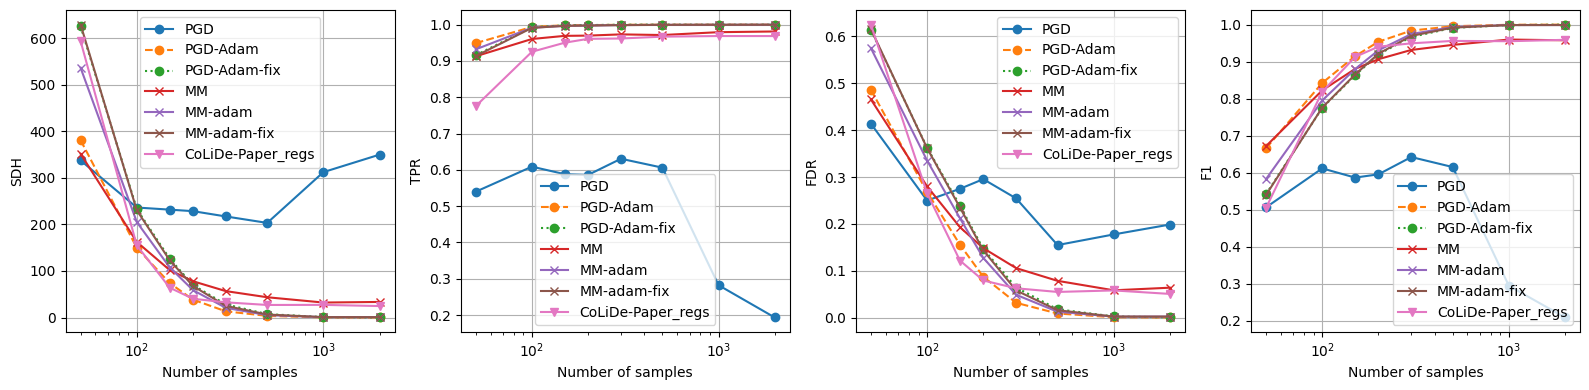

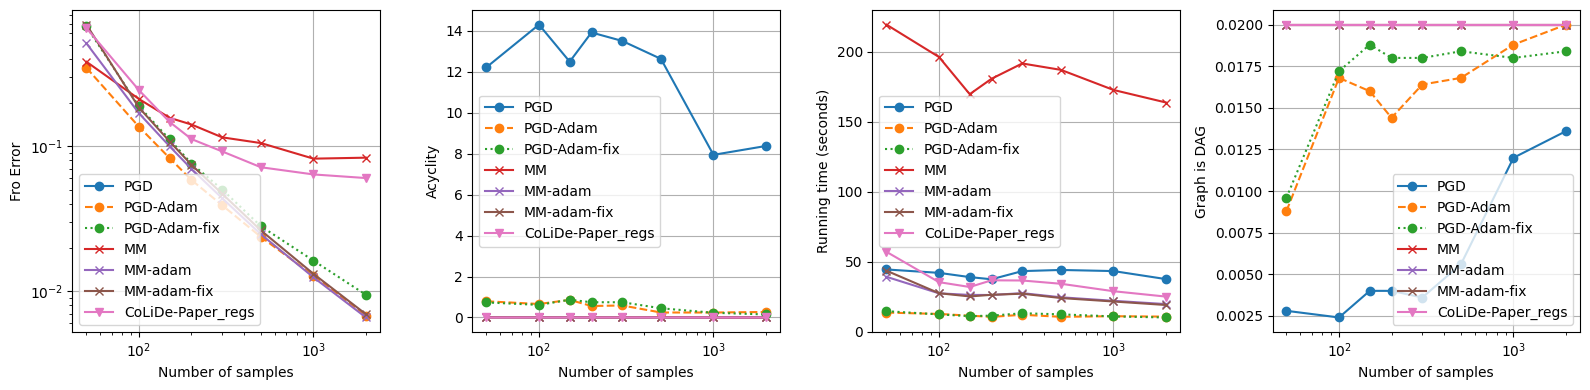

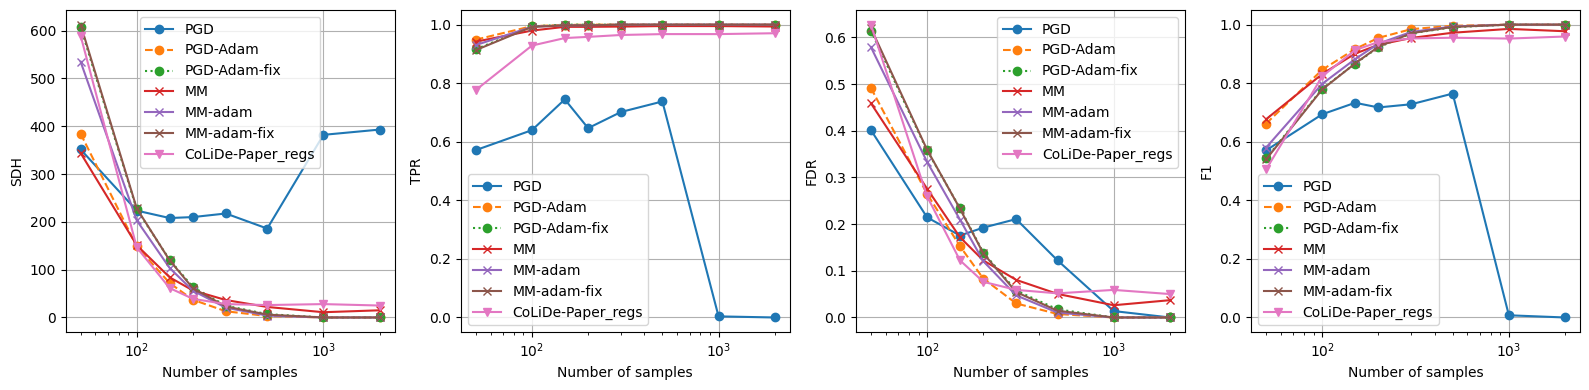

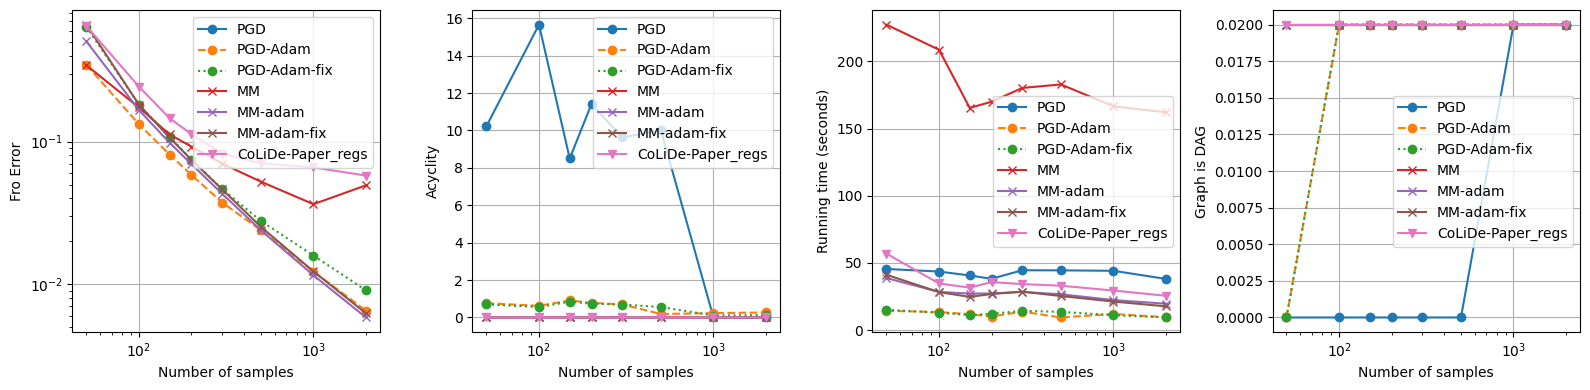

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


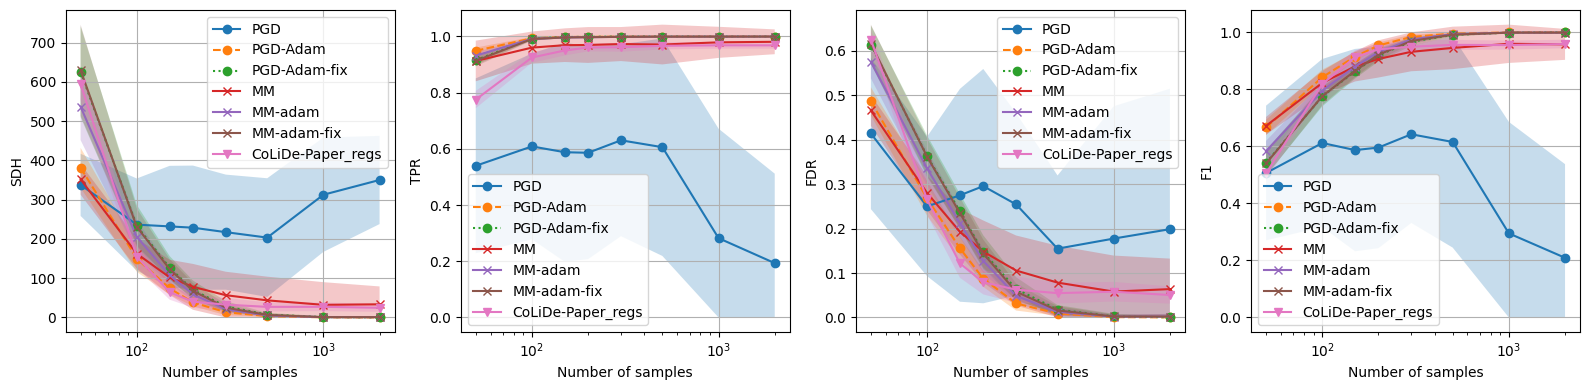

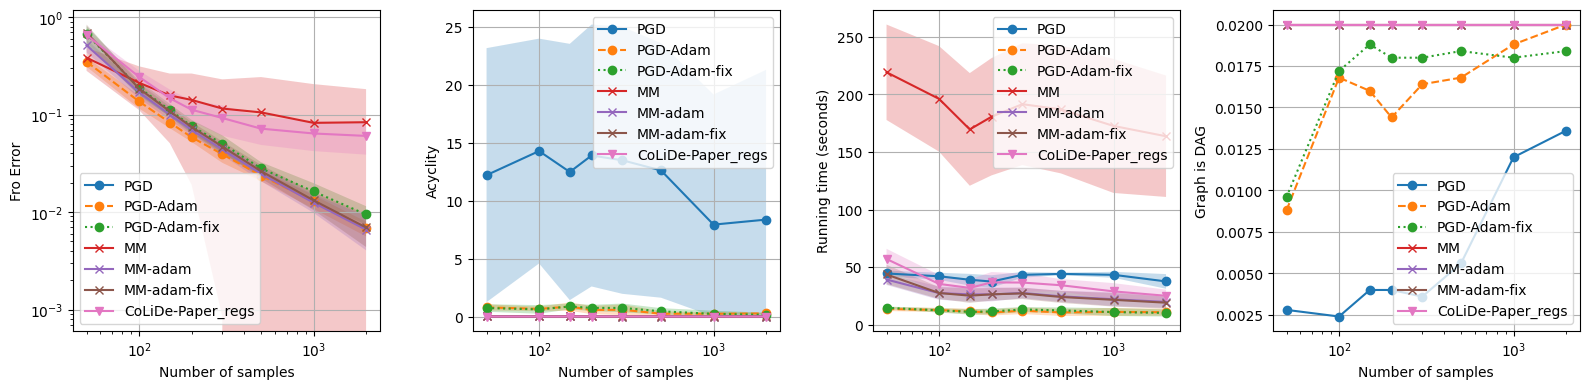

In [ ]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean', dev=True)

# plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
#                  skip_idx=skip, agg='median', dev=True)
